<a href="https://colab.research.google.com/github/bettyttytty/Replicate-paper-result/blob/main/Deep_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import torch, torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
from torch.nn import init
import numpy as np
import scipy as sp
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
import math
import torch.nn.init as init
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import torch.nn.functional as F
from urllib import request
import gzip
import pickle
import argparse
import os
import shutil
import random
import copy
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
!pip install adversarial-robustness-toolbox
import warnings
import sys
import logging
import itertools
warnings.filterwarnings('ignore')

torch.backends.cudnn.benchmark=True
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
!pip install kornia
from art.utils import load_dataset, get_file, check_and_transform_label_format
from art.classifiers import KerasClassifier, PyTorchClassifier
from art.defences.trainer import AdversarialTrainerMadryPGD,AdversarialTrainer
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing
from torch.optim.lr_scheduler import StepLR
from art.attacks.evasion.carlini import CarliniL2Method

In [ ]:
%%capture 
from tqdm import tqdm
import seaborn as sns

# from tensorflow.keras.datasets import cifar10


!pip install --upgrade wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = (x_train.astype("float32"))/255
# x_test = (x_test.astype("float32"))/255
# CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [ ]:
class small_cnn(nn.Module):
    def __init__(self):
        super(small_cnn, self).__init__()
        self.conv_1 = nn.Conv2d(3, 16, kernel_size = 3, padding='same')
        self.conv_2 = nn.Conv2d(16, 32, kernel_size = 3, padding='same')
        self.conv_3 = nn.Conv2d(32, 32, kernel_size = 3, padding='same')
        self.fc_1 = nn.Linear(512,32)
        self.fc_2 = nn.Linear(32, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.globalpool = nn.AvgPool2d(2,2)
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = self.globalpool(F.relu(self.conv_3(x)))
        x = x.view(-1,512)
        x = F.relu(self.fc_1(x))
        x = nn.Dropout(p=0.1)(x)
        x = self.fc_2(x)
        return x

In [ ]:
def train(model, trainloader, criterion, optimizer, scheduler, config):
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=2)

    # Run training and track with wandb
    total_batches = len(trainloader) * config['epochs']
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config['epochs'])):
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                # train_log(loss, example_ct, epoch)
                loss = float(loss)
                wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
                print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

        # checkpoint = {'epoch': epoch,'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
        # torch.save(checkpoint, ('/content/drive/MyDrive/deep-ensemble/smallCNN-'+str(epoch)))


In [ ]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " + f"test images: {100 * correct / total}%")
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    # torch.onnx.export(model, images, "model.onnx")
    # wandb.save("model.onnx")

In [ ]:
# def model_pipeline(model, train_loader, test_loader, criterion, optimizer, hyperparameters):

#     # tell wandb to get started
#     with wandb.init(project="pytorch-demo", config=hyperparameters):
#       # access all HPs through wandb.config, so logging matches execution!
#       config = wandb.config

#       # and use them to train the model
#       train(model, train_loader, criterion, optimizer, config)

#       # and test its final performance
#       test(model, test_loader)

#     return model

In [ ]:
config = dict(
    epochs=50,
    classes=10,
    batch_size=128,
    lr=0.01,
    dataset="CIFAR10",
    architecture="SmallCNN")

In [ ]:
model = small_cnn().to(device)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum = 0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)

In [ ]:
# Normalize the training set with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# get dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config['batch_size'],
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# tell wandb to get started
with wandb.init(project="pytorch-demo", config=config):
    # access all HPs through wandb.config, so logging matches execution!
    config = wandb.config

    # and use them to train the model
    train(model, trainloader, criterion, optimizer, scheduler, config)

    # and test its final performance
    test(model, testloader)

In [ ]:

with wandb.init(project="deep-ensemble-loss-landscape", config=config):
    config = wandb.config
    for idx in range(12,30):
        # access all HPs through wandb.config, so logging matches execution!
        model = small_cnn().to(device)
        model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
        torch.backends.cudnn.benchmark = True
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)

        # and use them to train the model
        train(model, trainloader, criterion, optimizer, scheduler, config)

        # and test its final performance
        test(model, testloader)
        checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
        torch.save(checkpoint, ('/content/drive/MyDrive/deep-ensemble/smallCNN-diff-'+str(idx)))

wandb: Currently logged in as: yunjuanwang (use `wandb login --relogin` to force relogin)


  0%|          | 0/50 [00:00<?, ?it/s]

Loss after 03072 examples: 2.322
Loss after 06272 examples: 2.306
Loss after 09472 examples: 2.313
Loss after 12672 examples: 2.306
Loss after 15872 examples: 2.304
Loss after 19072 examples: 2.299
Loss after 22272 examples: 2.290
Loss after 25472 examples: 2.307
Loss after 28672 examples: 2.290
Loss after 31872 examples: 2.291
Loss after 35072 examples: 2.296
Loss after 38272 examples: 2.301
Loss after 41472 examples: 2.290
Loss after 44672 examples: 2.289
Loss after 47872 examples: 2.289


  2%|▏         | 1/50 [00:21<17:22, 21.27s/it]

Loss after 51024 examples: 2.291
Loss after 54224 examples: 2.277
Loss after 57424 examples: 2.274
Loss after 60624 examples: 2.283
Loss after 63824 examples: 2.274
Loss after 67024 examples: 2.274
Loss after 70224 examples: 2.280
Loss after 73424 examples: 2.236
Loss after 76624 examples: 2.253
Loss after 79824 examples: 2.224
Loss after 83024 examples: 2.237
Loss after 86224 examples: 2.171
Loss after 89424 examples: 2.243
Loss after 92624 examples: 2.134
Loss after 95824 examples: 2.185
Loss after 99024 examples: 2.177


  4%|▍         | 2/50 [00:43<17:29, 21.87s/it]

Loss after 102176 examples: 2.094
Loss after 105376 examples: 2.167
Loss after 108576 examples: 2.108
Loss after 111776 examples: 2.134
Loss after 114976 examples: 2.050
Loss after 118176 examples: 2.138
Loss after 121376 examples: 2.173
Loss after 124576 examples: 2.124
Loss after 127776 examples: 2.087
Loss after 130976 examples: 2.102
Loss after 134176 examples: 2.078
Loss after 137376 examples: 2.053
Loss after 140576 examples: 2.034
Loss after 143776 examples: 1.985
Loss after 146976 examples: 2.029


  6%|▌         | 3/50 [01:04<16:41, 21.31s/it]

Loss after 150128 examples: 2.031
Loss after 153328 examples: 2.088
Loss after 156528 examples: 2.056
Loss after 159728 examples: 1.984
Loss after 162928 examples: 2.019
Loss after 166128 examples: 2.071
Loss after 169328 examples: 2.141
Loss after 172528 examples: 1.974
Loss after 175728 examples: 2.002
Loss after 178928 examples: 2.023
Loss after 182128 examples: 1.961
Loss after 185328 examples: 1.955
Loss after 188528 examples: 1.979
Loss after 191728 examples: 2.022
Loss after 194928 examples: 1.899
Loss after 198128 examples: 1.986


  8%|▊         | 4/50 [01:25<16:15, 21.21s/it]

Loss after 201280 examples: 1.827
Loss after 204480 examples: 2.025
Loss after 207680 examples: 2.017
Loss after 210880 examples: 2.001
Loss after 214080 examples: 1.871
Loss after 217280 examples: 1.945
Loss after 220480 examples: 1.901
Loss after 223680 examples: 1.971
Loss after 226880 examples: 1.891
Loss after 230080 examples: 1.875
Loss after 233280 examples: 1.884
Loss after 236480 examples: 1.950
Loss after 239680 examples: 1.828
Loss after 242880 examples: 1.796
Loss after 246080 examples: 1.945
Loss after 249280 examples: 1.886


 10%|█         | 5/50 [01:46<15:54, 21.20s/it]

Loss after 252432 examples: 1.897
Loss after 255632 examples: 1.825
Loss after 258832 examples: 1.899
Loss after 262032 examples: 1.812
Loss after 265232 examples: 1.874
Loss after 268432 examples: 1.964
Loss after 271632 examples: 1.894
Loss after 274832 examples: 1.711
Loss after 278032 examples: 1.858
Loss after 281232 examples: 1.804
Loss after 284432 examples: 1.865
Loss after 287632 examples: 1.818
Loss after 290832 examples: 1.831
Loss after 294032 examples: 1.755
Loss after 297232 examples: 1.748


 12%|█▏        | 6/50 [02:07<15:33, 21.22s/it]

Loss after 300384 examples: 1.725
Loss after 303584 examples: 1.737
Loss after 306784 examples: 1.861
Loss after 309984 examples: 1.797
Loss after 313184 examples: 1.718
Loss after 316384 examples: 1.792
Loss after 319584 examples: 1.680
Loss after 322784 examples: 1.808
Loss after 325984 examples: 1.652
Loss after 329184 examples: 1.694
Loss after 332384 examples: 1.758
Loss after 335584 examples: 1.879
Loss after 338784 examples: 1.831
Loss after 341984 examples: 1.706
Loss after 345184 examples: 1.737
Loss after 348384 examples: 1.662


 14%|█▍        | 7/50 [02:29<15:13, 21.25s/it]

Loss after 351536 examples: 1.839
Loss after 354736 examples: 1.758
Loss after 357936 examples: 1.750
Loss after 361136 examples: 1.665
Loss after 364336 examples: 1.815
Loss after 367536 examples: 1.699
Loss after 370736 examples: 1.630
Loss after 373936 examples: 1.577
Loss after 377136 examples: 1.661
Loss after 380336 examples: 1.683
Loss after 383536 examples: 1.731
Loss after 386736 examples: 1.773
Loss after 389936 examples: 1.793
Loss after 393136 examples: 1.745
Loss after 396336 examples: 1.717
Loss after 399536 examples: 1.598


 16%|█▌        | 8/50 [02:50<14:53, 21.28s/it]

Loss after 402688 examples: 1.688
Loss after 405888 examples: 1.765
Loss after 409088 examples: 1.663
Loss after 412288 examples: 1.752
Loss after 415488 examples: 1.777
Loss after 418688 examples: 1.718
Loss after 421888 examples: 1.674
Loss after 425088 examples: 1.809
Loss after 428288 examples: 1.750
Loss after 431488 examples: 1.684
Loss after 434688 examples: 1.587
Loss after 437888 examples: 1.697
Loss after 441088 examples: 1.561
Loss after 444288 examples: 1.704
Loss after 447488 examples: 1.637


 18%|█▊        | 9/50 [03:11<14:32, 21.28s/it]

Loss after 450640 examples: 1.679
Loss after 453840 examples: 1.666
Loss after 457040 examples: 1.560
Loss after 460240 examples: 1.607
Loss after 463440 examples: 1.623
Loss after 466640 examples: 1.570
Loss after 469840 examples: 1.671
Loss after 473040 examples: 1.631
Loss after 476240 examples: 1.516
Loss after 479440 examples: 1.615
Loss after 482640 examples: 1.509
Loss after 485840 examples: 1.626
Loss after 489040 examples: 1.654
Loss after 492240 examples: 1.596
Loss after 495440 examples: 1.636
Loss after 498640 examples: 1.597


 20%|██        | 10/50 [03:32<14:07, 21.19s/it]

Loss after 501792 examples: 1.537
Loss after 504992 examples: 1.598
Loss after 508192 examples: 1.624
Loss after 511392 examples: 1.583
Loss after 514592 examples: 1.767
Loss after 517792 examples: 1.764
Loss after 520992 examples: 1.515
Loss after 524192 examples: 1.412
Loss after 527392 examples: 1.749
Loss after 530592 examples: 1.571
Loss after 533792 examples: 1.661
Loss after 536992 examples: 1.703
Loss after 540192 examples: 1.563
Loss after 543392 examples: 1.684
Loss after 546592 examples: 1.613


 22%|██▏       | 11/50 [03:53<13:44, 21.15s/it]

Loss after 549792 examples: 1.845
Loss after 552944 examples: 1.572
Loss after 556144 examples: 1.486
Loss after 559344 examples: 1.622
Loss after 562544 examples: 1.546
Loss after 565744 examples: 1.580
Loss after 568944 examples: 1.585
Loss after 572144 examples: 1.531
Loss after 575344 examples: 1.545
Loss after 578544 examples: 1.618
Loss after 581744 examples: 1.489
Loss after 584944 examples: 1.660
Loss after 588144 examples: 1.616
Loss after 591344 examples: 1.520
Loss after 594544 examples: 1.600
Loss after 597744 examples: 1.646


 24%|██▍       | 12/50 [04:14<13:19, 21.05s/it]

Loss after 600896 examples: 1.458
Loss after 604096 examples: 1.649
Loss after 607296 examples: 1.604
Loss after 610496 examples: 1.588
Loss after 613696 examples: 1.625
Loss after 616896 examples: 1.668
Loss after 620096 examples: 1.615
Loss after 623296 examples: 1.541
Loss after 626496 examples: 1.539
Loss after 629696 examples: 1.632
Loss after 632896 examples: 1.506
Loss after 636096 examples: 1.475
Loss after 639296 examples: 1.535
Loss after 642496 examples: 1.499
Loss after 645696 examples: 1.493
Loss after 648896 examples: 1.448


 26%|██▌       | 13/50 [04:35<12:57, 21.03s/it]

Loss after 652048 examples: 1.581
Loss after 655248 examples: 1.494
Loss after 658448 examples: 1.417
Loss after 661648 examples: 1.543
Loss after 664848 examples: 1.548
Loss after 668048 examples: 1.542
Loss after 671248 examples: 1.706
Loss after 674448 examples: 1.565
Loss after 677648 examples: 1.577
Loss after 680848 examples: 1.573
Loss after 684048 examples: 1.490
Loss after 687248 examples: 1.399
Loss after 690448 examples: 1.642
Loss after 693648 examples: 1.408
Loss after 696848 examples: 1.426


 28%|██▊       | 14/50 [04:56<12:37, 21.03s/it]

Loss after 700000 examples: 1.610
Loss after 703200 examples: 1.620
Loss after 706400 examples: 1.574
Loss after 709600 examples: 1.285
Loss after 712800 examples: 1.431
Loss after 716000 examples: 1.388
Loss after 719200 examples: 1.539
Loss after 722400 examples: 1.402
Loss after 725600 examples: 1.509
Loss after 728800 examples: 1.471
Loss after 732000 examples: 1.515
Loss after 735200 examples: 1.582
Loss after 738400 examples: 1.479
Loss after 741600 examples: 1.527
Loss after 744800 examples: 1.429
Loss after 748000 examples: 1.402


 30%|███       | 15/50 [05:17<12:16, 21.03s/it]

Loss after 751152 examples: 1.534
Loss after 754352 examples: 1.582
Loss after 757552 examples: 1.609
Loss after 760752 examples: 1.371
Loss after 763952 examples: 1.519
Loss after 767152 examples: 1.515
Loss after 770352 examples: 1.457
Loss after 773552 examples: 1.443
Loss after 776752 examples: 1.538
Loss after 779952 examples: 1.409
Loss after 783152 examples: 1.528
Loss after 786352 examples: 1.506
Loss after 789552 examples: 1.626
Loss after 792752 examples: 1.594
Loss after 795952 examples: 1.452
Loss after 799152 examples: 1.364


 32%|███▏      | 16/50 [05:38<11:55, 21.04s/it]

Loss after 802304 examples: 1.428
Loss after 805504 examples: 1.574
Loss after 808704 examples: 1.466
Loss after 811904 examples: 1.425
Loss after 815104 examples: 1.453
Loss after 818304 examples: 1.453
Loss after 821504 examples: 1.391
Loss after 824704 examples: 1.388
Loss after 827904 examples: 1.436
Loss after 831104 examples: 1.394
Loss after 834304 examples: 1.474
Loss after 837504 examples: 1.389
Loss after 840704 examples: 1.483
Loss after 843904 examples: 1.276
Loss after 847104 examples: 1.524


 34%|███▍      | 17/50 [05:59<11:35, 21.07s/it]

Loss after 850256 examples: 1.567
Loss after 853456 examples: 1.573
Loss after 856656 examples: 1.457
Loss after 859856 examples: 1.403
Loss after 863056 examples: 1.498
Loss after 866256 examples: 1.341
Loss after 869456 examples: 1.275
Loss after 872656 examples: 1.629
Loss after 875856 examples: 1.546
Loss after 879056 examples: 1.431
Loss after 882256 examples: 1.510
Loss after 885456 examples: 1.460
Loss after 888656 examples: 1.455
Loss after 891856 examples: 1.560
Loss after 895056 examples: 1.297
Loss after 898256 examples: 1.552


 36%|███▌      | 18/50 [06:20<11:14, 21.07s/it]

Loss after 901408 examples: 1.306
Loss after 904608 examples: 1.416
Loss after 907808 examples: 1.449
Loss after 911008 examples: 1.467
Loss after 914208 examples: 1.577
Loss after 917408 examples: 1.460
Loss after 920608 examples: 1.674
Loss after 923808 examples: 1.366
Loss after 927008 examples: 1.348
Loss after 930208 examples: 1.307
Loss after 933408 examples: 1.468
Loss after 936608 examples: 1.467
Loss after 939808 examples: 1.400
Loss after 943008 examples: 1.550
Loss after 946208 examples: 1.339
Loss after 949408 examples: 1.482


 38%|███▊      | 19/50 [06:42<10:54, 21.11s/it]

Loss after 952560 examples: 1.311
Loss after 955760 examples: 1.557
Loss after 958960 examples: 1.329
Loss after 962160 examples: 1.507
Loss after 965360 examples: 1.372
Loss after 968560 examples: 1.374
Loss after 971760 examples: 1.378
Loss after 974960 examples: 1.403
Loss after 978160 examples: 1.612
Loss after 981360 examples: 1.290
Loss after 984560 examples: 1.329
Loss after 987760 examples: 1.458
Loss after 990960 examples: 1.485
Loss after 994160 examples: 1.246
Loss after 997360 examples: 1.469


 40%|████      | 20/50 [07:03<10:32, 21.10s/it]

Loss after 1000512 examples: 1.444
Loss after 1003712 examples: 1.283
Loss after 1006912 examples: 1.388
Loss after 1010112 examples: 1.399
Loss after 1013312 examples: 1.546
Loss after 1016512 examples: 1.338
Loss after 1019712 examples: 1.472
Loss after 1022912 examples: 1.401
Loss after 1026112 examples: 1.311
Loss after 1029312 examples: 1.411
Loss after 1032512 examples: 1.298
Loss after 1035712 examples: 1.411
Loss after 1038912 examples: 1.454
Loss after 1042112 examples: 1.485
Loss after 1045312 examples: 1.431
Loss after 1048512 examples: 1.513


 42%|████▏     | 21/50 [07:23<10:08, 21.00s/it]

Loss after 1051664 examples: 1.341
Loss after 1054864 examples: 1.332
Loss after 1058064 examples: 1.344
Loss after 1061264 examples: 1.305
Loss after 1064464 examples: 1.343
Loss after 1067664 examples: 1.374
Loss after 1070864 examples: 1.251
Loss after 1074064 examples: 1.281
Loss after 1077264 examples: 1.404
Loss after 1080464 examples: 1.301
Loss after 1083664 examples: 1.344
Loss after 1086864 examples: 1.396
Loss after 1090064 examples: 1.360
Loss after 1093264 examples: 1.534
Loss after 1096464 examples: 1.372


 44%|████▍     | 22/50 [07:44<09:47, 20.99s/it]

Loss after 1099664 examples: 1.325
Loss after 1102816 examples: 1.333
Loss after 1106016 examples: 1.553
Loss after 1109216 examples: 1.399
Loss after 1112416 examples: 1.406
Loss after 1115616 examples: 1.410
Loss after 1118816 examples: 1.307
Loss after 1122016 examples: 1.411
Loss after 1125216 examples: 1.382
Loss after 1128416 examples: 1.412
Loss after 1131616 examples: 1.513
Loss after 1134816 examples: 1.488
Loss after 1138016 examples: 1.256
Loss after 1141216 examples: 1.320
Loss after 1144416 examples: 1.430
Loss after 1147616 examples: 1.345


 46%|████▌     | 23/50 [08:05<09:27, 21.03s/it]

Loss after 1150768 examples: 1.404
Loss after 1153968 examples: 1.381
Loss after 1157168 examples: 1.413
Loss after 1160368 examples: 1.429
Loss after 1163568 examples: 1.507
Loss after 1166768 examples: 1.463
Loss after 1169968 examples: 1.508
Loss after 1173168 examples: 1.540
Loss after 1176368 examples: 1.482
Loss after 1179568 examples: 1.254
Loss after 1182768 examples: 1.392
Loss after 1185968 examples: 1.303
Loss after 1189168 examples: 1.416
Loss after 1192368 examples: 1.425
Loss after 1195568 examples: 1.407
Loss after 1198768 examples: 1.374


 48%|████▊     | 24/50 [08:27<09:06, 21.04s/it]

Loss after 1201920 examples: 1.471
Loss after 1205120 examples: 1.411
Loss after 1208320 examples: 1.334
Loss after 1211520 examples: 1.371
Loss after 1214720 examples: 1.506
Loss after 1217920 examples: 1.355
Loss after 1221120 examples: 1.373
Loss after 1224320 examples: 1.399
Loss after 1227520 examples: 1.446
Loss after 1230720 examples: 1.459
Loss after 1233920 examples: 1.320
Loss after 1237120 examples: 1.553
Loss after 1240320 examples: 1.364
Loss after 1243520 examples: 1.354
Loss after 1246720 examples: 1.314


 50%|█████     | 25/50 [08:48<08:47, 21.09s/it]

Loss after 1249920 examples: 1.387
Loss after 1253072 examples: 1.373
Loss after 1256272 examples: 1.394
Loss after 1259472 examples: 1.331
Loss after 1262672 examples: 1.460
Loss after 1265872 examples: 1.537
Loss after 1269072 examples: 1.317
Loss after 1272272 examples: 1.364
Loss after 1275472 examples: 1.216
Loss after 1278672 examples: 1.416
Loss after 1281872 examples: 1.325
Loss after 1285072 examples: 1.280
Loss after 1288272 examples: 1.469
Loss after 1291472 examples: 1.430
Loss after 1294672 examples: 1.338
Loss after 1297872 examples: 1.422


 52%|█████▏    | 26/50 [09:09<08:26, 21.11s/it]

Loss after 1301024 examples: 1.257
Loss after 1304224 examples: 1.277
Loss after 1307424 examples: 1.235
Loss after 1310624 examples: 1.374
Loss after 1313824 examples: 1.408
Loss after 1317024 examples: 1.458
Loss after 1320224 examples: 1.329
Loss after 1323424 examples: 1.532
Loss after 1326624 examples: 1.444
Loss after 1329824 examples: 1.338
Loss after 1333024 examples: 1.437
Loss after 1336224 examples: 1.246
Loss after 1339424 examples: 1.419
Loss after 1342624 examples: 1.335
Loss after 1345824 examples: 1.459
Loss after 1349024 examples: 1.380


 54%|█████▍    | 27/50 [09:30<08:04, 21.07s/it]

Loss after 1352176 examples: 1.397
Loss after 1355376 examples: 1.296
Loss after 1358576 examples: 1.444
Loss after 1361776 examples: 1.272
Loss after 1364976 examples: 1.382
Loss after 1368176 examples: 1.338
Loss after 1371376 examples: 1.320
Loss after 1374576 examples: 1.422
Loss after 1377776 examples: 1.347
Loss after 1380976 examples: 1.370
Loss after 1384176 examples: 1.312
Loss after 1387376 examples: 1.426
Loss after 1390576 examples: 1.421
Loss after 1393776 examples: 1.353
Loss after 1396976 examples: 1.252


 56%|█████▌    | 28/50 [09:51<07:43, 21.09s/it]

Loss after 1400128 examples: 1.386
Loss after 1403328 examples: 1.387
Loss after 1406528 examples: 1.243
Loss after 1409728 examples: 1.244
Loss after 1412928 examples: 1.357
Loss after 1416128 examples: 1.263
Loss after 1419328 examples: 1.420
Loss after 1422528 examples: 1.351
Loss after 1425728 examples: 1.411
Loss after 1428928 examples: 1.087
Loss after 1432128 examples: 1.356
Loss after 1435328 examples: 1.163
Loss after 1438528 examples: 1.160
Loss after 1441728 examples: 1.282
Loss after 1444928 examples: 1.193
Loss after 1448128 examples: 1.397


 58%|█████▊    | 29/50 [10:12<07:21, 21.04s/it]

Loss after 1451280 examples: 1.344
Loss after 1454480 examples: 1.324
Loss after 1457680 examples: 1.276
Loss after 1460880 examples: 1.288
Loss after 1464080 examples: 1.281
Loss after 1467280 examples: 1.392
Loss after 1470480 examples: 1.318
Loss after 1473680 examples: 1.352
Loss after 1476880 examples: 1.212
Loss after 1480080 examples: 1.380
Loss after 1483280 examples: 1.339
Loss after 1486480 examples: 1.424
Loss after 1489680 examples: 1.298
Loss after 1492880 examples: 1.315
Loss after 1496080 examples: 1.398
Loss after 1499280 examples: 1.280


 60%|██████    | 30/50 [10:33<06:58, 20.95s/it]

Loss after 1502432 examples: 1.264
Loss after 1505632 examples: 1.270
Loss after 1508832 examples: 1.288
Loss after 1512032 examples: 1.270
Loss after 1515232 examples: 1.282
Loss after 1518432 examples: 1.409
Loss after 1521632 examples: 1.352
Loss after 1524832 examples: 1.177
Loss after 1528032 examples: 1.329
Loss after 1531232 examples: 1.423
Loss after 1534432 examples: 1.349
Loss after 1537632 examples: 1.321
Loss after 1540832 examples: 1.289
Loss after 1544032 examples: 1.293
Loss after 1547232 examples: 1.395


 62%|██████▏   | 31/50 [10:54<06:37, 20.94s/it]

Loss after 1550384 examples: 1.194
Loss after 1553584 examples: 1.334
Loss after 1556784 examples: 1.137
Loss after 1559984 examples: 1.453
Loss after 1563184 examples: 1.151
Loss after 1566384 examples: 1.341
Loss after 1569584 examples: 1.327
Loss after 1572784 examples: 1.239
Loss after 1575984 examples: 1.115
Loss after 1579184 examples: 1.443
Loss after 1582384 examples: 1.235
Loss after 1585584 examples: 1.390
Loss after 1588784 examples: 1.179
Loss after 1591984 examples: 1.166
Loss after 1595184 examples: 1.217
Loss after 1598384 examples: 1.485


 64%|██████▍   | 32/50 [11:15<06:17, 20.97s/it]

Loss after 1601536 examples: 1.289
Loss after 1604736 examples: 1.293
Loss after 1607936 examples: 1.180
Loss after 1611136 examples: 1.377
Loss after 1614336 examples: 1.199
Loss after 1617536 examples: 1.299
Loss after 1620736 examples: 1.256
Loss after 1623936 examples: 1.176
Loss after 1627136 examples: 1.203
Loss after 1630336 examples: 1.286
Loss after 1633536 examples: 1.371
Loss after 1636736 examples: 1.186
Loss after 1639936 examples: 1.131
Loss after 1643136 examples: 1.277
Loss after 1646336 examples: 1.393


 66%|██████▌   | 33/50 [11:36<05:56, 20.96s/it]

Loss after 1649536 examples: 1.290
Loss after 1652688 examples: 1.198
Loss after 1655888 examples: 1.205
Loss after 1659088 examples: 1.386
Loss after 1662288 examples: 1.337
Loss after 1665488 examples: 1.260
Loss after 1668688 examples: 1.341
Loss after 1671888 examples: 1.246
Loss after 1675088 examples: 1.273
Loss after 1678288 examples: 1.076
Loss after 1681488 examples: 1.215
Loss after 1684688 examples: 1.212
Loss after 1687888 examples: 1.281
Loss after 1691088 examples: 1.290
Loss after 1694288 examples: 1.323
Loss after 1697488 examples: 1.294


 68%|██████▊   | 34/50 [11:57<05:35, 20.98s/it]

Loss after 1700640 examples: 1.087
Loss after 1703840 examples: 1.153
Loss after 1707040 examples: 1.224
Loss after 1710240 examples: 1.199
Loss after 1713440 examples: 1.089
Loss after 1716640 examples: 1.326
Loss after 1719840 examples: 1.357
Loss after 1723040 examples: 1.213
Loss after 1726240 examples: 1.339
Loss after 1729440 examples: 1.349
Loss after 1732640 examples: 1.420
Loss after 1735840 examples: 1.136
Loss after 1739040 examples: 1.228
Loss after 1742240 examples: 1.191
Loss after 1745440 examples: 1.257
Loss after 1748640 examples: 1.112


 70%|███████   | 35/50 [12:18<05:15, 21.03s/it]

Loss after 1751792 examples: 1.240
Loss after 1754992 examples: 1.135
Loss after 1758192 examples: 1.177
Loss after 1761392 examples: 1.417
Loss after 1764592 examples: 1.206
Loss after 1767792 examples: 1.141
Loss after 1770992 examples: 1.025
Loss after 1774192 examples: 1.346
Loss after 1777392 examples: 1.125
Loss after 1780592 examples: 1.167
Loss after 1783792 examples: 1.279
Loss after 1786992 examples: 1.197
Loss after 1790192 examples: 1.304
Loss after 1793392 examples: 1.224
Loss after 1796592 examples: 1.231


 72%|███████▏  | 36/50 [12:39<04:55, 21.07s/it]

Loss after 1799792 examples: 1.201
Loss after 1802944 examples: 1.241
Loss after 1806144 examples: 1.212
Loss after 1809344 examples: 1.212
Loss after 1812544 examples: 1.301
Loss after 1815744 examples: 1.269
Loss after 1818944 examples: 1.251
Loss after 1822144 examples: 0.992
Loss after 1825344 examples: 1.231
Loss after 1828544 examples: 1.423
Loss after 1831744 examples: 1.053
Loss after 1834944 examples: 1.188
Loss after 1838144 examples: 1.260
Loss after 1841344 examples: 1.227
Loss after 1844544 examples: 1.238
Loss after 1847744 examples: 1.226


 74%|███████▍  | 37/50 [13:00<04:34, 21.12s/it]

Loss after 1850896 examples: 1.112
Loss after 1854096 examples: 1.205
Loss after 1857296 examples: 0.979
Loss after 1860496 examples: 1.248
Loss after 1863696 examples: 1.101
Loss after 1866896 examples: 1.222
Loss after 1870096 examples: 1.216
Loss after 1873296 examples: 1.257
Loss after 1876496 examples: 1.210
Loss after 1879696 examples: 1.346
Loss after 1882896 examples: 1.304
Loss after 1886096 examples: 1.264
Loss after 1889296 examples: 1.319
Loss after 1892496 examples: 1.099
Loss after 1895696 examples: 1.096
Loss after 1898896 examples: 1.262


 76%|███████▌  | 38/50 [13:21<04:13, 21.13s/it]

Loss after 1902048 examples: 1.102
Loss after 1905248 examples: 1.198
Loss after 1908448 examples: 1.140
Loss after 1911648 examples: 1.279
Loss after 1914848 examples: 1.266
Loss after 1918048 examples: 1.118
Loss after 1921248 examples: 1.187
Loss after 1924448 examples: 1.180
Loss after 1927648 examples: 1.364
Loss after 1930848 examples: 1.201
Loss after 1934048 examples: 1.197
Loss after 1937248 examples: 1.151
Loss after 1940448 examples: 1.054
Loss after 1943648 examples: 1.163
Loss after 1946848 examples: 1.065


 78%|███████▊  | 39/50 [13:42<03:51, 21.04s/it]

Loss after 1950000 examples: 1.097
Loss after 1953200 examples: 1.268
Loss after 1956400 examples: 1.170
Loss after 1959600 examples: 1.158
Loss after 1962800 examples: 1.173
Loss after 1966000 examples: 1.340
Loss after 1969200 examples: 1.174
Loss after 1972400 examples: 1.197
Loss after 1975600 examples: 1.102
Loss after 1978800 examples: 1.310
Loss after 1982000 examples: 1.242
Loss after 1985200 examples: 1.399
Loss after 1988400 examples: 1.243
Loss after 1991600 examples: 1.177
Loss after 1994800 examples: 1.172
Loss after 1998000 examples: 1.214


 80%|████████  | 40/50 [14:03<03:29, 20.98s/it]

Loss after 2001152 examples: 0.941
Loss after 2004352 examples: 1.191
Loss after 2007552 examples: 1.268
Loss after 2010752 examples: 1.009
Loss after 2013952 examples: 1.153
Loss after 2017152 examples: 1.321
Loss after 2020352 examples: 1.246
Loss after 2023552 examples: 1.178
Loss after 2026752 examples: 1.311
Loss after 2029952 examples: 1.150
Loss after 2033152 examples: 1.158
Loss after 2036352 examples: 1.092
Loss after 2039552 examples: 1.141
Loss after 2042752 examples: 1.125
Loss after 2045952 examples: 1.287
Loss after 2049152 examples: 1.075


 82%|████████▏ | 41/50 [14:24<03:08, 20.98s/it]

Loss after 2052304 examples: 1.128
Loss after 2055504 examples: 1.091
Loss after 2058704 examples: 0.996
Loss after 2061904 examples: 1.312
Loss after 2065104 examples: 1.137
Loss after 2068304 examples: 1.170
Loss after 2071504 examples: 1.372
Loss after 2074704 examples: 1.151
Loss after 2077904 examples: 1.099
Loss after 2081104 examples: 1.098
Loss after 2084304 examples: 1.132
Loss after 2087504 examples: 1.086
Loss after 2090704 examples: 1.359
Loss after 2093904 examples: 1.170
Loss after 2097104 examples: 1.134


 84%|████████▍ | 42/50 [14:45<02:48, 21.03s/it]

Loss after 2100256 examples: 1.292
Loss after 2103456 examples: 1.138
Loss after 2106656 examples: 1.086
Loss after 2109856 examples: 1.312
Loss after 2113056 examples: 1.088
Loss after 2116256 examples: 1.148
Loss after 2119456 examples: 1.364
Loss after 2122656 examples: 1.044
Loss after 2125856 examples: 1.322
Loss after 2129056 examples: 1.183
Loss after 2132256 examples: 1.242
Loss after 2135456 examples: 1.100
Loss after 2138656 examples: 1.074
Loss after 2141856 examples: 1.084
Loss after 2145056 examples: 1.090
Loss after 2148256 examples: 1.215


 86%|████████▌ | 43/50 [15:06<02:27, 21.03s/it]

Loss after 2151408 examples: 1.189
Loss after 2154608 examples: 1.016
Loss after 2157808 examples: 1.216
Loss after 2161008 examples: 1.125
Loss after 2164208 examples: 1.289
Loss after 2167408 examples: 1.156
Loss after 2170608 examples: 1.218
Loss after 2173808 examples: 1.023
Loss after 2177008 examples: 1.201
Loss after 2180208 examples: 1.285
Loss after 2183408 examples: 1.114
Loss after 2186608 examples: 1.189
Loss after 2189808 examples: 1.104
Loss after 2193008 examples: 1.085
Loss after 2196208 examples: 1.203
Loss after 2199408 examples: 1.138


 88%|████████▊ | 44/50 [15:27<02:06, 21.03s/it]

Loss after 2202560 examples: 1.272
Loss after 2205760 examples: 1.155
Loss after 2208960 examples: 1.305
Loss after 2212160 examples: 1.259
Loss after 2215360 examples: 1.151
Loss after 2218560 examples: 1.210
Loss after 2221760 examples: 1.188
Loss after 2224960 examples: 1.047
Loss after 2228160 examples: 1.079
Loss after 2231360 examples: 1.306
Loss after 2234560 examples: 1.254
Loss after 2237760 examples: 1.003
Loss after 2240960 examples: 1.320
Loss after 2244160 examples: 1.102
Loss after 2247360 examples: 1.161


 90%|█████████ | 45/50 [15:48<01:45, 21.08s/it]

Loss after 2250512 examples: 1.166
Loss after 2253712 examples: 1.156
Loss after 2256912 examples: 1.099
Loss after 2260112 examples: 1.062
Loss after 2263312 examples: 1.181
Loss after 2266512 examples: 1.062
Loss after 2269712 examples: 1.093
Loss after 2272912 examples: 1.164
Loss after 2276112 examples: 1.193
Loss after 2279312 examples: 1.159
Loss after 2282512 examples: 1.118
Loss after 2285712 examples: 1.066
Loss after 2288912 examples: 1.228
Loss after 2292112 examples: 1.188
Loss after 2295312 examples: 1.048
Loss after 2298512 examples: 1.001


 92%|█████████▏| 46/50 [16:09<01:24, 21.06s/it]

Loss after 2301664 examples: 1.094
Loss after 2304864 examples: 1.072
Loss after 2308064 examples: 1.159
Loss after 2311264 examples: 1.128
Loss after 2314464 examples: 1.106
Loss after 2317664 examples: 1.066
Loss after 2320864 examples: 1.183
Loss after 2324064 examples: 1.176
Loss after 2327264 examples: 1.230
Loss after 2330464 examples: 1.232
Loss after 2333664 examples: 1.121
Loss after 2336864 examples: 1.076
Loss after 2340064 examples: 1.026
Loss after 2343264 examples: 1.101
Loss after 2346464 examples: 1.139


 94%|█████████▍| 47/50 [16:30<01:03, 21.04s/it]

Loss after 2349664 examples: 1.134
Loss after 2352816 examples: 1.117
Loss after 2356016 examples: 1.168
Loss after 2359216 examples: 1.106
Loss after 2362416 examples: 1.209
Loss after 2365616 examples: 1.142
Loss after 2368816 examples: 1.130
Loss after 2372016 examples: 1.224
Loss after 2375216 examples: 1.128
Loss after 2378416 examples: 1.081
Loss after 2381616 examples: 1.045
Loss after 2384816 examples: 1.178
Loss after 2388016 examples: 1.166
Loss after 2391216 examples: 1.011
Loss after 2394416 examples: 1.060
Loss after 2397616 examples: 1.089


 96%|█████████▌| 48/50 [16:51<00:41, 21.00s/it]

Loss after 2400768 examples: 1.391
Loss after 2403968 examples: 0.968
Loss after 2407168 examples: 1.251
Loss after 2410368 examples: 1.337
Loss after 2413568 examples: 1.089
Loss after 2416768 examples: 1.201
Loss after 2419968 examples: 1.205
Loss after 2423168 examples: 0.938
Loss after 2426368 examples: 1.277
Loss after 2429568 examples: 1.199
Loss after 2432768 examples: 1.197
Loss after 2435968 examples: 1.067
Loss after 2439168 examples: 1.218
Loss after 2442368 examples: 1.229
Loss after 2445568 examples: 0.966
Loss after 2448768 examples: 1.126


 98%|█████████▊| 49/50 [17:12<00:21, 21.02s/it]

Loss after 2451920 examples: 0.845
Loss after 2455120 examples: 1.263
Loss after 2458320 examples: 1.031
Loss after 2461520 examples: 1.110
Loss after 2464720 examples: 1.085
Loss after 2467920 examples: 1.105
Loss after 2471120 examples: 0.995
Loss after 2474320 examples: 1.309
Loss after 2477520 examples: 1.185
Loss after 2480720 examples: 1.118
Loss after 2483920 examples: 0.977
Loss after 2487120 examples: 1.147
Loss after 2490320 examples: 0.958
Loss after 2493520 examples: 1.040
Loss after 2496720 examples: 0.991


100%|██████████| 50/50 [17:33<00:00, 21.08s/it]

Loss after 2499920 examples: 1.090


Accuracy of the model on the 10000 test images: 63.62%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499921; dropping {'epoch': 0, 'loss': 2.3023853302001953}.


Loss after 03072 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499921; dropping {'epoch': 0, 'loss': 2.3017196655273438}.


Loss after 06272 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499921; dropping {'epoch': 0, 'loss': 2.303431749343872}.


Loss after 09472 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499921; dropping {'epoch': 0, 'loss': 2.3034894466400146}.


Loss after 12672 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499921; dropping {'epoch': 0, 'loss': 2.307258129119873}.


Loss after 15872 examples: 2.307


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499921; dropping {'epoch': 0, 'loss': 2.291743516921997}.


Loss after 19072 examples: 2.292


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499921; dropping {'epoch': 0, 'loss': 2.2905473709106445}.


Loss after 22272 examples: 2.291


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499921; dropping {'epoch': 0, 'loss': 2.2811973094940186}.


Loss after 25472 examples: 2.281


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499921; dropping {'epoch': 0, 'loss': 2.3006887435913086}.


Loss after 28672 examples: 2.301


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499921; dropping {'epoch': 0, 'loss': 2.2989566326141357}.


Loss after 31872 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499921; dropping {'epoch': 0, 'loss': 2.2911972999572754}.


Loss after 35072 examples: 2.291


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499921; dropping {'epoch': 0, 'loss': 2.2811923027038574}.


Loss after 38272 examples: 2.281


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499921; dropping {'epoch': 0, 'loss': 2.289382219314575}.


Loss after 41472 examples: 2.289


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499921; dropping {'epoch': 0, 'loss': 2.2747552394866943}.


Loss after 44672 examples: 2.275


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499921; dropping {'epoch': 0, 'loss': 2.2702419757843018}.


Loss after 47872 examples: 2.270


  2%|▏         | 1/50 [00:21<17:17, 21.17s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499921; dropping {'epoch': 1, 'loss': 2.2733547687530518}.


Loss after 51024 examples: 2.273


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499921; dropping {'epoch': 1, 'loss': 2.2610535621643066}.


Loss after 54224 examples: 2.261


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499921; dropping {'epoch': 1, 'loss': 2.270658254623413}.


Loss after 57424 examples: 2.271


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499921; dropping {'epoch': 1, 'loss': 2.2396180629730225}.


Loss after 60624 examples: 2.240


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499921; dropping {'epoch': 1, 'loss': 2.223588466644287}.


Loss after 63824 examples: 2.224


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499921; dropping {'epoch': 1, 'loss': 2.2204806804656982}.


Loss after 67024 examples: 2.220


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499921; dropping {'epoch': 1, 'loss': 2.265794515609741}.


Loss after 70224 examples: 2.266


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499921; dropping {'epoch': 1, 'loss': 2.2571492195129395}.


Loss after 73424 examples: 2.257


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499921; dropping {'epoch': 1, 'loss': 2.1657867431640625}.


Loss after 76624 examples: 2.166


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499921; dropping {'epoch': 1, 'loss': 2.15170955657959}.


Loss after 79824 examples: 2.152


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499921; dropping {'epoch': 1, 'loss': 2.1430611610412598}.


Loss after 83024 examples: 2.143


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499921; dropping {'epoch': 1, 'loss': 2.1322381496429443}.


Loss after 86224 examples: 2.132


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499921; dropping {'epoch': 1, 'loss': 2.154972791671753}.


Loss after 89424 examples: 2.155


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499921; dropping {'epoch': 1, 'loss': 2.075958490371704}.


Loss after 92624 examples: 2.076


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499921; dropping {'epoch': 1, 'loss': 2.1151838302612305}.


Loss after 95824 examples: 2.115


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499921; dropping {'epoch': 1, 'loss': 2.089057683944702}.


Loss after 99024 examples: 2.089


  4%|▍         | 2/50 [00:42<16:55, 21.16s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499921; dropping {'epoch': 2, 'loss': 2.096250057220459}.


Loss after 102176 examples: 2.096


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499921; dropping {'epoch': 2, 'loss': 2.1138083934783936}.


Loss after 105376 examples: 2.114


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499921; dropping {'epoch': 2, 'loss': 2.064422845840454}.


Loss after 108576 examples: 2.064


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499921; dropping {'epoch': 2, 'loss': 2.039935827255249}.


Loss after 111776 examples: 2.040


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499921; dropping {'epoch': 2, 'loss': 2.0630016326904297}.


Loss after 114976 examples: 2.063


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499921; dropping {'epoch': 2, 'loss': 2.0693953037261963}.


Loss after 118176 examples: 2.069


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499921; dropping {'epoch': 2, 'loss': 2.0430362224578857}.


Loss after 121376 examples: 2.043


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499921; dropping {'epoch': 2, 'loss': 2.019296169281006}.


Loss after 124576 examples: 2.019


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499921; dropping {'epoch': 2, 'loss': 2.002265214920044}.


Loss after 127776 examples: 2.002


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499921; dropping {'epoch': 2, 'loss': 1.995398759841919}.


Loss after 130976 examples: 1.995


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499921; dropping {'epoch': 2, 'loss': 2.0607728958129883}.


Loss after 134176 examples: 2.061


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499921; dropping {'epoch': 2, 'loss': 1.984877109527588}.


Loss after 137376 examples: 1.985


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499921; dropping {'epoch': 2, 'loss': 2.2281343936920166}.


Loss after 140576 examples: 2.228


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499921; dropping {'epoch': 2, 'loss': 2.0115015506744385}.


Loss after 143776 examples: 2.012


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499921; dropping {'epoch': 2, 'loss': 2.0237958431243896}.


Loss after 146976 examples: 2.024


  6%|▌         | 3/50 [01:03<16:31, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499921; dropping {'epoch': 3, 'loss': 2.0305025577545166}.


Loss after 150128 examples: 2.031


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499921; dropping {'epoch': 3, 'loss': 1.9888277053833008}.


Loss after 153328 examples: 1.989


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499921; dropping {'epoch': 3, 'loss': 2.040666103363037}.


Loss after 156528 examples: 2.041


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499921; dropping {'epoch': 3, 'loss': 2.031263828277588}.


Loss after 159728 examples: 2.031


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499921; dropping {'epoch': 3, 'loss': 1.924111247062683}.


Loss after 162928 examples: 1.924


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499921; dropping {'epoch': 3, 'loss': 1.843705654144287}.


Loss after 166128 examples: 1.844


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499921; dropping {'epoch': 3, 'loss': 2.005979537963867}.


Loss after 169328 examples: 2.006


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499921; dropping {'epoch': 3, 'loss': 1.9423075914382935}.


Loss after 172528 examples: 1.942


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499921; dropping {'epoch': 3, 'loss': 2.022153615951538}.


Loss after 175728 examples: 2.022


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499921; dropping {'epoch': 3, 'loss': 1.826540231704712}.


Loss after 178928 examples: 1.827


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499921; dropping {'epoch': 3, 'loss': 1.976926326751709}.


Loss after 182128 examples: 1.977


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499921; dropping {'epoch': 3, 'loss': 1.9734774827957153}.


Loss after 185328 examples: 1.973


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499921; dropping {'epoch': 3, 'loss': 1.8176143169403076}.


Loss after 188528 examples: 1.818


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499921; dropping {'epoch': 3, 'loss': 1.941943645477295}.


Loss after 191728 examples: 1.942


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499921; dropping {'epoch': 3, 'loss': 1.9538121223449707}.


Loss after 194928 examples: 1.954


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499921; dropping {'epoch': 3, 'loss': 1.933424472808838}.


Loss after 198128 examples: 1.933


  8%|▊         | 4/50 [01:24<16:09, 21.07s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499921; dropping {'epoch': 4, 'loss': 1.9842503070831299}.


Loss after 201280 examples: 1.984


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499921; dropping {'epoch': 4, 'loss': 1.9540554285049438}.


Loss after 204480 examples: 1.954


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499921; dropping {'epoch': 4, 'loss': 1.8332390785217285}.


Loss after 207680 examples: 1.833


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499921; dropping {'epoch': 4, 'loss': 1.7473862171173096}.


Loss after 210880 examples: 1.747


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499921; dropping {'epoch': 4, 'loss': 1.972141146659851}.


Loss after 214080 examples: 1.972


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499921; dropping {'epoch': 4, 'loss': 1.784590721130371}.


Loss after 217280 examples: 1.785


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499921; dropping {'epoch': 4, 'loss': 1.7644237279891968}.


Loss after 220480 examples: 1.764


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499921; dropping {'epoch': 4, 'loss': 1.8404206037521362}.


Loss after 223680 examples: 1.840


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499921; dropping {'epoch': 4, 'loss': 1.8909904956817627}.


Loss after 226880 examples: 1.891


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499921; dropping {'epoch': 4, 'loss': 1.8555337190628052}.


Loss after 230080 examples: 1.856


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499921; dropping {'epoch': 4, 'loss': 1.8586618900299072}.


Loss after 233280 examples: 1.859


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499921; dropping {'epoch': 4, 'loss': 1.900457501411438}.


Loss after 236480 examples: 1.900


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499921; dropping {'epoch': 4, 'loss': 1.801032543182373}.


Loss after 239680 examples: 1.801


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499921; dropping {'epoch': 4, 'loss': 1.8245725631713867}.


Loss after 242880 examples: 1.825


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499921; dropping {'epoch': 4, 'loss': 1.7928777933120728}.


Loss after 246080 examples: 1.793


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499921; dropping {'epoch': 4, 'loss': 1.9123893976211548}.


Loss after 249280 examples: 1.912


 10%|█         | 5/50 [01:45<15:46, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499921; dropping {'epoch': 5, 'loss': 1.8720331192016602}.


Loss after 252432 examples: 1.872


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499921; dropping {'epoch': 5, 'loss': 1.8683029413223267}.


Loss after 255632 examples: 1.868


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499921; dropping {'epoch': 5, 'loss': 1.8701046705245972}.


Loss after 258832 examples: 1.870


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499921; dropping {'epoch': 5, 'loss': 1.8060747385025024}.


Loss after 262032 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499921; dropping {'epoch': 5, 'loss': 1.7306097745895386}.


Loss after 265232 examples: 1.731


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499921; dropping {'epoch': 5, 'loss': 1.8794747591018677}.


Loss after 268432 examples: 1.879


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499921; dropping {'epoch': 5, 'loss': 1.7909754514694214}.


Loss after 271632 examples: 1.791


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499921; dropping {'epoch': 5, 'loss': 1.7772789001464844}.


Loss after 274832 examples: 1.777


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499921; dropping {'epoch': 5, 'loss': 1.7674343585968018}.


Loss after 278032 examples: 1.767


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499921; dropping {'epoch': 5, 'loss': 1.6987806558609009}.


Loss after 281232 examples: 1.699


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499921; dropping {'epoch': 5, 'loss': 1.8000963926315308}.


Loss after 284432 examples: 1.800


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499921; dropping {'epoch': 5, 'loss': 1.748128890991211}.


Loss after 287632 examples: 1.748


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499921; dropping {'epoch': 5, 'loss': 1.5606175661087036}.


Loss after 290832 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499921; dropping {'epoch': 5, 'loss': 1.6231403350830078}.


Loss after 294032 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499921; dropping {'epoch': 5, 'loss': 1.5426477193832397}.


Loss after 297232 examples: 1.543


 12%|█▏        | 6/50 [02:06<15:26, 21.05s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499921; dropping {'epoch': 6, 'loss': 1.7064435482025146}.


Loss after 300384 examples: 1.706


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499921; dropping {'epoch': 6, 'loss': 1.6341997385025024}.


Loss after 303584 examples: 1.634


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499921; dropping {'epoch': 6, 'loss': 1.74998140335083}.


Loss after 306784 examples: 1.750


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499921; dropping {'epoch': 6, 'loss': 1.9056779146194458}.


Loss after 309984 examples: 1.906


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499921; dropping {'epoch': 6, 'loss': 1.7687536478042603}.


Loss after 313184 examples: 1.769


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499921; dropping {'epoch': 6, 'loss': 1.7050080299377441}.


Loss after 316384 examples: 1.705


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499921; dropping {'epoch': 6, 'loss': 1.7088744640350342}.


Loss after 319584 examples: 1.709


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499921; dropping {'epoch': 6, 'loss': 1.687633752822876}.


Loss after 322784 examples: 1.688


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499921; dropping {'epoch': 6, 'loss': 1.6994463205337524}.


Loss after 325984 examples: 1.699


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499921; dropping {'epoch': 6, 'loss': 1.7215418815612793}.


Loss after 329184 examples: 1.722


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499921; dropping {'epoch': 6, 'loss': 1.7210956811904907}.


Loss after 332384 examples: 1.721


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499921; dropping {'epoch': 6, 'loss': 1.7092996835708618}.


Loss after 335584 examples: 1.709


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499921; dropping {'epoch': 6, 'loss': 1.7288864850997925}.


Loss after 338784 examples: 1.729


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499921; dropping {'epoch': 6, 'loss': 1.766655445098877}.


Loss after 341984 examples: 1.767


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499921; dropping {'epoch': 6, 'loss': 1.7137731313705444}.


Loss after 345184 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499921; dropping {'epoch': 6, 'loss': 1.6639657020568848}.


Loss after 348384 examples: 1.664


 14%|█▍        | 7/50 [02:27<15:04, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499921; dropping {'epoch': 7, 'loss': 1.6916813850402832}.


Loss after 351536 examples: 1.692


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499921; dropping {'epoch': 7, 'loss': 1.600658655166626}.


Loss after 354736 examples: 1.601


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499921; dropping {'epoch': 7, 'loss': 1.7046805620193481}.


Loss after 357936 examples: 1.705


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499921; dropping {'epoch': 7, 'loss': 1.6278572082519531}.


Loss after 361136 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499921; dropping {'epoch': 7, 'loss': 1.6551381349563599}.


Loss after 364336 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499921; dropping {'epoch': 7, 'loss': 1.6262797117233276}.


Loss after 367536 examples: 1.626


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499921; dropping {'epoch': 7, 'loss': 1.8774968385696411}.


Loss after 370736 examples: 1.877


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499921; dropping {'epoch': 7, 'loss': 1.6012228727340698}.


Loss after 373936 examples: 1.601


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499921; dropping {'epoch': 7, 'loss': 1.5808839797973633}.


Loss after 377136 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499921; dropping {'epoch': 7, 'loss': 1.5781853199005127}.


Loss after 380336 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499921; dropping {'epoch': 7, 'loss': 1.7773486375808716}.


Loss after 383536 examples: 1.777


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499921; dropping {'epoch': 7, 'loss': 1.662958025932312}.


Loss after 386736 examples: 1.663


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499921; dropping {'epoch': 7, 'loss': 1.5400196313858032}.


Loss after 389936 examples: 1.540


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499921; dropping {'epoch': 7, 'loss': 1.6901252269744873}.


Loss after 393136 examples: 1.690


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499921; dropping {'epoch': 7, 'loss': 1.671915054321289}.


Loss after 396336 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499921; dropping {'epoch': 7, 'loss': 1.6077393293380737}.


Loss after 399536 examples: 1.608


 16%|█▌        | 8/50 [02:48<14:42, 21.01s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499921; dropping {'epoch': 8, 'loss': 1.6555346250534058}.


Loss after 402688 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499921; dropping {'epoch': 8, 'loss': 1.6565536260604858}.


Loss after 405888 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499921; dropping {'epoch': 8, 'loss': 1.5080338716506958}.


Loss after 409088 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499921; dropping {'epoch': 8, 'loss': 1.6341211795806885}.


Loss after 412288 examples: 1.634


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499921; dropping {'epoch': 8, 'loss': 1.5978803634643555}.


Loss after 415488 examples: 1.598


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499921; dropping {'epoch': 8, 'loss': 1.6381149291992188}.


Loss after 418688 examples: 1.638


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499921; dropping {'epoch': 8, 'loss': 1.5751988887786865}.


Loss after 421888 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499921; dropping {'epoch': 8, 'loss': 1.5704642534255981}.


Loss after 425088 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499921; dropping {'epoch': 8, 'loss': 1.6757129430770874}.


Loss after 428288 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499921; dropping {'epoch': 8, 'loss': 1.6266487836837769}.


Loss after 431488 examples: 1.627


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499921; dropping {'epoch': 8, 'loss': 1.6040167808532715}.


Loss after 434688 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499921; dropping {'epoch': 8, 'loss': 1.6737524271011353}.


Loss after 437888 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499921; dropping {'epoch': 8, 'loss': 1.6054761409759521}.


Loss after 441088 examples: 1.605


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499921; dropping {'epoch': 8, 'loss': 1.6112401485443115}.


Loss after 444288 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499921; dropping {'epoch': 8, 'loss': 1.5889475345611572}.


Loss after 447488 examples: 1.589


 18%|█▊        | 9/50 [03:09<14:23, 21.05s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499921; dropping {'epoch': 9, 'loss': 1.570446491241455}.


Loss after 450640 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499921; dropping {'epoch': 9, 'loss': 1.5709182024002075}.


Loss after 453840 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499921; dropping {'epoch': 9, 'loss': 1.6490223407745361}.


Loss after 457040 examples: 1.649


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499921; dropping {'epoch': 9, 'loss': 1.6924524307250977}.


Loss after 460240 examples: 1.692


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499921; dropping {'epoch': 9, 'loss': 1.666082501411438}.


Loss after 463440 examples: 1.666


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499921; dropping {'epoch': 9, 'loss': 1.6090669631958008}.


Loss after 466640 examples: 1.609


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499921; dropping {'epoch': 9, 'loss': 1.6024113893508911}.


Loss after 469840 examples: 1.602


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499921; dropping {'epoch': 9, 'loss': 1.735626459121704}.


Loss after 473040 examples: 1.736


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499921; dropping {'epoch': 9, 'loss': 1.6304478645324707}.


Loss after 476240 examples: 1.630


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499921; dropping {'epoch': 9, 'loss': 1.5258903503417969}.


Loss after 479440 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499921; dropping {'epoch': 9, 'loss': 1.6601794958114624}.


Loss after 482640 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499921; dropping {'epoch': 9, 'loss': 1.641645073890686}.


Loss after 485840 examples: 1.642


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499921; dropping {'epoch': 9, 'loss': 1.5969479084014893}.


Loss after 489040 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499921; dropping {'epoch': 9, 'loss': 1.515002965927124}.


Loss after 492240 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499921; dropping {'epoch': 9, 'loss': 1.6953600645065308}.


Loss after 495440 examples: 1.695


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499921; dropping {'epoch': 9, 'loss': 1.4629838466644287}.


Loss after 498640 examples: 1.463


 20%|██        | 10/50 [03:31<14:07, 21.19s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499921; dropping {'epoch': 10, 'loss': 1.5952332019805908}.


Loss after 501792 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499921; dropping {'epoch': 10, 'loss': 1.6727945804595947}.


Loss after 504992 examples: 1.673


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499921; dropping {'epoch': 10, 'loss': 1.491391658782959}.


Loss after 508192 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499921; dropping {'epoch': 10, 'loss': 1.4102891683578491}.


Loss after 511392 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499921; dropping {'epoch': 10, 'loss': 1.5942494869232178}.


Loss after 514592 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499921; dropping {'epoch': 10, 'loss': 1.4784661531448364}.


Loss after 517792 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499921; dropping {'epoch': 10, 'loss': 1.4768693447113037}.


Loss after 520992 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499921; dropping {'epoch': 10, 'loss': 1.6610682010650635}.


Loss after 524192 examples: 1.661


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499921; dropping {'epoch': 10, 'loss': 1.5171746015548706}.


Loss after 527392 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499921; dropping {'epoch': 10, 'loss': 1.483815312385559}.


Loss after 530592 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499921; dropping {'epoch': 10, 'loss': 1.4666650295257568}.


Loss after 533792 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499921; dropping {'epoch': 10, 'loss': 1.6647852659225464}.


Loss after 536992 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499921; dropping {'epoch': 10, 'loss': 1.6363823413848877}.


Loss after 540192 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499921; dropping {'epoch': 10, 'loss': 1.473644733428955}.


Loss after 543392 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499921; dropping {'epoch': 10, 'loss': 1.6755952835083008}.


Loss after 546592 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499921; dropping {'epoch': 10, 'loss': 1.5522631406784058}.
 22%|██▏       | 11/50 [03:52<13:45, 21.17s/it]

Loss after 549792 examples: 1.552


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499921; dropping {'epoch': 11, 'loss': 1.594515085220337}.


Loss after 552944 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499921; dropping {'epoch': 11, 'loss': 1.4926207065582275}.


Loss after 556144 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499921; dropping {'epoch': 11, 'loss': 1.4935709238052368}.


Loss after 559344 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499921; dropping {'epoch': 11, 'loss': 1.515725016593933}.


Loss after 562544 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499921; dropping {'epoch': 11, 'loss': 1.571192979812622}.


Loss after 565744 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499921; dropping {'epoch': 11, 'loss': 1.4028185606002808}.


Loss after 568944 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499921; dropping {'epoch': 11, 'loss': 1.563637614250183}.


Loss after 572144 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499921; dropping {'epoch': 11, 'loss': 1.4853885173797607}.


Loss after 575344 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499921; dropping {'epoch': 11, 'loss': 1.4216322898864746}.


Loss after 578544 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499921; dropping {'epoch': 11, 'loss': 1.50559401512146}.


Loss after 581744 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499921; dropping {'epoch': 11, 'loss': 1.6305115222930908}.


Loss after 584944 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499921; dropping {'epoch': 11, 'loss': 1.5032387971878052}.


Loss after 588144 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499921; dropping {'epoch': 11, 'loss': 1.52664315700531}.


Loss after 591344 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499921; dropping {'epoch': 11, 'loss': 1.6392983198165894}.


Loss after 594544 examples: 1.639


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499921; dropping {'epoch': 11, 'loss': 1.4756629467010498}.


Loss after 597744 examples: 1.476


 24%|██▍       | 12/50 [04:13<13:24, 21.18s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499921; dropping {'epoch': 12, 'loss': 1.6811528205871582}.


Loss after 600896 examples: 1.681


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499921; dropping {'epoch': 12, 'loss': 1.5620187520980835}.


Loss after 604096 examples: 1.562


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499921; dropping {'epoch': 12, 'loss': 1.5132858753204346}.


Loss after 607296 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499921; dropping {'epoch': 12, 'loss': 1.5512632131576538}.


Loss after 610496 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499921; dropping {'epoch': 12, 'loss': 1.6091707944869995}.


Loss after 613696 examples: 1.609


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499921; dropping {'epoch': 12, 'loss': 1.5170971155166626}.


Loss after 616896 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499921; dropping {'epoch': 12, 'loss': 1.5962023735046387}.


Loss after 620096 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499921; dropping {'epoch': 12, 'loss': 1.4945615530014038}.


Loss after 623296 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499921; dropping {'epoch': 12, 'loss': 1.5627261400222778}.


Loss after 626496 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499921; dropping {'epoch': 12, 'loss': 1.50740647315979}.


Loss after 629696 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499921; dropping {'epoch': 12, 'loss': 1.470029354095459}.


Loss after 632896 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499921; dropping {'epoch': 12, 'loss': 1.4586427211761475}.


Loss after 636096 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499921; dropping {'epoch': 12, 'loss': 1.6357074975967407}.


Loss after 639296 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499921; dropping {'epoch': 12, 'loss': 1.582743525505066}.


Loss after 642496 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499921; dropping {'epoch': 12, 'loss': 1.4709793329238892}.


Loss after 645696 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499921; dropping {'epoch': 12, 'loss': 1.562206745147705}.


Loss after 648896 examples: 1.562


 26%|██▌       | 13/50 [04:34<13:06, 21.25s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499921; dropping {'epoch': 13, 'loss': 1.6439270973205566}.


Loss after 652048 examples: 1.644


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499921; dropping {'epoch': 13, 'loss': 1.5755224227905273}.


Loss after 655248 examples: 1.576


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499921; dropping {'epoch': 13, 'loss': 1.5501065254211426}.


Loss after 658448 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499921; dropping {'epoch': 13, 'loss': 1.5004243850708008}.


Loss after 661648 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499921; dropping {'epoch': 13, 'loss': 1.5379302501678467}.


Loss after 664848 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499921; dropping {'epoch': 13, 'loss': 1.5043632984161377}.


Loss after 668048 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499921; dropping {'epoch': 13, 'loss': 1.6380826234817505}.


Loss after 671248 examples: 1.638


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499921; dropping {'epoch': 13, 'loss': 1.5846903324127197}.


Loss after 674448 examples: 1.585


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499921; dropping {'epoch': 13, 'loss': 1.2898529767990112}.


Loss after 677648 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499921; dropping {'epoch': 13, 'loss': 1.2975913286209106}.


Loss after 680848 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499921; dropping {'epoch': 13, 'loss': 1.5444127321243286}.


Loss after 684048 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499921; dropping {'epoch': 13, 'loss': 1.4843695163726807}.


Loss after 687248 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499921; dropping {'epoch': 13, 'loss': 1.4557430744171143}.


Loss after 690448 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499921; dropping {'epoch': 13, 'loss': 1.5309144258499146}.


Loss after 693648 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499921; dropping {'epoch': 13, 'loss': 1.4980100393295288}.


Loss after 696848 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499921; dropping {'epoch': 13, 'loss': 1.2665250301361084}.
 28%|██▊       | 14/50 [04:55<12:44, 21.23s/it]

Loss after 700000 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499921; dropping {'epoch': 14, 'loss': 1.4355815649032593}.


Loss after 703200 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499921; dropping {'epoch': 14, 'loss': 1.3825068473815918}.


Loss after 706400 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499921; dropping {'epoch': 14, 'loss': 1.441996455192566}.


Loss after 709600 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499921; dropping {'epoch': 14, 'loss': 1.4939625263214111}.


Loss after 712800 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499921; dropping {'epoch': 14, 'loss': 1.3919223546981812}.


Loss after 716000 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499921; dropping {'epoch': 14, 'loss': 1.4020336866378784}.


Loss after 719200 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499921; dropping {'epoch': 14, 'loss': 1.4689421653747559}.


Loss after 722400 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499921; dropping {'epoch': 14, 'loss': 1.5154932737350464}.


Loss after 725600 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499921; dropping {'epoch': 14, 'loss': 1.6880836486816406}.


Loss after 728800 examples: 1.688


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499921; dropping {'epoch': 14, 'loss': 1.413772463798523}.


Loss after 732000 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499921; dropping {'epoch': 14, 'loss': 1.5222681760787964}.


Loss after 735200 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499921; dropping {'epoch': 14, 'loss': 1.3941609859466553}.


Loss after 738400 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499921; dropping {'epoch': 14, 'loss': 1.3901604413986206}.


Loss after 741600 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499921; dropping {'epoch': 14, 'loss': 1.4636871814727783}.


Loss after 744800 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499921; dropping {'epoch': 14, 'loss': 1.4347491264343262}.


Loss after 748000 examples: 1.435


 30%|███       | 15/50 [05:17<12:22, 21.22s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499921; dropping {'epoch': 15, 'loss': 1.5331361293792725}.


Loss after 751152 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499921; dropping {'epoch': 15, 'loss': 1.3720217943191528}.


Loss after 754352 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499921; dropping {'epoch': 15, 'loss': 1.4074592590332031}.


Loss after 757552 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499921; dropping {'epoch': 15, 'loss': 1.5565109252929688}.


Loss after 760752 examples: 1.557


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499921; dropping {'epoch': 15, 'loss': 1.5629669427871704}.


Loss after 763952 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499921; dropping {'epoch': 15, 'loss': 1.4341099262237549}.


Loss after 767152 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499921; dropping {'epoch': 15, 'loss': 1.517443060874939}.


Loss after 770352 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499921; dropping {'epoch': 15, 'loss': 1.3948067426681519}.


Loss after 773552 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499921; dropping {'epoch': 15, 'loss': 1.4988865852355957}.


Loss after 776752 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499921; dropping {'epoch': 15, 'loss': 1.4606643915176392}.


Loss after 779952 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499921; dropping {'epoch': 15, 'loss': 1.521998405456543}.


Loss after 783152 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499921; dropping {'epoch': 15, 'loss': 1.4868450164794922}.


Loss after 786352 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499921; dropping {'epoch': 15, 'loss': 1.4517624378204346}.


Loss after 789552 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499921; dropping {'epoch': 15, 'loss': 1.4907299280166626}.


Loss after 792752 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499921; dropping {'epoch': 15, 'loss': 1.4467679262161255}.


Loss after 795952 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499921; dropping {'epoch': 15, 'loss': 1.3901002407073975}.


Loss after 799152 examples: 1.390


 32%|███▏      | 16/50 [05:38<11:58, 21.13s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499921; dropping {'epoch': 16, 'loss': 1.363224983215332}.


Loss after 802304 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499921; dropping {'epoch': 16, 'loss': 1.5012468099594116}.


Loss after 805504 examples: 1.501


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499921; dropping {'epoch': 16, 'loss': 1.4168922901153564}.


Loss after 808704 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499921; dropping {'epoch': 16, 'loss': 1.5594522953033447}.


Loss after 811904 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499921; dropping {'epoch': 16, 'loss': 1.4951754808425903}.


Loss after 815104 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499921; dropping {'epoch': 16, 'loss': 1.4409157037734985}.


Loss after 818304 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499921; dropping {'epoch': 16, 'loss': 1.5422266721725464}.


Loss after 821504 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499921; dropping {'epoch': 16, 'loss': 1.4779102802276611}.


Loss after 824704 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499921; dropping {'epoch': 16, 'loss': 1.474688172340393}.


Loss after 827904 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499921; dropping {'epoch': 16, 'loss': 1.2853128910064697}.


Loss after 831104 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499921; dropping {'epoch': 16, 'loss': 1.5007624626159668}.


Loss after 834304 examples: 1.501


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499921; dropping {'epoch': 16, 'loss': 1.3458789587020874}.


Loss after 837504 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499921; dropping {'epoch': 16, 'loss': 1.5530116558074951}.


Loss after 840704 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499921; dropping {'epoch': 16, 'loss': 1.3819606304168701}.


Loss after 843904 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499921; dropping {'epoch': 16, 'loss': 1.4736552238464355}.


Loss after 847104 examples: 1.474


 34%|███▍      | 17/50 [05:59<11:38, 21.16s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499921; dropping {'epoch': 17, 'loss': 1.427493691444397}.


Loss after 850256 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499921; dropping {'epoch': 17, 'loss': 1.4633773565292358}.


Loss after 853456 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499921; dropping {'epoch': 17, 'loss': 1.5410676002502441}.


Loss after 856656 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499921; dropping {'epoch': 17, 'loss': 1.5513532161712646}.


Loss after 859856 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499921; dropping {'epoch': 17, 'loss': 1.3591421842575073}.


Loss after 863056 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499921; dropping {'epoch': 17, 'loss': 1.3121435642242432}.


Loss after 866256 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499921; dropping {'epoch': 17, 'loss': 1.3744014501571655}.


Loss after 869456 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499921; dropping {'epoch': 17, 'loss': 1.356580138206482}.


Loss after 872656 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499921; dropping {'epoch': 17, 'loss': 1.491902232170105}.


Loss after 875856 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499921; dropping {'epoch': 17, 'loss': 1.3495389223098755}.


Loss after 879056 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499921; dropping {'epoch': 17, 'loss': 1.3308500051498413}.


Loss after 882256 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499921; dropping {'epoch': 17, 'loss': 1.3340493440628052}.


Loss after 885456 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499921; dropping {'epoch': 17, 'loss': 1.563409686088562}.


Loss after 888656 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499921; dropping {'epoch': 17, 'loss': 1.3795675039291382}.


Loss after 891856 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499921; dropping {'epoch': 17, 'loss': 1.5467643737792969}.


Loss after 895056 examples: 1.547


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499921; dropping {'epoch': 17, 'loss': 1.4976214170455933}.


Loss after 898256 examples: 1.498


 36%|███▌      | 18/50 [06:20<11:19, 21.25s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499921; dropping {'epoch': 18, 'loss': 1.553040862083435}.


Loss after 901408 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499921; dropping {'epoch': 18, 'loss': 1.4652283191680908}.


Loss after 904608 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499921; dropping {'epoch': 18, 'loss': 1.5528194904327393}.


Loss after 907808 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499921; dropping {'epoch': 18, 'loss': 1.3736650943756104}.


Loss after 911008 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499921; dropping {'epoch': 18, 'loss': 1.4261815547943115}.


Loss after 914208 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499921; dropping {'epoch': 18, 'loss': 1.6801091432571411}.


Loss after 917408 examples: 1.680


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499921; dropping {'epoch': 18, 'loss': 1.3883999586105347}.


Loss after 920608 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499921; dropping {'epoch': 18, 'loss': 1.459134817123413}.


Loss after 923808 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499921; dropping {'epoch': 18, 'loss': 1.4257835149765015}.


Loss after 927008 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499921; dropping {'epoch': 18, 'loss': 1.3624860048294067}.


Loss after 930208 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499921; dropping {'epoch': 18, 'loss': 1.338143229484558}.


Loss after 933408 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499921; dropping {'epoch': 18, 'loss': 1.3231617212295532}.


Loss after 936608 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499921; dropping {'epoch': 18, 'loss': 1.4838370084762573}.


Loss after 939808 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499921; dropping {'epoch': 18, 'loss': 1.404954195022583}.


Loss after 943008 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499921; dropping {'epoch': 18, 'loss': 1.2206097841262817}.


Loss after 946208 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499921; dropping {'epoch': 18, 'loss': 1.4084995985031128}.


Loss after 949408 examples: 1.408


 38%|███▊      | 19/50 [06:41<10:58, 21.24s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499921; dropping {'epoch': 19, 'loss': 1.2930409908294678}.


Loss after 952560 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499921; dropping {'epoch': 19, 'loss': 1.5021142959594727}.


Loss after 955760 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499921; dropping {'epoch': 19, 'loss': 1.3781824111938477}.


Loss after 958960 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499921; dropping {'epoch': 19, 'loss': 1.3775112628936768}.


Loss after 962160 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499921; dropping {'epoch': 19, 'loss': 1.343839168548584}.


Loss after 965360 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499921; dropping {'epoch': 19, 'loss': 1.4284553527832031}.


Loss after 968560 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499921; dropping {'epoch': 19, 'loss': 1.6029633283615112}.


Loss after 971760 examples: 1.603


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499921; dropping {'epoch': 19, 'loss': 1.3605313301086426}.


Loss after 974960 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499921; dropping {'epoch': 19, 'loss': 1.2809327840805054}.


Loss after 978160 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499921; dropping {'epoch': 19, 'loss': 1.3868011236190796}.


Loss after 981360 examples: 1.387


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499921; dropping {'epoch': 19, 'loss': 1.3410210609436035}.


Loss after 984560 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499921; dropping {'epoch': 19, 'loss': 1.5883827209472656}.


Loss after 987760 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499921; dropping {'epoch': 19, 'loss': 1.3182042837142944}.


Loss after 990960 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499921; dropping {'epoch': 19, 'loss': 1.3571962118148804}.


Loss after 994160 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499921; dropping {'epoch': 19, 'loss': 1.4557464122772217}.


Loss after 997360 examples: 1.456


 40%|████      | 20/50 [07:03<10:37, 21.26s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499921; dropping {'epoch': 20, 'loss': 1.376470685005188}.


Loss after 1000512 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499921; dropping {'epoch': 20, 'loss': 1.3602988719940186}.


Loss after 1003712 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499921; dropping {'epoch': 20, 'loss': 1.4167087078094482}.


Loss after 1006912 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499921; dropping {'epoch': 20, 'loss': 1.4148073196411133}.


Loss after 1010112 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499921; dropping {'epoch': 20, 'loss': 1.1321722269058228}.


Loss after 1013312 examples: 1.132


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499921; dropping {'epoch': 20, 'loss': 1.314214825630188}.


Loss after 1016512 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499921; dropping {'epoch': 20, 'loss': 1.2941818237304688}.


Loss after 1019712 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499921; dropping {'epoch': 20, 'loss': 1.2984027862548828}.


Loss after 1022912 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499921; dropping {'epoch': 20, 'loss': 1.2792903184890747}.


Loss after 1026112 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499921; dropping {'epoch': 20, 'loss': 1.5511444807052612}.


Loss after 1029312 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499921; dropping {'epoch': 20, 'loss': 1.301825761795044}.


Loss after 1032512 examples: 1.302


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499921; dropping {'epoch': 20, 'loss': 1.3712067604064941}.


Loss after 1035712 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499921; dropping {'epoch': 20, 'loss': 1.3313261270523071}.


Loss after 1038912 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499921; dropping {'epoch': 20, 'loss': 1.2873239517211914}.


Loss after 1042112 examples: 1.287


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499921; dropping {'epoch': 20, 'loss': 1.494599461555481}.


Loss after 1045312 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499921; dropping {'epoch': 20, 'loss': 1.3815778493881226}.


Loss after 1048512 examples: 1.382


 42%|████▏     | 21/50 [07:24<10:17, 21.29s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499921; dropping {'epoch': 21, 'loss': 1.262460470199585}.


Loss after 1051664 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499921; dropping {'epoch': 21, 'loss': 1.4508163928985596}.


Loss after 1054864 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499921; dropping {'epoch': 21, 'loss': 1.2416883707046509}.


Loss after 1058064 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499921; dropping {'epoch': 21, 'loss': 1.2840849161148071}.


Loss after 1061264 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499921; dropping {'epoch': 21, 'loss': 1.3176264762878418}.


Loss after 1064464 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499921; dropping {'epoch': 21, 'loss': 1.4151109457015991}.


Loss after 1067664 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499921; dropping {'epoch': 21, 'loss': 1.4085005521774292}.


Loss after 1070864 examples: 1.409


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499921; dropping {'epoch': 21, 'loss': 1.447605848312378}.


Loss after 1074064 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499921; dropping {'epoch': 21, 'loss': 1.4287382364273071}.


Loss after 1077264 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499921; dropping {'epoch': 21, 'loss': 1.2730140686035156}.


Loss after 1080464 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499921; dropping {'epoch': 21, 'loss': 1.3101006746292114}.


Loss after 1083664 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499921; dropping {'epoch': 21, 'loss': 1.4943825006484985}.


Loss after 1086864 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499921; dropping {'epoch': 21, 'loss': 1.2333993911743164}.


Loss after 1090064 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499921; dropping {'epoch': 21, 'loss': 1.2841770648956299}.


Loss after 1093264 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499921; dropping {'epoch': 21, 'loss': 1.5167051553726196}.


Loss after 1096464 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499921; dropping {'epoch': 21, 'loss': 1.3925524950027466}.
 44%|████▍     | 22/50 [07:45<09:54, 21.22s/it]

Loss after 1099664 examples: 1.393


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499921; dropping {'epoch': 22, 'loss': 1.2465895414352417}.


Loss after 1102816 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499921; dropping {'epoch': 22, 'loss': 1.431276798248291}.


Loss after 1106016 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499921; dropping {'epoch': 22, 'loss': 1.1904404163360596}.


Loss after 1109216 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499921; dropping {'epoch': 22, 'loss': 1.3807939291000366}.


Loss after 1112416 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499921; dropping {'epoch': 22, 'loss': 1.4821810722351074}.


Loss after 1115616 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499921; dropping {'epoch': 22, 'loss': 1.2120850086212158}.


Loss after 1118816 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499921; dropping {'epoch': 22, 'loss': 1.4146525859832764}.


Loss after 1122016 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499921; dropping {'epoch': 22, 'loss': 1.299117088317871}.


Loss after 1125216 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499921; dropping {'epoch': 22, 'loss': 1.3943312168121338}.


Loss after 1128416 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499921; dropping {'epoch': 22, 'loss': 1.149080753326416}.


Loss after 1131616 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499921; dropping {'epoch': 22, 'loss': 1.3943700790405273}.


Loss after 1134816 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499921; dropping {'epoch': 22, 'loss': 1.5148749351501465}.


Loss after 1138016 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499921; dropping {'epoch': 22, 'loss': 1.3810222148895264}.


Loss after 1141216 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499921; dropping {'epoch': 22, 'loss': 1.3370476961135864}.


Loss after 1144416 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499921; dropping {'epoch': 22, 'loss': 1.2984923124313354}.


Loss after 1147616 examples: 1.298


 46%|████▌     | 23/50 [08:06<09:32, 21.19s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499921; dropping {'epoch': 23, 'loss': 1.3359295129776}.


Loss after 1150768 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499921; dropping {'epoch': 23, 'loss': 1.3759186267852783}.


Loss after 1153968 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499921; dropping {'epoch': 23, 'loss': 1.3393175601959229}.


Loss after 1157168 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499921; dropping {'epoch': 23, 'loss': 1.3224241733551025}.


Loss after 1160368 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499921; dropping {'epoch': 23, 'loss': 1.3470929861068726}.


Loss after 1163568 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499921; dropping {'epoch': 23, 'loss': 1.3208096027374268}.


Loss after 1166768 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499921; dropping {'epoch': 23, 'loss': 1.372525691986084}.


Loss after 1169968 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499921; dropping {'epoch': 23, 'loss': 1.3470699787139893}.


Loss after 1173168 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499921; dropping {'epoch': 23, 'loss': 1.5177652835845947}.


Loss after 1176368 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499921; dropping {'epoch': 23, 'loss': 1.360127329826355}.


Loss after 1179568 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499921; dropping {'epoch': 23, 'loss': 1.3890597820281982}.


Loss after 1182768 examples: 1.389


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499921; dropping {'epoch': 23, 'loss': 1.2995562553405762}.


Loss after 1185968 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499921; dropping {'epoch': 23, 'loss': 1.4768272638320923}.


Loss after 1189168 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499921; dropping {'epoch': 23, 'loss': 1.2334243059158325}.


Loss after 1192368 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499921; dropping {'epoch': 23, 'loss': 1.449337124824524}.


Loss after 1195568 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499921; dropping {'epoch': 23, 'loss': 1.1866717338562012}.


Loss after 1198768 examples: 1.187


 48%|████▊     | 24/50 [08:27<09:09, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499921; dropping {'epoch': 24, 'loss': 1.4345877170562744}.


Loss after 1201920 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499921; dropping {'epoch': 24, 'loss': 1.388412356376648}.


Loss after 1205120 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499921; dropping {'epoch': 24, 'loss': 1.3898051977157593}.


Loss after 1208320 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499921; dropping {'epoch': 24, 'loss': 1.4000427722930908}.


Loss after 1211520 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499921; dropping {'epoch': 24, 'loss': 1.3924007415771484}.


Loss after 1214720 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499921; dropping {'epoch': 24, 'loss': 1.2317560911178589}.


Loss after 1217920 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499921; dropping {'epoch': 24, 'loss': 1.2780293226242065}.


Loss after 1221120 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499921; dropping {'epoch': 24, 'loss': 1.4185740947723389}.


Loss after 1224320 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499921; dropping {'epoch': 24, 'loss': 1.281274676322937}.


Loss after 1227520 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499921; dropping {'epoch': 24, 'loss': 1.3236721754074097}.


Loss after 1230720 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499921; dropping {'epoch': 24, 'loss': 1.3120126724243164}.


Loss after 1233920 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499921; dropping {'epoch': 24, 'loss': 1.3592232465744019}.


Loss after 1237120 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499921; dropping {'epoch': 24, 'loss': 1.2628041505813599}.


Loss after 1240320 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499921; dropping {'epoch': 24, 'loss': 1.3578780889511108}.


Loss after 1243520 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499921; dropping {'epoch': 24, 'loss': 1.4048988819122314}.


Loss after 1246720 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499921; dropping {'epoch': 24, 'loss': 1.2728232145309448}.
 50%|█████     | 25/50 [08:48<08:47, 21.09s/it]

Loss after 1249920 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499921; dropping {'epoch': 25, 'loss': 1.4520559310913086}.


Loss after 1253072 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499921; dropping {'epoch': 25, 'loss': 1.2913168668746948}.


Loss after 1256272 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499921; dropping {'epoch': 25, 'loss': 1.2254159450531006}.


Loss after 1259472 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499921; dropping {'epoch': 25, 'loss': 1.4848408699035645}.


Loss after 1262672 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499921; dropping {'epoch': 25, 'loss': 1.1689568758010864}.


Loss after 1265872 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499921; dropping {'epoch': 25, 'loss': 1.1935585737228394}.


Loss after 1269072 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499921; dropping {'epoch': 25, 'loss': 1.316408634185791}.


Loss after 1272272 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499921; dropping {'epoch': 25, 'loss': 1.3213380575180054}.


Loss after 1275472 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499921; dropping {'epoch': 25, 'loss': 1.424328088760376}.


Loss after 1278672 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499921; dropping {'epoch': 25, 'loss': 1.361238718032837}.


Loss after 1281872 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499921; dropping {'epoch': 25, 'loss': 1.3078341484069824}.


Loss after 1285072 examples: 1.308


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499921; dropping {'epoch': 25, 'loss': 1.3575609922409058}.


Loss after 1288272 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499921; dropping {'epoch': 25, 'loss': 1.3137344121932983}.


Loss after 1291472 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499921; dropping {'epoch': 25, 'loss': 1.1844279766082764}.


Loss after 1294672 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499921; dropping {'epoch': 25, 'loss': 1.3796442747116089}.


Loss after 1297872 examples: 1.380


 52%|█████▏    | 26/50 [09:09<08:24, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499921; dropping {'epoch': 26, 'loss': 1.2177045345306396}.


Loss after 1301024 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499921; dropping {'epoch': 26, 'loss': 1.2811938524246216}.


Loss after 1304224 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499921; dropping {'epoch': 26, 'loss': 1.3627737760543823}.


Loss after 1307424 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499921; dropping {'epoch': 26, 'loss': 1.173685908317566}.


Loss after 1310624 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499921; dropping {'epoch': 26, 'loss': 1.386131763458252}.


Loss after 1313824 examples: 1.386


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499921; dropping {'epoch': 26, 'loss': 1.4274169206619263}.


Loss after 1317024 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499921; dropping {'epoch': 26, 'loss': 1.2158946990966797}.


Loss after 1320224 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499921; dropping {'epoch': 26, 'loss': 1.2337713241577148}.


Loss after 1323424 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499921; dropping {'epoch': 26, 'loss': 1.3750009536743164}.


Loss after 1326624 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499921; dropping {'epoch': 26, 'loss': 1.3965076208114624}.


Loss after 1329824 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499921; dropping {'epoch': 26, 'loss': 1.285065770149231}.


Loss after 1333024 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499921; dropping {'epoch': 26, 'loss': 1.3508005142211914}.


Loss after 1336224 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499921; dropping {'epoch': 26, 'loss': 1.2203952074050903}.


Loss after 1339424 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499921; dropping {'epoch': 26, 'loss': 1.1845046281814575}.


Loss after 1342624 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499921; dropping {'epoch': 26, 'loss': 1.2361314296722412}.


Loss after 1345824 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499921; dropping {'epoch': 26, 'loss': 1.2178893089294434}.


Loss after 1349024 examples: 1.218


 54%|█████▍    | 27/50 [09:30<08:04, 21.05s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499921; dropping {'epoch': 27, 'loss': 1.2482149600982666}.


Loss after 1352176 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499921; dropping {'epoch': 27, 'loss': 1.2786815166473389}.


Loss after 1355376 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499921; dropping {'epoch': 27, 'loss': 1.4050408601760864}.


Loss after 1358576 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499921; dropping {'epoch': 27, 'loss': 1.279098629951477}.


Loss after 1361776 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499921; dropping {'epoch': 27, 'loss': 1.2740058898925781}.


Loss after 1364976 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499921; dropping {'epoch': 27, 'loss': 1.285163164138794}.


Loss after 1368176 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499921; dropping {'epoch': 27, 'loss': 1.2408816814422607}.


Loss after 1371376 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499921; dropping {'epoch': 27, 'loss': 1.4260327816009521}.


Loss after 1374576 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499921; dropping {'epoch': 27, 'loss': 1.1818668842315674}.


Loss after 1377776 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499921; dropping {'epoch': 27, 'loss': 1.0595309734344482}.


Loss after 1380976 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499921; dropping {'epoch': 27, 'loss': 1.1955747604370117}.


Loss after 1384176 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499921; dropping {'epoch': 27, 'loss': 1.3211572170257568}.


Loss after 1387376 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499921; dropping {'epoch': 27, 'loss': 1.2124340534210205}.


Loss after 1390576 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499921; dropping {'epoch': 27, 'loss': 1.1485273838043213}.


Loss after 1393776 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499921; dropping {'epoch': 27, 'loss': 1.3309348821640015}.


Loss after 1396976 examples: 1.331


 56%|█████▌    | 28/50 [09:52<07:44, 21.12s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499921; dropping {'epoch': 28, 'loss': 1.4248321056365967}.


Loss after 1400128 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499921; dropping {'epoch': 28, 'loss': 1.3679742813110352}.


Loss after 1403328 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499921; dropping {'epoch': 28, 'loss': 1.259374737739563}.


Loss after 1406528 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499921; dropping {'epoch': 28, 'loss': 1.1630703210830688}.


Loss after 1409728 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499921; dropping {'epoch': 28, 'loss': 1.273687481880188}.


Loss after 1412928 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499921; dropping {'epoch': 28, 'loss': 1.1424561738967896}.


Loss after 1416128 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499921; dropping {'epoch': 28, 'loss': 1.170454740524292}.


Loss after 1419328 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499921; dropping {'epoch': 28, 'loss': 1.242107629776001}.


Loss after 1422528 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499921; dropping {'epoch': 28, 'loss': 1.1760061979293823}.


Loss after 1425728 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499921; dropping {'epoch': 28, 'loss': 1.291098952293396}.


Loss after 1428928 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499921; dropping {'epoch': 28, 'loss': 1.4402498006820679}.


Loss after 1432128 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499921; dropping {'epoch': 28, 'loss': 1.2314814329147339}.


Loss after 1435328 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499921; dropping {'epoch': 28, 'loss': 1.2029008865356445}.


Loss after 1438528 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499921; dropping {'epoch': 28, 'loss': 1.281556487083435}.


Loss after 1441728 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499921; dropping {'epoch': 28, 'loss': 1.3137911558151245}.


Loss after 1444928 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499921; dropping {'epoch': 28, 'loss': 1.2012494802474976}.


Loss after 1448128 examples: 1.201


 58%|█████▊    | 29/50 [10:13<07:25, 21.20s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499921; dropping {'epoch': 29, 'loss': 1.2750022411346436}.


Loss after 1451280 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499921; dropping {'epoch': 29, 'loss': 1.0963847637176514}.


Loss after 1454480 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499921; dropping {'epoch': 29, 'loss': 1.2920697927474976}.


Loss after 1457680 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499921; dropping {'epoch': 29, 'loss': 1.201325535774231}.


Loss after 1460880 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499921; dropping {'epoch': 29, 'loss': 1.336346983909607}.


Loss after 1464080 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499921; dropping {'epoch': 29, 'loss': 1.4842262268066406}.


Loss after 1467280 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499921; dropping {'epoch': 29, 'loss': 1.244455337524414}.


Loss after 1470480 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499921; dropping {'epoch': 29, 'loss': 1.14987313747406}.


Loss after 1473680 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499921; dropping {'epoch': 29, 'loss': 1.2252538204193115}.


Loss after 1476880 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499921; dropping {'epoch': 29, 'loss': 1.1110109090805054}.


Loss after 1480080 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499921; dropping {'epoch': 29, 'loss': 1.1717544794082642}.


Loss after 1483280 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499921; dropping {'epoch': 29, 'loss': 1.2547768354415894}.


Loss after 1486480 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499921; dropping {'epoch': 29, 'loss': 1.2405352592468262}.


Loss after 1489680 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499921; dropping {'epoch': 29, 'loss': 1.3106701374053955}.


Loss after 1492880 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499921; dropping {'epoch': 29, 'loss': 1.3067504167556763}.


Loss after 1496080 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499921; dropping {'epoch': 29, 'loss': 1.152475357055664}.


Loss after 1499280 examples: 1.152


 60%|██████    | 30/50 [10:35<07:06, 21.31s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499921; dropping {'epoch': 30, 'loss': 1.3395030498504639}.


Loss after 1502432 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499921; dropping {'epoch': 30, 'loss': 1.1721913814544678}.


Loss after 1505632 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499921; dropping {'epoch': 30, 'loss': 1.1180833578109741}.


Loss after 1508832 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499921; dropping {'epoch': 30, 'loss': 1.2466944456100464}.


Loss after 1512032 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499921; dropping {'epoch': 30, 'loss': 1.1851392984390259}.


Loss after 1515232 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499921; dropping {'epoch': 30, 'loss': 1.2589024305343628}.


Loss after 1518432 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499921; dropping {'epoch': 30, 'loss': 1.1146100759506226}.


Loss after 1521632 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499921; dropping {'epoch': 30, 'loss': 1.335179090499878}.


Loss after 1524832 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499921; dropping {'epoch': 30, 'loss': 1.2150616645812988}.


Loss after 1528032 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499921; dropping {'epoch': 30, 'loss': 1.2249443531036377}.


Loss after 1531232 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499921; dropping {'epoch': 30, 'loss': 1.1999101638793945}.


Loss after 1534432 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499921; dropping {'epoch': 30, 'loss': 1.3194873332977295}.


Loss after 1537632 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499921; dropping {'epoch': 30, 'loss': 1.0655405521392822}.


Loss after 1540832 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499921; dropping {'epoch': 30, 'loss': 1.3135781288146973}.


Loss after 1544032 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499921; dropping {'epoch': 30, 'loss': 1.2133798599243164}.


Loss after 1547232 examples: 1.213


 62%|██████▏   | 31/50 [10:56<06:43, 21.23s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499921; dropping {'epoch': 31, 'loss': 1.265613079071045}.


Loss after 1550384 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499921; dropping {'epoch': 31, 'loss': 1.117112636566162}.


Loss after 1553584 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499921; dropping {'epoch': 31, 'loss': 1.2288905382156372}.


Loss after 1556784 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499921; dropping {'epoch': 31, 'loss': 1.0158543586730957}.


Loss after 1559984 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499921; dropping {'epoch': 31, 'loss': 1.241769790649414}.


Loss after 1563184 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499921; dropping {'epoch': 31, 'loss': 1.1657251119613647}.


Loss after 1566384 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499921; dropping {'epoch': 31, 'loss': 1.1838648319244385}.


Loss after 1569584 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499921; dropping {'epoch': 31, 'loss': 1.1492035388946533}.


Loss after 1572784 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499921; dropping {'epoch': 31, 'loss': 1.1301541328430176}.


Loss after 1575984 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499921; dropping {'epoch': 31, 'loss': 1.1684242486953735}.


Loss after 1579184 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499921; dropping {'epoch': 31, 'loss': 1.1087805032730103}.


Loss after 1582384 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499921; dropping {'epoch': 31, 'loss': 1.284449577331543}.


Loss after 1585584 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499921; dropping {'epoch': 31, 'loss': 1.125713586807251}.


Loss after 1588784 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499921; dropping {'epoch': 31, 'loss': 1.2358980178833008}.


Loss after 1591984 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499921; dropping {'epoch': 31, 'loss': 1.0709071159362793}.


Loss after 1595184 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499921; dropping {'epoch': 31, 'loss': 1.218747615814209}.


Loss after 1598384 examples: 1.219


 64%|██████▍   | 32/50 [11:17<06:21, 21.20s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499921; dropping {'epoch': 32, 'loss': 1.359662652015686}.


Loss after 1601536 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499921; dropping {'epoch': 32, 'loss': 1.0871102809906006}.


Loss after 1604736 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499921; dropping {'epoch': 32, 'loss': 1.2159192562103271}.


Loss after 1607936 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499921; dropping {'epoch': 32, 'loss': 1.1471073627471924}.


Loss after 1611136 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499921; dropping {'epoch': 32, 'loss': 1.0627014636993408}.


Loss after 1614336 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499921; dropping {'epoch': 32, 'loss': 1.1501668691635132}.


Loss after 1617536 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499921; dropping {'epoch': 32, 'loss': 1.1034014225006104}.


Loss after 1620736 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499921; dropping {'epoch': 32, 'loss': 1.3663026094436646}.


Loss after 1623936 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499921; dropping {'epoch': 32, 'loss': 1.2738456726074219}.


Loss after 1627136 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499921; dropping {'epoch': 32, 'loss': 1.1250792741775513}.


Loss after 1630336 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499921; dropping {'epoch': 32, 'loss': 1.1897602081298828}.


Loss after 1633536 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499921; dropping {'epoch': 32, 'loss': 1.1610766649246216}.


Loss after 1636736 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499921; dropping {'epoch': 32, 'loss': 1.2660980224609375}.


Loss after 1639936 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499921; dropping {'epoch': 32, 'loss': 1.1731021404266357}.


Loss after 1643136 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499921; dropping {'epoch': 32, 'loss': 1.2180602550506592}.


Loss after 1646336 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499921; dropping {'epoch': 32, 'loss': 1.1285388469696045}.


Loss after 1649536 examples: 1.129


 66%|██████▌   | 33/50 [11:38<06:00, 21.22s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499921; dropping {'epoch': 33, 'loss': 1.0096333026885986}.


Loss after 1652688 examples: 1.010


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499921; dropping {'epoch': 33, 'loss': 1.3469629287719727}.


Loss after 1655888 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499921; dropping {'epoch': 33, 'loss': 1.1327359676361084}.


Loss after 1659088 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499921; dropping {'epoch': 33, 'loss': 1.1289043426513672}.


Loss after 1662288 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499921; dropping {'epoch': 33, 'loss': 1.305846929550171}.


Loss after 1665488 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499921; dropping {'epoch': 33, 'loss': 1.133911371231079}.


Loss after 1668688 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499921; dropping {'epoch': 33, 'loss': 1.3068510293960571}.


Loss after 1671888 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499921; dropping {'epoch': 33, 'loss': 1.1947040557861328}.


Loss after 1675088 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499921; dropping {'epoch': 33, 'loss': 1.2842291593551636}.


Loss after 1678288 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499921; dropping {'epoch': 33, 'loss': 1.1474136114120483}.


Loss after 1681488 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499921; dropping {'epoch': 33, 'loss': 1.0739803314208984}.


Loss after 1684688 examples: 1.074


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499921; dropping {'epoch': 33, 'loss': 1.1643961668014526}.


Loss after 1687888 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499921; dropping {'epoch': 33, 'loss': 1.254202961921692}.


Loss after 1691088 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499921; dropping {'epoch': 33, 'loss': 1.2132186889648438}.


Loss after 1694288 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499921; dropping {'epoch': 33, 'loss': 1.2486571073532104}.


Loss after 1697488 examples: 1.249


 68%|██████▊   | 34/50 [11:59<05:38, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499921; dropping {'epoch': 34, 'loss': 1.1829456090927124}.


Loss after 1700640 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499921; dropping {'epoch': 34, 'loss': 1.2277382612228394}.


Loss after 1703840 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499921; dropping {'epoch': 34, 'loss': 1.032145380973816}.


Loss after 1707040 examples: 1.032


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499921; dropping {'epoch': 34, 'loss': 1.1502264738082886}.


Loss after 1710240 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499921; dropping {'epoch': 34, 'loss': 1.1959428787231445}.


Loss after 1713440 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499921; dropping {'epoch': 34, 'loss': 1.2238739728927612}.


Loss after 1716640 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499921; dropping {'epoch': 34, 'loss': 1.2243106365203857}.


Loss after 1719840 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499921; dropping {'epoch': 34, 'loss': 1.3138469457626343}.


Loss after 1723040 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499921; dropping {'epoch': 34, 'loss': 1.2631419897079468}.


Loss after 1726240 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499921; dropping {'epoch': 34, 'loss': 1.1850746870040894}.


Loss after 1729440 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499921; dropping {'epoch': 34, 'loss': 1.2137678861618042}.


Loss after 1732640 examples: 1.214


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499921; dropping {'epoch': 34, 'loss': 1.2879514694213867}.


Loss after 1735840 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499921; dropping {'epoch': 34, 'loss': 1.2037211656570435}.


Loss after 1739040 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499921; dropping {'epoch': 34, 'loss': 1.2590484619140625}.


Loss after 1742240 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499921; dropping {'epoch': 34, 'loss': 1.1150552034378052}.


Loss after 1745440 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499921; dropping {'epoch': 34, 'loss': 1.2109700441360474}.


Loss after 1748640 examples: 1.211


 70%|███████   | 35/50 [12:20<05:16, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499921; dropping {'epoch': 35, 'loss': 1.1312733888626099}.


Loss after 1751792 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499921; dropping {'epoch': 35, 'loss': 1.0640238523483276}.


Loss after 1754992 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499921; dropping {'epoch': 35, 'loss': 1.0190117359161377}.


Loss after 1758192 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499921; dropping {'epoch': 35, 'loss': 1.177315592765808}.


Loss after 1761392 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499921; dropping {'epoch': 35, 'loss': 1.1183866262435913}.


Loss after 1764592 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499921; dropping {'epoch': 35, 'loss': 1.1150699853897095}.


Loss after 1767792 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499921; dropping {'epoch': 35, 'loss': 1.1705223321914673}.


Loss after 1770992 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499921; dropping {'epoch': 35, 'loss': 1.219458818435669}.


Loss after 1774192 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499921; dropping {'epoch': 35, 'loss': 1.1390554904937744}.


Loss after 1777392 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499921; dropping {'epoch': 35, 'loss': 1.1152538061141968}.


Loss after 1780592 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499921; dropping {'epoch': 35, 'loss': 1.235098123550415}.


Loss after 1783792 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499921; dropping {'epoch': 35, 'loss': 1.1884938478469849}.


Loss after 1786992 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499921; dropping {'epoch': 35, 'loss': 1.3317984342575073}.


Loss after 1790192 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499921; dropping {'epoch': 35, 'loss': 1.2519155740737915}.


Loss after 1793392 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499921; dropping {'epoch': 35, 'loss': 1.079439401626587}.


Loss after 1796592 examples: 1.079


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499921; dropping {'epoch': 35, 'loss': 1.1859797239303589}.
 72%|███████▏  | 36/50 [12:41<04:55, 21.12s/it]

Loss after 1799792 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499921; dropping {'epoch': 36, 'loss': 0.94028240442276}.


Loss after 1802944 examples: 0.940


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499921; dropping {'epoch': 36, 'loss': 1.0310230255126953}.


Loss after 1806144 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499921; dropping {'epoch': 36, 'loss': 1.127790093421936}.


Loss after 1809344 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499921; dropping {'epoch': 36, 'loss': 1.305301547050476}.


Loss after 1812544 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499921; dropping {'epoch': 36, 'loss': 1.2311094999313354}.


Loss after 1815744 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499921; dropping {'epoch': 36, 'loss': 1.2477208375930786}.


Loss after 1818944 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499921; dropping {'epoch': 36, 'loss': 1.3224499225616455}.


Loss after 1822144 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499921; dropping {'epoch': 36, 'loss': 1.3804303407669067}.


Loss after 1825344 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499921; dropping {'epoch': 36, 'loss': 1.1723829507827759}.


Loss after 1828544 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499921; dropping {'epoch': 36, 'loss': 1.0995734930038452}.


Loss after 1831744 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499921; dropping {'epoch': 36, 'loss': 1.3189365863800049}.


Loss after 1834944 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499921; dropping {'epoch': 36, 'loss': 1.1400421857833862}.


Loss after 1838144 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499921; dropping {'epoch': 36, 'loss': 1.1214734315872192}.


Loss after 1841344 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499921; dropping {'epoch': 36, 'loss': 1.2242215871810913}.


Loss after 1844544 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499921; dropping {'epoch': 36, 'loss': 1.0344350337982178}.


Loss after 1847744 examples: 1.034


 74%|███████▍  | 37/50 [13:02<04:34, 21.11s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499921; dropping {'epoch': 37, 'loss': 1.0182957649230957}.


Loss after 1850896 examples: 1.018


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499921; dropping {'epoch': 37, 'loss': 1.059673547744751}.


Loss after 1854096 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499921; dropping {'epoch': 37, 'loss': 1.2957043647766113}.


Loss after 1857296 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499921; dropping {'epoch': 37, 'loss': 1.1919069290161133}.


Loss after 1860496 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499921; dropping {'epoch': 37, 'loss': 1.285293698310852}.


Loss after 1863696 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499921; dropping {'epoch': 37, 'loss': 1.114518642425537}.


Loss after 1866896 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499921; dropping {'epoch': 37, 'loss': 1.0257917642593384}.


Loss after 1870096 examples: 1.026


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499921; dropping {'epoch': 37, 'loss': 1.2526311874389648}.


Loss after 1873296 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499921; dropping {'epoch': 37, 'loss': 1.1574348211288452}.


Loss after 1876496 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499921; dropping {'epoch': 37, 'loss': 1.2042245864868164}.


Loss after 1879696 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499921; dropping {'epoch': 37, 'loss': 1.1342545747756958}.


Loss after 1882896 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499921; dropping {'epoch': 37, 'loss': 1.028670310974121}.


Loss after 1886096 examples: 1.029


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499921; dropping {'epoch': 37, 'loss': 1.2611088752746582}.


Loss after 1889296 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499921; dropping {'epoch': 37, 'loss': 1.0679175853729248}.


Loss after 1892496 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499921; dropping {'epoch': 37, 'loss': 1.2747728824615479}.


Loss after 1895696 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499921; dropping {'epoch': 37, 'loss': 1.0529388189315796}.


Loss after 1898896 examples: 1.053


 76%|███████▌  | 38/50 [13:23<04:13, 21.10s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499921; dropping {'epoch': 38, 'loss': 1.348215937614441}.


Loss after 1902048 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499921; dropping {'epoch': 38, 'loss': 1.0621845722198486}.


Loss after 1905248 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499921; dropping {'epoch': 38, 'loss': 1.0450396537780762}.


Loss after 1908448 examples: 1.045


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499921; dropping {'epoch': 38, 'loss': 1.110337257385254}.


Loss after 1911648 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499921; dropping {'epoch': 38, 'loss': 1.2373099327087402}.


Loss after 1914848 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499921; dropping {'epoch': 38, 'loss': 1.1337865591049194}.


Loss after 1918048 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499921; dropping {'epoch': 38, 'loss': 1.1648228168487549}.


Loss after 1921248 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499921; dropping {'epoch': 38, 'loss': 0.9937165975570679}.


Loss after 1924448 examples: 0.994


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499921; dropping {'epoch': 38, 'loss': 1.1767394542694092}.


Loss after 1927648 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499921; dropping {'epoch': 38, 'loss': 1.1429588794708252}.


Loss after 1930848 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499921; dropping {'epoch': 38, 'loss': 1.1576080322265625}.


Loss after 1934048 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499921; dropping {'epoch': 38, 'loss': 1.033673882484436}.


Loss after 1937248 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499921; dropping {'epoch': 38, 'loss': 1.0251209735870361}.


Loss after 1940448 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499921; dropping {'epoch': 38, 'loss': 1.1254862546920776}.


Loss after 1943648 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499921; dropping {'epoch': 38, 'loss': 1.04198157787323}.


Loss after 1946848 examples: 1.042


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499921; dropping {'epoch': 38, 'loss': 1.1917636394500732}.
 78%|███████▊  | 39/50 [13:44<03:52, 21.14s/it]

Loss after 1950000 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499921; dropping {'epoch': 39, 'loss': 1.233119249343872}.


Loss after 1953200 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499921; dropping {'epoch': 39, 'loss': 1.1946476697921753}.


Loss after 1956400 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499921; dropping {'epoch': 39, 'loss': 1.2375603914260864}.


Loss after 1959600 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499921; dropping {'epoch': 39, 'loss': 0.9939358830451965}.


Loss after 1962800 examples: 0.994


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499921; dropping {'epoch': 39, 'loss': 1.1995707750320435}.


Loss after 1966000 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499921; dropping {'epoch': 39, 'loss': 1.1961311101913452}.


Loss after 1969200 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499921; dropping {'epoch': 39, 'loss': 1.1374374628067017}.


Loss after 1972400 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499921; dropping {'epoch': 39, 'loss': 1.0323182344436646}.


Loss after 1975600 examples: 1.032


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499921; dropping {'epoch': 39, 'loss': 1.061387062072754}.


Loss after 1978800 examples: 1.061


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499921; dropping {'epoch': 39, 'loss': 1.1196438074111938}.


Loss after 1982000 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499921; dropping {'epoch': 39, 'loss': 1.1417423486709595}.


Loss after 1985200 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499921; dropping {'epoch': 39, 'loss': 1.113539695739746}.


Loss after 1988400 examples: 1.114


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499921; dropping {'epoch': 39, 'loss': 1.1481237411499023}.


Loss after 1991600 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499921; dropping {'epoch': 39, 'loss': 1.0579795837402344}.


Loss after 1994800 examples: 1.058


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499921; dropping {'epoch': 39, 'loss': 1.0928714275360107}.


Loss after 1998000 examples: 1.093


 80%|████████  | 40/50 [14:06<03:31, 21.12s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499921; dropping {'epoch': 40, 'loss': 1.061737060546875}.


Loss after 2001152 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499921; dropping {'epoch': 40, 'loss': 1.139095664024353}.


Loss after 2004352 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499921; dropping {'epoch': 40, 'loss': 1.08952796459198}.


Loss after 2007552 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499921; dropping {'epoch': 40, 'loss': 1.0985126495361328}.


Loss after 2010752 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499921; dropping {'epoch': 40, 'loss': 1.2498005628585815}.


Loss after 2013952 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499921; dropping {'epoch': 40, 'loss': 1.1536548137664795}.


Loss after 2017152 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499921; dropping {'epoch': 40, 'loss': 1.1000396013259888}.


Loss after 2020352 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499921; dropping {'epoch': 40, 'loss': 1.0670453310012817}.


Loss after 2023552 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499921; dropping {'epoch': 40, 'loss': 1.0037332773208618}.


Loss after 2026752 examples: 1.004


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499921; dropping {'epoch': 40, 'loss': 1.154337763786316}.


Loss after 2029952 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499921; dropping {'epoch': 40, 'loss': 1.0634692907333374}.


Loss after 2033152 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499921; dropping {'epoch': 40, 'loss': 1.132855772972107}.


Loss after 2036352 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499921; dropping {'epoch': 40, 'loss': 1.1088731288909912}.


Loss after 2039552 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499921; dropping {'epoch': 40, 'loss': 1.1169296503067017}.


Loss after 2042752 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499921; dropping {'epoch': 40, 'loss': 1.0919438600540161}.


Loss after 2045952 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499921; dropping {'epoch': 40, 'loss': 1.2264912128448486}.


Loss after 2049152 examples: 1.226


 82%|████████▏ | 41/50 [14:27<03:10, 21.12s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499921; dropping {'epoch': 41, 'loss': 1.1331466436386108}.


Loss after 2052304 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499921; dropping {'epoch': 41, 'loss': 1.08198082447052}.


Loss after 2055504 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499921; dropping {'epoch': 41, 'loss': 1.347840666770935}.


Loss after 2058704 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499921; dropping {'epoch': 41, 'loss': 1.0447314977645874}.


Loss after 2061904 examples: 1.045


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499921; dropping {'epoch': 41, 'loss': 1.3434879779815674}.


Loss after 2065104 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499921; dropping {'epoch': 41, 'loss': 1.1298319101333618}.


Loss after 2068304 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499921; dropping {'epoch': 41, 'loss': 1.1633965969085693}.


Loss after 2071504 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499921; dropping {'epoch': 41, 'loss': 1.1160017251968384}.


Loss after 2074704 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499921; dropping {'epoch': 41, 'loss': 0.9929547309875488}.


Loss after 2077904 examples: 0.993


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499921; dropping {'epoch': 41, 'loss': 1.2826182842254639}.


Loss after 2081104 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499921; dropping {'epoch': 41, 'loss': 1.2248960733413696}.


Loss after 2084304 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499921; dropping {'epoch': 41, 'loss': 0.983089029788971}.


Loss after 2087504 examples: 0.983


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499921; dropping {'epoch': 41, 'loss': 1.2131611108779907}.


Loss after 2090704 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499921; dropping {'epoch': 41, 'loss': 1.1282837390899658}.


Loss after 2093904 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499921; dropping {'epoch': 41, 'loss': 1.0449297428131104}.


Loss after 2097104 examples: 1.045


 84%|████████▍ | 42/50 [14:48<02:48, 21.11s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499921; dropping {'epoch': 42, 'loss': 1.2197036743164062}.


Loss after 2100256 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499921; dropping {'epoch': 42, 'loss': 1.1467914581298828}.


Loss after 2103456 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499921; dropping {'epoch': 42, 'loss': 1.050100326538086}.


Loss after 2106656 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499921; dropping {'epoch': 42, 'loss': 1.2063320875167847}.


Loss after 2109856 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499921; dropping {'epoch': 42, 'loss': 1.0306590795516968}.


Loss after 2113056 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499921; dropping {'epoch': 42, 'loss': 1.149566411972046}.


Loss after 2116256 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499921; dropping {'epoch': 42, 'loss': 1.0231044292449951}.


Loss after 2119456 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499921; dropping {'epoch': 42, 'loss': 1.1056212186813354}.


Loss after 2122656 examples: 1.106


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499921; dropping {'epoch': 42, 'loss': 0.9991905689239502}.


Loss after 2125856 examples: 0.999


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499921; dropping {'epoch': 42, 'loss': 1.2138361930847168}.


Loss after 2129056 examples: 1.214


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499921; dropping {'epoch': 42, 'loss': 1.0665662288665771}.


Loss after 2132256 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499921; dropping {'epoch': 42, 'loss': 1.1601582765579224}.


Loss after 2135456 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499921; dropping {'epoch': 42, 'loss': 1.0357909202575684}.


Loss after 2138656 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499921; dropping {'epoch': 42, 'loss': 1.056886076927185}.


Loss after 2141856 examples: 1.057


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499921; dropping {'epoch': 42, 'loss': 1.0834717750549316}.


Loss after 2145056 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499921; dropping {'epoch': 42, 'loss': 1.3067291975021362}.


Loss after 2148256 examples: 1.307


 86%|████████▌ | 43/50 [15:09<02:27, 21.11s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499921; dropping {'epoch': 43, 'loss': 1.3215572834014893}.


Loss after 2151408 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499921; dropping {'epoch': 43, 'loss': 1.1472254991531372}.


Loss after 2154608 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499921; dropping {'epoch': 43, 'loss': 1.0843102931976318}.


Loss after 2157808 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499921; dropping {'epoch': 43, 'loss': 1.116415023803711}.


Loss after 2161008 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499921; dropping {'epoch': 43, 'loss': 1.1514077186584473}.


Loss after 2164208 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499921; dropping {'epoch': 43, 'loss': 1.1333138942718506}.


Loss after 2167408 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499921; dropping {'epoch': 43, 'loss': 1.0970221757888794}.


Loss after 2170608 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499921; dropping {'epoch': 43, 'loss': 1.0147980451583862}.


Loss after 2173808 examples: 1.015


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499921; dropping {'epoch': 43, 'loss': 1.1584906578063965}.


Loss after 2177008 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499921; dropping {'epoch': 43, 'loss': 1.1296230554580688}.


Loss after 2180208 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499921; dropping {'epoch': 43, 'loss': 1.0605400800704956}.


Loss after 2183408 examples: 1.061


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499921; dropping {'epoch': 43, 'loss': 1.2740896940231323}.


Loss after 2186608 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499921; dropping {'epoch': 43, 'loss': 1.1335121393203735}.


Loss after 2189808 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499921; dropping {'epoch': 43, 'loss': 1.0672738552093506}.


Loss after 2193008 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499921; dropping {'epoch': 43, 'loss': 1.1695737838745117}.


Loss after 2196208 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499921; dropping {'epoch': 43, 'loss': 1.0834773778915405}.


Loss after 2199408 examples: 1.083


 88%|████████▊ | 44/50 [15:30<02:06, 21.08s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499921; dropping {'epoch': 44, 'loss': 1.091331958770752}.


Loss after 2202560 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499921; dropping {'epoch': 44, 'loss': 1.147390604019165}.


Loss after 2205760 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499921; dropping {'epoch': 44, 'loss': 1.117687702178955}.


Loss after 2208960 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499921; dropping {'epoch': 44, 'loss': 0.9553177356719971}.


Loss after 2212160 examples: 0.955


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499921; dropping {'epoch': 44, 'loss': 1.3131680488586426}.


Loss after 2215360 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499921; dropping {'epoch': 44, 'loss': 1.1994346380233765}.


Loss after 2218560 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499921; dropping {'epoch': 44, 'loss': 1.1152920722961426}.


Loss after 2221760 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499921; dropping {'epoch': 44, 'loss': 1.0554805994033813}.


Loss after 2224960 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499921; dropping {'epoch': 44, 'loss': 1.1464763879776}.


Loss after 2228160 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499921; dropping {'epoch': 44, 'loss': 1.1274152994155884}.


Loss after 2231360 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499921; dropping {'epoch': 44, 'loss': 1.125352382659912}.


Loss after 2234560 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499921; dropping {'epoch': 44, 'loss': 1.1067205667495728}.


Loss after 2237760 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499921; dropping {'epoch': 44, 'loss': 1.188949465751648}.


Loss after 2240960 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499921; dropping {'epoch': 44, 'loss': 1.3374158143997192}.


Loss after 2244160 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499921; dropping {'epoch': 44, 'loss': 1.0384044647216797}.


Loss after 2247360 examples: 1.038


 90%|█████████ | 45/50 [15:51<01:45, 21.10s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499921; dropping {'epoch': 45, 'loss': 0.863727331161499}.


Loss after 2250512 examples: 0.864


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499921; dropping {'epoch': 45, 'loss': 1.0436742305755615}.


Loss after 2253712 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499921; dropping {'epoch': 45, 'loss': 1.01349675655365}.


Loss after 2256912 examples: 1.013


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499921; dropping {'epoch': 45, 'loss': 1.0485783815383911}.


Loss after 2260112 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499921; dropping {'epoch': 45, 'loss': 0.9196169972419739}.


Loss after 2263312 examples: 0.920


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499921; dropping {'epoch': 45, 'loss': 1.0120311975479126}.


Loss after 2266512 examples: 1.012


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499921; dropping {'epoch': 45, 'loss': 1.1211730241775513}.


Loss after 2269712 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499921; dropping {'epoch': 45, 'loss': 1.1282551288604736}.


Loss after 2272912 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499921; dropping {'epoch': 45, 'loss': 1.113221526145935}.


Loss after 2276112 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499921; dropping {'epoch': 45, 'loss': 0.9972406029701233}.


Loss after 2279312 examples: 0.997


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499921; dropping {'epoch': 45, 'loss': 1.1032812595367432}.


Loss after 2282512 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499921; dropping {'epoch': 45, 'loss': 1.0700047016143799}.


Loss after 2285712 examples: 1.070


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499921; dropping {'epoch': 45, 'loss': 0.844118595123291}.


Loss after 2288912 examples: 0.844


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499921; dropping {'epoch': 45, 'loss': 0.9346067905426025}.


Loss after 2292112 examples: 0.935


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499921; dropping {'epoch': 45, 'loss': 1.0795921087265015}.


Loss after 2295312 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499921; dropping {'epoch': 45, 'loss': 1.037123203277588}.


Loss after 2298512 examples: 1.037


 92%|█████████▏| 46/50 [16:12<01:24, 21.19s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499921; dropping {'epoch': 46, 'loss': 1.0532264709472656}.


Loss after 2301664 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499921; dropping {'epoch': 46, 'loss': 1.1428583860397339}.


Loss after 2304864 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499921; dropping {'epoch': 46, 'loss': 0.8745948672294617}.


Loss after 2308064 examples: 0.875


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499921; dropping {'epoch': 46, 'loss': 1.2774715423583984}.


Loss after 2311264 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499921; dropping {'epoch': 46, 'loss': 1.0841994285583496}.


Loss after 2314464 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499921; dropping {'epoch': 46, 'loss': 1.0966873168945312}.


Loss after 2317664 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499921; dropping {'epoch': 46, 'loss': 0.9048066139221191}.


Loss after 2320864 examples: 0.905


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499921; dropping {'epoch': 46, 'loss': 1.0093129873275757}.


Loss after 2324064 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499921; dropping {'epoch': 46, 'loss': 1.0240827798843384}.


Loss after 2327264 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499921; dropping {'epoch': 46, 'loss': 1.1275666952133179}.


Loss after 2330464 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499921; dropping {'epoch': 46, 'loss': 1.0543376207351685}.


Loss after 2333664 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499921; dropping {'epoch': 46, 'loss': 1.05986487865448}.


Loss after 2336864 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499921; dropping {'epoch': 46, 'loss': 1.1190723180770874}.


Loss after 2340064 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499921; dropping {'epoch': 46, 'loss': 1.2004508972167969}.


Loss after 2343264 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499921; dropping {'epoch': 46, 'loss': 1.0088013410568237}.


Loss after 2346464 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499921; dropping {'epoch': 46, 'loss': 1.0157448053359985}.
 94%|█████████▍| 47/50 [16:34<01:03, 21.21s/it]

Loss after 2349664 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499921; dropping {'epoch': 47, 'loss': 1.090804934501648}.


Loss after 2352816 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499921; dropping {'epoch': 47, 'loss': 1.0988497734069824}.


Loss after 2356016 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499921; dropping {'epoch': 47, 'loss': 1.0524885654449463}.


Loss after 2359216 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499921; dropping {'epoch': 47, 'loss': 0.9361934661865234}.


Loss after 2362416 examples: 0.936


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499921; dropping {'epoch': 47, 'loss': 1.1210112571716309}.


Loss after 2365616 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499921; dropping {'epoch': 47, 'loss': 1.077053427696228}.


Loss after 2368816 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499921; dropping {'epoch': 47, 'loss': 1.1188770532608032}.


Loss after 2372016 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499921; dropping {'epoch': 47, 'loss': 1.1469264030456543}.


Loss after 2375216 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499921; dropping {'epoch': 47, 'loss': 1.085927963256836}.


Loss after 2378416 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499921; dropping {'epoch': 47, 'loss': 1.1755114793777466}.


Loss after 2381616 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499921; dropping {'epoch': 47, 'loss': 1.1696302890777588}.


Loss after 2384816 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499921; dropping {'epoch': 47, 'loss': 0.9898325800895691}.


Loss after 2388016 examples: 0.990


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499921; dropping {'epoch': 47, 'loss': 1.076701283454895}.


Loss after 2391216 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499921; dropping {'epoch': 47, 'loss': 0.9772765040397644}.


Loss after 2394416 examples: 0.977


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499921; dropping {'epoch': 47, 'loss': 0.9920473098754883}.


Loss after 2397616 examples: 0.992


 96%|█████████▌| 48/50 [16:55<00:42, 21.23s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499921; dropping {'epoch': 48, 'loss': 1.1254990100860596}.


Loss after 2400768 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499921; dropping {'epoch': 48, 'loss': 1.018266201019287}.


Loss after 2403968 examples: 1.018


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499921; dropping {'epoch': 48, 'loss': 1.0462372303009033}.


Loss after 2407168 examples: 1.046


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499921; dropping {'epoch': 48, 'loss': 1.0201241970062256}.


Loss after 2410368 examples: 1.020


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499921; dropping {'epoch': 48, 'loss': 0.9794707298278809}.


Loss after 2413568 examples: 0.979


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499921; dropping {'epoch': 48, 'loss': 1.0073031187057495}.


Loss after 2416768 examples: 1.007


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499921; dropping {'epoch': 48, 'loss': 1.0351580381393433}.


Loss after 2419968 examples: 1.035


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499921; dropping {'epoch': 48, 'loss': 0.8697952032089233}.


Loss after 2423168 examples: 0.870


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499921; dropping {'epoch': 48, 'loss': 1.0855225324630737}.


Loss after 2426368 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499921; dropping {'epoch': 48, 'loss': 1.082227110862732}.


Loss after 2429568 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499921; dropping {'epoch': 48, 'loss': 1.1444438695907593}.


Loss after 2432768 examples: 1.144


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499921; dropping {'epoch': 48, 'loss': 1.1569507122039795}.


Loss after 2435968 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499921; dropping {'epoch': 48, 'loss': 1.1359024047851562}.


Loss after 2439168 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499921; dropping {'epoch': 48, 'loss': 1.026712417602539}.


Loss after 2442368 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499921; dropping {'epoch': 48, 'loss': 1.0748827457427979}.


Loss after 2445568 examples: 1.075


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499921; dropping {'epoch': 48, 'loss': 1.0900582075119019}.


Loss after 2448768 examples: 1.090


 98%|█████████▊| 49/50 [17:16<00:21, 21.26s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499921; dropping {'epoch': 49, 'loss': 1.0186522006988525}.


Loss after 2451920 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499921; dropping {'epoch': 49, 'loss': 1.0572351217269897}.


Loss after 2455120 examples: 1.057


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499921; dropping {'epoch': 49, 'loss': 1.0705841779708862}.


Loss after 2458320 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499921; dropping {'epoch': 49, 'loss': 1.1759779453277588}.


Loss after 2461520 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499921; dropping {'epoch': 49, 'loss': 0.9020653963088989}.


Loss after 2464720 examples: 0.902


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499921; dropping {'epoch': 49, 'loss': 0.992982029914856}.


Loss after 2467920 examples: 0.993


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499921; dropping {'epoch': 49, 'loss': 1.0732038021087646}.


Loss after 2471120 examples: 1.073


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499921; dropping {'epoch': 49, 'loss': 1.123687744140625}.


Loss after 2474320 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499921; dropping {'epoch': 49, 'loss': 1.0765492916107178}.


Loss after 2477520 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499921; dropping {'epoch': 49, 'loss': 1.1015015840530396}.


Loss after 2480720 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499921; dropping {'epoch': 49, 'loss': 1.1035492420196533}.


Loss after 2483920 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499921; dropping {'epoch': 49, 'loss': 1.177173137664795}.


Loss after 2487120 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499921; dropping {'epoch': 49, 'loss': 1.1442971229553223}.


Loss after 2490320 examples: 1.144


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499921; dropping {'epoch': 49, 'loss': 0.965584397315979}.


Loss after 2493520 examples: 0.966


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499921; dropping {'epoch': 49, 'loss': 1.1313197612762451}.


Loss after 2496720 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499921; dropping {'epoch': 49, 'loss': 0.9077450633049011}.
100%|██████████| 50/50 [17:38<00:00, 21.16s/it]

Loss after 2499920 examples: 0.908


Accuracy of the model on the 10000 test images: 64.93%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499922; dropping {'epoch': 0, 'loss': 2.30141544342041}.


Loss after 03072 examples: 2.301


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499922; dropping {'epoch': 0, 'loss': 2.2958927154541016}.


Loss after 06272 examples: 2.296


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499922; dropping {'epoch': 0, 'loss': 2.2881240844726562}.


Loss after 09472 examples: 2.288


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499922; dropping {'epoch': 0, 'loss': 2.28729248046875}.


Loss after 12672 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499922; dropping {'epoch': 0, 'loss': 2.2942569255828857}.


Loss after 15872 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499922; dropping {'epoch': 0, 'loss': 2.282735824584961}.


Loss after 19072 examples: 2.283


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499922; dropping {'epoch': 0, 'loss': 2.287282943725586}.


Loss after 22272 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499922; dropping {'epoch': 0, 'loss': 2.262099504470825}.


Loss after 25472 examples: 2.262


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499922; dropping {'epoch': 0, 'loss': 2.273613452911377}.


Loss after 28672 examples: 2.274


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499922; dropping {'epoch': 0, 'loss': 2.2549095153808594}.


Loss after 31872 examples: 2.255


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499922; dropping {'epoch': 0, 'loss': 2.2308192253112793}.


Loss after 35072 examples: 2.231


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499922; dropping {'epoch': 0, 'loss': 2.231099843978882}.


Loss after 38272 examples: 2.231


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499922; dropping {'epoch': 0, 'loss': 2.220423936843872}.


Loss after 41472 examples: 2.220


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499922; dropping {'epoch': 0, 'loss': 2.1602096557617188}.


Loss after 44672 examples: 2.160


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499922; dropping {'epoch': 0, 'loss': 2.1998074054718018}.


Loss after 47872 examples: 2.200


  2%|▏         | 1/50 [00:21<17:20, 21.24s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499922; dropping {'epoch': 1, 'loss': 2.149085283279419}.


Loss after 51024 examples: 2.149


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499922; dropping {'epoch': 1, 'loss': 2.162139415740967}.


Loss after 54224 examples: 2.162


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499922; dropping {'epoch': 1, 'loss': 2.149446487426758}.


Loss after 57424 examples: 2.149


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499922; dropping {'epoch': 1, 'loss': 2.0769753456115723}.


Loss after 60624 examples: 2.077


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499922; dropping {'epoch': 1, 'loss': 2.1159939765930176}.


Loss after 63824 examples: 2.116


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499922; dropping {'epoch': 1, 'loss': 2.1852610111236572}.


Loss after 67024 examples: 2.185


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499922; dropping {'epoch': 1, 'loss': 2.0888102054595947}.


Loss after 70224 examples: 2.089


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499922; dropping {'epoch': 1, 'loss': 2.125115394592285}.


Loss after 73424 examples: 2.125


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499922; dropping {'epoch': 1, 'loss': 2.085047960281372}.


Loss after 76624 examples: 2.085


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499922; dropping {'epoch': 1, 'loss': 2.0955231189727783}.


Loss after 79824 examples: 2.096


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499922; dropping {'epoch': 1, 'loss': 2.03792142868042}.


Loss after 83024 examples: 2.038


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499922; dropping {'epoch': 1, 'loss': 2.0688252449035645}.


Loss after 86224 examples: 2.069


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499922; dropping {'epoch': 1, 'loss': 1.988500952720642}.


Loss after 89424 examples: 1.989


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499922; dropping {'epoch': 1, 'loss': 2.020307779312134}.


Loss after 92624 examples: 2.020


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499922; dropping {'epoch': 1, 'loss': 2.0292584896087646}.


Loss after 95824 examples: 2.029


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499922; dropping {'epoch': 1, 'loss': 2.0547118186950684}.


Loss after 99024 examples: 2.055


  4%|▍         | 2/50 [00:42<16:55, 21.15s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499922; dropping {'epoch': 2, 'loss': 2.0543947219848633}.


Loss after 102176 examples: 2.054


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499922; dropping {'epoch': 2, 'loss': 1.943009614944458}.


Loss after 105376 examples: 1.943


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499922; dropping {'epoch': 2, 'loss': 2.031843423843384}.


Loss after 108576 examples: 2.032


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499922; dropping {'epoch': 2, 'loss': 1.9940040111541748}.


Loss after 111776 examples: 1.994


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499922; dropping {'epoch': 2, 'loss': 1.9707010984420776}.


Loss after 114976 examples: 1.971


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499922; dropping {'epoch': 2, 'loss': 2.020455837249756}.


Loss after 118176 examples: 2.020


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499922; dropping {'epoch': 2, 'loss': 1.9865365028381348}.


Loss after 121376 examples: 1.987


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499922; dropping {'epoch': 2, 'loss': 1.9425866603851318}.


Loss after 124576 examples: 1.943


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499922; dropping {'epoch': 2, 'loss': 1.9456331729888916}.


Loss after 127776 examples: 1.946


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499922; dropping {'epoch': 2, 'loss': 1.9756039381027222}.


Loss after 130976 examples: 1.976


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499922; dropping {'epoch': 2, 'loss': 1.919610857963562}.


Loss after 134176 examples: 1.920


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499922; dropping {'epoch': 2, 'loss': 1.998559594154358}.


Loss after 137376 examples: 1.999


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499922; dropping {'epoch': 2, 'loss': 1.9378925561904907}.


Loss after 140576 examples: 1.938


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499922; dropping {'epoch': 2, 'loss': 1.9784772396087646}.


Loss after 143776 examples: 1.978


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499922; dropping {'epoch': 2, 'loss': 1.941738486289978}.


Loss after 146976 examples: 1.942


  6%|▌         | 3/50 [01:03<16:28, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499922; dropping {'epoch': 3, 'loss': 1.9976838827133179}.


Loss after 150128 examples: 1.998


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499922; dropping {'epoch': 3, 'loss': 1.8605384826660156}.


Loss after 153328 examples: 1.861


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499922; dropping {'epoch': 3, 'loss': 1.9378219842910767}.


Loss after 156528 examples: 1.938


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499922; dropping {'epoch': 3, 'loss': 1.8471699953079224}.


Loss after 159728 examples: 1.847


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499922; dropping {'epoch': 3, 'loss': 1.9435745477676392}.


Loss after 162928 examples: 1.944


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499922; dropping {'epoch': 3, 'loss': 1.9213981628417969}.


Loss after 166128 examples: 1.921


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499922; dropping {'epoch': 3, 'loss': 1.881758213043213}.


Loss after 169328 examples: 1.882


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499922; dropping {'epoch': 3, 'loss': 1.979302167892456}.


Loss after 172528 examples: 1.979


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499922; dropping {'epoch': 3, 'loss': 1.9386688470840454}.


Loss after 175728 examples: 1.939


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499922; dropping {'epoch': 3, 'loss': 1.90154230594635}.


Loss after 178928 examples: 1.902


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499922; dropping {'epoch': 3, 'loss': 2.0271263122558594}.


Loss after 182128 examples: 2.027


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499922; dropping {'epoch': 3, 'loss': 1.8389956951141357}.


Loss after 185328 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499922; dropping {'epoch': 3, 'loss': 1.8284376859664917}.


Loss after 188528 examples: 1.828


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499922; dropping {'epoch': 3, 'loss': 1.7683178186416626}.


Loss after 191728 examples: 1.768


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499922; dropping {'epoch': 3, 'loss': 1.8170510530471802}.


Loss after 194928 examples: 1.817


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499922; dropping {'epoch': 3, 'loss': 1.9378423690795898}.


Loss after 198128 examples: 1.938


  8%|▊         | 4/50 [01:24<16:13, 21.17s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499922; dropping {'epoch': 4, 'loss': 1.902529239654541}.


Loss after 201280 examples: 1.903


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499922; dropping {'epoch': 4, 'loss': 1.9294978380203247}.


Loss after 204480 examples: 1.929


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499922; dropping {'epoch': 4, 'loss': 1.978508472442627}.


Loss after 207680 examples: 1.979


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499922; dropping {'epoch': 4, 'loss': 1.8287968635559082}.


Loss after 210880 examples: 1.829


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499922; dropping {'epoch': 4, 'loss': 1.7390878200531006}.


Loss after 214080 examples: 1.739


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499922; dropping {'epoch': 4, 'loss': 1.9033739566802979}.


Loss after 217280 examples: 1.903


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499922; dropping {'epoch': 4, 'loss': 1.855284333229065}.


Loss after 220480 examples: 1.855


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499922; dropping {'epoch': 4, 'loss': 1.755087971687317}.


Loss after 223680 examples: 1.755


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499922; dropping {'epoch': 4, 'loss': 1.8267922401428223}.


Loss after 226880 examples: 1.827


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499922; dropping {'epoch': 4, 'loss': 1.8328466415405273}.


Loss after 230080 examples: 1.833


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499922; dropping {'epoch': 4, 'loss': 1.7526171207427979}.


Loss after 233280 examples: 1.753


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499922; dropping {'epoch': 4, 'loss': 1.6844733953475952}.


Loss after 236480 examples: 1.684


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499922; dropping {'epoch': 4, 'loss': 1.695685625076294}.


Loss after 239680 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499922; dropping {'epoch': 4, 'loss': 1.8290820121765137}.


Loss after 242880 examples: 1.829


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499922; dropping {'epoch': 4, 'loss': 1.7697287797927856}.


Loss after 246080 examples: 1.770


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499922; dropping {'epoch': 4, 'loss': 1.7541210651397705}.


Loss after 249280 examples: 1.754


 10%|█         | 5/50 [01:45<15:53, 21.19s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499922; dropping {'epoch': 5, 'loss': 1.7696585655212402}.


Loss after 252432 examples: 1.770


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499922; dropping {'epoch': 5, 'loss': 1.8385345935821533}.


Loss after 255632 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499922; dropping {'epoch': 5, 'loss': 1.8081133365631104}.


Loss after 258832 examples: 1.808


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499922; dropping {'epoch': 5, 'loss': 1.6955394744873047}.


Loss after 262032 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499922; dropping {'epoch': 5, 'loss': 1.8393464088439941}.


Loss after 265232 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499922; dropping {'epoch': 5, 'loss': 1.6801533699035645}.


Loss after 268432 examples: 1.680


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499922; dropping {'epoch': 5, 'loss': 1.6570764780044556}.


Loss after 271632 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499922; dropping {'epoch': 5, 'loss': 1.771823525428772}.


Loss after 274832 examples: 1.772


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499922; dropping {'epoch': 5, 'loss': 1.688088059425354}.


Loss after 278032 examples: 1.688


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499922; dropping {'epoch': 5, 'loss': 1.6309106349945068}.


Loss after 281232 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499922; dropping {'epoch': 5, 'loss': 1.719294548034668}.


Loss after 284432 examples: 1.719


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499922; dropping {'epoch': 5, 'loss': 1.760271668434143}.


Loss after 287632 examples: 1.760


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499922; dropping {'epoch': 5, 'loss': 1.6856783628463745}.


Loss after 290832 examples: 1.686


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499922; dropping {'epoch': 5, 'loss': 1.6737929582595825}.


Loss after 294032 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499922; dropping {'epoch': 5, 'loss': 1.7163084745407104}.


Loss after 297232 examples: 1.716


 12%|█▏        | 6/50 [02:07<15:35, 21.25s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499922; dropping {'epoch': 6, 'loss': 1.7900984287261963}.


Loss after 300384 examples: 1.790


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499922; dropping {'epoch': 6, 'loss': 1.6749743223190308}.


Loss after 303584 examples: 1.675


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499922; dropping {'epoch': 6, 'loss': 1.6386923789978027}.


Loss after 306784 examples: 1.639


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499922; dropping {'epoch': 6, 'loss': 1.7988221645355225}.


Loss after 309984 examples: 1.799


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499922; dropping {'epoch': 6, 'loss': 1.6595118045806885}.


Loss after 313184 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499922; dropping {'epoch': 6, 'loss': 1.8089869022369385}.


Loss after 316384 examples: 1.809


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499922; dropping {'epoch': 6, 'loss': 1.6597689390182495}.


Loss after 319584 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499922; dropping {'epoch': 6, 'loss': 1.7028177976608276}.


Loss after 322784 examples: 1.703


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499922; dropping {'epoch': 6, 'loss': 1.596222996711731}.


Loss after 325984 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499922; dropping {'epoch': 6, 'loss': 1.6132357120513916}.


Loss after 329184 examples: 1.613


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499922; dropping {'epoch': 6, 'loss': 1.7544488906860352}.


Loss after 332384 examples: 1.754


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499922; dropping {'epoch': 6, 'loss': 1.6744452714920044}.


Loss after 335584 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499922; dropping {'epoch': 6, 'loss': 1.5587810277938843}.


Loss after 338784 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499922; dropping {'epoch': 6, 'loss': 1.6165891885757446}.


Loss after 341984 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499922; dropping {'epoch': 6, 'loss': 1.6643582582473755}.


Loss after 345184 examples: 1.664


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499922; dropping {'epoch': 6, 'loss': 1.7212449312210083}.


Loss after 348384 examples: 1.721


 14%|█▍        | 7/50 [02:28<15:15, 21.29s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499922; dropping {'epoch': 7, 'loss': 1.631478190422058}.


Loss after 351536 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499922; dropping {'epoch': 7, 'loss': 1.5892436504364014}.


Loss after 354736 examples: 1.589


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499922; dropping {'epoch': 7, 'loss': 1.7480623722076416}.


Loss after 357936 examples: 1.748


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499922; dropping {'epoch': 7, 'loss': 1.708927869796753}.


Loss after 361136 examples: 1.709


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499922; dropping {'epoch': 7, 'loss': 1.8451149463653564}.


Loss after 364336 examples: 1.845


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499922; dropping {'epoch': 7, 'loss': 1.6159775257110596}.


Loss after 367536 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499922; dropping {'epoch': 7, 'loss': 1.6651335954666138}.


Loss after 370736 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499922; dropping {'epoch': 7, 'loss': 1.55519700050354}.


Loss after 373936 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499922; dropping {'epoch': 7, 'loss': 1.5164998769760132}.


Loss after 377136 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499922; dropping {'epoch': 7, 'loss': 1.6789426803588867}.


Loss after 380336 examples: 1.679


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499922; dropping {'epoch': 7, 'loss': 1.6246939897537231}.


Loss after 383536 examples: 1.625


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499922; dropping {'epoch': 7, 'loss': 1.7644511461257935}.


Loss after 386736 examples: 1.764


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499922; dropping {'epoch': 7, 'loss': 1.6979658603668213}.


Loss after 389936 examples: 1.698


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499922; dropping {'epoch': 7, 'loss': 1.6143063306808472}.


Loss after 393136 examples: 1.614


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499922; dropping {'epoch': 7, 'loss': 1.5053293704986572}.


Loss after 396336 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499922; dropping {'epoch': 7, 'loss': 1.6112689971923828}.


Loss after 399536 examples: 1.611


 16%|█▌        | 8/50 [02:50<14:56, 21.35s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499922; dropping {'epoch': 8, 'loss': 1.5420944690704346}.


Loss after 402688 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499922; dropping {'epoch': 8, 'loss': 1.553438425064087}.


Loss after 405888 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499922; dropping {'epoch': 8, 'loss': 1.63141667842865}.


Loss after 409088 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499922; dropping {'epoch': 8, 'loss': 1.5048468112945557}.


Loss after 412288 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499922; dropping {'epoch': 8, 'loss': 1.662314772605896}.


Loss after 415488 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499922; dropping {'epoch': 8, 'loss': 1.5783534049987793}.


Loss after 418688 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499922; dropping {'epoch': 8, 'loss': 1.6694717407226562}.


Loss after 421888 examples: 1.669


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499922; dropping {'epoch': 8, 'loss': 1.5345999002456665}.


Loss after 425088 examples: 1.535


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499922; dropping {'epoch': 8, 'loss': 1.6596850156784058}.


Loss after 428288 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499922; dropping {'epoch': 8, 'loss': 1.715804100036621}.


Loss after 431488 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499922; dropping {'epoch': 8, 'loss': 1.648526906967163}.


Loss after 434688 examples: 1.649


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499922; dropping {'epoch': 8, 'loss': 1.7121100425720215}.


Loss after 437888 examples: 1.712


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499922; dropping {'epoch': 8, 'loss': 1.5272266864776611}.


Loss after 441088 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499922; dropping {'epoch': 8, 'loss': 1.7115883827209473}.


Loss after 444288 examples: 1.712


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499922; dropping {'epoch': 8, 'loss': 1.544106364250183}.


Loss after 447488 examples: 1.544


 18%|█▊        | 9/50 [03:11<14:35, 21.35s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499922; dropping {'epoch': 9, 'loss': 1.6598445177078247}.


Loss after 450640 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499922; dropping {'epoch': 9, 'loss': 1.6549279689788818}.


Loss after 453840 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499922; dropping {'epoch': 9, 'loss': 1.589053988456726}.


Loss after 457040 examples: 1.589


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499922; dropping {'epoch': 9, 'loss': 1.6232333183288574}.


Loss after 460240 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499922; dropping {'epoch': 9, 'loss': 1.3983381986618042}.


Loss after 463440 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499922; dropping {'epoch': 9, 'loss': 1.4575984477996826}.


Loss after 466640 examples: 1.458


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499922; dropping {'epoch': 9, 'loss': 1.6861755847930908}.


Loss after 469840 examples: 1.686


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499922; dropping {'epoch': 9, 'loss': 1.6359081268310547}.


Loss after 473040 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499922; dropping {'epoch': 9, 'loss': 1.5234625339508057}.


Loss after 476240 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499922; dropping {'epoch': 9, 'loss': 1.3458794355392456}.


Loss after 479440 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499922; dropping {'epoch': 9, 'loss': 1.6767749786376953}.


Loss after 482640 examples: 1.677


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499922; dropping {'epoch': 9, 'loss': 1.4359068870544434}.


Loss after 485840 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499922; dropping {'epoch': 9, 'loss': 1.4607858657836914}.


Loss after 489040 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499922; dropping {'epoch': 9, 'loss': 1.6668261289596558}.


Loss after 492240 examples: 1.667


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499922; dropping {'epoch': 9, 'loss': 1.479997992515564}.


Loss after 495440 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499922; dropping {'epoch': 9, 'loss': 1.5461729764938354}.


Loss after 498640 examples: 1.546


 20%|██        | 10/50 [03:32<14:14, 21.36s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499922; dropping {'epoch': 10, 'loss': 1.5754938125610352}.


Loss after 501792 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499922; dropping {'epoch': 10, 'loss': 1.6203148365020752}.


Loss after 504992 examples: 1.620


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499922; dropping {'epoch': 10, 'loss': 1.5665955543518066}.


Loss after 508192 examples: 1.567


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499922; dropping {'epoch': 10, 'loss': 1.441927433013916}.


Loss after 511392 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499922; dropping {'epoch': 10, 'loss': 1.6067829132080078}.


Loss after 514592 examples: 1.607


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499922; dropping {'epoch': 10, 'loss': 1.5071792602539062}.


Loss after 517792 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499922; dropping {'epoch': 10, 'loss': 1.604662537574768}.


Loss after 520992 examples: 1.605


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499922; dropping {'epoch': 10, 'loss': 1.5159848928451538}.


Loss after 524192 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499922; dropping {'epoch': 10, 'loss': 1.5575147867202759}.


Loss after 527392 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499922; dropping {'epoch': 10, 'loss': 1.465040683746338}.


Loss after 530592 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499922; dropping {'epoch': 10, 'loss': 1.48918616771698}.


Loss after 533792 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499922; dropping {'epoch': 10, 'loss': 1.5502524375915527}.


Loss after 536992 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499922; dropping {'epoch': 10, 'loss': 1.4695980548858643}.


Loss after 540192 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499922; dropping {'epoch': 10, 'loss': 1.6360658407211304}.


Loss after 543392 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499922; dropping {'epoch': 10, 'loss': 1.6205310821533203}.


Loss after 546592 examples: 1.621


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499922; dropping {'epoch': 10, 'loss': 1.4936983585357666}.
 22%|██▏       | 11/50 [03:53<13:50, 21.31s/it]

Loss after 549792 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499922; dropping {'epoch': 11, 'loss': 1.5408645868301392}.


Loss after 552944 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499922; dropping {'epoch': 11, 'loss': 1.4744813442230225}.


Loss after 556144 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499922; dropping {'epoch': 11, 'loss': 1.5064605474472046}.


Loss after 559344 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499922; dropping {'epoch': 11, 'loss': 1.50211501121521}.


Loss after 562544 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499922; dropping {'epoch': 11, 'loss': 1.4426374435424805}.


Loss after 565744 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499922; dropping {'epoch': 11, 'loss': 1.603912115097046}.


Loss after 568944 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499922; dropping {'epoch': 11, 'loss': 1.6399357318878174}.


Loss after 572144 examples: 1.640


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499922; dropping {'epoch': 11, 'loss': 1.4330090284347534}.


Loss after 575344 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499922; dropping {'epoch': 11, 'loss': 1.4770420789718628}.


Loss after 578544 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499922; dropping {'epoch': 11, 'loss': 1.4952082633972168}.


Loss after 581744 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499922; dropping {'epoch': 11, 'loss': 1.5772154331207275}.


Loss after 584944 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499922; dropping {'epoch': 11, 'loss': 1.6509783267974854}.


Loss after 588144 examples: 1.651


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499922; dropping {'epoch': 11, 'loss': 1.4287179708480835}.


Loss after 591344 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499922; dropping {'epoch': 11, 'loss': 1.4683440923690796}.


Loss after 594544 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499922; dropping {'epoch': 11, 'loss': 1.5174607038497925}.


Loss after 597744 examples: 1.517


 24%|██▍       | 12/50 [04:14<13:26, 21.22s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499922; dropping {'epoch': 12, 'loss': 1.524577260017395}.


Loss after 600896 examples: 1.525


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499922; dropping {'epoch': 12, 'loss': 1.5536470413208008}.


Loss after 604096 examples: 1.554


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499922; dropping {'epoch': 12, 'loss': 1.4956995248794556}.


Loss after 607296 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499922; dropping {'epoch': 12, 'loss': 1.4590116739273071}.


Loss after 610496 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499922; dropping {'epoch': 12, 'loss': 1.4539903402328491}.


Loss after 613696 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499922; dropping {'epoch': 12, 'loss': 1.4818241596221924}.


Loss after 616896 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499922; dropping {'epoch': 12, 'loss': 1.312218427658081}.


Loss after 620096 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499922; dropping {'epoch': 12, 'loss': 1.7033789157867432}.


Loss after 623296 examples: 1.703


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499922; dropping {'epoch': 12, 'loss': 1.529475212097168}.


Loss after 626496 examples: 1.529


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499922; dropping {'epoch': 12, 'loss': 1.5517972707748413}.


Loss after 629696 examples: 1.552


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499922; dropping {'epoch': 12, 'loss': 1.5479404926300049}.


Loss after 632896 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499922; dropping {'epoch': 12, 'loss': 1.5020582675933838}.


Loss after 636096 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499922; dropping {'epoch': 12, 'loss': 1.5760027170181274}.


Loss after 639296 examples: 1.576


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499922; dropping {'epoch': 12, 'loss': 1.5223435163497925}.


Loss after 642496 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499922; dropping {'epoch': 12, 'loss': 1.4244321584701538}.


Loss after 645696 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499922; dropping {'epoch': 12, 'loss': 1.5475765466690063}.


Loss after 648896 examples: 1.548


 26%|██▌       | 13/50 [04:36<13:05, 21.23s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499922; dropping {'epoch': 13, 'loss': 1.4286842346191406}.


Loss after 652048 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499922; dropping {'epoch': 13, 'loss': 1.4911288022994995}.


Loss after 655248 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499922; dropping {'epoch': 13, 'loss': 1.4627777338027954}.


Loss after 658448 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499922; dropping {'epoch': 13, 'loss': 1.5154533386230469}.


Loss after 661648 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499922; dropping {'epoch': 13, 'loss': 1.5663784742355347}.


Loss after 664848 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499922; dropping {'epoch': 13, 'loss': 1.4994066953659058}.


Loss after 668048 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499922; dropping {'epoch': 13, 'loss': 1.4102448225021362}.


Loss after 671248 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499922; dropping {'epoch': 13, 'loss': 1.4248616695404053}.


Loss after 674448 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499922; dropping {'epoch': 13, 'loss': 1.5479681491851807}.


Loss after 677648 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499922; dropping {'epoch': 13, 'loss': 1.35881507396698}.


Loss after 680848 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499922; dropping {'epoch': 13, 'loss': 1.36910080909729}.


Loss after 684048 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499922; dropping {'epoch': 13, 'loss': 1.46451735496521}.


Loss after 687248 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499922; dropping {'epoch': 13, 'loss': 1.4310742616653442}.


Loss after 690448 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499922; dropping {'epoch': 13, 'loss': 1.3958706855773926}.


Loss after 693648 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499922; dropping {'epoch': 13, 'loss': 1.3524373769760132}.


Loss after 696848 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499922; dropping {'epoch': 13, 'loss': 1.5465747117996216}.
 28%|██▊       | 14/50 [04:57<12:45, 21.25s/it]

Loss after 700000 examples: 1.547


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499922; dropping {'epoch': 14, 'loss': 1.3838082551956177}.


Loss after 703200 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499922; dropping {'epoch': 14, 'loss': 1.547545313835144}.


Loss after 706400 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499922; dropping {'epoch': 14, 'loss': 1.4888880252838135}.


Loss after 709600 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499922; dropping {'epoch': 14, 'loss': 1.5026919841766357}.


Loss after 712800 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499922; dropping {'epoch': 14, 'loss': 1.5649926662445068}.


Loss after 716000 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499922; dropping {'epoch': 14, 'loss': 1.4710665941238403}.


Loss after 719200 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499922; dropping {'epoch': 14, 'loss': 1.525905966758728}.


Loss after 722400 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499922; dropping {'epoch': 14, 'loss': 1.3814828395843506}.


Loss after 725600 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499922; dropping {'epoch': 14, 'loss': 1.4876155853271484}.


Loss after 728800 examples: 1.488


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499922; dropping {'epoch': 14, 'loss': 1.4692835807800293}.


Loss after 732000 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499922; dropping {'epoch': 14, 'loss': 1.5642937421798706}.


Loss after 735200 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499922; dropping {'epoch': 14, 'loss': 1.4538249969482422}.


Loss after 738400 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499922; dropping {'epoch': 14, 'loss': 1.4897338151931763}.


Loss after 741600 examples: 1.490


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499922; dropping {'epoch': 14, 'loss': 1.3754212856292725}.


Loss after 744800 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499922; dropping {'epoch': 14, 'loss': 1.3275461196899414}.


Loss after 748000 examples: 1.328


 30%|███       | 15/50 [05:18<12:22, 21.22s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499922; dropping {'epoch': 15, 'loss': 1.481654405593872}.


Loss after 751152 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499922; dropping {'epoch': 15, 'loss': 1.5458567142486572}.


Loss after 754352 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499922; dropping {'epoch': 15, 'loss': 1.3989194631576538}.


Loss after 757552 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499922; dropping {'epoch': 15, 'loss': 1.4334803819656372}.


Loss after 760752 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499922; dropping {'epoch': 15, 'loss': 1.2522505521774292}.


Loss after 763952 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499922; dropping {'epoch': 15, 'loss': 1.3647621870040894}.


Loss after 767152 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499922; dropping {'epoch': 15, 'loss': 1.4217174053192139}.


Loss after 770352 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499922; dropping {'epoch': 15, 'loss': 1.4096046686172485}.


Loss after 773552 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499922; dropping {'epoch': 15, 'loss': 1.4004253149032593}.


Loss after 776752 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499922; dropping {'epoch': 15, 'loss': 1.442836046218872}.


Loss after 779952 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499922; dropping {'epoch': 15, 'loss': 1.4503049850463867}.


Loss after 783152 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499922; dropping {'epoch': 15, 'loss': 1.5179182291030884}.


Loss after 786352 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499922; dropping {'epoch': 15, 'loss': 1.4102439880371094}.


Loss after 789552 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499922; dropping {'epoch': 15, 'loss': 1.3780786991119385}.


Loss after 792752 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499922; dropping {'epoch': 15, 'loss': 1.4827152490615845}.


Loss after 795952 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499922; dropping {'epoch': 15, 'loss': 1.3069061040878296}.


Loss after 799152 examples: 1.307


 32%|███▏      | 16/50 [05:39<12:00, 21.20s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499922; dropping {'epoch': 16, 'loss': 1.3897364139556885}.


Loss after 802304 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499922; dropping {'epoch': 16, 'loss': 1.380602240562439}.


Loss after 805504 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499922; dropping {'epoch': 16, 'loss': 1.4285519123077393}.


Loss after 808704 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499922; dropping {'epoch': 16, 'loss': 1.561164140701294}.


Loss after 811904 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499922; dropping {'epoch': 16, 'loss': 1.3714771270751953}.


Loss after 815104 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499922; dropping {'epoch': 16, 'loss': 1.434279203414917}.


Loss after 818304 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499922; dropping {'epoch': 16, 'loss': 1.644200325012207}.


Loss after 821504 examples: 1.644


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499922; dropping {'epoch': 16, 'loss': 1.4249403476715088}.


Loss after 824704 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499922; dropping {'epoch': 16, 'loss': 1.4792144298553467}.


Loss after 827904 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499922; dropping {'epoch': 16, 'loss': 1.4607053995132446}.


Loss after 831104 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499922; dropping {'epoch': 16, 'loss': 1.204911470413208}.


Loss after 834304 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499922; dropping {'epoch': 16, 'loss': 1.4376673698425293}.


Loss after 837504 examples: 1.438


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499922; dropping {'epoch': 16, 'loss': 1.3100637197494507}.


Loss after 840704 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499922; dropping {'epoch': 16, 'loss': 1.3289350271224976}.


Loss after 843904 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499922; dropping {'epoch': 16, 'loss': 1.48977792263031}.


Loss after 847104 examples: 1.490


 34%|███▍      | 17/50 [06:01<11:39, 21.20s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499922; dropping {'epoch': 17, 'loss': 1.5422252416610718}.


Loss after 850256 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499922; dropping {'epoch': 17, 'loss': 1.2434295415878296}.


Loss after 853456 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499922; dropping {'epoch': 17, 'loss': 1.4406358003616333}.


Loss after 856656 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499922; dropping {'epoch': 17, 'loss': 1.4308340549468994}.


Loss after 859856 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499922; dropping {'epoch': 17, 'loss': 1.431485891342163}.


Loss after 863056 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499922; dropping {'epoch': 17, 'loss': 1.517078161239624}.


Loss after 866256 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499922; dropping {'epoch': 17, 'loss': 1.412288784980774}.


Loss after 869456 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499922; dropping {'epoch': 17, 'loss': 1.4753625392913818}.


Loss after 872656 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499922; dropping {'epoch': 17, 'loss': 1.252577543258667}.


Loss after 875856 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499922; dropping {'epoch': 17, 'loss': 1.2902528047561646}.


Loss after 879056 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499922; dropping {'epoch': 17, 'loss': 1.3945103883743286}.


Loss after 882256 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499922; dropping {'epoch': 17, 'loss': 1.5057480335235596}.


Loss after 885456 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499922; dropping {'epoch': 17, 'loss': 1.43654465675354}.


Loss after 888656 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499922; dropping {'epoch': 17, 'loss': 1.4275470972061157}.


Loss after 891856 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499922; dropping {'epoch': 17, 'loss': 1.3114804029464722}.


Loss after 895056 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499922; dropping {'epoch': 17, 'loss': 1.4968092441558838}.


Loss after 898256 examples: 1.497


 36%|███▌      | 18/50 [06:22<11:16, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499922; dropping {'epoch': 18, 'loss': 1.451194405555725}.


Loss after 901408 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499922; dropping {'epoch': 18, 'loss': 1.5713908672332764}.


Loss after 904608 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499922; dropping {'epoch': 18, 'loss': 1.3994204998016357}.


Loss after 907808 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499922; dropping {'epoch': 18, 'loss': 1.4315590858459473}.


Loss after 911008 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499922; dropping {'epoch': 18, 'loss': 1.4620366096496582}.


Loss after 914208 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499922; dropping {'epoch': 18, 'loss': 1.3648627996444702}.


Loss after 917408 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499922; dropping {'epoch': 18, 'loss': 1.3171175718307495}.


Loss after 920608 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499922; dropping {'epoch': 18, 'loss': 1.4473224878311157}.


Loss after 923808 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499922; dropping {'epoch': 18, 'loss': 1.4443281888961792}.


Loss after 927008 examples: 1.444


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499922; dropping {'epoch': 18, 'loss': 1.448477029800415}.


Loss after 930208 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499922; dropping {'epoch': 18, 'loss': 1.4498662948608398}.


Loss after 933408 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499922; dropping {'epoch': 18, 'loss': 1.4517335891723633}.


Loss after 936608 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499922; dropping {'epoch': 18, 'loss': 1.3320269584655762}.


Loss after 939808 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499922; dropping {'epoch': 18, 'loss': 1.460950493812561}.


Loss after 943008 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499922; dropping {'epoch': 18, 'loss': 1.3801029920578003}.


Loss after 946208 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499922; dropping {'epoch': 18, 'loss': 1.463338017463684}.


Loss after 949408 examples: 1.463


 38%|███▊      | 19/50 [06:42<10:53, 21.07s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499922; dropping {'epoch': 19, 'loss': 1.3013513088226318}.


Loss after 952560 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499922; dropping {'epoch': 19, 'loss': 1.3502280712127686}.


Loss after 955760 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499922; dropping {'epoch': 19, 'loss': 1.56080961227417}.


Loss after 958960 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499922; dropping {'epoch': 19, 'loss': 1.2637369632720947}.


Loss after 962160 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499922; dropping {'epoch': 19, 'loss': 1.4127252101898193}.


Loss after 965360 examples: 1.413


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499922; dropping {'epoch': 19, 'loss': 1.3167980909347534}.


Loss after 968560 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499922; dropping {'epoch': 19, 'loss': 1.32293701171875}.


Loss after 971760 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499922; dropping {'epoch': 19, 'loss': 1.2654495239257812}.


Loss after 974960 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499922; dropping {'epoch': 19, 'loss': 1.4232536554336548}.


Loss after 978160 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499922; dropping {'epoch': 19, 'loss': 1.5648193359375}.


Loss after 981360 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499922; dropping {'epoch': 19, 'loss': 1.4960641860961914}.


Loss after 984560 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499922; dropping {'epoch': 19, 'loss': 1.282868504524231}.


Loss after 987760 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499922; dropping {'epoch': 19, 'loss': 1.388277530670166}.


Loss after 990960 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499922; dropping {'epoch': 19, 'loss': 1.3341487646102905}.


Loss after 994160 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499922; dropping {'epoch': 19, 'loss': 1.459080696105957}.


Loss after 997360 examples: 1.459


 40%|████      | 20/50 [07:03<10:31, 21.05s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499922; dropping {'epoch': 20, 'loss': 1.2894014120101929}.


Loss after 1000512 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499922; dropping {'epoch': 20, 'loss': 1.3200334310531616}.


Loss after 1003712 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499922; dropping {'epoch': 20, 'loss': 1.2098664045333862}.


Loss after 1006912 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499922; dropping {'epoch': 20, 'loss': 1.4373040199279785}.


Loss after 1010112 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499922; dropping {'epoch': 20, 'loss': 1.4060955047607422}.


Loss after 1013312 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499922; dropping {'epoch': 20, 'loss': 1.4900460243225098}.


Loss after 1016512 examples: 1.490


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499922; dropping {'epoch': 20, 'loss': 1.3248286247253418}.


Loss after 1019712 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499922; dropping {'epoch': 20, 'loss': 1.4171509742736816}.


Loss after 1022912 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499922; dropping {'epoch': 20, 'loss': 1.4402437210083008}.


Loss after 1026112 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499922; dropping {'epoch': 20, 'loss': 1.3995956182479858}.


Loss after 1029312 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499922; dropping {'epoch': 20, 'loss': 1.5023218393325806}.


Loss after 1032512 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499922; dropping {'epoch': 20, 'loss': 1.2533862590789795}.


Loss after 1035712 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499922; dropping {'epoch': 20, 'loss': 1.2801456451416016}.


Loss after 1038912 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499922; dropping {'epoch': 20, 'loss': 1.3618457317352295}.


Loss after 1042112 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499922; dropping {'epoch': 20, 'loss': 1.3878690004348755}.


Loss after 1045312 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499922; dropping {'epoch': 20, 'loss': 1.5621509552001953}.


Loss after 1048512 examples: 1.562


 42%|████▏     | 21/50 [07:24<10:08, 20.99s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499922; dropping {'epoch': 21, 'loss': 1.356244444847107}.


Loss after 1051664 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499922; dropping {'epoch': 21, 'loss': 1.3801987171173096}.


Loss after 1054864 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499922; dropping {'epoch': 21, 'loss': 1.3183786869049072}.


Loss after 1058064 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499922; dropping {'epoch': 21, 'loss': 1.2884591817855835}.


Loss after 1061264 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499922; dropping {'epoch': 21, 'loss': 1.3772858381271362}.


Loss after 1064464 examples: 1.377


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499922; dropping {'epoch': 21, 'loss': 1.4479411840438843}.


Loss after 1067664 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499922; dropping {'epoch': 21, 'loss': 1.2027976512908936}.


Loss after 1070864 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499922; dropping {'epoch': 21, 'loss': 1.4546526670455933}.


Loss after 1074064 examples: 1.455


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499922; dropping {'epoch': 21, 'loss': 1.2391096353530884}.


Loss after 1077264 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499922; dropping {'epoch': 21, 'loss': 1.265893578529358}.


Loss after 1080464 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499922; dropping {'epoch': 21, 'loss': 1.2717581987380981}.


Loss after 1083664 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499922; dropping {'epoch': 21, 'loss': 1.474232792854309}.


Loss after 1086864 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499922; dropping {'epoch': 21, 'loss': 1.3357540369033813}.


Loss after 1090064 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499922; dropping {'epoch': 21, 'loss': 1.346006155014038}.


Loss after 1093264 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499922; dropping {'epoch': 21, 'loss': 1.3171557188034058}.


Loss after 1096464 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499922; dropping {'epoch': 21, 'loss': 1.223319172859192}.
 44%|████▍     | 22/50 [07:45<09:48, 21.02s/it]

Loss after 1099664 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499922; dropping {'epoch': 22, 'loss': 1.3566416501998901}.


Loss after 1102816 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499922; dropping {'epoch': 22, 'loss': 1.275039792060852}.


Loss after 1106016 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499922; dropping {'epoch': 22, 'loss': 1.4021258354187012}.


Loss after 1109216 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499922; dropping {'epoch': 22, 'loss': 1.4522147178649902}.


Loss after 1112416 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499922; dropping {'epoch': 22, 'loss': 1.2852270603179932}.


Loss after 1115616 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499922; dropping {'epoch': 22, 'loss': 1.3969802856445312}.


Loss after 1118816 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499922; dropping {'epoch': 22, 'loss': 1.2329763174057007}.


Loss after 1122016 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499922; dropping {'epoch': 22, 'loss': 1.3222068548202515}.


Loss after 1125216 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499922; dropping {'epoch': 22, 'loss': 1.3464221954345703}.


Loss after 1128416 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499922; dropping {'epoch': 22, 'loss': 1.4509162902832031}.


Loss after 1131616 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499922; dropping {'epoch': 22, 'loss': 1.4513022899627686}.


Loss after 1134816 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499922; dropping {'epoch': 22, 'loss': 1.3676483631134033}.


Loss after 1138016 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499922; dropping {'epoch': 22, 'loss': 1.3958940505981445}.


Loss after 1141216 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499922; dropping {'epoch': 22, 'loss': 1.4211491346359253}.


Loss after 1144416 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499922; dropping {'epoch': 22, 'loss': 1.2702910900115967}.


Loss after 1147616 examples: 1.270


 46%|████▌     | 23/50 [08:07<09:29, 21.08s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499922; dropping {'epoch': 23, 'loss': 1.337448000907898}.


Loss after 1150768 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499922; dropping {'epoch': 23, 'loss': 1.2047027349472046}.


Loss after 1153968 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499922; dropping {'epoch': 23, 'loss': 1.1752681732177734}.


Loss after 1157168 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499922; dropping {'epoch': 23, 'loss': 1.3277403116226196}.


Loss after 1160368 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499922; dropping {'epoch': 23, 'loss': 1.2261155843734741}.


Loss after 1163568 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499922; dropping {'epoch': 23, 'loss': 1.225089430809021}.


Loss after 1166768 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499922; dropping {'epoch': 23, 'loss': 1.2714563608169556}.


Loss after 1169968 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499922; dropping {'epoch': 23, 'loss': 1.2729690074920654}.


Loss after 1173168 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499922; dropping {'epoch': 23, 'loss': 1.1860748529434204}.


Loss after 1176368 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499922; dropping {'epoch': 23, 'loss': 1.3035465478897095}.


Loss after 1179568 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499922; dropping {'epoch': 23, 'loss': 1.2633910179138184}.


Loss after 1182768 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499922; dropping {'epoch': 23, 'loss': 1.3725279569625854}.


Loss after 1185968 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499922; dropping {'epoch': 23, 'loss': 1.2647393941879272}.


Loss after 1189168 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499922; dropping {'epoch': 23, 'loss': 1.3460948467254639}.


Loss after 1192368 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499922; dropping {'epoch': 23, 'loss': 1.231119155883789}.


Loss after 1195568 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499922; dropping {'epoch': 23, 'loss': 1.3496471643447876}.


Loss after 1198768 examples: 1.350


 48%|████▊     | 24/50 [08:28<09:09, 21.13s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499922; dropping {'epoch': 24, 'loss': 1.643867015838623}.


Loss after 1201920 examples: 1.644


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499922; dropping {'epoch': 24, 'loss': 1.341826319694519}.


Loss after 1205120 examples: 1.342


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499922; dropping {'epoch': 24, 'loss': 1.2850275039672852}.


Loss after 1208320 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499922; dropping {'epoch': 24, 'loss': 1.3652194738388062}.


Loss after 1211520 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499922; dropping {'epoch': 24, 'loss': 1.340441107749939}.


Loss after 1214720 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499922; dropping {'epoch': 24, 'loss': 1.2657086849212646}.


Loss after 1217920 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499922; dropping {'epoch': 24, 'loss': 1.4354243278503418}.


Loss after 1221120 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499922; dropping {'epoch': 24, 'loss': 1.2430418729782104}.


Loss after 1224320 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499922; dropping {'epoch': 24, 'loss': 1.1416393518447876}.


Loss after 1227520 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499922; dropping {'epoch': 24, 'loss': 1.2242982387542725}.


Loss after 1230720 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499922; dropping {'epoch': 24, 'loss': 1.2596445083618164}.


Loss after 1233920 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499922; dropping {'epoch': 24, 'loss': 1.3018980026245117}.


Loss after 1237120 examples: 1.302


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499922; dropping {'epoch': 24, 'loss': 1.3775438070297241}.


Loss after 1240320 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499922; dropping {'epoch': 24, 'loss': 1.29585599899292}.


Loss after 1243520 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499922; dropping {'epoch': 24, 'loss': 1.3015527725219727}.


Loss after 1246720 examples: 1.302


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499922; dropping {'epoch': 24, 'loss': 1.3002978563308716}.
 50%|█████     | 25/50 [08:49<08:48, 21.15s/it]

Loss after 1249920 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499922; dropping {'epoch': 25, 'loss': 1.2519057989120483}.


Loss after 1253072 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499922; dropping {'epoch': 25, 'loss': 1.3515430688858032}.


Loss after 1256272 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499922; dropping {'epoch': 25, 'loss': 1.3703639507293701}.


Loss after 1259472 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499922; dropping {'epoch': 25, 'loss': 1.3147543668746948}.


Loss after 1262672 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499922; dropping {'epoch': 25, 'loss': 1.4080922603607178}.


Loss after 1265872 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499922; dropping {'epoch': 25, 'loss': 1.3831979036331177}.


Loss after 1269072 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499922; dropping {'epoch': 25, 'loss': 1.4193543195724487}.


Loss after 1272272 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499922; dropping {'epoch': 25, 'loss': 1.3391938209533691}.


Loss after 1275472 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499922; dropping {'epoch': 25, 'loss': 1.4201191663742065}.


Loss after 1278672 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499922; dropping {'epoch': 25, 'loss': 1.1271750926971436}.


Loss after 1281872 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499922; dropping {'epoch': 25, 'loss': 1.232124924659729}.


Loss after 1285072 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499922; dropping {'epoch': 25, 'loss': 1.137633204460144}.


Loss after 1288272 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499922; dropping {'epoch': 25, 'loss': 1.3674737215042114}.


Loss after 1291472 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499922; dropping {'epoch': 25, 'loss': 1.2039154767990112}.


Loss after 1294672 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499922; dropping {'epoch': 25, 'loss': 1.4009853601455688}.


Loss after 1297872 examples: 1.401


 52%|█████▏    | 26/50 [09:10<08:27, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499922; dropping {'epoch': 26, 'loss': 1.3343840837478638}.


Loss after 1301024 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499922; dropping {'epoch': 26, 'loss': 1.2635620832443237}.


Loss after 1304224 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499922; dropping {'epoch': 26, 'loss': 1.1225639581680298}.


Loss after 1307424 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499922; dropping {'epoch': 26, 'loss': 1.1867483854293823}.


Loss after 1310624 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499922; dropping {'epoch': 26, 'loss': 1.430355429649353}.


Loss after 1313824 examples: 1.430


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499922; dropping {'epoch': 26, 'loss': 1.275334358215332}.


Loss after 1317024 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499922; dropping {'epoch': 26, 'loss': 1.1981767416000366}.


Loss after 1320224 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499922; dropping {'epoch': 26, 'loss': 1.2267611026763916}.


Loss after 1323424 examples: 1.227


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499922; dropping {'epoch': 26, 'loss': 1.2704323530197144}.


Loss after 1326624 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499922; dropping {'epoch': 26, 'loss': 1.24458909034729}.


Loss after 1329824 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499922; dropping {'epoch': 26, 'loss': 1.3046996593475342}.


Loss after 1333024 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499922; dropping {'epoch': 26, 'loss': 1.391248345375061}.


Loss after 1336224 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499922; dropping {'epoch': 26, 'loss': 1.2496105432510376}.


Loss after 1339424 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499922; dropping {'epoch': 26, 'loss': 1.3337315320968628}.


Loss after 1342624 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499922; dropping {'epoch': 26, 'loss': 1.2437413930892944}.


Loss after 1345824 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499922; dropping {'epoch': 26, 'loss': 1.481300950050354}.


Loss after 1349024 examples: 1.481


 54%|█████▍    | 27/50 [09:31<08:04, 21.06s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499922; dropping {'epoch': 27, 'loss': 1.404603362083435}.


Loss after 1352176 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499922; dropping {'epoch': 27, 'loss': 1.2491893768310547}.


Loss after 1355376 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499922; dropping {'epoch': 27, 'loss': 1.2401572465896606}.


Loss after 1358576 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499922; dropping {'epoch': 27, 'loss': 1.2458125352859497}.


Loss after 1361776 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499922; dropping {'epoch': 27, 'loss': 1.271956205368042}.


Loss after 1364976 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499922; dropping {'epoch': 27, 'loss': 1.2674624919891357}.


Loss after 1368176 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499922; dropping {'epoch': 27, 'loss': 1.2238050699234009}.


Loss after 1371376 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499922; dropping {'epoch': 27, 'loss': 1.3671249151229858}.


Loss after 1374576 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499922; dropping {'epoch': 27, 'loss': 1.305159568786621}.


Loss after 1377776 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499922; dropping {'epoch': 27, 'loss': 1.4101519584655762}.


Loss after 1380976 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499922; dropping {'epoch': 27, 'loss': 1.1795122623443604}.


Loss after 1384176 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499922; dropping {'epoch': 27, 'loss': 1.3394643068313599}.


Loss after 1387376 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499922; dropping {'epoch': 27, 'loss': 1.1897265911102295}.


Loss after 1390576 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499922; dropping {'epoch': 27, 'loss': 1.2555789947509766}.


Loss after 1393776 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499922; dropping {'epoch': 27, 'loss': 1.3098064661026}.


Loss after 1396976 examples: 1.310


 56%|█████▌    | 28/50 [09:52<07:41, 21.00s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499922; dropping {'epoch': 28, 'loss': 1.193540334701538}.


Loss after 1400128 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499922; dropping {'epoch': 28, 'loss': 1.237208366394043}.


Loss after 1403328 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499922; dropping {'epoch': 28, 'loss': 1.4847782850265503}.


Loss after 1406528 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499922; dropping {'epoch': 28, 'loss': 1.564513087272644}.


Loss after 1409728 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499922; dropping {'epoch': 28, 'loss': 1.3694725036621094}.


Loss after 1412928 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499922; dropping {'epoch': 28, 'loss': 1.261561632156372}.


Loss after 1416128 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499922; dropping {'epoch': 28, 'loss': 1.2517597675323486}.


Loss after 1419328 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499922; dropping {'epoch': 28, 'loss': 1.0291495323181152}.


Loss after 1422528 examples: 1.029


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499922; dropping {'epoch': 28, 'loss': 1.3799934387207031}.


Loss after 1425728 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499922; dropping {'epoch': 28, 'loss': 1.351491928100586}.


Loss after 1428928 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499922; dropping {'epoch': 28, 'loss': 1.3106110095977783}.


Loss after 1432128 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499922; dropping {'epoch': 28, 'loss': 1.2115323543548584}.


Loss after 1435328 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499922; dropping {'epoch': 28, 'loss': 1.4351164102554321}.


Loss after 1438528 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499922; dropping {'epoch': 28, 'loss': 1.2742092609405518}.


Loss after 1441728 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499922; dropping {'epoch': 28, 'loss': 1.4074487686157227}.


Loss after 1444928 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499922; dropping {'epoch': 28, 'loss': 1.3593190908432007}.


Loss after 1448128 examples: 1.359


 58%|█████▊    | 29/50 [10:13<07:20, 20.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499922; dropping {'epoch': 29, 'loss': 1.3041086196899414}.


Loss after 1451280 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499922; dropping {'epoch': 29, 'loss': 1.2376892566680908}.


Loss after 1454480 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499922; dropping {'epoch': 29, 'loss': 1.2389905452728271}.


Loss after 1457680 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499922; dropping {'epoch': 29, 'loss': 1.2216284275054932}.


Loss after 1460880 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499922; dropping {'epoch': 29, 'loss': 1.3463205099105835}.


Loss after 1464080 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499922; dropping {'epoch': 29, 'loss': 1.2877304553985596}.


Loss after 1467280 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499922; dropping {'epoch': 29, 'loss': 1.3031541109085083}.


Loss after 1470480 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499922; dropping {'epoch': 29, 'loss': 1.1951578855514526}.


Loss after 1473680 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499922; dropping {'epoch': 29, 'loss': 1.1715402603149414}.


Loss after 1476880 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499922; dropping {'epoch': 29, 'loss': 1.3002656698226929}.


Loss after 1480080 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499922; dropping {'epoch': 29, 'loss': 1.3076878786087036}.


Loss after 1483280 examples: 1.308


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499922; dropping {'epoch': 29, 'loss': 1.3299509286880493}.


Loss after 1486480 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499922; dropping {'epoch': 29, 'loss': 1.179542064666748}.


Loss after 1489680 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499922; dropping {'epoch': 29, 'loss': 1.1769202947616577}.


Loss after 1492880 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499922; dropping {'epoch': 29, 'loss': 1.223763108253479}.


Loss after 1496080 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499922; dropping {'epoch': 29, 'loss': 1.3946579694747925}.


Loss after 1499280 examples: 1.395


 60%|██████    | 30/50 [10:33<06:56, 20.82s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499922; dropping {'epoch': 30, 'loss': 1.2412405014038086}.


Loss after 1502432 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499922; dropping {'epoch': 30, 'loss': 1.2087987661361694}.


Loss after 1505632 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499922; dropping {'epoch': 30, 'loss': 1.157623529434204}.


Loss after 1508832 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499922; dropping {'epoch': 30, 'loss': 1.2901424169540405}.


Loss after 1512032 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499922; dropping {'epoch': 30, 'loss': 1.2151261568069458}.


Loss after 1515232 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499922; dropping {'epoch': 30, 'loss': 1.1649718284606934}.


Loss after 1518432 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499922; dropping {'epoch': 30, 'loss': 1.1763789653778076}.


Loss after 1521632 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499922; dropping {'epoch': 30, 'loss': 1.2654259204864502}.


Loss after 1524832 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499922; dropping {'epoch': 30, 'loss': 1.2343461513519287}.


Loss after 1528032 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499922; dropping {'epoch': 30, 'loss': 1.120438814163208}.


Loss after 1531232 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499922; dropping {'epoch': 30, 'loss': 1.1851954460144043}.


Loss after 1534432 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499922; dropping {'epoch': 30, 'loss': 1.0581334829330444}.


Loss after 1537632 examples: 1.058


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499922; dropping {'epoch': 30, 'loss': 1.2972028255462646}.


Loss after 1540832 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499922; dropping {'epoch': 30, 'loss': 1.312099814414978}.


Loss after 1544032 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499922; dropping {'epoch': 30, 'loss': 1.2094804048538208}.


Loss after 1547232 examples: 1.209


 62%|██████▏   | 31/50 [10:54<06:37, 20.91s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499922; dropping {'epoch': 31, 'loss': 1.2483607530593872}.


Loss after 1550384 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499922; dropping {'epoch': 31, 'loss': 1.2747423648834229}.


Loss after 1553584 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499922; dropping {'epoch': 31, 'loss': 1.2369581460952759}.


Loss after 1556784 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499922; dropping {'epoch': 31, 'loss': 1.3830981254577637}.


Loss after 1559984 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499922; dropping {'epoch': 31, 'loss': 1.2631189823150635}.


Loss after 1563184 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499922; dropping {'epoch': 31, 'loss': 1.1754074096679688}.


Loss after 1566384 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499922; dropping {'epoch': 31, 'loss': 1.3994241952896118}.


Loss after 1569584 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499922; dropping {'epoch': 31, 'loss': 1.2746474742889404}.


Loss after 1572784 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499922; dropping {'epoch': 31, 'loss': 1.1269546747207642}.


Loss after 1575984 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499922; dropping {'epoch': 31, 'loss': 1.1521977186203003}.


Loss after 1579184 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499922; dropping {'epoch': 31, 'loss': 1.3037519454956055}.


Loss after 1582384 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499922; dropping {'epoch': 31, 'loss': 1.3261476755142212}.


Loss after 1585584 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499922; dropping {'epoch': 31, 'loss': 1.154391884803772}.


Loss after 1588784 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499922; dropping {'epoch': 31, 'loss': 1.1958556175231934}.


Loss after 1591984 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499922; dropping {'epoch': 31, 'loss': 1.4172136783599854}.


Loss after 1595184 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499922; dropping {'epoch': 31, 'loss': 1.3354142904281616}.


Loss after 1598384 examples: 1.335


 64%|██████▍   | 32/50 [11:15<06:17, 20.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499922; dropping {'epoch': 32, 'loss': 1.2906582355499268}.


Loss after 1601536 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499922; dropping {'epoch': 32, 'loss': 1.2436529397964478}.


Loss after 1604736 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499922; dropping {'epoch': 32, 'loss': 1.2173963785171509}.


Loss after 1607936 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499922; dropping {'epoch': 32, 'loss': 1.094556212425232}.


Loss after 1611136 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499922; dropping {'epoch': 32, 'loss': 1.4590559005737305}.


Loss after 1614336 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499922; dropping {'epoch': 32, 'loss': 1.2431461811065674}.


Loss after 1617536 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499922; dropping {'epoch': 32, 'loss': 1.2305517196655273}.


Loss after 1620736 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499922; dropping {'epoch': 32, 'loss': 1.2785872220993042}.


Loss after 1623936 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499922; dropping {'epoch': 32, 'loss': 1.198032021522522}.


Loss after 1627136 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499922; dropping {'epoch': 32, 'loss': 1.232405662536621}.


Loss after 1630336 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499922; dropping {'epoch': 32, 'loss': 1.062323808670044}.


Loss after 1633536 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499922; dropping {'epoch': 32, 'loss': 1.1906309127807617}.


Loss after 1636736 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499922; dropping {'epoch': 32, 'loss': 1.3501410484313965}.


Loss after 1639936 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499922; dropping {'epoch': 32, 'loss': 1.3165843486785889}.


Loss after 1643136 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499922; dropping {'epoch': 32, 'loss': 1.176268458366394}.


Loss after 1646336 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499922; dropping {'epoch': 32, 'loss': 1.249590516090393}.


Loss after 1649536 examples: 1.250


 66%|██████▌   | 33/50 [11:37<05:57, 21.01s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499922; dropping {'epoch': 33, 'loss': 1.1676336526870728}.


Loss after 1652688 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499922; dropping {'epoch': 33, 'loss': 1.147417426109314}.


Loss after 1655888 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499922; dropping {'epoch': 33, 'loss': 1.1195483207702637}.


Loss after 1659088 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499922; dropping {'epoch': 33, 'loss': 1.214659571647644}.


Loss after 1662288 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499922; dropping {'epoch': 33, 'loss': 1.375457525253296}.


Loss after 1665488 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499922; dropping {'epoch': 33, 'loss': 1.2046592235565186}.


Loss after 1668688 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499922; dropping {'epoch': 33, 'loss': 1.1380170583724976}.


Loss after 1671888 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499922; dropping {'epoch': 33, 'loss': 1.0190626382827759}.


Loss after 1675088 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499922; dropping {'epoch': 33, 'loss': 1.2887531518936157}.


Loss after 1678288 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499922; dropping {'epoch': 33, 'loss': 1.1249423027038574}.


Loss after 1681488 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499922; dropping {'epoch': 33, 'loss': 1.254640817642212}.


Loss after 1684688 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499922; dropping {'epoch': 33, 'loss': 1.362869143486023}.


Loss after 1687888 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499922; dropping {'epoch': 33, 'loss': 1.009002685546875}.


Loss after 1691088 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499922; dropping {'epoch': 33, 'loss': 1.1764585971832275}.


Loss after 1694288 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499922; dropping {'epoch': 33, 'loss': 1.1571592092514038}.


Loss after 1697488 examples: 1.157


 68%|██████▊   | 34/50 [11:58<05:38, 21.13s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499922; dropping {'epoch': 34, 'loss': 1.0657281875610352}.


Loss after 1700640 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499922; dropping {'epoch': 34, 'loss': 1.2797809839248657}.


Loss after 1703840 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499922; dropping {'epoch': 34, 'loss': 1.2346824407577515}.


Loss after 1707040 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499922; dropping {'epoch': 34, 'loss': 1.2594391107559204}.


Loss after 1710240 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499922; dropping {'epoch': 34, 'loss': 1.2406296730041504}.


Loss after 1713440 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499922; dropping {'epoch': 34, 'loss': 1.0936511754989624}.


Loss after 1716640 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499922; dropping {'epoch': 34, 'loss': 1.1957122087478638}.


Loss after 1719840 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499922; dropping {'epoch': 34, 'loss': 1.0140049457550049}.


Loss after 1723040 examples: 1.014


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499922; dropping {'epoch': 34, 'loss': 1.2933615446090698}.


Loss after 1726240 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499922; dropping {'epoch': 34, 'loss': 1.100757360458374}.


Loss after 1729440 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499922; dropping {'epoch': 34, 'loss': 1.2676575183868408}.


Loss after 1732640 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499922; dropping {'epoch': 34, 'loss': 1.0788226127624512}.


Loss after 1735840 examples: 1.079


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499922; dropping {'epoch': 34, 'loss': 1.1580193042755127}.


Loss after 1739040 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499922; dropping {'epoch': 34, 'loss': 1.1322951316833496}.


Loss after 1742240 examples: 1.132


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499922; dropping {'epoch': 34, 'loss': 1.1416860818862915}.


Loss after 1745440 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499922; dropping {'epoch': 34, 'loss': 1.203391432762146}.


Loss after 1748640 examples: 1.203


 70%|███████   | 35/50 [12:19<05:16, 21.11s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499922; dropping {'epoch': 35, 'loss': 1.2656644582748413}.


Loss after 1751792 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499922; dropping {'epoch': 35, 'loss': 1.0672316551208496}.


Loss after 1754992 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499922; dropping {'epoch': 35, 'loss': 1.036928415298462}.


Loss after 1758192 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499922; dropping {'epoch': 35, 'loss': 1.129091501235962}.


Loss after 1761392 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499922; dropping {'epoch': 35, 'loss': 1.0819509029388428}.


Loss after 1764592 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499922; dropping {'epoch': 35, 'loss': 1.009017825126648}.


Loss after 1767792 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499922; dropping {'epoch': 35, 'loss': 1.1783396005630493}.


Loss after 1770992 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499922; dropping {'epoch': 35, 'loss': 1.1384296417236328}.


Loss after 1774192 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499922; dropping {'epoch': 35, 'loss': 1.2861545085906982}.


Loss after 1777392 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499922; dropping {'epoch': 35, 'loss': 1.2686214447021484}.


Loss after 1780592 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499922; dropping {'epoch': 35, 'loss': 1.3125126361846924}.


Loss after 1783792 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499922; dropping {'epoch': 35, 'loss': 1.1763314008712769}.


Loss after 1786992 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499922; dropping {'epoch': 35, 'loss': 1.3035639524459839}.


Loss after 1790192 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499922; dropping {'epoch': 35, 'loss': 1.2594891786575317}.


Loss after 1793392 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499922; dropping {'epoch': 35, 'loss': 1.0556354522705078}.


Loss after 1796592 examples: 1.056


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499922; dropping {'epoch': 35, 'loss': 1.3946868181228638}.
 72%|███████▏  | 36/50 [12:40<04:55, 21.11s/it]

Loss after 1799792 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499922; dropping {'epoch': 36, 'loss': 1.0397824048995972}.


Loss after 1802944 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499922; dropping {'epoch': 36, 'loss': 0.9697466492652893}.


Loss after 1806144 examples: 0.970


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499922; dropping {'epoch': 36, 'loss': 1.0672526359558105}.


Loss after 1809344 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499922; dropping {'epoch': 36, 'loss': 1.0252180099487305}.


Loss after 1812544 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499922; dropping {'epoch': 36, 'loss': 1.2072497606277466}.


Loss after 1815744 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499922; dropping {'epoch': 36, 'loss': 1.1838750839233398}.


Loss after 1818944 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499922; dropping {'epoch': 36, 'loss': 1.0977990627288818}.


Loss after 1822144 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499922; dropping {'epoch': 36, 'loss': 1.1993083953857422}.


Loss after 1825344 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499922; dropping {'epoch': 36, 'loss': 1.1941871643066406}.


Loss after 1828544 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499922; dropping {'epoch': 36, 'loss': 1.2386828660964966}.


Loss after 1831744 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499922; dropping {'epoch': 36, 'loss': 1.1290439367294312}.


Loss after 1834944 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499922; dropping {'epoch': 36, 'loss': 1.1012705564498901}.


Loss after 1838144 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499922; dropping {'epoch': 36, 'loss': 1.088340401649475}.


Loss after 1841344 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499922; dropping {'epoch': 36, 'loss': 0.9882510900497437}.


Loss after 1844544 examples: 0.988


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499922; dropping {'epoch': 36, 'loss': 1.1532660722732544}.


Loss after 1847744 examples: 1.153


 74%|███████▍  | 37/50 [13:01<04:34, 21.15s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499922; dropping {'epoch': 37, 'loss': 0.9717305302619934}.


Loss after 1850896 examples: 0.972


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499922; dropping {'epoch': 37, 'loss': 1.0726134777069092}.


Loss after 1854096 examples: 1.073


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499922; dropping {'epoch': 37, 'loss': 1.1157859563827515}.


Loss after 1857296 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499922; dropping {'epoch': 37, 'loss': 0.9935868382453918}.


Loss after 1860496 examples: 0.994


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499922; dropping {'epoch': 37, 'loss': 1.0910896062850952}.


Loss after 1863696 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499922; dropping {'epoch': 37, 'loss': 1.187087059020996}.


Loss after 1866896 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499922; dropping {'epoch': 37, 'loss': 1.1886142492294312}.


Loss after 1870096 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499922; dropping {'epoch': 37, 'loss': 1.2043904066085815}.


Loss after 1873296 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499922; dropping {'epoch': 37, 'loss': 1.1633013486862183}.


Loss after 1876496 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499922; dropping {'epoch': 37, 'loss': 1.1231813430786133}.


Loss after 1879696 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499922; dropping {'epoch': 37, 'loss': 1.2399410009384155}.


Loss after 1882896 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499922; dropping {'epoch': 37, 'loss': 1.1417616605758667}.


Loss after 1886096 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499922; dropping {'epoch': 37, 'loss': 1.1713768243789673}.


Loss after 1889296 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499922; dropping {'epoch': 37, 'loss': 1.3666021823883057}.


Loss after 1892496 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499922; dropping {'epoch': 37, 'loss': 1.0762267112731934}.


Loss after 1895696 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499922; dropping {'epoch': 37, 'loss': 1.1552543640136719}.


Loss after 1898896 examples: 1.155


 76%|███████▌  | 38/50 [13:23<04:13, 21.15s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499922; dropping {'epoch': 38, 'loss': 1.076125144958496}.


Loss after 1902048 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499922; dropping {'epoch': 38, 'loss': 1.1145343780517578}.


Loss after 1905248 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499922; dropping {'epoch': 38, 'loss': 1.164676547050476}.


Loss after 1908448 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499922; dropping {'epoch': 38, 'loss': 1.1676911115646362}.


Loss after 1911648 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499922; dropping {'epoch': 38, 'loss': 1.111612319946289}.


Loss after 1914848 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499922; dropping {'epoch': 38, 'loss': 1.1698846817016602}.


Loss after 1918048 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499922; dropping {'epoch': 38, 'loss': 1.2290844917297363}.


Loss after 1921248 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499922; dropping {'epoch': 38, 'loss': 1.1572202444076538}.


Loss after 1924448 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499922; dropping {'epoch': 38, 'loss': 1.066209316253662}.


Loss after 1927648 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499922; dropping {'epoch': 38, 'loss': 1.0549933910369873}.


Loss after 1930848 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499922; dropping {'epoch': 38, 'loss': 1.0159446001052856}.


Loss after 1934048 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499922; dropping {'epoch': 38, 'loss': 1.1003907918930054}.


Loss after 1937248 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499922; dropping {'epoch': 38, 'loss': 1.3596515655517578}.


Loss after 1940448 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499922; dropping {'epoch': 38, 'loss': 1.13916015625}.


Loss after 1943648 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499922; dropping {'epoch': 38, 'loss': 1.1993415355682373}.


Loss after 1946848 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499922; dropping {'epoch': 38, 'loss': 1.2731304168701172}.
 78%|███████▊  | 39/50 [13:43<03:51, 21.08s/it]

Loss after 1950000 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499922; dropping {'epoch': 39, 'loss': 1.1211072206497192}.


Loss after 1953200 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499922; dropping {'epoch': 39, 'loss': 1.0479711294174194}.


Loss after 1956400 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499922; dropping {'epoch': 39, 'loss': 1.020482063293457}.


Loss after 1959600 examples: 1.020


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499922; dropping {'epoch': 39, 'loss': 1.0907200574874878}.


Loss after 1962800 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499922; dropping {'epoch': 39, 'loss': 1.2522386312484741}.


Loss after 1966000 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499922; dropping {'epoch': 39, 'loss': 0.9851367473602295}.


Loss after 1969200 examples: 0.985


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499922; dropping {'epoch': 39, 'loss': 1.1625547409057617}.


Loss after 1972400 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499922; dropping {'epoch': 39, 'loss': 1.0923206806182861}.


Loss after 1975600 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499922; dropping {'epoch': 39, 'loss': 1.1868062019348145}.


Loss after 1978800 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499922; dropping {'epoch': 39, 'loss': 1.2259244918823242}.


Loss after 1982000 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499922; dropping {'epoch': 39, 'loss': 1.1343140602111816}.


Loss after 1985200 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499922; dropping {'epoch': 39, 'loss': 1.3194177150726318}.


Loss after 1988400 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499922; dropping {'epoch': 39, 'loss': 1.110013723373413}.


Loss after 1991600 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499922; dropping {'epoch': 39, 'loss': 1.0337849855422974}.


Loss after 1994800 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499922; dropping {'epoch': 39, 'loss': 1.157362461090088}.


Loss after 1998000 examples: 1.157


 80%|████████  | 40/50 [14:04<03:30, 21.04s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499922; dropping {'epoch': 40, 'loss': 1.1440660953521729}.


Loss after 2001152 examples: 1.144


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499922; dropping {'epoch': 40, 'loss': 1.2223210334777832}.


Loss after 2004352 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499922; dropping {'epoch': 40, 'loss': 1.054520606994629}.


Loss after 2007552 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499922; dropping {'epoch': 40, 'loss': 1.1739922761917114}.


Loss after 2010752 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499922; dropping {'epoch': 40, 'loss': 1.179226279258728}.


Loss after 2013952 examples: 1.179


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499922; dropping {'epoch': 40, 'loss': 1.0239245891571045}.


Loss after 2017152 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499922; dropping {'epoch': 40, 'loss': 1.0270663499832153}.


Loss after 2020352 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499922; dropping {'epoch': 40, 'loss': 1.051185131072998}.


Loss after 2023552 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499922; dropping {'epoch': 40, 'loss': 1.150291919708252}.


Loss after 2026752 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499922; dropping {'epoch': 40, 'loss': 1.1829109191894531}.


Loss after 2029952 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499922; dropping {'epoch': 40, 'loss': 1.1952134370803833}.


Loss after 2033152 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499922; dropping {'epoch': 40, 'loss': 1.0743728876113892}.


Loss after 2036352 examples: 1.074


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499922; dropping {'epoch': 40, 'loss': 1.2313801050186157}.


Loss after 2039552 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499922; dropping {'epoch': 40, 'loss': 1.2263740301132202}.


Loss after 2042752 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499922; dropping {'epoch': 40, 'loss': 1.0230296850204468}.


Loss after 2045952 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499922; dropping {'epoch': 40, 'loss': 1.1070324182510376}.


Loss after 2049152 examples: 1.107


 82%|████████▏ | 41/50 [14:26<03:09, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499922; dropping {'epoch': 41, 'loss': 1.0938796997070312}.


Loss after 2052304 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499922; dropping {'epoch': 41, 'loss': 1.0211657285690308}.


Loss after 2055504 examples: 1.021


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499922; dropping {'epoch': 41, 'loss': 0.8839942216873169}.


Loss after 2058704 examples: 0.884


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499922; dropping {'epoch': 41, 'loss': 1.0895107984542847}.


Loss after 2061904 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499922; dropping {'epoch': 41, 'loss': 1.1202133893966675}.


Loss after 2065104 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499922; dropping {'epoch': 41, 'loss': 1.1580190658569336}.


Loss after 2068304 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499922; dropping {'epoch': 41, 'loss': 1.2531261444091797}.


Loss after 2071504 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499922; dropping {'epoch': 41, 'loss': 1.1816943883895874}.


Loss after 2074704 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499922; dropping {'epoch': 41, 'loss': 1.0000661611557007}.


Loss after 2077904 examples: 1.000


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499922; dropping {'epoch': 41, 'loss': 1.2686355113983154}.


Loss after 2081104 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499922; dropping {'epoch': 41, 'loss': 1.0919499397277832}.


Loss after 2084304 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499922; dropping {'epoch': 41, 'loss': 1.0596736669540405}.


Loss after 2087504 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499922; dropping {'epoch': 41, 'loss': 1.2019692659378052}.


Loss after 2090704 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499922; dropping {'epoch': 41, 'loss': 1.1534831523895264}.


Loss after 2093904 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499922; dropping {'epoch': 41, 'loss': 1.0815151929855347}.


Loss after 2097104 examples: 1.082


 84%|████████▍ | 42/50 [14:47<02:49, 21.18s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499922; dropping {'epoch': 42, 'loss': 1.2119193077087402}.


Loss after 2100256 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499922; dropping {'epoch': 42, 'loss': 1.0703418254852295}.


Loss after 2103456 examples: 1.070


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499922; dropping {'epoch': 42, 'loss': 1.18707275390625}.


Loss after 2106656 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499922; dropping {'epoch': 42, 'loss': 1.0967211723327637}.


Loss after 2109856 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499922; dropping {'epoch': 42, 'loss': 1.1694992780685425}.


Loss after 2113056 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499922; dropping {'epoch': 42, 'loss': 1.0906294584274292}.


Loss after 2116256 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499922; dropping {'epoch': 42, 'loss': 1.0812956094741821}.


Loss after 2119456 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499922; dropping {'epoch': 42, 'loss': 1.026044249534607}.


Loss after 2122656 examples: 1.026


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499922; dropping {'epoch': 42, 'loss': 1.1609454154968262}.


Loss after 2125856 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499922; dropping {'epoch': 42, 'loss': 1.0913715362548828}.


Loss after 2129056 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499922; dropping {'epoch': 42, 'loss': 1.2149853706359863}.


Loss after 2132256 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499922; dropping {'epoch': 42, 'loss': 1.179577112197876}.


Loss after 2135456 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499922; dropping {'epoch': 42, 'loss': 1.107406497001648}.


Loss after 2138656 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499922; dropping {'epoch': 42, 'loss': 1.2668079137802124}.


Loss after 2141856 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499922; dropping {'epoch': 42, 'loss': 1.0002765655517578}.


Loss after 2145056 examples: 1.000


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499922; dropping {'epoch': 42, 'loss': 1.2003587484359741}.


Loss after 2148256 examples: 1.200


 86%|████████▌ | 43/50 [15:08<02:28, 21.18s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499922; dropping {'epoch': 43, 'loss': 1.067954421043396}.


Loss after 2151408 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499922; dropping {'epoch': 43, 'loss': 1.015694260597229}.


Loss after 2154608 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499922; dropping {'epoch': 43, 'loss': 1.2886059284210205}.


Loss after 2157808 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499922; dropping {'epoch': 43, 'loss': 1.1711944341659546}.


Loss after 2161008 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499922; dropping {'epoch': 43, 'loss': 1.206351399421692}.


Loss after 2164208 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499922; dropping {'epoch': 43, 'loss': 1.0401525497436523}.


Loss after 2167408 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499922; dropping {'epoch': 43, 'loss': 1.09243643283844}.


Loss after 2170608 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499922; dropping {'epoch': 43, 'loss': 1.1684086322784424}.


Loss after 2173808 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499922; dropping {'epoch': 43, 'loss': 1.0373197793960571}.


Loss after 2177008 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499922; dropping {'epoch': 43, 'loss': 1.0459831953048706}.


Loss after 2180208 examples: 1.046


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499922; dropping {'epoch': 43, 'loss': 1.0672141313552856}.


Loss after 2183408 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499922; dropping {'epoch': 43, 'loss': 1.0944315195083618}.


Loss after 2186608 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499922; dropping {'epoch': 43, 'loss': 1.118008017539978}.


Loss after 2189808 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499922; dropping {'epoch': 43, 'loss': 1.0983054637908936}.


Loss after 2193008 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499922; dropping {'epoch': 43, 'loss': 1.2128747701644897}.


Loss after 2196208 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499922; dropping {'epoch': 43, 'loss': 1.0809786319732666}.


Loss after 2199408 examples: 1.081


 88%|████████▊ | 44/50 [15:29<02:06, 21.15s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499922; dropping {'epoch': 44, 'loss': 1.1474875211715698}.


Loss after 2202560 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499922; dropping {'epoch': 44, 'loss': 1.196346640586853}.


Loss after 2205760 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499922; dropping {'epoch': 44, 'loss': 1.1757111549377441}.


Loss after 2208960 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499922; dropping {'epoch': 44, 'loss': 1.3166828155517578}.


Loss after 2212160 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499922; dropping {'epoch': 44, 'loss': 1.1024188995361328}.


Loss after 2215360 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499922; dropping {'epoch': 44, 'loss': 1.0694607496261597}.


Loss after 2218560 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499922; dropping {'epoch': 44, 'loss': 1.3118609189987183}.


Loss after 2221760 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499922; dropping {'epoch': 44, 'loss': 1.0440651178359985}.


Loss after 2224960 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499922; dropping {'epoch': 44, 'loss': 1.0584781169891357}.


Loss after 2228160 examples: 1.058


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499922; dropping {'epoch': 44, 'loss': 1.0278675556182861}.


Loss after 2231360 examples: 1.028


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499922; dropping {'epoch': 44, 'loss': 1.2565524578094482}.


Loss after 2234560 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499922; dropping {'epoch': 44, 'loss': 1.0065165758132935}.


Loss after 2237760 examples: 1.007


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499922; dropping {'epoch': 44, 'loss': 1.1804932355880737}.


Loss after 2240960 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499922; dropping {'epoch': 44, 'loss': 0.9691710472106934}.


Loss after 2244160 examples: 0.969


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499922; dropping {'epoch': 44, 'loss': 1.034607172012329}.


Loss after 2247360 examples: 1.035


 90%|█████████ | 45/50 [15:50<01:45, 21.17s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499922; dropping {'epoch': 45, 'loss': 0.9805988669395447}.


Loss after 2250512 examples: 0.981


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499922; dropping {'epoch': 45, 'loss': 1.0573188066482544}.


Loss after 2253712 examples: 1.057


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499922; dropping {'epoch': 45, 'loss': 1.252314805984497}.


Loss after 2256912 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499922; dropping {'epoch': 45, 'loss': 1.0251789093017578}.


Loss after 2260112 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499922; dropping {'epoch': 45, 'loss': 1.020125150680542}.


Loss after 2263312 examples: 1.020


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499922; dropping {'epoch': 45, 'loss': 1.1235778331756592}.


Loss after 2266512 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499922; dropping {'epoch': 45, 'loss': 0.9663519263267517}.


Loss after 2269712 examples: 0.966


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499922; dropping {'epoch': 45, 'loss': 1.2485886812210083}.


Loss after 2272912 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499922; dropping {'epoch': 45, 'loss': 1.152592420578003}.


Loss after 2276112 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499922; dropping {'epoch': 45, 'loss': 1.1170746088027954}.


Loss after 2279312 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499922; dropping {'epoch': 45, 'loss': 1.1032536029815674}.


Loss after 2282512 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499922; dropping {'epoch': 45, 'loss': 1.0909467935562134}.


Loss after 2285712 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499922; dropping {'epoch': 45, 'loss': 1.190759539604187}.


Loss after 2288912 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499922; dropping {'epoch': 45, 'loss': 1.0321071147918701}.


Loss after 2292112 examples: 1.032


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499922; dropping {'epoch': 45, 'loss': 1.027396559715271}.


Loss after 2295312 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499922; dropping {'epoch': 45, 'loss': 0.966515064239502}.


Loss after 2298512 examples: 0.967


 92%|█████████▏| 46/50 [16:12<01:24, 21.19s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499922; dropping {'epoch': 46, 'loss': 1.3623378276824951}.


Loss after 2301664 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499922; dropping {'epoch': 46, 'loss': 0.9582192897796631}.


Loss after 2304864 examples: 0.958


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499922; dropping {'epoch': 46, 'loss': 0.9812887907028198}.


Loss after 2308064 examples: 0.981


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499922; dropping {'epoch': 46, 'loss': 1.0686101913452148}.


Loss after 2311264 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499922; dropping {'epoch': 46, 'loss': 1.0428404808044434}.


Loss after 2314464 examples: 1.043


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499922; dropping {'epoch': 46, 'loss': 0.9409922957420349}.


Loss after 2317664 examples: 0.941


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499922; dropping {'epoch': 46, 'loss': 1.0165053606033325}.


Loss after 2320864 examples: 1.017


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499922; dropping {'epoch': 46, 'loss': 0.9423117637634277}.


Loss after 2324064 examples: 0.942


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499922; dropping {'epoch': 46, 'loss': 1.2244640588760376}.


Loss after 2327264 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499922; dropping {'epoch': 46, 'loss': 1.1726514101028442}.


Loss after 2330464 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499922; dropping {'epoch': 46, 'loss': 1.0486772060394287}.


Loss after 2333664 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499922; dropping {'epoch': 46, 'loss': 1.0149257183074951}.


Loss after 2336864 examples: 1.015


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499922; dropping {'epoch': 46, 'loss': 0.934168815612793}.


Loss after 2340064 examples: 0.934


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499922; dropping {'epoch': 46, 'loss': 1.1532073020935059}.


Loss after 2343264 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499922; dropping {'epoch': 46, 'loss': 0.964989423751831}.


Loss after 2346464 examples: 0.965


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499922; dropping {'epoch': 46, 'loss': 0.9667221903800964}.
 94%|█████████▍| 47/50 [16:32<01:03, 21.06s/it]

Loss after 2349664 examples: 0.967


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499922; dropping {'epoch': 47, 'loss': 1.0862681865692139}.


Loss after 2352816 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499922; dropping {'epoch': 47, 'loss': 0.9474149346351624}.


Loss after 2356016 examples: 0.947


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499922; dropping {'epoch': 47, 'loss': 1.1365816593170166}.


Loss after 2359216 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499922; dropping {'epoch': 47, 'loss': 1.0788962841033936}.


Loss after 2362416 examples: 1.079


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499922; dropping {'epoch': 47, 'loss': 1.1732879877090454}.


Loss after 2365616 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499922; dropping {'epoch': 47, 'loss': 1.0951539278030396}.


Loss after 2368816 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499922; dropping {'epoch': 47, 'loss': 1.0438719987869263}.


Loss after 2372016 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499922; dropping {'epoch': 47, 'loss': 1.0241211652755737}.


Loss after 2375216 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499922; dropping {'epoch': 47, 'loss': 1.2020262479782104}.


Loss after 2378416 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499922; dropping {'epoch': 47, 'loss': 1.0285192728042603}.


Loss after 2381616 examples: 1.029


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499922; dropping {'epoch': 47, 'loss': 1.0186996459960938}.


Loss after 2384816 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499922; dropping {'epoch': 47, 'loss': 0.9516580700874329}.


Loss after 2388016 examples: 0.952


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499922; dropping {'epoch': 47, 'loss': 1.0185511112213135}.


Loss after 2391216 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499922; dropping {'epoch': 47, 'loss': 1.001893162727356}.


Loss after 2394416 examples: 1.002


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499922; dropping {'epoch': 47, 'loss': 1.104621410369873}.


Loss after 2397616 examples: 1.105


 96%|█████████▌| 48/50 [16:54<00:42, 21.07s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499922; dropping {'epoch': 48, 'loss': 1.0494135618209839}.


Loss after 2400768 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499922; dropping {'epoch': 48, 'loss': 0.9676986932754517}.


Loss after 2403968 examples: 0.968


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499922; dropping {'epoch': 48, 'loss': 0.9830976724624634}.


Loss after 2407168 examples: 0.983


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499922; dropping {'epoch': 48, 'loss': 0.9847918152809143}.


Loss after 2410368 examples: 0.985


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499922; dropping {'epoch': 48, 'loss': 1.2590031623840332}.


Loss after 2413568 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499922; dropping {'epoch': 48, 'loss': 1.0041202306747437}.


Loss after 2416768 examples: 1.004


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499922; dropping {'epoch': 48, 'loss': 1.2986210584640503}.


Loss after 2419968 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499922; dropping {'epoch': 48, 'loss': 1.058115005493164}.


Loss after 2423168 examples: 1.058


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499922; dropping {'epoch': 48, 'loss': 1.152485728263855}.


Loss after 2426368 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499922; dropping {'epoch': 48, 'loss': 1.1371877193450928}.


Loss after 2429568 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499922; dropping {'epoch': 48, 'loss': 1.059281349182129}.


Loss after 2432768 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499922; dropping {'epoch': 48, 'loss': 1.1964702606201172}.


Loss after 2435968 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499922; dropping {'epoch': 48, 'loss': 1.1118497848510742}.


Loss after 2439168 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499922; dropping {'epoch': 48, 'loss': 1.040625810623169}.


Loss after 2442368 examples: 1.041


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499922; dropping {'epoch': 48, 'loss': 1.1308495998382568}.


Loss after 2445568 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499922; dropping {'epoch': 48, 'loss': 1.0334370136260986}.


Loss after 2448768 examples: 1.033


 98%|█████████▊| 49/50 [17:15<00:21, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499922; dropping {'epoch': 49, 'loss': 1.111877202987671}.


Loss after 2451920 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499922; dropping {'epoch': 49, 'loss': 1.1135348081588745}.


Loss after 2455120 examples: 1.114


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499922; dropping {'epoch': 49, 'loss': 1.2570966482162476}.


Loss after 2458320 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499922; dropping {'epoch': 49, 'loss': 1.1084802150726318}.


Loss after 2461520 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499922; dropping {'epoch': 49, 'loss': 1.097917079925537}.


Loss after 2464720 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499922; dropping {'epoch': 49, 'loss': 1.0054868459701538}.


Loss after 2467920 examples: 1.005


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499922; dropping {'epoch': 49, 'loss': 0.9669134020805359}.


Loss after 2471120 examples: 0.967


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499922; dropping {'epoch': 49, 'loss': 0.994294285774231}.


Loss after 2474320 examples: 0.994


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499922; dropping {'epoch': 49, 'loss': 1.1036897897720337}.


Loss after 2477520 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499922; dropping {'epoch': 49, 'loss': 0.9153077602386475}.


Loss after 2480720 examples: 0.915


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499922; dropping {'epoch': 49, 'loss': 1.1737719774246216}.


Loss after 2483920 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499922; dropping {'epoch': 49, 'loss': 1.164021372795105}.


Loss after 2487120 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499922; dropping {'epoch': 49, 'loss': 0.9742375016212463}.


Loss after 2490320 examples: 0.974


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499922; dropping {'epoch': 49, 'loss': 0.8738018274307251}.


Loss after 2493520 examples: 0.874


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499922; dropping {'epoch': 49, 'loss': 1.1457821130752563}.


Loss after 2496720 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499922; dropping {'epoch': 49, 'loss': 1.178178071975708}.
100%|██████████| 50/50 [17:36<00:00, 21.13s/it]

Loss after 2499920 examples: 1.178


Accuracy of the model on the 10000 test images: 64.88%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499923; dropping {'epoch': 0, 'loss': 2.3064846992492676}.


Loss after 03072 examples: 2.306


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499923; dropping {'epoch': 0, 'loss': 2.3109641075134277}.


Loss after 06272 examples: 2.311


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499923; dropping {'epoch': 0, 'loss': 2.3196768760681152}.


Loss after 09472 examples: 2.320


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499923; dropping {'epoch': 0, 'loss': 2.3031411170959473}.


Loss after 12672 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499923; dropping {'epoch': 0, 'loss': 2.3068103790283203}.


Loss after 15872 examples: 2.307


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499923; dropping {'epoch': 0, 'loss': 2.3031888008117676}.


Loss after 19072 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499923; dropping {'epoch': 0, 'loss': 2.304276704788208}.


Loss after 22272 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499923; dropping {'epoch': 0, 'loss': 2.3101561069488525}.


Loss after 25472 examples: 2.310


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499923; dropping {'epoch': 0, 'loss': 2.313709020614624}.


Loss after 28672 examples: 2.314


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499923; dropping {'epoch': 0, 'loss': 2.31186842918396}.


Loss after 31872 examples: 2.312


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499923; dropping {'epoch': 0, 'loss': 2.2941606044769287}.


Loss after 35072 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499923; dropping {'epoch': 0, 'loss': 2.304389238357544}.


Loss after 38272 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499923; dropping {'epoch': 0, 'loss': 2.2997968196868896}.


Loss after 41472 examples: 2.300


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499923; dropping {'epoch': 0, 'loss': 2.287393569946289}.


Loss after 44672 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499923; dropping {'epoch': 0, 'loss': 2.2817928791046143}.


Loss after 47872 examples: 2.282


  2%|▏         | 1/50 [00:21<17:25, 21.34s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499923; dropping {'epoch': 1, 'loss': 2.296060562133789}.


Loss after 51024 examples: 2.296


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499923; dropping {'epoch': 1, 'loss': 2.2861549854278564}.


Loss after 54224 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499923; dropping {'epoch': 1, 'loss': 2.2920982837677}.


Loss after 57424 examples: 2.292


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499923; dropping {'epoch': 1, 'loss': 2.293905258178711}.


Loss after 60624 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499923; dropping {'epoch': 1, 'loss': 2.286439895629883}.


Loss after 63824 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499923; dropping {'epoch': 1, 'loss': 2.2739555835723877}.


Loss after 67024 examples: 2.274


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499923; dropping {'epoch': 1, 'loss': 2.267573118209839}.


Loss after 70224 examples: 2.268


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499923; dropping {'epoch': 1, 'loss': 2.254737377166748}.


Loss after 73424 examples: 2.255


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499923; dropping {'epoch': 1, 'loss': 2.245539903640747}.


Loss after 76624 examples: 2.246


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499923; dropping {'epoch': 1, 'loss': 2.249582290649414}.


Loss after 79824 examples: 2.250


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499923; dropping {'epoch': 1, 'loss': 2.2169694900512695}.


Loss after 83024 examples: 2.217


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499923; dropping {'epoch': 1, 'loss': 2.2152099609375}.


Loss after 86224 examples: 2.215


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499923; dropping {'epoch': 1, 'loss': 2.2380921840667725}.


Loss after 89424 examples: 2.238


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499923; dropping {'epoch': 1, 'loss': 2.1975467205047607}.


Loss after 92624 examples: 2.198


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499923; dropping {'epoch': 1, 'loss': 2.240924835205078}.


Loss after 95824 examples: 2.241


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499923; dropping {'epoch': 1, 'loss': 2.141794204711914}.


Loss after 99024 examples: 2.142


  4%|▍         | 2/50 [00:42<17:02, 21.30s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499923; dropping {'epoch': 2, 'loss': 2.172147512435913}.


Loss after 102176 examples: 2.172


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499923; dropping {'epoch': 2, 'loss': 2.136840343475342}.


Loss after 105376 examples: 2.137


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499923; dropping {'epoch': 2, 'loss': 2.151508092880249}.


Loss after 108576 examples: 2.152


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499923; dropping {'epoch': 2, 'loss': 2.1831750869750977}.


Loss after 111776 examples: 2.183


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499923; dropping {'epoch': 2, 'loss': 2.15181040763855}.


Loss after 114976 examples: 2.152


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499923; dropping {'epoch': 2, 'loss': 2.0840392112731934}.


Loss after 118176 examples: 2.084


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499923; dropping {'epoch': 2, 'loss': 2.0731894969940186}.


Loss after 121376 examples: 2.073


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499923; dropping {'epoch': 2, 'loss': 2.0671162605285645}.


Loss after 124576 examples: 2.067


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499923; dropping {'epoch': 2, 'loss': 2.1374459266662598}.


Loss after 127776 examples: 2.137


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499923; dropping {'epoch': 2, 'loss': 2.0828781127929688}.


Loss after 130976 examples: 2.083


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499923; dropping {'epoch': 2, 'loss': 2.0777130126953125}.


Loss after 134176 examples: 2.078


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499923; dropping {'epoch': 2, 'loss': 2.093979835510254}.


Loss after 137376 examples: 2.094


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499923; dropping {'epoch': 2, 'loss': 2.0225677490234375}.


Loss after 140576 examples: 2.023


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499923; dropping {'epoch': 2, 'loss': 2.006700277328491}.


Loss after 143776 examples: 2.007


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499923; dropping {'epoch': 2, 'loss': 2.052656650543213}.


Loss after 146976 examples: 2.053


  6%|▌         | 3/50 [01:03<16:38, 21.25s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499923; dropping {'epoch': 3, 'loss': 2.031783103942871}.


Loss after 150128 examples: 2.032


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499923; dropping {'epoch': 3, 'loss': 2.021702527999878}.


Loss after 153328 examples: 2.022


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499923; dropping {'epoch': 3, 'loss': 1.996838927268982}.


Loss after 156528 examples: 1.997


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499923; dropping {'epoch': 3, 'loss': 1.813132643699646}.


Loss after 159728 examples: 1.813


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499923; dropping {'epoch': 3, 'loss': 2.043599843978882}.


Loss after 162928 examples: 2.044


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499923; dropping {'epoch': 3, 'loss': 1.9757969379425049}.


Loss after 166128 examples: 1.976


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499923; dropping {'epoch': 3, 'loss': 2.0305097103118896}.


Loss after 169328 examples: 2.031


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499923; dropping {'epoch': 3, 'loss': 1.9648025035858154}.


Loss after 172528 examples: 1.965


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499923; dropping {'epoch': 3, 'loss': 1.9882911443710327}.


Loss after 175728 examples: 1.988


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499923; dropping {'epoch': 3, 'loss': 1.921558141708374}.


Loss after 178928 examples: 1.922


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499923; dropping {'epoch': 3, 'loss': 1.8572688102722168}.


Loss after 182128 examples: 1.857


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499923; dropping {'epoch': 3, 'loss': 1.91951584815979}.


Loss after 185328 examples: 1.920


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499923; dropping {'epoch': 3, 'loss': 1.8916773796081543}.


Loss after 188528 examples: 1.892


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499923; dropping {'epoch': 3, 'loss': 1.993546724319458}.


Loss after 191728 examples: 1.994


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499923; dropping {'epoch': 3, 'loss': 1.9889588356018066}.


Loss after 194928 examples: 1.989


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499923; dropping {'epoch': 3, 'loss': 2.094959259033203}.


Loss after 198128 examples: 2.095


  8%|▊         | 4/50 [01:24<16:16, 21.23s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499923; dropping {'epoch': 4, 'loss': 1.9522838592529297}.


Loss after 201280 examples: 1.952


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499923; dropping {'epoch': 4, 'loss': 2.060683012008667}.


Loss after 204480 examples: 2.061


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499923; dropping {'epoch': 4, 'loss': 1.8597276210784912}.


Loss after 207680 examples: 1.860


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499923; dropping {'epoch': 4, 'loss': 1.8833025693893433}.


Loss after 210880 examples: 1.883


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499923; dropping {'epoch': 4, 'loss': 1.9411729574203491}.


Loss after 214080 examples: 1.941


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499923; dropping {'epoch': 4, 'loss': 1.8108437061309814}.


Loss after 217280 examples: 1.811


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499923; dropping {'epoch': 4, 'loss': 1.9526196718215942}.


Loss after 220480 examples: 1.953


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499923; dropping {'epoch': 4, 'loss': 1.9546600580215454}.


Loss after 223680 examples: 1.955


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499923; dropping {'epoch': 4, 'loss': 1.9923146963119507}.


Loss after 226880 examples: 1.992


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499923; dropping {'epoch': 4, 'loss': 1.9242609739303589}.


Loss after 230080 examples: 1.924


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499923; dropping {'epoch': 4, 'loss': 1.7965712547302246}.


Loss after 233280 examples: 1.797


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499923; dropping {'epoch': 4, 'loss': 1.9277349710464478}.


Loss after 236480 examples: 1.928


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499923; dropping {'epoch': 4, 'loss': 1.8391181230545044}.


Loss after 239680 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499923; dropping {'epoch': 4, 'loss': 1.896004319190979}.


Loss after 242880 examples: 1.896


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499923; dropping {'epoch': 4, 'loss': 1.9460760354995728}.


Loss after 246080 examples: 1.946


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499923; dropping {'epoch': 4, 'loss': 1.7657719850540161}.


Loss after 249280 examples: 1.766


 10%|█         | 5/50 [01:46<15:56, 21.25s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499923; dropping {'epoch': 5, 'loss': 1.8622103929519653}.


Loss after 252432 examples: 1.862


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499923; dropping {'epoch': 5, 'loss': 1.907704472541809}.


Loss after 255632 examples: 1.908


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499923; dropping {'epoch': 5, 'loss': 1.8390419483184814}.


Loss after 258832 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499923; dropping {'epoch': 5, 'loss': 1.8746867179870605}.


Loss after 262032 examples: 1.875


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499923; dropping {'epoch': 5, 'loss': 1.7159079313278198}.


Loss after 265232 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499923; dropping {'epoch': 5, 'loss': 1.8497834205627441}.


Loss after 268432 examples: 1.850


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499923; dropping {'epoch': 5, 'loss': 1.774559736251831}.


Loss after 271632 examples: 1.775


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499923; dropping {'epoch': 5, 'loss': 1.8644073009490967}.


Loss after 274832 examples: 1.864


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499923; dropping {'epoch': 5, 'loss': 1.7065739631652832}.


Loss after 278032 examples: 1.707


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499923; dropping {'epoch': 5, 'loss': 1.7924565076828003}.


Loss after 281232 examples: 1.792


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499923; dropping {'epoch': 5, 'loss': 1.8224449157714844}.


Loss after 284432 examples: 1.822


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499923; dropping {'epoch': 5, 'loss': 1.9102613925933838}.


Loss after 287632 examples: 1.910


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499923; dropping {'epoch': 5, 'loss': 1.9184144735336304}.


Loss after 290832 examples: 1.918


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499923; dropping {'epoch': 5, 'loss': 1.880237102508545}.


Loss after 294032 examples: 1.880


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499923; dropping {'epoch': 5, 'loss': 1.7889150381088257}.


Loss after 297232 examples: 1.789


 12%|█▏        | 6/50 [02:07<15:34, 21.23s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499923; dropping {'epoch': 6, 'loss': 1.82157564163208}.


Loss after 300384 examples: 1.822


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499923; dropping {'epoch': 6, 'loss': 1.773842215538025}.


Loss after 303584 examples: 1.774


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499923; dropping {'epoch': 6, 'loss': 1.8765676021575928}.


Loss after 306784 examples: 1.877


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499923; dropping {'epoch': 6, 'loss': 1.8119394779205322}.


Loss after 309984 examples: 1.812


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499923; dropping {'epoch': 6, 'loss': 1.808084487915039}.


Loss after 313184 examples: 1.808


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499923; dropping {'epoch': 6, 'loss': 1.6535347700119019}.


Loss after 316384 examples: 1.654


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499923; dropping {'epoch': 6, 'loss': 1.8256237506866455}.


Loss after 319584 examples: 1.826


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499923; dropping {'epoch': 6, 'loss': 1.72635817527771}.


Loss after 322784 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499923; dropping {'epoch': 6, 'loss': 1.7346738576889038}.


Loss after 325984 examples: 1.735


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499923; dropping {'epoch': 6, 'loss': 1.7411129474639893}.


Loss after 329184 examples: 1.741


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499923; dropping {'epoch': 6, 'loss': 1.6114543676376343}.


Loss after 332384 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499923; dropping {'epoch': 6, 'loss': 1.7971383333206177}.


Loss after 335584 examples: 1.797


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499923; dropping {'epoch': 6, 'loss': 1.748285174369812}.


Loss after 338784 examples: 1.748


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499923; dropping {'epoch': 6, 'loss': 1.8062950372695923}.


Loss after 341984 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499923; dropping {'epoch': 6, 'loss': 1.7998719215393066}.


Loss after 345184 examples: 1.800


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499923; dropping {'epoch': 6, 'loss': 1.6511722803115845}.


Loss after 348384 examples: 1.651


 14%|█▍        | 7/50 [02:28<15:07, 21.10s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499923; dropping {'epoch': 7, 'loss': 1.742377758026123}.


Loss after 351536 examples: 1.742


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499923; dropping {'epoch': 7, 'loss': 1.7912728786468506}.


Loss after 354736 examples: 1.791


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499923; dropping {'epoch': 7, 'loss': 1.7416822910308838}.


Loss after 357936 examples: 1.742


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499923; dropping {'epoch': 7, 'loss': 1.694428563117981}.


Loss after 361136 examples: 1.694


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499923; dropping {'epoch': 7, 'loss': 1.7308965921401978}.


Loss after 364336 examples: 1.731


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499923; dropping {'epoch': 7, 'loss': 1.7433292865753174}.


Loss after 367536 examples: 1.743


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499923; dropping {'epoch': 7, 'loss': 1.607640266418457}.


Loss after 370736 examples: 1.608


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499923; dropping {'epoch': 7, 'loss': 1.6037908792495728}.


Loss after 373936 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499923; dropping {'epoch': 7, 'loss': 1.77633535861969}.


Loss after 377136 examples: 1.776


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499923; dropping {'epoch': 7, 'loss': 1.6269406080245972}.


Loss after 380336 examples: 1.627


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499923; dropping {'epoch': 7, 'loss': 1.804111361503601}.


Loss after 383536 examples: 1.804


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499923; dropping {'epoch': 7, 'loss': 1.7312966585159302}.


Loss after 386736 examples: 1.731


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499923; dropping {'epoch': 7, 'loss': 1.7616486549377441}.


Loss after 389936 examples: 1.762


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499923; dropping {'epoch': 7, 'loss': 1.7407673597335815}.


Loss after 393136 examples: 1.741


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499923; dropping {'epoch': 7, 'loss': 1.7006325721740723}.


Loss after 396336 examples: 1.701


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499923; dropping {'epoch': 7, 'loss': 1.6807507276535034}.


Loss after 399536 examples: 1.681


 16%|█▌        | 8/50 [02:49<14:44, 21.06s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499923; dropping {'epoch': 8, 'loss': 1.6567041873931885}.


Loss after 402688 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499923; dropping {'epoch': 8, 'loss': 1.673588752746582}.


Loss after 405888 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499923; dropping {'epoch': 8, 'loss': 1.730941653251648}.


Loss after 409088 examples: 1.731


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499923; dropping {'epoch': 8, 'loss': 1.665822982788086}.


Loss after 412288 examples: 1.666


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499923; dropping {'epoch': 8, 'loss': 1.720720648765564}.


Loss after 415488 examples: 1.721


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499923; dropping {'epoch': 8, 'loss': 1.6032376289367676}.


Loss after 418688 examples: 1.603


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499923; dropping {'epoch': 8, 'loss': 1.655669927597046}.


Loss after 421888 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499923; dropping {'epoch': 8, 'loss': 1.8288160562515259}.


Loss after 425088 examples: 1.829


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499923; dropping {'epoch': 8, 'loss': 1.6125590801239014}.


Loss after 428288 examples: 1.613


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499923; dropping {'epoch': 8, 'loss': 1.7148069143295288}.


Loss after 431488 examples: 1.715


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499923; dropping {'epoch': 8, 'loss': 1.696385145187378}.


Loss after 434688 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499923; dropping {'epoch': 8, 'loss': 1.680410385131836}.


Loss after 437888 examples: 1.680


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499923; dropping {'epoch': 8, 'loss': 1.6043845415115356}.


Loss after 441088 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499923; dropping {'epoch': 8, 'loss': 1.624253273010254}.


Loss after 444288 examples: 1.624


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499923; dropping {'epoch': 8, 'loss': 1.6803171634674072}.


Loss after 447488 examples: 1.680


 18%|█▊        | 9/50 [03:10<14:28, 21.18s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499923; dropping {'epoch': 9, 'loss': 1.7386846542358398}.


Loss after 450640 examples: 1.739


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499923; dropping {'epoch': 9, 'loss': 1.6405161619186401}.


Loss after 453840 examples: 1.641


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499923; dropping {'epoch': 9, 'loss': 1.572187066078186}.


Loss after 457040 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499923; dropping {'epoch': 9, 'loss': 1.6532270908355713}.


Loss after 460240 examples: 1.653


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499923; dropping {'epoch': 9, 'loss': 1.6414839029312134}.


Loss after 463440 examples: 1.641


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499923; dropping {'epoch': 9, 'loss': 1.511228084564209}.


Loss after 466640 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499923; dropping {'epoch': 9, 'loss': 1.7057851552963257}.


Loss after 469840 examples: 1.706


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499923; dropping {'epoch': 9, 'loss': 1.7219228744506836}.


Loss after 473040 examples: 1.722


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499923; dropping {'epoch': 9, 'loss': 1.6155527830123901}.


Loss after 476240 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499923; dropping {'epoch': 9, 'loss': 1.600710153579712}.


Loss after 479440 examples: 1.601


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499923; dropping {'epoch': 9, 'loss': 1.707547903060913}.


Loss after 482640 examples: 1.708


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499923; dropping {'epoch': 9, 'loss': 1.5668643712997437}.


Loss after 485840 examples: 1.567


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499923; dropping {'epoch': 9, 'loss': 1.6964209079742432}.


Loss after 489040 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499923; dropping {'epoch': 9, 'loss': 1.7540547847747803}.


Loss after 492240 examples: 1.754


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499923; dropping {'epoch': 9, 'loss': 1.5543739795684814}.


Loss after 495440 examples: 1.554


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499923; dropping {'epoch': 9, 'loss': 1.631323218345642}.


Loss after 498640 examples: 1.631


 20%|██        | 10/50 [03:32<14:11, 21.30s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499923; dropping {'epoch': 10, 'loss': 1.6280349493026733}.


Loss after 501792 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499923; dropping {'epoch': 10, 'loss': 1.5349935293197632}.


Loss after 504992 examples: 1.535


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499923; dropping {'epoch': 10, 'loss': 1.527952790260315}.


Loss after 508192 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499923; dropping {'epoch': 10, 'loss': 1.5790807008743286}.


Loss after 511392 examples: 1.579


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499923; dropping {'epoch': 10, 'loss': 1.4824340343475342}.


Loss after 514592 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499923; dropping {'epoch': 10, 'loss': 1.6719516515731812}.


Loss after 517792 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499923; dropping {'epoch': 10, 'loss': 1.5362354516983032}.


Loss after 520992 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499923; dropping {'epoch': 10, 'loss': 1.6356664896011353}.


Loss after 524192 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499923; dropping {'epoch': 10, 'loss': 1.5972976684570312}.


Loss after 527392 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499923; dropping {'epoch': 10, 'loss': 1.4809350967407227}.


Loss after 530592 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499923; dropping {'epoch': 10, 'loss': 1.5890588760375977}.


Loss after 533792 examples: 1.589


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499923; dropping {'epoch': 10, 'loss': 1.760029673576355}.


Loss after 536992 examples: 1.760


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499923; dropping {'epoch': 10, 'loss': 1.6116619110107422}.


Loss after 540192 examples: 1.612


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499923; dropping {'epoch': 10, 'loss': 1.5971442461013794}.


Loss after 543392 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499923; dropping {'epoch': 10, 'loss': 1.598872423171997}.


Loss after 546592 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499923; dropping {'epoch': 10, 'loss': 1.6686980724334717}.
 22%|██▏       | 11/50 [03:53<13:49, 21.26s/it]

Loss after 549792 examples: 1.669


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499923; dropping {'epoch': 11, 'loss': 1.7267491817474365}.


Loss after 552944 examples: 1.727


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499923; dropping {'epoch': 11, 'loss': 1.4116606712341309}.


Loss after 556144 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499923; dropping {'epoch': 11, 'loss': 1.6331918239593506}.


Loss after 559344 examples: 1.633


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499923; dropping {'epoch': 11, 'loss': 1.5087116956710815}.


Loss after 562544 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499923; dropping {'epoch': 11, 'loss': 1.5136287212371826}.


Loss after 565744 examples: 1.514


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499923; dropping {'epoch': 11, 'loss': 1.5968375205993652}.


Loss after 568944 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499923; dropping {'epoch': 11, 'loss': 1.6618008613586426}.


Loss after 572144 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499923; dropping {'epoch': 11, 'loss': 1.4179433584213257}.


Loss after 575344 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499923; dropping {'epoch': 11, 'loss': 1.5378962755203247}.


Loss after 578544 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499923; dropping {'epoch': 11, 'loss': 1.5546948909759521}.


Loss after 581744 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499923; dropping {'epoch': 11, 'loss': 1.6138947010040283}.


Loss after 584944 examples: 1.614


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499923; dropping {'epoch': 11, 'loss': 1.562667727470398}.


Loss after 588144 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499923; dropping {'epoch': 11, 'loss': 1.501934289932251}.


Loss after 591344 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499923; dropping {'epoch': 11, 'loss': 1.4363210201263428}.


Loss after 594544 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499923; dropping {'epoch': 11, 'loss': 1.5961220264434814}.


Loss after 597744 examples: 1.596


 24%|██▍       | 12/50 [04:14<13:23, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499923; dropping {'epoch': 12, 'loss': 1.5962615013122559}.


Loss after 600896 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499923; dropping {'epoch': 12, 'loss': 1.6146619319915771}.


Loss after 604096 examples: 1.615


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499923; dropping {'epoch': 12, 'loss': 1.4821326732635498}.


Loss after 607296 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499923; dropping {'epoch': 12, 'loss': 1.694856882095337}.


Loss after 610496 examples: 1.695


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499923; dropping {'epoch': 12, 'loss': 1.5419002771377563}.


Loss after 613696 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499923; dropping {'epoch': 12, 'loss': 1.6519564390182495}.


Loss after 616896 examples: 1.652


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499923; dropping {'epoch': 12, 'loss': 1.453421950340271}.


Loss after 620096 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499923; dropping {'epoch': 12, 'loss': 1.5675907135009766}.


Loss after 623296 examples: 1.568


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499923; dropping {'epoch': 12, 'loss': 1.6736931800842285}.


Loss after 626496 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499923; dropping {'epoch': 12, 'loss': 1.5399528741836548}.


Loss after 629696 examples: 1.540


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499923; dropping {'epoch': 12, 'loss': 1.8057149648666382}.


Loss after 632896 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499923; dropping {'epoch': 12, 'loss': 1.6205922365188599}.


Loss after 636096 examples: 1.621


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499923; dropping {'epoch': 12, 'loss': 1.6332330703735352}.


Loss after 639296 examples: 1.633


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499923; dropping {'epoch': 12, 'loss': 1.5185707807540894}.


Loss after 642496 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499923; dropping {'epoch': 12, 'loss': 1.6172720193862915}.


Loss after 645696 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499923; dropping {'epoch': 12, 'loss': 1.613247036933899}.


Loss after 648896 examples: 1.613


 26%|██▌       | 13/50 [04:35<12:57, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499923; dropping {'epoch': 13, 'loss': 1.439259648323059}.


Loss after 652048 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499923; dropping {'epoch': 13, 'loss': 1.5665311813354492}.


Loss after 655248 examples: 1.567


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499923; dropping {'epoch': 13, 'loss': 1.6023552417755127}.


Loss after 658448 examples: 1.602


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499923; dropping {'epoch': 13, 'loss': 1.5944650173187256}.


Loss after 661648 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499923; dropping {'epoch': 13, 'loss': 1.476144790649414}.


Loss after 664848 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499923; dropping {'epoch': 13, 'loss': 1.547803282737732}.


Loss after 668048 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499923; dropping {'epoch': 13, 'loss': 1.5056869983673096}.


Loss after 671248 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499923; dropping {'epoch': 13, 'loss': 1.4682883024215698}.


Loss after 674448 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499923; dropping {'epoch': 13, 'loss': 1.4703338146209717}.


Loss after 677648 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499923; dropping {'epoch': 13, 'loss': 1.521331787109375}.


Loss after 680848 examples: 1.521


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499923; dropping {'epoch': 13, 'loss': 1.5114253759384155}.


Loss after 684048 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499923; dropping {'epoch': 13, 'loss': 1.6349401473999023}.


Loss after 687248 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499923; dropping {'epoch': 13, 'loss': 1.515206217765808}.


Loss after 690448 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499923; dropping {'epoch': 13, 'loss': 1.4449491500854492}.


Loss after 693648 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499923; dropping {'epoch': 13, 'loss': 1.527708888053894}.


Loss after 696848 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499923; dropping {'epoch': 13, 'loss': 1.5777690410614014}.
 28%|██▊       | 14/50 [04:55<12:31, 20.87s/it]

Loss after 700000 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499923; dropping {'epoch': 14, 'loss': 1.4546642303466797}.


Loss after 703200 examples: 1.455


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499923; dropping {'epoch': 14, 'loss': 1.6227754354476929}.


Loss after 706400 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499923; dropping {'epoch': 14, 'loss': 1.4310595989227295}.


Loss after 709600 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499923; dropping {'epoch': 14, 'loss': 1.475305438041687}.


Loss after 712800 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499923; dropping {'epoch': 14, 'loss': 1.3706743717193604}.


Loss after 716000 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499923; dropping {'epoch': 14, 'loss': 1.5156368017196655}.


Loss after 719200 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499923; dropping {'epoch': 14, 'loss': 1.555326223373413}.


Loss after 722400 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499923; dropping {'epoch': 14, 'loss': 1.5924252271652222}.


Loss after 725600 examples: 1.592


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499923; dropping {'epoch': 14, 'loss': 1.689487099647522}.


Loss after 728800 examples: 1.689


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499923; dropping {'epoch': 14, 'loss': 1.67645263671875}.


Loss after 732000 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499923; dropping {'epoch': 14, 'loss': 1.5716326236724854}.


Loss after 735200 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499923; dropping {'epoch': 14, 'loss': 1.398297667503357}.


Loss after 738400 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499923; dropping {'epoch': 14, 'loss': 1.4441953897476196}.


Loss after 741600 examples: 1.444


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499923; dropping {'epoch': 14, 'loss': 1.492128610610962}.


Loss after 744800 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499923; dropping {'epoch': 14, 'loss': 1.5676491260528564}.


Loss after 748000 examples: 1.568


 30%|███       | 15/50 [05:16<12:07, 20.79s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499923; dropping {'epoch': 15, 'loss': 1.5472826957702637}.


Loss after 751152 examples: 1.547


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499923; dropping {'epoch': 15, 'loss': 1.7677546739578247}.


Loss after 754352 examples: 1.768


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499923; dropping {'epoch': 15, 'loss': 1.5951604843139648}.


Loss after 757552 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499923; dropping {'epoch': 15, 'loss': 1.5168017148971558}.


Loss after 760752 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499923; dropping {'epoch': 15, 'loss': 1.5464273691177368}.


Loss after 763952 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499923; dropping {'epoch': 15, 'loss': 1.5058282613754272}.


Loss after 767152 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499923; dropping {'epoch': 15, 'loss': 1.4107264280319214}.


Loss after 770352 examples: 1.411


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499923; dropping {'epoch': 15, 'loss': 1.4498741626739502}.


Loss after 773552 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499923; dropping {'epoch': 15, 'loss': 1.6894022226333618}.


Loss after 776752 examples: 1.689


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499923; dropping {'epoch': 15, 'loss': 1.3450239896774292}.


Loss after 779952 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499923; dropping {'epoch': 15, 'loss': 1.381687045097351}.


Loss after 783152 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499923; dropping {'epoch': 15, 'loss': 1.6423922777175903}.


Loss after 786352 examples: 1.642


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499923; dropping {'epoch': 15, 'loss': 1.6243733167648315}.


Loss after 789552 examples: 1.624


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499923; dropping {'epoch': 15, 'loss': 1.8280198574066162}.


Loss after 792752 examples: 1.828


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499923; dropping {'epoch': 15, 'loss': 1.513347864151001}.


Loss after 795952 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499923; dropping {'epoch': 15, 'loss': 1.3324744701385498}.


Loss after 799152 examples: 1.332


 32%|███▏      | 16/50 [05:36<11:45, 20.76s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499923; dropping {'epoch': 16, 'loss': 1.515866756439209}.


Loss after 802304 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499923; dropping {'epoch': 16, 'loss': 1.4046406745910645}.


Loss after 805504 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499923; dropping {'epoch': 16, 'loss': 1.3826484680175781}.


Loss after 808704 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499923; dropping {'epoch': 16, 'loss': 1.505497694015503}.


Loss after 811904 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499923; dropping {'epoch': 16, 'loss': 1.5814241170883179}.


Loss after 815104 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499923; dropping {'epoch': 16, 'loss': 1.4510012865066528}.


Loss after 818304 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499923; dropping {'epoch': 16, 'loss': 1.4588698148727417}.


Loss after 821504 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499923; dropping {'epoch': 16, 'loss': 1.5369291305541992}.


Loss after 824704 examples: 1.537


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499923; dropping {'epoch': 16, 'loss': 1.5400950908660889}.


Loss after 827904 examples: 1.540


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499923; dropping {'epoch': 16, 'loss': 1.6096770763397217}.


Loss after 831104 examples: 1.610


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499923; dropping {'epoch': 16, 'loss': 1.484628677368164}.


Loss after 834304 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499923; dropping {'epoch': 16, 'loss': 1.5648159980773926}.


Loss after 837504 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499923; dropping {'epoch': 16, 'loss': 1.4929780960083008}.


Loss after 840704 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499923; dropping {'epoch': 16, 'loss': 1.4488972425460815}.


Loss after 843904 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499923; dropping {'epoch': 16, 'loss': 1.4199402332305908}.


Loss after 847104 examples: 1.420


 34%|███▍      | 17/50 [05:58<11:31, 20.94s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499923; dropping {'epoch': 17, 'loss': 1.643068790435791}.


Loss after 850256 examples: 1.643


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499923; dropping {'epoch': 17, 'loss': 1.3694701194763184}.


Loss after 853456 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499923; dropping {'epoch': 17, 'loss': 1.535760521888733}.


Loss after 856656 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499923; dropping {'epoch': 17, 'loss': 1.4376814365386963}.


Loss after 859856 examples: 1.438


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499923; dropping {'epoch': 17, 'loss': 1.646525502204895}.


Loss after 863056 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499923; dropping {'epoch': 17, 'loss': 1.4862110614776611}.


Loss after 866256 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499923; dropping {'epoch': 17, 'loss': 1.4312875270843506}.


Loss after 869456 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499923; dropping {'epoch': 17, 'loss': 1.5118904113769531}.


Loss after 872656 examples: 1.512


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499923; dropping {'epoch': 17, 'loss': 1.4455699920654297}.


Loss after 875856 examples: 1.446


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499923; dropping {'epoch': 17, 'loss': 1.427398681640625}.


Loss after 879056 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499923; dropping {'epoch': 17, 'loss': 1.409597396850586}.


Loss after 882256 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499923; dropping {'epoch': 17, 'loss': 1.4404325485229492}.


Loss after 885456 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499923; dropping {'epoch': 17, 'loss': 1.447357177734375}.


Loss after 888656 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499923; dropping {'epoch': 17, 'loss': 1.522369623184204}.


Loss after 891856 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499923; dropping {'epoch': 17, 'loss': 1.3969534635543823}.


Loss after 895056 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499923; dropping {'epoch': 17, 'loss': 1.4975734949111938}.


Loss after 898256 examples: 1.498


 36%|███▌      | 18/50 [06:19<11:13, 21.06s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499923; dropping {'epoch': 18, 'loss': 1.2918323278427124}.


Loss after 901408 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499923; dropping {'epoch': 18, 'loss': 1.3618628978729248}.


Loss after 904608 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499923; dropping {'epoch': 18, 'loss': 1.5338507890701294}.


Loss after 907808 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499923; dropping {'epoch': 18, 'loss': 1.5446274280548096}.


Loss after 911008 examples: 1.545


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499923; dropping {'epoch': 18, 'loss': 1.478588581085205}.


Loss after 914208 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499923; dropping {'epoch': 18, 'loss': 1.4433733224868774}.


Loss after 917408 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499923; dropping {'epoch': 18, 'loss': 1.6307013034820557}.


Loss after 920608 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499923; dropping {'epoch': 18, 'loss': 1.5216338634490967}.


Loss after 923808 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499923; dropping {'epoch': 18, 'loss': 1.664504885673523}.


Loss after 927008 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499923; dropping {'epoch': 18, 'loss': 1.5419074296951294}.


Loss after 930208 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499923; dropping {'epoch': 18, 'loss': 1.344905972480774}.


Loss after 933408 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499923; dropping {'epoch': 18, 'loss': 1.437281608581543}.


Loss after 936608 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499923; dropping {'epoch': 18, 'loss': 1.4174004793167114}.


Loss after 939808 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499923; dropping {'epoch': 18, 'loss': 1.4638643264770508}.


Loss after 943008 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499923; dropping {'epoch': 18, 'loss': 1.548126459121704}.


Loss after 946208 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499923; dropping {'epoch': 18, 'loss': 1.67605721950531}.


Loss after 949408 examples: 1.676


 38%|███▊      | 19/50 [06:41<10:56, 21.18s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499923; dropping {'epoch': 19, 'loss': 1.4665513038635254}.


Loss after 952560 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499923; dropping {'epoch': 19, 'loss': 1.4674890041351318}.


Loss after 955760 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499923; dropping {'epoch': 19, 'loss': 1.4235765933990479}.


Loss after 958960 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499923; dropping {'epoch': 19, 'loss': 1.2552382946014404}.


Loss after 962160 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499923; dropping {'epoch': 19, 'loss': 1.4159306287765503}.


Loss after 965360 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499923; dropping {'epoch': 19, 'loss': 1.5231753587722778}.


Loss after 968560 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499923; dropping {'epoch': 19, 'loss': 1.3963367938995361}.


Loss after 971760 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499923; dropping {'epoch': 19, 'loss': 1.4691498279571533}.


Loss after 974960 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499923; dropping {'epoch': 19, 'loss': 1.4605692625045776}.


Loss after 978160 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499923; dropping {'epoch': 19, 'loss': 1.562082052230835}.


Loss after 981360 examples: 1.562


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499923; dropping {'epoch': 19, 'loss': 1.446987509727478}.


Loss after 984560 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499923; dropping {'epoch': 19, 'loss': 1.5830823183059692}.


Loss after 987760 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499923; dropping {'epoch': 19, 'loss': 1.485548734664917}.


Loss after 990960 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499923; dropping {'epoch': 19, 'loss': 1.4723974466323853}.


Loss after 994160 examples: 1.472


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499923; dropping {'epoch': 19, 'loss': 1.5461288690567017}.


Loss after 997360 examples: 1.546


 40%|████      | 20/50 [07:01<10:30, 21.03s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499923; dropping {'epoch': 20, 'loss': 1.5804935693740845}.


Loss after 1000512 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499923; dropping {'epoch': 20, 'loss': 1.5768868923187256}.


Loss after 1003712 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499923; dropping {'epoch': 20, 'loss': 1.3632689714431763}.


Loss after 1006912 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499923; dropping {'epoch': 20, 'loss': 1.43183434009552}.


Loss after 1010112 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499923; dropping {'epoch': 20, 'loss': 1.311502456665039}.


Loss after 1013312 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499923; dropping {'epoch': 20, 'loss': 1.3757175207138062}.


Loss after 1016512 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499923; dropping {'epoch': 20, 'loss': 1.262834906578064}.


Loss after 1019712 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499923; dropping {'epoch': 20, 'loss': 1.4685853719711304}.


Loss after 1022912 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499923; dropping {'epoch': 20, 'loss': 1.521563172340393}.


Loss after 1026112 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499923; dropping {'epoch': 20, 'loss': 1.2882167100906372}.


Loss after 1029312 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499923; dropping {'epoch': 20, 'loss': 1.3574708700180054}.


Loss after 1032512 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499923; dropping {'epoch': 20, 'loss': 1.5041663646697998}.


Loss after 1035712 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499923; dropping {'epoch': 20, 'loss': 1.3992888927459717}.


Loss after 1038912 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499923; dropping {'epoch': 20, 'loss': 1.5364412069320679}.


Loss after 1042112 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499923; dropping {'epoch': 20, 'loss': 1.3062502145767212}.


Loss after 1045312 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499923; dropping {'epoch': 20, 'loss': 1.2686057090759277}.


Loss after 1048512 examples: 1.269


 42%|████▏     | 21/50 [07:22<10:11, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499923; dropping {'epoch': 21, 'loss': 1.3967390060424805}.


Loss after 1051664 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499923; dropping {'epoch': 21, 'loss': 1.4755791425704956}.


Loss after 1054864 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499923; dropping {'epoch': 21, 'loss': 1.4281209707260132}.


Loss after 1058064 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499923; dropping {'epoch': 21, 'loss': 1.421816110610962}.


Loss after 1061264 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499923; dropping {'epoch': 21, 'loss': 1.5049469470977783}.


Loss after 1064464 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499923; dropping {'epoch': 21, 'loss': 1.2951633930206299}.


Loss after 1067664 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499923; dropping {'epoch': 21, 'loss': 1.3717143535614014}.


Loss after 1070864 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499923; dropping {'epoch': 21, 'loss': 1.5764034986495972}.


Loss after 1074064 examples: 1.576


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499923; dropping {'epoch': 21, 'loss': 1.5531247854232788}.


Loss after 1077264 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499923; dropping {'epoch': 21, 'loss': 1.4837501049041748}.


Loss after 1080464 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499923; dropping {'epoch': 21, 'loss': 1.5394269227981567}.


Loss after 1083664 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499923; dropping {'epoch': 21, 'loss': 1.4934755563735962}.


Loss after 1086864 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499923; dropping {'epoch': 21, 'loss': 1.4631154537200928}.


Loss after 1090064 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499923; dropping {'epoch': 21, 'loss': 1.3964848518371582}.


Loss after 1093264 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499923; dropping {'epoch': 21, 'loss': 1.4682064056396484}.


Loss after 1096464 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499923; dropping {'epoch': 21, 'loss': 1.4538965225219727}.
 44%|████▍     | 22/50 [07:43<09:47, 20.99s/it]

Loss after 1099664 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499923; dropping {'epoch': 22, 'loss': 1.4470731019973755}.


Loss after 1102816 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499923; dropping {'epoch': 22, 'loss': 1.5667470693588257}.


Loss after 1106016 examples: 1.567


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499923; dropping {'epoch': 22, 'loss': 1.4332596063613892}.


Loss after 1109216 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499923; dropping {'epoch': 22, 'loss': 1.4952099323272705}.


Loss after 1112416 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499923; dropping {'epoch': 22, 'loss': 1.4062724113464355}.


Loss after 1115616 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499923; dropping {'epoch': 22, 'loss': 1.305257797241211}.


Loss after 1118816 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499923; dropping {'epoch': 22, 'loss': 1.4905974864959717}.


Loss after 1122016 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499923; dropping {'epoch': 22, 'loss': 1.5696299076080322}.


Loss after 1125216 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499923; dropping {'epoch': 22, 'loss': 1.4532748460769653}.


Loss after 1128416 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499923; dropping {'epoch': 22, 'loss': 1.4170246124267578}.


Loss after 1131616 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499923; dropping {'epoch': 22, 'loss': 1.3025966882705688}.


Loss after 1134816 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499923; dropping {'epoch': 22, 'loss': 1.4640837907791138}.


Loss after 1138016 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499923; dropping {'epoch': 22, 'loss': 1.2915714979171753}.


Loss after 1141216 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499923; dropping {'epoch': 22, 'loss': 1.380325436592102}.


Loss after 1144416 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499923; dropping {'epoch': 22, 'loss': 1.3988043069839478}.


Loss after 1147616 examples: 1.399


 46%|████▌     | 23/50 [08:04<09:26, 20.98s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499923; dropping {'epoch': 23, 'loss': 1.4586209058761597}.


Loss after 1150768 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499923; dropping {'epoch': 23, 'loss': 1.4062713384628296}.


Loss after 1153968 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499923; dropping {'epoch': 23, 'loss': 1.4000320434570312}.


Loss after 1157168 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499923; dropping {'epoch': 23, 'loss': 1.355057954788208}.


Loss after 1160368 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499923; dropping {'epoch': 23, 'loss': 1.4839383363723755}.


Loss after 1163568 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499923; dropping {'epoch': 23, 'loss': 1.5876870155334473}.


Loss after 1166768 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499923; dropping {'epoch': 23, 'loss': 1.418568730354309}.


Loss after 1169968 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499923; dropping {'epoch': 23, 'loss': 1.353744387626648}.


Loss after 1173168 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499923; dropping {'epoch': 23, 'loss': 1.367717981338501}.


Loss after 1176368 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499923; dropping {'epoch': 23, 'loss': 1.4655845165252686}.


Loss after 1179568 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499923; dropping {'epoch': 23, 'loss': 1.3314485549926758}.


Loss after 1182768 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499923; dropping {'epoch': 23, 'loss': 1.3446848392486572}.


Loss after 1185968 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499923; dropping {'epoch': 23, 'loss': 1.3544580936431885}.


Loss after 1189168 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499923; dropping {'epoch': 23, 'loss': 1.3996212482452393}.


Loss after 1192368 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499923; dropping {'epoch': 23, 'loss': 1.4138153791427612}.


Loss after 1195568 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499923; dropping {'epoch': 23, 'loss': 1.3036795854568481}.


Loss after 1198768 examples: 1.304


 48%|████▊     | 24/50 [08:25<09:04, 20.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499923; dropping {'epoch': 24, 'loss': 1.2890030145645142}.


Loss after 1201920 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499923; dropping {'epoch': 24, 'loss': 1.3601561784744263}.


Loss after 1205120 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499923; dropping {'epoch': 24, 'loss': 1.43510901927948}.


Loss after 1208320 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499923; dropping {'epoch': 24, 'loss': 1.4224292039871216}.


Loss after 1211520 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499923; dropping {'epoch': 24, 'loss': 1.4635475873947144}.


Loss after 1214720 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499923; dropping {'epoch': 24, 'loss': 1.4735833406448364}.


Loss after 1217920 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499923; dropping {'epoch': 24, 'loss': 1.3355776071548462}.


Loss after 1221120 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499923; dropping {'epoch': 24, 'loss': 1.2821030616760254}.


Loss after 1224320 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499923; dropping {'epoch': 24, 'loss': 1.3469434976577759}.


Loss after 1227520 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499923; dropping {'epoch': 24, 'loss': 1.2718538045883179}.


Loss after 1230720 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499923; dropping {'epoch': 24, 'loss': 1.4836525917053223}.


Loss after 1233920 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499923; dropping {'epoch': 24, 'loss': 1.3752398490905762}.


Loss after 1237120 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499923; dropping {'epoch': 24, 'loss': 1.2994757890701294}.


Loss after 1240320 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499923; dropping {'epoch': 24, 'loss': 1.319444179534912}.


Loss after 1243520 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499923; dropping {'epoch': 24, 'loss': 1.4078571796417236}.


Loss after 1246720 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499923; dropping {'epoch': 24, 'loss': 1.4210145473480225}.
 50%|█████     | 25/50 [08:46<08:44, 20.98s/it]

Loss after 1249920 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499923; dropping {'epoch': 25, 'loss': 1.27455735206604}.


Loss after 1253072 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499923; dropping {'epoch': 25, 'loss': 1.4272115230560303}.


Loss after 1256272 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499923; dropping {'epoch': 25, 'loss': 1.4771627187728882}.


Loss after 1259472 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499923; dropping {'epoch': 25, 'loss': 1.252323865890503}.


Loss after 1262672 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499923; dropping {'epoch': 25, 'loss': 1.3286453485488892}.


Loss after 1265872 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499923; dropping {'epoch': 25, 'loss': 1.4412509202957153}.


Loss after 1269072 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499923; dropping {'epoch': 25, 'loss': 1.3349934816360474}.


Loss after 1272272 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499923; dropping {'epoch': 25, 'loss': 1.56769597530365}.


Loss after 1275472 examples: 1.568


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499923; dropping {'epoch': 25, 'loss': 1.4198535680770874}.


Loss after 1278672 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499923; dropping {'epoch': 25, 'loss': 1.4110453128814697}.


Loss after 1281872 examples: 1.411


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499923; dropping {'epoch': 25, 'loss': 1.4128577709197998}.


Loss after 1285072 examples: 1.413


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499923; dropping {'epoch': 25, 'loss': 1.2278642654418945}.


Loss after 1288272 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499923; dropping {'epoch': 25, 'loss': 1.3503515720367432}.


Loss after 1291472 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499923; dropping {'epoch': 25, 'loss': 1.5564485788345337}.


Loss after 1294672 examples: 1.556


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499923; dropping {'epoch': 25, 'loss': 1.4210585355758667}.


Loss after 1297872 examples: 1.421


 52%|█████▏    | 26/50 [09:07<08:22, 20.94s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499923; dropping {'epoch': 26, 'loss': 1.41837477684021}.


Loss after 1301024 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499923; dropping {'epoch': 26, 'loss': 1.4465364217758179}.


Loss after 1304224 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499923; dropping {'epoch': 26, 'loss': 1.3405200242996216}.


Loss after 1307424 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499923; dropping {'epoch': 26, 'loss': 1.3717141151428223}.


Loss after 1310624 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499923; dropping {'epoch': 26, 'loss': 1.5311996936798096}.


Loss after 1313824 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499923; dropping {'epoch': 26, 'loss': 1.3318395614624023}.


Loss after 1317024 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499923; dropping {'epoch': 26, 'loss': 1.5281028747558594}.


Loss after 1320224 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499923; dropping {'epoch': 26, 'loss': 1.456270456314087}.


Loss after 1323424 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499923; dropping {'epoch': 26, 'loss': 1.3053967952728271}.


Loss after 1326624 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499923; dropping {'epoch': 26, 'loss': 1.3109204769134521}.


Loss after 1329824 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499923; dropping {'epoch': 26, 'loss': 1.3499438762664795}.


Loss after 1333024 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499923; dropping {'epoch': 26, 'loss': 1.5508440732955933}.


Loss after 1336224 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499923; dropping {'epoch': 26, 'loss': 1.3854531049728394}.


Loss after 1339424 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499923; dropping {'epoch': 26, 'loss': 1.2730830907821655}.


Loss after 1342624 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499923; dropping {'epoch': 26, 'loss': 1.4571503400802612}.


Loss after 1345824 examples: 1.457


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499923; dropping {'epoch': 26, 'loss': 1.2438987493515015}.


Loss after 1349024 examples: 1.244


 54%|█████▍    | 27/50 [09:28<08:00, 20.88s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499923; dropping {'epoch': 27, 'loss': 1.4481755495071411}.


Loss after 1352176 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499923; dropping {'epoch': 27, 'loss': 1.3509480953216553}.


Loss after 1355376 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499923; dropping {'epoch': 27, 'loss': 1.3368862867355347}.


Loss after 1358576 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499923; dropping {'epoch': 27, 'loss': 1.2264304161071777}.


Loss after 1361776 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499923; dropping {'epoch': 27, 'loss': 1.5126770734786987}.


Loss after 1364976 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499923; dropping {'epoch': 27, 'loss': 1.25648033618927}.


Loss after 1368176 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499923; dropping {'epoch': 27, 'loss': 1.327225685119629}.


Loss after 1371376 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499923; dropping {'epoch': 27, 'loss': 1.3279229402542114}.


Loss after 1374576 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499923; dropping {'epoch': 27, 'loss': 1.375800371170044}.


Loss after 1377776 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499923; dropping {'epoch': 27, 'loss': 1.3752167224884033}.


Loss after 1380976 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499923; dropping {'epoch': 27, 'loss': 1.2743593454360962}.


Loss after 1384176 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499923; dropping {'epoch': 27, 'loss': 1.2311054468154907}.


Loss after 1387376 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499923; dropping {'epoch': 27, 'loss': 1.2113101482391357}.


Loss after 1390576 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499923; dropping {'epoch': 27, 'loss': 1.3524948358535767}.


Loss after 1393776 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499923; dropping {'epoch': 27, 'loss': 1.2953026294708252}.


Loss after 1396976 examples: 1.295


 56%|█████▌    | 28/50 [09:49<07:38, 20.86s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499923; dropping {'epoch': 28, 'loss': 1.23788321018219}.


Loss after 1400128 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499923; dropping {'epoch': 28, 'loss': 1.3228836059570312}.


Loss after 1403328 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499923; dropping {'epoch': 28, 'loss': 1.3123842477798462}.


Loss after 1406528 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499923; dropping {'epoch': 28, 'loss': 1.465929627418518}.


Loss after 1409728 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499923; dropping {'epoch': 28, 'loss': 1.3411245346069336}.


Loss after 1412928 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499923; dropping {'epoch': 28, 'loss': 1.288199543952942}.


Loss after 1416128 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499923; dropping {'epoch': 28, 'loss': 1.3582274913787842}.


Loss after 1419328 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499923; dropping {'epoch': 28, 'loss': 1.347712516784668}.


Loss after 1422528 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499923; dropping {'epoch': 28, 'loss': 1.2599883079528809}.


Loss after 1425728 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499923; dropping {'epoch': 28, 'loss': 1.3834648132324219}.


Loss after 1428928 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499923; dropping {'epoch': 28, 'loss': 1.2476556301116943}.


Loss after 1432128 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499923; dropping {'epoch': 28, 'loss': 1.204537034034729}.


Loss after 1435328 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499923; dropping {'epoch': 28, 'loss': 1.3210266828536987}.


Loss after 1438528 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499923; dropping {'epoch': 28, 'loss': 1.280460000038147}.


Loss after 1441728 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499923; dropping {'epoch': 28, 'loss': 1.5197949409484863}.


Loss after 1444928 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499923; dropping {'epoch': 28, 'loss': 1.302372932434082}.


Loss after 1448128 examples: 1.302


 58%|█████▊    | 29/50 [10:09<07:18, 20.87s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499923; dropping {'epoch': 29, 'loss': 1.51578688621521}.


Loss after 1451280 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499923; dropping {'epoch': 29, 'loss': 1.4972858428955078}.


Loss after 1454480 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499923; dropping {'epoch': 29, 'loss': 1.3124053478240967}.


Loss after 1457680 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499923; dropping {'epoch': 29, 'loss': 1.4346870183944702}.


Loss after 1460880 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499923; dropping {'epoch': 29, 'loss': 1.320474624633789}.


Loss after 1464080 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499923; dropping {'epoch': 29, 'loss': 1.3387033939361572}.


Loss after 1467280 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499923; dropping {'epoch': 29, 'loss': 1.5107935667037964}.


Loss after 1470480 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499923; dropping {'epoch': 29, 'loss': 1.365172028541565}.


Loss after 1473680 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499923; dropping {'epoch': 29, 'loss': 1.1963971853256226}.


Loss after 1476880 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499923; dropping {'epoch': 29, 'loss': 1.3364053964614868}.


Loss after 1480080 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499923; dropping {'epoch': 29, 'loss': 1.3689841032028198}.


Loss after 1483280 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499923; dropping {'epoch': 29, 'loss': 1.3592948913574219}.


Loss after 1486480 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499923; dropping {'epoch': 29, 'loss': 1.3092608451843262}.


Loss after 1489680 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499923; dropping {'epoch': 29, 'loss': 1.3515230417251587}.


Loss after 1492880 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499923; dropping {'epoch': 29, 'loss': 1.3400779962539673}.


Loss after 1496080 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499923; dropping {'epoch': 29, 'loss': 1.2336238622665405}.


Loss after 1499280 examples: 1.234


 60%|██████    | 30/50 [10:30<06:54, 20.74s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499923; dropping {'epoch': 30, 'loss': 1.3810985088348389}.


Loss after 1502432 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499923; dropping {'epoch': 30, 'loss': 1.1503198146820068}.


Loss after 1505632 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499923; dropping {'epoch': 30, 'loss': 1.379262089729309}.


Loss after 1508832 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499923; dropping {'epoch': 30, 'loss': 1.2134591341018677}.


Loss after 1512032 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499923; dropping {'epoch': 30, 'loss': 1.4159178733825684}.


Loss after 1515232 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499923; dropping {'epoch': 30, 'loss': 1.4218357801437378}.


Loss after 1518432 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499923; dropping {'epoch': 30, 'loss': 1.3085920810699463}.


Loss after 1521632 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499923; dropping {'epoch': 30, 'loss': 1.2725796699523926}.


Loss after 1524832 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499923; dropping {'epoch': 30, 'loss': 1.2787261009216309}.


Loss after 1528032 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499923; dropping {'epoch': 30, 'loss': 1.3587783575057983}.


Loss after 1531232 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499923; dropping {'epoch': 30, 'loss': 1.2454537153244019}.


Loss after 1534432 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499923; dropping {'epoch': 30, 'loss': 1.3355275392532349}.


Loss after 1537632 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499923; dropping {'epoch': 30, 'loss': 1.2658398151397705}.


Loss after 1540832 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499923; dropping {'epoch': 30, 'loss': 1.4420080184936523}.


Loss after 1544032 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499923; dropping {'epoch': 30, 'loss': 1.2148772478103638}.


Loss after 1547232 examples: 1.215


 62%|██████▏   | 31/50 [10:50<06:32, 20.67s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499923; dropping {'epoch': 31, 'loss': 1.1805343627929688}.


Loss after 1550384 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499923; dropping {'epoch': 31, 'loss': 1.263458490371704}.


Loss after 1553584 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499923; dropping {'epoch': 31, 'loss': 1.1859877109527588}.


Loss after 1556784 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499923; dropping {'epoch': 31, 'loss': 1.4064695835113525}.


Loss after 1559984 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499923; dropping {'epoch': 31, 'loss': 1.2780088186264038}.


Loss after 1563184 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499923; dropping {'epoch': 31, 'loss': 1.2611985206604004}.


Loss after 1566384 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499923; dropping {'epoch': 31, 'loss': 1.4751107692718506}.


Loss after 1569584 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499923; dropping {'epoch': 31, 'loss': 1.285298466682434}.


Loss after 1572784 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499923; dropping {'epoch': 31, 'loss': 1.4264334440231323}.


Loss after 1575984 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499923; dropping {'epoch': 31, 'loss': 1.217125654220581}.


Loss after 1579184 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499923; dropping {'epoch': 31, 'loss': 1.3370598554611206}.


Loss after 1582384 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499923; dropping {'epoch': 31, 'loss': 1.2470289468765259}.


Loss after 1585584 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499923; dropping {'epoch': 31, 'loss': 1.2308909893035889}.


Loss after 1588784 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499923; dropping {'epoch': 31, 'loss': 1.323862910270691}.


Loss after 1591984 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499923; dropping {'epoch': 31, 'loss': 1.2831121683120728}.


Loss after 1595184 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499923; dropping {'epoch': 31, 'loss': 1.3028547763824463}.


Loss after 1598384 examples: 1.303


 64%|██████▍   | 32/50 [11:11<06:12, 20.69s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499923; dropping {'epoch': 32, 'loss': 1.3210182189941406}.


Loss after 1601536 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499923; dropping {'epoch': 32, 'loss': 1.2995469570159912}.


Loss after 1604736 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499923; dropping {'epoch': 32, 'loss': 1.2359614372253418}.


Loss after 1607936 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499923; dropping {'epoch': 32, 'loss': 1.2932155132293701}.


Loss after 1611136 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499923; dropping {'epoch': 32, 'loss': 1.5575474500656128}.


Loss after 1614336 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499923; dropping {'epoch': 32, 'loss': 1.3269075155258179}.


Loss after 1617536 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499923; dropping {'epoch': 32, 'loss': 1.119612455368042}.


Loss after 1620736 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499923; dropping {'epoch': 32, 'loss': 1.472772479057312}.


Loss after 1623936 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499923; dropping {'epoch': 32, 'loss': 1.2684575319290161}.


Loss after 1627136 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499923; dropping {'epoch': 32, 'loss': 1.3315341472625732}.


Loss after 1630336 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499923; dropping {'epoch': 32, 'loss': 1.401842474937439}.


Loss after 1633536 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499923; dropping {'epoch': 32, 'loss': 1.3008357286453247}.


Loss after 1636736 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499923; dropping {'epoch': 32, 'loss': 1.2572351694107056}.


Loss after 1639936 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499923; dropping {'epoch': 32, 'loss': 1.3568816184997559}.


Loss after 1643136 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499923; dropping {'epoch': 32, 'loss': 1.5046002864837646}.


Loss after 1646336 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499923; dropping {'epoch': 32, 'loss': 1.2812179327011108}.


Loss after 1649536 examples: 1.281


 66%|██████▌   | 33/50 [11:32<05:50, 20.62s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499923; dropping {'epoch': 33, 'loss': 1.0930566787719727}.


Loss after 1652688 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499923; dropping {'epoch': 33, 'loss': 1.1539939641952515}.


Loss after 1655888 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499923; dropping {'epoch': 33, 'loss': 1.3460456132888794}.


Loss after 1659088 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499923; dropping {'epoch': 33, 'loss': 1.2397334575653076}.


Loss after 1662288 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499923; dropping {'epoch': 33, 'loss': 1.2742327451705933}.


Loss after 1665488 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499923; dropping {'epoch': 33, 'loss': 1.097230315208435}.


Loss after 1668688 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499923; dropping {'epoch': 33, 'loss': 1.343065619468689}.


Loss after 1671888 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499923; dropping {'epoch': 33, 'loss': 1.3531228303909302}.


Loss after 1675088 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499923; dropping {'epoch': 33, 'loss': 1.2001721858978271}.


Loss after 1678288 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499923; dropping {'epoch': 33, 'loss': 1.2746328115463257}.


Loss after 1681488 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499923; dropping {'epoch': 33, 'loss': 1.2681828737258911}.


Loss after 1684688 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499923; dropping {'epoch': 33, 'loss': 1.2253892421722412}.


Loss after 1687888 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499923; dropping {'epoch': 33, 'loss': 1.1835285425186157}.


Loss after 1691088 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499923; dropping {'epoch': 33, 'loss': 1.2426471710205078}.


Loss after 1694288 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499923; dropping {'epoch': 33, 'loss': 1.1491891145706177}.


Loss after 1697488 examples: 1.149


 68%|██████▊   | 34/50 [11:52<05:29, 20.61s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499923; dropping {'epoch': 34, 'loss': 1.2763835191726685}.


Loss after 1700640 examples: 1.276


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499923; dropping {'epoch': 34, 'loss': 1.349731683731079}.


Loss after 1703840 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499923; dropping {'epoch': 34, 'loss': 1.2309579849243164}.


Loss after 1707040 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499923; dropping {'epoch': 34, 'loss': 1.2940735816955566}.


Loss after 1710240 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499923; dropping {'epoch': 34, 'loss': 1.240663766860962}.


Loss after 1713440 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499923; dropping {'epoch': 34, 'loss': 1.2780327796936035}.


Loss after 1716640 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499923; dropping {'epoch': 34, 'loss': 1.2903306484222412}.


Loss after 1719840 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499923; dropping {'epoch': 34, 'loss': 1.2784355878829956}.


Loss after 1723040 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499923; dropping {'epoch': 34, 'loss': 1.344275951385498}.


Loss after 1726240 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499923; dropping {'epoch': 34, 'loss': 1.2289501428604126}.


Loss after 1729440 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499923; dropping {'epoch': 34, 'loss': 1.2749825716018677}.


Loss after 1732640 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499923; dropping {'epoch': 34, 'loss': 1.2621665000915527}.


Loss after 1735840 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499923; dropping {'epoch': 34, 'loss': 1.4542038440704346}.


Loss after 1739040 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499923; dropping {'epoch': 34, 'loss': 1.2912893295288086}.


Loss after 1742240 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499923; dropping {'epoch': 34, 'loss': 1.2483562231063843}.


Loss after 1745440 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499923; dropping {'epoch': 34, 'loss': 1.299500584602356}.


Loss after 1748640 examples: 1.300


 70%|███████   | 35/50 [12:12<05:07, 20.53s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499923; dropping {'epoch': 35, 'loss': 1.2614513635635376}.


Loss after 1751792 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499923; dropping {'epoch': 35, 'loss': 1.3508449792861938}.


Loss after 1754992 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499923; dropping {'epoch': 35, 'loss': 1.2354036569595337}.


Loss after 1758192 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499923; dropping {'epoch': 35, 'loss': 1.1998952627182007}.


Loss after 1761392 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499923; dropping {'epoch': 35, 'loss': 1.1561315059661865}.


Loss after 1764592 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499923; dropping {'epoch': 35, 'loss': 1.3828814029693604}.


Loss after 1767792 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499923; dropping {'epoch': 35, 'loss': 1.2157518863677979}.


Loss after 1770992 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499923; dropping {'epoch': 35, 'loss': 1.2203001976013184}.


Loss after 1774192 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499923; dropping {'epoch': 35, 'loss': 1.4527041912078857}.


Loss after 1777392 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499923; dropping {'epoch': 35, 'loss': 1.1707515716552734}.


Loss after 1780592 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499923; dropping {'epoch': 35, 'loss': 1.1371617317199707}.


Loss after 1783792 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499923; dropping {'epoch': 35, 'loss': 1.2927415370941162}.


Loss after 1786992 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499923; dropping {'epoch': 35, 'loss': 1.3491542339324951}.


Loss after 1790192 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499923; dropping {'epoch': 35, 'loss': 1.2420859336853027}.


Loss after 1793392 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499923; dropping {'epoch': 35, 'loss': 1.1433355808258057}.


Loss after 1796592 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499923; dropping {'epoch': 35, 'loss': 1.1623914241790771}.
 72%|███████▏  | 36/50 [12:33<04:46, 20.45s/it]

Loss after 1799792 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499923; dropping {'epoch': 36, 'loss': 1.2120983600616455}.


Loss after 1802944 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499923; dropping {'epoch': 36, 'loss': 1.259268879890442}.


Loss after 1806144 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499923; dropping {'epoch': 36, 'loss': 1.2547436952590942}.


Loss after 1809344 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499923; dropping {'epoch': 36, 'loss': 1.1394124031066895}.


Loss after 1812544 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499923; dropping {'epoch': 36, 'loss': 1.1671260595321655}.


Loss after 1815744 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499923; dropping {'epoch': 36, 'loss': 1.2325899600982666}.


Loss after 1818944 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499923; dropping {'epoch': 36, 'loss': 1.3436837196350098}.


Loss after 1822144 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499923; dropping {'epoch': 36, 'loss': 1.3136812448501587}.


Loss after 1825344 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499923; dropping {'epoch': 36, 'loss': 1.189907431602478}.


Loss after 1828544 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499923; dropping {'epoch': 36, 'loss': 1.3783303499221802}.


Loss after 1831744 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499923; dropping {'epoch': 36, 'loss': 1.3425986766815186}.


Loss after 1834944 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499923; dropping {'epoch': 36, 'loss': 1.275169849395752}.


Loss after 1838144 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499923; dropping {'epoch': 36, 'loss': 1.2730815410614014}.


Loss after 1841344 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499923; dropping {'epoch': 36, 'loss': 1.2293461561203003}.


Loss after 1844544 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499923; dropping {'epoch': 36, 'loss': 1.159519910812378}.


Loss after 1847744 examples: 1.160


 74%|███████▍  | 37/50 [12:53<04:24, 20.37s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499923; dropping {'epoch': 37, 'loss': 1.299383282661438}.


Loss after 1850896 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499923; dropping {'epoch': 37, 'loss': 1.3177824020385742}.


Loss after 1854096 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499923; dropping {'epoch': 37, 'loss': 1.150550127029419}.


Loss after 1857296 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499923; dropping {'epoch': 37, 'loss': 1.1445419788360596}.


Loss after 1860496 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499923; dropping {'epoch': 37, 'loss': 1.3210699558258057}.


Loss after 1863696 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499923; dropping {'epoch': 37, 'loss': 1.1211754083633423}.


Loss after 1866896 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499923; dropping {'epoch': 37, 'loss': 1.3166519403457642}.


Loss after 1870096 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499923; dropping {'epoch': 37, 'loss': 1.2734121084213257}.


Loss after 1873296 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499923; dropping {'epoch': 37, 'loss': 1.2248173952102661}.


Loss after 1876496 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499923; dropping {'epoch': 37, 'loss': 1.3043277263641357}.


Loss after 1879696 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499923; dropping {'epoch': 37, 'loss': 1.175499439239502}.


Loss after 1882896 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499923; dropping {'epoch': 37, 'loss': 1.2218570709228516}.


Loss after 1886096 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499923; dropping {'epoch': 37, 'loss': 1.3045461177825928}.


Loss after 1889296 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499923; dropping {'epoch': 37, 'loss': 1.0529801845550537}.


Loss after 1892496 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499923; dropping {'epoch': 37, 'loss': 1.069026231765747}.


Loss after 1895696 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499923; dropping {'epoch': 37, 'loss': 1.165552020072937}.


Loss after 1898896 examples: 1.166


 76%|███████▌  | 38/50 [13:14<04:05, 20.46s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499923; dropping {'epoch': 38, 'loss': 1.16500723361969}.


Loss after 1902048 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499923; dropping {'epoch': 38, 'loss': 1.2055763006210327}.


Loss after 1905248 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499923; dropping {'epoch': 38, 'loss': 1.1006053686141968}.


Loss after 1908448 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499923; dropping {'epoch': 38, 'loss': 1.382155179977417}.


Loss after 1911648 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499923; dropping {'epoch': 38, 'loss': 1.2209745645523071}.


Loss after 1914848 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499923; dropping {'epoch': 38, 'loss': 1.3170984983444214}.


Loss after 1918048 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499923; dropping {'epoch': 38, 'loss': 1.0326757431030273}.


Loss after 1921248 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499923; dropping {'epoch': 38, 'loss': 1.2611472606658936}.


Loss after 1924448 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499923; dropping {'epoch': 38, 'loss': 1.3977043628692627}.


Loss after 1927648 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499923; dropping {'epoch': 38, 'loss': 1.256877064704895}.


Loss after 1930848 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499923; dropping {'epoch': 38, 'loss': 1.1402626037597656}.


Loss after 1934048 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499923; dropping {'epoch': 38, 'loss': 1.3250566720962524}.


Loss after 1937248 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499923; dropping {'epoch': 38, 'loss': 1.3807871341705322}.


Loss after 1940448 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499923; dropping {'epoch': 38, 'loss': 1.380821704864502}.


Loss after 1943648 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499923; dropping {'epoch': 38, 'loss': 1.3758567571640015}.


Loss after 1946848 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499923; dropping {'epoch': 38, 'loss': 1.2793223857879639}.
 78%|███████▊  | 39/50 [13:34<03:45, 20.53s/it]

Loss after 1950000 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499923; dropping {'epoch': 39, 'loss': 1.1783511638641357}.


Loss after 1953200 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499923; dropping {'epoch': 39, 'loss': 1.160547137260437}.


Loss after 1956400 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499923; dropping {'epoch': 39, 'loss': 1.1803815364837646}.


Loss after 1959600 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499923; dropping {'epoch': 39, 'loss': 1.3238359689712524}.


Loss after 1962800 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499923; dropping {'epoch': 39, 'loss': 1.2459250688552856}.


Loss after 1966000 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499923; dropping {'epoch': 39, 'loss': 1.203747272491455}.


Loss after 1969200 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499923; dropping {'epoch': 39, 'loss': 1.1712902784347534}.


Loss after 1972400 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499923; dropping {'epoch': 39, 'loss': 1.3066073656082153}.


Loss after 1975600 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499923; dropping {'epoch': 39, 'loss': 1.1396739482879639}.


Loss after 1978800 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499923; dropping {'epoch': 39, 'loss': 1.2603548765182495}.


Loss after 1982000 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499923; dropping {'epoch': 39, 'loss': 1.2529487609863281}.


Loss after 1985200 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499923; dropping {'epoch': 39, 'loss': 1.2457592487335205}.


Loss after 1988400 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499923; dropping {'epoch': 39, 'loss': 1.0843172073364258}.


Loss after 1991600 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499923; dropping {'epoch': 39, 'loss': 1.1995617151260376}.


Loss after 1994800 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499923; dropping {'epoch': 39, 'loss': 1.2157756090164185}.


Loss after 1998000 examples: 1.216


 80%|████████  | 40/50 [13:55<03:24, 20.50s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499923; dropping {'epoch': 40, 'loss': 1.0410034656524658}.


Loss after 2001152 examples: 1.041


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499923; dropping {'epoch': 40, 'loss': 1.2886009216308594}.


Loss after 2004352 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499923; dropping {'epoch': 40, 'loss': 1.244001030921936}.


Loss after 2007552 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499923; dropping {'epoch': 40, 'loss': 1.2383989095687866}.


Loss after 2010752 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499923; dropping {'epoch': 40, 'loss': 1.0934803485870361}.


Loss after 2013952 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499923; dropping {'epoch': 40, 'loss': 1.184545636177063}.


Loss after 2017152 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499923; dropping {'epoch': 40, 'loss': 1.025113582611084}.


Loss after 2020352 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499923; dropping {'epoch': 40, 'loss': 1.175691843032837}.


Loss after 2023552 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499923; dropping {'epoch': 40, 'loss': 1.3467230796813965}.


Loss after 2026752 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499923; dropping {'epoch': 40, 'loss': 1.3399361371994019}.


Loss after 2029952 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499923; dropping {'epoch': 40, 'loss': 1.2105566263198853}.


Loss after 2033152 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499923; dropping {'epoch': 40, 'loss': 1.1980969905853271}.


Loss after 2036352 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499923; dropping {'epoch': 40, 'loss': 0.9925781488418579}.


Loss after 2039552 examples: 0.993


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499923; dropping {'epoch': 40, 'loss': 1.1017627716064453}.


Loss after 2042752 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499923; dropping {'epoch': 40, 'loss': 1.0732685327529907}.


Loss after 2045952 examples: 1.073


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499923; dropping {'epoch': 40, 'loss': 1.2543830871582031}.


Loss after 2049152 examples: 1.254


 82%|████████▏ | 41/50 [14:15<03:03, 20.42s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499923; dropping {'epoch': 41, 'loss': 1.1628367900848389}.


Loss after 2052304 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499923; dropping {'epoch': 41, 'loss': 1.0969585180282593}.


Loss after 2055504 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499923; dropping {'epoch': 41, 'loss': 1.1820976734161377}.


Loss after 2058704 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499923; dropping {'epoch': 41, 'loss': 1.3483716249465942}.


Loss after 2061904 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499923; dropping {'epoch': 41, 'loss': 1.22807776927948}.


Loss after 2065104 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499923; dropping {'epoch': 41, 'loss': 1.1873575448989868}.


Loss after 2068304 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499923; dropping {'epoch': 41, 'loss': 1.1112183332443237}.


Loss after 2071504 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499923; dropping {'epoch': 41, 'loss': 1.0859487056732178}.


Loss after 2074704 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499923; dropping {'epoch': 41, 'loss': 1.0396268367767334}.


Loss after 2077904 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499923; dropping {'epoch': 41, 'loss': 1.2288211584091187}.


Loss after 2081104 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499923; dropping {'epoch': 41, 'loss': 1.1920768022537231}.


Loss after 2084304 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499923; dropping {'epoch': 41, 'loss': 1.09734308719635}.


Loss after 2087504 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499923; dropping {'epoch': 41, 'loss': 1.1423389911651611}.


Loss after 2090704 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499923; dropping {'epoch': 41, 'loss': 1.2202873229980469}.


Loss after 2093904 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499923; dropping {'epoch': 41, 'loss': 1.084040880203247}.


Loss after 2097104 examples: 1.084


 84%|████████▍ | 42/50 [14:36<02:43, 20.49s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499923; dropping {'epoch': 42, 'loss': 1.2449610233306885}.


Loss after 2100256 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499923; dropping {'epoch': 42, 'loss': 1.3383522033691406}.


Loss after 2103456 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499923; dropping {'epoch': 42, 'loss': 1.1609463691711426}.


Loss after 2106656 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499923; dropping {'epoch': 42, 'loss': 1.24745774269104}.


Loss after 2109856 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499923; dropping {'epoch': 42, 'loss': 1.2855345010757446}.


Loss after 2113056 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499923; dropping {'epoch': 42, 'loss': 1.2182308435440063}.


Loss after 2116256 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499923; dropping {'epoch': 42, 'loss': 1.1054781675338745}.


Loss after 2119456 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499923; dropping {'epoch': 42, 'loss': 1.0930991172790527}.


Loss after 2122656 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499923; dropping {'epoch': 42, 'loss': 1.0911307334899902}.


Loss after 2125856 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499923; dropping {'epoch': 42, 'loss': 1.1776574850082397}.


Loss after 2129056 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499923; dropping {'epoch': 42, 'loss': 1.0770407915115356}.


Loss after 2132256 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499923; dropping {'epoch': 42, 'loss': 1.2018529176712036}.


Loss after 2135456 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499923; dropping {'epoch': 42, 'loss': 1.061206579208374}.


Loss after 2138656 examples: 1.061


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499923; dropping {'epoch': 42, 'loss': 1.0967217683792114}.


Loss after 2141856 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499923; dropping {'epoch': 42, 'loss': 1.0866345167160034}.


Loss after 2145056 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499923; dropping {'epoch': 42, 'loss': 1.084900975227356}.


Loss after 2148256 examples: 1.085


 86%|████████▌ | 43/50 [14:56<02:22, 20.42s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499923; dropping {'epoch': 43, 'loss': 1.1061116456985474}.


Loss after 2151408 examples: 1.106


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499923; dropping {'epoch': 43, 'loss': 1.218636393547058}.


Loss after 2154608 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499923; dropping {'epoch': 43, 'loss': 1.0121946334838867}.


Loss after 2157808 examples: 1.012


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499923; dropping {'epoch': 43, 'loss': 1.2595210075378418}.


Loss after 2161008 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499923; dropping {'epoch': 43, 'loss': 1.194604754447937}.


Loss after 2164208 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499923; dropping {'epoch': 43, 'loss': 1.3650537729263306}.


Loss after 2167408 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499923; dropping {'epoch': 43, 'loss': 1.0252342224121094}.


Loss after 2170608 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499923; dropping {'epoch': 43, 'loss': 1.1916929483413696}.


Loss after 2173808 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499923; dropping {'epoch': 43, 'loss': 1.2537779808044434}.


Loss after 2177008 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499923; dropping {'epoch': 43, 'loss': 1.132707953453064}.


Loss after 2180208 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499923; dropping {'epoch': 43, 'loss': 1.1357760429382324}.


Loss after 2183408 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499923; dropping {'epoch': 43, 'loss': 1.2948215007781982}.


Loss after 2186608 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499923; dropping {'epoch': 43, 'loss': 1.3699369430541992}.


Loss after 2189808 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499923; dropping {'epoch': 43, 'loss': 1.183153510093689}.


Loss after 2193008 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499923; dropping {'epoch': 43, 'loss': 1.2345861196517944}.


Loss after 2196208 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499923; dropping {'epoch': 43, 'loss': 1.2585188150405884}.


Loss after 2199408 examples: 1.259


 88%|████████▊ | 44/50 [15:17<02:03, 20.52s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499923; dropping {'epoch': 44, 'loss': 1.1700509786605835}.


Loss after 2202560 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499923; dropping {'epoch': 44, 'loss': 1.1484462022781372}.


Loss after 2205760 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499923; dropping {'epoch': 44, 'loss': 1.0831996202468872}.


Loss after 2208960 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499923; dropping {'epoch': 44, 'loss': 1.187136173248291}.


Loss after 2212160 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499923; dropping {'epoch': 44, 'loss': 1.0328271389007568}.


Loss after 2215360 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499923; dropping {'epoch': 44, 'loss': 1.3088120222091675}.


Loss after 2218560 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499923; dropping {'epoch': 44, 'loss': 1.1627167463302612}.


Loss after 2221760 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499923; dropping {'epoch': 44, 'loss': 1.1172415018081665}.


Loss after 2224960 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499923; dropping {'epoch': 44, 'loss': 1.0947191715240479}.


Loss after 2228160 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499923; dropping {'epoch': 44, 'loss': 1.1873527765274048}.


Loss after 2231360 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499923; dropping {'epoch': 44, 'loss': 1.1227800846099854}.


Loss after 2234560 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499923; dropping {'epoch': 44, 'loss': 1.2404338121414185}.


Loss after 2237760 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499923; dropping {'epoch': 44, 'loss': 1.021047592163086}.


Loss after 2240960 examples: 1.021


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499923; dropping {'epoch': 44, 'loss': 1.1740471124649048}.


Loss after 2244160 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499923; dropping {'epoch': 44, 'loss': 1.147039532661438}.


Loss after 2247360 examples: 1.147


 90%|█████████ | 45/50 [15:37<01:42, 20.52s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499923; dropping {'epoch': 45, 'loss': 1.0663217306137085}.


Loss after 2250512 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499923; dropping {'epoch': 45, 'loss': 1.1772453784942627}.


Loss after 2253712 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499923; dropping {'epoch': 45, 'loss': 1.2820911407470703}.


Loss after 2256912 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499923; dropping {'epoch': 45, 'loss': 1.158470869064331}.


Loss after 2260112 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499923; dropping {'epoch': 45, 'loss': 1.1827386617660522}.


Loss after 2263312 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499923; dropping {'epoch': 45, 'loss': 1.260573387145996}.


Loss after 2266512 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499923; dropping {'epoch': 45, 'loss': 1.049233317375183}.


Loss after 2269712 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499923; dropping {'epoch': 45, 'loss': 1.163979172706604}.


Loss after 2272912 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499923; dropping {'epoch': 45, 'loss': 1.1113255023956299}.


Loss after 2276112 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499923; dropping {'epoch': 45, 'loss': 1.0554701089859009}.


Loss after 2279312 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499923; dropping {'epoch': 45, 'loss': 1.205234169960022}.


Loss after 2282512 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499923; dropping {'epoch': 45, 'loss': 1.127528190612793}.


Loss after 2285712 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499923; dropping {'epoch': 45, 'loss': 1.183916449546814}.


Loss after 2288912 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499923; dropping {'epoch': 45, 'loss': 1.0839664936065674}.


Loss after 2292112 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499923; dropping {'epoch': 45, 'loss': 1.16598641872406}.


Loss after 2295312 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499923; dropping {'epoch': 45, 'loss': 1.1703420877456665}.


Loss after 2298512 examples: 1.170


 92%|█████████▏| 46/50 [15:58<01:22, 20.51s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499923; dropping {'epoch': 46, 'loss': 1.1502397060394287}.


Loss after 2301664 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499923; dropping {'epoch': 46, 'loss': 1.1712427139282227}.


Loss after 2304864 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499923; dropping {'epoch': 46, 'loss': 1.2052533626556396}.


Loss after 2308064 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499923; dropping {'epoch': 46, 'loss': 1.147643804550171}.


Loss after 2311264 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499923; dropping {'epoch': 46, 'loss': 1.1465462446212769}.


Loss after 2314464 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499923; dropping {'epoch': 46, 'loss': 1.1073261499404907}.


Loss after 2317664 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499923; dropping {'epoch': 46, 'loss': 1.099459171295166}.


Loss after 2320864 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499923; dropping {'epoch': 46, 'loss': 1.1546531915664673}.


Loss after 2324064 examples: 1.155


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499923; dropping {'epoch': 46, 'loss': 1.0808231830596924}.


Loss after 2327264 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499923; dropping {'epoch': 46, 'loss': 1.1198723316192627}.


Loss after 2330464 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499923; dropping {'epoch': 46, 'loss': 1.0914280414581299}.


Loss after 2333664 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499923; dropping {'epoch': 46, 'loss': 0.996065616607666}.


Loss after 2336864 examples: 0.996


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499923; dropping {'epoch': 46, 'loss': 1.006181240081787}.


Loss after 2340064 examples: 1.006


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499923; dropping {'epoch': 46, 'loss': 1.1730787754058838}.


Loss after 2343264 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499923; dropping {'epoch': 46, 'loss': 1.2902346849441528}.


Loss after 2346464 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499923; dropping {'epoch': 46, 'loss': 1.0190130472183228}.
 94%|█████████▍| 47/50 [16:19<01:01, 20.62s/it]

Loss after 2349664 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499923; dropping {'epoch': 47, 'loss': 1.0234835147857666}.


Loss after 2352816 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499923; dropping {'epoch': 47, 'loss': 1.1874895095825195}.


Loss after 2356016 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499923; dropping {'epoch': 47, 'loss': 1.2297817468643188}.


Loss after 2359216 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499923; dropping {'epoch': 47, 'loss': 1.1213618516921997}.


Loss after 2362416 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499923; dropping {'epoch': 47, 'loss': 1.0685075521469116}.


Loss after 2365616 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499923; dropping {'epoch': 47, 'loss': 1.0703130960464478}.


Loss after 2368816 examples: 1.070


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499923; dropping {'epoch': 47, 'loss': 1.069197416305542}.


Loss after 2372016 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499923; dropping {'epoch': 47, 'loss': 1.0077346563339233}.


Loss after 2375216 examples: 1.008


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499923; dropping {'epoch': 47, 'loss': 1.3365790843963623}.


Loss after 2378416 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499923; dropping {'epoch': 47, 'loss': 1.1934130191802979}.


Loss after 2381616 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499923; dropping {'epoch': 47, 'loss': 0.9721975922584534}.


Loss after 2384816 examples: 0.972


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499923; dropping {'epoch': 47, 'loss': 1.0539617538452148}.


Loss after 2388016 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499923; dropping {'epoch': 47, 'loss': 1.0883152484893799}.


Loss after 2391216 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499923; dropping {'epoch': 47, 'loss': 1.086877465248108}.


Loss after 2394416 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499923; dropping {'epoch': 47, 'loss': 1.1355681419372559}.


Loss after 2397616 examples: 1.136


 96%|█████████▌| 48/50 [16:39<00:41, 20.63s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499923; dropping {'epoch': 48, 'loss': 1.0615723133087158}.


Loss after 2400768 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499923; dropping {'epoch': 48, 'loss': 1.0714141130447388}.


Loss after 2403968 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499923; dropping {'epoch': 48, 'loss': 1.2252633571624756}.


Loss after 2407168 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499923; dropping {'epoch': 48, 'loss': 1.2176584005355835}.


Loss after 2410368 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499923; dropping {'epoch': 48, 'loss': 1.2290443181991577}.


Loss after 2413568 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499923; dropping {'epoch': 48, 'loss': 1.108123779296875}.


Loss after 2416768 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499923; dropping {'epoch': 48, 'loss': 0.9753995537757874}.


Loss after 2419968 examples: 0.975


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499923; dropping {'epoch': 48, 'loss': 1.0595314502716064}.


Loss after 2423168 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499923; dropping {'epoch': 48, 'loss': 1.0939141511917114}.


Loss after 2426368 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499923; dropping {'epoch': 48, 'loss': 1.041312336921692}.


Loss after 2429568 examples: 1.041


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499923; dropping {'epoch': 48, 'loss': 1.1736241579055786}.


Loss after 2432768 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499923; dropping {'epoch': 48, 'loss': 0.9927557706832886}.


Loss after 2435968 examples: 0.993


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499923; dropping {'epoch': 48, 'loss': 1.130436658859253}.


Loss after 2439168 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499923; dropping {'epoch': 48, 'loss': 1.097954273223877}.


Loss after 2442368 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499923; dropping {'epoch': 48, 'loss': 1.1683003902435303}.


Loss after 2445568 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499923; dropping {'epoch': 48, 'loss': 1.233373999595642}.


Loss after 2448768 examples: 1.233


 98%|█████████▊| 49/50 [17:00<00:20, 20.57s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499923; dropping {'epoch': 49, 'loss': 1.1258940696716309}.


Loss after 2451920 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499923; dropping {'epoch': 49, 'loss': 1.1987651586532593}.


Loss after 2455120 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499923; dropping {'epoch': 49, 'loss': 1.203548550605774}.


Loss after 2458320 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499923; dropping {'epoch': 49, 'loss': 1.1879684925079346}.


Loss after 2461520 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499923; dropping {'epoch': 49, 'loss': 1.0850801467895508}.


Loss after 2464720 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499923; dropping {'epoch': 49, 'loss': 1.040053129196167}.


Loss after 2467920 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499923; dropping {'epoch': 49, 'loss': 1.0472735166549683}.


Loss after 2471120 examples: 1.047


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499923; dropping {'epoch': 49, 'loss': 1.1156482696533203}.


Loss after 2474320 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499923; dropping {'epoch': 49, 'loss': 1.2519605159759521}.


Loss after 2477520 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499923; dropping {'epoch': 49, 'loss': 1.1338163614273071}.


Loss after 2480720 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499923; dropping {'epoch': 49, 'loss': 1.2412009239196777}.


Loss after 2483920 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499923; dropping {'epoch': 49, 'loss': 1.0531675815582275}.


Loss after 2487120 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499923; dropping {'epoch': 49, 'loss': 1.2255616188049316}.


Loss after 2490320 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499923; dropping {'epoch': 49, 'loss': 1.1655861139297485}.


Loss after 2493520 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499923; dropping {'epoch': 49, 'loss': 1.1105538606643677}.


Loss after 2496720 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499923; dropping {'epoch': 49, 'loss': 1.139160394668579}.
100%|██████████| 50/50 [17:20<00:00, 20.82s/it]

Loss after 2499920 examples: 1.139


Accuracy of the model on the 10000 test images: 62.85%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499924; dropping {'epoch': 0, 'loss': 2.2987380027770996}.


Loss after 03072 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499924; dropping {'epoch': 0, 'loss': 2.3033125400543213}.


Loss after 06272 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499924; dropping {'epoch': 0, 'loss': 2.2942557334899902}.


Loss after 09472 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499924; dropping {'epoch': 0, 'loss': 2.29707932472229}.


Loss after 12672 examples: 2.297


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499924; dropping {'epoch': 0, 'loss': 2.304201364517212}.


Loss after 15872 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499924; dropping {'epoch': 0, 'loss': 2.288430690765381}.


Loss after 19072 examples: 2.288


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499924; dropping {'epoch': 0, 'loss': 2.2867283821105957}.


Loss after 22272 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499924; dropping {'epoch': 0, 'loss': 2.3053929805755615}.


Loss after 25472 examples: 2.305


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499924; dropping {'epoch': 0, 'loss': 2.2898871898651123}.


Loss after 28672 examples: 2.290


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499924; dropping {'epoch': 0, 'loss': 2.284749746322632}.


Loss after 31872 examples: 2.285


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499924; dropping {'epoch': 0, 'loss': 2.283522129058838}.


Loss after 35072 examples: 2.284


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499924; dropping {'epoch': 0, 'loss': 2.28531813621521}.


Loss after 38272 examples: 2.285


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499924; dropping {'epoch': 0, 'loss': 2.2797162532806396}.


Loss after 41472 examples: 2.280


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499924; dropping {'epoch': 0, 'loss': 2.264524459838867}.


Loss after 44672 examples: 2.265


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499924; dropping {'epoch': 0, 'loss': 2.2627391815185547}.


Loss after 47872 examples: 2.263


  2%|▏         | 1/50 [00:20<16:44, 20.49s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499924; dropping {'epoch': 1, 'loss': 2.2573153972625732}.


Loss after 51024 examples: 2.257


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499924; dropping {'epoch': 1, 'loss': 2.2432608604431152}.


Loss after 54224 examples: 2.243


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499924; dropping {'epoch': 1, 'loss': 2.227752447128296}.


Loss after 57424 examples: 2.228


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499924; dropping {'epoch': 1, 'loss': 2.196798324584961}.


Loss after 60624 examples: 2.197


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499924; dropping {'epoch': 1, 'loss': 2.208889961242676}.


Loss after 63824 examples: 2.209


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499924; dropping {'epoch': 1, 'loss': 2.172088384628296}.


Loss after 67024 examples: 2.172


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499924; dropping {'epoch': 1, 'loss': 2.181281089782715}.


Loss after 70224 examples: 2.181


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499924; dropping {'epoch': 1, 'loss': 2.180020570755005}.


Loss after 73424 examples: 2.180


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499924; dropping {'epoch': 1, 'loss': 2.2064363956451416}.


Loss after 76624 examples: 2.206


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499924; dropping {'epoch': 1, 'loss': 2.0744991302490234}.


Loss after 79824 examples: 2.074


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499924; dropping {'epoch': 1, 'loss': 2.0799734592437744}.


Loss after 83024 examples: 2.080


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499924; dropping {'epoch': 1, 'loss': 2.057206392288208}.


Loss after 86224 examples: 2.057


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499924; dropping {'epoch': 1, 'loss': 2.0306081771850586}.


Loss after 89424 examples: 2.031


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499924; dropping {'epoch': 1, 'loss': 2.087465763092041}.


Loss after 92624 examples: 2.087


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499924; dropping {'epoch': 1, 'loss': 2.0949127674102783}.


Loss after 95824 examples: 2.095


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499924; dropping {'epoch': 1, 'loss': 1.99374258518219}.


Loss after 99024 examples: 1.994


  4%|▍         | 2/50 [00:40<16:22, 20.48s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499924; dropping {'epoch': 2, 'loss': 1.9958105087280273}.


Loss after 102176 examples: 1.996


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499924; dropping {'epoch': 2, 'loss': 2.0143282413482666}.


Loss after 105376 examples: 2.014


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499924; dropping {'epoch': 2, 'loss': 2.060924530029297}.


Loss after 108576 examples: 2.061


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499924; dropping {'epoch': 2, 'loss': 2.0315778255462646}.


Loss after 111776 examples: 2.032


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499924; dropping {'epoch': 2, 'loss': 2.087968111038208}.


Loss after 114976 examples: 2.088


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499924; dropping {'epoch': 2, 'loss': 2.0601179599761963}.


Loss after 118176 examples: 2.060


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499924; dropping {'epoch': 2, 'loss': 1.9529072046279907}.


Loss after 121376 examples: 1.953


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499924; dropping {'epoch': 2, 'loss': 1.9950222969055176}.


Loss after 124576 examples: 1.995


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499924; dropping {'epoch': 2, 'loss': 2.089449882507324}.


Loss after 127776 examples: 2.089


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499924; dropping {'epoch': 2, 'loss': 2.0503978729248047}.


Loss after 130976 examples: 2.050


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499924; dropping {'epoch': 2, 'loss': 1.9225680828094482}.


Loss after 134176 examples: 1.923


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499924; dropping {'epoch': 2, 'loss': 1.9683696031570435}.


Loss after 137376 examples: 1.968


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499924; dropping {'epoch': 2, 'loss': 1.9681282043457031}.


Loss after 140576 examples: 1.968


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499924; dropping {'epoch': 2, 'loss': 2.0873849391937256}.


Loss after 143776 examples: 2.087


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499924; dropping {'epoch': 2, 'loss': 1.9266154766082764}.


Loss after 146976 examples: 1.927


  6%|▌         | 3/50 [01:01<16:07, 20.59s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499924; dropping {'epoch': 3, 'loss': 1.932563066482544}.


Loss after 150128 examples: 1.933


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499924; dropping {'epoch': 3, 'loss': 1.9284124374389648}.


Loss after 153328 examples: 1.928


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499924; dropping {'epoch': 3, 'loss': 1.9806228876113892}.


Loss after 156528 examples: 1.981


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499924; dropping {'epoch': 3, 'loss': 1.9099591970443726}.


Loss after 159728 examples: 1.910


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499924; dropping {'epoch': 3, 'loss': 1.9388550519943237}.


Loss after 162928 examples: 1.939


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499924; dropping {'epoch': 3, 'loss': 1.9706664085388184}.


Loss after 166128 examples: 1.971


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499924; dropping {'epoch': 3, 'loss': 1.9053913354873657}.


Loss after 169328 examples: 1.905


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499924; dropping {'epoch': 3, 'loss': 1.9742276668548584}.


Loss after 172528 examples: 1.974


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499924; dropping {'epoch': 3, 'loss': 1.90431547164917}.


Loss after 175728 examples: 1.904


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499924; dropping {'epoch': 3, 'loss': 1.9611281156539917}.


Loss after 178928 examples: 1.961


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499924; dropping {'epoch': 3, 'loss': 1.9946688413619995}.


Loss after 182128 examples: 1.995


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499924; dropping {'epoch': 3, 'loss': 1.962465524673462}.


Loss after 185328 examples: 1.962


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499924; dropping {'epoch': 3, 'loss': 1.898118257522583}.


Loss after 188528 examples: 1.898


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499924; dropping {'epoch': 3, 'loss': 2.0131096839904785}.


Loss after 191728 examples: 2.013


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499924; dropping {'epoch': 3, 'loss': 1.9301081895828247}.


Loss after 194928 examples: 1.930


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499924; dropping {'epoch': 3, 'loss': 1.954798698425293}.


Loss after 198128 examples: 1.955


  8%|▊         | 4/50 [01:22<15:44, 20.54s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499924; dropping {'epoch': 4, 'loss': 1.8416388034820557}.


Loss after 201280 examples: 1.842


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499924; dropping {'epoch': 4, 'loss': 1.9242748022079468}.


Loss after 204480 examples: 1.924


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499924; dropping {'epoch': 4, 'loss': 1.8424159288406372}.


Loss after 207680 examples: 1.842


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499924; dropping {'epoch': 4, 'loss': 1.906018853187561}.


Loss after 210880 examples: 1.906


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499924; dropping {'epoch': 4, 'loss': 1.8853281736373901}.


Loss after 214080 examples: 1.885


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499924; dropping {'epoch': 4, 'loss': 1.803521990776062}.


Loss after 217280 examples: 1.804


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499924; dropping {'epoch': 4, 'loss': 1.908870816230774}.


Loss after 220480 examples: 1.909


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499924; dropping {'epoch': 4, 'loss': 1.9435955286026}.


Loss after 223680 examples: 1.944


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499924; dropping {'epoch': 4, 'loss': 1.9992491006851196}.


Loss after 226880 examples: 1.999


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499924; dropping {'epoch': 4, 'loss': 1.7811839580535889}.


Loss after 230080 examples: 1.781


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499924; dropping {'epoch': 4, 'loss': 1.8231247663497925}.


Loss after 233280 examples: 1.823


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499924; dropping {'epoch': 4, 'loss': 1.8754150867462158}.


Loss after 236480 examples: 1.875


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499924; dropping {'epoch': 4, 'loss': 1.8570868968963623}.


Loss after 239680 examples: 1.857


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499924; dropping {'epoch': 4, 'loss': 1.8027883768081665}.


Loss after 242880 examples: 1.803


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499924; dropping {'epoch': 4, 'loss': 1.8495242595672607}.


Loss after 246080 examples: 1.850


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499924; dropping {'epoch': 4, 'loss': 1.7411819696426392}.


Loss after 249280 examples: 1.741


 10%|█         | 5/50 [01:42<15:25, 20.56s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499924; dropping {'epoch': 5, 'loss': 1.7136402130126953}.


Loss after 252432 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499924; dropping {'epoch': 5, 'loss': 1.8500226736068726}.


Loss after 255632 examples: 1.850


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499924; dropping {'epoch': 5, 'loss': 1.996895670890808}.


Loss after 258832 examples: 1.997


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499924; dropping {'epoch': 5, 'loss': 1.7865065336227417}.


Loss after 262032 examples: 1.787


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499924; dropping {'epoch': 5, 'loss': 1.7519170045852661}.


Loss after 265232 examples: 1.752


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499924; dropping {'epoch': 5, 'loss': 1.8416551351547241}.


Loss after 268432 examples: 1.842


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499924; dropping {'epoch': 5, 'loss': 1.7577109336853027}.


Loss after 271632 examples: 1.758


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499924; dropping {'epoch': 5, 'loss': 1.7260563373565674}.


Loss after 274832 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499924; dropping {'epoch': 5, 'loss': 1.9120256900787354}.


Loss after 278032 examples: 1.912


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499924; dropping {'epoch': 5, 'loss': 1.8895668983459473}.


Loss after 281232 examples: 1.890


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499924; dropping {'epoch': 5, 'loss': 1.7673274278640747}.


Loss after 284432 examples: 1.767


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499924; dropping {'epoch': 5, 'loss': 1.7342256307601929}.


Loss after 287632 examples: 1.734


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499924; dropping {'epoch': 5, 'loss': 1.8758363723754883}.


Loss after 290832 examples: 1.876


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499924; dropping {'epoch': 5, 'loss': 1.7081094980239868}.


Loss after 294032 examples: 1.708


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499924; dropping {'epoch': 5, 'loss': 1.8231770992279053}.


Loss after 297232 examples: 1.823


 12%|█▏        | 6/50 [02:03<15:08, 20.64s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499924; dropping {'epoch': 6, 'loss': 1.7782745361328125}.


Loss after 300384 examples: 1.778


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499924; dropping {'epoch': 6, 'loss': 1.7820873260498047}.


Loss after 303584 examples: 1.782


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499924; dropping {'epoch': 6, 'loss': 1.7513432502746582}.


Loss after 306784 examples: 1.751


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499924; dropping {'epoch': 6, 'loss': 1.697704792022705}.


Loss after 309984 examples: 1.698


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499924; dropping {'epoch': 6, 'loss': 1.684740662574768}.


Loss after 313184 examples: 1.685


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499924; dropping {'epoch': 6, 'loss': 1.736366629600525}.


Loss after 316384 examples: 1.736


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499924; dropping {'epoch': 6, 'loss': 1.7191232442855835}.


Loss after 319584 examples: 1.719


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499924; dropping {'epoch': 6, 'loss': 1.656151533126831}.


Loss after 322784 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499924; dropping {'epoch': 6, 'loss': 1.7671778202056885}.


Loss after 325984 examples: 1.767


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499924; dropping {'epoch': 6, 'loss': 1.783277988433838}.


Loss after 329184 examples: 1.783


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499924; dropping {'epoch': 6, 'loss': 1.6740456819534302}.


Loss after 332384 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499924; dropping {'epoch': 6, 'loss': 1.7487130165100098}.


Loss after 335584 examples: 1.749


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499924; dropping {'epoch': 6, 'loss': 1.8015824556350708}.


Loss after 338784 examples: 1.802


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499924; dropping {'epoch': 6, 'loss': 1.7436453104019165}.


Loss after 341984 examples: 1.744


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499924; dropping {'epoch': 6, 'loss': 1.7313822507858276}.


Loss after 345184 examples: 1.731


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499924; dropping {'epoch': 6, 'loss': 1.6275931596755981}.


Loss after 348384 examples: 1.628


 14%|█▍        | 7/50 [02:24<14:46, 20.61s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499924; dropping {'epoch': 7, 'loss': 1.9218218326568604}.


Loss after 351536 examples: 1.922


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499924; dropping {'epoch': 7, 'loss': 1.7359249591827393}.


Loss after 354736 examples: 1.736


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499924; dropping {'epoch': 7, 'loss': 1.7286251783370972}.


Loss after 357936 examples: 1.729


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499924; dropping {'epoch': 7, 'loss': 1.8885384798049927}.


Loss after 361136 examples: 1.889


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499924; dropping {'epoch': 7, 'loss': 1.6863348484039307}.


Loss after 364336 examples: 1.686


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499924; dropping {'epoch': 7, 'loss': 1.7695401906967163}.


Loss after 367536 examples: 1.770


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499924; dropping {'epoch': 7, 'loss': 1.6563040018081665}.


Loss after 370736 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499924; dropping {'epoch': 7, 'loss': 1.7803725004196167}.


Loss after 373936 examples: 1.780


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499924; dropping {'epoch': 7, 'loss': 1.6677727699279785}.


Loss after 377136 examples: 1.668


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499924; dropping {'epoch': 7, 'loss': 1.6839574575424194}.


Loss after 380336 examples: 1.684


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499924; dropping {'epoch': 7, 'loss': 1.8297728300094604}.


Loss after 383536 examples: 1.830


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499924; dropping {'epoch': 7, 'loss': 1.726129412651062}.


Loss after 386736 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499924; dropping {'epoch': 7, 'loss': 1.693972110748291}.


Loss after 389936 examples: 1.694


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499924; dropping {'epoch': 7, 'loss': 1.5343996286392212}.


Loss after 393136 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499924; dropping {'epoch': 7, 'loss': 1.6044174432754517}.


Loss after 396336 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499924; dropping {'epoch': 7, 'loss': 1.664818525314331}.


Loss after 399536 examples: 1.665


 16%|█▌        | 8/50 [02:45<14:30, 20.72s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499924; dropping {'epoch': 8, 'loss': 1.5786293745040894}.


Loss after 402688 examples: 1.579


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499924; dropping {'epoch': 8, 'loss': 1.6485852003097534}.


Loss after 405888 examples: 1.649


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499924; dropping {'epoch': 8, 'loss': 1.6927862167358398}.


Loss after 409088 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499924; dropping {'epoch': 8, 'loss': 1.6257708072662354}.


Loss after 412288 examples: 1.626


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499924; dropping {'epoch': 8, 'loss': 1.6859623193740845}.


Loss after 415488 examples: 1.686


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499924; dropping {'epoch': 8, 'loss': 1.56753671169281}.


Loss after 418688 examples: 1.568


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499924; dropping {'epoch': 8, 'loss': 1.6937739849090576}.


Loss after 421888 examples: 1.694


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499924; dropping {'epoch': 8, 'loss': 1.6165913343429565}.


Loss after 425088 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499924; dropping {'epoch': 8, 'loss': 1.6759012937545776}.


Loss after 428288 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499924; dropping {'epoch': 8, 'loss': 1.6850003004074097}.


Loss after 431488 examples: 1.685


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499924; dropping {'epoch': 8, 'loss': 1.5833874940872192}.


Loss after 434688 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499924; dropping {'epoch': 8, 'loss': 1.6153165102005005}.


Loss after 437888 examples: 1.615


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499924; dropping {'epoch': 8, 'loss': 1.6793954372406006}.


Loss after 441088 examples: 1.679


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499924; dropping {'epoch': 8, 'loss': 1.503324270248413}.


Loss after 444288 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499924; dropping {'epoch': 8, 'loss': 1.4979206323623657}.


Loss after 447488 examples: 1.498


 18%|█▊        | 9/50 [03:06<14:13, 20.83s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499924; dropping {'epoch': 9, 'loss': 1.6002403497695923}.


Loss after 450640 examples: 1.600


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499924; dropping {'epoch': 9, 'loss': 1.4872591495513916}.


Loss after 453840 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499924; dropping {'epoch': 9, 'loss': 1.5150192975997925}.


Loss after 457040 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499924; dropping {'epoch': 9, 'loss': 1.7264165878295898}.


Loss after 460240 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499924; dropping {'epoch': 9, 'loss': 1.5712705850601196}.


Loss after 463440 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499924; dropping {'epoch': 9, 'loss': 1.4814509153366089}.


Loss after 466640 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499924; dropping {'epoch': 9, 'loss': 1.6484947204589844}.


Loss after 469840 examples: 1.648


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499924; dropping {'epoch': 9, 'loss': 1.644836187362671}.


Loss after 473040 examples: 1.645


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499924; dropping {'epoch': 9, 'loss': 1.4962376356124878}.


Loss after 476240 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499924; dropping {'epoch': 9, 'loss': 1.6733312606811523}.


Loss after 479440 examples: 1.673


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499924; dropping {'epoch': 9, 'loss': 1.6599366664886475}.


Loss after 482640 examples: 1.660


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499924; dropping {'epoch': 9, 'loss': 1.695520043373108}.


Loss after 485840 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499924; dropping {'epoch': 9, 'loss': 1.5840318202972412}.


Loss after 489040 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499924; dropping {'epoch': 9, 'loss': 1.4717531204223633}.


Loss after 492240 examples: 1.472


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499924; dropping {'epoch': 9, 'loss': 1.4411728382110596}.


Loss after 495440 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499924; dropping {'epoch': 9, 'loss': 1.5160870552062988}.


Loss after 498640 examples: 1.516


 20%|██        | 10/50 [03:26<13:50, 20.76s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499924; dropping {'epoch': 10, 'loss': 1.5072451829910278}.


Loss after 501792 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499924; dropping {'epoch': 10, 'loss': 1.6670833826065063}.


Loss after 504992 examples: 1.667


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499924; dropping {'epoch': 10, 'loss': 1.5356948375701904}.


Loss after 508192 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499924; dropping {'epoch': 10, 'loss': 1.4384173154830933}.


Loss after 511392 examples: 1.438


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499924; dropping {'epoch': 10, 'loss': 1.6133348941802979}.


Loss after 514592 examples: 1.613


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499924; dropping {'epoch': 10, 'loss': 1.4119616746902466}.


Loss after 517792 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499924; dropping {'epoch': 10, 'loss': 1.5602641105651855}.


Loss after 520992 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499924; dropping {'epoch': 10, 'loss': 1.479575276374817}.


Loss after 524192 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499924; dropping {'epoch': 10, 'loss': 1.5506023168563843}.


Loss after 527392 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499924; dropping {'epoch': 10, 'loss': 1.5223026275634766}.


Loss after 530592 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499924; dropping {'epoch': 10, 'loss': 1.3634836673736572}.


Loss after 533792 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499924; dropping {'epoch': 10, 'loss': 1.7124782800674438}.


Loss after 536992 examples: 1.712


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499924; dropping {'epoch': 10, 'loss': 1.562979817390442}.


Loss after 540192 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499924; dropping {'epoch': 10, 'loss': 1.4683536291122437}.


Loss after 543392 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499924; dropping {'epoch': 10, 'loss': 1.6623772382736206}.


Loss after 546592 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499924; dropping {'epoch': 10, 'loss': 1.687087893486023}.
 22%|██▏       | 11/50 [03:47<13:31, 20.81s/it]

Loss after 549792 examples: 1.687


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499924; dropping {'epoch': 11, 'loss': 1.659257173538208}.


Loss after 552944 examples: 1.659


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499924; dropping {'epoch': 11, 'loss': 1.539279818534851}.


Loss after 556144 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499924; dropping {'epoch': 11, 'loss': 1.6685909032821655}.


Loss after 559344 examples: 1.669


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499924; dropping {'epoch': 11, 'loss': 1.5344843864440918}.


Loss after 562544 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499924; dropping {'epoch': 11, 'loss': 1.548429250717163}.


Loss after 565744 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499924; dropping {'epoch': 11, 'loss': 1.590042233467102}.


Loss after 568944 examples: 1.590


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499924; dropping {'epoch': 11, 'loss': 1.5033628940582275}.


Loss after 572144 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499924; dropping {'epoch': 11, 'loss': 1.6430941820144653}.


Loss after 575344 examples: 1.643


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499924; dropping {'epoch': 11, 'loss': 1.673239827156067}.


Loss after 578544 examples: 1.673


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499924; dropping {'epoch': 11, 'loss': 1.561907172203064}.


Loss after 581744 examples: 1.562


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499924; dropping {'epoch': 11, 'loss': 1.5662013292312622}.


Loss after 584944 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499924; dropping {'epoch': 11, 'loss': 1.4806528091430664}.


Loss after 588144 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499924; dropping {'epoch': 11, 'loss': 1.4213025569915771}.


Loss after 591344 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499924; dropping {'epoch': 11, 'loss': 1.4242892265319824}.


Loss after 594544 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499924; dropping {'epoch': 11, 'loss': 1.531625747680664}.


Loss after 597744 examples: 1.532


 24%|██▍       | 12/50 [04:08<13:08, 20.76s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499924; dropping {'epoch': 12, 'loss': 1.5774760246276855}.


Loss after 600896 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499924; dropping {'epoch': 12, 'loss': 1.4910370111465454}.


Loss after 604096 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499924; dropping {'epoch': 12, 'loss': 1.5999778509140015}.


Loss after 607296 examples: 1.600


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499924; dropping {'epoch': 12, 'loss': 1.426855206489563}.


Loss after 610496 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499924; dropping {'epoch': 12, 'loss': 1.5800228118896484}.


Loss after 613696 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499924; dropping {'epoch': 12, 'loss': 1.3794012069702148}.


Loss after 616896 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499924; dropping {'epoch': 12, 'loss': 1.4489675760269165}.


Loss after 620096 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499924; dropping {'epoch': 12, 'loss': 1.529829502105713}.


Loss after 623296 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499924; dropping {'epoch': 12, 'loss': 1.3763575553894043}.


Loss after 626496 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499924; dropping {'epoch': 12, 'loss': 1.4675503969192505}.


Loss after 629696 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499924; dropping {'epoch': 12, 'loss': 1.5874063968658447}.


Loss after 632896 examples: 1.587


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499924; dropping {'epoch': 12, 'loss': 1.477512001991272}.


Loss after 636096 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499924; dropping {'epoch': 12, 'loss': 1.6373000144958496}.


Loss after 639296 examples: 1.637


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499924; dropping {'epoch': 12, 'loss': 1.4503846168518066}.


Loss after 642496 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499924; dropping {'epoch': 12, 'loss': 1.476831316947937}.


Loss after 645696 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499924; dropping {'epoch': 12, 'loss': 1.4990441799163818}.


Loss after 648896 examples: 1.499


 26%|██▌       | 13/50 [04:29<12:53, 20.90s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499924; dropping {'epoch': 13, 'loss': 1.6483842134475708}.


Loss after 652048 examples: 1.648


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499924; dropping {'epoch': 13, 'loss': 1.5188487768173218}.


Loss after 655248 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499924; dropping {'epoch': 13, 'loss': 1.443369746208191}.


Loss after 658448 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499924; dropping {'epoch': 13, 'loss': 1.4837796688079834}.


Loss after 661648 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499924; dropping {'epoch': 13, 'loss': 1.4538158178329468}.


Loss after 664848 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499924; dropping {'epoch': 13, 'loss': 1.5012445449829102}.


Loss after 668048 examples: 1.501


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499924; dropping {'epoch': 13, 'loss': 1.4516545534133911}.


Loss after 671248 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499924; dropping {'epoch': 13, 'loss': 1.576798439025879}.


Loss after 674448 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499924; dropping {'epoch': 13, 'loss': 1.3979564905166626}.


Loss after 677648 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499924; dropping {'epoch': 13, 'loss': 1.4590195417404175}.


Loss after 680848 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499924; dropping {'epoch': 13, 'loss': 1.6276099681854248}.


Loss after 684048 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499924; dropping {'epoch': 13, 'loss': 1.5223323106765747}.


Loss after 687248 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499924; dropping {'epoch': 13, 'loss': 1.593498706817627}.


Loss after 690448 examples: 1.593


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499924; dropping {'epoch': 13, 'loss': 1.4289326667785645}.


Loss after 693648 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499924; dropping {'epoch': 13, 'loss': 1.41863214969635}.


Loss after 696848 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499924; dropping {'epoch': 13, 'loss': 1.4081504344940186}.
 28%|██▊       | 14/50 [04:50<12:36, 21.02s/it]

Loss after 700000 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499924; dropping {'epoch': 14, 'loss': 1.489647388458252}.


Loss after 703200 examples: 1.490


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499924; dropping {'epoch': 14, 'loss': 1.459288239479065}.


Loss after 706400 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499924; dropping {'epoch': 14, 'loss': 1.6105366945266724}.


Loss after 709600 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499924; dropping {'epoch': 14, 'loss': 1.6114314794540405}.


Loss after 712800 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499924; dropping {'epoch': 14, 'loss': 1.5322405099868774}.


Loss after 716000 examples: 1.532


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499924; dropping {'epoch': 14, 'loss': 1.3564035892486572}.


Loss after 719200 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499924; dropping {'epoch': 14, 'loss': 1.484413743019104}.


Loss after 722400 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499924; dropping {'epoch': 14, 'loss': 1.5053735971450806}.


Loss after 725600 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499924; dropping {'epoch': 14, 'loss': 1.496134877204895}.


Loss after 728800 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499924; dropping {'epoch': 14, 'loss': 1.4806890487670898}.


Loss after 732000 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499924; dropping {'epoch': 14, 'loss': 1.3811136484146118}.


Loss after 735200 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499924; dropping {'epoch': 14, 'loss': 1.5434783697128296}.


Loss after 738400 examples: 1.543


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499924; dropping {'epoch': 14, 'loss': 1.3461917638778687}.


Loss after 741600 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499924; dropping {'epoch': 14, 'loss': 1.5645489692687988}.


Loss after 744800 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499924; dropping {'epoch': 14, 'loss': 1.3897130489349365}.


Loss after 748000 examples: 1.390


 30%|███       | 15/50 [05:11<12:17, 21.07s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499924; dropping {'epoch': 15, 'loss': 1.5447072982788086}.


Loss after 751152 examples: 1.545


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499924; dropping {'epoch': 15, 'loss': 1.500194787979126}.


Loss after 754352 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499924; dropping {'epoch': 15, 'loss': 1.3782799243927002}.


Loss after 757552 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499924; dropping {'epoch': 15, 'loss': 1.5376189947128296}.


Loss after 760752 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499924; dropping {'epoch': 15, 'loss': 1.5504435300827026}.


Loss after 763952 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499924; dropping {'epoch': 15, 'loss': 1.435009241104126}.


Loss after 767152 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499924; dropping {'epoch': 15, 'loss': 1.6767996549606323}.


Loss after 770352 examples: 1.677


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499924; dropping {'epoch': 15, 'loss': 1.528835654258728}.


Loss after 773552 examples: 1.529


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499924; dropping {'epoch': 15, 'loss': 1.486548662185669}.


Loss after 776752 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499924; dropping {'epoch': 15, 'loss': 1.4185129404067993}.


Loss after 779952 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499924; dropping {'epoch': 15, 'loss': 1.366389274597168}.


Loss after 783152 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499924; dropping {'epoch': 15, 'loss': 1.353196382522583}.


Loss after 786352 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499924; dropping {'epoch': 15, 'loss': 1.4915457963943481}.


Loss after 789552 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499924; dropping {'epoch': 15, 'loss': 1.5942614078521729}.


Loss after 792752 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499924; dropping {'epoch': 15, 'loss': 1.512586236000061}.


Loss after 795952 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499924; dropping {'epoch': 15, 'loss': 1.4347683191299438}.


Loss after 799152 examples: 1.435


 32%|███▏      | 16/50 [05:33<11:57, 21.09s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499924; dropping {'epoch': 16, 'loss': 1.374424934387207}.


Loss after 802304 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499924; dropping {'epoch': 16, 'loss': 1.4806029796600342}.


Loss after 805504 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499924; dropping {'epoch': 16, 'loss': 1.398259162902832}.


Loss after 808704 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499924; dropping {'epoch': 16, 'loss': 1.4663177728652954}.


Loss after 811904 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499924; dropping {'epoch': 16, 'loss': 1.4220044612884521}.


Loss after 815104 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499924; dropping {'epoch': 16, 'loss': 1.49883234500885}.


Loss after 818304 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499924; dropping {'epoch': 16, 'loss': 1.473070502281189}.


Loss after 821504 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499924; dropping {'epoch': 16, 'loss': 1.4571400880813599}.


Loss after 824704 examples: 1.457


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499924; dropping {'epoch': 16, 'loss': 1.538470983505249}.


Loss after 827904 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499924; dropping {'epoch': 16, 'loss': 1.3854204416275024}.


Loss after 831104 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499924; dropping {'epoch': 16, 'loss': 1.4570629596710205}.


Loss after 834304 examples: 1.457


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499924; dropping {'epoch': 16, 'loss': 1.4320871829986572}.


Loss after 837504 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499924; dropping {'epoch': 16, 'loss': 1.4655423164367676}.


Loss after 840704 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499924; dropping {'epoch': 16, 'loss': 1.459511160850525}.


Loss after 843904 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499924; dropping {'epoch': 16, 'loss': 1.4311692714691162}.


Loss after 847104 examples: 1.431


 34%|███▍      | 17/50 [05:54<11:35, 21.07s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499924; dropping {'epoch': 17, 'loss': 1.4322537183761597}.


Loss after 850256 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499924; dropping {'epoch': 17, 'loss': 1.4110686779022217}.


Loss after 853456 examples: 1.411


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499924; dropping {'epoch': 17, 'loss': 1.3968406915664673}.


Loss after 856656 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499924; dropping {'epoch': 17, 'loss': 1.394277572631836}.


Loss after 859856 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499924; dropping {'epoch': 17, 'loss': 1.5168957710266113}.


Loss after 863056 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499924; dropping {'epoch': 17, 'loss': 1.420564889907837}.


Loss after 866256 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499924; dropping {'epoch': 17, 'loss': 1.4994568824768066}.


Loss after 869456 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499924; dropping {'epoch': 17, 'loss': 1.433161973953247}.


Loss after 872656 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499924; dropping {'epoch': 17, 'loss': 1.4170899391174316}.


Loss after 875856 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499924; dropping {'epoch': 17, 'loss': 1.5581451654434204}.


Loss after 879056 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499924; dropping {'epoch': 17, 'loss': 1.2884358167648315}.


Loss after 882256 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499924; dropping {'epoch': 17, 'loss': 1.5337706804275513}.


Loss after 885456 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499924; dropping {'epoch': 17, 'loss': 1.5754283666610718}.


Loss after 888656 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499924; dropping {'epoch': 17, 'loss': 1.3824406862258911}.


Loss after 891856 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499924; dropping {'epoch': 17, 'loss': 1.4468475580215454}.


Loss after 895056 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499924; dropping {'epoch': 17, 'loss': 1.5162897109985352}.


Loss after 898256 examples: 1.516


 36%|███▌      | 18/50 [06:15<11:14, 21.08s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499924; dropping {'epoch': 18, 'loss': 1.3769135475158691}.


Loss after 901408 examples: 1.377


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499924; dropping {'epoch': 18, 'loss': 1.4165630340576172}.


Loss after 904608 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499924; dropping {'epoch': 18, 'loss': 1.404544711112976}.


Loss after 907808 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499924; dropping {'epoch': 18, 'loss': 1.3374245166778564}.


Loss after 911008 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499924; dropping {'epoch': 18, 'loss': 1.2641863822937012}.


Loss after 914208 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499924; dropping {'epoch': 18, 'loss': 1.4948832988739014}.


Loss after 917408 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499924; dropping {'epoch': 18, 'loss': 1.3997039794921875}.


Loss after 920608 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499924; dropping {'epoch': 18, 'loss': 1.5391485691070557}.


Loss after 923808 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499924; dropping {'epoch': 18, 'loss': 1.4196419715881348}.


Loss after 927008 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499924; dropping {'epoch': 18, 'loss': 1.3902742862701416}.


Loss after 930208 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499924; dropping {'epoch': 18, 'loss': 1.336510419845581}.


Loss after 933408 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499924; dropping {'epoch': 18, 'loss': 1.3615936040878296}.


Loss after 936608 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499924; dropping {'epoch': 18, 'loss': 1.3780912160873413}.


Loss after 939808 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499924; dropping {'epoch': 18, 'loss': 1.3267531394958496}.


Loss after 943008 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499924; dropping {'epoch': 18, 'loss': 1.323485255241394}.


Loss after 946208 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499924; dropping {'epoch': 18, 'loss': 1.438700795173645}.


Loss after 949408 examples: 1.439


 38%|███▊      | 19/50 [06:36<10:55, 21.14s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499924; dropping {'epoch': 19, 'loss': 1.245514988899231}.


Loss after 952560 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499924; dropping {'epoch': 19, 'loss': 1.3465019464492798}.


Loss after 955760 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499924; dropping {'epoch': 19, 'loss': 1.363181471824646}.


Loss after 958960 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499924; dropping {'epoch': 19, 'loss': 1.3793339729309082}.


Loss after 962160 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499924; dropping {'epoch': 19, 'loss': 1.2717161178588867}.


Loss after 965360 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499924; dropping {'epoch': 19, 'loss': 1.441839575767517}.


Loss after 968560 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499924; dropping {'epoch': 19, 'loss': 1.4325470924377441}.


Loss after 971760 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499924; dropping {'epoch': 19, 'loss': 1.3785293102264404}.


Loss after 974960 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499924; dropping {'epoch': 19, 'loss': 1.4124295711517334}.


Loss after 978160 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499924; dropping {'epoch': 19, 'loss': 1.2800371646881104}.


Loss after 981360 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499924; dropping {'epoch': 19, 'loss': 1.318103313446045}.


Loss after 984560 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499924; dropping {'epoch': 19, 'loss': 1.3203340768814087}.


Loss after 987760 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499924; dropping {'epoch': 19, 'loss': 1.3773798942565918}.


Loss after 990960 examples: 1.377


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499924; dropping {'epoch': 19, 'loss': 1.3473776578903198}.


Loss after 994160 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499924; dropping {'epoch': 19, 'loss': 1.4355502128601074}.


Loss after 997360 examples: 1.436


 40%|████      | 20/50 [06:58<10:39, 21.33s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499924; dropping {'epoch': 20, 'loss': 1.1401383876800537}.


Loss after 1000512 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499924; dropping {'epoch': 20, 'loss': 1.528449296951294}.


Loss after 1003712 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499924; dropping {'epoch': 20, 'loss': 1.3847928047180176}.


Loss after 1006912 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499924; dropping {'epoch': 20, 'loss': 1.4272924661636353}.


Loss after 1010112 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499924; dropping {'epoch': 20, 'loss': 1.5484623908996582}.


Loss after 1013312 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499924; dropping {'epoch': 20, 'loss': 1.6193002462387085}.


Loss after 1016512 examples: 1.619


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499924; dropping {'epoch': 20, 'loss': 1.371110439300537}.


Loss after 1019712 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499924; dropping {'epoch': 20, 'loss': 1.3473925590515137}.


Loss after 1022912 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499924; dropping {'epoch': 20, 'loss': 1.4764536619186401}.


Loss after 1026112 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499924; dropping {'epoch': 20, 'loss': 1.459240198135376}.


Loss after 1029312 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499924; dropping {'epoch': 20, 'loss': 1.4527944326400757}.


Loss after 1032512 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499924; dropping {'epoch': 20, 'loss': 1.3256510496139526}.


Loss after 1035712 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499924; dropping {'epoch': 20, 'loss': 1.31059730052948}.


Loss after 1038912 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499924; dropping {'epoch': 20, 'loss': 1.3651134967803955}.


Loss after 1042112 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499924; dropping {'epoch': 20, 'loss': 1.4411649703979492}.


Loss after 1045312 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499924; dropping {'epoch': 20, 'loss': 1.4998064041137695}.


Loss after 1048512 examples: 1.500


 42%|████▏     | 21/50 [07:19<10:20, 21.40s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499924; dropping {'epoch': 21, 'loss': 1.3304442167282104}.


Loss after 1051664 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499924; dropping {'epoch': 21, 'loss': 1.459343433380127}.


Loss after 1054864 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499924; dropping {'epoch': 21, 'loss': 1.2442188262939453}.


Loss after 1058064 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499924; dropping {'epoch': 21, 'loss': 1.4009915590286255}.


Loss after 1061264 examples: 1.401


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499924; dropping {'epoch': 21, 'loss': 1.345264196395874}.


Loss after 1064464 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499924; dropping {'epoch': 21, 'loss': 1.307464599609375}.


Loss after 1067664 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499924; dropping {'epoch': 21, 'loss': 1.436335802078247}.


Loss after 1070864 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499924; dropping {'epoch': 21, 'loss': 1.4481165409088135}.


Loss after 1074064 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499924; dropping {'epoch': 21, 'loss': 1.3578147888183594}.


Loss after 1077264 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499924; dropping {'epoch': 21, 'loss': 1.2888987064361572}.


Loss after 1080464 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499924; dropping {'epoch': 21, 'loss': 1.3737750053405762}.


Loss after 1083664 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499924; dropping {'epoch': 21, 'loss': 1.3530266284942627}.


Loss after 1086864 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499924; dropping {'epoch': 21, 'loss': 1.3907548189163208}.


Loss after 1090064 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499924; dropping {'epoch': 21, 'loss': 1.334254264831543}.


Loss after 1093264 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499924; dropping {'epoch': 21, 'loss': 1.4693752527236938}.


Loss after 1096464 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499924; dropping {'epoch': 21, 'loss': 1.2726243734359741}.
 44%|████▍     | 22/50 [07:41<09:57, 21.33s/it]

Loss after 1099664 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499924; dropping {'epoch': 22, 'loss': 1.3343136310577393}.


Loss after 1102816 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499924; dropping {'epoch': 22, 'loss': 1.380334496498108}.


Loss after 1106016 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499924; dropping {'epoch': 22, 'loss': 1.4057285785675049}.


Loss after 1109216 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499924; dropping {'epoch': 22, 'loss': 1.3372750282287598}.


Loss after 1112416 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499924; dropping {'epoch': 22, 'loss': 1.4164522886276245}.


Loss after 1115616 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499924; dropping {'epoch': 22, 'loss': 1.4635391235351562}.


Loss after 1118816 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499924; dropping {'epoch': 22, 'loss': 1.3309978246688843}.


Loss after 1122016 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499924; dropping {'epoch': 22, 'loss': 1.4416440725326538}.


Loss after 1125216 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499924; dropping {'epoch': 22, 'loss': 1.3386595249176025}.


Loss after 1128416 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499924; dropping {'epoch': 22, 'loss': 1.2564409971237183}.


Loss after 1131616 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499924; dropping {'epoch': 22, 'loss': 1.3359965085983276}.


Loss after 1134816 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499924; dropping {'epoch': 22, 'loss': 1.2973328828811646}.


Loss after 1138016 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499924; dropping {'epoch': 22, 'loss': 1.3069621324539185}.


Loss after 1141216 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499924; dropping {'epoch': 22, 'loss': 1.5054082870483398}.


Loss after 1144416 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499924; dropping {'epoch': 22, 'loss': 1.2988834381103516}.


Loss after 1147616 examples: 1.299


 46%|████▌     | 23/50 [08:02<09:34, 21.29s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499924; dropping {'epoch': 23, 'loss': 1.5520663261413574}.


Loss after 1150768 examples: 1.552


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499924; dropping {'epoch': 23, 'loss': 1.4616643190383911}.


Loss after 1153968 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499924; dropping {'epoch': 23, 'loss': 1.3365604877471924}.


Loss after 1157168 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499924; dropping {'epoch': 23, 'loss': 1.29373037815094}.


Loss after 1160368 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499924; dropping {'epoch': 23, 'loss': 1.351576805114746}.


Loss after 1163568 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499924; dropping {'epoch': 23, 'loss': 1.3547534942626953}.


Loss after 1166768 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499924; dropping {'epoch': 23, 'loss': 1.2352166175842285}.


Loss after 1169968 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499924; dropping {'epoch': 23, 'loss': 1.3599615097045898}.


Loss after 1173168 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499924; dropping {'epoch': 23, 'loss': 1.1997313499450684}.


Loss after 1176368 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499924; dropping {'epoch': 23, 'loss': 1.4022103548049927}.


Loss after 1179568 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499924; dropping {'epoch': 23, 'loss': 1.158597707748413}.


Loss after 1182768 examples: 1.159


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499924; dropping {'epoch': 23, 'loss': 1.1917840242385864}.


Loss after 1185968 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499924; dropping {'epoch': 23, 'loss': 1.335573673248291}.


Loss after 1189168 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499924; dropping {'epoch': 23, 'loss': 1.2388516664505005}.


Loss after 1192368 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499924; dropping {'epoch': 23, 'loss': 1.2557464838027954}.


Loss after 1195568 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499924; dropping {'epoch': 23, 'loss': 1.2178469896316528}.


Loss after 1198768 examples: 1.218


 48%|████▊     | 24/50 [08:23<09:14, 21.33s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499924; dropping {'epoch': 24, 'loss': 1.3940532207489014}.


Loss after 1201920 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499924; dropping {'epoch': 24, 'loss': 1.4241300821304321}.


Loss after 1205120 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499924; dropping {'epoch': 24, 'loss': 1.3456761837005615}.


Loss after 1208320 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499924; dropping {'epoch': 24, 'loss': 1.2891309261322021}.


Loss after 1211520 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499924; dropping {'epoch': 24, 'loss': 1.3692591190338135}.


Loss after 1214720 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499924; dropping {'epoch': 24, 'loss': 1.2523388862609863}.


Loss after 1217920 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499924; dropping {'epoch': 24, 'loss': 1.1686468124389648}.


Loss after 1221120 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499924; dropping {'epoch': 24, 'loss': 1.3569682836532593}.


Loss after 1224320 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499924; dropping {'epoch': 24, 'loss': 1.559648036956787}.


Loss after 1227520 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499924; dropping {'epoch': 24, 'loss': 1.4148205518722534}.


Loss after 1230720 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499924; dropping {'epoch': 24, 'loss': 1.3757495880126953}.


Loss after 1233920 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499924; dropping {'epoch': 24, 'loss': 1.3589528799057007}.


Loss after 1237120 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499924; dropping {'epoch': 24, 'loss': 1.2787015438079834}.


Loss after 1240320 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499924; dropping {'epoch': 24, 'loss': 1.263535499572754}.


Loss after 1243520 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499924; dropping {'epoch': 24, 'loss': 1.3646091222763062}.


Loss after 1246720 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499924; dropping {'epoch': 24, 'loss': 1.2594183683395386}.
 50%|█████     | 25/50 [08:45<08:55, 21.43s/it]

Loss after 1249920 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499924; dropping {'epoch': 25, 'loss': 1.4095631837844849}.


Loss after 1253072 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499924; dropping {'epoch': 25, 'loss': 1.3282561302185059}.


Loss after 1256272 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499924; dropping {'epoch': 25, 'loss': 1.2026220560073853}.


Loss after 1259472 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499924; dropping {'epoch': 25, 'loss': 1.343575358390808}.


Loss after 1262672 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499924; dropping {'epoch': 25, 'loss': 1.371468186378479}.


Loss after 1265872 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499924; dropping {'epoch': 25, 'loss': 1.2752865552902222}.


Loss after 1269072 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499924; dropping {'epoch': 25, 'loss': 1.2421637773513794}.


Loss after 1272272 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499924; dropping {'epoch': 25, 'loss': 1.1669814586639404}.


Loss after 1275472 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499924; dropping {'epoch': 25, 'loss': 1.2838307619094849}.


Loss after 1278672 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499924; dropping {'epoch': 25, 'loss': 1.4826465845108032}.


Loss after 1281872 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499924; dropping {'epoch': 25, 'loss': 1.4702566862106323}.


Loss after 1285072 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499924; dropping {'epoch': 25, 'loss': 1.2396680116653442}.


Loss after 1288272 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499924; dropping {'epoch': 25, 'loss': 1.3152192831039429}.


Loss after 1291472 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499924; dropping {'epoch': 25, 'loss': 1.3901185989379883}.


Loss after 1294672 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499924; dropping {'epoch': 25, 'loss': 1.3443619012832642}.


Loss after 1297872 examples: 1.344


 52%|█████▏    | 26/50 [09:07<08:36, 21.50s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499924; dropping {'epoch': 26, 'loss': 1.2059385776519775}.


Loss after 1301024 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499924; dropping {'epoch': 26, 'loss': 1.1802290678024292}.


Loss after 1304224 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499924; dropping {'epoch': 26, 'loss': 1.47016441822052}.


Loss after 1307424 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499924; dropping {'epoch': 26, 'loss': 1.2383493185043335}.


Loss after 1310624 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499924; dropping {'epoch': 26, 'loss': 1.1946392059326172}.


Loss after 1313824 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499924; dropping {'epoch': 26, 'loss': 1.2121174335479736}.


Loss after 1317024 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499924; dropping {'epoch': 26, 'loss': 1.3438299894332886}.


Loss after 1320224 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499924; dropping {'epoch': 26, 'loss': 1.3096234798431396}.


Loss after 1323424 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499924; dropping {'epoch': 26, 'loss': 1.417904019355774}.


Loss after 1326624 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499924; dropping {'epoch': 26, 'loss': 1.3040361404418945}.


Loss after 1329824 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499924; dropping {'epoch': 26, 'loss': 1.3131376504898071}.


Loss after 1333024 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499924; dropping {'epoch': 26, 'loss': 1.3028993606567383}.


Loss after 1336224 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499924; dropping {'epoch': 26, 'loss': 1.3915013074874878}.


Loss after 1339424 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499924; dropping {'epoch': 26, 'loss': 1.2931474447250366}.


Loss after 1342624 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499924; dropping {'epoch': 26, 'loss': 1.2480924129486084}.


Loss after 1345824 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499924; dropping {'epoch': 26, 'loss': 1.1888750791549683}.


Loss after 1349024 examples: 1.189


 54%|█████▍    | 27/50 [09:28<08:14, 21.52s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499924; dropping {'epoch': 27, 'loss': 1.3240768909454346}.


Loss after 1352176 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499924; dropping {'epoch': 27, 'loss': 1.1853926181793213}.


Loss after 1355376 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499924; dropping {'epoch': 27, 'loss': 1.238477110862732}.


Loss after 1358576 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499924; dropping {'epoch': 27, 'loss': 1.1999093294143677}.


Loss after 1361776 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499924; dropping {'epoch': 27, 'loss': 1.345507264137268}.


Loss after 1364976 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499924; dropping {'epoch': 27, 'loss': 1.3368844985961914}.


Loss after 1368176 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499924; dropping {'epoch': 27, 'loss': 1.3876919746398926}.


Loss after 1371376 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499924; dropping {'epoch': 27, 'loss': 1.2949329614639282}.


Loss after 1374576 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499924; dropping {'epoch': 27, 'loss': 1.2690160274505615}.


Loss after 1377776 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499924; dropping {'epoch': 27, 'loss': 1.2738548517227173}.


Loss after 1380976 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499924; dropping {'epoch': 27, 'loss': 1.2411051988601685}.


Loss after 1384176 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499924; dropping {'epoch': 27, 'loss': 1.2501399517059326}.


Loss after 1387376 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499924; dropping {'epoch': 27, 'loss': 1.196280837059021}.


Loss after 1390576 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499924; dropping {'epoch': 27, 'loss': 1.211547613143921}.


Loss after 1393776 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499924; dropping {'epoch': 27, 'loss': 1.3680803775787354}.


Loss after 1396976 examples: 1.368


 56%|█████▌    | 28/50 [09:50<07:54, 21.55s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499924; dropping {'epoch': 28, 'loss': 1.344953179359436}.


Loss after 1400128 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499924; dropping {'epoch': 28, 'loss': 1.2842414379119873}.


Loss after 1403328 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499924; dropping {'epoch': 28, 'loss': 1.213266134262085}.


Loss after 1406528 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499924; dropping {'epoch': 28, 'loss': 1.0799312591552734}.


Loss after 1409728 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499924; dropping {'epoch': 28, 'loss': 1.2367186546325684}.


Loss after 1412928 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499924; dropping {'epoch': 28, 'loss': 1.389621615409851}.


Loss after 1416128 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499924; dropping {'epoch': 28, 'loss': 1.2634087800979614}.


Loss after 1419328 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499924; dropping {'epoch': 28, 'loss': 1.2417885065078735}.


Loss after 1422528 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499924; dropping {'epoch': 28, 'loss': 1.3452575206756592}.


Loss after 1425728 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499924; dropping {'epoch': 28, 'loss': 1.326693058013916}.


Loss after 1428928 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499924; dropping {'epoch': 28, 'loss': 1.3981534242630005}.


Loss after 1432128 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499924; dropping {'epoch': 28, 'loss': 1.1535331010818481}.


Loss after 1435328 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499924; dropping {'epoch': 28, 'loss': 1.098585605621338}.


Loss after 1438528 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499924; dropping {'epoch': 28, 'loss': 1.2851823568344116}.


Loss after 1441728 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499924; dropping {'epoch': 28, 'loss': 1.2307367324829102}.


Loss after 1444928 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499924; dropping {'epoch': 28, 'loss': 1.1562821865081787}.


Loss after 1448128 examples: 1.156


 58%|█████▊    | 29/50 [10:11<07:32, 21.53s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499924; dropping {'epoch': 29, 'loss': 1.238283395767212}.


Loss after 1451280 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499924; dropping {'epoch': 29, 'loss': 1.139775276184082}.


Loss after 1454480 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499924; dropping {'epoch': 29, 'loss': 1.0618820190429688}.


Loss after 1457680 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499924; dropping {'epoch': 29, 'loss': 1.103084683418274}.


Loss after 1460880 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499924; dropping {'epoch': 29, 'loss': 1.1849266290664673}.


Loss after 1464080 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499924; dropping {'epoch': 29, 'loss': 1.2778797149658203}.


Loss after 1467280 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499924; dropping {'epoch': 29, 'loss': 1.504616618156433}.


Loss after 1470480 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499924; dropping {'epoch': 29, 'loss': 1.263361930847168}.


Loss after 1473680 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499924; dropping {'epoch': 29, 'loss': 1.2437005043029785}.


Loss after 1476880 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499924; dropping {'epoch': 29, 'loss': 1.158399224281311}.


Loss after 1480080 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499924; dropping {'epoch': 29, 'loss': 1.2504390478134155}.


Loss after 1483280 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499924; dropping {'epoch': 29, 'loss': 1.3941940069198608}.


Loss after 1486480 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499924; dropping {'epoch': 29, 'loss': 1.4108678102493286}.


Loss after 1489680 examples: 1.411


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499924; dropping {'epoch': 29, 'loss': 1.262774109840393}.


Loss after 1492880 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499924; dropping {'epoch': 29, 'loss': 1.367418885231018}.


Loss after 1496080 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499924; dropping {'epoch': 29, 'loss': 1.2087482213974}.


Loss after 1499280 examples: 1.209


 60%|██████    | 30/50 [10:33<07:10, 21.52s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499924; dropping {'epoch': 30, 'loss': 1.1176328659057617}.


Loss after 1502432 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499924; dropping {'epoch': 30, 'loss': 1.2328178882598877}.


Loss after 1505632 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499924; dropping {'epoch': 30, 'loss': 1.2648804187774658}.


Loss after 1508832 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499924; dropping {'epoch': 30, 'loss': 1.146112084388733}.


Loss after 1512032 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499924; dropping {'epoch': 30, 'loss': 1.3140554428100586}.


Loss after 1515232 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499924; dropping {'epoch': 30, 'loss': 1.2245140075683594}.


Loss after 1518432 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499924; dropping {'epoch': 30, 'loss': 1.253584861755371}.


Loss after 1521632 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499924; dropping {'epoch': 30, 'loss': 1.2188947200775146}.


Loss after 1524832 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499924; dropping {'epoch': 30, 'loss': 1.2991645336151123}.


Loss after 1528032 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499924; dropping {'epoch': 30, 'loss': 1.2735662460327148}.


Loss after 1531232 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499924; dropping {'epoch': 30, 'loss': 1.4873993396759033}.


Loss after 1534432 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499924; dropping {'epoch': 30, 'loss': 1.1649740934371948}.


Loss after 1537632 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499924; dropping {'epoch': 30, 'loss': 1.3268147706985474}.


Loss after 1540832 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499924; dropping {'epoch': 30, 'loss': 1.343561053276062}.


Loss after 1544032 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499924; dropping {'epoch': 30, 'loss': 1.136455774307251}.


Loss after 1547232 examples: 1.136


 62%|██████▏   | 31/50 [10:54<06:48, 21.50s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499924; dropping {'epoch': 31, 'loss': 1.313423752784729}.


Loss after 1550384 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499924; dropping {'epoch': 31, 'loss': 1.1690753698349}.


Loss after 1553584 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499924; dropping {'epoch': 31, 'loss': 1.295587182044983}.


Loss after 1556784 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499924; dropping {'epoch': 31, 'loss': 1.1638150215148926}.


Loss after 1559984 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499924; dropping {'epoch': 31, 'loss': 1.484079360961914}.


Loss after 1563184 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499924; dropping {'epoch': 31, 'loss': 1.2825530767440796}.


Loss after 1566384 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499924; dropping {'epoch': 31, 'loss': 1.1741036176681519}.


Loss after 1569584 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499924; dropping {'epoch': 31, 'loss': 1.389770746231079}.


Loss after 1572784 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499924; dropping {'epoch': 31, 'loss': 1.2740840911865234}.


Loss after 1575984 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499924; dropping {'epoch': 31, 'loss': 1.3037337064743042}.


Loss after 1579184 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499924; dropping {'epoch': 31, 'loss': 1.1883039474487305}.


Loss after 1582384 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499924; dropping {'epoch': 31, 'loss': 1.2763044834136963}.


Loss after 1585584 examples: 1.276


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499924; dropping {'epoch': 31, 'loss': 1.3277931213378906}.


Loss after 1588784 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499924; dropping {'epoch': 31, 'loss': 1.2913494110107422}.


Loss after 1591984 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499924; dropping {'epoch': 31, 'loss': 1.272436261177063}.


Loss after 1595184 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499924; dropping {'epoch': 31, 'loss': 1.1729531288146973}.


Loss after 1598384 examples: 1.173


 64%|██████▍   | 32/50 [11:16<06:26, 21.48s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499924; dropping {'epoch': 32, 'loss': 1.2060277462005615}.


Loss after 1601536 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499924; dropping {'epoch': 32, 'loss': 1.2317030429840088}.


Loss after 1604736 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499924; dropping {'epoch': 32, 'loss': 1.161691665649414}.


Loss after 1607936 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499924; dropping {'epoch': 32, 'loss': 1.2125990390777588}.


Loss after 1611136 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499924; dropping {'epoch': 32, 'loss': 1.3229153156280518}.


Loss after 1614336 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499924; dropping {'epoch': 32, 'loss': 1.2999567985534668}.


Loss after 1617536 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499924; dropping {'epoch': 32, 'loss': 1.2456631660461426}.


Loss after 1620736 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499924; dropping {'epoch': 32, 'loss': 1.2971911430358887}.


Loss after 1623936 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499924; dropping {'epoch': 32, 'loss': 1.0643515586853027}.


Loss after 1627136 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499924; dropping {'epoch': 32, 'loss': 1.285330891609192}.


Loss after 1630336 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499924; dropping {'epoch': 32, 'loss': 1.4205974340438843}.


Loss after 1633536 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499924; dropping {'epoch': 32, 'loss': 1.1431057453155518}.


Loss after 1636736 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499924; dropping {'epoch': 32, 'loss': 1.2821500301361084}.


Loss after 1639936 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499924; dropping {'epoch': 32, 'loss': 1.272763729095459}.


Loss after 1643136 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499924; dropping {'epoch': 32, 'loss': 1.2659991979599}.


Loss after 1646336 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499924; dropping {'epoch': 32, 'loss': 1.2374062538146973}.
 66%|██████▌   | 33/50 [11:37<06:04, 21.46s/it]

Loss after 1649536 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499924; dropping {'epoch': 33, 'loss': 1.1461517810821533}.


Loss after 1652688 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499924; dropping {'epoch': 33, 'loss': 1.187294363975525}.


Loss after 1655888 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499924; dropping {'epoch': 33, 'loss': 1.2795151472091675}.


Loss after 1659088 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499924; dropping {'epoch': 33, 'loss': 1.1069049835205078}.


Loss after 1662288 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499924; dropping {'epoch': 33, 'loss': 1.2403072118759155}.


Loss after 1665488 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499924; dropping {'epoch': 33, 'loss': 1.0888649225234985}.


Loss after 1668688 examples: 1.089


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499924; dropping {'epoch': 33, 'loss': 1.4277480840682983}.


Loss after 1671888 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499924; dropping {'epoch': 33, 'loss': 1.0999435186386108}.


Loss after 1675088 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499924; dropping {'epoch': 33, 'loss': 1.1492284536361694}.


Loss after 1678288 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499924; dropping {'epoch': 33, 'loss': 1.095855474472046}.


Loss after 1681488 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499924; dropping {'epoch': 33, 'loss': 1.2451739311218262}.


Loss after 1684688 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499924; dropping {'epoch': 33, 'loss': 1.1805574893951416}.


Loss after 1687888 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499924; dropping {'epoch': 33, 'loss': 1.0766503810882568}.


Loss after 1691088 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499924; dropping {'epoch': 33, 'loss': 1.0591269731521606}.


Loss after 1694288 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499924; dropping {'epoch': 33, 'loss': 1.263891577720642}.


Loss after 1697488 examples: 1.264


 68%|██████▊   | 34/50 [11:58<05:43, 21.48s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499924; dropping {'epoch': 34, 'loss': 1.2316282987594604}.


Loss after 1700640 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499924; dropping {'epoch': 34, 'loss': 1.078081488609314}.


Loss after 1703840 examples: 1.078


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499924; dropping {'epoch': 34, 'loss': 1.2245622873306274}.


Loss after 1707040 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499924; dropping {'epoch': 34, 'loss': 1.2626445293426514}.


Loss after 1710240 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499924; dropping {'epoch': 34, 'loss': 1.4705052375793457}.


Loss after 1713440 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499924; dropping {'epoch': 34, 'loss': 1.0926599502563477}.


Loss after 1716640 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499924; dropping {'epoch': 34, 'loss': 1.2156685590744019}.


Loss after 1719840 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499924; dropping {'epoch': 34, 'loss': 1.1902257204055786}.


Loss after 1723040 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499924; dropping {'epoch': 34, 'loss': 1.1412701606750488}.


Loss after 1726240 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499924; dropping {'epoch': 34, 'loss': 1.3479481935501099}.


Loss after 1729440 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499924; dropping {'epoch': 34, 'loss': 1.2203642129898071}.


Loss after 1732640 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499924; dropping {'epoch': 34, 'loss': 1.232548713684082}.


Loss after 1735840 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499924; dropping {'epoch': 34, 'loss': 1.079546570777893}.


Loss after 1739040 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499924; dropping {'epoch': 34, 'loss': 1.2177015542984009}.


Loss after 1742240 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499924; dropping {'epoch': 34, 'loss': 1.2554709911346436}.


Loss after 1745440 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499924; dropping {'epoch': 34, 'loss': 1.282233715057373}.


Loss after 1748640 examples: 1.282


 70%|███████   | 35/50 [12:20<05:21, 21.43s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499924; dropping {'epoch': 35, 'loss': 1.3488620519638062}.


Loss after 1751792 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499924; dropping {'epoch': 35, 'loss': 1.1563273668289185}.


Loss after 1754992 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499924; dropping {'epoch': 35, 'loss': 1.1550952196121216}.


Loss after 1758192 examples: 1.155


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499924; dropping {'epoch': 35, 'loss': 1.0663321018218994}.


Loss after 1761392 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499924; dropping {'epoch': 35, 'loss': 1.0845407247543335}.


Loss after 1764592 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499924; dropping {'epoch': 35, 'loss': 1.2744249105453491}.


Loss after 1767792 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499924; dropping {'epoch': 35, 'loss': 1.0616244077682495}.


Loss after 1770992 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499924; dropping {'epoch': 35, 'loss': 1.1871559619903564}.


Loss after 1774192 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499924; dropping {'epoch': 35, 'loss': 1.2270774841308594}.


Loss after 1777392 examples: 1.227


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499924; dropping {'epoch': 35, 'loss': 1.050331711769104}.


Loss after 1780592 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499924; dropping {'epoch': 35, 'loss': 1.2711960077285767}.


Loss after 1783792 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499924; dropping {'epoch': 35, 'loss': 1.257279396057129}.


Loss after 1786992 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499924; dropping {'epoch': 35, 'loss': 1.1539006233215332}.


Loss after 1790192 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499924; dropping {'epoch': 35, 'loss': 1.3245552778244019}.


Loss after 1793392 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499924; dropping {'epoch': 35, 'loss': 1.1868590116500854}.


Loss after 1796592 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499924; dropping {'epoch': 35, 'loss': 1.2479594945907593}.
 72%|███████▏  | 36/50 [12:41<04:59, 21.36s/it]

Loss after 1799792 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499924; dropping {'epoch': 36, 'loss': 1.1089717149734497}.


Loss after 1802944 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499924; dropping {'epoch': 36, 'loss': 1.1819382905960083}.


Loss after 1806144 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499924; dropping {'epoch': 36, 'loss': 1.1645512580871582}.


Loss after 1809344 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499924; dropping {'epoch': 36, 'loss': 1.2799996137619019}.


Loss after 1812544 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499924; dropping {'epoch': 36, 'loss': 1.1807985305786133}.


Loss after 1815744 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499924; dropping {'epoch': 36, 'loss': 0.9842475056648254}.


Loss after 1818944 examples: 0.984


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499924; dropping {'epoch': 36, 'loss': 1.0314383506774902}.


Loss after 1822144 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499924; dropping {'epoch': 36, 'loss': 1.21431565284729}.


Loss after 1825344 examples: 1.214


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499924; dropping {'epoch': 36, 'loss': 1.0871187448501587}.


Loss after 1828544 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499924; dropping {'epoch': 36, 'loss': 1.1582881212234497}.


Loss after 1831744 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499924; dropping {'epoch': 36, 'loss': 1.0240927934646606}.


Loss after 1834944 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499924; dropping {'epoch': 36, 'loss': 1.1131640672683716}.


Loss after 1838144 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499924; dropping {'epoch': 36, 'loss': 1.1151982545852661}.


Loss after 1841344 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499924; dropping {'epoch': 36, 'loss': 1.2727670669555664}.


Loss after 1844544 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499924; dropping {'epoch': 36, 'loss': 1.1896827220916748}.


Loss after 1847744 examples: 1.190


 74%|███████▍  | 37/50 [13:02<04:37, 21.36s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499924; dropping {'epoch': 37, 'loss': 1.1844606399536133}.


Loss after 1850896 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499924; dropping {'epoch': 37, 'loss': 1.4296624660491943}.


Loss after 1854096 examples: 1.430


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499924; dropping {'epoch': 37, 'loss': 1.1207878589630127}.


Loss after 1857296 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499924; dropping {'epoch': 37, 'loss': 1.0026030540466309}.


Loss after 1860496 examples: 1.003


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499924; dropping {'epoch': 37, 'loss': 1.1836843490600586}.


Loss after 1863696 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499924; dropping {'epoch': 37, 'loss': 0.912321925163269}.


Loss after 1866896 examples: 0.912


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499924; dropping {'epoch': 37, 'loss': 1.1125277280807495}.


Loss after 1870096 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499924; dropping {'epoch': 37, 'loss': 1.1681116819381714}.


Loss after 1873296 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499924; dropping {'epoch': 37, 'loss': 1.3164873123168945}.


Loss after 1876496 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499924; dropping {'epoch': 37, 'loss': 1.2197997570037842}.


Loss after 1879696 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499924; dropping {'epoch': 37, 'loss': 1.1031402349472046}.


Loss after 1882896 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499924; dropping {'epoch': 37, 'loss': 1.1597676277160645}.


Loss after 1886096 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499924; dropping {'epoch': 37, 'loss': 1.2633229494094849}.


Loss after 1889296 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499924; dropping {'epoch': 37, 'loss': 1.1290712356567383}.


Loss after 1892496 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499924; dropping {'epoch': 37, 'loss': 1.2376878261566162}.


Loss after 1895696 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499924; dropping {'epoch': 37, 'loss': 1.3847261667251587}.


Loss after 1898896 examples: 1.385


 76%|███████▌  | 38/50 [13:24<04:15, 21.29s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499924; dropping {'epoch': 38, 'loss': 1.1518363952636719}.


Loss after 1902048 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499924; dropping {'epoch': 38, 'loss': 1.1232738494873047}.


Loss after 1905248 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499924; dropping {'epoch': 38, 'loss': 1.2234896421432495}.


Loss after 1908448 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499924; dropping {'epoch': 38, 'loss': 1.229526400566101}.


Loss after 1911648 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499924; dropping {'epoch': 38, 'loss': 1.2392867803573608}.


Loss after 1914848 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499924; dropping {'epoch': 38, 'loss': 1.197806477546692}.


Loss after 1918048 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499924; dropping {'epoch': 38, 'loss': 1.299654483795166}.


Loss after 1921248 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499924; dropping {'epoch': 38, 'loss': 1.278931736946106}.


Loss after 1924448 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499924; dropping {'epoch': 38, 'loss': 1.1894551515579224}.


Loss after 1927648 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499924; dropping {'epoch': 38, 'loss': 1.067837119102478}.


Loss after 1930848 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499924; dropping {'epoch': 38, 'loss': 1.3086527585983276}.


Loss after 1934048 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499924; dropping {'epoch': 38, 'loss': 1.2078171968460083}.


Loss after 1937248 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499924; dropping {'epoch': 38, 'loss': 1.0967036485671997}.


Loss after 1940448 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499924; dropping {'epoch': 38, 'loss': 1.0319002866744995}.


Loss after 1943648 examples: 1.032


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499924; dropping {'epoch': 38, 'loss': 0.9705539345741272}.


Loss after 1946848 examples: 0.971


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499924; dropping {'epoch': 38, 'loss': 1.1262993812561035}.
 78%|███████▊  | 39/50 [13:45<03:53, 21.26s/it]

Loss after 1950000 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499924; dropping {'epoch': 39, 'loss': 1.3291587829589844}.


Loss after 1953200 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499924; dropping {'epoch': 39, 'loss': 1.1305007934570312}.


Loss after 1956400 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499924; dropping {'epoch': 39, 'loss': 1.0341938734054565}.


Loss after 1959600 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499924; dropping {'epoch': 39, 'loss': 1.3030635118484497}.


Loss after 1962800 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499924; dropping {'epoch': 39, 'loss': 1.093317985534668}.


Loss after 1966000 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499924; dropping {'epoch': 39, 'loss': 1.2012861967086792}.


Loss after 1969200 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499924; dropping {'epoch': 39, 'loss': 1.1781545877456665}.


Loss after 1972400 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499924; dropping {'epoch': 39, 'loss': 1.0775065422058105}.


Loss after 1975600 examples: 1.078


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499924; dropping {'epoch': 39, 'loss': 1.1458351612091064}.


Loss after 1978800 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499924; dropping {'epoch': 39, 'loss': 1.1248835325241089}.


Loss after 1982000 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499924; dropping {'epoch': 39, 'loss': 1.0963799953460693}.


Loss after 1985200 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499924; dropping {'epoch': 39, 'loss': 1.0641802549362183}.


Loss after 1988400 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499924; dropping {'epoch': 39, 'loss': 0.9939554929733276}.


Loss after 1991600 examples: 0.994


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499924; dropping {'epoch': 39, 'loss': 1.1386840343475342}.


Loss after 1994800 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499924; dropping {'epoch': 39, 'loss': 1.2347065210342407}.


Loss after 1998000 examples: 1.235


 80%|████████  | 40/50 [14:06<03:32, 21.30s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499924; dropping {'epoch': 40, 'loss': 1.1896709203720093}.


Loss after 2001152 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499924; dropping {'epoch': 40, 'loss': 1.3240846395492554}.


Loss after 2004352 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499924; dropping {'epoch': 40, 'loss': 1.1189639568328857}.


Loss after 2007552 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499924; dropping {'epoch': 40, 'loss': 1.1236010789871216}.


Loss after 2010752 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499924; dropping {'epoch': 40, 'loss': 1.1903464794158936}.


Loss after 2013952 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499924; dropping {'epoch': 40, 'loss': 1.150213360786438}.


Loss after 2017152 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499924; dropping {'epoch': 40, 'loss': 1.1750456094741821}.


Loss after 2020352 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499924; dropping {'epoch': 40, 'loss': 1.0661953687667847}.


Loss after 2023552 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499924; dropping {'epoch': 40, 'loss': 1.1039966344833374}.


Loss after 2026752 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499924; dropping {'epoch': 40, 'loss': 1.063213586807251}.


Loss after 2029952 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499924; dropping {'epoch': 40, 'loss': 1.0973378419876099}.


Loss after 2033152 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499924; dropping {'epoch': 40, 'loss': 1.0697598457336426}.


Loss after 2036352 examples: 1.070


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499924; dropping {'epoch': 40, 'loss': 1.1430981159210205}.


Loss after 2039552 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499924; dropping {'epoch': 40, 'loss': 0.9979639649391174}.


Loss after 2042752 examples: 0.998


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499924; dropping {'epoch': 40, 'loss': 1.1673554182052612}.


Loss after 2045952 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499924; dropping {'epoch': 40, 'loss': 1.074360966682434}.


Loss after 2049152 examples: 1.074


 82%|████████▏ | 41/50 [14:27<03:11, 21.26s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499924; dropping {'epoch': 41, 'loss': 1.229718804359436}.


Loss after 2052304 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499924; dropping {'epoch': 41, 'loss': 1.1011936664581299}.


Loss after 2055504 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499924; dropping {'epoch': 41, 'loss': 1.2317619323730469}.


Loss after 2058704 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499924; dropping {'epoch': 41, 'loss': 1.0964579582214355}.


Loss after 2061904 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499924; dropping {'epoch': 41, 'loss': 1.0676578283309937}.


Loss after 2065104 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499924; dropping {'epoch': 41, 'loss': 1.2133979797363281}.


Loss after 2068304 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499924; dropping {'epoch': 41, 'loss': 1.0634260177612305}.


Loss after 2071504 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499924; dropping {'epoch': 41, 'loss': 1.0624260902404785}.


Loss after 2074704 examples: 1.062


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499924; dropping {'epoch': 41, 'loss': 1.1527812480926514}.


Loss after 2077904 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499924; dropping {'epoch': 41, 'loss': 1.2766683101654053}.


Loss after 2081104 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499924; dropping {'epoch': 41, 'loss': 1.2335522174835205}.


Loss after 2084304 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499924; dropping {'epoch': 41, 'loss': 1.0521259307861328}.


Loss after 2087504 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499924; dropping {'epoch': 41, 'loss': 1.1543335914611816}.


Loss after 2090704 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499924; dropping {'epoch': 41, 'loss': 1.0249741077423096}.


Loss after 2093904 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499924; dropping {'epoch': 41, 'loss': 1.1038429737091064}.


Loss after 2097104 examples: 1.104


 84%|████████▍ | 42/50 [14:49<02:50, 21.27s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499924; dropping {'epoch': 42, 'loss': 1.033411979675293}.


Loss after 2100256 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499924; dropping {'epoch': 42, 'loss': 0.9396843314170837}.


Loss after 2103456 examples: 0.940


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499924; dropping {'epoch': 42, 'loss': 1.0522888898849487}.


Loss after 2106656 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499924; dropping {'epoch': 42, 'loss': 1.1200604438781738}.


Loss after 2109856 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499924; dropping {'epoch': 42, 'loss': 1.0331891775131226}.


Loss after 2113056 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499924; dropping {'epoch': 42, 'loss': 1.1206037998199463}.


Loss after 2116256 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499924; dropping {'epoch': 42, 'loss': 1.1097478866577148}.


Loss after 2119456 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499924; dropping {'epoch': 42, 'loss': 1.0893404483795166}.


Loss after 2122656 examples: 1.089


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499924; dropping {'epoch': 42, 'loss': 1.0844752788543701}.


Loss after 2125856 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499924; dropping {'epoch': 42, 'loss': 1.1408663988113403}.


Loss after 2129056 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499924; dropping {'epoch': 42, 'loss': 1.1462984085083008}.


Loss after 2132256 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499924; dropping {'epoch': 42, 'loss': 1.2536108493804932}.


Loss after 2135456 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499924; dropping {'epoch': 42, 'loss': 1.2767624855041504}.


Loss after 2138656 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499924; dropping {'epoch': 42, 'loss': 1.1268255710601807}.


Loss after 2141856 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499924; dropping {'epoch': 42, 'loss': 1.151742696762085}.


Loss after 2145056 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499924; dropping {'epoch': 42, 'loss': 1.1727460622787476}.


Loss after 2148256 examples: 1.173


 86%|████████▌ | 43/50 [15:10<02:29, 21.33s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499924; dropping {'epoch': 43, 'loss': 1.1360278129577637}.


Loss after 2151408 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499924; dropping {'epoch': 43, 'loss': 0.9338696599006653}.


Loss after 2154608 examples: 0.934


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499924; dropping {'epoch': 43, 'loss': 1.1460952758789062}.


Loss after 2157808 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499924; dropping {'epoch': 43, 'loss': 1.2236474752426147}.


Loss after 2161008 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499924; dropping {'epoch': 43, 'loss': 1.149665117263794}.


Loss after 2164208 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499924; dropping {'epoch': 43, 'loss': 1.1091742515563965}.


Loss after 2167408 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499924; dropping {'epoch': 43, 'loss': 1.1821922063827515}.


Loss after 2170608 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499924; dropping {'epoch': 43, 'loss': 0.9512718915939331}.


Loss after 2173808 examples: 0.951


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499924; dropping {'epoch': 43, 'loss': 1.1703671216964722}.


Loss after 2177008 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499924; dropping {'epoch': 43, 'loss': 1.094621181488037}.


Loss after 2180208 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499924; dropping {'epoch': 43, 'loss': 1.1528425216674805}.


Loss after 2183408 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499924; dropping {'epoch': 43, 'loss': 1.147892713546753}.


Loss after 2186608 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499924; dropping {'epoch': 43, 'loss': 1.3342138528823853}.


Loss after 2189808 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499924; dropping {'epoch': 43, 'loss': 1.2173664569854736}.


Loss after 2193008 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499924; dropping {'epoch': 43, 'loss': 1.1614255905151367}.


Loss after 2196208 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499924; dropping {'epoch': 43, 'loss': 1.2521803379058838}.


Loss after 2199408 examples: 1.252


 88%|████████▊ | 44/50 [15:31<02:08, 21.37s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499924; dropping {'epoch': 44, 'loss': 1.0398718118667603}.


Loss after 2202560 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499924; dropping {'epoch': 44, 'loss': 1.1250087022781372}.


Loss after 2205760 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499924; dropping {'epoch': 44, 'loss': 1.1008284091949463}.


Loss after 2208960 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499924; dropping {'epoch': 44, 'loss': 1.1841294765472412}.


Loss after 2212160 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499924; dropping {'epoch': 44, 'loss': 1.1104531288146973}.


Loss after 2215360 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499924; dropping {'epoch': 44, 'loss': 1.0379860401153564}.


Loss after 2218560 examples: 1.038


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499924; dropping {'epoch': 44, 'loss': 1.1732274293899536}.


Loss after 2221760 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499924; dropping {'epoch': 44, 'loss': 1.0342744588851929}.


Loss after 2224960 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499924; dropping {'epoch': 44, 'loss': 1.0422698259353638}.


Loss after 2228160 examples: 1.042


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499924; dropping {'epoch': 44, 'loss': 1.1467771530151367}.


Loss after 2231360 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499924; dropping {'epoch': 44, 'loss': 1.1630929708480835}.


Loss after 2234560 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499924; dropping {'epoch': 44, 'loss': 1.0254343748092651}.


Loss after 2237760 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499924; dropping {'epoch': 44, 'loss': 1.4082581996917725}.


Loss after 2240960 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499924; dropping {'epoch': 44, 'loss': 1.0909435749053955}.


Loss after 2244160 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499924; dropping {'epoch': 44, 'loss': 1.1145203113555908}.


Loss after 2247360 examples: 1.115


 90%|█████████ | 45/50 [15:53<01:46, 21.35s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499924; dropping {'epoch': 45, 'loss': 1.2050358057022095}.


Loss after 2250512 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499924; dropping {'epoch': 45, 'loss': 1.3446300029754639}.


Loss after 2253712 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499924; dropping {'epoch': 45, 'loss': 1.0951011180877686}.


Loss after 2256912 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499924; dropping {'epoch': 45, 'loss': 1.2165056467056274}.


Loss after 2260112 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499924; dropping {'epoch': 45, 'loss': 1.2065850496292114}.


Loss after 2263312 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499924; dropping {'epoch': 45, 'loss': 1.2643146514892578}.


Loss after 2266512 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499924; dropping {'epoch': 45, 'loss': 1.0124322175979614}.


Loss after 2269712 examples: 1.012


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499924; dropping {'epoch': 45, 'loss': 1.1235172748565674}.


Loss after 2272912 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499924; dropping {'epoch': 45, 'loss': 1.0394154787063599}.


Loss after 2276112 examples: 1.039


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499924; dropping {'epoch': 45, 'loss': 1.1241400241851807}.


Loss after 2279312 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499924; dropping {'epoch': 45, 'loss': 1.0511107444763184}.


Loss after 2282512 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499924; dropping {'epoch': 45, 'loss': 1.1028534173965454}.


Loss after 2285712 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499924; dropping {'epoch': 45, 'loss': 0.9806068539619446}.


Loss after 2288912 examples: 0.981


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499924; dropping {'epoch': 45, 'loss': 1.1126459836959839}.


Loss after 2292112 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499924; dropping {'epoch': 45, 'loss': 0.9105010628700256}.


Loss after 2295312 examples: 0.911


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499924; dropping {'epoch': 45, 'loss': 1.1902563571929932}.


Loss after 2298512 examples: 1.190


 92%|█████████▏| 46/50 [16:14<01:25, 21.45s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499924; dropping {'epoch': 46, 'loss': 1.016852855682373}.


Loss after 2301664 examples: 1.017


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499924; dropping {'epoch': 46, 'loss': 1.0522093772888184}.


Loss after 2304864 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499924; dropping {'epoch': 46, 'loss': 1.0845760107040405}.


Loss after 2308064 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499924; dropping {'epoch': 46, 'loss': 1.0726009607315063}.


Loss after 2311264 examples: 1.073


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499924; dropping {'epoch': 46, 'loss': 1.1178542375564575}.


Loss after 2314464 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499924; dropping {'epoch': 46, 'loss': 1.2570720911026}.


Loss after 2317664 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499924; dropping {'epoch': 46, 'loss': 1.2306411266326904}.


Loss after 2320864 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499924; dropping {'epoch': 46, 'loss': 1.0551986694335938}.


Loss after 2324064 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499924; dropping {'epoch': 46, 'loss': 1.157755970954895}.


Loss after 2327264 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499924; dropping {'epoch': 46, 'loss': 1.2132729291915894}.


Loss after 2330464 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499924; dropping {'epoch': 46, 'loss': 1.1391019821166992}.


Loss after 2333664 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499924; dropping {'epoch': 46, 'loss': 1.0347017049789429}.


Loss after 2336864 examples: 1.035


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499924; dropping {'epoch': 46, 'loss': 1.0330764055252075}.


Loss after 2340064 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499924; dropping {'epoch': 46, 'loss': 1.1097506284713745}.


Loss after 2343264 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499924; dropping {'epoch': 46, 'loss': 1.1936084032058716}.


Loss after 2346464 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499924; dropping {'epoch': 46, 'loss': 1.1307153701782227}.
 94%|█████████▍| 47/50 [16:36<01:04, 21.55s/it]

Loss after 2349664 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499924; dropping {'epoch': 47, 'loss': 1.1691011190414429}.


Loss after 2352816 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499924; dropping {'epoch': 47, 'loss': 1.17086660861969}.


Loss after 2356016 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499924; dropping {'epoch': 47, 'loss': 1.0818204879760742}.


Loss after 2359216 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499924; dropping {'epoch': 47, 'loss': 1.0805753469467163}.


Loss after 2362416 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499924; dropping {'epoch': 47, 'loss': 1.092167854309082}.


Loss after 2365616 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499924; dropping {'epoch': 47, 'loss': 1.182288408279419}.


Loss after 2368816 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499924; dropping {'epoch': 47, 'loss': 1.000266194343567}.


Loss after 2372016 examples: 1.000


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499924; dropping {'epoch': 47, 'loss': 1.0253527164459229}.


Loss after 2375216 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499924; dropping {'epoch': 47, 'loss': 0.9828788638114929}.


Loss after 2378416 examples: 0.983


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499924; dropping {'epoch': 47, 'loss': 1.0599188804626465}.


Loss after 2381616 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499924; dropping {'epoch': 47, 'loss': 1.1079249382019043}.


Loss after 2384816 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499924; dropping {'epoch': 47, 'loss': 1.0262621641159058}.


Loss after 2388016 examples: 1.026


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499924; dropping {'epoch': 47, 'loss': 1.1814002990722656}.


Loss after 2391216 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499924; dropping {'epoch': 47, 'loss': 1.0970852375030518}.


Loss after 2394416 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499924; dropping {'epoch': 47, 'loss': 1.1369105577468872}.


Loss after 2397616 examples: 1.137


 96%|█████████▌| 48/50 [16:58<00:43, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499924; dropping {'epoch': 48, 'loss': 1.0170748233795166}.


Loss after 2400768 examples: 1.017


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499924; dropping {'epoch': 48, 'loss': 1.0979844331741333}.


Loss after 2403968 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499924; dropping {'epoch': 48, 'loss': 1.0626527070999146}.


Loss after 2407168 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499924; dropping {'epoch': 48, 'loss': 1.0521692037582397}.


Loss after 2410368 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499924; dropping {'epoch': 48, 'loss': 0.9996801018714905}.


Loss after 2413568 examples: 1.000


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499924; dropping {'epoch': 48, 'loss': 1.0356645584106445}.


Loss after 2416768 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499924; dropping {'epoch': 48, 'loss': 1.0037007331848145}.


Loss after 2419968 examples: 1.004


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499924; dropping {'epoch': 48, 'loss': 1.0943615436553955}.


Loss after 2423168 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499924; dropping {'epoch': 48, 'loss': 0.9838092923164368}.


Loss after 2426368 examples: 0.984


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499924; dropping {'epoch': 48, 'loss': 1.2777743339538574}.


Loss after 2429568 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499924; dropping {'epoch': 48, 'loss': 1.1565017700195312}.


Loss after 2432768 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499924; dropping {'epoch': 48, 'loss': 0.9448649883270264}.


Loss after 2435968 examples: 0.945


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499924; dropping {'epoch': 48, 'loss': 1.0902348756790161}.


Loss after 2439168 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499924; dropping {'epoch': 48, 'loss': 1.1512073278427124}.


Loss after 2442368 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499924; dropping {'epoch': 48, 'loss': 1.0634193420410156}.


Loss after 2445568 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499924; dropping {'epoch': 48, 'loss': 1.027085304260254}.


Loss after 2448768 examples: 1.027


 98%|█████████▊| 49/50 [17:20<00:21, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499924; dropping {'epoch': 49, 'loss': 1.1525771617889404}.


Loss after 2451920 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499924; dropping {'epoch': 49, 'loss': 0.9112560153007507}.


Loss after 2455120 examples: 0.911


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499924; dropping {'epoch': 49, 'loss': 1.020437479019165}.


Loss after 2458320 examples: 1.020


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499924; dropping {'epoch': 49, 'loss': 1.1531310081481934}.


Loss after 2461520 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499924; dropping {'epoch': 49, 'loss': 0.9733669757843018}.


Loss after 2464720 examples: 0.973


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499924; dropping {'epoch': 49, 'loss': 1.1638749837875366}.


Loss after 2467920 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499924; dropping {'epoch': 49, 'loss': 1.1028980016708374}.


Loss after 2471120 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499924; dropping {'epoch': 49, 'loss': 1.0396143198013306}.


Loss after 2474320 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499924; dropping {'epoch': 49, 'loss': 1.1494169235229492}.


Loss after 2477520 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499924; dropping {'epoch': 49, 'loss': 1.0272165536880493}.


Loss after 2480720 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499924; dropping {'epoch': 49, 'loss': 0.9325193762779236}.


Loss after 2483920 examples: 0.933


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499924; dropping {'epoch': 49, 'loss': 1.0479732751846313}.


Loss after 2487120 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499924; dropping {'epoch': 49, 'loss': 1.0661327838897705}.


Loss after 2490320 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499924; dropping {'epoch': 49, 'loss': 1.0961787700653076}.


Loss after 2493520 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499924; dropping {'epoch': 49, 'loss': 1.1821465492248535}.


Loss after 2496720 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499924; dropping {'epoch': 49, 'loss': 0.9923741221427917}.
100%|██████████| 50/50 [17:42<00:00, 21.25s/it]

Loss after 2499920 examples: 0.992


Accuracy of the model on the 10000 test images: 64.6%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499925; dropping {'epoch': 0, 'loss': 2.312777042388916}.


Loss after 03072 examples: 2.313


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499925; dropping {'epoch': 0, 'loss': 2.301088333129883}.


Loss after 06272 examples: 2.301


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499925; dropping {'epoch': 0, 'loss': 2.302553653717041}.


Loss after 09472 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499925; dropping {'epoch': 0, 'loss': 2.2948355674743652}.


Loss after 12672 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499925; dropping {'epoch': 0, 'loss': 2.3069324493408203}.


Loss after 15872 examples: 2.307


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499925; dropping {'epoch': 0, 'loss': 2.30334734916687}.


Loss after 19072 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499925; dropping {'epoch': 0, 'loss': 2.303436756134033}.


Loss after 22272 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499925; dropping {'epoch': 0, 'loss': 2.2975425720214844}.


Loss after 25472 examples: 2.298


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499925; dropping {'epoch': 0, 'loss': 2.3030924797058105}.


Loss after 28672 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499925; dropping {'epoch': 0, 'loss': 2.3040616512298584}.


Loss after 31872 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499925; dropping {'epoch': 0, 'loss': 2.29480242729187}.


Loss after 35072 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499925; dropping {'epoch': 0, 'loss': 2.2916834354400635}.


Loss after 38272 examples: 2.292


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499925; dropping {'epoch': 0, 'loss': 2.2908759117126465}.


Loss after 41472 examples: 2.291


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499925; dropping {'epoch': 0, 'loss': 2.3057477474212646}.


Loss after 44672 examples: 2.306


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499925; dropping {'epoch': 0, 'loss': 2.285512685775757}.


Loss after 47872 examples: 2.286


  2%|▏         | 1/50 [00:21<17:39, 21.63s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499925; dropping {'epoch': 1, 'loss': 2.2776694297790527}.


Loss after 51024 examples: 2.278


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499925; dropping {'epoch': 1, 'loss': 2.2783262729644775}.


Loss after 54224 examples: 2.278


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499925; dropping {'epoch': 1, 'loss': 2.281261444091797}.


Loss after 57424 examples: 2.281


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499925; dropping {'epoch': 1, 'loss': 2.2779688835144043}.


Loss after 60624 examples: 2.278


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499925; dropping {'epoch': 1, 'loss': 2.2629923820495605}.


Loss after 63824 examples: 2.263


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499925; dropping {'epoch': 1, 'loss': 2.2492003440856934}.


Loss after 67024 examples: 2.249


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499925; dropping {'epoch': 1, 'loss': 2.2599635124206543}.


Loss after 70224 examples: 2.260


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499925; dropping {'epoch': 1, 'loss': 2.254338502883911}.


Loss after 73424 examples: 2.254


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499925; dropping {'epoch': 1, 'loss': 2.2426273822784424}.


Loss after 76624 examples: 2.243


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499925; dropping {'epoch': 1, 'loss': 2.25876522064209}.


Loss after 79824 examples: 2.259


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499925; dropping {'epoch': 1, 'loss': 2.1881988048553467}.


Loss after 83024 examples: 2.188


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499925; dropping {'epoch': 1, 'loss': 2.2198679447174072}.


Loss after 86224 examples: 2.220


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499925; dropping {'epoch': 1, 'loss': 2.2020723819732666}.


Loss after 89424 examples: 2.202


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499925; dropping {'epoch': 1, 'loss': 2.168729066848755}.


Loss after 92624 examples: 2.169


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499925; dropping {'epoch': 1, 'loss': 2.1601598262786865}.


Loss after 95824 examples: 2.160


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499925; dropping {'epoch': 1, 'loss': 2.1586756706237793}.


Loss after 99024 examples: 2.159


  4%|▍         | 2/50 [00:42<17:05, 21.37s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499925; dropping {'epoch': 2, 'loss': 2.1701903343200684}.


Loss after 102176 examples: 2.170


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499925; dropping {'epoch': 2, 'loss': 2.2167365550994873}.


Loss after 105376 examples: 2.217


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499925; dropping {'epoch': 2, 'loss': 2.16528582572937}.


Loss after 108576 examples: 2.165


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499925; dropping {'epoch': 2, 'loss': 2.1210858821868896}.


Loss after 111776 examples: 2.121


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499925; dropping {'epoch': 2, 'loss': 2.207435131072998}.


Loss after 114976 examples: 2.207


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499925; dropping {'epoch': 2, 'loss': 2.1017401218414307}.


Loss after 118176 examples: 2.102


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499925; dropping {'epoch': 2, 'loss': 2.0699732303619385}.


Loss after 121376 examples: 2.070


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499925; dropping {'epoch': 2, 'loss': 2.079127550125122}.


Loss after 124576 examples: 2.079


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499925; dropping {'epoch': 2, 'loss': 2.061495065689087}.


Loss after 127776 examples: 2.061


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499925; dropping {'epoch': 2, 'loss': 2.180166244506836}.


Loss after 130976 examples: 2.180


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499925; dropping {'epoch': 2, 'loss': 2.17952036857605}.


Loss after 134176 examples: 2.180


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499925; dropping {'epoch': 2, 'loss': 1.9673752784729004}.


Loss after 137376 examples: 1.967


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499925; dropping {'epoch': 2, 'loss': 2.0680878162384033}.


Loss after 140576 examples: 2.068


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499925; dropping {'epoch': 2, 'loss': 1.9774806499481201}.


Loss after 143776 examples: 1.977


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499925; dropping {'epoch': 2, 'loss': 1.979196310043335}.


Loss after 146976 examples: 1.979


  6%|▌         | 3/50 [01:04<16:42, 21.34s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499925; dropping {'epoch': 3, 'loss': 1.9622955322265625}.


Loss after 150128 examples: 1.962


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499925; dropping {'epoch': 3, 'loss': 1.9385628700256348}.


Loss after 153328 examples: 1.939


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499925; dropping {'epoch': 3, 'loss': 2.047480821609497}.


Loss after 156528 examples: 2.047


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499925; dropping {'epoch': 3, 'loss': 2.0018324851989746}.


Loss after 159728 examples: 2.002


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499925; dropping {'epoch': 3, 'loss': 2.0495426654815674}.


Loss after 162928 examples: 2.050


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499925; dropping {'epoch': 3, 'loss': 1.9602532386779785}.


Loss after 166128 examples: 1.960


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499925; dropping {'epoch': 3, 'loss': 2.0205368995666504}.


Loss after 169328 examples: 2.021


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499925; dropping {'epoch': 3, 'loss': 1.8889577388763428}.


Loss after 172528 examples: 1.889


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499925; dropping {'epoch': 3, 'loss': 1.9859017133712769}.


Loss after 175728 examples: 1.986


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499925; dropping {'epoch': 3, 'loss': 1.8946219682693481}.


Loss after 178928 examples: 1.895


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499925; dropping {'epoch': 3, 'loss': 2.0376036167144775}.


Loss after 182128 examples: 2.038


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499925; dropping {'epoch': 3, 'loss': 1.9432313442230225}.


Loss after 185328 examples: 1.943


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499925; dropping {'epoch': 3, 'loss': 1.9529088735580444}.


Loss after 188528 examples: 1.953


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499925; dropping {'epoch': 3, 'loss': 2.0170958042144775}.


Loss after 191728 examples: 2.017


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499925; dropping {'epoch': 3, 'loss': 2.0096981525421143}.


Loss after 194928 examples: 2.010


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499925; dropping {'epoch': 3, 'loss': 2.014528751373291}.


Loss after 198128 examples: 2.015


  8%|▊         | 4/50 [01:25<16:24, 21.39s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499925; dropping {'epoch': 4, 'loss': 1.9013562202453613}.


Loss after 201280 examples: 1.901


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499925; dropping {'epoch': 4, 'loss': 1.9081379175186157}.


Loss after 204480 examples: 1.908


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499925; dropping {'epoch': 4, 'loss': 1.866950511932373}.


Loss after 207680 examples: 1.867


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499925; dropping {'epoch': 4, 'loss': 1.8677489757537842}.


Loss after 210880 examples: 1.868


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499925; dropping {'epoch': 4, 'loss': 2.0027542114257812}.


Loss after 214080 examples: 2.003


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499925; dropping {'epoch': 4, 'loss': 1.9243990182876587}.


Loss after 217280 examples: 1.924


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499925; dropping {'epoch': 4, 'loss': 1.9181346893310547}.


Loss after 220480 examples: 1.918


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499925; dropping {'epoch': 4, 'loss': 1.8807690143585205}.


Loss after 223680 examples: 1.881


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499925; dropping {'epoch': 4, 'loss': 1.864079475402832}.


Loss after 226880 examples: 1.864


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499925; dropping {'epoch': 4, 'loss': 1.953108787536621}.


Loss after 230080 examples: 1.953


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499925; dropping {'epoch': 4, 'loss': 1.927098274230957}.


Loss after 233280 examples: 1.927


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499925; dropping {'epoch': 4, 'loss': 2.068418264389038}.


Loss after 236480 examples: 2.068


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499925; dropping {'epoch': 4, 'loss': 1.8021302223205566}.


Loss after 239680 examples: 1.802


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499925; dropping {'epoch': 4, 'loss': 1.903006911277771}.


Loss after 242880 examples: 1.903


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499925; dropping {'epoch': 4, 'loss': 1.8553309440612793}.


Loss after 246080 examples: 1.855


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499925; dropping {'epoch': 4, 'loss': 1.866172432899475}.


Loss after 249280 examples: 1.866


 10%|█         | 5/50 [01:46<16:01, 21.36s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499925; dropping {'epoch': 5, 'loss': 1.9089946746826172}.


Loss after 252432 examples: 1.909


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499925; dropping {'epoch': 5, 'loss': 1.9196645021438599}.


Loss after 255632 examples: 1.920


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499925; dropping {'epoch': 5, 'loss': 1.8180668354034424}.


Loss after 258832 examples: 1.818


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499925; dropping {'epoch': 5, 'loss': 1.8599720001220703}.


Loss after 262032 examples: 1.860


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499925; dropping {'epoch': 5, 'loss': 1.7661633491516113}.


Loss after 265232 examples: 1.766


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499925; dropping {'epoch': 5, 'loss': 1.9829593896865845}.


Loss after 268432 examples: 1.983


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499925; dropping {'epoch': 5, 'loss': 1.941024661064148}.


Loss after 271632 examples: 1.941


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499925; dropping {'epoch': 5, 'loss': 1.7710909843444824}.


Loss after 274832 examples: 1.771


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499925; dropping {'epoch': 5, 'loss': 1.9380236864089966}.


Loss after 278032 examples: 1.938


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499925; dropping {'epoch': 5, 'loss': 1.8785616159439087}.


Loss after 281232 examples: 1.879


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499925; dropping {'epoch': 5, 'loss': 1.8321161270141602}.


Loss after 284432 examples: 1.832


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499925; dropping {'epoch': 5, 'loss': 1.8525880575180054}.


Loss after 287632 examples: 1.853


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499925; dropping {'epoch': 5, 'loss': 1.7624719142913818}.


Loss after 290832 examples: 1.762


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499925; dropping {'epoch': 5, 'loss': 1.9357763528823853}.


Loss after 294032 examples: 1.936


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499925; dropping {'epoch': 5, 'loss': 1.9287240505218506}.


Loss after 297232 examples: 1.929


 12%|█▏        | 6/50 [02:08<15:40, 21.38s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499925; dropping {'epoch': 6, 'loss': 1.7761372327804565}.


Loss after 300384 examples: 1.776


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499925; dropping {'epoch': 6, 'loss': 1.8404555320739746}.


Loss after 303584 examples: 1.840


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499925; dropping {'epoch': 6, 'loss': 1.8225066661834717}.


Loss after 306784 examples: 1.823


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499925; dropping {'epoch': 6, 'loss': 1.7434228658676147}.


Loss after 309984 examples: 1.743


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499925; dropping {'epoch': 6, 'loss': 1.8269314765930176}.


Loss after 313184 examples: 1.827


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499925; dropping {'epoch': 6, 'loss': 1.8648507595062256}.


Loss after 316384 examples: 1.865


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499925; dropping {'epoch': 6, 'loss': 1.7415246963500977}.


Loss after 319584 examples: 1.742


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499925; dropping {'epoch': 6, 'loss': 1.7041159868240356}.


Loss after 322784 examples: 1.704


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499925; dropping {'epoch': 6, 'loss': 1.8823574781417847}.


Loss after 325984 examples: 1.882


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499925; dropping {'epoch': 6, 'loss': 1.7458584308624268}.


Loss after 329184 examples: 1.746


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499925; dropping {'epoch': 6, 'loss': 1.8010221719741821}.


Loss after 332384 examples: 1.801


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499925; dropping {'epoch': 6, 'loss': 1.8457788228988647}.


Loss after 335584 examples: 1.846


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499925; dropping {'epoch': 6, 'loss': 1.6527289152145386}.


Loss after 338784 examples: 1.653


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499925; dropping {'epoch': 6, 'loss': 1.829229712486267}.


Loss after 341984 examples: 1.829


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499925; dropping {'epoch': 6, 'loss': 1.8250383138656616}.


Loss after 345184 examples: 1.825


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499925; dropping {'epoch': 6, 'loss': 1.8736647367477417}.


Loss after 348384 examples: 1.874


 14%|█▍        | 7/50 [02:29<15:20, 21.41s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499925; dropping {'epoch': 7, 'loss': 1.7078365087509155}.


Loss after 351536 examples: 1.708


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499925; dropping {'epoch': 7, 'loss': 1.683213233947754}.


Loss after 354736 examples: 1.683


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499925; dropping {'epoch': 7, 'loss': 1.623927116394043}.


Loss after 357936 examples: 1.624


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499925; dropping {'epoch': 7, 'loss': 1.7037065029144287}.


Loss after 361136 examples: 1.704


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499925; dropping {'epoch': 7, 'loss': 1.6886745691299438}.


Loss after 364336 examples: 1.689


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499925; dropping {'epoch': 7, 'loss': 1.7991961240768433}.


Loss after 367536 examples: 1.799


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499925; dropping {'epoch': 7, 'loss': 1.7611089944839478}.


Loss after 370736 examples: 1.761


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499925; dropping {'epoch': 7, 'loss': 1.7867133617401123}.


Loss after 373936 examples: 1.787


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499925; dropping {'epoch': 7, 'loss': 1.728103518486023}.


Loss after 377136 examples: 1.728


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499925; dropping {'epoch': 7, 'loss': 1.7211138010025024}.


Loss after 380336 examples: 1.721


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499925; dropping {'epoch': 7, 'loss': 1.7915575504302979}.


Loss after 383536 examples: 1.792


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499925; dropping {'epoch': 7, 'loss': 1.713846206665039}.


Loss after 386736 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499925; dropping {'epoch': 7, 'loss': 1.6559169292449951}.


Loss after 389936 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499925; dropping {'epoch': 7, 'loss': 1.732934594154358}.


Loss after 393136 examples: 1.733


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499925; dropping {'epoch': 7, 'loss': 1.665111780166626}.


Loss after 396336 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499925; dropping {'epoch': 7, 'loss': 1.7000148296356201}.
 16%|█▌        | 8/50 [02:51<14:58, 21.39s/it]

Loss after 399536 examples: 1.700


wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499925; dropping {'epoch': 8, 'loss': 1.6824077367782593}.


Loss after 402688 examples: 1.682


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499925; dropping {'epoch': 8, 'loss': 1.6186387538909912}.


Loss after 405888 examples: 1.619


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499925; dropping {'epoch': 8, 'loss': 1.87503182888031}.


Loss after 409088 examples: 1.875


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499925; dropping {'epoch': 8, 'loss': 1.7532161474227905}.


Loss after 412288 examples: 1.753


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499925; dropping {'epoch': 8, 'loss': 1.694373369216919}.


Loss after 415488 examples: 1.694


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499925; dropping {'epoch': 8, 'loss': 1.585382103919983}.


Loss after 418688 examples: 1.585


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499925; dropping {'epoch': 8, 'loss': 1.7850890159606934}.


Loss after 421888 examples: 1.785


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499925; dropping {'epoch': 8, 'loss': 1.828033208847046}.


Loss after 425088 examples: 1.828


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499925; dropping {'epoch': 8, 'loss': 1.6876187324523926}.


Loss after 428288 examples: 1.688


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499925; dropping {'epoch': 8, 'loss': 1.596613883972168}.


Loss after 431488 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499925; dropping {'epoch': 8, 'loss': 1.617627739906311}.


Loss after 434688 examples: 1.618


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499925; dropping {'epoch': 8, 'loss': 1.6283276081085205}.


Loss after 437888 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499925; dropping {'epoch': 8, 'loss': 1.6567028760910034}.


Loss after 441088 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499925; dropping {'epoch': 8, 'loss': 1.8713409900665283}.


Loss after 444288 examples: 1.871


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499925; dropping {'epoch': 8, 'loss': 1.7069488763809204}.


Loss after 447488 examples: 1.707


 18%|█▊        | 9/50 [03:12<14:38, 21.43s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499925; dropping {'epoch': 9, 'loss': 1.708693504333496}.


Loss after 450640 examples: 1.709


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499925; dropping {'epoch': 9, 'loss': 1.6540184020996094}.


Loss after 453840 examples: 1.654


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499925; dropping {'epoch': 9, 'loss': 1.623229742050171}.


Loss after 457040 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499925; dropping {'epoch': 9, 'loss': 1.6645605564117432}.


Loss after 460240 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499925; dropping {'epoch': 9, 'loss': 1.7353090047836304}.


Loss after 463440 examples: 1.735


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499925; dropping {'epoch': 9, 'loss': 1.621639609336853}.


Loss after 466640 examples: 1.622


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499925; dropping {'epoch': 9, 'loss': 1.7243658304214478}.


Loss after 469840 examples: 1.724


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499925; dropping {'epoch': 9, 'loss': 1.6573231220245361}.


Loss after 473040 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499925; dropping {'epoch': 9, 'loss': 1.5830317735671997}.


Loss after 476240 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499925; dropping {'epoch': 9, 'loss': 1.5813978910446167}.


Loss after 479440 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499925; dropping {'epoch': 9, 'loss': 1.7591418027877808}.


Loss after 482640 examples: 1.759


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499925; dropping {'epoch': 9, 'loss': 1.8021392822265625}.


Loss after 485840 examples: 1.802


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499925; dropping {'epoch': 9, 'loss': 1.6966396570205688}.


Loss after 489040 examples: 1.697


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499925; dropping {'epoch': 9, 'loss': 1.7321656942367554}.


Loss after 492240 examples: 1.732


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499925; dropping {'epoch': 9, 'loss': 1.7126226425170898}.


Loss after 495440 examples: 1.713


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499925; dropping {'epoch': 9, 'loss': 1.6974823474884033}.


Loss after 498640 examples: 1.697


 20%|██        | 10/50 [03:34<14:21, 21.53s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499925; dropping {'epoch': 10, 'loss': 1.4494898319244385}.


Loss after 501792 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499925; dropping {'epoch': 10, 'loss': 1.7749900817871094}.


Loss after 504992 examples: 1.775


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499925; dropping {'epoch': 10, 'loss': 1.5586894750595093}.


Loss after 508192 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499925; dropping {'epoch': 10, 'loss': 1.6369115114212036}.


Loss after 511392 examples: 1.637


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499925; dropping {'epoch': 10, 'loss': 1.751633644104004}.


Loss after 514592 examples: 1.752


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499925; dropping {'epoch': 10, 'loss': 1.5744256973266602}.


Loss after 517792 examples: 1.574


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499925; dropping {'epoch': 10, 'loss': 1.6041359901428223}.


Loss after 520992 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499925; dropping {'epoch': 10, 'loss': 1.718155860900879}.


Loss after 524192 examples: 1.718


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499925; dropping {'epoch': 10, 'loss': 1.6324820518493652}.


Loss after 527392 examples: 1.632


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499925; dropping {'epoch': 10, 'loss': 1.6336356401443481}.


Loss after 530592 examples: 1.634


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499925; dropping {'epoch': 10, 'loss': 1.6986908912658691}.


Loss after 533792 examples: 1.699


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499925; dropping {'epoch': 10, 'loss': 1.7260699272155762}.


Loss after 536992 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499925; dropping {'epoch': 10, 'loss': 1.5841693878173828}.


Loss after 540192 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499925; dropping {'epoch': 10, 'loss': 1.6181801557540894}.


Loss after 543392 examples: 1.618


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499925; dropping {'epoch': 10, 'loss': 1.6155716180801392}.


Loss after 546592 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499925; dropping {'epoch': 10, 'loss': 1.5958502292633057}.
 22%|██▏       | 11/50 [03:55<14:00, 21.55s/it]

Loss after 549792 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499925; dropping {'epoch': 11, 'loss': 1.632215976715088}.


Loss after 552944 examples: 1.632


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499925; dropping {'epoch': 11, 'loss': 1.5643481016159058}.


Loss after 556144 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499925; dropping {'epoch': 11, 'loss': 1.7345956563949585}.


Loss after 559344 examples: 1.735


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499925; dropping {'epoch': 11, 'loss': 1.6806697845458984}.


Loss after 562544 examples: 1.681


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499925; dropping {'epoch': 11, 'loss': 1.5604487657546997}.


Loss after 565744 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499925; dropping {'epoch': 11, 'loss': 1.6245936155319214}.


Loss after 568944 examples: 1.625


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499925; dropping {'epoch': 11, 'loss': 1.6789923906326294}.


Loss after 572144 examples: 1.679


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499925; dropping {'epoch': 11, 'loss': 1.4624792337417603}.


Loss after 575344 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499925; dropping {'epoch': 11, 'loss': 1.494446873664856}.


Loss after 578544 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499925; dropping {'epoch': 11, 'loss': 1.474902629852295}.


Loss after 581744 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499925; dropping {'epoch': 11, 'loss': 1.609166145324707}.


Loss after 584944 examples: 1.609


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499925; dropping {'epoch': 11, 'loss': 1.6507434844970703}.


Loss after 588144 examples: 1.651


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499925; dropping {'epoch': 11, 'loss': 1.5109649896621704}.


Loss after 591344 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499925; dropping {'epoch': 11, 'loss': 1.7389492988586426}.


Loss after 594544 examples: 1.739


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499925; dropping {'epoch': 11, 'loss': 1.5235340595245361}.


Loss after 597744 examples: 1.524


 24%|██▍       | 12/50 [04:17<13:39, 21.56s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499925; dropping {'epoch': 12, 'loss': 1.5320422649383545}.


Loss after 600896 examples: 1.532


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499925; dropping {'epoch': 12, 'loss': 1.6329349279403687}.


Loss after 604096 examples: 1.633


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499925; dropping {'epoch': 12, 'loss': 1.522953748703003}.


Loss after 607296 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499925; dropping {'epoch': 12, 'loss': 1.4886125326156616}.


Loss after 610496 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499925; dropping {'epoch': 12, 'loss': 1.5525885820388794}.


Loss after 613696 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499925; dropping {'epoch': 12, 'loss': 1.4154341220855713}.


Loss after 616896 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499925; dropping {'epoch': 12, 'loss': 1.5142756700515747}.


Loss after 620096 examples: 1.514


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499925; dropping {'epoch': 12, 'loss': 1.6834087371826172}.


Loss after 623296 examples: 1.683


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499925; dropping {'epoch': 12, 'loss': 1.5082796812057495}.


Loss after 626496 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499925; dropping {'epoch': 12, 'loss': 1.723489761352539}.


Loss after 629696 examples: 1.723


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499925; dropping {'epoch': 12, 'loss': 1.4671571254730225}.


Loss after 632896 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499925; dropping {'epoch': 12, 'loss': 1.5081814527511597}.


Loss after 636096 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499925; dropping {'epoch': 12, 'loss': 1.6033457517623901}.


Loss after 639296 examples: 1.603


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499925; dropping {'epoch': 12, 'loss': 1.5430265665054321}.


Loss after 642496 examples: 1.543


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499925; dropping {'epoch': 12, 'loss': 1.5800774097442627}.


Loss after 645696 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499925; dropping {'epoch': 12, 'loss': 1.5919941663742065}.


Loss after 648896 examples: 1.592


 26%|██▌       | 13/50 [04:39<13:19, 21.61s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499925; dropping {'epoch': 13, 'loss': 1.5269684791564941}.


Loss after 652048 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499925; dropping {'epoch': 13, 'loss': 1.5411661863327026}.


Loss after 655248 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499925; dropping {'epoch': 13, 'loss': 1.7404073476791382}.


Loss after 658448 examples: 1.740


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499925; dropping {'epoch': 13, 'loss': 1.3675549030303955}.


Loss after 661648 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499925; dropping {'epoch': 13, 'loss': 1.5363001823425293}.


Loss after 664848 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499925; dropping {'epoch': 13, 'loss': 1.3878246545791626}.


Loss after 668048 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499925; dropping {'epoch': 13, 'loss': 1.559699296951294}.


Loss after 671248 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499925; dropping {'epoch': 13, 'loss': 1.4577395915985107}.


Loss after 674448 examples: 1.458


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499925; dropping {'epoch': 13, 'loss': 1.5460137128829956}.


Loss after 677648 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499925; dropping {'epoch': 13, 'loss': 1.5827780961990356}.


Loss after 680848 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499925; dropping {'epoch': 13, 'loss': 1.4871748685836792}.


Loss after 684048 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499925; dropping {'epoch': 13, 'loss': 1.5783629417419434}.


Loss after 687248 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499925; dropping {'epoch': 13, 'loss': 1.524402141571045}.


Loss after 690448 examples: 1.524


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499925; dropping {'epoch': 13, 'loss': 1.7353562116622925}.


Loss after 693648 examples: 1.735


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499925; dropping {'epoch': 13, 'loss': 1.450075626373291}.


Loss after 696848 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499925; dropping {'epoch': 13, 'loss': 1.404568076133728}.
 28%|██▊       | 14/50 [05:00<12:58, 21.62s/it]

Loss after 700000 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499925; dropping {'epoch': 14, 'loss': 1.6886764764785767}.


Loss after 703200 examples: 1.689


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499925; dropping {'epoch': 14, 'loss': 1.5735812187194824}.


Loss after 706400 examples: 1.574


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499925; dropping {'epoch': 14, 'loss': 1.4689364433288574}.


Loss after 709600 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499925; dropping {'epoch': 14, 'loss': 1.5812652111053467}.


Loss after 712800 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499925; dropping {'epoch': 14, 'loss': 1.5438928604125977}.


Loss after 716000 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499925; dropping {'epoch': 14, 'loss': 1.508734107017517}.


Loss after 719200 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499925; dropping {'epoch': 14, 'loss': 1.520253300666809}.


Loss after 722400 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499925; dropping {'epoch': 14, 'loss': 1.5341830253601074}.


Loss after 725600 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499925; dropping {'epoch': 14, 'loss': 1.4889562129974365}.


Loss after 728800 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499925; dropping {'epoch': 14, 'loss': 1.5276825428009033}.


Loss after 732000 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499925; dropping {'epoch': 14, 'loss': 1.4923635721206665}.


Loss after 735200 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499925; dropping {'epoch': 14, 'loss': 1.3804597854614258}.


Loss after 738400 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499925; dropping {'epoch': 14, 'loss': 1.5199984312057495}.


Loss after 741600 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499925; dropping {'epoch': 14, 'loss': 1.4932843446731567}.


Loss after 744800 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499925; dropping {'epoch': 14, 'loss': 1.5102477073669434}.


Loss after 748000 examples: 1.510


 30%|███       | 15/50 [05:22<12:36, 21.61s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499925; dropping {'epoch': 15, 'loss': 1.555363655090332}.


Loss after 751152 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499925; dropping {'epoch': 15, 'loss': 1.6133290529251099}.


Loss after 754352 examples: 1.613


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499925; dropping {'epoch': 15, 'loss': 1.4962624311447144}.


Loss after 757552 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499925; dropping {'epoch': 15, 'loss': 1.6776543855667114}.


Loss after 760752 examples: 1.678


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499925; dropping {'epoch': 15, 'loss': 1.527464509010315}.


Loss after 763952 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499925; dropping {'epoch': 15, 'loss': 1.3099929094314575}.


Loss after 767152 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499925; dropping {'epoch': 15, 'loss': 1.5638447999954224}.


Loss after 770352 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499925; dropping {'epoch': 15, 'loss': 1.5492500066757202}.


Loss after 773552 examples: 1.549


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499925; dropping {'epoch': 15, 'loss': 1.4069780111312866}.


Loss after 776752 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499925; dropping {'epoch': 15, 'loss': 1.6574345827102661}.


Loss after 779952 examples: 1.657


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499925; dropping {'epoch': 15, 'loss': 1.3872495889663696}.


Loss after 783152 examples: 1.387


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499925; dropping {'epoch': 15, 'loss': 1.5949218273162842}.


Loss after 786352 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499925; dropping {'epoch': 15, 'loss': 1.561464786529541}.


Loss after 789552 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499925; dropping {'epoch': 15, 'loss': 1.5208816528320312}.


Loss after 792752 examples: 1.521


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499925; dropping {'epoch': 15, 'loss': 1.581899642944336}.


Loss after 795952 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499925; dropping {'epoch': 15, 'loss': 1.522084355354309}.


Loss after 799152 examples: 1.522


 32%|███▏      | 16/50 [05:44<12:14, 21.60s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499925; dropping {'epoch': 16, 'loss': 1.4806662797927856}.


Loss after 802304 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499925; dropping {'epoch': 16, 'loss': 1.4026159048080444}.


Loss after 805504 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499925; dropping {'epoch': 16, 'loss': 1.3917878866195679}.


Loss after 808704 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499925; dropping {'epoch': 16, 'loss': 1.5327768325805664}.


Loss after 811904 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499925; dropping {'epoch': 16, 'loss': 1.3544553518295288}.


Loss after 815104 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499925; dropping {'epoch': 16, 'loss': 1.4856231212615967}.


Loss after 818304 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499925; dropping {'epoch': 16, 'loss': 1.5003623962402344}.


Loss after 821504 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499925; dropping {'epoch': 16, 'loss': 1.3985648155212402}.


Loss after 824704 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499925; dropping {'epoch': 16, 'loss': 1.3134922981262207}.


Loss after 827904 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499925; dropping {'epoch': 16, 'loss': 1.5643606185913086}.


Loss after 831104 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499925; dropping {'epoch': 16, 'loss': 1.5095667839050293}.


Loss after 834304 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499925; dropping {'epoch': 16, 'loss': 1.34995698928833}.


Loss after 837504 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499925; dropping {'epoch': 16, 'loss': 1.3634414672851562}.


Loss after 840704 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499925; dropping {'epoch': 16, 'loss': 1.544376015663147}.


Loss after 843904 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499925; dropping {'epoch': 16, 'loss': 1.448641061782837}.


Loss after 847104 examples: 1.449


 34%|███▍      | 17/50 [06:05<11:53, 21.61s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499925; dropping {'epoch': 17, 'loss': 1.498192548751831}.


Loss after 850256 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499925; dropping {'epoch': 17, 'loss': 1.3792635202407837}.


Loss after 853456 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499925; dropping {'epoch': 17, 'loss': 1.3240331411361694}.


Loss after 856656 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499925; dropping {'epoch': 17, 'loss': 1.506687045097351}.


Loss after 859856 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499925; dropping {'epoch': 17, 'loss': 1.4726331233978271}.


Loss after 863056 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499925; dropping {'epoch': 17, 'loss': 1.540221095085144}.


Loss after 866256 examples: 1.540


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499925; dropping {'epoch': 17, 'loss': 1.3115400075912476}.


Loss after 869456 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499925; dropping {'epoch': 17, 'loss': 1.4437861442565918}.


Loss after 872656 examples: 1.444


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499925; dropping {'epoch': 17, 'loss': 1.4275202751159668}.


Loss after 875856 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499925; dropping {'epoch': 17, 'loss': 1.2776358127593994}.


Loss after 879056 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499925; dropping {'epoch': 17, 'loss': 1.4450255632400513}.


Loss after 882256 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499925; dropping {'epoch': 17, 'loss': 1.4290962219238281}.


Loss after 885456 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499925; dropping {'epoch': 17, 'loss': 1.6168535947799683}.


Loss after 888656 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499925; dropping {'epoch': 17, 'loss': 1.3492817878723145}.


Loss after 891856 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499925; dropping {'epoch': 17, 'loss': 1.5757768154144287}.


Loss after 895056 examples: 1.576


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499925; dropping {'epoch': 17, 'loss': 1.514197587966919}.


Loss after 898256 examples: 1.514


 36%|███▌      | 18/50 [06:27<11:33, 21.69s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499925; dropping {'epoch': 18, 'loss': 1.5964642763137817}.


Loss after 901408 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499925; dropping {'epoch': 18, 'loss': 1.4245848655700684}.


Loss after 904608 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499925; dropping {'epoch': 18, 'loss': 1.4371973276138306}.


Loss after 907808 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499925; dropping {'epoch': 18, 'loss': 1.383256435394287}.


Loss after 911008 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499925; dropping {'epoch': 18, 'loss': 1.3074753284454346}.


Loss after 914208 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499925; dropping {'epoch': 18, 'loss': 1.401203989982605}.


Loss after 917408 examples: 1.401


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499925; dropping {'epoch': 18, 'loss': 1.3933643102645874}.


Loss after 920608 examples: 1.393


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499925; dropping {'epoch': 18, 'loss': 1.5573068857192993}.


Loss after 923808 examples: 1.557


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499925; dropping {'epoch': 18, 'loss': 1.4656285047531128}.


Loss after 927008 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499925; dropping {'epoch': 18, 'loss': 1.5525718927383423}.


Loss after 930208 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499925; dropping {'epoch': 18, 'loss': 1.6006513833999634}.


Loss after 933408 examples: 1.601


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499925; dropping {'epoch': 18, 'loss': 1.3291393518447876}.


Loss after 936608 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499925; dropping {'epoch': 18, 'loss': 1.3327665328979492}.


Loss after 939808 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499925; dropping {'epoch': 18, 'loss': 1.6386749744415283}.


Loss after 943008 examples: 1.639


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499925; dropping {'epoch': 18, 'loss': 1.2307043075561523}.


Loss after 946208 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499925; dropping {'epoch': 18, 'loss': 1.262399435043335}.


Loss after 949408 examples: 1.262


 38%|███▊      | 19/50 [06:49<11:13, 21.71s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499925; dropping {'epoch': 19, 'loss': 1.4339401721954346}.


Loss after 952560 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499925; dropping {'epoch': 19, 'loss': 1.5456161499023438}.


Loss after 955760 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499925; dropping {'epoch': 19, 'loss': 1.4464446306228638}.


Loss after 958960 examples: 1.446


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499925; dropping {'epoch': 19, 'loss': 1.5982670783996582}.


Loss after 962160 examples: 1.598


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499925; dropping {'epoch': 19, 'loss': 1.35806405544281}.


Loss after 965360 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499925; dropping {'epoch': 19, 'loss': 1.3576488494873047}.


Loss after 968560 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499925; dropping {'epoch': 19, 'loss': 1.3217966556549072}.


Loss after 971760 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499925; dropping {'epoch': 19, 'loss': 1.3675884008407593}.


Loss after 974960 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499925; dropping {'epoch': 19, 'loss': 1.3552840948104858}.


Loss after 978160 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499925; dropping {'epoch': 19, 'loss': 1.3551934957504272}.


Loss after 981360 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499925; dropping {'epoch': 19, 'loss': 1.4797654151916504}.


Loss after 984560 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499925; dropping {'epoch': 19, 'loss': 1.5193487405776978}.


Loss after 987760 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499925; dropping {'epoch': 19, 'loss': 1.4335061311721802}.


Loss after 990960 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499925; dropping {'epoch': 19, 'loss': 1.3676214218139648}.


Loss after 994160 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499925; dropping {'epoch': 19, 'loss': 1.4427776336669922}.


Loss after 997360 examples: 1.443


 40%|████      | 20/50 [07:11<10:51, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499925; dropping {'epoch': 20, 'loss': 1.5275670289993286}.


Loss after 1000512 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499925; dropping {'epoch': 20, 'loss': 1.3130463361740112}.


Loss after 1003712 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499925; dropping {'epoch': 20, 'loss': 1.372601866722107}.


Loss after 1006912 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499925; dropping {'epoch': 20, 'loss': 1.3498033285140991}.


Loss after 1010112 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499925; dropping {'epoch': 20, 'loss': 1.5298465490341187}.


Loss after 1013312 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499925; dropping {'epoch': 20, 'loss': 1.3819952011108398}.


Loss after 1016512 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499925; dropping {'epoch': 20, 'loss': 1.3804306983947754}.


Loss after 1019712 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499925; dropping {'epoch': 20, 'loss': 1.3848092555999756}.


Loss after 1022912 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499925; dropping {'epoch': 20, 'loss': 1.506128191947937}.


Loss after 1026112 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499925; dropping {'epoch': 20, 'loss': 1.3992420434951782}.


Loss after 1029312 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499925; dropping {'epoch': 20, 'loss': 1.333495020866394}.


Loss after 1032512 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499925; dropping {'epoch': 20, 'loss': 1.3099733591079712}.


Loss after 1035712 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499925; dropping {'epoch': 20, 'loss': 1.546198844909668}.


Loss after 1038912 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499925; dropping {'epoch': 20, 'loss': 1.3821027278900146}.


Loss after 1042112 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499925; dropping {'epoch': 20, 'loss': 1.267207145690918}.


Loss after 1045312 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499925; dropping {'epoch': 20, 'loss': 1.410258412361145}.


Loss after 1048512 examples: 1.410


 42%|████▏     | 21/50 [07:33<10:35, 21.92s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499925; dropping {'epoch': 21, 'loss': 1.3534314632415771}.


Loss after 1051664 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499925; dropping {'epoch': 21, 'loss': 1.549965262413025}.


Loss after 1054864 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499925; dropping {'epoch': 21, 'loss': 1.4141978025436401}.


Loss after 1058064 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499925; dropping {'epoch': 21, 'loss': 1.3759273290634155}.


Loss after 1061264 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499925; dropping {'epoch': 21, 'loss': 1.4725074768066406}.


Loss after 1064464 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499925; dropping {'epoch': 21, 'loss': 1.6120309829711914}.


Loss after 1067664 examples: 1.612


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499925; dropping {'epoch': 21, 'loss': 1.4921003580093384}.


Loss after 1070864 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499925; dropping {'epoch': 21, 'loss': 1.5966567993164062}.


Loss after 1074064 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499925; dropping {'epoch': 21, 'loss': 1.3324936628341675}.


Loss after 1077264 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499925; dropping {'epoch': 21, 'loss': 1.4174575805664062}.


Loss after 1080464 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499925; dropping {'epoch': 21, 'loss': 1.4343725442886353}.


Loss after 1083664 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499925; dropping {'epoch': 21, 'loss': 1.5310760736465454}.


Loss after 1086864 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499925; dropping {'epoch': 21, 'loss': 1.5807276964187622}.


Loss after 1090064 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499925; dropping {'epoch': 21, 'loss': 1.3555493354797363}.


Loss after 1093264 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499925; dropping {'epoch': 21, 'loss': 1.4341788291931152}.


Loss after 1096464 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499925; dropping {'epoch': 21, 'loss': 1.4819691181182861}.
 44%|████▍     | 22/50 [07:55<10:15, 21.96s/it]

Loss after 1099664 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499925; dropping {'epoch': 22, 'loss': 1.5561866760253906}.


Loss after 1102816 examples: 1.556


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499925; dropping {'epoch': 22, 'loss': 1.234318494796753}.


Loss after 1106016 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499925; dropping {'epoch': 22, 'loss': 1.46165931224823}.


Loss after 1109216 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499925; dropping {'epoch': 22, 'loss': 1.3574825525283813}.


Loss after 1112416 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499925; dropping {'epoch': 22, 'loss': 1.412570834159851}.


Loss after 1115616 examples: 1.413


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499925; dropping {'epoch': 22, 'loss': 1.2956651449203491}.


Loss after 1118816 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499925; dropping {'epoch': 22, 'loss': 1.284155011177063}.


Loss after 1122016 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499925; dropping {'epoch': 22, 'loss': 1.3620936870574951}.


Loss after 1125216 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499925; dropping {'epoch': 22, 'loss': 1.4490982294082642}.


Loss after 1128416 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499925; dropping {'epoch': 22, 'loss': 1.3360885381698608}.


Loss after 1131616 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499925; dropping {'epoch': 22, 'loss': 1.504051685333252}.


Loss after 1134816 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499925; dropping {'epoch': 22, 'loss': 1.492304801940918}.


Loss after 1138016 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499925; dropping {'epoch': 22, 'loss': 1.593986988067627}.


Loss after 1141216 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499925; dropping {'epoch': 22, 'loss': 1.596449613571167}.


Loss after 1144416 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499925; dropping {'epoch': 22, 'loss': 1.493077039718628}.


Loss after 1147616 examples: 1.493


 46%|████▌     | 23/50 [08:17<09:49, 21.84s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499925; dropping {'epoch': 23, 'loss': 1.4528791904449463}.


Loss after 1150768 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499925; dropping {'epoch': 23, 'loss': 1.3289309740066528}.


Loss after 1153968 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499925; dropping {'epoch': 23, 'loss': 1.4300289154052734}.


Loss after 1157168 examples: 1.430


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499925; dropping {'epoch': 23, 'loss': 1.5097883939743042}.


Loss after 1160368 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499925; dropping {'epoch': 23, 'loss': 1.4294211864471436}.


Loss after 1163568 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499925; dropping {'epoch': 23, 'loss': 1.4881700277328491}.


Loss after 1166768 examples: 1.488


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499925; dropping {'epoch': 23, 'loss': 1.494360327720642}.


Loss after 1169968 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499925; dropping {'epoch': 23, 'loss': 1.494630217552185}.


Loss after 1173168 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499925; dropping {'epoch': 23, 'loss': 1.3856455087661743}.


Loss after 1176368 examples: 1.386


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499925; dropping {'epoch': 23, 'loss': 1.355088472366333}.


Loss after 1179568 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499925; dropping {'epoch': 23, 'loss': 1.4311269521713257}.


Loss after 1182768 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499925; dropping {'epoch': 23, 'loss': 1.3269351720809937}.


Loss after 1185968 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499925; dropping {'epoch': 23, 'loss': 1.2944610118865967}.


Loss after 1189168 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499925; dropping {'epoch': 23, 'loss': 1.5598087310791016}.


Loss after 1192368 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499925; dropping {'epoch': 23, 'loss': 1.385880470275879}.


Loss after 1195568 examples: 1.386


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499925; dropping {'epoch': 23, 'loss': 1.3531568050384521}.


Loss after 1198768 examples: 1.353


 48%|████▊     | 24/50 [08:38<09:27, 21.84s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499925; dropping {'epoch': 24, 'loss': 1.41179358959198}.


Loss after 1201920 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499925; dropping {'epoch': 24, 'loss': 1.4246129989624023}.


Loss after 1205120 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499925; dropping {'epoch': 24, 'loss': 1.349320888519287}.


Loss after 1208320 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499925; dropping {'epoch': 24, 'loss': 1.295742392539978}.


Loss after 1211520 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499925; dropping {'epoch': 24, 'loss': 1.4831900596618652}.


Loss after 1214720 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499925; dropping {'epoch': 24, 'loss': 1.391867756843567}.


Loss after 1217920 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499925; dropping {'epoch': 24, 'loss': 1.3114533424377441}.


Loss after 1221120 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499925; dropping {'epoch': 24, 'loss': 1.348648190498352}.


Loss after 1224320 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499925; dropping {'epoch': 24, 'loss': 1.2912532091140747}.


Loss after 1227520 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499925; dropping {'epoch': 24, 'loss': 1.451900839805603}.


Loss after 1230720 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499925; dropping {'epoch': 24, 'loss': 1.4040019512176514}.


Loss after 1233920 examples: 1.404


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499925; dropping {'epoch': 24, 'loss': 1.4083149433135986}.


Loss after 1237120 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499925; dropping {'epoch': 24, 'loss': 1.2649978399276733}.


Loss after 1240320 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499925; dropping {'epoch': 24, 'loss': 1.2257492542266846}.


Loss after 1243520 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499925; dropping {'epoch': 24, 'loss': 1.433353304862976}.


Loss after 1246720 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499925; dropping {'epoch': 24, 'loss': 1.4559353590011597}.
 50%|█████     | 25/50 [09:00<09:03, 21.74s/it]

Loss after 1249920 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499925; dropping {'epoch': 25, 'loss': 1.269140601158142}.


Loss after 1253072 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499925; dropping {'epoch': 25, 'loss': 1.4358998537063599}.


Loss after 1256272 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499925; dropping {'epoch': 25, 'loss': 1.3324668407440186}.


Loss after 1259472 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499925; dropping {'epoch': 25, 'loss': 1.303797721862793}.


Loss after 1262672 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499925; dropping {'epoch': 25, 'loss': 1.4098526239395142}.


Loss after 1265872 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499925; dropping {'epoch': 25, 'loss': 1.4203672409057617}.


Loss after 1269072 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499925; dropping {'epoch': 25, 'loss': 1.4328869581222534}.


Loss after 1272272 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499925; dropping {'epoch': 25, 'loss': 1.2508597373962402}.


Loss after 1275472 examples: 1.251


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499925; dropping {'epoch': 25, 'loss': 1.2991799116134644}.


Loss after 1278672 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499925; dropping {'epoch': 25, 'loss': 1.2978547811508179}.


Loss after 1281872 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499925; dropping {'epoch': 25, 'loss': 1.33837890625}.


Loss after 1285072 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499925; dropping {'epoch': 25, 'loss': 1.4600141048431396}.


Loss after 1288272 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499925; dropping {'epoch': 25, 'loss': 1.411959171295166}.


Loss after 1291472 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499925; dropping {'epoch': 25, 'loss': 1.45069420337677}.


Loss after 1294672 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499925; dropping {'epoch': 25, 'loss': 1.4577252864837646}.


Loss after 1297872 examples: 1.458


 52%|█████▏    | 26/50 [09:22<08:41, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499925; dropping {'epoch': 26, 'loss': 1.265415072441101}.


Loss after 1301024 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499925; dropping {'epoch': 26, 'loss': 1.5087528228759766}.


Loss after 1304224 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499925; dropping {'epoch': 26, 'loss': 1.2812516689300537}.


Loss after 1307424 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499925; dropping {'epoch': 26, 'loss': 1.3905065059661865}.


Loss after 1310624 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499925; dropping {'epoch': 26, 'loss': 1.2993191480636597}.


Loss after 1313824 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499925; dropping {'epoch': 26, 'loss': 1.466072916984558}.


Loss after 1317024 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499925; dropping {'epoch': 26, 'loss': 1.2737619876861572}.


Loss after 1320224 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499925; dropping {'epoch': 26, 'loss': 1.4239147901535034}.


Loss after 1323424 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499925; dropping {'epoch': 26, 'loss': 1.3836697340011597}.


Loss after 1326624 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499925; dropping {'epoch': 26, 'loss': 1.425629734992981}.


Loss after 1329824 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499925; dropping {'epoch': 26, 'loss': 1.3240678310394287}.


Loss after 1333024 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499925; dropping {'epoch': 26, 'loss': 1.32388436794281}.


Loss after 1336224 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499925; dropping {'epoch': 26, 'loss': 1.33143949508667}.


Loss after 1339424 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499925; dropping {'epoch': 26, 'loss': 1.2456436157226562}.


Loss after 1342624 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499925; dropping {'epoch': 26, 'loss': 1.4263442754745483}.


Loss after 1345824 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499925; dropping {'epoch': 26, 'loss': 1.3353134393692017}.


Loss after 1349024 examples: 1.335


 54%|█████▍    | 27/50 [09:43<08:18, 21.69s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499925; dropping {'epoch': 27, 'loss': 1.2919299602508545}.


Loss after 1352176 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499925; dropping {'epoch': 27, 'loss': 1.47248375415802}.


Loss after 1355376 examples: 1.472


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499925; dropping {'epoch': 27, 'loss': 1.4926388263702393}.


Loss after 1358576 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499925; dropping {'epoch': 27, 'loss': 1.23487389087677}.


Loss after 1361776 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499925; dropping {'epoch': 27, 'loss': 1.5069721937179565}.


Loss after 1364976 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499925; dropping {'epoch': 27, 'loss': 1.3136413097381592}.


Loss after 1368176 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499925; dropping {'epoch': 27, 'loss': 1.2878690958023071}.


Loss after 1371376 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499925; dropping {'epoch': 27, 'loss': 1.4157432317733765}.


Loss after 1374576 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499925; dropping {'epoch': 27, 'loss': 1.2158992290496826}.


Loss after 1377776 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499925; dropping {'epoch': 27, 'loss': 1.4423987865447998}.


Loss after 1380976 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499925; dropping {'epoch': 27, 'loss': 1.3029115200042725}.


Loss after 1384176 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499925; dropping {'epoch': 27, 'loss': 1.3402191400527954}.


Loss after 1387376 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499925; dropping {'epoch': 27, 'loss': 1.3035714626312256}.


Loss after 1390576 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499925; dropping {'epoch': 27, 'loss': 1.474769949913025}.


Loss after 1393776 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499925; dropping {'epoch': 27, 'loss': 1.3874716758728027}.


Loss after 1396976 examples: 1.387


 56%|█████▌    | 28/50 [10:05<07:55, 21.63s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499925; dropping {'epoch': 28, 'loss': 1.3310601711273193}.


Loss after 1400128 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499925; dropping {'epoch': 28, 'loss': 1.2209432125091553}.


Loss after 1403328 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499925; dropping {'epoch': 28, 'loss': 1.3892563581466675}.


Loss after 1406528 examples: 1.389


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499925; dropping {'epoch': 28, 'loss': 1.318984031677246}.


Loss after 1409728 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499925; dropping {'epoch': 28, 'loss': 1.3497474193572998}.


Loss after 1412928 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499925; dropping {'epoch': 28, 'loss': 1.2496204376220703}.


Loss after 1416128 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499925; dropping {'epoch': 28, 'loss': 1.2912756204605103}.


Loss after 1419328 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499925; dropping {'epoch': 28, 'loss': 1.3917948007583618}.


Loss after 1422528 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499925; dropping {'epoch': 28, 'loss': 1.2605750560760498}.


Loss after 1425728 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499925; dropping {'epoch': 28, 'loss': 1.2271167039871216}.


Loss after 1428928 examples: 1.227


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499925; dropping {'epoch': 28, 'loss': 1.1946367025375366}.


Loss after 1432128 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499925; dropping {'epoch': 28, 'loss': 1.2708269357681274}.


Loss after 1435328 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499925; dropping {'epoch': 28, 'loss': 1.2622015476226807}.


Loss after 1438528 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499925; dropping {'epoch': 28, 'loss': 1.273619532585144}.


Loss after 1441728 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499925; dropping {'epoch': 28, 'loss': 1.378171682357788}.


Loss after 1444928 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499925; dropping {'epoch': 28, 'loss': 1.229162335395813}.


Loss after 1448128 examples: 1.229


 58%|█████▊    | 29/50 [10:27<07:35, 21.67s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499925; dropping {'epoch': 29, 'loss': 1.1687506437301636}.


Loss after 1451280 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499925; dropping {'epoch': 29, 'loss': 1.288686752319336}.


Loss after 1454480 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499925; dropping {'epoch': 29, 'loss': 1.225296974182129}.


Loss after 1457680 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499925; dropping {'epoch': 29, 'loss': 1.218556523323059}.


Loss after 1460880 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499925; dropping {'epoch': 29, 'loss': 1.3346346616744995}.


Loss after 1464080 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499925; dropping {'epoch': 29, 'loss': 1.3454201221466064}.


Loss after 1467280 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499925; dropping {'epoch': 29, 'loss': 1.2051036357879639}.


Loss after 1470480 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499925; dropping {'epoch': 29, 'loss': 1.4387931823730469}.


Loss after 1473680 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499925; dropping {'epoch': 29, 'loss': 1.4451565742492676}.


Loss after 1476880 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499925; dropping {'epoch': 29, 'loss': 1.3117786645889282}.


Loss after 1480080 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499925; dropping {'epoch': 29, 'loss': 1.2715439796447754}.


Loss after 1483280 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499925; dropping {'epoch': 29, 'loss': 1.201263427734375}.


Loss after 1486480 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499925; dropping {'epoch': 29, 'loss': 1.391094446182251}.


Loss after 1489680 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499925; dropping {'epoch': 29, 'loss': 1.1722075939178467}.


Loss after 1492880 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499925; dropping {'epoch': 29, 'loss': 1.2234057188034058}.


Loss after 1496080 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499925; dropping {'epoch': 29, 'loss': 1.2300060987472534}.


Loss after 1499280 examples: 1.230


 60%|██████    | 30/50 [10:48<07:14, 21.74s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499925; dropping {'epoch': 30, 'loss': 1.234143853187561}.


Loss after 1502432 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499925; dropping {'epoch': 30, 'loss': 1.3743289709091187}.


Loss after 1505632 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499925; dropping {'epoch': 30, 'loss': 1.3560878038406372}.


Loss after 1508832 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499925; dropping {'epoch': 30, 'loss': 1.1617777347564697}.


Loss after 1512032 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499925; dropping {'epoch': 30, 'loss': 1.3176254034042358}.


Loss after 1515232 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499925; dropping {'epoch': 30, 'loss': 1.063531517982483}.


Loss after 1518432 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499925; dropping {'epoch': 30, 'loss': 1.3198922872543335}.


Loss after 1521632 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499925; dropping {'epoch': 30, 'loss': 1.2362650632858276}.


Loss after 1524832 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499925; dropping {'epoch': 30, 'loss': 1.359954833984375}.


Loss after 1528032 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499925; dropping {'epoch': 30, 'loss': 1.2332353591918945}.


Loss after 1531232 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499925; dropping {'epoch': 30, 'loss': 1.3148822784423828}.


Loss after 1534432 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499925; dropping {'epoch': 30, 'loss': 1.4040541648864746}.


Loss after 1537632 examples: 1.404


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499925; dropping {'epoch': 30, 'loss': 1.0677539110183716}.


Loss after 1540832 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499925; dropping {'epoch': 30, 'loss': 1.208834171295166}.


Loss after 1544032 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499925; dropping {'epoch': 30, 'loss': 1.118246078491211}.


Loss after 1547232 examples: 1.118


 62%|██████▏   | 31/50 [11:10<06:52, 21.71s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499925; dropping {'epoch': 31, 'loss': 1.1446255445480347}.


Loss after 1550384 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499925; dropping {'epoch': 31, 'loss': 1.2066841125488281}.


Loss after 1553584 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499925; dropping {'epoch': 31, 'loss': 1.4002807140350342}.


Loss after 1556784 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499925; dropping {'epoch': 31, 'loss': 1.22791588306427}.


Loss after 1559984 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499925; dropping {'epoch': 31, 'loss': 1.405221700668335}.


Loss after 1563184 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499925; dropping {'epoch': 31, 'loss': 1.1959705352783203}.


Loss after 1566384 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499925; dropping {'epoch': 31, 'loss': 1.265890121459961}.


Loss after 1569584 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499925; dropping {'epoch': 31, 'loss': 1.3998353481292725}.


Loss after 1572784 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499925; dropping {'epoch': 31, 'loss': 1.3164193630218506}.


Loss after 1575984 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499925; dropping {'epoch': 31, 'loss': 1.3612494468688965}.


Loss after 1579184 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499925; dropping {'epoch': 31, 'loss': 1.3751014471054077}.


Loss after 1582384 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499925; dropping {'epoch': 31, 'loss': 1.157261610031128}.


Loss after 1585584 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499925; dropping {'epoch': 31, 'loss': 1.327767014503479}.


Loss after 1588784 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499925; dropping {'epoch': 31, 'loss': 1.1824196577072144}.


Loss after 1591984 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499925; dropping {'epoch': 31, 'loss': 1.2482565641403198}.


Loss after 1595184 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499925; dropping {'epoch': 31, 'loss': 1.3121799230575562}.


Loss after 1598384 examples: 1.312


 64%|██████▍   | 32/50 [11:32<06:30, 21.70s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499925; dropping {'epoch': 32, 'loss': 1.1220405101776123}.


Loss after 1601536 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499925; dropping {'epoch': 32, 'loss': 1.322018027305603}.


Loss after 1604736 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499925; dropping {'epoch': 32, 'loss': 1.311941146850586}.


Loss after 1607936 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499925; dropping {'epoch': 32, 'loss': 1.2870267629623413}.


Loss after 1611136 examples: 1.287


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499925; dropping {'epoch': 32, 'loss': 1.2585331201553345}.


Loss after 1614336 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499925; dropping {'epoch': 32, 'loss': 1.3413658142089844}.


Loss after 1617536 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499925; dropping {'epoch': 32, 'loss': 1.1796202659606934}.


Loss after 1620736 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499925; dropping {'epoch': 32, 'loss': 1.3296637535095215}.


Loss after 1623936 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499925; dropping {'epoch': 32, 'loss': 1.1024248600006104}.


Loss after 1627136 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499925; dropping {'epoch': 32, 'loss': 1.450595498085022}.


Loss after 1630336 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499925; dropping {'epoch': 32, 'loss': 1.5301940441131592}.


Loss after 1633536 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499925; dropping {'epoch': 32, 'loss': 1.2221029996871948}.


Loss after 1636736 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499925; dropping {'epoch': 32, 'loss': 1.2691510915756226}.


Loss after 1639936 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499925; dropping {'epoch': 32, 'loss': 1.1841504573822021}.


Loss after 1643136 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499925; dropping {'epoch': 32, 'loss': 1.1659656763076782}.


Loss after 1646336 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499925; dropping {'epoch': 32, 'loss': 1.3409503698349}.
 66%|██████▌   | 33/50 [11:53<06:08, 21.68s/it]

Loss after 1649536 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499925; dropping {'epoch': 33, 'loss': 1.3066977262496948}.


Loss after 1652688 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499925; dropping {'epoch': 33, 'loss': 1.180453896522522}.


Loss after 1655888 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499925; dropping {'epoch': 33, 'loss': 1.2074096202850342}.


Loss after 1659088 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499925; dropping {'epoch': 33, 'loss': 1.211580514907837}.


Loss after 1662288 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499925; dropping {'epoch': 33, 'loss': 1.1718326807022095}.


Loss after 1665488 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499925; dropping {'epoch': 33, 'loss': 1.1634687185287476}.


Loss after 1668688 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499925; dropping {'epoch': 33, 'loss': 1.2419006824493408}.


Loss after 1671888 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499925; dropping {'epoch': 33, 'loss': 1.3287489414215088}.


Loss after 1675088 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499925; dropping {'epoch': 33, 'loss': 1.1728228330612183}.


Loss after 1678288 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499925; dropping {'epoch': 33, 'loss': 1.1254879236221313}.


Loss after 1681488 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499925; dropping {'epoch': 33, 'loss': 1.1051416397094727}.


Loss after 1684688 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499925; dropping {'epoch': 33, 'loss': 1.3464914560317993}.


Loss after 1687888 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499925; dropping {'epoch': 33, 'loss': 1.2435567378997803}.


Loss after 1691088 examples: 1.244


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499925; dropping {'epoch': 33, 'loss': 1.2214659452438354}.


Loss after 1694288 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499925; dropping {'epoch': 33, 'loss': 1.4445346593856812}.


Loss after 1697488 examples: 1.445


 68%|██████▊   | 34/50 [12:15<05:45, 21.60s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499925; dropping {'epoch': 34, 'loss': 1.0547962188720703}.


Loss after 1700640 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499925; dropping {'epoch': 34, 'loss': 1.169479489326477}.


Loss after 1703840 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499925; dropping {'epoch': 34, 'loss': 1.2531415224075317}.


Loss after 1707040 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499925; dropping {'epoch': 34, 'loss': 1.2596447467803955}.


Loss after 1710240 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499925; dropping {'epoch': 34, 'loss': 1.0978660583496094}.


Loss after 1713440 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499925; dropping {'epoch': 34, 'loss': 1.1563259363174438}.


Loss after 1716640 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499925; dropping {'epoch': 34, 'loss': 1.1215565204620361}.


Loss after 1719840 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499925; dropping {'epoch': 34, 'loss': 1.3139714002609253}.


Loss after 1723040 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499925; dropping {'epoch': 34, 'loss': 1.2883964776992798}.


Loss after 1726240 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499925; dropping {'epoch': 34, 'loss': 1.1245077848434448}.


Loss after 1729440 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499925; dropping {'epoch': 34, 'loss': 1.2949910163879395}.


Loss after 1732640 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499925; dropping {'epoch': 34, 'loss': 1.2594057321548462}.


Loss after 1735840 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499925; dropping {'epoch': 34, 'loss': 1.214465856552124}.


Loss after 1739040 examples: 1.214


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499925; dropping {'epoch': 34, 'loss': 1.3819870948791504}.


Loss after 1742240 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499925; dropping {'epoch': 34, 'loss': 1.1629400253295898}.


Loss after 1745440 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499925; dropping {'epoch': 34, 'loss': 1.1982707977294922}.


Loss after 1748640 examples: 1.198


 70%|███████   | 35/50 [12:37<05:24, 21.64s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499925; dropping {'epoch': 35, 'loss': 1.3206509351730347}.


Loss after 1751792 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499925; dropping {'epoch': 35, 'loss': 1.2688570022583008}.


Loss after 1754992 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499925; dropping {'epoch': 35, 'loss': 1.0539919137954712}.


Loss after 1758192 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499925; dropping {'epoch': 35, 'loss': 1.2575660943984985}.


Loss after 1761392 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499925; dropping {'epoch': 35, 'loss': 1.1378401517868042}.


Loss after 1764592 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499925; dropping {'epoch': 35, 'loss': 1.1485748291015625}.


Loss after 1767792 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499925; dropping {'epoch': 35, 'loss': 1.2920962572097778}.


Loss after 1770992 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499925; dropping {'epoch': 35, 'loss': 1.152442216873169}.


Loss after 1774192 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499925; dropping {'epoch': 35, 'loss': 1.1203770637512207}.


Loss after 1777392 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499925; dropping {'epoch': 35, 'loss': 1.1945624351501465}.


Loss after 1780592 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499925; dropping {'epoch': 35, 'loss': 1.219560980796814}.


Loss after 1783792 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499925; dropping {'epoch': 35, 'loss': 1.2113265991210938}.


Loss after 1786992 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499925; dropping {'epoch': 35, 'loss': 1.2711858749389648}.


Loss after 1790192 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499925; dropping {'epoch': 35, 'loss': 1.217405915260315}.


Loss after 1793392 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499925; dropping {'epoch': 35, 'loss': 1.1850074529647827}.


Loss after 1796592 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499925; dropping {'epoch': 35, 'loss': 1.2554768323898315}.
 72%|███████▏  | 36/50 [12:58<05:03, 21.67s/it]

Loss after 1799792 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499925; dropping {'epoch': 36, 'loss': 1.1514053344726562}.


Loss after 1802944 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499925; dropping {'epoch': 36, 'loss': 1.4205758571624756}.


Loss after 1806144 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499925; dropping {'epoch': 36, 'loss': 1.163962721824646}.


Loss after 1809344 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499925; dropping {'epoch': 36, 'loss': 1.2635204792022705}.


Loss after 1812544 examples: 1.264


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499925; dropping {'epoch': 36, 'loss': 1.2255034446716309}.


Loss after 1815744 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499925; dropping {'epoch': 36, 'loss': 1.2337361574172974}.


Loss after 1818944 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499925; dropping {'epoch': 36, 'loss': 1.1004568338394165}.


Loss after 1822144 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499925; dropping {'epoch': 36, 'loss': 1.30991530418396}.


Loss after 1825344 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499925; dropping {'epoch': 36, 'loss': 1.1799885034561157}.


Loss after 1828544 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499925; dropping {'epoch': 36, 'loss': 1.2331914901733398}.


Loss after 1831744 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499925; dropping {'epoch': 36, 'loss': 1.2249281406402588}.


Loss after 1834944 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499925; dropping {'epoch': 36, 'loss': 1.229219675064087}.


Loss after 1838144 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499925; dropping {'epoch': 36, 'loss': 1.3265414237976074}.


Loss after 1841344 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499925; dropping {'epoch': 36, 'loss': 1.0985897779464722}.


Loss after 1844544 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499925; dropping {'epoch': 36, 'loss': 1.1967439651489258}.


Loss after 1847744 examples: 1.197


 74%|███████▍  | 37/50 [13:20<04:41, 21.66s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499925; dropping {'epoch': 37, 'loss': 1.26468026638031}.


Loss after 1850896 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499925; dropping {'epoch': 37, 'loss': 1.1896977424621582}.


Loss after 1854096 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499925; dropping {'epoch': 37, 'loss': 1.1073015928268433}.


Loss after 1857296 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499925; dropping {'epoch': 37, 'loss': 1.1232551336288452}.


Loss after 1860496 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499925; dropping {'epoch': 37, 'loss': 1.2894847393035889}.


Loss after 1863696 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499925; dropping {'epoch': 37, 'loss': 1.1022450923919678}.


Loss after 1866896 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499925; dropping {'epoch': 37, 'loss': 1.1081218719482422}.


Loss after 1870096 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499925; dropping {'epoch': 37, 'loss': 1.2751177549362183}.


Loss after 1873296 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499925; dropping {'epoch': 37, 'loss': 1.0862782001495361}.


Loss after 1876496 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499925; dropping {'epoch': 37, 'loss': 1.1836538314819336}.


Loss after 1879696 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499925; dropping {'epoch': 37, 'loss': 1.1401777267456055}.


Loss after 1882896 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499925; dropping {'epoch': 37, 'loss': 1.155871868133545}.


Loss after 1886096 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499925; dropping {'epoch': 37, 'loss': 1.0183554887771606}.


Loss after 1889296 examples: 1.018


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499925; dropping {'epoch': 37, 'loss': 1.2408932447433472}.


Loss after 1892496 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499925; dropping {'epoch': 37, 'loss': 1.154887318611145}.


Loss after 1895696 examples: 1.155


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499925; dropping {'epoch': 37, 'loss': 1.0955408811569214}.


Loss after 1898896 examples: 1.096


 76%|███████▌  | 38/50 [13:41<04:19, 21.64s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499925; dropping {'epoch': 38, 'loss': 1.3555396795272827}.


Loss after 1902048 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499925; dropping {'epoch': 38, 'loss': 1.1341084241867065}.


Loss after 1905248 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499925; dropping {'epoch': 38, 'loss': 1.2421585321426392}.


Loss after 1908448 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499925; dropping {'epoch': 38, 'loss': 1.1197901964187622}.


Loss after 1911648 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499925; dropping {'epoch': 38, 'loss': 1.124053716659546}.


Loss after 1914848 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499925; dropping {'epoch': 38, 'loss': 1.318744421005249}.


Loss after 1918048 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499925; dropping {'epoch': 38, 'loss': 1.2081444263458252}.


Loss after 1921248 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499925; dropping {'epoch': 38, 'loss': 1.3085639476776123}.


Loss after 1924448 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499925; dropping {'epoch': 38, 'loss': 1.117318868637085}.


Loss after 1927648 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499925; dropping {'epoch': 38, 'loss': 1.1697462797164917}.


Loss after 1930848 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499925; dropping {'epoch': 38, 'loss': 1.3327569961547852}.


Loss after 1934048 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499925; dropping {'epoch': 38, 'loss': 1.1048505306243896}.


Loss after 1937248 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499925; dropping {'epoch': 38, 'loss': 1.2162554264068604}.


Loss after 1940448 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499925; dropping {'epoch': 38, 'loss': 1.180803656578064}.


Loss after 1943648 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499925; dropping {'epoch': 38, 'loss': 1.1265939474105835}.


Loss after 1946848 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499925; dropping {'epoch': 38, 'loss': 1.2875038385391235}.
 78%|███████▊  | 39/50 [14:04<03:59, 21.77s/it]

Loss after 1950000 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499925; dropping {'epoch': 39, 'loss': 1.1402082443237305}.


Loss after 1953200 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499925; dropping {'epoch': 39, 'loss': 1.1419572830200195}.


Loss after 1956400 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499925; dropping {'epoch': 39, 'loss': 1.0440270900726318}.


Loss after 1959600 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499925; dropping {'epoch': 39, 'loss': 1.0525497198104858}.


Loss after 1962800 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499925; dropping {'epoch': 39, 'loss': 1.094311237335205}.


Loss after 1966000 examples: 1.094


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499925; dropping {'epoch': 39, 'loss': 1.1696935892105103}.


Loss after 1969200 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499925; dropping {'epoch': 39, 'loss': 1.0898932218551636}.


Loss after 1972400 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499925; dropping {'epoch': 39, 'loss': 1.026932716369629}.


Loss after 1975600 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499925; dropping {'epoch': 39, 'loss': 1.1219651699066162}.


Loss after 1978800 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499925; dropping {'epoch': 39, 'loss': 1.1952872276306152}.


Loss after 1982000 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499925; dropping {'epoch': 39, 'loss': 1.1755157709121704}.


Loss after 1985200 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499925; dropping {'epoch': 39, 'loss': 1.0713673830032349}.


Loss after 1988400 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499925; dropping {'epoch': 39, 'loss': 1.326621651649475}.


Loss after 1991600 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499925; dropping {'epoch': 39, 'loss': 1.2033581733703613}.


Loss after 1994800 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499925; dropping {'epoch': 39, 'loss': 1.1132365465164185}.


Loss after 1998000 examples: 1.113


 80%|████████  | 40/50 [14:25<03:37, 21.70s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499925; dropping {'epoch': 40, 'loss': 1.0526182651519775}.


Loss after 2001152 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499925; dropping {'epoch': 40, 'loss': 1.2310094833374023}.


Loss after 2004352 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499925; dropping {'epoch': 40, 'loss': 1.1243557929992676}.


Loss after 2007552 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499925; dropping {'epoch': 40, 'loss': 1.150077223777771}.


Loss after 2010752 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499925; dropping {'epoch': 40, 'loss': 1.033400297164917}.


Loss after 2013952 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499925; dropping {'epoch': 40, 'loss': 1.130730152130127}.


Loss after 2017152 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499925; dropping {'epoch': 40, 'loss': 1.163356065750122}.


Loss after 2020352 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499925; dropping {'epoch': 40, 'loss': 1.2068729400634766}.


Loss after 2023552 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499925; dropping {'epoch': 40, 'loss': 1.2053250074386597}.


Loss after 2026752 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499925; dropping {'epoch': 40, 'loss': 1.2281162738800049}.


Loss after 2029952 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499925; dropping {'epoch': 40, 'loss': 1.1333277225494385}.


Loss after 2033152 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499925; dropping {'epoch': 40, 'loss': 1.0966386795043945}.


Loss after 2036352 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499925; dropping {'epoch': 40, 'loss': 1.1555678844451904}.


Loss after 2039552 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499925; dropping {'epoch': 40, 'loss': 1.2848293781280518}.


Loss after 2042752 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499925; dropping {'epoch': 40, 'loss': 1.1725101470947266}.


Loss after 2045952 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499925; dropping {'epoch': 40, 'loss': 1.169973611831665}.


Loss after 2049152 examples: 1.170


 82%|████████▏ | 41/50 [14:47<03:15, 21.71s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499925; dropping {'epoch': 41, 'loss': 1.1150110960006714}.


Loss after 2052304 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499925; dropping {'epoch': 41, 'loss': 1.3044123649597168}.


Loss after 2055504 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499925; dropping {'epoch': 41, 'loss': 1.1465550661087036}.


Loss after 2058704 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499925; dropping {'epoch': 41, 'loss': 1.2410842180252075}.


Loss after 2061904 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499925; dropping {'epoch': 41, 'loss': 1.3246989250183105}.


Loss after 2065104 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499925; dropping {'epoch': 41, 'loss': 1.0883519649505615}.


Loss after 2068304 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499925; dropping {'epoch': 41, 'loss': 1.084309697151184}.


Loss after 2071504 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499925; dropping {'epoch': 41, 'loss': 1.123902678489685}.


Loss after 2074704 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499925; dropping {'epoch': 41, 'loss': 1.2289022207260132}.


Loss after 2077904 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499925; dropping {'epoch': 41, 'loss': 1.173169493675232}.


Loss after 2081104 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499925; dropping {'epoch': 41, 'loss': 1.1859651803970337}.


Loss after 2084304 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499925; dropping {'epoch': 41, 'loss': 1.081783652305603}.


Loss after 2087504 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499925; dropping {'epoch': 41, 'loss': 1.0303150415420532}.


Loss after 2090704 examples: 1.030


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499925; dropping {'epoch': 41, 'loss': 1.2468576431274414}.


Loss after 2093904 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499925; dropping {'epoch': 41, 'loss': 1.2710429430007935}.


Loss after 2097104 examples: 1.271


 84%|████████▍ | 42/50 [15:09<02:53, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499925; dropping {'epoch': 42, 'loss': 1.1293572187423706}.


Loss after 2100256 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499925; dropping {'epoch': 42, 'loss': 1.2076504230499268}.


Loss after 2103456 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499925; dropping {'epoch': 42, 'loss': 1.1703605651855469}.


Loss after 2106656 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499925; dropping {'epoch': 42, 'loss': 0.9797248244285583}.


Loss after 2109856 examples: 0.980


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499925; dropping {'epoch': 42, 'loss': 1.074794888496399}.


Loss after 2113056 examples: 1.075


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499925; dropping {'epoch': 42, 'loss': 1.0882339477539062}.


Loss after 2116256 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499925; dropping {'epoch': 42, 'loss': 1.2310452461242676}.


Loss after 2119456 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499925; dropping {'epoch': 42, 'loss': 1.3473963737487793}.


Loss after 2122656 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499925; dropping {'epoch': 42, 'loss': 1.0441718101501465}.


Loss after 2125856 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499925; dropping {'epoch': 42, 'loss': 0.9952062368392944}.


Loss after 2129056 examples: 0.995


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499925; dropping {'epoch': 42, 'loss': 0.9356194734573364}.


Loss after 2132256 examples: 0.936


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499925; dropping {'epoch': 42, 'loss': 1.275103211402893}.


Loss after 2135456 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499925; dropping {'epoch': 42, 'loss': 1.121212363243103}.


Loss after 2138656 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499925; dropping {'epoch': 42, 'loss': 1.0918463468551636}.


Loss after 2141856 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499925; dropping {'epoch': 42, 'loss': 1.1254023313522339}.


Loss after 2145056 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499925; dropping {'epoch': 42, 'loss': 1.0438493490219116}.


Loss after 2148256 examples: 1.044


 86%|████████▌ | 43/50 [15:30<02:31, 21.69s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499925; dropping {'epoch': 43, 'loss': 1.282599925994873}.


Loss after 2151408 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499925; dropping {'epoch': 43, 'loss': 1.0873209238052368}.


Loss after 2154608 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499925; dropping {'epoch': 43, 'loss': 1.211621642112732}.


Loss after 2157808 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499925; dropping {'epoch': 43, 'loss': 1.1558877229690552}.


Loss after 2161008 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499925; dropping {'epoch': 43, 'loss': 1.1793755292892456}.


Loss after 2164208 examples: 1.179


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499925; dropping {'epoch': 43, 'loss': 1.028578758239746}.


Loss after 2167408 examples: 1.029


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499925; dropping {'epoch': 43, 'loss': 1.1413981914520264}.


Loss after 2170608 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499925; dropping {'epoch': 43, 'loss': 1.1083612442016602}.


Loss after 2173808 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499925; dropping {'epoch': 43, 'loss': 1.1244099140167236}.


Loss after 2177008 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499925; dropping {'epoch': 43, 'loss': 1.2351429462432861}.


Loss after 2180208 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499925; dropping {'epoch': 43, 'loss': 1.1736187934875488}.


Loss after 2183408 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499925; dropping {'epoch': 43, 'loss': 1.0133720636367798}.


Loss after 2186608 examples: 1.013


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499925; dropping {'epoch': 43, 'loss': 1.1886998414993286}.


Loss after 2189808 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499925; dropping {'epoch': 43, 'loss': 1.1285558938980103}.


Loss after 2193008 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499925; dropping {'epoch': 43, 'loss': 1.2385467290878296}.


Loss after 2196208 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499925; dropping {'epoch': 43, 'loss': 1.2856999635696411}.


Loss after 2199408 examples: 1.286


 88%|████████▊ | 44/50 [15:52<02:10, 21.73s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499925; dropping {'epoch': 44, 'loss': 1.2801076173782349}.


Loss after 2202560 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499925; dropping {'epoch': 44, 'loss': 1.034798264503479}.


Loss after 2205760 examples: 1.035


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499925; dropping {'epoch': 44, 'loss': 1.129792332649231}.


Loss after 2208960 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499925; dropping {'epoch': 44, 'loss': 1.1576889753341675}.


Loss after 2212160 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499925; dropping {'epoch': 44, 'loss': 1.0506782531738281}.


Loss after 2215360 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499925; dropping {'epoch': 44, 'loss': 1.160508155822754}.


Loss after 2218560 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499925; dropping {'epoch': 44, 'loss': 1.184328556060791}.


Loss after 2221760 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499925; dropping {'epoch': 44, 'loss': 1.1007124185562134}.


Loss after 2224960 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499925; dropping {'epoch': 44, 'loss': 1.1455754041671753}.


Loss after 2228160 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499925; dropping {'epoch': 44, 'loss': 1.1862013339996338}.


Loss after 2231360 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499925; dropping {'epoch': 44, 'loss': 1.0062408447265625}.


Loss after 2234560 examples: 1.006


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499925; dropping {'epoch': 44, 'loss': 1.1404227018356323}.


Loss after 2237760 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499925; dropping {'epoch': 44, 'loss': 1.0990185737609863}.


Loss after 2240960 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499925; dropping {'epoch': 44, 'loss': 1.0988858938217163}.


Loss after 2244160 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499925; dropping {'epoch': 44, 'loss': 1.271285891532898}.


Loss after 2247360 examples: 1.271


 90%|█████████ | 45/50 [16:14<01:48, 21.70s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499925; dropping {'epoch': 45, 'loss': 1.167892575263977}.


Loss after 2250512 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499925; dropping {'epoch': 45, 'loss': 1.0542045831680298}.


Loss after 2253712 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499925; dropping {'epoch': 45, 'loss': 1.082299828529358}.


Loss after 2256912 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499925; dropping {'epoch': 45, 'loss': 1.075249433517456}.


Loss after 2260112 examples: 1.075


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499925; dropping {'epoch': 45, 'loss': 1.3202617168426514}.


Loss after 2263312 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499925; dropping {'epoch': 45, 'loss': 1.2230956554412842}.


Loss after 2266512 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499925; dropping {'epoch': 45, 'loss': 0.9592406749725342}.


Loss after 2269712 examples: 0.959


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499925; dropping {'epoch': 45, 'loss': 1.022508978843689}.


Loss after 2272912 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499925; dropping {'epoch': 45, 'loss': 1.1841802597045898}.


Loss after 2276112 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499925; dropping {'epoch': 45, 'loss': 0.9610853791236877}.


Loss after 2279312 examples: 0.961


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499925; dropping {'epoch': 45, 'loss': 1.0335890054702759}.


Loss after 2282512 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499925; dropping {'epoch': 45, 'loss': 1.2359477281570435}.


Loss after 2285712 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499925; dropping {'epoch': 45, 'loss': 1.152894139289856}.


Loss after 2288912 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499925; dropping {'epoch': 45, 'loss': 1.0924265384674072}.


Loss after 2292112 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499925; dropping {'epoch': 45, 'loss': 1.135031819343567}.


Loss after 2295312 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499925; dropping {'epoch': 45, 'loss': 1.1793091297149658}.


Loss after 2298512 examples: 1.179


 92%|█████████▏| 46/50 [16:35<01:26, 21.68s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499925; dropping {'epoch': 46, 'loss': 1.2952136993408203}.


Loss after 2301664 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499925; dropping {'epoch': 46, 'loss': 1.073016881942749}.


Loss after 2304864 examples: 1.073


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499925; dropping {'epoch': 46, 'loss': 1.1410026550292969}.


Loss after 2308064 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499925; dropping {'epoch': 46, 'loss': 1.1285759210586548}.


Loss after 2311264 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499925; dropping {'epoch': 46, 'loss': 1.0554720163345337}.


Loss after 2314464 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499925; dropping {'epoch': 46, 'loss': 1.2837684154510498}.


Loss after 2317664 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499925; dropping {'epoch': 46, 'loss': 1.1301509141921997}.


Loss after 2320864 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499925; dropping {'epoch': 46, 'loss': 1.1391102075576782}.


Loss after 2324064 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499925; dropping {'epoch': 46, 'loss': 1.0236259698867798}.


Loss after 2327264 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499925; dropping {'epoch': 46, 'loss': 1.076249122619629}.


Loss after 2330464 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499925; dropping {'epoch': 46, 'loss': 1.0706802606582642}.


Loss after 2333664 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499925; dropping {'epoch': 46, 'loss': 1.042863368988037}.


Loss after 2336864 examples: 1.043


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499925; dropping {'epoch': 46, 'loss': 1.242576003074646}.


Loss after 2340064 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499925; dropping {'epoch': 46, 'loss': 0.9916133880615234}.


Loss after 2343264 examples: 0.992


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499925; dropping {'epoch': 46, 'loss': 0.9543317556381226}.


Loss after 2346464 examples: 0.954


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499925; dropping {'epoch': 46, 'loss': 1.1583530902862549}.
 94%|█████████▍| 47/50 [16:57<01:05, 21.73s/it]

Loss after 2349664 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499925; dropping {'epoch': 47, 'loss': 1.2071865797042847}.


Loss after 2352816 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499925; dropping {'epoch': 47, 'loss': 1.022749662399292}.


Loss after 2356016 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499925; dropping {'epoch': 47, 'loss': 1.1293781995773315}.


Loss after 2359216 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499925; dropping {'epoch': 47, 'loss': 1.0059186220169067}.


Loss after 2362416 examples: 1.006


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499925; dropping {'epoch': 47, 'loss': 1.0698466300964355}.


Loss after 2365616 examples: 1.070


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499925; dropping {'epoch': 47, 'loss': 1.2828303575515747}.


Loss after 2368816 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499925; dropping {'epoch': 47, 'loss': 1.0586292743682861}.


Loss after 2372016 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499925; dropping {'epoch': 47, 'loss': 1.2249242067337036}.


Loss after 2375216 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499925; dropping {'epoch': 47, 'loss': 1.1744284629821777}.


Loss after 2378416 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499925; dropping {'epoch': 47, 'loss': 1.1728579998016357}.


Loss after 2381616 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499925; dropping {'epoch': 47, 'loss': 1.036462664604187}.


Loss after 2384816 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499925; dropping {'epoch': 47, 'loss': 1.1426373720169067}.


Loss after 2388016 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499925; dropping {'epoch': 47, 'loss': 1.1155973672866821}.


Loss after 2391216 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499925; dropping {'epoch': 47, 'loss': 1.0839523077011108}.


Loss after 2394416 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499925; dropping {'epoch': 47, 'loss': 1.0392756462097168}.


Loss after 2397616 examples: 1.039


 96%|█████████▌| 48/50 [17:19<00:43, 21.68s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499925; dropping {'epoch': 48, 'loss': 1.202833890914917}.


Loss after 2400768 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499925; dropping {'epoch': 48, 'loss': 1.1564173698425293}.


Loss after 2403968 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499925; dropping {'epoch': 48, 'loss': 1.2423603534698486}.


Loss after 2407168 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499925; dropping {'epoch': 48, 'loss': 1.1272671222686768}.


Loss after 2410368 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499925; dropping {'epoch': 48, 'loss': 1.1799498796463013}.


Loss after 2413568 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499925; dropping {'epoch': 48, 'loss': 1.1727123260498047}.


Loss after 2416768 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499925; dropping {'epoch': 48, 'loss': 1.1156861782073975}.


Loss after 2419968 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499925; dropping {'epoch': 48, 'loss': 1.2576544284820557}.


Loss after 2423168 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499925; dropping {'epoch': 48, 'loss': 0.9599077105522156}.


Loss after 2426368 examples: 0.960


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499925; dropping {'epoch': 48, 'loss': 1.2263070344924927}.


Loss after 2429568 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499925; dropping {'epoch': 48, 'loss': 1.1049963235855103}.


Loss after 2432768 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499925; dropping {'epoch': 48, 'loss': 1.069021224975586}.


Loss after 2435968 examples: 1.069


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499925; dropping {'epoch': 48, 'loss': 1.3165876865386963}.


Loss after 2439168 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499925; dropping {'epoch': 48, 'loss': 1.1293485164642334}.


Loss after 2442368 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499925; dropping {'epoch': 48, 'loss': 1.1000043153762817}.


Loss after 2445568 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499925; dropping {'epoch': 48, 'loss': 1.002949833869934}.


Loss after 2448768 examples: 1.003


 98%|█████████▊| 49/50 [17:40<00:21, 21.65s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499925; dropping {'epoch': 49, 'loss': 1.123776912689209}.


Loss after 2451920 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499925; dropping {'epoch': 49, 'loss': 0.9754655957221985}.


Loss after 2455120 examples: 0.975


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499925; dropping {'epoch': 49, 'loss': 1.0716747045516968}.


Loss after 2458320 examples: 1.072


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499925; dropping {'epoch': 49, 'loss': 1.2409971952438354}.


Loss after 2461520 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499925; dropping {'epoch': 49, 'loss': 1.0897934436798096}.


Loss after 2464720 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499925; dropping {'epoch': 49, 'loss': 1.0247820615768433}.


Loss after 2467920 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499925; dropping {'epoch': 49, 'loss': 1.2528259754180908}.


Loss after 2471120 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499925; dropping {'epoch': 49, 'loss': 0.7939608097076416}.


Loss after 2474320 examples: 0.794


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499925; dropping {'epoch': 49, 'loss': 1.0333216190338135}.


Loss after 2477520 examples: 1.033


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499925; dropping {'epoch': 49, 'loss': 1.2457157373428345}.


Loss after 2480720 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499925; dropping {'epoch': 49, 'loss': 1.1914132833480835}.


Loss after 2483920 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499925; dropping {'epoch': 49, 'loss': 0.9796463847160339}.


Loss after 2487120 examples: 0.980


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499925; dropping {'epoch': 49, 'loss': 1.0497018098831177}.


Loss after 2490320 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499925; dropping {'epoch': 49, 'loss': 1.1562886238098145}.


Loss after 2493520 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499925; dropping {'epoch': 49, 'loss': 0.9765995740890503}.


Loss after 2496720 examples: 0.977


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499925; dropping {'epoch': 49, 'loss': 1.0570696592330933}.
100%|██████████| 50/50 [18:02<00:00, 21.65s/it]

Loss after 2499920 examples: 1.057


Accuracy of the model on the 10000 test images: 62.43%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499926; dropping {'epoch': 0, 'loss': 2.3038673400878906}.


Loss after 03072 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499926; dropping {'epoch': 0, 'loss': 2.3038461208343506}.


Loss after 06272 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499926; dropping {'epoch': 0, 'loss': 2.2974729537963867}.


Loss after 09472 examples: 2.297


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499926; dropping {'epoch': 0, 'loss': 2.301668405532837}.


Loss after 12672 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499926; dropping {'epoch': 0, 'loss': 2.2837307453155518}.


Loss after 15872 examples: 2.284


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499926; dropping {'epoch': 0, 'loss': 2.3122317790985107}.


Loss after 19072 examples: 2.312


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499926; dropping {'epoch': 0, 'loss': 2.30828595161438}.


Loss after 22272 examples: 2.308


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499926; dropping {'epoch': 0, 'loss': 2.2981698513031006}.


Loss after 25472 examples: 2.298


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499926; dropping {'epoch': 0, 'loss': 2.307053804397583}.


Loss after 28672 examples: 2.307


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499926; dropping {'epoch': 0, 'loss': 2.3031933307647705}.


Loss after 31872 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499926; dropping {'epoch': 0, 'loss': 2.3038101196289062}.


Loss after 35072 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499926; dropping {'epoch': 0, 'loss': 2.298542022705078}.


Loss after 38272 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499926; dropping {'epoch': 0, 'loss': 2.30122971534729}.


Loss after 41472 examples: 2.301


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499926; dropping {'epoch': 0, 'loss': 2.2860848903656006}.


Loss after 44672 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499926; dropping {'epoch': 0, 'loss': 2.300149917602539}.


Loss after 47872 examples: 2.300


  2%|▏         | 1/50 [00:21<17:41, 21.66s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499926; dropping {'epoch': 1, 'loss': 2.298877000808716}.


Loss after 51024 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499926; dropping {'epoch': 1, 'loss': 2.2921721935272217}.


Loss after 54224 examples: 2.292


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499926; dropping {'epoch': 1, 'loss': 2.286851644515991}.


Loss after 57424 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499926; dropping {'epoch': 1, 'loss': 2.29477858543396}.


Loss after 60624 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499926; dropping {'epoch': 1, 'loss': 2.299534559249878}.


Loss after 63824 examples: 2.300


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499926; dropping {'epoch': 1, 'loss': 2.299142599105835}.


Loss after 67024 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499926; dropping {'epoch': 1, 'loss': 2.2899131774902344}.


Loss after 70224 examples: 2.290


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499926; dropping {'epoch': 1, 'loss': 2.2929468154907227}.


Loss after 73424 examples: 2.293


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499926; dropping {'epoch': 1, 'loss': 2.295038938522339}.


Loss after 76624 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499926; dropping {'epoch': 1, 'loss': 2.2861554622650146}.


Loss after 79824 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499926; dropping {'epoch': 1, 'loss': 2.2733092308044434}.


Loss after 83024 examples: 2.273


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499926; dropping {'epoch': 1, 'loss': 2.2738749980926514}.


Loss after 86224 examples: 2.274


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499926; dropping {'epoch': 1, 'loss': 2.2914321422576904}.


Loss after 89424 examples: 2.291


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499926; dropping {'epoch': 1, 'loss': 2.292302131652832}.


Loss after 92624 examples: 2.292


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499926; dropping {'epoch': 1, 'loss': 2.2866947650909424}.


Loss after 95824 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499926; dropping {'epoch': 1, 'loss': 2.2729125022888184}.


Loss after 99024 examples: 2.273


  4%|▍         | 2/50 [00:43<17:23, 21.74s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499926; dropping {'epoch': 2, 'loss': 2.288194417953491}.


Loss after 102176 examples: 2.288


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499926; dropping {'epoch': 2, 'loss': 2.26517653465271}.


Loss after 105376 examples: 2.265


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499926; dropping {'epoch': 2, 'loss': 2.255200147628784}.


Loss after 108576 examples: 2.255


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499926; dropping {'epoch': 2, 'loss': 2.2317774295806885}.


Loss after 111776 examples: 2.232


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499926; dropping {'epoch': 2, 'loss': 2.230180025100708}.


Loss after 114976 examples: 2.230


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499926; dropping {'epoch': 2, 'loss': 2.2080588340759277}.


Loss after 118176 examples: 2.208


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499926; dropping {'epoch': 2, 'loss': 2.2104544639587402}.


Loss after 121376 examples: 2.210


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499926; dropping {'epoch': 2, 'loss': 2.197957754135132}.


Loss after 124576 examples: 2.198


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499926; dropping {'epoch': 2, 'loss': 2.171705484390259}.


Loss after 127776 examples: 2.172


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499926; dropping {'epoch': 2, 'loss': 2.1665596961975098}.


Loss after 130976 examples: 2.167


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499926; dropping {'epoch': 2, 'loss': 2.1363401412963867}.


Loss after 134176 examples: 2.136


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499926; dropping {'epoch': 2, 'loss': 2.1563880443573}.


Loss after 137376 examples: 2.156


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499926; dropping {'epoch': 2, 'loss': 2.1206142902374268}.


Loss after 140576 examples: 2.121


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499926; dropping {'epoch': 2, 'loss': 2.1997504234313965}.


Loss after 143776 examples: 2.200


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499926; dropping {'epoch': 2, 'loss': 2.089308500289917}.


Loss after 146976 examples: 2.089


  6%|▌         | 3/50 [01:05<17:03, 21.77s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499926; dropping {'epoch': 3, 'loss': 2.102379083633423}.


Loss after 150128 examples: 2.102


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499926; dropping {'epoch': 3, 'loss': 2.05918550491333}.


Loss after 153328 examples: 2.059


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499926; dropping {'epoch': 3, 'loss': 2.096733331680298}.


Loss after 156528 examples: 2.097


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499926; dropping {'epoch': 3, 'loss': 2.0483527183532715}.


Loss after 159728 examples: 2.048


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499926; dropping {'epoch': 3, 'loss': 2.051455497741699}.


Loss after 162928 examples: 2.051


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499926; dropping {'epoch': 3, 'loss': 2.0897536277770996}.


Loss after 166128 examples: 2.090


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499926; dropping {'epoch': 3, 'loss': 1.9903788566589355}.


Loss after 169328 examples: 1.990


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499926; dropping {'epoch': 3, 'loss': 1.998059630393982}.


Loss after 172528 examples: 1.998


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499926; dropping {'epoch': 3, 'loss': 1.9767431020736694}.


Loss after 175728 examples: 1.977


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499926; dropping {'epoch': 3, 'loss': 2.0176515579223633}.


Loss after 178928 examples: 2.018


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499926; dropping {'epoch': 3, 'loss': 2.0029542446136475}.


Loss after 182128 examples: 2.003


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499926; dropping {'epoch': 3, 'loss': 1.9590542316436768}.


Loss after 185328 examples: 1.959


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499926; dropping {'epoch': 3, 'loss': 1.9907788038253784}.


Loss after 188528 examples: 1.991


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499926; dropping {'epoch': 3, 'loss': 2.1270339488983154}.


Loss after 191728 examples: 2.127


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499926; dropping {'epoch': 3, 'loss': 2.0234365463256836}.


Loss after 194928 examples: 2.023


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499926; dropping {'epoch': 3, 'loss': 2.0356311798095703}.


Loss after 198128 examples: 2.036


  8%|▊         | 4/50 [01:27<16:44, 21.83s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499926; dropping {'epoch': 4, 'loss': 2.033576250076294}.


Loss after 201280 examples: 2.034


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499926; dropping {'epoch': 4, 'loss': 1.946277141571045}.


Loss after 204480 examples: 1.946


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499926; dropping {'epoch': 4, 'loss': 2.0047943592071533}.


Loss after 207680 examples: 2.005


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499926; dropping {'epoch': 4, 'loss': 1.9739128351211548}.


Loss after 210880 examples: 1.974


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499926; dropping {'epoch': 4, 'loss': 1.9936938285827637}.


Loss after 214080 examples: 1.994


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499926; dropping {'epoch': 4, 'loss': 1.8003952503204346}.


Loss after 217280 examples: 1.800


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499926; dropping {'epoch': 4, 'loss': 1.9482030868530273}.


Loss after 220480 examples: 1.948


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499926; dropping {'epoch': 4, 'loss': 1.8844143152236938}.


Loss after 223680 examples: 1.884


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499926; dropping {'epoch': 4, 'loss': 1.9546140432357788}.


Loss after 226880 examples: 1.955


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499926; dropping {'epoch': 4, 'loss': 1.838599443435669}.


Loss after 230080 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499926; dropping {'epoch': 4, 'loss': 1.890211582183838}.


Loss after 233280 examples: 1.890


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499926; dropping {'epoch': 4, 'loss': 1.9296916723251343}.


Loss after 236480 examples: 1.930


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499926; dropping {'epoch': 4, 'loss': 1.824666142463684}.


Loss after 239680 examples: 1.825


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499926; dropping {'epoch': 4, 'loss': 1.862038254737854}.


Loss after 242880 examples: 1.862


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499926; dropping {'epoch': 4, 'loss': 1.9952178001403809}.


Loss after 246080 examples: 1.995


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499926; dropping {'epoch': 4, 'loss': 1.907217264175415}.


Loss after 249280 examples: 1.907


 10%|█         | 5/50 [01:49<16:29, 21.98s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499926; dropping {'epoch': 5, 'loss': 1.9082159996032715}.


Loss after 252432 examples: 1.908


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499926; dropping {'epoch': 5, 'loss': 1.8046919107437134}.


Loss after 255632 examples: 1.805


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499926; dropping {'epoch': 5, 'loss': 1.8662168979644775}.


Loss after 258832 examples: 1.866


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499926; dropping {'epoch': 5, 'loss': 1.8172531127929688}.


Loss after 262032 examples: 1.817


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499926; dropping {'epoch': 5, 'loss': 1.8541734218597412}.


Loss after 265232 examples: 1.854


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499926; dropping {'epoch': 5, 'loss': 1.764440894126892}.


Loss after 268432 examples: 1.764


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499926; dropping {'epoch': 5, 'loss': 1.9305050373077393}.


Loss after 271632 examples: 1.931


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499926; dropping {'epoch': 5, 'loss': 1.8563470840454102}.


Loss after 274832 examples: 1.856


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499926; dropping {'epoch': 5, 'loss': 1.8616358041763306}.


Loss after 278032 examples: 1.862


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499926; dropping {'epoch': 5, 'loss': 1.803398609161377}.


Loss after 281232 examples: 1.803


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499926; dropping {'epoch': 5, 'loss': 1.8935418128967285}.


Loss after 284432 examples: 1.894


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499926; dropping {'epoch': 5, 'loss': 1.8223446607589722}.


Loss after 287632 examples: 1.822


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499926; dropping {'epoch': 5, 'loss': 1.7785619497299194}.


Loss after 290832 examples: 1.779


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499926; dropping {'epoch': 5, 'loss': 1.813841462135315}.


Loss after 294032 examples: 1.814


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499926; dropping {'epoch': 5, 'loss': 1.8577880859375}.


Loss after 297232 examples: 1.858


 12%|█▏        | 6/50 [02:11<16:13, 22.12s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499926; dropping {'epoch': 6, 'loss': 1.7611947059631348}.


Loss after 300384 examples: 1.761


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499926; dropping {'epoch': 6, 'loss': 1.7362298965454102}.


Loss after 303584 examples: 1.736


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499926; dropping {'epoch': 6, 'loss': 1.691617727279663}.


Loss after 306784 examples: 1.692


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499926; dropping {'epoch': 6, 'loss': 1.8325732946395874}.


Loss after 309984 examples: 1.833


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499926; dropping {'epoch': 6, 'loss': 1.8361948728561401}.


Loss after 313184 examples: 1.836


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499926; dropping {'epoch': 6, 'loss': 1.7773780822753906}.


Loss after 316384 examples: 1.777


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499926; dropping {'epoch': 6, 'loss': 1.7409335374832153}.


Loss after 319584 examples: 1.741


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499926; dropping {'epoch': 6, 'loss': 1.752049207687378}.


Loss after 322784 examples: 1.752


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499926; dropping {'epoch': 6, 'loss': 1.7993665933609009}.


Loss after 325984 examples: 1.799


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499926; dropping {'epoch': 6, 'loss': 1.6552927494049072}.


Loss after 329184 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499926; dropping {'epoch': 6, 'loss': 1.6541810035705566}.


Loss after 332384 examples: 1.654


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499926; dropping {'epoch': 6, 'loss': 1.7591770887374878}.


Loss after 335584 examples: 1.759


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499926; dropping {'epoch': 6, 'loss': 1.6469603776931763}.


Loss after 338784 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499926; dropping {'epoch': 6, 'loss': 1.7570445537567139}.


Loss after 341984 examples: 1.757


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499926; dropping {'epoch': 6, 'loss': 1.7712345123291016}.


Loss after 345184 examples: 1.771


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499926; dropping {'epoch': 6, 'loss': 1.8823736906051636}.


Loss after 348384 examples: 1.882


 14%|█▍        | 7/50 [02:34<15:58, 22.30s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499926; dropping {'epoch': 7, 'loss': 1.6545668840408325}.


Loss after 351536 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499926; dropping {'epoch': 7, 'loss': 1.7929563522338867}.


Loss after 354736 examples: 1.793


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499926; dropping {'epoch': 7, 'loss': 1.8666017055511475}.


Loss after 357936 examples: 1.867


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499926; dropping {'epoch': 7, 'loss': 1.6965149641036987}.


Loss after 361136 examples: 1.697


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499926; dropping {'epoch': 7, 'loss': 1.8003027439117432}.


Loss after 364336 examples: 1.800


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499926; dropping {'epoch': 7, 'loss': 1.6157881021499634}.


Loss after 367536 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499926; dropping {'epoch': 7, 'loss': 1.705623745918274}.


Loss after 370736 examples: 1.706


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499926; dropping {'epoch': 7, 'loss': 1.7696993350982666}.


Loss after 373936 examples: 1.770


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499926; dropping {'epoch': 7, 'loss': 1.713368535041809}.


Loss after 377136 examples: 1.713


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499926; dropping {'epoch': 7, 'loss': 1.7206108570098877}.


Loss after 380336 examples: 1.721


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499926; dropping {'epoch': 7, 'loss': 1.593240737915039}.


Loss after 383536 examples: 1.593


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499926; dropping {'epoch': 7, 'loss': 1.7246216535568237}.


Loss after 386736 examples: 1.725


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499926; dropping {'epoch': 7, 'loss': 1.6761060953140259}.


Loss after 389936 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499926; dropping {'epoch': 7, 'loss': 1.703519582748413}.


Loss after 393136 examples: 1.704


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499926; dropping {'epoch': 7, 'loss': 1.7748037576675415}.


Loss after 396336 examples: 1.775


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499926; dropping {'epoch': 7, 'loss': 1.5993294715881348}.


Loss after 399536 examples: 1.599


 16%|█▌        | 8/50 [02:57<15:42, 22.44s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499926; dropping {'epoch': 8, 'loss': 1.6391537189483643}.


Loss after 402688 examples: 1.639


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499926; dropping {'epoch': 8, 'loss': 1.8250502347946167}.


Loss after 405888 examples: 1.825


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499926; dropping {'epoch': 8, 'loss': 1.7766047716140747}.


Loss after 409088 examples: 1.777


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499926; dropping {'epoch': 8, 'loss': 1.7263966798782349}.


Loss after 412288 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499926; dropping {'epoch': 8, 'loss': 1.6395207643508911}.


Loss after 415488 examples: 1.640


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499926; dropping {'epoch': 8, 'loss': 1.6541777849197388}.


Loss after 418688 examples: 1.654


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499926; dropping {'epoch': 8, 'loss': 1.6172794103622437}.


Loss after 421888 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499926; dropping {'epoch': 8, 'loss': 1.6348305940628052}.


Loss after 425088 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499926; dropping {'epoch': 8, 'loss': 1.6426200866699219}.


Loss after 428288 examples: 1.643


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499926; dropping {'epoch': 8, 'loss': 1.5863691568374634}.


Loss after 431488 examples: 1.586


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499926; dropping {'epoch': 8, 'loss': 1.6163368225097656}.


Loss after 434688 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499926; dropping {'epoch': 8, 'loss': 1.617247223854065}.


Loss after 437888 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499926; dropping {'epoch': 8, 'loss': 1.67657470703125}.


Loss after 441088 examples: 1.677


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499926; dropping {'epoch': 8, 'loss': 1.6212365627288818}.


Loss after 444288 examples: 1.621


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499926; dropping {'epoch': 8, 'loss': 1.7273141145706177}.


Loss after 447488 examples: 1.727


 18%|█▊        | 9/50 [03:19<15:15, 22.32s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499926; dropping {'epoch': 9, 'loss': 1.588314175605774}.


Loss after 450640 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499926; dropping {'epoch': 9, 'loss': 1.5859843492507935}.


Loss after 453840 examples: 1.586


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499926; dropping {'epoch': 9, 'loss': 1.669612169265747}.


Loss after 457040 examples: 1.670


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499926; dropping {'epoch': 9, 'loss': 1.60358464717865}.


Loss after 460240 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499926; dropping {'epoch': 9, 'loss': 1.6225600242614746}.


Loss after 463440 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499926; dropping {'epoch': 9, 'loss': 1.533502459526062}.


Loss after 466640 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499926; dropping {'epoch': 9, 'loss': 1.6244149208068848}.


Loss after 469840 examples: 1.624


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499926; dropping {'epoch': 9, 'loss': 1.6087849140167236}.


Loss after 473040 examples: 1.609


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499926; dropping {'epoch': 9, 'loss': 1.6560598611831665}.


Loss after 476240 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499926; dropping {'epoch': 9, 'loss': 1.6815539598464966}.


Loss after 479440 examples: 1.682


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499926; dropping {'epoch': 9, 'loss': 1.6825686693191528}.


Loss after 482640 examples: 1.683


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499926; dropping {'epoch': 9, 'loss': 1.6084908246994019}.


Loss after 485840 examples: 1.608


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499926; dropping {'epoch': 9, 'loss': 1.7361690998077393}.


Loss after 489040 examples: 1.736


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499926; dropping {'epoch': 9, 'loss': 1.6811866760253906}.


Loss after 492240 examples: 1.681


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499926; dropping {'epoch': 9, 'loss': 1.6702947616577148}.


Loss after 495440 examples: 1.670


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499926; dropping {'epoch': 9, 'loss': 1.6706739664077759}.


Loss after 498640 examples: 1.671


 20%|██        | 10/50 [03:41<14:51, 22.29s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499926; dropping {'epoch': 10, 'loss': 1.6733055114746094}.


Loss after 501792 examples: 1.673


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499926; dropping {'epoch': 10, 'loss': 1.816383957862854}.


Loss after 504992 examples: 1.816


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499926; dropping {'epoch': 10, 'loss': 1.4938814640045166}.


Loss after 508192 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499926; dropping {'epoch': 10, 'loss': 1.6556047201156616}.


Loss after 511392 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499926; dropping {'epoch': 10, 'loss': 1.7703300714492798}.


Loss after 514592 examples: 1.770


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499926; dropping {'epoch': 10, 'loss': 1.5643694400787354}.


Loss after 517792 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499926; dropping {'epoch': 10, 'loss': 1.5918537378311157}.


Loss after 520992 examples: 1.592


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499926; dropping {'epoch': 10, 'loss': 1.7189627885818481}.


Loss after 524192 examples: 1.719


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499926; dropping {'epoch': 10, 'loss': 1.5786885023117065}.


Loss after 527392 examples: 1.579


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499926; dropping {'epoch': 10, 'loss': 1.5825663805007935}.


Loss after 530592 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499926; dropping {'epoch': 10, 'loss': 1.517374038696289}.


Loss after 533792 examples: 1.517


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499926; dropping {'epoch': 10, 'loss': 1.5844188928604126}.


Loss after 536992 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499926; dropping {'epoch': 10, 'loss': 1.5509588718414307}.


Loss after 540192 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499926; dropping {'epoch': 10, 'loss': 1.6639831066131592}.


Loss after 543392 examples: 1.664


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499926; dropping {'epoch': 10, 'loss': 1.596168041229248}.


Loss after 546592 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499926; dropping {'epoch': 10, 'loss': 1.5220504999160767}.
 22%|██▏       | 11/50 [04:03<14:26, 22.21s/it]

Loss after 549792 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499926; dropping {'epoch': 11, 'loss': 1.465626835823059}.


Loss after 552944 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499926; dropping {'epoch': 11, 'loss': 1.5449886322021484}.


Loss after 556144 examples: 1.545


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499926; dropping {'epoch': 11, 'loss': 1.737323522567749}.


Loss after 559344 examples: 1.737


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499926; dropping {'epoch': 11, 'loss': 1.4791288375854492}.


Loss after 562544 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499926; dropping {'epoch': 11, 'loss': 1.6219736337661743}.


Loss after 565744 examples: 1.622


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499926; dropping {'epoch': 11, 'loss': 1.5476696491241455}.


Loss after 568944 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499926; dropping {'epoch': 11, 'loss': 1.5820509195327759}.


Loss after 572144 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499926; dropping {'epoch': 11, 'loss': 1.5658295154571533}.


Loss after 575344 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499926; dropping {'epoch': 11, 'loss': 1.596384882926941}.


Loss after 578544 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499926; dropping {'epoch': 11, 'loss': 1.468507170677185}.


Loss after 581744 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499926; dropping {'epoch': 11, 'loss': 1.6180591583251953}.


Loss after 584944 examples: 1.618


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499926; dropping {'epoch': 11, 'loss': 1.5792204141616821}.


Loss after 588144 examples: 1.579


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499926; dropping {'epoch': 11, 'loss': 1.6276884078979492}.


Loss after 591344 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499926; dropping {'epoch': 11, 'loss': 1.645760416984558}.


Loss after 594544 examples: 1.646


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499926; dropping {'epoch': 11, 'loss': 1.6965627670288086}.


Loss after 597744 examples: 1.697


 24%|██▍       | 12/50 [04:25<14:02, 22.16s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499926; dropping {'epoch': 12, 'loss': 1.4972400665283203}.


Loss after 600896 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499926; dropping {'epoch': 12, 'loss': 1.5590956211090088}.


Loss after 604096 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499926; dropping {'epoch': 12, 'loss': 1.6590697765350342}.


Loss after 607296 examples: 1.659


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499926; dropping {'epoch': 12, 'loss': 1.5536925792694092}.


Loss after 610496 examples: 1.554


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499926; dropping {'epoch': 12, 'loss': 1.5945302248001099}.


Loss after 613696 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499926; dropping {'epoch': 12, 'loss': 1.6563125848770142}.


Loss after 616896 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499926; dropping {'epoch': 12, 'loss': 1.4996342658996582}.


Loss after 620096 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499926; dropping {'epoch': 12, 'loss': 1.6167914867401123}.


Loss after 623296 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499926; dropping {'epoch': 12, 'loss': 1.4602233171463013}.


Loss after 626496 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499926; dropping {'epoch': 12, 'loss': 1.5420633554458618}.


Loss after 629696 examples: 1.542


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499926; dropping {'epoch': 12, 'loss': 1.4960870742797852}.


Loss after 632896 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499926; dropping {'epoch': 12, 'loss': 1.6759899854660034}.


Loss after 636096 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499926; dropping {'epoch': 12, 'loss': 1.6753332614898682}.


Loss after 639296 examples: 1.675


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499926; dropping {'epoch': 12, 'loss': 1.4955538511276245}.


Loss after 642496 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499926; dropping {'epoch': 12, 'loss': 1.4906373023986816}.


Loss after 645696 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499926; dropping {'epoch': 12, 'loss': 1.5306514501571655}.


Loss after 648896 examples: 1.531


 26%|██▌       | 13/50 [04:47<13:38, 22.13s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499926; dropping {'epoch': 13, 'loss': 1.5701935291290283}.


Loss after 652048 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499926; dropping {'epoch': 13, 'loss': 1.65238356590271}.


Loss after 655248 examples: 1.652


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499926; dropping {'epoch': 13, 'loss': 1.5081313848495483}.


Loss after 658448 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499926; dropping {'epoch': 13, 'loss': 1.4971450567245483}.


Loss after 661648 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499926; dropping {'epoch': 13, 'loss': 1.5604320764541626}.


Loss after 664848 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499926; dropping {'epoch': 13, 'loss': 1.5435607433319092}.


Loss after 668048 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499926; dropping {'epoch': 13, 'loss': 1.714303970336914}.


Loss after 671248 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499926; dropping {'epoch': 13, 'loss': 1.5728172063827515}.


Loss after 674448 examples: 1.573


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499926; dropping {'epoch': 13, 'loss': 1.6448339223861694}.


Loss after 677648 examples: 1.645


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499926; dropping {'epoch': 13, 'loss': 1.6389435529708862}.


Loss after 680848 examples: 1.639


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499926; dropping {'epoch': 13, 'loss': 1.605254054069519}.


Loss after 684048 examples: 1.605


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499926; dropping {'epoch': 13, 'loss': 1.512681484222412}.


Loss after 687248 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499926; dropping {'epoch': 13, 'loss': 1.4121471643447876}.


Loss after 690448 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499926; dropping {'epoch': 13, 'loss': 1.4558974504470825}.


Loss after 693648 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499926; dropping {'epoch': 13, 'loss': 1.6348659992218018}.


Loss after 696848 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499926; dropping {'epoch': 13, 'loss': 1.464835286140442}.
 28%|██▊       | 14/50 [05:09<13:13, 22.05s/it]

Loss after 700000 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499926; dropping {'epoch': 14, 'loss': 1.5000653266906738}.


Loss after 703200 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499926; dropping {'epoch': 14, 'loss': 1.450204610824585}.


Loss after 706400 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499926; dropping {'epoch': 14, 'loss': 1.5736819505691528}.


Loss after 709600 examples: 1.574


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499926; dropping {'epoch': 14, 'loss': 1.584100604057312}.


Loss after 712800 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499926; dropping {'epoch': 14, 'loss': 1.530515193939209}.


Loss after 716000 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499926; dropping {'epoch': 14, 'loss': 1.5231895446777344}.


Loss after 719200 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499926; dropping {'epoch': 14, 'loss': 1.4405133724212646}.


Loss after 722400 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499926; dropping {'epoch': 14, 'loss': 1.5659817457199097}.


Loss after 725600 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499926; dropping {'epoch': 14, 'loss': 1.6077274084091187}.


Loss after 728800 examples: 1.608


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499926; dropping {'epoch': 14, 'loss': 1.4652292728424072}.


Loss after 732000 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499926; dropping {'epoch': 14, 'loss': 1.3896173238754272}.


Loss after 735200 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499926; dropping {'epoch': 14, 'loss': 1.5033026933670044}.


Loss after 738400 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499926; dropping {'epoch': 14, 'loss': 1.6786797046661377}.


Loss after 741600 examples: 1.679


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499926; dropping {'epoch': 14, 'loss': 1.4791297912597656}.


Loss after 744800 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499926; dropping {'epoch': 14, 'loss': 1.3851627111434937}.


Loss after 748000 examples: 1.385


 30%|███       | 15/50 [05:31<12:46, 21.91s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499926; dropping {'epoch': 15, 'loss': 1.35165274143219}.


Loss after 751152 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499926; dropping {'epoch': 15, 'loss': 1.641168475151062}.


Loss after 754352 examples: 1.641


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499926; dropping {'epoch': 15, 'loss': 1.5207319259643555}.


Loss after 757552 examples: 1.521


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499926; dropping {'epoch': 15, 'loss': 1.5383155345916748}.


Loss after 760752 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499926; dropping {'epoch': 15, 'loss': 1.4349859952926636}.


Loss after 763952 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499926; dropping {'epoch': 15, 'loss': 1.535972237586975}.


Loss after 767152 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499926; dropping {'epoch': 15, 'loss': 1.5175385475158691}.


Loss after 770352 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499926; dropping {'epoch': 15, 'loss': 1.4034223556518555}.


Loss after 773552 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499926; dropping {'epoch': 15, 'loss': 1.476999044418335}.


Loss after 776752 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499926; dropping {'epoch': 15, 'loss': 1.5078561305999756}.


Loss after 779952 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499926; dropping {'epoch': 15, 'loss': 1.4986276626586914}.


Loss after 783152 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499926; dropping {'epoch': 15, 'loss': 1.460546612739563}.


Loss after 786352 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499926; dropping {'epoch': 15, 'loss': 1.5393563508987427}.


Loss after 789552 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499926; dropping {'epoch': 15, 'loss': 1.7524851560592651}.


Loss after 792752 examples: 1.752


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499926; dropping {'epoch': 15, 'loss': 1.560549259185791}.


Loss after 795952 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499926; dropping {'epoch': 15, 'loss': 1.4357330799102783}.


Loss after 799152 examples: 1.436


 32%|███▏      | 16/50 [05:52<12:23, 21.87s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499926; dropping {'epoch': 16, 'loss': 1.3165582418441772}.


Loss after 802304 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499926; dropping {'epoch': 16, 'loss': 1.5272754430770874}.


Loss after 805504 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499926; dropping {'epoch': 16, 'loss': 1.4387149810791016}.


Loss after 808704 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499926; dropping {'epoch': 16, 'loss': 1.4922906160354614}.


Loss after 811904 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499926; dropping {'epoch': 16, 'loss': 1.5803700685501099}.


Loss after 815104 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499926; dropping {'epoch': 16, 'loss': 1.519378900527954}.


Loss after 818304 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499926; dropping {'epoch': 16, 'loss': 1.3431168794631958}.


Loss after 821504 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499926; dropping {'epoch': 16, 'loss': 1.3586983680725098}.


Loss after 824704 examples: 1.359


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499926; dropping {'epoch': 16, 'loss': 1.42939031124115}.


Loss after 827904 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499926; dropping {'epoch': 16, 'loss': 1.4983175992965698}.


Loss after 831104 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499926; dropping {'epoch': 16, 'loss': 1.4059793949127197}.


Loss after 834304 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499926; dropping {'epoch': 16, 'loss': 1.5282721519470215}.


Loss after 837504 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499926; dropping {'epoch': 16, 'loss': 1.4089752435684204}.


Loss after 840704 examples: 1.409


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499926; dropping {'epoch': 16, 'loss': 1.5803622007369995}.


Loss after 843904 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499926; dropping {'epoch': 16, 'loss': 1.397412896156311}.


Loss after 847104 examples: 1.397


 34%|███▍      | 17/50 [06:14<11:59, 21.80s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499926; dropping {'epoch': 17, 'loss': 1.3063596487045288}.


Loss after 850256 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499926; dropping {'epoch': 17, 'loss': 1.4736753702163696}.


Loss after 853456 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499926; dropping {'epoch': 17, 'loss': 1.6964962482452393}.


Loss after 856656 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499926; dropping {'epoch': 17, 'loss': 1.5823856592178345}.


Loss after 859856 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499926; dropping {'epoch': 17, 'loss': 1.4325028657913208}.


Loss after 863056 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499926; dropping {'epoch': 17, 'loss': 1.384940505027771}.


Loss after 866256 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499926; dropping {'epoch': 17, 'loss': 1.5196210145950317}.


Loss after 869456 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499926; dropping {'epoch': 17, 'loss': 1.4103128910064697}.


Loss after 872656 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499926; dropping {'epoch': 17, 'loss': 1.4152112007141113}.


Loss after 875856 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499926; dropping {'epoch': 17, 'loss': 1.5054444074630737}.


Loss after 879056 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499926; dropping {'epoch': 17, 'loss': 1.482182502746582}.


Loss after 882256 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499926; dropping {'epoch': 17, 'loss': 1.4232640266418457}.


Loss after 885456 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499926; dropping {'epoch': 17, 'loss': 1.5018504858016968}.


Loss after 888656 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499926; dropping {'epoch': 17, 'loss': 1.4242429733276367}.


Loss after 891856 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499926; dropping {'epoch': 17, 'loss': 1.5941838026046753}.


Loss after 895056 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499926; dropping {'epoch': 17, 'loss': 1.5550124645233154}.


Loss after 898256 examples: 1.555


 36%|███▌      | 18/50 [06:36<11:39, 21.85s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499926; dropping {'epoch': 18, 'loss': 1.4398258924484253}.


Loss after 901408 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499926; dropping {'epoch': 18, 'loss': 1.449973702430725}.


Loss after 904608 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499926; dropping {'epoch': 18, 'loss': 1.503675937652588}.


Loss after 907808 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499926; dropping {'epoch': 18, 'loss': 1.4259698390960693}.


Loss after 911008 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499926; dropping {'epoch': 18, 'loss': 1.3990927934646606}.


Loss after 914208 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499926; dropping {'epoch': 18, 'loss': 1.5729169845581055}.


Loss after 917408 examples: 1.573


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499926; dropping {'epoch': 18, 'loss': 1.6925069093704224}.


Loss after 920608 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499926; dropping {'epoch': 18, 'loss': 1.4623503684997559}.


Loss after 923808 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499926; dropping {'epoch': 18, 'loss': 1.4658865928649902}.


Loss after 927008 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499926; dropping {'epoch': 18, 'loss': 1.3788063526153564}.


Loss after 930208 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499926; dropping {'epoch': 18, 'loss': 1.27833092212677}.


Loss after 933408 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499926; dropping {'epoch': 18, 'loss': 1.4316515922546387}.


Loss after 936608 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499926; dropping {'epoch': 18, 'loss': 1.2895032167434692}.


Loss after 939808 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499926; dropping {'epoch': 18, 'loss': 1.4083869457244873}.


Loss after 943008 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499926; dropping {'epoch': 18, 'loss': 1.255445957183838}.


Loss after 946208 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499926; dropping {'epoch': 18, 'loss': 1.5907648801803589}.


Loss after 949408 examples: 1.591


 38%|███▊      | 19/50 [06:58<11:20, 21.95s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499926; dropping {'epoch': 19, 'loss': 1.4030503034591675}.


Loss after 952560 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499926; dropping {'epoch': 19, 'loss': 1.3845043182373047}.


Loss after 955760 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499926; dropping {'epoch': 19, 'loss': 1.6611636877059937}.


Loss after 958960 examples: 1.661


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499926; dropping {'epoch': 19, 'loss': 1.5984454154968262}.


Loss after 962160 examples: 1.598


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499926; dropping {'epoch': 19, 'loss': 1.456578254699707}.


Loss after 965360 examples: 1.457


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499926; dropping {'epoch': 19, 'loss': 1.3809431791305542}.


Loss after 968560 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499926; dropping {'epoch': 19, 'loss': 1.3532655239105225}.


Loss after 971760 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499926; dropping {'epoch': 19, 'loss': 1.3851847648620605}.


Loss after 974960 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499926; dropping {'epoch': 19, 'loss': 1.4556567668914795}.


Loss after 978160 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499926; dropping {'epoch': 19, 'loss': 1.4141064882278442}.


Loss after 981360 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499926; dropping {'epoch': 19, 'loss': 1.5405124425888062}.


Loss after 984560 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499926; dropping {'epoch': 19, 'loss': 1.4302517175674438}.


Loss after 987760 examples: 1.430


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499926; dropping {'epoch': 19, 'loss': 1.3708323240280151}.


Loss after 990960 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499926; dropping {'epoch': 19, 'loss': 1.341364860534668}.


Loss after 994160 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499926; dropping {'epoch': 19, 'loss': 1.365661382675171}.


Loss after 997360 examples: 1.366


 40%|████      | 20/50 [07:20<10:58, 21.94s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499926; dropping {'epoch': 20, 'loss': 1.4180653095245361}.


Loss after 1000512 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499926; dropping {'epoch': 20, 'loss': 1.2466278076171875}.


Loss after 1003712 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499926; dropping {'epoch': 20, 'loss': 1.5475072860717773}.


Loss after 1006912 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499926; dropping {'epoch': 20, 'loss': 1.406792402267456}.


Loss after 1010112 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499926; dropping {'epoch': 20, 'loss': 1.3545353412628174}.


Loss after 1013312 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499926; dropping {'epoch': 20, 'loss': 1.4093146324157715}.


Loss after 1016512 examples: 1.409


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499926; dropping {'epoch': 20, 'loss': 1.3464492559432983}.


Loss after 1019712 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499926; dropping {'epoch': 20, 'loss': 1.5740715265274048}.


Loss after 1022912 examples: 1.574


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499926; dropping {'epoch': 20, 'loss': 1.3555305004119873}.


Loss after 1026112 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499926; dropping {'epoch': 20, 'loss': 1.35977303981781}.


Loss after 1029312 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499926; dropping {'epoch': 20, 'loss': 1.346320390701294}.


Loss after 1032512 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499926; dropping {'epoch': 20, 'loss': 1.3423253297805786}.


Loss after 1035712 examples: 1.342


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499926; dropping {'epoch': 20, 'loss': 1.3954541683197021}.


Loss after 1038912 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499926; dropping {'epoch': 20, 'loss': 1.3688018321990967}.


Loss after 1042112 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499926; dropping {'epoch': 20, 'loss': 1.3315742015838623}.


Loss after 1045312 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499926; dropping {'epoch': 20, 'loss': 1.4917871952056885}.


Loss after 1048512 examples: 1.492


 42%|████▏     | 21/50 [07:42<10:37, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499926; dropping {'epoch': 21, 'loss': 1.3685845136642456}.


Loss after 1051664 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499926; dropping {'epoch': 21, 'loss': 1.3041447401046753}.


Loss after 1054864 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499926; dropping {'epoch': 21, 'loss': 1.470949649810791}.


Loss after 1058064 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499926; dropping {'epoch': 21, 'loss': 1.2778908014297485}.


Loss after 1061264 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499926; dropping {'epoch': 21, 'loss': 1.513948678970337}.


Loss after 1064464 examples: 1.514


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499926; dropping {'epoch': 21, 'loss': 1.362410545349121}.


Loss after 1067664 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499926; dropping {'epoch': 21, 'loss': 1.4143332242965698}.


Loss after 1070864 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499926; dropping {'epoch': 21, 'loss': 1.2964789867401123}.


Loss after 1074064 examples: 1.296


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499926; dropping {'epoch': 21, 'loss': 1.3049920797348022}.


Loss after 1077264 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499926; dropping {'epoch': 21, 'loss': 1.3379786014556885}.


Loss after 1080464 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499926; dropping {'epoch': 21, 'loss': 1.4121302366256714}.


Loss after 1083664 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499926; dropping {'epoch': 21, 'loss': 1.536444902420044}.


Loss after 1086864 examples: 1.536


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499926; dropping {'epoch': 21, 'loss': 1.4847830533981323}.


Loss after 1090064 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499926; dropping {'epoch': 21, 'loss': 1.3492662906646729}.


Loss after 1093264 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499926; dropping {'epoch': 21, 'loss': 1.3143196105957031}.


Loss after 1096464 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499926; dropping {'epoch': 21, 'loss': 1.5210888385772705}.
 44%|████▍     | 22/50 [08:04<10:17, 22.07s/it]

Loss after 1099664 examples: 1.521


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499926; dropping {'epoch': 22, 'loss': 1.3293579816818237}.


Loss after 1102816 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499926; dropping {'epoch': 22, 'loss': 1.4627941846847534}.


Loss after 1106016 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499926; dropping {'epoch': 22, 'loss': 1.2606422901153564}.


Loss after 1109216 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499926; dropping {'epoch': 22, 'loss': 1.391862392425537}.


Loss after 1112416 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499926; dropping {'epoch': 22, 'loss': 1.4568235874176025}.


Loss after 1115616 examples: 1.457


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499926; dropping {'epoch': 22, 'loss': 1.2875763177871704}.


Loss after 1118816 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499926; dropping {'epoch': 22, 'loss': 1.39909827709198}.


Loss after 1122016 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499926; dropping {'epoch': 22, 'loss': 1.3075580596923828}.


Loss after 1125216 examples: 1.308


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499926; dropping {'epoch': 22, 'loss': 1.3536514043807983}.


Loss after 1128416 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499926; dropping {'epoch': 22, 'loss': 1.4089642763137817}.


Loss after 1131616 examples: 1.409


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499926; dropping {'epoch': 22, 'loss': 1.2897694110870361}.


Loss after 1134816 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499926; dropping {'epoch': 22, 'loss': 1.31509530544281}.


Loss after 1138016 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499926; dropping {'epoch': 22, 'loss': 1.3283041715621948}.


Loss after 1141216 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499926; dropping {'epoch': 22, 'loss': 1.3528074026107788}.


Loss after 1144416 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499926; dropping {'epoch': 22, 'loss': 1.4498772621154785}.


Loss after 1147616 examples: 1.450


 46%|████▌     | 23/50 [08:26<09:54, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499926; dropping {'epoch': 23, 'loss': 1.538569688796997}.


Loss after 1150768 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499926; dropping {'epoch': 23, 'loss': 1.3360624313354492}.


Loss after 1153968 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499926; dropping {'epoch': 23, 'loss': 1.3539278507232666}.


Loss after 1157168 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499926; dropping {'epoch': 23, 'loss': 1.3555532693862915}.


Loss after 1160368 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499926; dropping {'epoch': 23, 'loss': 1.3294767141342163}.


Loss after 1163568 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499926; dropping {'epoch': 23, 'loss': 1.4373599290847778}.


Loss after 1166768 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499926; dropping {'epoch': 23, 'loss': 1.434434175491333}.


Loss after 1169968 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499926; dropping {'epoch': 23, 'loss': 1.2002007961273193}.


Loss after 1173168 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499926; dropping {'epoch': 23, 'loss': 1.2966585159301758}.


Loss after 1176368 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499926; dropping {'epoch': 23, 'loss': 1.3752001523971558}.


Loss after 1179568 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499926; dropping {'epoch': 23, 'loss': 1.4481467008590698}.


Loss after 1182768 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499926; dropping {'epoch': 23, 'loss': 1.3699984550476074}.


Loss after 1185968 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499926; dropping {'epoch': 23, 'loss': 1.3177615404129028}.


Loss after 1189168 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499926; dropping {'epoch': 23, 'loss': 1.261630654335022}.


Loss after 1192368 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499926; dropping {'epoch': 23, 'loss': 1.3810588121414185}.


Loss after 1195568 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499926; dropping {'epoch': 23, 'loss': 1.1961137056350708}.


Loss after 1198768 examples: 1.196


 48%|████▊     | 24/50 [08:49<09:34, 22.09s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499926; dropping {'epoch': 24, 'loss': 1.4290494918823242}.


Loss after 1201920 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499926; dropping {'epoch': 24, 'loss': 1.3166890144348145}.


Loss after 1205120 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499926; dropping {'epoch': 24, 'loss': 1.5239819288253784}.


Loss after 1208320 examples: 1.524


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499926; dropping {'epoch': 24, 'loss': 1.2724220752716064}.


Loss after 1211520 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499926; dropping {'epoch': 24, 'loss': 1.3251256942749023}.


Loss after 1214720 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499926; dropping {'epoch': 24, 'loss': 1.3142964839935303}.


Loss after 1217920 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499926; dropping {'epoch': 24, 'loss': 1.2414413690567017}.


Loss after 1221120 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499926; dropping {'epoch': 24, 'loss': 1.3098522424697876}.


Loss after 1224320 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499926; dropping {'epoch': 24, 'loss': 1.2899121046066284}.


Loss after 1227520 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499926; dropping {'epoch': 24, 'loss': 1.2978144884109497}.


Loss after 1230720 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499926; dropping {'epoch': 24, 'loss': 1.3857502937316895}.


Loss after 1233920 examples: 1.386


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499926; dropping {'epoch': 24, 'loss': 1.5654851198196411}.


Loss after 1237120 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499926; dropping {'epoch': 24, 'loss': 1.4257125854492188}.


Loss after 1240320 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499926; dropping {'epoch': 24, 'loss': 1.4511120319366455}.


Loss after 1243520 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499926; dropping {'epoch': 24, 'loss': 1.3653284311294556}.


Loss after 1246720 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499926; dropping {'epoch': 24, 'loss': 1.3722292184829712}.
 50%|█████     | 25/50 [09:11<09:13, 22.14s/it]

Loss after 1249920 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499926; dropping {'epoch': 25, 'loss': 1.428788185119629}.


Loss after 1253072 examples: 1.429


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499926; dropping {'epoch': 25, 'loss': 1.3366814851760864}.


Loss after 1256272 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499926; dropping {'epoch': 25, 'loss': 1.5115001201629639}.


Loss after 1259472 examples: 1.512


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499926; dropping {'epoch': 25, 'loss': 1.4838758707046509}.


Loss after 1262672 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499926; dropping {'epoch': 25, 'loss': 1.1928378343582153}.


Loss after 1265872 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499926; dropping {'epoch': 25, 'loss': 1.3051695823669434}.


Loss after 1269072 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499926; dropping {'epoch': 25, 'loss': 1.3895342350006104}.


Loss after 1272272 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499926; dropping {'epoch': 25, 'loss': 1.3820866346359253}.


Loss after 1275472 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499926; dropping {'epoch': 25, 'loss': 1.4355275630950928}.


Loss after 1278672 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499926; dropping {'epoch': 25, 'loss': 1.3284218311309814}.


Loss after 1281872 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499926; dropping {'epoch': 25, 'loss': 1.3256464004516602}.


Loss after 1285072 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499926; dropping {'epoch': 25, 'loss': 1.4469081163406372}.


Loss after 1288272 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499926; dropping {'epoch': 25, 'loss': 1.193962812423706}.


Loss after 1291472 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499926; dropping {'epoch': 25, 'loss': 1.3868260383605957}.


Loss after 1294672 examples: 1.387


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499926; dropping {'epoch': 25, 'loss': 1.3546795845031738}.


Loss after 1297872 examples: 1.355


 52%|█████▏    | 26/50 [09:33<08:49, 22.08s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499926; dropping {'epoch': 26, 'loss': 1.3442625999450684}.


Loss after 1301024 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499926; dropping {'epoch': 26, 'loss': 1.374466896057129}.


Loss after 1304224 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499926; dropping {'epoch': 26, 'loss': 1.362525463104248}.


Loss after 1307424 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499926; dropping {'epoch': 26, 'loss': 1.523879885673523}.


Loss after 1310624 examples: 1.524


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499926; dropping {'epoch': 26, 'loss': 1.24459969997406}.


Loss after 1313824 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499926; dropping {'epoch': 26, 'loss': 1.3792701959609985}.


Loss after 1317024 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499926; dropping {'epoch': 26, 'loss': 1.2685626745224}.


Loss after 1320224 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499926; dropping {'epoch': 26, 'loss': 1.3521162271499634}.


Loss after 1323424 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499926; dropping {'epoch': 26, 'loss': 1.2300529479980469}.


Loss after 1326624 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499926; dropping {'epoch': 26, 'loss': 1.3357411623001099}.


Loss after 1329824 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499926; dropping {'epoch': 26, 'loss': 1.3001259565353394}.


Loss after 1333024 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499926; dropping {'epoch': 26, 'loss': 1.2556241750717163}.


Loss after 1336224 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499926; dropping {'epoch': 26, 'loss': 1.409590482711792}.


Loss after 1339424 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499926; dropping {'epoch': 26, 'loss': 1.6376652717590332}.


Loss after 1342624 examples: 1.638


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499926; dropping {'epoch': 26, 'loss': 1.380016803741455}.


Loss after 1345824 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499926; dropping {'epoch': 26, 'loss': 1.4845703840255737}.


Loss after 1349024 examples: 1.485


 54%|█████▍    | 27/50 [09:55<08:29, 22.16s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499926; dropping {'epoch': 27, 'loss': 1.2517502307891846}.


Loss after 1352176 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499926; dropping {'epoch': 27, 'loss': 1.3164852857589722}.


Loss after 1355376 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499926; dropping {'epoch': 27, 'loss': 1.3442717790603638}.


Loss after 1358576 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499926; dropping {'epoch': 27, 'loss': 1.4017255306243896}.


Loss after 1361776 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499926; dropping {'epoch': 27, 'loss': 1.4817662239074707}.


Loss after 1364976 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499926; dropping {'epoch': 27, 'loss': 1.3230409622192383}.


Loss after 1368176 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499926; dropping {'epoch': 27, 'loss': 1.3446383476257324}.


Loss after 1371376 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499926; dropping {'epoch': 27, 'loss': 1.2798974514007568}.


Loss after 1374576 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499926; dropping {'epoch': 27, 'loss': 1.248091220855713}.


Loss after 1377776 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499926; dropping {'epoch': 27, 'loss': 1.3651893138885498}.


Loss after 1380976 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499926; dropping {'epoch': 27, 'loss': 1.136770248413086}.


Loss after 1384176 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499926; dropping {'epoch': 27, 'loss': 1.324883222579956}.


Loss after 1387376 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499926; dropping {'epoch': 27, 'loss': 1.3235278129577637}.


Loss after 1390576 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499926; dropping {'epoch': 27, 'loss': 1.3492389917373657}.


Loss after 1393776 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499926; dropping {'epoch': 27, 'loss': 1.3297215700149536}.


Loss after 1396976 examples: 1.330


 56%|█████▌    | 28/50 [10:17<08:06, 22.13s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499926; dropping {'epoch': 28, 'loss': 1.3014202117919922}.


Loss after 1400128 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499926; dropping {'epoch': 28, 'loss': 1.3581457138061523}.


Loss after 1403328 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499926; dropping {'epoch': 28, 'loss': 1.2505645751953125}.


Loss after 1406528 examples: 1.251


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499926; dropping {'epoch': 28, 'loss': 1.2527055740356445}.


Loss after 1409728 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499926; dropping {'epoch': 28, 'loss': 1.2580662965774536}.


Loss after 1412928 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499926; dropping {'epoch': 28, 'loss': 1.197525143623352}.


Loss after 1416128 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499926; dropping {'epoch': 28, 'loss': 1.3409630060195923}.


Loss after 1419328 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499926; dropping {'epoch': 28, 'loss': 1.3197013139724731}.


Loss after 1422528 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499926; dropping {'epoch': 28, 'loss': 1.3763816356658936}.


Loss after 1425728 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499926; dropping {'epoch': 28, 'loss': 1.2944763898849487}.


Loss after 1428928 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499926; dropping {'epoch': 28, 'loss': 1.3340076208114624}.


Loss after 1432128 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499926; dropping {'epoch': 28, 'loss': 1.4372293949127197}.


Loss after 1435328 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499926; dropping {'epoch': 28, 'loss': 1.4251494407653809}.


Loss after 1438528 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499926; dropping {'epoch': 28, 'loss': 1.3738213777542114}.


Loss after 1441728 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499926; dropping {'epoch': 28, 'loss': 1.38872230052948}.


Loss after 1444928 examples: 1.389


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499926; dropping {'epoch': 28, 'loss': 1.371011734008789}.


Loss after 1448128 examples: 1.371


 58%|█████▊    | 29/50 [10:39<07:44, 22.12s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499926; dropping {'epoch': 29, 'loss': 1.0711476802825928}.


Loss after 1451280 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499926; dropping {'epoch': 29, 'loss': 1.219179630279541}.


Loss after 1454480 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499926; dropping {'epoch': 29, 'loss': 1.3391777276992798}.


Loss after 1457680 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499926; dropping {'epoch': 29, 'loss': 1.1572341918945312}.


Loss after 1460880 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499926; dropping {'epoch': 29, 'loss': 1.584228515625}.


Loss after 1464080 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499926; dropping {'epoch': 29, 'loss': 1.1890617609024048}.


Loss after 1467280 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499926; dropping {'epoch': 29, 'loss': 1.215266227722168}.


Loss after 1470480 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499926; dropping {'epoch': 29, 'loss': 1.2681736946105957}.


Loss after 1473680 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499926; dropping {'epoch': 29, 'loss': 1.2855864763259888}.


Loss after 1476880 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499926; dropping {'epoch': 29, 'loss': 1.286661148071289}.


Loss after 1480080 examples: 1.287


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499926; dropping {'epoch': 29, 'loss': 1.3247219324111938}.


Loss after 1483280 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499926; dropping {'epoch': 29, 'loss': 1.3447346687316895}.


Loss after 1486480 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499926; dropping {'epoch': 29, 'loss': 1.4306031465530396}.


Loss after 1489680 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499926; dropping {'epoch': 29, 'loss': 1.188225269317627}.


Loss after 1492880 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499926; dropping {'epoch': 29, 'loss': 1.2428100109100342}.


Loss after 1496080 examples: 1.243


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499926; dropping {'epoch': 29, 'loss': 1.2352334260940552}.


Loss after 1499280 examples: 1.235


 60%|██████    | 30/50 [11:02<07:23, 22.20s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499926; dropping {'epoch': 30, 'loss': 1.2084366083145142}.


Loss after 1502432 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499926; dropping {'epoch': 30, 'loss': 1.4198752641677856}.


Loss after 1505632 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499926; dropping {'epoch': 30, 'loss': 1.1926453113555908}.


Loss after 1508832 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499926; dropping {'epoch': 30, 'loss': 1.2369486093521118}.


Loss after 1512032 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499926; dropping {'epoch': 30, 'loss': 1.3636994361877441}.


Loss after 1515232 examples: 1.364


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499926; dropping {'epoch': 30, 'loss': 1.1637952327728271}.


Loss after 1518432 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499926; dropping {'epoch': 30, 'loss': 1.2220159769058228}.


Loss after 1521632 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499926; dropping {'epoch': 30, 'loss': 1.316585898399353}.


Loss after 1524832 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499926; dropping {'epoch': 30, 'loss': 1.139451026916504}.


Loss after 1528032 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499926; dropping {'epoch': 30, 'loss': 1.2449908256530762}.


Loss after 1531232 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499926; dropping {'epoch': 30, 'loss': 1.0848798751831055}.


Loss after 1534432 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499926; dropping {'epoch': 30, 'loss': 1.1683471202850342}.


Loss after 1537632 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499926; dropping {'epoch': 30, 'loss': 1.4756423234939575}.


Loss after 1540832 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499926; dropping {'epoch': 30, 'loss': 1.488675832748413}.


Loss after 1544032 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499926; dropping {'epoch': 30, 'loss': 1.1515172719955444}.


Loss after 1547232 examples: 1.152


 62%|██████▏   | 31/50 [11:24<06:59, 22.09s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499926; dropping {'epoch': 31, 'loss': 1.2565733194351196}.


Loss after 1550384 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499926; dropping {'epoch': 31, 'loss': 1.3645867109298706}.


Loss after 1553584 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499926; dropping {'epoch': 31, 'loss': 1.0720618963241577}.


Loss after 1556784 examples: 1.072


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499926; dropping {'epoch': 31, 'loss': 1.2825751304626465}.


Loss after 1559984 examples: 1.283


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499926; dropping {'epoch': 31, 'loss': 1.2466400861740112}.


Loss after 1563184 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499926; dropping {'epoch': 31, 'loss': 1.2935630083084106}.


Loss after 1566384 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499926; dropping {'epoch': 31, 'loss': 1.3698575496673584}.


Loss after 1569584 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499926; dropping {'epoch': 31, 'loss': 1.2945274114608765}.


Loss after 1572784 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499926; dropping {'epoch': 31, 'loss': 1.3060133457183838}.


Loss after 1575984 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499926; dropping {'epoch': 31, 'loss': 1.201967716217041}.


Loss after 1579184 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499926; dropping {'epoch': 31, 'loss': 0.9850499033927917}.


Loss after 1582384 examples: 0.985


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499926; dropping {'epoch': 31, 'loss': 1.3247857093811035}.


Loss after 1585584 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499926; dropping {'epoch': 31, 'loss': 1.1300870180130005}.


Loss after 1588784 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499926; dropping {'epoch': 31, 'loss': 1.1605983972549438}.


Loss after 1591984 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499926; dropping {'epoch': 31, 'loss': 1.2346155643463135}.


Loss after 1595184 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499926; dropping {'epoch': 31, 'loss': 1.0879226922988892}.


Loss after 1598384 examples: 1.088


 64%|██████▍   | 32/50 [11:46<06:39, 22.19s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499926; dropping {'epoch': 32, 'loss': 1.1970754861831665}.


Loss after 1601536 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499926; dropping {'epoch': 32, 'loss': 1.4054088592529297}.


Loss after 1604736 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499926; dropping {'epoch': 32, 'loss': 1.1656392812728882}.


Loss after 1607936 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499926; dropping {'epoch': 32, 'loss': 1.3920329809188843}.


Loss after 1611136 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499926; dropping {'epoch': 32, 'loss': 1.1878352165222168}.


Loss after 1614336 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499926; dropping {'epoch': 32, 'loss': 1.1988729238510132}.


Loss after 1617536 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499926; dropping {'epoch': 32, 'loss': 1.4319878816604614}.


Loss after 1620736 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499926; dropping {'epoch': 32, 'loss': 1.265171766281128}.


Loss after 1623936 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499926; dropping {'epoch': 32, 'loss': 1.2626755237579346}.


Loss after 1627136 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499926; dropping {'epoch': 32, 'loss': 1.2821197509765625}.


Loss after 1630336 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499926; dropping {'epoch': 32, 'loss': 1.2649697065353394}.


Loss after 1633536 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499926; dropping {'epoch': 32, 'loss': 1.230622410774231}.


Loss after 1636736 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499926; dropping {'epoch': 32, 'loss': 1.2156972885131836}.


Loss after 1639936 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499926; dropping {'epoch': 32, 'loss': 1.2289283275604248}.


Loss after 1643136 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499926; dropping {'epoch': 32, 'loss': 1.208829402923584}.


Loss after 1646336 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499926; dropping {'epoch': 32, 'loss': 1.223487377166748}.
 66%|██████▌   | 33/50 [12:08<06:18, 22.29s/it]

Loss after 1649536 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499926; dropping {'epoch': 33, 'loss': 1.1477969884872437}.


Loss after 1652688 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499926; dropping {'epoch': 33, 'loss': 1.2729792594909668}.


Loss after 1655888 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499926; dropping {'epoch': 33, 'loss': 1.3636436462402344}.


Loss after 1659088 examples: 1.364


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499926; dropping {'epoch': 33, 'loss': 1.167748212814331}.


Loss after 1662288 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499926; dropping {'epoch': 33, 'loss': 1.1720565557479858}.


Loss after 1665488 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499926; dropping {'epoch': 33, 'loss': 1.269016981124878}.


Loss after 1668688 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499926; dropping {'epoch': 33, 'loss': 1.2252318859100342}.


Loss after 1671888 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499926; dropping {'epoch': 33, 'loss': 1.2256243228912354}.


Loss after 1675088 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499926; dropping {'epoch': 33, 'loss': 1.2977182865142822}.


Loss after 1678288 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499926; dropping {'epoch': 33, 'loss': 1.2028011083602905}.


Loss after 1681488 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499926; dropping {'epoch': 33, 'loss': 1.0775989294052124}.


Loss after 1684688 examples: 1.078


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499926; dropping {'epoch': 33, 'loss': 1.2893931865692139}.


Loss after 1687888 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499926; dropping {'epoch': 33, 'loss': 1.25516939163208}.


Loss after 1691088 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499926; dropping {'epoch': 33, 'loss': 1.211464762687683}.


Loss after 1694288 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499926; dropping {'epoch': 33, 'loss': 1.0435905456542969}.


Loss after 1697488 examples: 1.044


 68%|██████▊   | 34/50 [12:31<05:56, 22.30s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499926; dropping {'epoch': 34, 'loss': 1.2753344774246216}.


Loss after 1700640 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499926; dropping {'epoch': 34, 'loss': 1.084507703781128}.


Loss after 1703840 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499926; dropping {'epoch': 34, 'loss': 1.3043855428695679}.


Loss after 1707040 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499926; dropping {'epoch': 34, 'loss': 1.181518316268921}.


Loss after 1710240 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499926; dropping {'epoch': 34, 'loss': 1.2246735095977783}.


Loss after 1713440 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499926; dropping {'epoch': 34, 'loss': 1.2353975772857666}.


Loss after 1716640 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499926; dropping {'epoch': 34, 'loss': 1.2889037132263184}.


Loss after 1719840 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499926; dropping {'epoch': 34, 'loss': 1.3086190223693848}.


Loss after 1723040 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499926; dropping {'epoch': 34, 'loss': 1.2845290899276733}.


Loss after 1726240 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499926; dropping {'epoch': 34, 'loss': 1.267824649810791}.


Loss after 1729440 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499926; dropping {'epoch': 34, 'loss': 1.170760154724121}.


Loss after 1732640 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499926; dropping {'epoch': 34, 'loss': 1.196893572807312}.


Loss after 1735840 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499926; dropping {'epoch': 34, 'loss': 1.1070555448532104}.


Loss after 1739040 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499926; dropping {'epoch': 34, 'loss': 1.255785584449768}.


Loss after 1742240 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499926; dropping {'epoch': 34, 'loss': 1.2750741243362427}.


Loss after 1745440 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499926; dropping {'epoch': 34, 'loss': 1.0638930797576904}.


Loss after 1748640 examples: 1.064


 70%|███████   | 35/50 [12:53<05:34, 22.32s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499926; dropping {'epoch': 35, 'loss': 1.335512399673462}.


Loss after 1751792 examples: 1.336


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499926; dropping {'epoch': 35, 'loss': 1.1927419900894165}.


Loss after 1754992 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499926; dropping {'epoch': 35, 'loss': 1.2796815633773804}.


Loss after 1758192 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499926; dropping {'epoch': 35, 'loss': 1.1243494749069214}.


Loss after 1761392 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499926; dropping {'epoch': 35, 'loss': 1.0882043838500977}.


Loss after 1764592 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499926; dropping {'epoch': 35, 'loss': 1.159650444984436}.


Loss after 1767792 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499926; dropping {'epoch': 35, 'loss': 1.2325482368469238}.


Loss after 1770992 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499926; dropping {'epoch': 35, 'loss': 1.1987935304641724}.


Loss after 1774192 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499926; dropping {'epoch': 35, 'loss': 1.217803955078125}.


Loss after 1777392 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499926; dropping {'epoch': 35, 'loss': 1.1722153425216675}.


Loss after 1780592 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499926; dropping {'epoch': 35, 'loss': 1.344462513923645}.


Loss after 1783792 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499926; dropping {'epoch': 35, 'loss': 1.0646051168441772}.


Loss after 1786992 examples: 1.065


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499926; dropping {'epoch': 35, 'loss': 1.2854304313659668}.


Loss after 1790192 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499926; dropping {'epoch': 35, 'loss': 1.1326853036880493}.


Loss after 1793392 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499926; dropping {'epoch': 35, 'loss': 1.1868726015090942}.


Loss after 1796592 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499926; dropping {'epoch': 35, 'loss': 1.1724532842636108}.
 72%|███████▏  | 36/50 [13:15<05:10, 22.21s/it]

Loss after 1799792 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499926; dropping {'epoch': 36, 'loss': 1.103742241859436}.


Loss after 1802944 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499926; dropping {'epoch': 36, 'loss': 1.0324186086654663}.


Loss after 1806144 examples: 1.032


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499926; dropping {'epoch': 36, 'loss': 1.257569432258606}.


Loss after 1809344 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499926; dropping {'epoch': 36, 'loss': 1.1373908519744873}.


Loss after 1812544 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499926; dropping {'epoch': 36, 'loss': 1.2696954011917114}.


Loss after 1815744 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499926; dropping {'epoch': 36, 'loss': 1.3033218383789062}.


Loss after 1818944 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499926; dropping {'epoch': 36, 'loss': 1.2818580865859985}.


Loss after 1822144 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499926; dropping {'epoch': 36, 'loss': 1.0240087509155273}.


Loss after 1825344 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499926; dropping {'epoch': 36, 'loss': 1.211331844329834}.


Loss after 1828544 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499926; dropping {'epoch': 36, 'loss': 1.128289818763733}.


Loss after 1831744 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499926; dropping {'epoch': 36, 'loss': 1.0801782608032227}.


Loss after 1834944 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499926; dropping {'epoch': 36, 'loss': 1.1621407270431519}.


Loss after 1838144 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499926; dropping {'epoch': 36, 'loss': 1.4192403554916382}.


Loss after 1841344 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499926; dropping {'epoch': 36, 'loss': 1.2580466270446777}.


Loss after 1844544 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499926; dropping {'epoch': 36, 'loss': 1.1149715185165405}.


Loss after 1847744 examples: 1.115


 74%|███████▍  | 37/50 [13:37<04:46, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499926; dropping {'epoch': 37, 'loss': 1.2349177598953247}.


Loss after 1850896 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499926; dropping {'epoch': 37, 'loss': 1.2693507671356201}.


Loss after 1854096 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499926; dropping {'epoch': 37, 'loss': 1.171597957611084}.


Loss after 1857296 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499926; dropping {'epoch': 37, 'loss': 1.2022976875305176}.


Loss after 1860496 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499926; dropping {'epoch': 37, 'loss': 1.3115273714065552}.


Loss after 1863696 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499926; dropping {'epoch': 37, 'loss': 1.2294896841049194}.


Loss after 1866896 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499926; dropping {'epoch': 37, 'loss': 1.19844388961792}.


Loss after 1870096 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499926; dropping {'epoch': 37, 'loss': 1.1273928880691528}.


Loss after 1873296 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499926; dropping {'epoch': 37, 'loss': 1.1978321075439453}.


Loss after 1876496 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499926; dropping {'epoch': 37, 'loss': 1.1953625679016113}.


Loss after 1879696 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499926; dropping {'epoch': 37, 'loss': 1.1733355522155762}.


Loss after 1882896 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499926; dropping {'epoch': 37, 'loss': 1.2662208080291748}.


Loss after 1886096 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499926; dropping {'epoch': 37, 'loss': 1.3738071918487549}.


Loss after 1889296 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499926; dropping {'epoch': 37, 'loss': 1.152368426322937}.


Loss after 1892496 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499926; dropping {'epoch': 37, 'loss': 1.0823373794555664}.


Loss after 1895696 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499926; dropping {'epoch': 37, 'loss': 1.0880378484725952}.


Loss after 1898896 examples: 1.088


 76%|███████▌  | 38/50 [13:59<04:24, 22.04s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499926; dropping {'epoch': 38, 'loss': 1.1399186849594116}.


Loss after 1902048 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499926; dropping {'epoch': 38, 'loss': 1.1591068506240845}.


Loss after 1905248 examples: 1.159


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499926; dropping {'epoch': 38, 'loss': 1.036107063293457}.


Loss after 1908448 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499926; dropping {'epoch': 38, 'loss': 1.1633270978927612}.


Loss after 1911648 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499926; dropping {'epoch': 38, 'loss': 1.1564041376113892}.


Loss after 1914848 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499926; dropping {'epoch': 38, 'loss': 1.1992324590682983}.


Loss after 1918048 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499926; dropping {'epoch': 38, 'loss': 1.2851123809814453}.


Loss after 1921248 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499926; dropping {'epoch': 38, 'loss': 1.096146583557129}.


Loss after 1924448 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499926; dropping {'epoch': 38, 'loss': 1.1907256841659546}.


Loss after 1927648 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499926; dropping {'epoch': 38, 'loss': 1.221998929977417}.


Loss after 1930848 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499926; dropping {'epoch': 38, 'loss': 1.2078551054000854}.


Loss after 1934048 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499926; dropping {'epoch': 38, 'loss': 1.265831708908081}.


Loss after 1937248 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499926; dropping {'epoch': 38, 'loss': 1.0358033180236816}.


Loss after 1940448 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499926; dropping {'epoch': 38, 'loss': 1.2038228511810303}.


Loss after 1943648 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499926; dropping {'epoch': 38, 'loss': 1.110089659690857}.


Loss after 1946848 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499926; dropping {'epoch': 38, 'loss': 1.5298583507537842}.
 78%|███████▊  | 39/50 [14:21<04:02, 22.05s/it]

Loss after 1950000 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499926; dropping {'epoch': 39, 'loss': 1.1357356309890747}.


Loss after 1953200 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499926; dropping {'epoch': 39, 'loss': 1.1868842840194702}.


Loss after 1956400 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499926; dropping {'epoch': 39, 'loss': 1.1957275867462158}.


Loss after 1959600 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499926; dropping {'epoch': 39, 'loss': 0.9790338277816772}.


Loss after 1962800 examples: 0.979


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499926; dropping {'epoch': 39, 'loss': 1.1469565629959106}.


Loss after 1966000 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499926; dropping {'epoch': 39, 'loss': 1.0808111429214478}.


Loss after 1969200 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499926; dropping {'epoch': 39, 'loss': 1.1581380367279053}.


Loss after 1972400 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499926; dropping {'epoch': 39, 'loss': 1.1668535470962524}.


Loss after 1975600 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499926; dropping {'epoch': 39, 'loss': 1.1758263111114502}.


Loss after 1978800 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499926; dropping {'epoch': 39, 'loss': 1.0594807863235474}.


Loss after 1982000 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499926; dropping {'epoch': 39, 'loss': 1.0860058069229126}.


Loss after 1985200 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499926; dropping {'epoch': 39, 'loss': 1.0904492139816284}.


Loss after 1988400 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499926; dropping {'epoch': 39, 'loss': 1.2334704399108887}.


Loss after 1991600 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499926; dropping {'epoch': 39, 'loss': 1.0311754941940308}.


Loss after 1994800 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499926; dropping {'epoch': 39, 'loss': 1.0958272218704224}.


Loss after 1998000 examples: 1.096


 80%|████████  | 40/50 [14:43<03:39, 21.95s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499926; dropping {'epoch': 40, 'loss': 1.1666935682296753}.


Loss after 2001152 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499926; dropping {'epoch': 40, 'loss': 1.1165642738342285}.


Loss after 2004352 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499926; dropping {'epoch': 40, 'loss': 1.2411714792251587}.


Loss after 2007552 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499926; dropping {'epoch': 40, 'loss': 1.1097338199615479}.


Loss after 2010752 examples: 1.110


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499926; dropping {'epoch': 40, 'loss': 1.2954208850860596}.


Loss after 2013952 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499926; dropping {'epoch': 40, 'loss': 1.166900396347046}.


Loss after 2017152 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499926; dropping {'epoch': 40, 'loss': 1.0540754795074463}.


Loss after 2020352 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499926; dropping {'epoch': 40, 'loss': 1.1360528469085693}.


Loss after 2023552 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499926; dropping {'epoch': 40, 'loss': 1.165861964225769}.


Loss after 2026752 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499926; dropping {'epoch': 40, 'loss': 1.1596487760543823}.


Loss after 2029952 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499926; dropping {'epoch': 40, 'loss': 1.083785057067871}.


Loss after 2033152 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499926; dropping {'epoch': 40, 'loss': 1.161702275276184}.


Loss after 2036352 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499926; dropping {'epoch': 40, 'loss': 1.1589170694351196}.


Loss after 2039552 examples: 1.159


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499926; dropping {'epoch': 40, 'loss': 1.0089150667190552}.


Loss after 2042752 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499926; dropping {'epoch': 40, 'loss': 1.2020469903945923}.


Loss after 2045952 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499926; dropping {'epoch': 40, 'loss': 1.1405154466629028}.


Loss after 2049152 examples: 1.141


 82%|████████▏ | 41/50 [15:04<03:17, 21.90s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499926; dropping {'epoch': 41, 'loss': 1.2087241411209106}.


Loss after 2052304 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499926; dropping {'epoch': 41, 'loss': 1.1154463291168213}.


Loss after 2055504 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499926; dropping {'epoch': 41, 'loss': 1.0499006509780884}.


Loss after 2058704 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499926; dropping {'epoch': 41, 'loss': 1.1768710613250732}.


Loss after 2061904 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499926; dropping {'epoch': 41, 'loss': 1.2736725807189941}.


Loss after 2065104 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499926; dropping {'epoch': 41, 'loss': 0.9805007576942444}.


Loss after 2068304 examples: 0.981


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499926; dropping {'epoch': 41, 'loss': 1.2483444213867188}.


Loss after 2071504 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499926; dropping {'epoch': 41, 'loss': 1.0592423677444458}.


Loss after 2074704 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499926; dropping {'epoch': 41, 'loss': 1.2705577611923218}.


Loss after 2077904 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499926; dropping {'epoch': 41, 'loss': 1.2243927717208862}.


Loss after 2081104 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499926; dropping {'epoch': 41, 'loss': 1.1854935884475708}.


Loss after 2084304 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499926; dropping {'epoch': 41, 'loss': 1.0373915433883667}.


Loss after 2087504 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499926; dropping {'epoch': 41, 'loss': 1.08298659324646}.


Loss after 2090704 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499926; dropping {'epoch': 41, 'loss': 0.9351897239685059}.


Loss after 2093904 examples: 0.935


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499926; dropping {'epoch': 41, 'loss': 1.102142572402954}.


Loss after 2097104 examples: 1.102


 84%|████████▍ | 42/50 [15:26<02:55, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499926; dropping {'epoch': 42, 'loss': 1.3628448247909546}.


Loss after 2100256 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499926; dropping {'epoch': 42, 'loss': 1.0997523069381714}.


Loss after 2103456 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499926; dropping {'epoch': 42, 'loss': 1.045204520225525}.


Loss after 2106656 examples: 1.045


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499926; dropping {'epoch': 42, 'loss': 1.1186845302581787}.


Loss after 2109856 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499926; dropping {'epoch': 42, 'loss': 1.2807289361953735}.


Loss after 2113056 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499926; dropping {'epoch': 42, 'loss': 1.1279655694961548}.


Loss after 2116256 examples: 1.128


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499926; dropping {'epoch': 42, 'loss': 1.1865988969802856}.


Loss after 2119456 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499926; dropping {'epoch': 42, 'loss': 1.153913974761963}.


Loss after 2122656 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499926; dropping {'epoch': 42, 'loss': 1.1905581951141357}.


Loss after 2125856 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499926; dropping {'epoch': 42, 'loss': 1.1878970861434937}.


Loss after 2129056 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499926; dropping {'epoch': 42, 'loss': 1.188775658607483}.


Loss after 2132256 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499926; dropping {'epoch': 42, 'loss': 1.1811394691467285}.


Loss after 2135456 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499926; dropping {'epoch': 42, 'loss': 1.235408902168274}.


Loss after 2138656 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499926; dropping {'epoch': 42, 'loss': 1.3969337940216064}.


Loss after 2141856 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499926; dropping {'epoch': 42, 'loss': 1.2582523822784424}.


Loss after 2145056 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499926; dropping {'epoch': 42, 'loss': 1.1431121826171875}.


Loss after 2148256 examples: 1.143


 86%|████████▌ | 43/50 [15:48<02:33, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499926; dropping {'epoch': 43, 'loss': 1.0507632493972778}.


Loss after 2151408 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499926; dropping {'epoch': 43, 'loss': 1.1258411407470703}.


Loss after 2154608 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499926; dropping {'epoch': 43, 'loss': 1.3505463600158691}.


Loss after 2157808 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499926; dropping {'epoch': 43, 'loss': 1.021439552307129}.


Loss after 2161008 examples: 1.021


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499926; dropping {'epoch': 43, 'loss': 1.008938193321228}.


Loss after 2164208 examples: 1.009


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499926; dropping {'epoch': 43, 'loss': 0.9973318576812744}.


Loss after 2167408 examples: 0.997


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499926; dropping {'epoch': 43, 'loss': 1.0918234586715698}.


Loss after 2170608 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499926; dropping {'epoch': 43, 'loss': 1.1113712787628174}.


Loss after 2173808 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499926; dropping {'epoch': 43, 'loss': 1.132240653038025}.


Loss after 2177008 examples: 1.132


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499926; dropping {'epoch': 43, 'loss': 1.02299165725708}.


Loss after 2180208 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499926; dropping {'epoch': 43, 'loss': 1.1967805624008179}.


Loss after 2183408 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499926; dropping {'epoch': 43, 'loss': 1.0974868535995483}.


Loss after 2186608 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499926; dropping {'epoch': 43, 'loss': 1.2350255250930786}.


Loss after 2189808 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499926; dropping {'epoch': 43, 'loss': 1.1869239807128906}.


Loss after 2193008 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499926; dropping {'epoch': 43, 'loss': 0.9881505966186523}.


Loss after 2196208 examples: 0.988


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499926; dropping {'epoch': 43, 'loss': 1.095661997795105}.


Loss after 2199408 examples: 1.096


 88%|████████▊ | 44/50 [16:10<02:11, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499926; dropping {'epoch': 44, 'loss': 1.1625257730484009}.


Loss after 2202560 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499926; dropping {'epoch': 44, 'loss': 1.2069354057312012}.


Loss after 2205760 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499926; dropping {'epoch': 44, 'loss': 1.060090184211731}.


Loss after 2208960 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499926; dropping {'epoch': 44, 'loss': 1.0945687294006348}.


Loss after 2212160 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499926; dropping {'epoch': 44, 'loss': 1.0198777914047241}.


Loss after 2215360 examples: 1.020


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499926; dropping {'epoch': 44, 'loss': 1.1561123132705688}.


Loss after 2218560 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499926; dropping {'epoch': 44, 'loss': 1.0880225896835327}.


Loss after 2221760 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499926; dropping {'epoch': 44, 'loss': 1.1272215843200684}.


Loss after 2224960 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499926; dropping {'epoch': 44, 'loss': 1.1202284097671509}.


Loss after 2228160 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499926; dropping {'epoch': 44, 'loss': 1.2606385946273804}.


Loss after 2231360 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499926; dropping {'epoch': 44, 'loss': 1.0571928024291992}.


Loss after 2234560 examples: 1.057


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499926; dropping {'epoch': 44, 'loss': 1.2748844623565674}.


Loss after 2237760 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499926; dropping {'epoch': 44, 'loss': 1.1231132745742798}.


Loss after 2240960 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499926; dropping {'epoch': 44, 'loss': 1.3944590091705322}.


Loss after 2244160 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499926; dropping {'epoch': 44, 'loss': 1.2341736555099487}.


Loss after 2247360 examples: 1.234


 90%|█████████ | 45/50 [16:32<01:49, 21.82s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499926; dropping {'epoch': 45, 'loss': 1.0649292469024658}.


Loss after 2250512 examples: 1.065


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499926; dropping {'epoch': 45, 'loss': 1.176262378692627}.


Loss after 2253712 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499926; dropping {'epoch': 45, 'loss': 1.0669602155685425}.


Loss after 2256912 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499926; dropping {'epoch': 45, 'loss': 1.229860782623291}.


Loss after 2260112 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499926; dropping {'epoch': 45, 'loss': 1.0541313886642456}.


Loss after 2263312 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499926; dropping {'epoch': 45, 'loss': 1.1024539470672607}.


Loss after 2266512 examples: 1.102


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499926; dropping {'epoch': 45, 'loss': 1.1514050960540771}.


Loss after 2269712 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499926; dropping {'epoch': 45, 'loss': 1.2015001773834229}.


Loss after 2272912 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499926; dropping {'epoch': 45, 'loss': 1.0958876609802246}.


Loss after 2276112 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499926; dropping {'epoch': 45, 'loss': 1.0909857749938965}.


Loss after 2279312 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499926; dropping {'epoch': 45, 'loss': 1.1795865297317505}.


Loss after 2282512 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499926; dropping {'epoch': 45, 'loss': 1.1131811141967773}.


Loss after 2285712 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499926; dropping {'epoch': 45, 'loss': 1.171362042427063}.


Loss after 2288912 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499926; dropping {'epoch': 45, 'loss': 1.0186553001403809}.


Loss after 2292112 examples: 1.019


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499926; dropping {'epoch': 45, 'loss': 1.1568738222122192}.


Loss after 2295312 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499926; dropping {'epoch': 45, 'loss': 1.0976403951644897}.


Loss after 2298512 examples: 1.098


 92%|█████████▏| 46/50 [16:54<01:27, 21.83s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499926; dropping {'epoch': 46, 'loss': 1.0981870889663696}.


Loss after 2301664 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499926; dropping {'epoch': 46, 'loss': 1.0345181226730347}.


Loss after 2304864 examples: 1.035


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499926; dropping {'epoch': 46, 'loss': 1.2318370342254639}.


Loss after 2308064 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499926; dropping {'epoch': 46, 'loss': 1.0065991878509521}.


Loss after 2311264 examples: 1.007


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499926; dropping {'epoch': 46, 'loss': 0.9901788234710693}.


Loss after 2314464 examples: 0.990


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499926; dropping {'epoch': 46, 'loss': 1.1856440305709839}.


Loss after 2317664 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499926; dropping {'epoch': 46, 'loss': 1.0308908224105835}.


Loss after 2320864 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499926; dropping {'epoch': 46, 'loss': 1.085065484046936}.


Loss after 2324064 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499926; dropping {'epoch': 46, 'loss': 1.1558560132980347}.


Loss after 2327264 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499926; dropping {'epoch': 46, 'loss': 1.116895318031311}.


Loss after 2330464 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499926; dropping {'epoch': 46, 'loss': 1.075779676437378}.


Loss after 2333664 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499926; dropping {'epoch': 46, 'loss': 1.2705059051513672}.


Loss after 2336864 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499926; dropping {'epoch': 46, 'loss': 1.205856204032898}.


Loss after 2340064 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499926; dropping {'epoch': 46, 'loss': 1.2323875427246094}.


Loss after 2343264 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499926; dropping {'epoch': 46, 'loss': 1.1181029081344604}.


Loss after 2346464 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499926; dropping {'epoch': 46, 'loss': 0.9539307951927185}.
 94%|█████████▍| 47/50 [17:16<01:05, 21.87s/it]

Loss after 2349664 examples: 0.954


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499926; dropping {'epoch': 47, 'loss': 1.0476282835006714}.


Loss after 2352816 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499926; dropping {'epoch': 47, 'loss': 1.1369752883911133}.


Loss after 2356016 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499926; dropping {'epoch': 47, 'loss': 1.0931214094161987}.


Loss after 2359216 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499926; dropping {'epoch': 47, 'loss': 1.1522680521011353}.


Loss after 2362416 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499926; dropping {'epoch': 47, 'loss': 1.1432230472564697}.


Loss after 2365616 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499926; dropping {'epoch': 47, 'loss': 1.2077702283859253}.


Loss after 2368816 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499926; dropping {'epoch': 47, 'loss': 0.9685598611831665}.


Loss after 2372016 examples: 0.969


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499926; dropping {'epoch': 47, 'loss': 1.1141198873519897}.


Loss after 2375216 examples: 1.114


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499926; dropping {'epoch': 47, 'loss': 1.2183650732040405}.


Loss after 2378416 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499926; dropping {'epoch': 47, 'loss': 1.0644786357879639}.


Loss after 2381616 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499926; dropping {'epoch': 47, 'loss': 0.9922133684158325}.


Loss after 2384816 examples: 0.992


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499926; dropping {'epoch': 47, 'loss': 0.9870198369026184}.


Loss after 2388016 examples: 0.987


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499926; dropping {'epoch': 47, 'loss': 1.199790120124817}.


Loss after 2391216 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499926; dropping {'epoch': 47, 'loss': 1.1453120708465576}.


Loss after 2394416 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499926; dropping {'epoch': 47, 'loss': 1.0110487937927246}.


Loss after 2397616 examples: 1.011


 96%|█████████▌| 48/50 [17:37<00:43, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499926; dropping {'epoch': 48, 'loss': 1.022684097290039}.


Loss after 2400768 examples: 1.023


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499926; dropping {'epoch': 48, 'loss': 1.1163443326950073}.


Loss after 2403968 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499926; dropping {'epoch': 48, 'loss': 1.0722990036010742}.


Loss after 2407168 examples: 1.072


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499926; dropping {'epoch': 48, 'loss': 1.1026031970977783}.


Loss after 2410368 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499926; dropping {'epoch': 48, 'loss': 1.0973691940307617}.


Loss after 2413568 examples: 1.097


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499926; dropping {'epoch': 48, 'loss': 1.1193413734436035}.


Loss after 2416768 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499926; dropping {'epoch': 48, 'loss': 1.0029199123382568}.


Loss after 2419968 examples: 1.003


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499926; dropping {'epoch': 48, 'loss': 1.075704574584961}.


Loss after 2423168 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499926; dropping {'epoch': 48, 'loss': 1.1726387739181519}.


Loss after 2426368 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499926; dropping {'epoch': 48, 'loss': 1.0105353593826294}.


Loss after 2429568 examples: 1.011


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499926; dropping {'epoch': 48, 'loss': 1.1831903457641602}.


Loss after 2432768 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499926; dropping {'epoch': 48, 'loss': 1.1002203226089478}.


Loss after 2435968 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499926; dropping {'epoch': 48, 'loss': 0.9761898517608643}.


Loss after 2439168 examples: 0.976


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499926; dropping {'epoch': 48, 'loss': 1.1924790143966675}.


Loss after 2442368 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499926; dropping {'epoch': 48, 'loss': 1.1642860174179077}.


Loss after 2445568 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499926; dropping {'epoch': 48, 'loss': 1.034720778465271}.


Loss after 2448768 examples: 1.035


 98%|█████████▊| 49/50 [17:59<00:21, 21.81s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499926; dropping {'epoch': 49, 'loss': 1.129541039466858}.


Loss after 2451920 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499926; dropping {'epoch': 49, 'loss': 1.0914626121520996}.


Loss after 2455120 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499926; dropping {'epoch': 49, 'loss': 1.1197980642318726}.


Loss after 2458320 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499926; dropping {'epoch': 49, 'loss': 1.0853707790374756}.


Loss after 2461520 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499926; dropping {'epoch': 49, 'loss': 1.1871839761734009}.


Loss after 2464720 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499926; dropping {'epoch': 49, 'loss': 1.1133593320846558}.


Loss after 2467920 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499926; dropping {'epoch': 49, 'loss': 1.2767852544784546}.


Loss after 2471120 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499926; dropping {'epoch': 49, 'loss': 1.045586109161377}.


Loss after 2474320 examples: 1.046


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499926; dropping {'epoch': 49, 'loss': 1.1357250213623047}.


Loss after 2477520 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499926; dropping {'epoch': 49, 'loss': 1.1536668539047241}.


Loss after 2480720 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499926; dropping {'epoch': 49, 'loss': 1.0682616233825684}.


Loss after 2483920 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499926; dropping {'epoch': 49, 'loss': 1.1436340808868408}.


Loss after 2487120 examples: 1.144


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499926; dropping {'epoch': 49, 'loss': 0.9595209360122681}.


Loss after 2490320 examples: 0.960


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499926; dropping {'epoch': 49, 'loss': 0.9893478155136108}.


Loss after 2493520 examples: 0.989


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499926; dropping {'epoch': 49, 'loss': 1.0851961374282837}.


Loss after 2496720 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499926; dropping {'epoch': 49, 'loss': 1.0602805614471436}.
100%|██████████| 50/50 [18:21<00:00, 22.02s/it]

Loss after 2499920 examples: 1.060


Accuracy of the model on the 10000 test images: 63.65%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499927; dropping {'epoch': 0, 'loss': 2.3058457374572754}.


Loss after 03072 examples: 2.306


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499927; dropping {'epoch': 0, 'loss': 2.3019821643829346}.


Loss after 06272 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499927; dropping {'epoch': 0, 'loss': 2.3044562339782715}.


Loss after 09472 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499927; dropping {'epoch': 0, 'loss': 2.3052961826324463}.


Loss after 12672 examples: 2.305


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499927; dropping {'epoch': 0, 'loss': 2.3029141426086426}.


Loss after 15872 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499927; dropping {'epoch': 0, 'loss': 2.2950384616851807}.


Loss after 19072 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499927; dropping {'epoch': 0, 'loss': 2.3003478050231934}.


Loss after 22272 examples: 2.300


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499927; dropping {'epoch': 0, 'loss': 2.305859088897705}.


Loss after 25472 examples: 2.306


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499927; dropping {'epoch': 0, 'loss': 2.2913999557495117}.


Loss after 28672 examples: 2.291


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499927; dropping {'epoch': 0, 'loss': 2.2962868213653564}.


Loss after 31872 examples: 2.296


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499927; dropping {'epoch': 0, 'loss': 2.2863104343414307}.


Loss after 35072 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499927; dropping {'epoch': 0, 'loss': 2.286975622177124}.


Loss after 38272 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499927; dropping {'epoch': 0, 'loss': 2.28378963470459}.


Loss after 41472 examples: 2.284


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499927; dropping {'epoch': 0, 'loss': 2.283541202545166}.


Loss after 44672 examples: 2.284


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499927; dropping {'epoch': 0, 'loss': 2.2882158756256104}.


Loss after 47872 examples: 2.288


  2%|▏         | 1/50 [00:21<17:41, 21.67s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499927; dropping {'epoch': 1, 'loss': 2.278883218765259}.


Loss after 51024 examples: 2.279


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499927; dropping {'epoch': 1, 'loss': 2.272718667984009}.


Loss after 54224 examples: 2.273


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499927; dropping {'epoch': 1, 'loss': 2.267052173614502}.


Loss after 57424 examples: 2.267


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499927; dropping {'epoch': 1, 'loss': 2.264467239379883}.


Loss after 60624 examples: 2.264


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499927; dropping {'epoch': 1, 'loss': 2.254744052886963}.


Loss after 63824 examples: 2.255


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499927; dropping {'epoch': 1, 'loss': 2.241158962249756}.


Loss after 67024 examples: 2.241


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499927; dropping {'epoch': 1, 'loss': 2.1961894035339355}.


Loss after 70224 examples: 2.196


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499927; dropping {'epoch': 1, 'loss': 2.1873297691345215}.


Loss after 73424 examples: 2.187


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499927; dropping {'epoch': 1, 'loss': 2.1681182384490967}.


Loss after 76624 examples: 2.168


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499927; dropping {'epoch': 1, 'loss': 2.142411231994629}.


Loss after 79824 examples: 2.142


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499927; dropping {'epoch': 1, 'loss': 2.1192398071289062}.


Loss after 83024 examples: 2.119


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499927; dropping {'epoch': 1, 'loss': 2.131930112838745}.


Loss after 86224 examples: 2.132


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499927; dropping {'epoch': 1, 'loss': 2.152574062347412}.


Loss after 89424 examples: 2.153


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499927; dropping {'epoch': 1, 'loss': 2.028421640396118}.


Loss after 92624 examples: 2.028


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499927; dropping {'epoch': 1, 'loss': 2.0671963691711426}.


Loss after 95824 examples: 2.067


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499927; dropping {'epoch': 1, 'loss': 2.0687053203582764}.


Loss after 99024 examples: 2.069


  4%|▍         | 2/50 [00:43<17:24, 21.76s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499927; dropping {'epoch': 2, 'loss': 2.06956148147583}.


Loss after 102176 examples: 2.070


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499927; dropping {'epoch': 2, 'loss': 1.949791431427002}.


Loss after 105376 examples: 1.950


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499927; dropping {'epoch': 2, 'loss': 2.064737558364868}.


Loss after 108576 examples: 2.065


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499927; dropping {'epoch': 2, 'loss': 2.0143728256225586}.


Loss after 111776 examples: 2.014


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499927; dropping {'epoch': 2, 'loss': 2.1273701190948486}.


Loss after 114976 examples: 2.127


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499927; dropping {'epoch': 2, 'loss': 2.033588409423828}.


Loss after 118176 examples: 2.034


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499927; dropping {'epoch': 2, 'loss': 2.029445171356201}.


Loss after 121376 examples: 2.029


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499927; dropping {'epoch': 2, 'loss': 2.030334949493408}.


Loss after 124576 examples: 2.030


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499927; dropping {'epoch': 2, 'loss': 2.022003650665283}.


Loss after 127776 examples: 2.022


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499927; dropping {'epoch': 2, 'loss': 2.0457098484039307}.


Loss after 130976 examples: 2.046


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499927; dropping {'epoch': 2, 'loss': 2.0206470489501953}.


Loss after 134176 examples: 2.021


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499927; dropping {'epoch': 2, 'loss': 2.0199828147888184}.


Loss after 137376 examples: 2.020


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499927; dropping {'epoch': 2, 'loss': 2.009143829345703}.


Loss after 140576 examples: 2.009


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499927; dropping {'epoch': 2, 'loss': 1.8744783401489258}.


Loss after 143776 examples: 1.874


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499927; dropping {'epoch': 2, 'loss': 1.9655375480651855}.


Loss after 146976 examples: 1.966


  6%|▌         | 3/50 [01:04<16:54, 21.58s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499927; dropping {'epoch': 3, 'loss': 1.9764609336853027}.


Loss after 150128 examples: 1.976


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499927; dropping {'epoch': 3, 'loss': 1.934611439704895}.


Loss after 153328 examples: 1.935


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499927; dropping {'epoch': 3, 'loss': 1.9144675731658936}.


Loss after 156528 examples: 1.914


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499927; dropping {'epoch': 3, 'loss': 1.9158594608306885}.


Loss after 159728 examples: 1.916


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499927; dropping {'epoch': 3, 'loss': 1.9100037813186646}.


Loss after 162928 examples: 1.910


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499927; dropping {'epoch': 3, 'loss': 2.108229875564575}.


Loss after 166128 examples: 2.108


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499927; dropping {'epoch': 3, 'loss': 1.8186326026916504}.


Loss after 169328 examples: 1.819


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499927; dropping {'epoch': 3, 'loss': 1.8269705772399902}.


Loss after 172528 examples: 1.827


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499927; dropping {'epoch': 3, 'loss': 1.9484455585479736}.


Loss after 175728 examples: 1.948


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499927; dropping {'epoch': 3, 'loss': 1.8998368978500366}.


Loss after 178928 examples: 1.900


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499927; dropping {'epoch': 3, 'loss': 1.8183174133300781}.


Loss after 182128 examples: 1.818


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499927; dropping {'epoch': 3, 'loss': 1.9628052711486816}.


Loss after 185328 examples: 1.963


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499927; dropping {'epoch': 3, 'loss': 1.9661216735839844}.


Loss after 188528 examples: 1.966


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499927; dropping {'epoch': 3, 'loss': 1.9023610353469849}.


Loss after 191728 examples: 1.902


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499927; dropping {'epoch': 3, 'loss': 1.9013159275054932}.


Loss after 194928 examples: 1.901


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499927; dropping {'epoch': 3, 'loss': 1.9086825847625732}.


Loss after 198128 examples: 1.909


  8%|▊         | 4/50 [01:26<16:27, 21.47s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499927; dropping {'epoch': 4, 'loss': 1.8282546997070312}.


Loss after 201280 examples: 1.828


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499927; dropping {'epoch': 4, 'loss': 1.7941839694976807}.


Loss after 204480 examples: 1.794


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499927; dropping {'epoch': 4, 'loss': 1.914892554283142}.


Loss after 207680 examples: 1.915


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499927; dropping {'epoch': 4, 'loss': 1.8831294775009155}.


Loss after 210880 examples: 1.883


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499927; dropping {'epoch': 4, 'loss': 1.8789318799972534}.


Loss after 214080 examples: 1.879


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499927; dropping {'epoch': 4, 'loss': 1.8612396717071533}.


Loss after 217280 examples: 1.861


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499927; dropping {'epoch': 4, 'loss': 1.8651353120803833}.


Loss after 220480 examples: 1.865


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499927; dropping {'epoch': 4, 'loss': 1.8876444101333618}.


Loss after 223680 examples: 1.888


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499927; dropping {'epoch': 4, 'loss': 1.888110876083374}.


Loss after 226880 examples: 1.888


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499927; dropping {'epoch': 4, 'loss': 1.851137638092041}.


Loss after 230080 examples: 1.851


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499927; dropping {'epoch': 4, 'loss': 1.8018295764923096}.


Loss after 233280 examples: 1.802


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499927; dropping {'epoch': 4, 'loss': 1.8346728086471558}.


Loss after 236480 examples: 1.835


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499927; dropping {'epoch': 4, 'loss': 1.8392959833145142}.


Loss after 239680 examples: 1.839


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499927; dropping {'epoch': 4, 'loss': 1.9171992540359497}.


Loss after 242880 examples: 1.917


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499927; dropping {'epoch': 4, 'loss': 1.7798922061920166}.


Loss after 246080 examples: 1.780


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499927; dropping {'epoch': 4, 'loss': 1.803540825843811}.


Loss after 249280 examples: 1.804


 10%|█         | 5/50 [01:47<16:07, 21.49s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499927; dropping {'epoch': 5, 'loss': 1.7263578176498413}.


Loss after 252432 examples: 1.726


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499927; dropping {'epoch': 5, 'loss': 1.8963102102279663}.


Loss after 255632 examples: 1.896


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499927; dropping {'epoch': 5, 'loss': 1.8203551769256592}.


Loss after 258832 examples: 1.820


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499927; dropping {'epoch': 5, 'loss': 1.7494910955429077}.


Loss after 262032 examples: 1.749


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499927; dropping {'epoch': 5, 'loss': 1.79184889793396}.


Loss after 265232 examples: 1.792


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499927; dropping {'epoch': 5, 'loss': 1.8641279935836792}.


Loss after 268432 examples: 1.864


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499927; dropping {'epoch': 5, 'loss': 1.748092770576477}.


Loss after 271632 examples: 1.748


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499927; dropping {'epoch': 5, 'loss': 1.6923365592956543}.


Loss after 274832 examples: 1.692


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499927; dropping {'epoch': 5, 'loss': 1.858144998550415}.


Loss after 278032 examples: 1.858


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499927; dropping {'epoch': 5, 'loss': 1.7584302425384521}.


Loss after 281232 examples: 1.758


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499927; dropping {'epoch': 5, 'loss': 1.6247053146362305}.


Loss after 284432 examples: 1.625


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499927; dropping {'epoch': 5, 'loss': 1.683659315109253}.


Loss after 287632 examples: 1.684


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499927; dropping {'epoch': 5, 'loss': 1.71220862865448}.


Loss after 290832 examples: 1.712


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499927; dropping {'epoch': 5, 'loss': 1.8414740562438965}.


Loss after 294032 examples: 1.841


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499927; dropping {'epoch': 5, 'loss': 1.7586066722869873}.


Loss after 297232 examples: 1.759


 12%|█▏        | 6/50 [02:09<15:44, 21.47s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499927; dropping {'epoch': 6, 'loss': 1.8445017337799072}.


Loss after 300384 examples: 1.845


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499927; dropping {'epoch': 6, 'loss': 1.8554744720458984}.


Loss after 303584 examples: 1.855


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499927; dropping {'epoch': 6, 'loss': 1.9087063074111938}.


Loss after 306784 examples: 1.909


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499927; dropping {'epoch': 6, 'loss': 1.7632797956466675}.


Loss after 309984 examples: 1.763


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499927; dropping {'epoch': 6, 'loss': 1.8040916919708252}.


Loss after 313184 examples: 1.804


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499927; dropping {'epoch': 6, 'loss': 1.7458305358886719}.


Loss after 316384 examples: 1.746


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499927; dropping {'epoch': 6, 'loss': 1.6832952499389648}.


Loss after 319584 examples: 1.683


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499927; dropping {'epoch': 6, 'loss': 1.7367839813232422}.


Loss after 322784 examples: 1.737


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499927; dropping {'epoch': 6, 'loss': 1.7910871505737305}.


Loss after 325984 examples: 1.791


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499927; dropping {'epoch': 6, 'loss': 1.720232605934143}.


Loss after 329184 examples: 1.720


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499927; dropping {'epoch': 6, 'loss': 1.6955773830413818}.


Loss after 332384 examples: 1.696


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499927; dropping {'epoch': 6, 'loss': 1.674068570137024}.


Loss after 335584 examples: 1.674


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499927; dropping {'epoch': 6, 'loss': 1.8149765729904175}.


Loss after 338784 examples: 1.815


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499927; dropping {'epoch': 6, 'loss': 1.759175419807434}.


Loss after 341984 examples: 1.759


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499927; dropping {'epoch': 6, 'loss': 1.6279296875}.


Loss after 345184 examples: 1.628


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499927; dropping {'epoch': 6, 'loss': 1.7426592111587524}.


Loss after 348384 examples: 1.743


 14%|█▍        | 7/50 [02:30<15:26, 21.55s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499927; dropping {'epoch': 7, 'loss': 1.7195732593536377}.


Loss after 351536 examples: 1.720


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499927; dropping {'epoch': 7, 'loss': 1.7133034467697144}.


Loss after 354736 examples: 1.713


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499927; dropping {'epoch': 7, 'loss': 1.6702067852020264}.


Loss after 357936 examples: 1.670


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499927; dropping {'epoch': 7, 'loss': 1.7377979755401611}.


Loss after 361136 examples: 1.738


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499927; dropping {'epoch': 7, 'loss': 1.6564204692840576}.


Loss after 364336 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499927; dropping {'epoch': 7, 'loss': 1.8195431232452393}.


Loss after 367536 examples: 1.820


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499927; dropping {'epoch': 7, 'loss': 1.7019052505493164}.


Loss after 370736 examples: 1.702


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499927; dropping {'epoch': 7, 'loss': 1.7104859352111816}.


Loss after 373936 examples: 1.710


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499927; dropping {'epoch': 7, 'loss': 1.644552230834961}.


Loss after 377136 examples: 1.645


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499927; dropping {'epoch': 7, 'loss': 1.7798287868499756}.


Loss after 380336 examples: 1.780


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499927; dropping {'epoch': 7, 'loss': 1.6476905345916748}.


Loss after 383536 examples: 1.648


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499927; dropping {'epoch': 7, 'loss': 1.73856520652771}.


Loss after 386736 examples: 1.739


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499927; dropping {'epoch': 7, 'loss': 1.6380027532577515}.


Loss after 389936 examples: 1.638


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499927; dropping {'epoch': 7, 'loss': 1.7549149990081787}.


Loss after 393136 examples: 1.755


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499927; dropping {'epoch': 7, 'loss': 1.708178162574768}.


Loss after 396336 examples: 1.708


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499927; dropping {'epoch': 7, 'loss': 1.646514892578125}.


Loss after 399536 examples: 1.647


 16%|█▌        | 8/50 [02:52<15:04, 21.54s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499927; dropping {'epoch': 8, 'loss': 1.6585807800292969}.


Loss after 402688 examples: 1.659


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499927; dropping {'epoch': 8, 'loss': 1.6931418180465698}.


Loss after 405888 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499927; dropping {'epoch': 8, 'loss': 1.726636290550232}.


Loss after 409088 examples: 1.727


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499927; dropping {'epoch': 8, 'loss': 1.5557243824005127}.


Loss after 412288 examples: 1.556


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499927; dropping {'epoch': 8, 'loss': 1.7557859420776367}.


Loss after 415488 examples: 1.756


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499927; dropping {'epoch': 8, 'loss': 1.7163026332855225}.


Loss after 418688 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499927; dropping {'epoch': 8, 'loss': 1.6644022464752197}.


Loss after 421888 examples: 1.664


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499927; dropping {'epoch': 8, 'loss': 1.6767747402191162}.


Loss after 425088 examples: 1.677


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499927; dropping {'epoch': 8, 'loss': 1.672452688217163}.


Loss after 428288 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499927; dropping {'epoch': 8, 'loss': 1.6383906602859497}.


Loss after 431488 examples: 1.638


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499927; dropping {'epoch': 8, 'loss': 1.6165834665298462}.


Loss after 434688 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499927; dropping {'epoch': 8, 'loss': 1.7001805305480957}.


Loss after 437888 examples: 1.700


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499927; dropping {'epoch': 8, 'loss': 1.6457970142364502}.


Loss after 441088 examples: 1.646


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499927; dropping {'epoch': 8, 'loss': 1.693816065788269}.


Loss after 444288 examples: 1.694


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499927; dropping {'epoch': 8, 'loss': 1.6567658185958862}.


Loss after 447488 examples: 1.657


 18%|█▊        | 9/50 [03:13<14:38, 21.43s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499927; dropping {'epoch': 9, 'loss': 1.6645082235336304}.


Loss after 450640 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499927; dropping {'epoch': 9, 'loss': 1.534314751625061}.


Loss after 453840 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499927; dropping {'epoch': 9, 'loss': 1.7301595211029053}.


Loss after 457040 examples: 1.730


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499927; dropping {'epoch': 9, 'loss': 1.5936652421951294}.


Loss after 460240 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499927; dropping {'epoch': 9, 'loss': 1.7044339179992676}.


Loss after 463440 examples: 1.704


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499927; dropping {'epoch': 9, 'loss': 1.6155612468719482}.


Loss after 466640 examples: 1.616


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499927; dropping {'epoch': 9, 'loss': 1.6314337253570557}.


Loss after 469840 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499927; dropping {'epoch': 9, 'loss': 1.5018550157546997}.


Loss after 473040 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499927; dropping {'epoch': 9, 'loss': 1.6872444152832031}.


Loss after 476240 examples: 1.687


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499927; dropping {'epoch': 9, 'loss': 1.6140767335891724}.


Loss after 479440 examples: 1.614


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499927; dropping {'epoch': 9, 'loss': 1.779041051864624}.


Loss after 482640 examples: 1.779


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499927; dropping {'epoch': 9, 'loss': 1.6551299095153809}.


Loss after 485840 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499927; dropping {'epoch': 9, 'loss': 1.3651663064956665}.


Loss after 489040 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499927; dropping {'epoch': 9, 'loss': 1.695345401763916}.


Loss after 492240 examples: 1.695


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499927; dropping {'epoch': 9, 'loss': 1.4828965663909912}.


Loss after 495440 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499927; dropping {'epoch': 9, 'loss': 1.4926464557647705}.


Loss after 498640 examples: 1.493


 20%|██        | 10/50 [03:35<14:21, 21.53s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499927; dropping {'epoch': 10, 'loss': 1.558631420135498}.


Loss after 501792 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499927; dropping {'epoch': 10, 'loss': 1.7036046981811523}.


Loss after 504992 examples: 1.704


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499927; dropping {'epoch': 10, 'loss': 1.5932737588882446}.


Loss after 508192 examples: 1.593


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499927; dropping {'epoch': 10, 'loss': 1.654078483581543}.


Loss after 511392 examples: 1.654


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499927; dropping {'epoch': 10, 'loss': 1.5517830848693848}.


Loss after 514592 examples: 1.552


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499927; dropping {'epoch': 10, 'loss': 1.7060602903366089}.


Loss after 517792 examples: 1.706


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499927; dropping {'epoch': 10, 'loss': 1.5633925199508667}.


Loss after 520992 examples: 1.563


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499927; dropping {'epoch': 10, 'loss': 1.585059404373169}.


Loss after 524192 examples: 1.585


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499927; dropping {'epoch': 10, 'loss': 1.6001394987106323}.


Loss after 527392 examples: 1.600


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499927; dropping {'epoch': 10, 'loss': 1.5941085815429688}.


Loss after 530592 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499927; dropping {'epoch': 10, 'loss': 1.6229404211044312}.


Loss after 533792 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499927; dropping {'epoch': 10, 'loss': 1.6355652809143066}.


Loss after 536992 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499927; dropping {'epoch': 10, 'loss': 1.6661319732666016}.


Loss after 540192 examples: 1.666


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499927; dropping {'epoch': 10, 'loss': 1.7606606483459473}.


Loss after 543392 examples: 1.761


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499927; dropping {'epoch': 10, 'loss': 1.5081336498260498}.


Loss after 546592 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499927; dropping {'epoch': 10, 'loss': 1.6098898649215698}.
 22%|██▏       | 11/50 [03:56<13:56, 21.45s/it]

Loss after 549792 examples: 1.610


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499927; dropping {'epoch': 11, 'loss': 1.5384217500686646}.


Loss after 552944 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499927; dropping {'epoch': 11, 'loss': 1.7138803005218506}.


Loss after 556144 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499927; dropping {'epoch': 11, 'loss': 1.6084059476852417}.


Loss after 559344 examples: 1.608


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499927; dropping {'epoch': 11, 'loss': 1.5556803941726685}.


Loss after 562544 examples: 1.556


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499927; dropping {'epoch': 11, 'loss': 1.5571141242980957}.


Loss after 565744 examples: 1.557


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499927; dropping {'epoch': 11, 'loss': 1.6976410150527954}.


Loss after 568944 examples: 1.698


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499927; dropping {'epoch': 11, 'loss': 1.5581005811691284}.


Loss after 572144 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499927; dropping {'epoch': 11, 'loss': 1.5137059688568115}.


Loss after 575344 examples: 1.514


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499927; dropping {'epoch': 11, 'loss': 1.6468466520309448}.


Loss after 578544 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499927; dropping {'epoch': 11, 'loss': 1.5498912334442139}.


Loss after 581744 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499927; dropping {'epoch': 11, 'loss': 1.520896077156067}.


Loss after 584944 examples: 1.521


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499927; dropping {'epoch': 11, 'loss': 1.667174220085144}.


Loss after 588144 examples: 1.667


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499927; dropping {'epoch': 11, 'loss': 1.6645933389663696}.


Loss after 591344 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499927; dropping {'epoch': 11, 'loss': 1.5720103979110718}.


Loss after 594544 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499927; dropping {'epoch': 11, 'loss': 1.8168946504592896}.


Loss after 597744 examples: 1.817


 24%|██▍       | 12/50 [04:17<13:34, 21.44s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499927; dropping {'epoch': 12, 'loss': 1.5392779111862183}.


Loss after 600896 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499927; dropping {'epoch': 12, 'loss': 1.6471459865570068}.


Loss after 604096 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499927; dropping {'epoch': 12, 'loss': 1.544079303741455}.


Loss after 607296 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499927; dropping {'epoch': 12, 'loss': 1.4853157997131348}.


Loss after 610496 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499927; dropping {'epoch': 12, 'loss': 1.4796909093856812}.


Loss after 613696 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499927; dropping {'epoch': 12, 'loss': 1.7160950899124146}.


Loss after 616896 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499927; dropping {'epoch': 12, 'loss': 1.516245722770691}.


Loss after 620096 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499927; dropping {'epoch': 12, 'loss': 1.5511513948440552}.


Loss after 623296 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499927; dropping {'epoch': 12, 'loss': 1.5295180082321167}.


Loss after 626496 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499927; dropping {'epoch': 12, 'loss': 1.598999261856079}.


Loss after 629696 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499927; dropping {'epoch': 12, 'loss': 1.5379587411880493}.


Loss after 632896 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499927; dropping {'epoch': 12, 'loss': 1.6063129901885986}.


Loss after 636096 examples: 1.606


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499927; dropping {'epoch': 12, 'loss': 1.6523690223693848}.


Loss after 639296 examples: 1.652


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499927; dropping {'epoch': 12, 'loss': 1.662009358406067}.


Loss after 642496 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499927; dropping {'epoch': 12, 'loss': 1.6719516515731812}.


Loss after 645696 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499927; dropping {'epoch': 12, 'loss': 1.619537353515625}.


Loss after 648896 examples: 1.620


 26%|██▌       | 13/50 [04:39<13:16, 21.53s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499927; dropping {'epoch': 13, 'loss': 1.5815962553024292}.


Loss after 652048 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499927; dropping {'epoch': 13, 'loss': 1.5624406337738037}.


Loss after 655248 examples: 1.562


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499927; dropping {'epoch': 13, 'loss': 1.5879833698272705}.


Loss after 658448 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499927; dropping {'epoch': 13, 'loss': 1.4236208200454712}.


Loss after 661648 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499927; dropping {'epoch': 13, 'loss': 1.5178322792053223}.


Loss after 664848 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499927; dropping {'epoch': 13, 'loss': 1.5300365686416626}.


Loss after 668048 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499927; dropping {'epoch': 13, 'loss': 1.4992122650146484}.


Loss after 671248 examples: 1.499


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499927; dropping {'epoch': 13, 'loss': 1.5871418714523315}.


Loss after 674448 examples: 1.587


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499927; dropping {'epoch': 13, 'loss': 1.5839396715164185}.


Loss after 677648 examples: 1.584


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499927; dropping {'epoch': 13, 'loss': 1.4097682237625122}.


Loss after 680848 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499927; dropping {'epoch': 13, 'loss': 1.4752459526062012}.


Loss after 684048 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499927; dropping {'epoch': 13, 'loss': 1.4776997566223145}.


Loss after 687248 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499927; dropping {'epoch': 13, 'loss': 1.5058302879333496}.


Loss after 690448 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499927; dropping {'epoch': 13, 'loss': 1.4347556829452515}.


Loss after 693648 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499927; dropping {'epoch': 13, 'loss': 1.6845563650131226}.


Loss after 696848 examples: 1.685


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499927; dropping {'epoch': 13, 'loss': 1.5101896524429321}.
 28%|██▊       | 14/50 [05:01<12:59, 21.65s/it]

Loss after 700000 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499927; dropping {'epoch': 14, 'loss': 1.511112928390503}.


Loss after 703200 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499927; dropping {'epoch': 14, 'loss': 1.5262564420700073}.


Loss after 706400 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499927; dropping {'epoch': 14, 'loss': 1.542527198791504}.


Loss after 709600 examples: 1.543


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499927; dropping {'epoch': 14, 'loss': 1.5638054609298706}.


Loss after 712800 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499927; dropping {'epoch': 14, 'loss': 1.4531031847000122}.


Loss after 716000 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499927; dropping {'epoch': 14, 'loss': 1.644945740699768}.


Loss after 719200 examples: 1.645


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499927; dropping {'epoch': 14, 'loss': 1.6026020050048828}.


Loss after 722400 examples: 1.603


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499927; dropping {'epoch': 14, 'loss': 1.5637620687484741}.


Loss after 725600 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499927; dropping {'epoch': 14, 'loss': 1.5972917079925537}.


Loss after 728800 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499927; dropping {'epoch': 14, 'loss': 1.4233533143997192}.


Loss after 732000 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499927; dropping {'epoch': 14, 'loss': 1.5122615098953247}.


Loss after 735200 examples: 1.512


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499927; dropping {'epoch': 14, 'loss': 1.5544986724853516}.


Loss after 738400 examples: 1.554


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499927; dropping {'epoch': 14, 'loss': 1.5994147062301636}.


Loss after 741600 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499927; dropping {'epoch': 14, 'loss': 1.6353367567062378}.


Loss after 744800 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499927; dropping {'epoch': 14, 'loss': 1.5118740797042847}.


Loss after 748000 examples: 1.512


 30%|███       | 15/50 [05:24<12:45, 21.87s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499927; dropping {'epoch': 15, 'loss': 1.399311900138855}.


Loss after 751152 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499927; dropping {'epoch': 15, 'loss': 1.5118474960327148}.


Loss after 754352 examples: 1.512


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499927; dropping {'epoch': 15, 'loss': 1.4810858964920044}.


Loss after 757552 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499927; dropping {'epoch': 15, 'loss': 1.4218145608901978}.


Loss after 760752 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499927; dropping {'epoch': 15, 'loss': 1.5372728109359741}.


Loss after 763952 examples: 1.537


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499927; dropping {'epoch': 15, 'loss': 1.5601979494094849}.


Loss after 767152 examples: 1.560


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499927; dropping {'epoch': 15, 'loss': 1.521855115890503}.


Loss after 770352 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499927; dropping {'epoch': 15, 'loss': 1.5175347328186035}.


Loss after 773552 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499927; dropping {'epoch': 15, 'loss': 1.5228229761123657}.


Loss after 776752 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499927; dropping {'epoch': 15, 'loss': 1.6423519849777222}.


Loss after 779952 examples: 1.642


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499927; dropping {'epoch': 15, 'loss': 1.6172536611557007}.


Loss after 783152 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499927; dropping {'epoch': 15, 'loss': 1.686651349067688}.


Loss after 786352 examples: 1.687


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499927; dropping {'epoch': 15, 'loss': 1.6306248903274536}.


Loss after 789552 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499927; dropping {'epoch': 15, 'loss': 1.3149218559265137}.


Loss after 792752 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499927; dropping {'epoch': 15, 'loss': 1.3053959608078003}.


Loss after 795952 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499927; dropping {'epoch': 15, 'loss': 1.6078451871871948}.


Loss after 799152 examples: 1.608


 32%|███▏      | 16/50 [05:46<12:29, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499927; dropping {'epoch': 16, 'loss': 1.4426518678665161}.


Loss after 802304 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499927; dropping {'epoch': 16, 'loss': 1.462098240852356}.


Loss after 805504 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499927; dropping {'epoch': 16, 'loss': 1.4860504865646362}.


Loss after 808704 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499927; dropping {'epoch': 16, 'loss': 1.5399802923202515}.


Loss after 811904 examples: 1.540


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499927; dropping {'epoch': 16, 'loss': 1.4604687690734863}.


Loss after 815104 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499927; dropping {'epoch': 16, 'loss': 1.528957486152649}.


Loss after 818304 examples: 1.529


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499927; dropping {'epoch': 16, 'loss': 1.6758031845092773}.


Loss after 821504 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499927; dropping {'epoch': 16, 'loss': 1.4841102361679077}.


Loss after 824704 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499927; dropping {'epoch': 16, 'loss': 1.3817470073699951}.


Loss after 827904 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499927; dropping {'epoch': 16, 'loss': 1.5500816106796265}.


Loss after 831104 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499927; dropping {'epoch': 16, 'loss': 1.5745738744735718}.


Loss after 834304 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499927; dropping {'epoch': 16, 'loss': 1.4827044010162354}.


Loss after 837504 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499927; dropping {'epoch': 16, 'loss': 1.4804952144622803}.


Loss after 840704 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499927; dropping {'epoch': 16, 'loss': 1.5302445888519287}.


Loss after 843904 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499927; dropping {'epoch': 16, 'loss': 1.341454267501831}.


Loss after 847104 examples: 1.341


 34%|███▍      | 17/50 [06:08<12:09, 22.11s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499927; dropping {'epoch': 17, 'loss': 1.5484187602996826}.


Loss after 850256 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499927; dropping {'epoch': 17, 'loss': 1.353739857673645}.


Loss after 853456 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499927; dropping {'epoch': 17, 'loss': 1.4802494049072266}.


Loss after 856656 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499927; dropping {'epoch': 17, 'loss': 1.4673210382461548}.


Loss after 859856 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499927; dropping {'epoch': 17, 'loss': 1.3844382762908936}.


Loss after 863056 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499927; dropping {'epoch': 17, 'loss': 1.3555433750152588}.


Loss after 866256 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499927; dropping {'epoch': 17, 'loss': 1.6873215436935425}.


Loss after 869456 examples: 1.687


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499927; dropping {'epoch': 17, 'loss': 1.4845010042190552}.


Loss after 872656 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499927; dropping {'epoch': 17, 'loss': 1.3308568000793457}.


Loss after 875856 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499927; dropping {'epoch': 17, 'loss': 1.3867619037628174}.


Loss after 879056 examples: 1.387


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499927; dropping {'epoch': 17, 'loss': 1.6346007585525513}.


Loss after 882256 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499927; dropping {'epoch': 17, 'loss': 1.4243932962417603}.


Loss after 885456 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499927; dropping {'epoch': 17, 'loss': 1.5963265895843506}.


Loss after 888656 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499927; dropping {'epoch': 17, 'loss': 1.5520308017730713}.


Loss after 891856 examples: 1.552


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499927; dropping {'epoch': 17, 'loss': 1.4959636926651}.


Loss after 895056 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499927; dropping {'epoch': 17, 'loss': 1.3267897367477417}.


Loss after 898256 examples: 1.327


 36%|███▌      | 18/50 [06:30<11:44, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499927; dropping {'epoch': 18, 'loss': 1.5845954418182373}.


Loss after 901408 examples: 1.585


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499927; dropping {'epoch': 18, 'loss': 1.4372457265853882}.


Loss after 904608 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499927; dropping {'epoch': 18, 'loss': 1.4190281629562378}.


Loss after 907808 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499927; dropping {'epoch': 18, 'loss': 1.5222244262695312}.


Loss after 911008 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499927; dropping {'epoch': 18, 'loss': 1.431374192237854}.


Loss after 914208 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499927; dropping {'epoch': 18, 'loss': 1.5016717910766602}.


Loss after 917408 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499927; dropping {'epoch': 18, 'loss': 1.4148383140563965}.


Loss after 920608 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499927; dropping {'epoch': 18, 'loss': 1.549120545387268}.


Loss after 923808 examples: 1.549


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499927; dropping {'epoch': 18, 'loss': 1.4893783330917358}.


Loss after 927008 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499927; dropping {'epoch': 18, 'loss': 1.488839030265808}.


Loss after 930208 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499927; dropping {'epoch': 18, 'loss': 1.5014570951461792}.


Loss after 933408 examples: 1.501


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499927; dropping {'epoch': 18, 'loss': 1.5829421281814575}.


Loss after 936608 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499927; dropping {'epoch': 18, 'loss': 1.4793726205825806}.


Loss after 939808 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499927; dropping {'epoch': 18, 'loss': 1.3563193082809448}.


Loss after 943008 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499927; dropping {'epoch': 18, 'loss': 1.5285494327545166}.


Loss after 946208 examples: 1.529


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499927; dropping {'epoch': 18, 'loss': 1.4414714574813843}.


Loss after 949408 examples: 1.441


 38%|███▊      | 19/50 [06:52<11:18, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499927; dropping {'epoch': 19, 'loss': 1.4668081998825073}.


Loss after 952560 examples: 1.467


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499927; dropping {'epoch': 19, 'loss': 1.4677343368530273}.


Loss after 955760 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499927; dropping {'epoch': 19, 'loss': 1.3381503820419312}.


Loss after 958960 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499927; dropping {'epoch': 19, 'loss': 1.5281283855438232}.


Loss after 962160 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499927; dropping {'epoch': 19, 'loss': 1.477721929550171}.


Loss after 965360 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499927; dropping {'epoch': 19, 'loss': 1.4141260385513306}.


Loss after 968560 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499927; dropping {'epoch': 19, 'loss': 1.314591407775879}.


Loss after 971760 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499927; dropping {'epoch': 19, 'loss': 1.3983871936798096}.


Loss after 974960 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499927; dropping {'epoch': 19, 'loss': 1.4355273246765137}.


Loss after 978160 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499927; dropping {'epoch': 19, 'loss': 1.454511046409607}.


Loss after 981360 examples: 1.455


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499927; dropping {'epoch': 19, 'loss': 1.3946287631988525}.


Loss after 984560 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499927; dropping {'epoch': 19, 'loss': 1.416270136833191}.


Loss after 987760 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499927; dropping {'epoch': 19, 'loss': 1.5235211849212646}.


Loss after 990960 examples: 1.524


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499927; dropping {'epoch': 19, 'loss': 1.3905444145202637}.


Loss after 994160 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499927; dropping {'epoch': 19, 'loss': 1.6144181489944458}.


Loss after 997360 examples: 1.614


 40%|████      | 20/50 [07:13<10:53, 21.79s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499927; dropping {'epoch': 20, 'loss': 1.5093151330947876}.


Loss after 1000512 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499927; dropping {'epoch': 20, 'loss': 1.5128915309906006}.


Loss after 1003712 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499927; dropping {'epoch': 20, 'loss': 1.2340108156204224}.


Loss after 1006912 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499927; dropping {'epoch': 20, 'loss': 1.6548477411270142}.


Loss after 1010112 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499927; dropping {'epoch': 20, 'loss': 1.314704418182373}.


Loss after 1013312 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499927; dropping {'epoch': 20, 'loss': 1.4297436475753784}.


Loss after 1016512 examples: 1.430


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499927; dropping {'epoch': 20, 'loss': 1.5800966024398804}.


Loss after 1019712 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499927; dropping {'epoch': 20, 'loss': 1.5151681900024414}.


Loss after 1022912 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499927; dropping {'epoch': 20, 'loss': 1.533486008644104}.


Loss after 1026112 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499927; dropping {'epoch': 20, 'loss': 1.4803498983383179}.


Loss after 1029312 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499927; dropping {'epoch': 20, 'loss': 1.3640140295028687}.


Loss after 1032512 examples: 1.364


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499927; dropping {'epoch': 20, 'loss': 1.4128015041351318}.


Loss after 1035712 examples: 1.413


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499927; dropping {'epoch': 20, 'loss': 1.4282954931259155}.


Loss after 1038912 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499927; dropping {'epoch': 20, 'loss': 1.417313575744629}.


Loss after 1042112 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499927; dropping {'epoch': 20, 'loss': 1.326141357421875}.


Loss after 1045312 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499927; dropping {'epoch': 20, 'loss': 1.4631247520446777}.


Loss after 1048512 examples: 1.463


 42%|████▏     | 21/50 [07:35<10:32, 21.80s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499927; dropping {'epoch': 21, 'loss': 1.4586637020111084}.


Loss after 1051664 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499927; dropping {'epoch': 21, 'loss': 1.4447417259216309}.


Loss after 1054864 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499927; dropping {'epoch': 21, 'loss': 1.248289704322815}.


Loss after 1058064 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499927; dropping {'epoch': 21, 'loss': 1.3460042476654053}.


Loss after 1061264 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499927; dropping {'epoch': 21, 'loss': 1.3578758239746094}.


Loss after 1064464 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499927; dropping {'epoch': 21, 'loss': 1.3501200675964355}.


Loss after 1067664 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499927; dropping {'epoch': 21, 'loss': 1.490399956703186}.


Loss after 1070864 examples: 1.490


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499927; dropping {'epoch': 21, 'loss': 1.5335543155670166}.


Loss after 1074064 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499927; dropping {'epoch': 21, 'loss': 1.416943907737732}.


Loss after 1077264 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499927; dropping {'epoch': 21, 'loss': 1.4685810804367065}.


Loss after 1080464 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499927; dropping {'epoch': 21, 'loss': 1.389727234840393}.


Loss after 1083664 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499927; dropping {'epoch': 21, 'loss': 1.3912856578826904}.


Loss after 1086864 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499927; dropping {'epoch': 21, 'loss': 1.6231297254562378}.


Loss after 1090064 examples: 1.623


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499927; dropping {'epoch': 21, 'loss': 1.5688574314117432}.


Loss after 1093264 examples: 1.569


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499927; dropping {'epoch': 21, 'loss': 1.4689912796020508}.


Loss after 1096464 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499927; dropping {'epoch': 21, 'loss': 1.4874967336654663}.
 44%|████▍     | 22/50 [07:57<10:11, 21.83s/it]

Loss after 1099664 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499927; dropping {'epoch': 22, 'loss': 1.582481026649475}.


Loss after 1102816 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499927; dropping {'epoch': 22, 'loss': 1.3480052947998047}.


Loss after 1106016 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499927; dropping {'epoch': 22, 'loss': 1.4182556867599487}.


Loss after 1109216 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499927; dropping {'epoch': 22, 'loss': 1.2515283823013306}.


Loss after 1112416 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499927; dropping {'epoch': 22, 'loss': 1.4765403270721436}.


Loss after 1115616 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499927; dropping {'epoch': 22, 'loss': 1.365812063217163}.


Loss after 1118816 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499927; dropping {'epoch': 22, 'loss': 1.5333037376403809}.


Loss after 1122016 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499927; dropping {'epoch': 22, 'loss': 1.560699462890625}.


Loss after 1125216 examples: 1.561


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499927; dropping {'epoch': 22, 'loss': 1.5313036441802979}.


Loss after 1128416 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499927; dropping {'epoch': 22, 'loss': 1.4751592874526978}.


Loss after 1131616 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499927; dropping {'epoch': 22, 'loss': 1.528313159942627}.


Loss after 1134816 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499927; dropping {'epoch': 22, 'loss': 1.4009867906570435}.


Loss after 1138016 examples: 1.401


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499927; dropping {'epoch': 22, 'loss': 1.4575029611587524}.


Loss after 1141216 examples: 1.458


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499927; dropping {'epoch': 22, 'loss': 1.3602651357650757}.


Loss after 1144416 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499927; dropping {'epoch': 22, 'loss': 1.4489340782165527}.


Loss after 1147616 examples: 1.449


 46%|████▌     | 23/50 [08:19<09:49, 21.84s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499927; dropping {'epoch': 23, 'loss': 1.5332603454589844}.


Loss after 1150768 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499927; dropping {'epoch': 23, 'loss': 1.3760600090026855}.


Loss after 1153968 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499927; dropping {'epoch': 23, 'loss': 1.3686559200286865}.


Loss after 1157168 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499927; dropping {'epoch': 23, 'loss': 1.4154173135757446}.


Loss after 1160368 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499927; dropping {'epoch': 23, 'loss': 1.4250380992889404}.


Loss after 1163568 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499927; dropping {'epoch': 23, 'loss': 1.3043402433395386}.


Loss after 1166768 examples: 1.304


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499927; dropping {'epoch': 23, 'loss': 1.3825138807296753}.


Loss after 1169968 examples: 1.383


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499927; dropping {'epoch': 23, 'loss': 1.3429573774337769}.


Loss after 1173168 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499927; dropping {'epoch': 23, 'loss': 1.399045705795288}.


Loss after 1176368 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499927; dropping {'epoch': 23, 'loss': 1.3875058889389038}.


Loss after 1179568 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499927; dropping {'epoch': 23, 'loss': 1.2792874574661255}.


Loss after 1182768 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499927; dropping {'epoch': 23, 'loss': 1.3665258884429932}.


Loss after 1185968 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499927; dropping {'epoch': 23, 'loss': 1.2544312477111816}.


Loss after 1189168 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499927; dropping {'epoch': 23, 'loss': 1.5732191801071167}.


Loss after 1192368 examples: 1.573


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499927; dropping {'epoch': 23, 'loss': 1.5333877801895142}.


Loss after 1195568 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499927; dropping {'epoch': 23, 'loss': 1.4381225109100342}.


Loss after 1198768 examples: 1.438


 48%|████▊     | 24/50 [08:41<09:27, 21.84s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499927; dropping {'epoch': 24, 'loss': 1.4059343338012695}.


Loss after 1201920 examples: 1.406


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499927; dropping {'epoch': 24, 'loss': 1.4961949586868286}.


Loss after 1205120 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499927; dropping {'epoch': 24, 'loss': 1.3370556831359863}.


Loss after 1208320 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499927; dropping {'epoch': 24, 'loss': 1.3477362394332886}.


Loss after 1211520 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499927; dropping {'epoch': 24, 'loss': 1.369616150856018}.


Loss after 1214720 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499927; dropping {'epoch': 24, 'loss': 1.4067249298095703}.


Loss after 1217920 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499927; dropping {'epoch': 24, 'loss': 1.646588683128357}.


Loss after 1221120 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499927; dropping {'epoch': 24, 'loss': 1.2381809949874878}.


Loss after 1224320 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499927; dropping {'epoch': 24, 'loss': 1.3798902034759521}.


Loss after 1227520 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499927; dropping {'epoch': 24, 'loss': 1.20525324344635}.


Loss after 1230720 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499927; dropping {'epoch': 24, 'loss': 1.4258240461349487}.


Loss after 1233920 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499927; dropping {'epoch': 24, 'loss': 1.4813125133514404}.


Loss after 1237120 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499927; dropping {'epoch': 24, 'loss': 1.4753367900848389}.


Loss after 1240320 examples: 1.475


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499927; dropping {'epoch': 24, 'loss': 1.4414998292922974}.


Loss after 1243520 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499927; dropping {'epoch': 24, 'loss': 1.3881776332855225}.


Loss after 1246720 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499927; dropping {'epoch': 24, 'loss': 1.5122179985046387}.
 50%|█████     | 25/50 [09:02<09:05, 21.82s/it]

Loss after 1249920 examples: 1.512


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499927; dropping {'epoch': 25, 'loss': 1.2703694105148315}.


Loss after 1253072 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499927; dropping {'epoch': 25, 'loss': 1.3662716150283813}.


Loss after 1256272 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499927; dropping {'epoch': 25, 'loss': 1.314337134361267}.


Loss after 1259472 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499927; dropping {'epoch': 25, 'loss': 1.3017932176589966}.


Loss after 1262672 examples: 1.302


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499927; dropping {'epoch': 25, 'loss': 1.4034329652786255}.


Loss after 1265872 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499927; dropping {'epoch': 25, 'loss': 1.2970794439315796}.


Loss after 1269072 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499927; dropping {'epoch': 25, 'loss': 1.3921411037445068}.


Loss after 1272272 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499927; dropping {'epoch': 25, 'loss': 1.3969976902008057}.


Loss after 1275472 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499927; dropping {'epoch': 25, 'loss': 1.425391435623169}.


Loss after 1278672 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499927; dropping {'epoch': 25, 'loss': 1.2914499044418335}.


Loss after 1281872 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499927; dropping {'epoch': 25, 'loss': 1.1829270124435425}.


Loss after 1285072 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499927; dropping {'epoch': 25, 'loss': 1.1671967506408691}.


Loss after 1288272 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499927; dropping {'epoch': 25, 'loss': 1.4403718709945679}.


Loss after 1291472 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499927; dropping {'epoch': 25, 'loss': 1.389909267425537}.


Loss after 1294672 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499927; dropping {'epoch': 25, 'loss': 1.370463252067566}.


Loss after 1297872 examples: 1.370


 52%|█████▏    | 26/50 [09:24<08:43, 21.81s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499927; dropping {'epoch': 26, 'loss': 1.3453919887542725}.


Loss after 1301024 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499927; dropping {'epoch': 26, 'loss': 1.3158639669418335}.


Loss after 1304224 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499927; dropping {'epoch': 26, 'loss': 1.5003490447998047}.


Loss after 1307424 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499927; dropping {'epoch': 26, 'loss': 1.3011630773544312}.


Loss after 1310624 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499927; dropping {'epoch': 26, 'loss': 1.3859304189682007}.


Loss after 1313824 examples: 1.386


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499927; dropping {'epoch': 26, 'loss': 1.3425309658050537}.


Loss after 1317024 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499927; dropping {'epoch': 26, 'loss': 1.3128129243850708}.


Loss after 1320224 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499927; dropping {'epoch': 26, 'loss': 1.3746471405029297}.


Loss after 1323424 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499927; dropping {'epoch': 26, 'loss': 1.2606042623519897}.


Loss after 1326624 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499927; dropping {'epoch': 26, 'loss': 1.1920806169509888}.


Loss after 1329824 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499927; dropping {'epoch': 26, 'loss': 1.2368535995483398}.


Loss after 1333024 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499927; dropping {'epoch': 26, 'loss': 1.4028170108795166}.


Loss after 1336224 examples: 1.403


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499927; dropping {'epoch': 26, 'loss': 1.5074952840805054}.


Loss after 1339424 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499927; dropping {'epoch': 26, 'loss': 1.3017966747283936}.


Loss after 1342624 examples: 1.302


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499927; dropping {'epoch': 26, 'loss': 1.367796540260315}.


Loss after 1345824 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499927; dropping {'epoch': 26, 'loss': 1.3399604558944702}.


Loss after 1349024 examples: 1.340


 54%|█████▍    | 27/50 [09:46<08:21, 21.82s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499927; dropping {'epoch': 27, 'loss': 1.330234169960022}.


Loss after 1352176 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499927; dropping {'epoch': 27, 'loss': 1.4555197954177856}.


Loss after 1355376 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499927; dropping {'epoch': 27, 'loss': 1.6196776628494263}.


Loss after 1358576 examples: 1.620


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499927; dropping {'epoch': 27, 'loss': 1.4226183891296387}.


Loss after 1361776 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499927; dropping {'epoch': 27, 'loss': 1.4014205932617188}.


Loss after 1364976 examples: 1.401


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499927; dropping {'epoch': 27, 'loss': 1.2614567279815674}.


Loss after 1368176 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499927; dropping {'epoch': 27, 'loss': 1.4183306694030762}.


Loss after 1371376 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499927; dropping {'epoch': 27, 'loss': 1.2609533071517944}.


Loss after 1374576 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499927; dropping {'epoch': 27, 'loss': 1.394382119178772}.


Loss after 1377776 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499927; dropping {'epoch': 27, 'loss': 1.3994441032409668}.


Loss after 1380976 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499927; dropping {'epoch': 27, 'loss': 1.3504685163497925}.


Loss after 1384176 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499927; dropping {'epoch': 27, 'loss': 1.5506510734558105}.


Loss after 1387376 examples: 1.551


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499927; dropping {'epoch': 27, 'loss': 1.3284671306610107}.


Loss after 1390576 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499927; dropping {'epoch': 27, 'loss': 1.3416539430618286}.


Loss after 1393776 examples: 1.342


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499927; dropping {'epoch': 27, 'loss': 1.312806248664856}.


Loss after 1396976 examples: 1.313


 56%|█████▌    | 28/50 [10:08<08:00, 21.86s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499927; dropping {'epoch': 28, 'loss': 1.411885142326355}.


Loss after 1400128 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499927; dropping {'epoch': 28, 'loss': 1.3297425508499146}.


Loss after 1403328 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499927; dropping {'epoch': 28, 'loss': 1.3307890892028809}.


Loss after 1406528 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499927; dropping {'epoch': 28, 'loss': 1.4188408851623535}.


Loss after 1409728 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499927; dropping {'epoch': 28, 'loss': 1.4896947145462036}.


Loss after 1412928 examples: 1.490


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499927; dropping {'epoch': 28, 'loss': 1.3106316328048706}.


Loss after 1416128 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499927; dropping {'epoch': 28, 'loss': 1.459801197052002}.


Loss after 1419328 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499927; dropping {'epoch': 28, 'loss': 1.3436424732208252}.


Loss after 1422528 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499927; dropping {'epoch': 28, 'loss': 1.347691297531128}.


Loss after 1425728 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499927; dropping {'epoch': 28, 'loss': 1.3187557458877563}.


Loss after 1428928 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499927; dropping {'epoch': 28, 'loss': 1.3138962984085083}.


Loss after 1432128 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499927; dropping {'epoch': 28, 'loss': 1.3405845165252686}.


Loss after 1435328 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499927; dropping {'epoch': 28, 'loss': 1.1890978813171387}.


Loss after 1438528 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499927; dropping {'epoch': 28, 'loss': 1.2900804281234741}.


Loss after 1441728 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499927; dropping {'epoch': 28, 'loss': 1.2954003810882568}.


Loss after 1444928 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499927; dropping {'epoch': 28, 'loss': 1.2778023481369019}.


Loss after 1448128 examples: 1.278


 58%|█████▊    | 29/50 [10:30<07:37, 21.77s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499927; dropping {'epoch': 29, 'loss': 1.5263891220092773}.


Loss after 1451280 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499927; dropping {'epoch': 29, 'loss': 1.2201480865478516}.


Loss after 1454480 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499927; dropping {'epoch': 29, 'loss': 1.396415114402771}.


Loss after 1457680 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499927; dropping {'epoch': 29, 'loss': 1.5022107362747192}.


Loss after 1460880 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499927; dropping {'epoch': 29, 'loss': 1.3520445823669434}.


Loss after 1464080 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499927; dropping {'epoch': 29, 'loss': 1.368291974067688}.


Loss after 1467280 examples: 1.368


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499927; dropping {'epoch': 29, 'loss': 1.2753773927688599}.


Loss after 1470480 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499927; dropping {'epoch': 29, 'loss': 1.2920112609863281}.


Loss after 1473680 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499927; dropping {'epoch': 29, 'loss': 1.318028450012207}.


Loss after 1476880 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499927; dropping {'epoch': 29, 'loss': 1.346367597579956}.


Loss after 1480080 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499927; dropping {'epoch': 29, 'loss': 1.3704277276992798}.


Loss after 1483280 examples: 1.370


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499927; dropping {'epoch': 29, 'loss': 1.2106417417526245}.


Loss after 1486480 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499927; dropping {'epoch': 29, 'loss': 1.229224443435669}.


Loss after 1489680 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499927; dropping {'epoch': 29, 'loss': 1.4189742803573608}.


Loss after 1492880 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499927; dropping {'epoch': 29, 'loss': 1.4909799098968506}.


Loss after 1496080 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499927; dropping {'epoch': 29, 'loss': 1.3531806468963623}.


Loss after 1499280 examples: 1.353


 60%|██████    | 30/50 [10:51<07:15, 21.77s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499927; dropping {'epoch': 30, 'loss': 1.291787028312683}.


Loss after 1502432 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499927; dropping {'epoch': 30, 'loss': 1.3131608963012695}.


Loss after 1505632 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499927; dropping {'epoch': 30, 'loss': 1.234679937362671}.


Loss after 1508832 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499927; dropping {'epoch': 30, 'loss': 1.3599743843078613}.


Loss after 1512032 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499927; dropping {'epoch': 30, 'loss': 1.269732117652893}.


Loss after 1515232 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499927; dropping {'epoch': 30, 'loss': 1.2176686525344849}.


Loss after 1518432 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499927; dropping {'epoch': 30, 'loss': 1.2854108810424805}.


Loss after 1521632 examples: 1.285


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499927; dropping {'epoch': 30, 'loss': 1.2320635318756104}.


Loss after 1524832 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499927; dropping {'epoch': 30, 'loss': 1.3807092905044556}.


Loss after 1528032 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499927; dropping {'epoch': 30, 'loss': 1.198385238647461}.


Loss after 1531232 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499927; dropping {'epoch': 30, 'loss': 1.3653573989868164}.


Loss after 1534432 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499927; dropping {'epoch': 30, 'loss': 1.1271530389785767}.


Loss after 1537632 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499927; dropping {'epoch': 30, 'loss': 1.2936933040618896}.


Loss after 1540832 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499927; dropping {'epoch': 30, 'loss': 1.2749500274658203}.


Loss after 1544032 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499927; dropping {'epoch': 30, 'loss': 1.2786592245101929}.


Loss after 1547232 examples: 1.279


 62%|██████▏   | 31/50 [11:13<06:52, 21.72s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499927; dropping {'epoch': 31, 'loss': 1.260539174079895}.


Loss after 1550384 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499927; dropping {'epoch': 31, 'loss': 1.3305195569992065}.


Loss after 1553584 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499927; dropping {'epoch': 31, 'loss': 1.4395265579223633}.


Loss after 1556784 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499927; dropping {'epoch': 31, 'loss': 1.398587942123413}.


Loss after 1559984 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499927; dropping {'epoch': 31, 'loss': 1.2680383920669556}.


Loss after 1563184 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499927; dropping {'epoch': 31, 'loss': 1.2945451736450195}.


Loss after 1566384 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499927; dropping {'epoch': 31, 'loss': 1.3734550476074219}.


Loss after 1569584 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499927; dropping {'epoch': 31, 'loss': 1.2806540727615356}.


Loss after 1572784 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499927; dropping {'epoch': 31, 'loss': 1.3067307472229004}.


Loss after 1575984 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499927; dropping {'epoch': 31, 'loss': 1.33433997631073}.


Loss after 1579184 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499927; dropping {'epoch': 31, 'loss': 1.1784425973892212}.


Loss after 1582384 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499927; dropping {'epoch': 31, 'loss': 1.2357271909713745}.


Loss after 1585584 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499927; dropping {'epoch': 31, 'loss': 1.2522447109222412}.


Loss after 1588784 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499927; dropping {'epoch': 31, 'loss': 1.3180502653121948}.


Loss after 1591984 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499927; dropping {'epoch': 31, 'loss': 1.332497239112854}.


Loss after 1595184 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499927; dropping {'epoch': 31, 'loss': 1.2550551891326904}.


Loss after 1598384 examples: 1.255


 64%|██████▍   | 32/50 [11:35<06:31, 21.77s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499927; dropping {'epoch': 32, 'loss': 1.2994441986083984}.


Loss after 1601536 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499927; dropping {'epoch': 32, 'loss': 1.253493070602417}.


Loss after 1604736 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499927; dropping {'epoch': 32, 'loss': 1.240458369255066}.


Loss after 1607936 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499927; dropping {'epoch': 32, 'loss': 1.3632689714431763}.


Loss after 1611136 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499927; dropping {'epoch': 32, 'loss': 1.180187463760376}.


Loss after 1614336 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499927; dropping {'epoch': 32, 'loss': 1.256524920463562}.


Loss after 1617536 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499927; dropping {'epoch': 32, 'loss': 1.2292579412460327}.


Loss after 1620736 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499927; dropping {'epoch': 32, 'loss': 1.2178990840911865}.


Loss after 1623936 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499927; dropping {'epoch': 32, 'loss': 1.3925963640213013}.


Loss after 1627136 examples: 1.393


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499927; dropping {'epoch': 32, 'loss': 1.3741271495819092}.


Loss after 1630336 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499927; dropping {'epoch': 32, 'loss': 1.2977880239486694}.


Loss after 1633536 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499927; dropping {'epoch': 32, 'loss': 1.342933177947998}.


Loss after 1636736 examples: 1.343


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499927; dropping {'epoch': 32, 'loss': 1.2205890417099}.


Loss after 1639936 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499927; dropping {'epoch': 32, 'loss': 1.4190232753753662}.


Loss after 1643136 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499927; dropping {'epoch': 32, 'loss': 1.2028720378875732}.


Loss after 1646336 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499927; dropping {'epoch': 32, 'loss': 1.3500213623046875}.


Loss after 1649536 examples: 1.350


 66%|██████▌   | 33/50 [11:57<06:12, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499927; dropping {'epoch': 33, 'loss': 1.2205802202224731}.


Loss after 1652688 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499927; dropping {'epoch': 33, 'loss': 1.2189351320266724}.


Loss after 1655888 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499927; dropping {'epoch': 33, 'loss': 1.3303724527359009}.


Loss after 1659088 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499927; dropping {'epoch': 33, 'loss': 1.340973138809204}.


Loss after 1662288 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499927; dropping {'epoch': 33, 'loss': 1.4321714639663696}.


Loss after 1665488 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499927; dropping {'epoch': 33, 'loss': 1.3479278087615967}.


Loss after 1668688 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499927; dropping {'epoch': 33, 'loss': 1.1528053283691406}.


Loss after 1671888 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499927; dropping {'epoch': 33, 'loss': 1.184165120124817}.


Loss after 1675088 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499927; dropping {'epoch': 33, 'loss': 1.3609681129455566}.


Loss after 1678288 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499927; dropping {'epoch': 33, 'loss': 1.1623831987380981}.


Loss after 1681488 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499927; dropping {'epoch': 33, 'loss': 1.3004367351531982}.


Loss after 1684688 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499927; dropping {'epoch': 33, 'loss': 1.3198028802871704}.


Loss after 1687888 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499927; dropping {'epoch': 33, 'loss': 1.3300648927688599}.


Loss after 1691088 examples: 1.330


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499927; dropping {'epoch': 33, 'loss': 1.4187126159667969}.


Loss after 1694288 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499927; dropping {'epoch': 33, 'loss': 1.2354850769042969}.


Loss after 1697488 examples: 1.235


 68%|██████▊   | 34/50 [12:19<05:50, 21.88s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499927; dropping {'epoch': 34, 'loss': 1.2373708486557007}.


Loss after 1700640 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499927; dropping {'epoch': 34, 'loss': 1.3798860311508179}.


Loss after 1703840 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499927; dropping {'epoch': 34, 'loss': 1.3212045431137085}.


Loss after 1707040 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499927; dropping {'epoch': 34, 'loss': 1.1611067056655884}.


Loss after 1710240 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499927; dropping {'epoch': 34, 'loss': 1.3951151371002197}.


Loss after 1713440 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499927; dropping {'epoch': 34, 'loss': 1.1964178085327148}.


Loss after 1716640 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499927; dropping {'epoch': 34, 'loss': 1.1614861488342285}.


Loss after 1719840 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499927; dropping {'epoch': 34, 'loss': 1.1334153413772583}.


Loss after 1723040 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499927; dropping {'epoch': 34, 'loss': 1.0982928276062012}.


Loss after 1726240 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499927; dropping {'epoch': 34, 'loss': 1.3411054611206055}.


Loss after 1729440 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499927; dropping {'epoch': 34, 'loss': 1.2259387969970703}.


Loss after 1732640 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499927; dropping {'epoch': 34, 'loss': 1.3543897867202759}.


Loss after 1735840 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499927; dropping {'epoch': 34, 'loss': 1.1364930868148804}.


Loss after 1739040 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499927; dropping {'epoch': 34, 'loss': 1.3518009185791016}.


Loss after 1742240 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499927; dropping {'epoch': 34, 'loss': 1.25784170627594}.


Loss after 1745440 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499927; dropping {'epoch': 34, 'loss': 1.3467998504638672}.


Loss after 1748640 examples: 1.347


 70%|███████   | 35/50 [12:41<05:29, 21.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499927; dropping {'epoch': 35, 'loss': 1.2406549453735352}.


Loss after 1751792 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499927; dropping {'epoch': 35, 'loss': 1.207285761833191}.


Loss after 1754992 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499927; dropping {'epoch': 35, 'loss': 1.191654920578003}.


Loss after 1758192 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499927; dropping {'epoch': 35, 'loss': 1.317826509475708}.


Loss after 1761392 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499927; dropping {'epoch': 35, 'loss': 1.1639384031295776}.


Loss after 1764592 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499927; dropping {'epoch': 35, 'loss': 1.1391105651855469}.


Loss after 1767792 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499927; dropping {'epoch': 35, 'loss': 1.3572713136672974}.


Loss after 1770992 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499927; dropping {'epoch': 35, 'loss': 1.2306126356124878}.


Loss after 1774192 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499927; dropping {'epoch': 35, 'loss': 1.3456034660339355}.


Loss after 1777392 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499927; dropping {'epoch': 35, 'loss': 1.1417183876037598}.


Loss after 1780592 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499927; dropping {'epoch': 35, 'loss': 1.2243335247039795}.


Loss after 1783792 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499927; dropping {'epoch': 35, 'loss': 1.2071131467819214}.


Loss after 1786992 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499927; dropping {'epoch': 35, 'loss': 1.3513950109481812}.


Loss after 1790192 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499927; dropping {'epoch': 35, 'loss': 1.337628722190857}.


Loss after 1793392 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499927; dropping {'epoch': 35, 'loss': 1.2017875909805298}.


Loss after 1796592 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499927; dropping {'epoch': 35, 'loss': 1.1650243997573853}.
 72%|███████▏  | 36/50 [13:03<05:06, 21.88s/it]

Loss after 1799792 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499927; dropping {'epoch': 36, 'loss': 1.1766687631607056}.


Loss after 1802944 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499927; dropping {'epoch': 36, 'loss': 1.255063533782959}.


Loss after 1806144 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499927; dropping {'epoch': 36, 'loss': 1.3108795881271362}.


Loss after 1809344 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499927; dropping {'epoch': 36, 'loss': 1.2925604581832886}.


Loss after 1812544 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499927; dropping {'epoch': 36, 'loss': 1.3181716203689575}.


Loss after 1815744 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499927; dropping {'epoch': 36, 'loss': 1.290932059288025}.


Loss after 1818944 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499927; dropping {'epoch': 36, 'loss': 1.3583992719650269}.


Loss after 1822144 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499927; dropping {'epoch': 36, 'loss': 1.221178412437439}.


Loss after 1825344 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499927; dropping {'epoch': 36, 'loss': 1.2472635507583618}.


Loss after 1828544 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499927; dropping {'epoch': 36, 'loss': 1.2337299585342407}.


Loss after 1831744 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499927; dropping {'epoch': 36, 'loss': 1.1344630718231201}.


Loss after 1834944 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499927; dropping {'epoch': 36, 'loss': 1.025434136390686}.


Loss after 1838144 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499927; dropping {'epoch': 36, 'loss': 1.1958258152008057}.


Loss after 1841344 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499927; dropping {'epoch': 36, 'loss': 1.1975533962249756}.


Loss after 1844544 examples: 1.198


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499927; dropping {'epoch': 36, 'loss': 1.2228922843933105}.


Loss after 1847744 examples: 1.223


 74%|███████▍  | 37/50 [13:25<04:44, 21.91s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499927; dropping {'epoch': 37, 'loss': 1.2196917533874512}.


Loss after 1850896 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499927; dropping {'epoch': 37, 'loss': 1.2300599813461304}.


Loss after 1854096 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499927; dropping {'epoch': 37, 'loss': 1.2821030616760254}.


Loss after 1857296 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499927; dropping {'epoch': 37, 'loss': 1.200273036956787}.


Loss after 1860496 examples: 1.200


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499927; dropping {'epoch': 37, 'loss': 1.3962409496307373}.


Loss after 1863696 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499927; dropping {'epoch': 37, 'loss': 1.254389762878418}.


Loss after 1866896 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499927; dropping {'epoch': 37, 'loss': 1.208247184753418}.


Loss after 1870096 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499927; dropping {'epoch': 37, 'loss': 1.1813253164291382}.


Loss after 1873296 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499927; dropping {'epoch': 37, 'loss': 1.176607608795166}.


Loss after 1876496 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499927; dropping {'epoch': 37, 'loss': 1.3014512062072754}.


Loss after 1879696 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499927; dropping {'epoch': 37, 'loss': 1.1808991432189941}.


Loss after 1882896 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499927; dropping {'epoch': 37, 'loss': 1.1943012475967407}.


Loss after 1886096 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499927; dropping {'epoch': 37, 'loss': 1.1667723655700684}.


Loss after 1889296 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499927; dropping {'epoch': 37, 'loss': 1.4068584442138672}.


Loss after 1892496 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499927; dropping {'epoch': 37, 'loss': 1.087563395500183}.


Loss after 1895696 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499927; dropping {'epoch': 37, 'loss': 1.3786754608154297}.


Loss after 1898896 examples: 1.379


 76%|███████▌  | 38/50 [13:47<04:23, 21.98s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499927; dropping {'epoch': 38, 'loss': 1.3087049722671509}.


Loss after 1902048 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499927; dropping {'epoch': 38, 'loss': 1.2615864276885986}.


Loss after 1905248 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499927; dropping {'epoch': 38, 'loss': 1.2117682695388794}.


Loss after 1908448 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499927; dropping {'epoch': 38, 'loss': 1.2736419439315796}.


Loss after 1911648 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499927; dropping {'epoch': 38, 'loss': 1.1350992918014526}.


Loss after 1914848 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499927; dropping {'epoch': 38, 'loss': 1.1891411542892456}.


Loss after 1918048 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499927; dropping {'epoch': 38, 'loss': 1.184348225593567}.


Loss after 1921248 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499927; dropping {'epoch': 38, 'loss': 1.281350016593933}.


Loss after 1924448 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499927; dropping {'epoch': 38, 'loss': 1.182742953300476}.


Loss after 1927648 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499927; dropping {'epoch': 38, 'loss': 1.3315061330795288}.


Loss after 1930848 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499927; dropping {'epoch': 38, 'loss': 1.237867832183838}.


Loss after 1934048 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499927; dropping {'epoch': 38, 'loss': 1.3513699769973755}.


Loss after 1937248 examples: 1.351


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499927; dropping {'epoch': 38, 'loss': 1.2723511457443237}.


Loss after 1940448 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499927; dropping {'epoch': 38, 'loss': 1.2047529220581055}.


Loss after 1943648 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499927; dropping {'epoch': 38, 'loss': 1.3125724792480469}.


Loss after 1946848 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499927; dropping {'epoch': 38, 'loss': 1.3410338163375854}.
 78%|███████▊  | 39/50 [14:09<04:02, 22.00s/it]

Loss after 1950000 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499927; dropping {'epoch': 39, 'loss': 1.26568603515625}.


Loss after 1953200 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499927; dropping {'epoch': 39, 'loss': 1.1045907735824585}.


Loss after 1956400 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499927; dropping {'epoch': 39, 'loss': 1.2723217010498047}.


Loss after 1959600 examples: 1.272


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499927; dropping {'epoch': 39, 'loss': 1.2099436521530151}.


Loss after 1962800 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499927; dropping {'epoch': 39, 'loss': 1.1959534883499146}.


Loss after 1966000 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499927; dropping {'epoch': 39, 'loss': 1.3614951372146606}.


Loss after 1969200 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499927; dropping {'epoch': 39, 'loss': 1.2765990495681763}.


Loss after 1972400 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499927; dropping {'epoch': 39, 'loss': 1.1682815551757812}.


Loss after 1975600 examples: 1.168


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499927; dropping {'epoch': 39, 'loss': 1.1042743921279907}.


Loss after 1978800 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499927; dropping {'epoch': 39, 'loss': 1.1465034484863281}.


Loss after 1982000 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499927; dropping {'epoch': 39, 'loss': 1.2102030515670776}.


Loss after 1985200 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499927; dropping {'epoch': 39, 'loss': 1.2020145654678345}.


Loss after 1988400 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499927; dropping {'epoch': 39, 'loss': 1.2588474750518799}.


Loss after 1991600 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499927; dropping {'epoch': 39, 'loss': 1.3725063800811768}.


Loss after 1994800 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499927; dropping {'epoch': 39, 'loss': 1.139356017112732}.


Loss after 1998000 examples: 1.139


 80%|████████  | 40/50 [14:31<03:40, 22.05s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499927; dropping {'epoch': 40, 'loss': 1.1844502687454224}.


Loss after 2001152 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499927; dropping {'epoch': 40, 'loss': 1.1193023920059204}.


Loss after 2004352 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499927; dropping {'epoch': 40, 'loss': 1.259951114654541}.


Loss after 2007552 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499927; dropping {'epoch': 40, 'loss': 1.0359605550765991}.


Loss after 2010752 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499927; dropping {'epoch': 40, 'loss': 1.0511561632156372}.


Loss after 2013952 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499927; dropping {'epoch': 40, 'loss': 1.2695860862731934}.


Loss after 2017152 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499927; dropping {'epoch': 40, 'loss': 1.1909059286117554}.


Loss after 2020352 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499927; dropping {'epoch': 40, 'loss': 1.1641662120819092}.


Loss after 2023552 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499927; dropping {'epoch': 40, 'loss': 1.2130316495895386}.


Loss after 2026752 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499927; dropping {'epoch': 40, 'loss': 1.3558114767074585}.


Loss after 2029952 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499927; dropping {'epoch': 40, 'loss': 1.207284927368164}.


Loss after 2033152 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499927; dropping {'epoch': 40, 'loss': 1.0465432405471802}.


Loss after 2036352 examples: 1.047


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499927; dropping {'epoch': 40, 'loss': 1.2691112756729126}.


Loss after 2039552 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499927; dropping {'epoch': 40, 'loss': 1.2471256256103516}.


Loss after 2042752 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499927; dropping {'epoch': 40, 'loss': 1.2049349546432495}.


Loss after 2045952 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499927; dropping {'epoch': 40, 'loss': 1.2297393083572388}.


Loss after 2049152 examples: 1.230


 82%|████████▏ | 41/50 [14:53<03:18, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499927; dropping {'epoch': 41, 'loss': 1.1751515865325928}.


Loss after 2052304 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499927; dropping {'epoch': 41, 'loss': 1.1788330078125}.


Loss after 2055504 examples: 1.179


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499927; dropping {'epoch': 41, 'loss': 1.2385941743850708}.


Loss after 2058704 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499927; dropping {'epoch': 41, 'loss': 1.238049030303955}.


Loss after 2061904 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499927; dropping {'epoch': 41, 'loss': 1.3792424201965332}.


Loss after 2065104 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499927; dropping {'epoch': 41, 'loss': 1.2548036575317383}.


Loss after 2068304 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499927; dropping {'epoch': 41, 'loss': 1.193344235420227}.


Loss after 2071504 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499927; dropping {'epoch': 41, 'loss': 1.3311115503311157}.


Loss after 2074704 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499927; dropping {'epoch': 41, 'loss': 1.3372191190719604}.


Loss after 2077904 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499927; dropping {'epoch': 41, 'loss': 1.0655579566955566}.


Loss after 2081104 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499927; dropping {'epoch': 41, 'loss': 1.1150453090667725}.


Loss after 2084304 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499927; dropping {'epoch': 41, 'loss': 1.2947412729263306}.


Loss after 2087504 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499927; dropping {'epoch': 41, 'loss': 1.1806817054748535}.


Loss after 2090704 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499927; dropping {'epoch': 41, 'loss': 0.9348000288009644}.


Loss after 2093904 examples: 0.935


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499927; dropping {'epoch': 41, 'loss': 1.0259112119674683}.


Loss after 2097104 examples: 1.026


 84%|████████▍ | 42/50 [15:15<02:56, 22.08s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499927; dropping {'epoch': 42, 'loss': 1.3098756074905396}.


Loss after 2100256 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499927; dropping {'epoch': 42, 'loss': 1.064283847808838}.


Loss after 2103456 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499927; dropping {'epoch': 42, 'loss': 1.296701192855835}.


Loss after 2106656 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499927; dropping {'epoch': 42, 'loss': 1.132572054862976}.


Loss after 2109856 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499927; dropping {'epoch': 42, 'loss': 1.1962718963623047}.


Loss after 2113056 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499927; dropping {'epoch': 42, 'loss': 1.257820725440979}.


Loss after 2116256 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499927; dropping {'epoch': 42, 'loss': 1.3560173511505127}.


Loss after 2119456 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499927; dropping {'epoch': 42, 'loss': 1.1180393695831299}.


Loss after 2122656 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499927; dropping {'epoch': 42, 'loss': 1.2985656261444092}.


Loss after 2125856 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499927; dropping {'epoch': 42, 'loss': 1.1962916851043701}.


Loss after 2129056 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499927; dropping {'epoch': 42, 'loss': 1.1223833560943604}.


Loss after 2132256 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499927; dropping {'epoch': 42, 'loss': 1.1210293769836426}.


Loss after 2135456 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499927; dropping {'epoch': 42, 'loss': 1.124420404434204}.


Loss after 2138656 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499927; dropping {'epoch': 42, 'loss': 1.1299668550491333}.


Loss after 2141856 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499927; dropping {'epoch': 42, 'loss': 1.2782740592956543}.


Loss after 2145056 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499927; dropping {'epoch': 42, 'loss': 1.075868844985962}.


Loss after 2148256 examples: 1.076


 86%|████████▌ | 43/50 [15:37<02:34, 22.10s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499927; dropping {'epoch': 43, 'loss': 1.146893858909607}.


Loss after 2151408 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499927; dropping {'epoch': 43, 'loss': 0.984341025352478}.


Loss after 2154608 examples: 0.984


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499927; dropping {'epoch': 43, 'loss': 1.1445703506469727}.


Loss after 2157808 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499927; dropping {'epoch': 43, 'loss': 1.0911366939544678}.


Loss after 2161008 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499927; dropping {'epoch': 43, 'loss': 1.2019734382629395}.


Loss after 2164208 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499927; dropping {'epoch': 43, 'loss': 0.9412629008293152}.


Loss after 2167408 examples: 0.941


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499927; dropping {'epoch': 43, 'loss': 1.0653072595596313}.


Loss after 2170608 examples: 1.065


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499927; dropping {'epoch': 43, 'loss': 1.1523518562316895}.


Loss after 2173808 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499927; dropping {'epoch': 43, 'loss': 1.1710309982299805}.


Loss after 2177008 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499927; dropping {'epoch': 43, 'loss': 1.2628467082977295}.


Loss after 2180208 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499927; dropping {'epoch': 43, 'loss': 1.356040120124817}.


Loss after 2183408 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499927; dropping {'epoch': 43, 'loss': 1.094841718673706}.


Loss after 2186608 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499927; dropping {'epoch': 43, 'loss': 1.208160161972046}.


Loss after 2189808 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499927; dropping {'epoch': 43, 'loss': 1.2859050035476685}.


Loss after 2193008 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499927; dropping {'epoch': 43, 'loss': 1.403881549835205}.


Loss after 2196208 examples: 1.404


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499927; dropping {'epoch': 43, 'loss': 1.018895149230957}.


Loss after 2199408 examples: 1.019


 88%|████████▊ | 44/50 [15:59<02:11, 21.97s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499927; dropping {'epoch': 44, 'loss': 1.0813946723937988}.


Loss after 2202560 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499927; dropping {'epoch': 44, 'loss': 0.9994548559188843}.


Loss after 2205760 examples: 0.999


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499927; dropping {'epoch': 44, 'loss': 1.0834436416625977}.


Loss after 2208960 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499927; dropping {'epoch': 44, 'loss': 0.9925136566162109}.


Loss after 2212160 examples: 0.993


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499927; dropping {'epoch': 44, 'loss': 1.2383474111557007}.


Loss after 2215360 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499927; dropping {'epoch': 44, 'loss': 1.196487307548523}.


Loss after 2218560 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499927; dropping {'epoch': 44, 'loss': 1.0567306280136108}.


Loss after 2221760 examples: 1.057


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499927; dropping {'epoch': 44, 'loss': 1.0959205627441406}.


Loss after 2224960 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499927; dropping {'epoch': 44, 'loss': 0.9866175055503845}.


Loss after 2228160 examples: 0.987


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499927; dropping {'epoch': 44, 'loss': 1.1622133255004883}.


Loss after 2231360 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499927; dropping {'epoch': 44, 'loss': 1.111657738685608}.


Loss after 2234560 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499927; dropping {'epoch': 44, 'loss': 1.1874620914459229}.


Loss after 2237760 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499927; dropping {'epoch': 44, 'loss': 1.0723637342453003}.


Loss after 2240960 examples: 1.072


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499927; dropping {'epoch': 44, 'loss': 1.2754884958267212}.


Loss after 2244160 examples: 1.275


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499927; dropping {'epoch': 44, 'loss': 1.0446813106536865}.


Loss after 2247360 examples: 1.045


 90%|█████████ | 45/50 [16:21<01:49, 21.88s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499927; dropping {'epoch': 45, 'loss': 1.2099888324737549}.


Loss after 2250512 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499927; dropping {'epoch': 45, 'loss': 1.0912272930145264}.


Loss after 2253712 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499927; dropping {'epoch': 45, 'loss': 1.1229339838027954}.


Loss after 2256912 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499927; dropping {'epoch': 45, 'loss': 1.2776539325714111}.


Loss after 2260112 examples: 1.278


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499927; dropping {'epoch': 45, 'loss': 1.078031063079834}.


Loss after 2263312 examples: 1.078


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499927; dropping {'epoch': 45, 'loss': 0.9577937722206116}.


Loss after 2266512 examples: 0.958


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499927; dropping {'epoch': 45, 'loss': 1.136857271194458}.


Loss after 2269712 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499927; dropping {'epoch': 45, 'loss': 1.1208101511001587}.


Loss after 2272912 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499927; dropping {'epoch': 45, 'loss': 1.1968920230865479}.


Loss after 2276112 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499927; dropping {'epoch': 45, 'loss': 0.9957703351974487}.


Loss after 2279312 examples: 0.996


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499927; dropping {'epoch': 45, 'loss': 1.2300245761871338}.


Loss after 2282512 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499927; dropping {'epoch': 45, 'loss': 1.205297827720642}.


Loss after 2285712 examples: 1.205


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499927; dropping {'epoch': 45, 'loss': 1.1542019844055176}.


Loss after 2288912 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499927; dropping {'epoch': 45, 'loss': 1.111568808555603}.


Loss after 2292112 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499927; dropping {'epoch': 45, 'loss': 1.1816916465759277}.


Loss after 2295312 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499927; dropping {'epoch': 45, 'loss': 1.2617520093917847}.


Loss after 2298512 examples: 1.262


 92%|█████████▏| 46/50 [16:43<01:27, 21.90s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499927; dropping {'epoch': 46, 'loss': 1.0673518180847168}.


Loss after 2301664 examples: 1.067


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499927; dropping {'epoch': 46, 'loss': 1.1026954650878906}.


Loss after 2304864 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499927; dropping {'epoch': 46, 'loss': 1.2233692407608032}.


Loss after 2308064 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499927; dropping {'epoch': 46, 'loss': 1.168908953666687}.


Loss after 2311264 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499927; dropping {'epoch': 46, 'loss': 1.1985089778900146}.


Loss after 2314464 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499927; dropping {'epoch': 46, 'loss': 1.142423152923584}.


Loss after 2317664 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499927; dropping {'epoch': 46, 'loss': 1.2921338081359863}.


Loss after 2320864 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499927; dropping {'epoch': 46, 'loss': 1.0302448272705078}.


Loss after 2324064 examples: 1.030


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499927; dropping {'epoch': 46, 'loss': 1.082126498222351}.


Loss after 2327264 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499927; dropping {'epoch': 46, 'loss': 1.0447572469711304}.


Loss after 2330464 examples: 1.045


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499927; dropping {'epoch': 46, 'loss': 1.1612604856491089}.


Loss after 2333664 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499927; dropping {'epoch': 46, 'loss': 1.2393144369125366}.


Loss after 2336864 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499927; dropping {'epoch': 46, 'loss': 0.9851633310317993}.


Loss after 2340064 examples: 0.985


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499927; dropping {'epoch': 46, 'loss': 0.975556492805481}.


Loss after 2343264 examples: 0.976


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499927; dropping {'epoch': 46, 'loss': 1.0370457172393799}.


Loss after 2346464 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499927; dropping {'epoch': 46, 'loss': 1.0889521837234497}.
 94%|█████████▍| 47/50 [17:04<01:05, 21.83s/it]

Loss after 2349664 examples: 1.089


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499927; dropping {'epoch': 47, 'loss': 1.291443109512329}.


Loss after 2352816 examples: 1.291


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499927; dropping {'epoch': 47, 'loss': 1.212992548942566}.


Loss after 2356016 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499927; dropping {'epoch': 47, 'loss': 1.0048847198486328}.


Loss after 2359216 examples: 1.005


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499927; dropping {'epoch': 47, 'loss': 1.078365683555603}.


Loss after 2362416 examples: 1.078


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499927; dropping {'epoch': 47, 'loss': 1.237697720527649}.


Loss after 2365616 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499927; dropping {'epoch': 47, 'loss': 1.1194953918457031}.


Loss after 2368816 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499927; dropping {'epoch': 47, 'loss': 1.0297809839248657}.


Loss after 2372016 examples: 1.030


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499927; dropping {'epoch': 47, 'loss': 1.2578277587890625}.


Loss after 2375216 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499927; dropping {'epoch': 47, 'loss': 1.2068382501602173}.


Loss after 2378416 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499927; dropping {'epoch': 47, 'loss': 1.1185333728790283}.


Loss after 2381616 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499927; dropping {'epoch': 47, 'loss': 1.0625468492507935}.


Loss after 2384816 examples: 1.063


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499927; dropping {'epoch': 47, 'loss': 1.2245590686798096}.


Loss after 2388016 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499927; dropping {'epoch': 47, 'loss': 1.1534128189086914}.


Loss after 2391216 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499927; dropping {'epoch': 47, 'loss': 1.061327338218689}.


Loss after 2394416 examples: 1.061


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499927; dropping {'epoch': 47, 'loss': 1.0256540775299072}.


Loss after 2397616 examples: 1.026


 96%|█████████▌| 48/50 [17:26<00:43, 21.86s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499927; dropping {'epoch': 48, 'loss': 1.0546618700027466}.


Loss after 2400768 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499927; dropping {'epoch': 48, 'loss': 1.1571391820907593}.


Loss after 2403968 examples: 1.157


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499927; dropping {'epoch': 48, 'loss': 1.2226799726486206}.


Loss after 2407168 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499927; dropping {'epoch': 48, 'loss': 1.1176202297210693}.


Loss after 2410368 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499927; dropping {'epoch': 48, 'loss': 1.0277217626571655}.


Loss after 2413568 examples: 1.028


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499927; dropping {'epoch': 48, 'loss': 1.228995442390442}.


Loss after 2416768 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499927; dropping {'epoch': 48, 'loss': 1.1174577474594116}.


Loss after 2419968 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499927; dropping {'epoch': 48, 'loss': 1.047558069229126}.


Loss after 2423168 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499927; dropping {'epoch': 48, 'loss': 1.0984749794006348}.


Loss after 2426368 examples: 1.098


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499927; dropping {'epoch': 48, 'loss': 1.1328372955322266}.


Loss after 2429568 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499927; dropping {'epoch': 48, 'loss': 1.1600151062011719}.


Loss after 2432768 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499927; dropping {'epoch': 48, 'loss': 0.992372989654541}.


Loss after 2435968 examples: 0.992


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499927; dropping {'epoch': 48, 'loss': 1.1300442218780518}.


Loss after 2439168 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499927; dropping {'epoch': 48, 'loss': 1.3395583629608154}.


Loss after 2442368 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499927; dropping {'epoch': 48, 'loss': 1.0798710584640503}.


Loss after 2445568 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499927; dropping {'epoch': 48, 'loss': 1.2151368856430054}.


Loss after 2448768 examples: 1.215


 98%|█████████▊| 49/50 [17:48<00:21, 21.94s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499927; dropping {'epoch': 49, 'loss': 1.101496696472168}.


Loss after 2451920 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499927; dropping {'epoch': 49, 'loss': 1.2347338199615479}.


Loss after 2455120 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499927; dropping {'epoch': 49, 'loss': 1.2127511501312256}.


Loss after 2458320 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499927; dropping {'epoch': 49, 'loss': 1.2539873123168945}.


Loss after 2461520 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499927; dropping {'epoch': 49, 'loss': 1.0369690656661987}.


Loss after 2464720 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499927; dropping {'epoch': 49, 'loss': 1.1257953643798828}.


Loss after 2467920 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499927; dropping {'epoch': 49, 'loss': 1.141358733177185}.


Loss after 2471120 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499927; dropping {'epoch': 49, 'loss': 1.1449658870697021}.


Loss after 2474320 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499927; dropping {'epoch': 49, 'loss': 1.1482799053192139}.


Loss after 2477520 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499927; dropping {'epoch': 49, 'loss': 1.192356824874878}.


Loss after 2480720 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499927; dropping {'epoch': 49, 'loss': 0.9572970271110535}.


Loss after 2483920 examples: 0.957


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499927; dropping {'epoch': 49, 'loss': 1.1884535551071167}.


Loss after 2487120 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499927; dropping {'epoch': 49, 'loss': 1.287913203239441}.


Loss after 2490320 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499927; dropping {'epoch': 49, 'loss': 1.0299729108810425}.


Loss after 2493520 examples: 1.030


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499927; dropping {'epoch': 49, 'loss': 1.0951000452041626}.


Loss after 2496720 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499927; dropping {'epoch': 49, 'loss': 1.0543409585952759}.
100%|██████████| 50/50 [18:10<00:00, 21.81s/it]

Loss after 2499920 examples: 1.054


Accuracy of the model on the 10000 test images: 62.48%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499928; dropping {'epoch': 0, 'loss': 2.3112905025482178}.


Loss after 03072 examples: 2.311


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499928; dropping {'epoch': 0, 'loss': 2.3003041744232178}.


Loss after 06272 examples: 2.300


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499928; dropping {'epoch': 0, 'loss': 2.3049256801605225}.


Loss after 09472 examples: 2.305


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499928; dropping {'epoch': 0, 'loss': 2.315645694732666}.


Loss after 12672 examples: 2.316


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499928; dropping {'epoch': 0, 'loss': 2.2880866527557373}.


Loss after 15872 examples: 2.288


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499928; dropping {'epoch': 0, 'loss': 2.2894694805145264}.


Loss after 19072 examples: 2.289


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499928; dropping {'epoch': 0, 'loss': 2.3106300830841064}.


Loss after 22272 examples: 2.311


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499928; dropping {'epoch': 0, 'loss': 2.293729543685913}.


Loss after 25472 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499928; dropping {'epoch': 0, 'loss': 2.283017873764038}.


Loss after 28672 examples: 2.283


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499928; dropping {'epoch': 0, 'loss': 2.2938573360443115}.


Loss after 31872 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499928; dropping {'epoch': 0, 'loss': 2.2988522052764893}.


Loss after 35072 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499928; dropping {'epoch': 0, 'loss': 2.279841423034668}.


Loss after 38272 examples: 2.280


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499928; dropping {'epoch': 0, 'loss': 2.2813422679901123}.


Loss after 41472 examples: 2.281


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499928; dropping {'epoch': 0, 'loss': 2.285675287246704}.


Loss after 44672 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499928; dropping {'epoch': 0, 'loss': 2.286208152770996}.


Loss after 47872 examples: 2.286


  2%|▏         | 1/50 [00:22<17:59, 22.02s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499928; dropping {'epoch': 1, 'loss': 2.2698121070861816}.


Loss after 51024 examples: 2.270


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499928; dropping {'epoch': 1, 'loss': 2.2857072353363037}.


Loss after 54224 examples: 2.286


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499928; dropping {'epoch': 1, 'loss': 2.2640998363494873}.


Loss after 57424 examples: 2.264


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499928; dropping {'epoch': 1, 'loss': 2.261934518814087}.


Loss after 60624 examples: 2.262


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499928; dropping {'epoch': 1, 'loss': 2.245753049850464}.


Loss after 63824 examples: 2.246


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499928; dropping {'epoch': 1, 'loss': 2.238168478012085}.


Loss after 67024 examples: 2.238


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499928; dropping {'epoch': 1, 'loss': 2.2301716804504395}.


Loss after 70224 examples: 2.230


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499928; dropping {'epoch': 1, 'loss': 2.2179136276245117}.


Loss after 73424 examples: 2.218


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499928; dropping {'epoch': 1, 'loss': 2.1865570545196533}.


Loss after 76624 examples: 2.187


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499928; dropping {'epoch': 1, 'loss': 2.1669137477874756}.


Loss after 79824 examples: 2.167


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499928; dropping {'epoch': 1, 'loss': 2.139495611190796}.


Loss after 83024 examples: 2.139


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499928; dropping {'epoch': 1, 'loss': 2.109673500061035}.


Loss after 86224 examples: 2.110


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499928; dropping {'epoch': 1, 'loss': 2.0721404552459717}.


Loss after 89424 examples: 2.072


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499928; dropping {'epoch': 1, 'loss': 2.1884636878967285}.


Loss after 92624 examples: 2.188


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499928; dropping {'epoch': 1, 'loss': 2.1773900985717773}.


Loss after 95824 examples: 2.177


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499928; dropping {'epoch': 1, 'loss': 2.0805609226226807}.


Loss after 99024 examples: 2.081


  4%|▍         | 2/50 [00:44<17:40, 22.08s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499928; dropping {'epoch': 2, 'loss': 2.043701410293579}.


Loss after 102176 examples: 2.044


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499928; dropping {'epoch': 2, 'loss': 2.05515193939209}.


Loss after 105376 examples: 2.055


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499928; dropping {'epoch': 2, 'loss': 2.0219180583953857}.


Loss after 108576 examples: 2.022


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499928; dropping {'epoch': 2, 'loss': 2.015913486480713}.


Loss after 111776 examples: 2.016


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499928; dropping {'epoch': 2, 'loss': 1.9837682247161865}.


Loss after 114976 examples: 1.984


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499928; dropping {'epoch': 2, 'loss': 1.9197685718536377}.


Loss after 118176 examples: 1.920


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499928; dropping {'epoch': 2, 'loss': 2.025617837905884}.


Loss after 121376 examples: 2.026


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499928; dropping {'epoch': 2, 'loss': 2.055814027786255}.


Loss after 124576 examples: 2.056


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499928; dropping {'epoch': 2, 'loss': 1.9485950469970703}.


Loss after 127776 examples: 1.949


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499928; dropping {'epoch': 2, 'loss': 2.029547929763794}.


Loss after 130976 examples: 2.030


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499928; dropping {'epoch': 2, 'loss': 2.117772340774536}.


Loss after 134176 examples: 2.118


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499928; dropping {'epoch': 2, 'loss': 1.9662716388702393}.


Loss after 137376 examples: 1.966


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499928; dropping {'epoch': 2, 'loss': 2.0042760372161865}.


Loss after 140576 examples: 2.004


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499928; dropping {'epoch': 2, 'loss': 2.0633797645568848}.


Loss after 143776 examples: 2.063


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499928; dropping {'epoch': 2, 'loss': 2.0278053283691406}.


Loss after 146976 examples: 2.028


  6%|▌         | 3/50 [01:05<17:10, 21.93s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499928; dropping {'epoch': 3, 'loss': 2.033276319503784}.


Loss after 150128 examples: 2.033


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499928; dropping {'epoch': 3, 'loss': 2.0075790882110596}.


Loss after 153328 examples: 2.008


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499928; dropping {'epoch': 3, 'loss': 1.924641728401184}.


Loss after 156528 examples: 1.925


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499928; dropping {'epoch': 3, 'loss': 1.9833983182907104}.


Loss after 159728 examples: 1.983


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499928; dropping {'epoch': 3, 'loss': 1.9223594665527344}.


Loss after 162928 examples: 1.922


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499928; dropping {'epoch': 3, 'loss': 1.8063759803771973}.


Loss after 166128 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499928; dropping {'epoch': 3, 'loss': 1.853829026222229}.


Loss after 169328 examples: 1.854


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499928; dropping {'epoch': 3, 'loss': 1.8740923404693604}.


Loss after 172528 examples: 1.874


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499928; dropping {'epoch': 3, 'loss': 1.9661307334899902}.


Loss after 175728 examples: 1.966


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499928; dropping {'epoch': 3, 'loss': 1.8879494667053223}.


Loss after 178928 examples: 1.888


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499928; dropping {'epoch': 3, 'loss': 1.9589914083480835}.


Loss after 182128 examples: 1.959


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499928; dropping {'epoch': 3, 'loss': 1.903357744216919}.


Loss after 185328 examples: 1.903


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499928; dropping {'epoch': 3, 'loss': 1.8789658546447754}.


Loss after 188528 examples: 1.879


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499928; dropping {'epoch': 3, 'loss': 1.8433494567871094}.


Loss after 191728 examples: 1.843


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499928; dropping {'epoch': 3, 'loss': 1.8767273426055908}.


Loss after 194928 examples: 1.877


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499928; dropping {'epoch': 3, 'loss': 1.9655394554138184}.


Loss after 198128 examples: 1.966


  8%|▊         | 4/50 [01:27<16:50, 21.96s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499928; dropping {'epoch': 4, 'loss': 1.8144161701202393}.


Loss after 201280 examples: 1.814


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499928; dropping {'epoch': 4, 'loss': 1.7833034992218018}.


Loss after 204480 examples: 1.783


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499928; dropping {'epoch': 4, 'loss': 1.954107403755188}.


Loss after 207680 examples: 1.954


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499928; dropping {'epoch': 4, 'loss': 1.8057798147201538}.


Loss after 210880 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499928; dropping {'epoch': 4, 'loss': 1.753840446472168}.


Loss after 214080 examples: 1.754


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499928; dropping {'epoch': 4, 'loss': 1.9134225845336914}.


Loss after 217280 examples: 1.913


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499928; dropping {'epoch': 4, 'loss': 1.8356167078018188}.


Loss after 220480 examples: 1.836


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499928; dropping {'epoch': 4, 'loss': 1.8895819187164307}.


Loss after 223680 examples: 1.890


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499928; dropping {'epoch': 4, 'loss': 1.8366023302078247}.


Loss after 226880 examples: 1.837


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499928; dropping {'epoch': 4, 'loss': 1.7898049354553223}.


Loss after 230080 examples: 1.790


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499928; dropping {'epoch': 4, 'loss': 1.802311897277832}.


Loss after 233280 examples: 1.802


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499928; dropping {'epoch': 4, 'loss': 1.8145508766174316}.


Loss after 236480 examples: 1.815


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499928; dropping {'epoch': 4, 'loss': 1.9029591083526611}.


Loss after 239680 examples: 1.903


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499928; dropping {'epoch': 4, 'loss': 1.724784016609192}.


Loss after 242880 examples: 1.725


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499928; dropping {'epoch': 4, 'loss': 1.7922452688217163}.


Loss after 246080 examples: 1.792


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499928; dropping {'epoch': 4, 'loss': 1.7285780906677246}.


Loss after 249280 examples: 1.729


 10%|█         | 5/50 [01:49<16:29, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499928; dropping {'epoch': 5, 'loss': 1.7892248630523682}.


Loss after 252432 examples: 1.789


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499928; dropping {'epoch': 5, 'loss': 1.776481032371521}.


Loss after 255632 examples: 1.776


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499928; dropping {'epoch': 5, 'loss': 1.8445905447006226}.


Loss after 258832 examples: 1.845


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499928; dropping {'epoch': 5, 'loss': 1.836889624595642}.


Loss after 262032 examples: 1.837


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499928; dropping {'epoch': 5, 'loss': 1.8745262622833252}.


Loss after 265232 examples: 1.875


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499928; dropping {'epoch': 5, 'loss': 1.8290324211120605}.


Loss after 268432 examples: 1.829


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499928; dropping {'epoch': 5, 'loss': 1.8348802328109741}.


Loss after 271632 examples: 1.835


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499928; dropping {'epoch': 5, 'loss': 1.7861039638519287}.


Loss after 274832 examples: 1.786


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499928; dropping {'epoch': 5, 'loss': 1.7526538372039795}.


Loss after 278032 examples: 1.753


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499928; dropping {'epoch': 5, 'loss': 1.90656578540802}.


Loss after 281232 examples: 1.907


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499928; dropping {'epoch': 5, 'loss': 1.6653923988342285}.


Loss after 284432 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499928; dropping {'epoch': 5, 'loss': 1.7735743522644043}.


Loss after 287632 examples: 1.774


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499928; dropping {'epoch': 5, 'loss': 1.7117880582809448}.


Loss after 290832 examples: 1.712


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499928; dropping {'epoch': 5, 'loss': 1.7136118412017822}.


Loss after 294032 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499928; dropping {'epoch': 5, 'loss': 1.8000688552856445}.


Loss after 297232 examples: 1.800


 12%|█▏        | 6/50 [02:11<16:00, 21.82s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499928; dropping {'epoch': 6, 'loss': 1.5990914106369019}.


Loss after 300384 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499928; dropping {'epoch': 6, 'loss': 1.8172035217285156}.


Loss after 303584 examples: 1.817


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499928; dropping {'epoch': 6, 'loss': 1.836986780166626}.


Loss after 306784 examples: 1.837


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499928; dropping {'epoch': 6, 'loss': 1.6064027547836304}.


Loss after 309984 examples: 1.606


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499928; dropping {'epoch': 6, 'loss': 1.7176439762115479}.


Loss after 313184 examples: 1.718


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499928; dropping {'epoch': 6, 'loss': 1.7681145668029785}.


Loss after 316384 examples: 1.768


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499928; dropping {'epoch': 6, 'loss': 1.6757570505142212}.


Loss after 319584 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499928; dropping {'epoch': 6, 'loss': 1.6697413921356201}.


Loss after 322784 examples: 1.670


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499928; dropping {'epoch': 6, 'loss': 1.7096563577651978}.


Loss after 325984 examples: 1.710


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499928; dropping {'epoch': 6, 'loss': 1.689354658126831}.


Loss after 329184 examples: 1.689


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499928; dropping {'epoch': 6, 'loss': 1.6670290231704712}.


Loss after 332384 examples: 1.667


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499928; dropping {'epoch': 6, 'loss': 1.6756523847579956}.


Loss after 335584 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499928; dropping {'epoch': 6, 'loss': 1.7853343486785889}.


Loss after 338784 examples: 1.785


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499928; dropping {'epoch': 6, 'loss': 1.6349786520004272}.


Loss after 341984 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499928; dropping {'epoch': 6, 'loss': 1.6898373365402222}.


Loss after 345184 examples: 1.690


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499928; dropping {'epoch': 6, 'loss': 1.7277864217758179}.


Loss after 348384 examples: 1.728


 14%|█▍        | 7/50 [02:33<15:37, 21.81s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499928; dropping {'epoch': 7, 'loss': 1.7785483598709106}.


Loss after 351536 examples: 1.779


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499928; dropping {'epoch': 7, 'loss': 1.7617534399032593}.


Loss after 354736 examples: 1.762


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499928; dropping {'epoch': 7, 'loss': 1.7186534404754639}.


Loss after 357936 examples: 1.719


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499928; dropping {'epoch': 7, 'loss': 1.6369982957839966}.


Loss after 361136 examples: 1.637


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499928; dropping {'epoch': 7, 'loss': 1.7462828159332275}.


Loss after 364336 examples: 1.746


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499928; dropping {'epoch': 7, 'loss': 1.6585030555725098}.


Loss after 367536 examples: 1.659


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499928; dropping {'epoch': 7, 'loss': 1.5879623889923096}.


Loss after 370736 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499928; dropping {'epoch': 7, 'loss': 1.7522858381271362}.


Loss after 373936 examples: 1.752


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499928; dropping {'epoch': 7, 'loss': 1.8589904308319092}.


Loss after 377136 examples: 1.859


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499928; dropping {'epoch': 7, 'loss': 1.633876085281372}.


Loss after 380336 examples: 1.634


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499928; dropping {'epoch': 7, 'loss': 1.6034654378890991}.


Loss after 383536 examples: 1.603


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499928; dropping {'epoch': 7, 'loss': 1.788515329360962}.


Loss after 386736 examples: 1.789


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499928; dropping {'epoch': 7, 'loss': 1.6720963716506958}.


Loss after 389936 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499928; dropping {'epoch': 7, 'loss': 1.6698882579803467}.


Loss after 393136 examples: 1.670


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499928; dropping {'epoch': 7, 'loss': 1.6349573135375977}.


Loss after 396336 examples: 1.635


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499928; dropping {'epoch': 7, 'loss': 1.7580353021621704}.


Loss after 399536 examples: 1.758


 16%|█▌        | 8/50 [02:55<15:19, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499928; dropping {'epoch': 8, 'loss': 1.760839819908142}.


Loss after 402688 examples: 1.761


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499928; dropping {'epoch': 8, 'loss': 1.650106430053711}.


Loss after 405888 examples: 1.650


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499928; dropping {'epoch': 8, 'loss': 1.5823465585708618}.


Loss after 409088 examples: 1.582


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499928; dropping {'epoch': 8, 'loss': 1.6427431106567383}.


Loss after 412288 examples: 1.643


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499928; dropping {'epoch': 8, 'loss': 1.7532752752304077}.


Loss after 415488 examples: 1.753


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499928; dropping {'epoch': 8, 'loss': 1.705796480178833}.


Loss after 418688 examples: 1.706


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499928; dropping {'epoch': 8, 'loss': 1.5548770427703857}.


Loss after 421888 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499928; dropping {'epoch': 8, 'loss': 1.763861060142517}.


Loss after 425088 examples: 1.764


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499928; dropping {'epoch': 8, 'loss': 1.685568928718567}.


Loss after 428288 examples: 1.686


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499928; dropping {'epoch': 8, 'loss': 1.738817572593689}.


Loss after 431488 examples: 1.739


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499928; dropping {'epoch': 8, 'loss': 1.6482363939285278}.


Loss after 434688 examples: 1.648


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499928; dropping {'epoch': 8, 'loss': 1.7794477939605713}.


Loss after 437888 examples: 1.779


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499928; dropping {'epoch': 8, 'loss': 1.5539952516555786}.


Loss after 441088 examples: 1.554


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499928; dropping {'epoch': 8, 'loss': 1.71945059299469}.


Loss after 444288 examples: 1.719


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499928; dropping {'epoch': 8, 'loss': 1.5445784330368042}.


Loss after 447488 examples: 1.545


 18%|█▊        | 9/50 [03:17<14:58, 21.90s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499928; dropping {'epoch': 9, 'loss': 1.784410834312439}.


Loss after 450640 examples: 1.784


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499928; dropping {'epoch': 9, 'loss': 1.6528818607330322}.


Loss after 453840 examples: 1.653


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499928; dropping {'epoch': 9, 'loss': 1.523220181465149}.


Loss after 457040 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499928; dropping {'epoch': 9, 'loss': 1.4918161630630493}.


Loss after 460240 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499928; dropping {'epoch': 9, 'loss': 1.6109894514083862}.


Loss after 463440 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499928; dropping {'epoch': 9, 'loss': 1.6869957447052002}.


Loss after 466640 examples: 1.687


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499928; dropping {'epoch': 9, 'loss': 1.787819266319275}.


Loss after 469840 examples: 1.788


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499928; dropping {'epoch': 9, 'loss': 1.6097761392593384}.


Loss after 473040 examples: 1.610


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499928; dropping {'epoch': 9, 'loss': 1.6292200088500977}.


Loss after 476240 examples: 1.629


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499928; dropping {'epoch': 9, 'loss': 1.6356381177902222}.


Loss after 479440 examples: 1.636


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499928; dropping {'epoch': 9, 'loss': 1.7436074018478394}.


Loss after 482640 examples: 1.744


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499928; dropping {'epoch': 9, 'loss': 1.5305898189544678}.


Loss after 485840 examples: 1.531


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499928; dropping {'epoch': 9, 'loss': 1.663710117340088}.


Loss after 489040 examples: 1.664


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499928; dropping {'epoch': 9, 'loss': 1.6339874267578125}.


Loss after 492240 examples: 1.634


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499928; dropping {'epoch': 9, 'loss': 1.6772472858428955}.


Loss after 495440 examples: 1.677


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499928; dropping {'epoch': 9, 'loss': 1.6431224346160889}.


Loss after 498640 examples: 1.643


 20%|██        | 10/50 [03:39<14:38, 21.97s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499928; dropping {'epoch': 10, 'loss': 1.7743849754333496}.


Loss after 501792 examples: 1.774


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499928; dropping {'epoch': 10, 'loss': 1.5971707105636597}.


Loss after 504992 examples: 1.597


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499928; dropping {'epoch': 10, 'loss': 1.710242748260498}.


Loss after 508192 examples: 1.710


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499928; dropping {'epoch': 10, 'loss': 1.5644043684005737}.


Loss after 511392 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499928; dropping {'epoch': 10, 'loss': 1.7202733755111694}.


Loss after 514592 examples: 1.720


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499928; dropping {'epoch': 10, 'loss': 1.5500726699829102}.


Loss after 517792 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499928; dropping {'epoch': 10, 'loss': 1.6622986793518066}.


Loss after 520992 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499928; dropping {'epoch': 10, 'loss': 1.687667727470398}.


Loss after 524192 examples: 1.688


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499928; dropping {'epoch': 10, 'loss': 1.6263421773910522}.


Loss after 527392 examples: 1.626


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499928; dropping {'epoch': 10, 'loss': 1.6549965143203735}.


Loss after 530592 examples: 1.655


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499928; dropping {'epoch': 10, 'loss': 1.6010737419128418}.


Loss after 533792 examples: 1.601


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499928; dropping {'epoch': 10, 'loss': 1.6191027164459229}.


Loss after 536992 examples: 1.619


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499928; dropping {'epoch': 10, 'loss': 1.5646575689315796}.


Loss after 540192 examples: 1.565


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499928; dropping {'epoch': 10, 'loss': 1.5455073118209839}.


Loss after 543392 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499928; dropping {'epoch': 10, 'loss': 1.5471211671829224}.


Loss after 546592 examples: 1.547


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499928; dropping {'epoch': 10, 'loss': 1.5858805179595947}.
 22%|██▏       | 11/50 [04:01<14:13, 21.89s/it]

Loss after 549792 examples: 1.586


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499928; dropping {'epoch': 11, 'loss': 1.6412031650543213}.


Loss after 552944 examples: 1.641


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499928; dropping {'epoch': 11, 'loss': 1.7235450744628906}.


Loss after 556144 examples: 1.724


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499928; dropping {'epoch': 11, 'loss': 1.5386326313018799}.


Loss after 559344 examples: 1.539


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499928; dropping {'epoch': 11, 'loss': 1.5338706970214844}.


Loss after 562544 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499928; dropping {'epoch': 11, 'loss': 1.5667521953582764}.


Loss after 565744 examples: 1.567


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499928; dropping {'epoch': 11, 'loss': 1.5275624990463257}.


Loss after 568944 examples: 1.528


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499928; dropping {'epoch': 11, 'loss': 1.5552585124969482}.


Loss after 572144 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499928; dropping {'epoch': 11, 'loss': 1.7337909936904907}.


Loss after 575344 examples: 1.734


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499928; dropping {'epoch': 11, 'loss': 1.5110878944396973}.


Loss after 578544 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499928; dropping {'epoch': 11, 'loss': 1.6782464981079102}.


Loss after 581744 examples: 1.678


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499928; dropping {'epoch': 11, 'loss': 1.5495563745498657}.


Loss after 584944 examples: 1.550


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499928; dropping {'epoch': 11, 'loss': 1.607419729232788}.


Loss after 588144 examples: 1.607


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499928; dropping {'epoch': 11, 'loss': 1.5938061475753784}.


Loss after 591344 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499928; dropping {'epoch': 11, 'loss': 1.6981502771377563}.


Loss after 594544 examples: 1.698


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499928; dropping {'epoch': 11, 'loss': 1.4210515022277832}.


Loss after 597744 examples: 1.421


 24%|██▍       | 12/50 [04:23<13:53, 21.92s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499928; dropping {'epoch': 12, 'loss': 1.6715857982635498}.


Loss after 600896 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499928; dropping {'epoch': 12, 'loss': 1.517659306526184}.


Loss after 604096 examples: 1.518


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499928; dropping {'epoch': 12, 'loss': 1.5697270631790161}.


Loss after 607296 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499928; dropping {'epoch': 12, 'loss': 1.4307150840759277}.


Loss after 610496 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499928; dropping {'epoch': 12, 'loss': 1.549397587776184}.


Loss after 613696 examples: 1.549


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499928; dropping {'epoch': 12, 'loss': 1.535095453262329}.


Loss after 616896 examples: 1.535


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499928; dropping {'epoch': 12, 'loss': 1.5452743768692017}.


Loss after 620096 examples: 1.545


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499928; dropping {'epoch': 12, 'loss': 1.5981287956237793}.


Loss after 623296 examples: 1.598


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499928; dropping {'epoch': 12, 'loss': 1.5041366815567017}.


Loss after 626496 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499928; dropping {'epoch': 12, 'loss': 1.5253047943115234}.


Loss after 629696 examples: 1.525


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499928; dropping {'epoch': 12, 'loss': 1.5990763902664185}.


Loss after 632896 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499928; dropping {'epoch': 12, 'loss': 1.5149096250534058}.


Loss after 636096 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499928; dropping {'epoch': 12, 'loss': 1.4609510898590088}.


Loss after 639296 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499928; dropping {'epoch': 12, 'loss': 1.6926140785217285}.


Loss after 642496 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499928; dropping {'epoch': 12, 'loss': 1.6246484518051147}.


Loss after 645696 examples: 1.625


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499928; dropping {'epoch': 12, 'loss': 1.486175537109375}.


Loss after 648896 examples: 1.486


 26%|██▌       | 13/50 [04:45<13:33, 21.98s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499928; dropping {'epoch': 13, 'loss': 1.3962626457214355}.


Loss after 652048 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499928; dropping {'epoch': 13, 'loss': 1.5957798957824707}.


Loss after 655248 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499928; dropping {'epoch': 13, 'loss': 1.5453487634658813}.


Loss after 658448 examples: 1.545


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499928; dropping {'epoch': 13, 'loss': 1.442967176437378}.


Loss after 661648 examples: 1.443


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499928; dropping {'epoch': 13, 'loss': 1.544034481048584}.


Loss after 664848 examples: 1.544


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499928; dropping {'epoch': 13, 'loss': 1.5869845151901245}.


Loss after 668048 examples: 1.587


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499928; dropping {'epoch': 13, 'loss': 1.5551246404647827}.


Loss after 671248 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499928; dropping {'epoch': 13, 'loss': 1.5080558061599731}.


Loss after 674448 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499928; dropping {'epoch': 13, 'loss': 1.5922991037368774}.


Loss after 677648 examples: 1.592


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499928; dropping {'epoch': 13, 'loss': 1.5813400745391846}.


Loss after 680848 examples: 1.581


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499928; dropping {'epoch': 13, 'loss': 1.5876150131225586}.


Loss after 684048 examples: 1.588


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499928; dropping {'epoch': 13, 'loss': 1.463515043258667}.


Loss after 687248 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499928; dropping {'epoch': 13, 'loss': 1.4502032995224}.


Loss after 690448 examples: 1.450


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499928; dropping {'epoch': 13, 'loss': 1.5219073295593262}.


Loss after 693648 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499928; dropping {'epoch': 13, 'loss': 1.5910078287124634}.


Loss after 696848 examples: 1.591


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499928; dropping {'epoch': 13, 'loss': 1.6197223663330078}.
 28%|██▊       | 14/50 [05:07<13:16, 22.13s/it]

Loss after 700000 examples: 1.620


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499928; dropping {'epoch': 14, 'loss': 1.5709140300750732}.


Loss after 703200 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499928; dropping {'epoch': 14, 'loss': 1.4683352708816528}.


Loss after 706400 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499928; dropping {'epoch': 14, 'loss': 1.4531739950180054}.


Loss after 709600 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499928; dropping {'epoch': 14, 'loss': 1.5328238010406494}.


Loss after 712800 examples: 1.533


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499928; dropping {'epoch': 14, 'loss': 1.4474337100982666}.


Loss after 716000 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499928; dropping {'epoch': 14, 'loss': 1.5151867866516113}.


Loss after 719200 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499928; dropping {'epoch': 14, 'loss': 1.5593006610870361}.


Loss after 722400 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499928; dropping {'epoch': 14, 'loss': 1.6415718793869019}.


Loss after 725600 examples: 1.642


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499928; dropping {'epoch': 14, 'loss': 1.4724465608596802}.


Loss after 728800 examples: 1.472


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499928; dropping {'epoch': 14, 'loss': 1.4576048851013184}.


Loss after 732000 examples: 1.458


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499928; dropping {'epoch': 14, 'loss': 1.4792927503585815}.


Loss after 735200 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499928; dropping {'epoch': 14, 'loss': 1.390223741531372}.


Loss after 738400 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499928; dropping {'epoch': 14, 'loss': 1.4335155487060547}.


Loss after 741600 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499928; dropping {'epoch': 14, 'loss': 1.482570767402649}.


Loss after 744800 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499928; dropping {'epoch': 14, 'loss': 1.3970476388931274}.


Loss after 748000 examples: 1.397


 30%|███       | 15/50 [05:29<12:56, 22.20s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499928; dropping {'epoch': 15, 'loss': 1.405038833618164}.


Loss after 751152 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499928; dropping {'epoch': 15, 'loss': 1.4940425157546997}.


Loss after 754352 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499928; dropping {'epoch': 15, 'loss': 1.4356486797332764}.


Loss after 757552 examples: 1.436


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499928; dropping {'epoch': 15, 'loss': 1.4708375930786133}.


Loss after 760752 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499928; dropping {'epoch': 15, 'loss': 1.4765979051589966}.


Loss after 763952 examples: 1.477


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499928; dropping {'epoch': 15, 'loss': 1.5766350030899048}.


Loss after 767152 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499928; dropping {'epoch': 15, 'loss': 1.4596174955368042}.


Loss after 770352 examples: 1.460


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499928; dropping {'epoch': 15, 'loss': 1.4320049285888672}.


Loss after 773552 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499928; dropping {'epoch': 15, 'loss': 1.405348777770996}.


Loss after 776752 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499928; dropping {'epoch': 15, 'loss': 1.580318808555603}.


Loss after 779952 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499928; dropping {'epoch': 15, 'loss': 1.4153902530670166}.


Loss after 783152 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499928; dropping {'epoch': 15, 'loss': 1.4525173902511597}.


Loss after 786352 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499928; dropping {'epoch': 15, 'loss': 1.5228736400604248}.


Loss after 789552 examples: 1.523


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499928; dropping {'epoch': 15, 'loss': 1.576643705368042}.


Loss after 792752 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499928; dropping {'epoch': 15, 'loss': 1.4461387395858765}.


Loss after 795952 examples: 1.446


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499928; dropping {'epoch': 15, 'loss': 1.6052004098892212}.


Loss after 799152 examples: 1.605


 32%|███▏      | 16/50 [05:52<12:38, 22.32s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499928; dropping {'epoch': 16, 'loss': 1.505852460861206}.


Loss after 802304 examples: 1.506


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499928; dropping {'epoch': 16, 'loss': 1.4807734489440918}.


Loss after 805504 examples: 1.481


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499928; dropping {'epoch': 16, 'loss': 1.6403154134750366}.


Loss after 808704 examples: 1.640


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499928; dropping {'epoch': 16, 'loss': 1.4518344402313232}.


Loss after 811904 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499928; dropping {'epoch': 16, 'loss': 1.430711030960083}.


Loss after 815104 examples: 1.431


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499928; dropping {'epoch': 16, 'loss': 1.4526619911193848}.


Loss after 818304 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499928; dropping {'epoch': 16, 'loss': 1.595996618270874}.


Loss after 821504 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499928; dropping {'epoch': 16, 'loss': 1.2941814661026}.


Loss after 824704 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499928; dropping {'epoch': 16, 'loss': 1.4101577997207642}.


Loss after 827904 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499928; dropping {'epoch': 16, 'loss': 1.4222493171691895}.


Loss after 831104 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499928; dropping {'epoch': 16, 'loss': 1.6443084478378296}.


Loss after 834304 examples: 1.644


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499928; dropping {'epoch': 16, 'loss': 1.462601900100708}.


Loss after 837504 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499928; dropping {'epoch': 16, 'loss': 1.5042200088500977}.


Loss after 840704 examples: 1.504


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499928; dropping {'epoch': 16, 'loss': 1.4892516136169434}.


Loss after 843904 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499928; dropping {'epoch': 16, 'loss': 1.5163743495941162}.


Loss after 847104 examples: 1.516


 34%|███▍      | 17/50 [06:15<12:17, 22.35s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499928; dropping {'epoch': 17, 'loss': 1.366995930671692}.


Loss after 850256 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499928; dropping {'epoch': 17, 'loss': 1.4523813724517822}.


Loss after 853456 examples: 1.452


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499928; dropping {'epoch': 17, 'loss': 1.4711462259292603}.


Loss after 856656 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499928; dropping {'epoch': 17, 'loss': 1.4354736804962158}.


Loss after 859856 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499928; dropping {'epoch': 17, 'loss': 1.5296657085418701}.


Loss after 863056 examples: 1.530


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499928; dropping {'epoch': 17, 'loss': 1.4662911891937256}.


Loss after 866256 examples: 1.466


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499928; dropping {'epoch': 17, 'loss': 1.5025014877319336}.


Loss after 869456 examples: 1.503


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499928; dropping {'epoch': 17, 'loss': 1.652847170829773}.


Loss after 872656 examples: 1.653


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499928; dropping {'epoch': 17, 'loss': 1.4942883253097534}.


Loss after 875856 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499928; dropping {'epoch': 17, 'loss': 1.5377036333084106}.


Loss after 879056 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499928; dropping {'epoch': 17, 'loss': 1.4035040140151978}.


Loss after 882256 examples: 1.404


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499928; dropping {'epoch': 17, 'loss': 1.4466568231582642}.


Loss after 885456 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499928; dropping {'epoch': 17, 'loss': 1.5943936109542847}.


Loss after 888656 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499928; dropping {'epoch': 17, 'loss': 1.5146516561508179}.


Loss after 891856 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499928; dropping {'epoch': 17, 'loss': 1.3333029747009277}.


Loss after 895056 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499928; dropping {'epoch': 17, 'loss': 1.4510064125061035}.


Loss after 898256 examples: 1.451


 36%|███▌      | 18/50 [06:36<11:50, 22.20s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499928; dropping {'epoch': 18, 'loss': 1.4877333641052246}.


Loss after 901408 examples: 1.488


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499928; dropping {'epoch': 18, 'loss': 1.555897831916809}.


Loss after 904608 examples: 1.556


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499928; dropping {'epoch': 18, 'loss': 1.3747246265411377}.


Loss after 907808 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499928; dropping {'epoch': 18, 'loss': 1.3499780893325806}.


Loss after 911008 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499928; dropping {'epoch': 18, 'loss': 1.3129267692565918}.


Loss after 914208 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499928; dropping {'epoch': 18, 'loss': 1.5586425065994263}.


Loss after 917408 examples: 1.559


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499928; dropping {'epoch': 18, 'loss': 1.3931541442871094}.


Loss after 920608 examples: 1.393


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499928; dropping {'epoch': 18, 'loss': 1.5092535018920898}.


Loss after 923808 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499928; dropping {'epoch': 18, 'loss': 1.6811469793319702}.


Loss after 927008 examples: 1.681


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499928; dropping {'epoch': 18, 'loss': 1.3346766233444214}.


Loss after 930208 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499928; dropping {'epoch': 18, 'loss': 1.4879660606384277}.


Loss after 933408 examples: 1.488


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499928; dropping {'epoch': 18, 'loss': 1.493593454360962}.


Loss after 936608 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499928; dropping {'epoch': 18, 'loss': 1.4851657152175903}.


Loss after 939808 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499928; dropping {'epoch': 18, 'loss': 1.5870862007141113}.


Loss after 943008 examples: 1.587


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499928; dropping {'epoch': 18, 'loss': 1.4592677354812622}.


Loss after 946208 examples: 1.459


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499928; dropping {'epoch': 18, 'loss': 1.518288254737854}.


Loss after 949408 examples: 1.518


 38%|███▊      | 19/50 [06:58<11:25, 22.11s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499928; dropping {'epoch': 19, 'loss': 1.5746701955795288}.


Loss after 952560 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499928; dropping {'epoch': 19, 'loss': 1.4477486610412598}.


Loss after 955760 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499928; dropping {'epoch': 19, 'loss': 1.5570725202560425}.


Loss after 958960 examples: 1.557


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499928; dropping {'epoch': 19, 'loss': 1.432492733001709}.


Loss after 962160 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499928; dropping {'epoch': 19, 'loss': 1.2616608142852783}.


Loss after 965360 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499928; dropping {'epoch': 19, 'loss': 1.329487919807434}.


Loss after 968560 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499928; dropping {'epoch': 19, 'loss': 1.367027997970581}.


Loss after 971760 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499928; dropping {'epoch': 19, 'loss': 1.3449113368988037}.


Loss after 974960 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499928; dropping {'epoch': 19, 'loss': 1.2886027097702026}.


Loss after 978160 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499928; dropping {'epoch': 19, 'loss': 1.4176243543624878}.


Loss after 981360 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499928; dropping {'epoch': 19, 'loss': 1.270722508430481}.


Loss after 984560 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499928; dropping {'epoch': 19, 'loss': 1.6267480850219727}.


Loss after 987760 examples: 1.627


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499928; dropping {'epoch': 19, 'loss': 1.282031774520874}.


Loss after 990960 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499928; dropping {'epoch': 19, 'loss': 1.529273509979248}.


Loss after 994160 examples: 1.529


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499928; dropping {'epoch': 19, 'loss': 1.544388771057129}.


Loss after 997360 examples: 1.544


 40%|████      | 20/50 [07:20<11:00, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499928; dropping {'epoch': 20, 'loss': 1.327263593673706}.


Loss after 1000512 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499928; dropping {'epoch': 20, 'loss': 1.346743106842041}.


Loss after 1003712 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499928; dropping {'epoch': 20, 'loss': 1.5128542184829712}.


Loss after 1006912 examples: 1.513


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499928; dropping {'epoch': 20, 'loss': 1.57017183303833}.


Loss after 1010112 examples: 1.570


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499928; dropping {'epoch': 20, 'loss': 1.4758299589157104}.


Loss after 1013312 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499928; dropping {'epoch': 20, 'loss': 1.3268299102783203}.


Loss after 1016512 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499928; dropping {'epoch': 20, 'loss': 1.3159600496292114}.


Loss after 1019712 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499928; dropping {'epoch': 20, 'loss': 1.3839316368103027}.


Loss after 1022912 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499928; dropping {'epoch': 20, 'loss': 1.5960047245025635}.


Loss after 1026112 examples: 1.596


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499928; dropping {'epoch': 20, 'loss': 1.2262866497039795}.


Loss after 1029312 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499928; dropping {'epoch': 20, 'loss': 1.5215450525283813}.


Loss after 1032512 examples: 1.522


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499928; dropping {'epoch': 20, 'loss': 1.3101980686187744}.


Loss after 1035712 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499928; dropping {'epoch': 20, 'loss': 1.6831058263778687}.


Loss after 1038912 examples: 1.683


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499928; dropping {'epoch': 20, 'loss': 1.4350858926773071}.


Loss after 1042112 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499928; dropping {'epoch': 20, 'loss': 1.3710951805114746}.


Loss after 1045312 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499928; dropping {'epoch': 20, 'loss': 1.3782057762145996}.


Loss after 1048512 examples: 1.378


 42%|████▏     | 21/50 [07:42<10:38, 22.02s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499928; dropping {'epoch': 21, 'loss': 1.6756725311279297}.


Loss after 1051664 examples: 1.676


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499928; dropping {'epoch': 21, 'loss': 1.3088394403457642}.


Loss after 1054864 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499928; dropping {'epoch': 21, 'loss': 1.384114384651184}.


Loss after 1058064 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499928; dropping {'epoch': 21, 'loss': 1.3751637935638428}.


Loss after 1061264 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499928; dropping {'epoch': 21, 'loss': 1.3810795545578003}.


Loss after 1064464 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499928; dropping {'epoch': 21, 'loss': 1.4974321126937866}.


Loss after 1067664 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499928; dropping {'epoch': 21, 'loss': 1.2995773553848267}.


Loss after 1070864 examples: 1.300


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499928; dropping {'epoch': 21, 'loss': 1.3949909210205078}.


Loss after 1074064 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499928; dropping {'epoch': 21, 'loss': 1.2146186828613281}.


Loss after 1077264 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499928; dropping {'epoch': 21, 'loss': 1.5342271327972412}.


Loss after 1080464 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499928; dropping {'epoch': 21, 'loss': 1.3784681558609009}.


Loss after 1083664 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499928; dropping {'epoch': 21, 'loss': 1.4709625244140625}.


Loss after 1086864 examples: 1.471


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499928; dropping {'epoch': 21, 'loss': 1.3525760173797607}.


Loss after 1090064 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499928; dropping {'epoch': 21, 'loss': 1.3790221214294434}.


Loss after 1093264 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499928; dropping {'epoch': 21, 'loss': 1.4614284038543701}.


Loss after 1096464 examples: 1.461


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499928; dropping {'epoch': 21, 'loss': 1.4195101261138916}.
 44%|████▍     | 22/50 [08:04<10:15, 22.00s/it]

Loss after 1099664 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499928; dropping {'epoch': 22, 'loss': 1.4395431280136108}.


Loss after 1102816 examples: 1.440


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499928; dropping {'epoch': 22, 'loss': 1.5073306560516357}.


Loss after 1106016 examples: 1.507


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499928; dropping {'epoch': 22, 'loss': 1.4799705743789673}.


Loss after 1109216 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499928; dropping {'epoch': 22, 'loss': 1.2211633920669556}.


Loss after 1112416 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499928; dropping {'epoch': 22, 'loss': 1.3169667720794678}.


Loss after 1115616 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499928; dropping {'epoch': 22, 'loss': 1.3292460441589355}.


Loss after 1118816 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499928; dropping {'epoch': 22, 'loss': 1.4448280334472656}.


Loss after 1122016 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499928; dropping {'epoch': 22, 'loss': 1.5999199151992798}.


Loss after 1125216 examples: 1.600


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499928; dropping {'epoch': 22, 'loss': 1.1410706043243408}.


Loss after 1128416 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499928; dropping {'epoch': 22, 'loss': 1.428011178970337}.


Loss after 1131616 examples: 1.428


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499928; dropping {'epoch': 22, 'loss': 1.380315899848938}.


Loss after 1134816 examples: 1.380


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499928; dropping {'epoch': 22, 'loss': 1.2351466417312622}.


Loss after 1138016 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499928; dropping {'epoch': 22, 'loss': 1.4332369565963745}.


Loss after 1141216 examples: 1.433


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499928; dropping {'epoch': 22, 'loss': 1.3376033306121826}.


Loss after 1144416 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499928; dropping {'epoch': 22, 'loss': 1.5699529647827148}.


Loss after 1147616 examples: 1.570


 46%|████▌     | 23/50 [08:26<09:53, 21.97s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499928; dropping {'epoch': 23, 'loss': 1.265080213546753}.


Loss after 1150768 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499928; dropping {'epoch': 23, 'loss': 1.3911586999893188}.


Loss after 1153968 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499928; dropping {'epoch': 23, 'loss': 1.3814159631729126}.


Loss after 1157168 examples: 1.381


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499928; dropping {'epoch': 23, 'loss': 1.3574694395065308}.


Loss after 1160368 examples: 1.357


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499928; dropping {'epoch': 23, 'loss': 1.3436065912246704}.


Loss after 1163568 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499928; dropping {'epoch': 23, 'loss': 1.5380945205688477}.


Loss after 1166768 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499928; dropping {'epoch': 23, 'loss': 1.182765007019043}.


Loss after 1169968 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499928; dropping {'epoch': 23, 'loss': 1.3964639902114868}.


Loss after 1173168 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499928; dropping {'epoch': 23, 'loss': 1.6580268144607544}.


Loss after 1176368 examples: 1.658


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499928; dropping {'epoch': 23, 'loss': 1.3742362260818481}.


Loss after 1179568 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499928; dropping {'epoch': 23, 'loss': 1.4978371858596802}.


Loss after 1182768 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499928; dropping {'epoch': 23, 'loss': 1.2881709337234497}.


Loss after 1185968 examples: 1.288


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499928; dropping {'epoch': 23, 'loss': 1.3309061527252197}.


Loss after 1189168 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499928; dropping {'epoch': 23, 'loss': 1.354673147201538}.


Loss after 1192368 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499928; dropping {'epoch': 23, 'loss': 1.3261955976486206}.


Loss after 1195568 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499928; dropping {'epoch': 23, 'loss': 1.3725626468658447}.


Loss after 1198768 examples: 1.373


 48%|████▊     | 24/50 [08:48<09:33, 22.06s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499928; dropping {'epoch': 24, 'loss': 1.2631021738052368}.


Loss after 1201920 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499928; dropping {'epoch': 24, 'loss': 1.2737791538238525}.


Loss after 1205120 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499928; dropping {'epoch': 24, 'loss': 1.334071397781372}.


Loss after 1208320 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499928; dropping {'epoch': 24, 'loss': 1.434826374053955}.


Loss after 1211520 examples: 1.435


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499928; dropping {'epoch': 24, 'loss': 1.4995083808898926}.


Loss after 1214720 examples: 1.500


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499928; dropping {'epoch': 24, 'loss': 1.2554808855056763}.


Loss after 1217920 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499928; dropping {'epoch': 24, 'loss': 1.3760714530944824}.


Loss after 1221120 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499928; dropping {'epoch': 24, 'loss': 1.3947510719299316}.


Loss after 1224320 examples: 1.395


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499928; dropping {'epoch': 24, 'loss': 1.464173436164856}.


Loss after 1227520 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499928; dropping {'epoch': 24, 'loss': 1.3938490152359009}.


Loss after 1230720 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499928; dropping {'epoch': 24, 'loss': 1.355507731437683}.


Loss after 1233920 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499928; dropping {'epoch': 24, 'loss': 1.2938945293426514}.


Loss after 1237120 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499928; dropping {'epoch': 24, 'loss': 1.3962846994400024}.


Loss after 1240320 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499928; dropping {'epoch': 24, 'loss': 1.3130980730056763}.


Loss after 1243520 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499928; dropping {'epoch': 24, 'loss': 1.2762789726257324}.


Loss after 1246720 examples: 1.276


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499928; dropping {'epoch': 24, 'loss': 1.4935616254806519}.
 50%|█████     | 25/50 [09:10<09:10, 22.03s/it]

Loss after 1249920 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499928; dropping {'epoch': 25, 'loss': 1.273280143737793}.


Loss after 1253072 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499928; dropping {'epoch': 25, 'loss': 1.4224650859832764}.


Loss after 1256272 examples: 1.422


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499928; dropping {'epoch': 25, 'loss': 1.422986626625061}.


Loss after 1259472 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499928; dropping {'epoch': 25, 'loss': 1.3655855655670166}.


Loss after 1262672 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499928; dropping {'epoch': 25, 'loss': 1.3979320526123047}.


Loss after 1265872 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499928; dropping {'epoch': 25, 'loss': 1.492782711982727}.


Loss after 1269072 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499928; dropping {'epoch': 25, 'loss': 1.367011547088623}.


Loss after 1272272 examples: 1.367


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499928; dropping {'epoch': 25, 'loss': 1.304932713508606}.


Loss after 1275472 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499928; dropping {'epoch': 25, 'loss': 1.2572920322418213}.


Loss after 1278672 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499928; dropping {'epoch': 25, 'loss': 1.3438103199005127}.


Loss after 1281872 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499928; dropping {'epoch': 25, 'loss': 1.3204435110092163}.


Loss after 1285072 examples: 1.320


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499928; dropping {'epoch': 25, 'loss': 1.3739434480667114}.


Loss after 1288272 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499928; dropping {'epoch': 25, 'loss': 1.4758650064468384}.


Loss after 1291472 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499928; dropping {'epoch': 25, 'loss': 1.3145856857299805}.


Loss after 1294672 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499928; dropping {'epoch': 25, 'loss': 1.3505457639694214}.


Loss after 1297872 examples: 1.351


 52%|█████▏    | 26/50 [09:32<08:48, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499928; dropping {'epoch': 26, 'loss': 1.4788719415664673}.


Loss after 1301024 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499928; dropping {'epoch': 26, 'loss': 1.4140740633010864}.


Loss after 1304224 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499928; dropping {'epoch': 26, 'loss': 1.4622963666915894}.


Loss after 1307424 examples: 1.462


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499928; dropping {'epoch': 26, 'loss': 1.339775562286377}.


Loss after 1310624 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499928; dropping {'epoch': 26, 'loss': 1.328122615814209}.


Loss after 1313824 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499928; dropping {'epoch': 26, 'loss': 1.3500404357910156}.


Loss after 1317024 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499928; dropping {'epoch': 26, 'loss': 1.2994699478149414}.


Loss after 1320224 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499928; dropping {'epoch': 26, 'loss': 1.3005282878875732}.


Loss after 1323424 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499928; dropping {'epoch': 26, 'loss': 1.3985297679901123}.


Loss after 1326624 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499928; dropping {'epoch': 26, 'loss': 1.2361268997192383}.


Loss after 1329824 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499928; dropping {'epoch': 26, 'loss': 1.4922640323638916}.


Loss after 1333024 examples: 1.492


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499928; dropping {'epoch': 26, 'loss': 1.4540432691574097}.


Loss after 1336224 examples: 1.454


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499928; dropping {'epoch': 26, 'loss': 1.2605018615722656}.


Loss after 1339424 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499928; dropping {'epoch': 26, 'loss': 1.3325027227401733}.


Loss after 1342624 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499928; dropping {'epoch': 26, 'loss': 1.419662594795227}.


Loss after 1345824 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499928; dropping {'epoch': 26, 'loss': 1.3903461694717407}.


Loss after 1349024 examples: 1.390


 54%|█████▍    | 27/50 [09:54<08:27, 22.05s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499928; dropping {'epoch': 27, 'loss': 1.4510090351104736}.


Loss after 1352176 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499928; dropping {'epoch': 27, 'loss': 1.572238564491272}.


Loss after 1355376 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499928; dropping {'epoch': 27, 'loss': 1.3576792478561401}.


Loss after 1358576 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499928; dropping {'epoch': 27, 'loss': 1.3049190044403076}.


Loss after 1361776 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499928; dropping {'epoch': 27, 'loss': 1.332923412322998}.


Loss after 1364976 examples: 1.333


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499928; dropping {'epoch': 27, 'loss': 1.237868309020996}.


Loss after 1368176 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499928; dropping {'epoch': 27, 'loss': 1.3824082612991333}.


Loss after 1371376 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499928; dropping {'epoch': 27, 'loss': 1.1823623180389404}.


Loss after 1374576 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499928; dropping {'epoch': 27, 'loss': 1.3141988515853882}.


Loss after 1377776 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499928; dropping {'epoch': 27, 'loss': 1.4778685569763184}.


Loss after 1380976 examples: 1.478


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499928; dropping {'epoch': 27, 'loss': 1.1613333225250244}.


Loss after 1384176 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499928; dropping {'epoch': 27, 'loss': 1.3056492805480957}.


Loss after 1387376 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499928; dropping {'epoch': 27, 'loss': 1.4190104007720947}.


Loss after 1390576 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499928; dropping {'epoch': 27, 'loss': 1.2122451066970825}.


Loss after 1393776 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499928; dropping {'epoch': 27, 'loss': 1.1959807872772217}.


Loss after 1396976 examples: 1.196


 56%|█████▌    | 28/50 [10:16<08:04, 22.02s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499928; dropping {'epoch': 28, 'loss': 1.3974804878234863}.


Loss after 1400128 examples: 1.397


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499928; dropping {'epoch': 28, 'loss': 1.4977494478225708}.


Loss after 1403328 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499928; dropping {'epoch': 28, 'loss': 1.4315301179885864}.


Loss after 1406528 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499928; dropping {'epoch': 28, 'loss': 1.3207359313964844}.


Loss after 1409728 examples: 1.321


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499928; dropping {'epoch': 28, 'loss': 1.249254822731018}.


Loss after 1412928 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499928; dropping {'epoch': 28, 'loss': 1.228897213935852}.


Loss after 1416128 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499928; dropping {'epoch': 28, 'loss': 1.3653078079223633}.


Loss after 1419328 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499928; dropping {'epoch': 28, 'loss': 1.310007095336914}.


Loss after 1422528 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499928; dropping {'epoch': 28, 'loss': 1.1421754360198975}.


Loss after 1425728 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499928; dropping {'epoch': 28, 'loss': 1.526352882385254}.


Loss after 1428928 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499928; dropping {'epoch': 28, 'loss': 1.4414740800857544}.


Loss after 1432128 examples: 1.441


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499928; dropping {'epoch': 28, 'loss': 1.2409425973892212}.


Loss after 1435328 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499928; dropping {'epoch': 28, 'loss': 1.3575150966644287}.


Loss after 1438528 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499928; dropping {'epoch': 28, 'loss': 1.315934181213379}.


Loss after 1441728 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499928; dropping {'epoch': 28, 'loss': 1.2327308654785156}.


Loss after 1444928 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499928; dropping {'epoch': 28, 'loss': 1.3687642812728882}.


Loss after 1448128 examples: 1.369


 58%|█████▊    | 29/50 [10:39<07:44, 22.10s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499928; dropping {'epoch': 29, 'loss': 1.3482943773269653}.


Loss after 1451280 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499928; dropping {'epoch': 29, 'loss': 1.3181836605072021}.


Loss after 1454480 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499928; dropping {'epoch': 29, 'loss': 1.2304619550704956}.


Loss after 1457680 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499928; dropping {'epoch': 29, 'loss': 1.3181862831115723}.


Loss after 1460880 examples: 1.318


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499928; dropping {'epoch': 29, 'loss': 1.1695709228515625}.


Loss after 1464080 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499928; dropping {'epoch': 29, 'loss': 1.4240193367004395}.


Loss after 1467280 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499928; dropping {'epoch': 29, 'loss': 1.4083212614059448}.


Loss after 1470480 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499928; dropping {'epoch': 29, 'loss': 1.2756186723709106}.


Loss after 1473680 examples: 1.276


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499928; dropping {'epoch': 29, 'loss': 1.325040340423584}.


Loss after 1476880 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499928; dropping {'epoch': 29, 'loss': 1.3964334726333618}.


Loss after 1480080 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499928; dropping {'epoch': 29, 'loss': 1.3032258749008179}.


Loss after 1483280 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499928; dropping {'epoch': 29, 'loss': 1.3619065284729004}.


Loss after 1486480 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499928; dropping {'epoch': 29, 'loss': 1.2585899829864502}.


Loss after 1489680 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499928; dropping {'epoch': 29, 'loss': 1.2502315044403076}.


Loss after 1492880 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499928; dropping {'epoch': 29, 'loss': 1.1606824398040771}.


Loss after 1496080 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499928; dropping {'epoch': 29, 'loss': 1.2170971632003784}.


Loss after 1499280 examples: 1.217


 60%|██████    | 30/50 [11:01<07:22, 22.10s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499928; dropping {'epoch': 30, 'loss': 1.3280918598175049}.


Loss after 1502432 examples: 1.328


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499928; dropping {'epoch': 30, 'loss': 1.2294374704360962}.


Loss after 1505632 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499928; dropping {'epoch': 30, 'loss': 1.3315544128417969}.


Loss after 1508832 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499928; dropping {'epoch': 30, 'loss': 1.237485408782959}.


Loss after 1512032 examples: 1.237


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499928; dropping {'epoch': 30, 'loss': 1.2631685733795166}.


Loss after 1515232 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499928; dropping {'epoch': 30, 'loss': 1.2699960470199585}.


Loss after 1518432 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499928; dropping {'epoch': 30, 'loss': 1.343896508216858}.


Loss after 1521632 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499928; dropping {'epoch': 30, 'loss': 1.2070367336273193}.


Loss after 1524832 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499928; dropping {'epoch': 30, 'loss': 1.2297301292419434}.


Loss after 1528032 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499928; dropping {'epoch': 30, 'loss': 1.3412681818008423}.


Loss after 1531232 examples: 1.341


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499928; dropping {'epoch': 30, 'loss': 1.4111168384552002}.


Loss after 1534432 examples: 1.411


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499928; dropping {'epoch': 30, 'loss': 1.27405846118927}.


Loss after 1537632 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499928; dropping {'epoch': 30, 'loss': 1.1697622537612915}.


Loss after 1540832 examples: 1.170


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499928; dropping {'epoch': 30, 'loss': 1.3346940279006958}.


Loss after 1544032 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499928; dropping {'epoch': 30, 'loss': 1.293819546699524}.


Loss after 1547232 examples: 1.294


 62%|██████▏   | 31/50 [11:23<06:59, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499928; dropping {'epoch': 31, 'loss': 1.3460229635238647}.


Loss after 1550384 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499928; dropping {'epoch': 31, 'loss': 1.146620750427246}.


Loss after 1553584 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499928; dropping {'epoch': 31, 'loss': 1.197401762008667}.


Loss after 1556784 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499928; dropping {'epoch': 31, 'loss': 1.3638736009597778}.


Loss after 1559984 examples: 1.364


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499928; dropping {'epoch': 31, 'loss': 1.387526035308838}.


Loss after 1563184 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499928; dropping {'epoch': 31, 'loss': 1.315195918083191}.


Loss after 1566384 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499928; dropping {'epoch': 31, 'loss': 1.3097072839736938}.


Loss after 1569584 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499928; dropping {'epoch': 31, 'loss': 1.1812174320220947}.


Loss after 1572784 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499928; dropping {'epoch': 31, 'loss': 1.2347681522369385}.


Loss after 1575984 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499928; dropping {'epoch': 31, 'loss': 1.2117271423339844}.


Loss after 1579184 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499928; dropping {'epoch': 31, 'loss': 1.3225065469741821}.


Loss after 1582384 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499928; dropping {'epoch': 31, 'loss': 1.3896476030349731}.


Loss after 1585584 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499928; dropping {'epoch': 31, 'loss': 1.4173595905303955}.


Loss after 1588784 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499928; dropping {'epoch': 31, 'loss': 1.2791634798049927}.


Loss after 1591984 examples: 1.279


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499928; dropping {'epoch': 31, 'loss': 1.1596565246582031}.


Loss after 1595184 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499928; dropping {'epoch': 31, 'loss': 1.283859133720398}.


Loss after 1598384 examples: 1.284


 64%|██████▍   | 32/50 [11:45<06:37, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499928; dropping {'epoch': 32, 'loss': 1.3150858879089355}.


Loss after 1601536 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499928; dropping {'epoch': 32, 'loss': 1.3080840110778809}.


Loss after 1604736 examples: 1.308


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499928; dropping {'epoch': 32, 'loss': 1.195578932762146}.


Loss after 1607936 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499928; dropping {'epoch': 32, 'loss': 1.167348027229309}.


Loss after 1611136 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499928; dropping {'epoch': 32, 'loss': 1.3400696516036987}.


Loss after 1614336 examples: 1.340


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499928; dropping {'epoch': 32, 'loss': 1.2355844974517822}.


Loss after 1617536 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499928; dropping {'epoch': 32, 'loss': 1.1638387441635132}.


Loss after 1620736 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499928; dropping {'epoch': 32, 'loss': 1.2377411127090454}.


Loss after 1623936 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499928; dropping {'epoch': 32, 'loss': 1.2567590475082397}.


Loss after 1627136 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499928; dropping {'epoch': 32, 'loss': 1.0813114643096924}.


Loss after 1630336 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499928; dropping {'epoch': 32, 'loss': 1.332091212272644}.


Loss after 1633536 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499928; dropping {'epoch': 32, 'loss': 1.2452534437179565}.


Loss after 1636736 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499928; dropping {'epoch': 32, 'loss': 1.2064534425735474}.


Loss after 1639936 examples: 1.206


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499928; dropping {'epoch': 32, 'loss': 1.2208565473556519}.


Loss after 1643136 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499928; dropping {'epoch': 32, 'loss': 1.261736273765564}.


Loss after 1646336 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499928; dropping {'epoch': 32, 'loss': 1.1980913877487183}.


Loss after 1649536 examples: 1.198


 66%|██████▌   | 33/50 [12:07<06:14, 22.02s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499928; dropping {'epoch': 33, 'loss': 1.253568172454834}.


Loss after 1652688 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499928; dropping {'epoch': 33, 'loss': 1.2033511400222778}.


Loss after 1655888 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499928; dropping {'epoch': 33, 'loss': 1.3324646949768066}.


Loss after 1659088 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499928; dropping {'epoch': 33, 'loss': 1.222100019454956}.


Loss after 1662288 examples: 1.222


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499928; dropping {'epoch': 33, 'loss': 1.270067572593689}.


Loss after 1665488 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499928; dropping {'epoch': 33, 'loss': 1.270000696182251}.


Loss after 1668688 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499928; dropping {'epoch': 33, 'loss': 1.2520027160644531}.


Loss after 1671888 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499928; dropping {'epoch': 33, 'loss': 1.2274863719940186}.


Loss after 1675088 examples: 1.227


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499928; dropping {'epoch': 33, 'loss': 1.1310133934020996}.


Loss after 1678288 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499928; dropping {'epoch': 33, 'loss': 1.2864735126495361}.


Loss after 1681488 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499928; dropping {'epoch': 33, 'loss': 1.1841366291046143}.


Loss after 1684688 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499928; dropping {'epoch': 33, 'loss': 1.3113257884979248}.


Loss after 1687888 examples: 1.311


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499928; dropping {'epoch': 33, 'loss': 1.2117629051208496}.


Loss after 1691088 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499928; dropping {'epoch': 33, 'loss': 1.2812703847885132}.


Loss after 1694288 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499928; dropping {'epoch': 33, 'loss': 1.2626599073410034}.


Loss after 1697488 examples: 1.263


 68%|██████▊   | 34/50 [12:28<05:51, 21.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499928; dropping {'epoch': 34, 'loss': 1.2189356088638306}.


Loss after 1700640 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499928; dropping {'epoch': 34, 'loss': 1.238111138343811}.


Loss after 1703840 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499928; dropping {'epoch': 34, 'loss': 1.3385177850723267}.


Loss after 1707040 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499928; dropping {'epoch': 34, 'loss': 1.2807236909866333}.


Loss after 1710240 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499928; dropping {'epoch': 34, 'loss': 1.2561306953430176}.


Loss after 1713440 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499928; dropping {'epoch': 34, 'loss': 1.2545262575149536}.


Loss after 1716640 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499928; dropping {'epoch': 34, 'loss': 1.201015591621399}.


Loss after 1719840 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499928; dropping {'epoch': 34, 'loss': 1.2666668891906738}.


Loss after 1723040 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499928; dropping {'epoch': 34, 'loss': 1.209450602531433}.


Loss after 1726240 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499928; dropping {'epoch': 34, 'loss': 1.3160876035690308}.


Loss after 1729440 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499928; dropping {'epoch': 34, 'loss': 1.3535840511322021}.


Loss after 1732640 examples: 1.354


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499928; dropping {'epoch': 34, 'loss': 1.087520718574524}.


Loss after 1735840 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499928; dropping {'epoch': 34, 'loss': 1.1313190460205078}.


Loss after 1739040 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499928; dropping {'epoch': 34, 'loss': 1.1166781187057495}.


Loss after 1742240 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499928; dropping {'epoch': 34, 'loss': 1.1488293409347534}.


Loss after 1745440 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499928; dropping {'epoch': 34, 'loss': 1.1588867902755737}.


Loss after 1748640 examples: 1.159


 70%|███████   | 35/50 [12:51<05:31, 22.08s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499928; dropping {'epoch': 35, 'loss': 1.3522725105285645}.


Loss after 1751792 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499928; dropping {'epoch': 35, 'loss': 1.1315479278564453}.


Loss after 1754992 examples: 1.132


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499928; dropping {'epoch': 35, 'loss': 1.212822675704956}.


Loss after 1758192 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499928; dropping {'epoch': 35, 'loss': 1.2232803106307983}.


Loss after 1761392 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499928; dropping {'epoch': 35, 'loss': 1.1562302112579346}.


Loss after 1764592 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499928; dropping {'epoch': 35, 'loss': 1.2252601385116577}.


Loss after 1767792 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499928; dropping {'epoch': 35, 'loss': 1.445377230644226}.


Loss after 1770992 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499928; dropping {'epoch': 35, 'loss': 1.2524725198745728}.


Loss after 1774192 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499928; dropping {'epoch': 35, 'loss': 1.2385441064834595}.


Loss after 1777392 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499928; dropping {'epoch': 35, 'loss': 1.095985770225525}.


Loss after 1780592 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499928; dropping {'epoch': 35, 'loss': 1.2122987508773804}.


Loss after 1783792 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499928; dropping {'epoch': 35, 'loss': 1.2773557901382446}.


Loss after 1786992 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499928; dropping {'epoch': 35, 'loss': 1.0683338642120361}.


Loss after 1790192 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499928; dropping {'epoch': 35, 'loss': 1.1092684268951416}.


Loss after 1793392 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499928; dropping {'epoch': 35, 'loss': 1.2769880294799805}.


Loss after 1796592 examples: 1.277


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499928; dropping {'epoch': 35, 'loss': 1.2584190368652344}.
 72%|███████▏  | 36/50 [13:13<05:08, 22.00s/it]

Loss after 1799792 examples: 1.258


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499928; dropping {'epoch': 36, 'loss': 1.0516828298568726}.


Loss after 1802944 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499928; dropping {'epoch': 36, 'loss': 1.2599012851715088}.


Loss after 1806144 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499928; dropping {'epoch': 36, 'loss': 1.0898561477661133}.


Loss after 1809344 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499928; dropping {'epoch': 36, 'loss': 1.2196195125579834}.


Loss after 1812544 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499928; dropping {'epoch': 36, 'loss': 1.0514832735061646}.


Loss after 1815744 examples: 1.051


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499928; dropping {'epoch': 36, 'loss': 1.1917188167572021}.


Loss after 1818944 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499928; dropping {'epoch': 36, 'loss': 1.184842824935913}.


Loss after 1822144 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499928; dropping {'epoch': 36, 'loss': 1.2900590896606445}.


Loss after 1825344 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499928; dropping {'epoch': 36, 'loss': 1.3447483777999878}.


Loss after 1828544 examples: 1.345


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499928; dropping {'epoch': 36, 'loss': 1.2125509977340698}.


Loss after 1831744 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499928; dropping {'epoch': 36, 'loss': 1.2624473571777344}.


Loss after 1834944 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499928; dropping {'epoch': 36, 'loss': 1.2290246486663818}.


Loss after 1838144 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499928; dropping {'epoch': 36, 'loss': 1.2885750532150269}.


Loss after 1841344 examples: 1.289


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499928; dropping {'epoch': 36, 'loss': 1.294385552406311}.


Loss after 1844544 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499928; dropping {'epoch': 36, 'loss': 1.2512450218200684}.


Loss after 1847744 examples: 1.251


 74%|███████▍  | 37/50 [13:34<04:45, 21.95s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499928; dropping {'epoch': 37, 'loss': 1.2867202758789062}.


Loss after 1850896 examples: 1.287


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499928; dropping {'epoch': 37, 'loss': 1.1763430833816528}.


Loss after 1854096 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499928; dropping {'epoch': 37, 'loss': 1.1412912607192993}.


Loss after 1857296 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499928; dropping {'epoch': 37, 'loss': 1.3728792667388916}.


Loss after 1860496 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499928; dropping {'epoch': 37, 'loss': 1.1237601041793823}.


Loss after 1863696 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499928; dropping {'epoch': 37, 'loss': 1.2522246837615967}.


Loss after 1866896 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499928; dropping {'epoch': 37, 'loss': 1.3088047504425049}.


Loss after 1870096 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499928; dropping {'epoch': 37, 'loss': 1.2107734680175781}.


Loss after 1873296 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499928; dropping {'epoch': 37, 'loss': 1.21415114402771}.


Loss after 1876496 examples: 1.214


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499928; dropping {'epoch': 37, 'loss': 1.1716175079345703}.


Loss after 1879696 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499928; dropping {'epoch': 37, 'loss': 1.1093370914459229}.


Loss after 1882896 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499928; dropping {'epoch': 37, 'loss': 1.1382423639297485}.


Loss after 1886096 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499928; dropping {'epoch': 37, 'loss': 1.2860019207000732}.


Loss after 1889296 examples: 1.286


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499928; dropping {'epoch': 37, 'loss': 1.204436182975769}.


Loss after 1892496 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499928; dropping {'epoch': 37, 'loss': 1.183075189590454}.


Loss after 1895696 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499928; dropping {'epoch': 37, 'loss': 1.178958773612976}.


Loss after 1898896 examples: 1.179


 76%|███████▌  | 38/50 [13:56<04:23, 21.93s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499928; dropping {'epoch': 38, 'loss': 1.1938177347183228}.


Loss after 1902048 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499928; dropping {'epoch': 38, 'loss': 1.171127200126648}.


Loss after 1905248 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499928; dropping {'epoch': 38, 'loss': 1.393562912940979}.


Loss after 1908448 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499928; dropping {'epoch': 38, 'loss': 1.2331516742706299}.


Loss after 1911648 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499928; dropping {'epoch': 38, 'loss': 1.2316081523895264}.


Loss after 1914848 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499928; dropping {'epoch': 38, 'loss': 1.1390199661254883}.


Loss after 1918048 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499928; dropping {'epoch': 38, 'loss': 1.2801059484481812}.


Loss after 1921248 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499928; dropping {'epoch': 38, 'loss': 1.0917258262634277}.


Loss after 1924448 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499928; dropping {'epoch': 38, 'loss': 1.2898430824279785}.


Loss after 1927648 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499928; dropping {'epoch': 38, 'loss': 1.2557300329208374}.


Loss after 1930848 examples: 1.256


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499928; dropping {'epoch': 38, 'loss': 1.1863071918487549}.


Loss after 1934048 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499928; dropping {'epoch': 38, 'loss': 1.2397764921188354}.


Loss after 1937248 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499928; dropping {'epoch': 38, 'loss': 1.1337547302246094}.


Loss after 1940448 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499928; dropping {'epoch': 38, 'loss': 1.2571827173233032}.


Loss after 1943648 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499928; dropping {'epoch': 38, 'loss': 1.2151738405227661}.


Loss after 1946848 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499928; dropping {'epoch': 38, 'loss': 1.153898000717163}.
 78%|███████▊  | 39/50 [14:18<04:01, 21.99s/it]

Loss after 1950000 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499928; dropping {'epoch': 39, 'loss': 1.299491286277771}.


Loss after 1953200 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499928; dropping {'epoch': 39, 'loss': 1.0442131757736206}.


Loss after 1956400 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499928; dropping {'epoch': 39, 'loss': 1.1871153116226196}.


Loss after 1959600 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499928; dropping {'epoch': 39, 'loss': 1.0760438442230225}.


Loss after 1962800 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499928; dropping {'epoch': 39, 'loss': 1.2632771730422974}.


Loss after 1966000 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499928; dropping {'epoch': 39, 'loss': 1.3388826847076416}.


Loss after 1969200 examples: 1.339


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499928; dropping {'epoch': 39, 'loss': 1.0924196243286133}.


Loss after 1972400 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499928; dropping {'epoch': 39, 'loss': 1.1733570098876953}.


Loss after 1975600 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499928; dropping {'epoch': 39, 'loss': 1.0491865873336792}.


Loss after 1978800 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499928; dropping {'epoch': 39, 'loss': 1.2250962257385254}.


Loss after 1982000 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499928; dropping {'epoch': 39, 'loss': 1.1366169452667236}.


Loss after 1985200 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499928; dropping {'epoch': 39, 'loss': 1.1011017560958862}.


Loss after 1988400 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499928; dropping {'epoch': 39, 'loss': 1.2518486976623535}.


Loss after 1991600 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499928; dropping {'epoch': 39, 'loss': 1.1834869384765625}.


Loss after 1994800 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499928; dropping {'epoch': 39, 'loss': 1.009758710861206}.


Loss after 1998000 examples: 1.010


 80%|████████  | 40/50 [14:41<03:40, 22.01s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499928; dropping {'epoch': 40, 'loss': 1.065907597541809}.


Loss after 2001152 examples: 1.066


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499928; dropping {'epoch': 40, 'loss': 1.229894757270813}.


Loss after 2004352 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499928; dropping {'epoch': 40, 'loss': 1.123744249343872}.


Loss after 2007552 examples: 1.124


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499928; dropping {'epoch': 40, 'loss': 1.202225923538208}.


Loss after 2010752 examples: 1.202


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499928; dropping {'epoch': 40, 'loss': 1.2030701637268066}.


Loss after 2013952 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499928; dropping {'epoch': 40, 'loss': 1.0338201522827148}.


Loss after 2017152 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499928; dropping {'epoch': 40, 'loss': 1.2069873809814453}.


Loss after 2020352 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499928; dropping {'epoch': 40, 'loss': 0.997151792049408}.


Loss after 2023552 examples: 0.997


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499928; dropping {'epoch': 40, 'loss': 1.085758090019226}.


Loss after 2026752 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499928; dropping {'epoch': 40, 'loss': 1.2378594875335693}.


Loss after 2029952 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499928; dropping {'epoch': 40, 'loss': 1.2202613353729248}.


Loss after 2033152 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499928; dropping {'epoch': 40, 'loss': 1.2239519357681274}.


Loss after 2036352 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499928; dropping {'epoch': 40, 'loss': 1.0058033466339111}.


Loss after 2039552 examples: 1.006


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499928; dropping {'epoch': 40, 'loss': 1.3553400039672852}.


Loss after 2042752 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499928; dropping {'epoch': 40, 'loss': 1.0720642805099487}.


Loss after 2045952 examples: 1.072


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499928; dropping {'epoch': 40, 'loss': 1.199925184249878}.


Loss after 2049152 examples: 1.200


 82%|████████▏ | 41/50 [15:03<03:18, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499928; dropping {'epoch': 41, 'loss': 1.3010616302490234}.


Loss after 2052304 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499928; dropping {'epoch': 41, 'loss': 1.1752851009368896}.


Loss after 2055504 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499928; dropping {'epoch': 41, 'loss': 1.3438308238983154}.


Loss after 2058704 examples: 1.344


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499928; dropping {'epoch': 41, 'loss': 1.0449223518371582}.


Loss after 2061904 examples: 1.045


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499928; dropping {'epoch': 41, 'loss': 1.0052731037139893}.


Loss after 2065104 examples: 1.005


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499928; dropping {'epoch': 41, 'loss': 1.163819432258606}.


Loss after 2068304 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499928; dropping {'epoch': 41, 'loss': 1.3062981367111206}.


Loss after 2071504 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499928; dropping {'epoch': 41, 'loss': 1.126346230506897}.


Loss after 2074704 examples: 1.126


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499928; dropping {'epoch': 41, 'loss': 1.1121296882629395}.


Loss after 2077904 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499928; dropping {'epoch': 41, 'loss': 1.2007005214691162}.


Loss after 2081104 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499928; dropping {'epoch': 41, 'loss': 1.2088826894760132}.


Loss after 2084304 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499928; dropping {'epoch': 41, 'loss': 1.3312301635742188}.


Loss after 2087504 examples: 1.331


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499928; dropping {'epoch': 41, 'loss': 1.027185082435608}.


Loss after 2090704 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499928; dropping {'epoch': 41, 'loss': 1.2462047338485718}.


Loss after 2093904 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499928; dropping {'epoch': 41, 'loss': 1.140370488166809}.


Loss after 2097104 examples: 1.140


 84%|████████▍ | 42/50 [15:25<02:56, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499928; dropping {'epoch': 42, 'loss': 1.3137415647506714}.


Loss after 2100256 examples: 1.314


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499928; dropping {'epoch': 42, 'loss': 1.185861587524414}.


Loss after 2103456 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499928; dropping {'epoch': 42, 'loss': 1.1405795812606812}.


Loss after 2106656 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499928; dropping {'epoch': 42, 'loss': 1.1341081857681274}.


Loss after 2109856 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499928; dropping {'epoch': 42, 'loss': 1.2574585676193237}.


Loss after 2113056 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499928; dropping {'epoch': 42, 'loss': 1.1849995851516724}.


Loss after 2116256 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499928; dropping {'epoch': 42, 'loss': 1.0397708415985107}.


Loss after 2119456 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499928; dropping {'epoch': 42, 'loss': 1.1557706594467163}.


Loss after 2122656 examples: 1.156


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499928; dropping {'epoch': 42, 'loss': 1.1543536186218262}.


Loss after 2125856 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499928; dropping {'epoch': 42, 'loss': 1.2795687913894653}.


Loss after 2129056 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499928; dropping {'epoch': 42, 'loss': 1.1763278245925903}.


Loss after 2132256 examples: 1.176


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499928; dropping {'epoch': 42, 'loss': 1.3285696506500244}.


Loss after 2135456 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499928; dropping {'epoch': 42, 'loss': 1.1481670141220093}.


Loss after 2138656 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499928; dropping {'epoch': 42, 'loss': 1.1491405963897705}.


Loss after 2141856 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499928; dropping {'epoch': 42, 'loss': 1.134918212890625}.


Loss after 2145056 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499928; dropping {'epoch': 42, 'loss': 1.136786699295044}.


Loss after 2148256 examples: 1.137


 86%|████████▌ | 43/50 [15:47<02:34, 22.04s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499928; dropping {'epoch': 43, 'loss': 1.2034406661987305}.


Loss after 2151408 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499928; dropping {'epoch': 43, 'loss': 0.9562473297119141}.


Loss after 2154608 examples: 0.956


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499928; dropping {'epoch': 43, 'loss': 1.261064052581787}.


Loss after 2157808 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499928; dropping {'epoch': 43, 'loss': 1.1118015050888062}.


Loss after 2161008 examples: 1.112


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499928; dropping {'epoch': 43, 'loss': 1.0895707607269287}.


Loss after 2164208 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499928; dropping {'epoch': 43, 'loss': 1.1353462934494019}.


Loss after 2167408 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499928; dropping {'epoch': 43, 'loss': 1.1311609745025635}.


Loss after 2170608 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499928; dropping {'epoch': 43, 'loss': 1.1326191425323486}.


Loss after 2173808 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499928; dropping {'epoch': 43, 'loss': 0.9745216965675354}.


Loss after 2177008 examples: 0.975


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499928; dropping {'epoch': 43, 'loss': 1.2491196393966675}.


Loss after 2180208 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499928; dropping {'epoch': 43, 'loss': 1.2585681676864624}.


Loss after 2183408 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499928; dropping {'epoch': 43, 'loss': 1.2691153287887573}.


Loss after 2186608 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499928; dropping {'epoch': 43, 'loss': 1.219565749168396}.


Loss after 2189808 examples: 1.220


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499928; dropping {'epoch': 43, 'loss': 1.248461365699768}.


Loss after 2193008 examples: 1.248


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499928; dropping {'epoch': 43, 'loss': 1.0838426351547241}.


Loss after 2196208 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499928; dropping {'epoch': 43, 'loss': 1.1865019798278809}.


Loss after 2199408 examples: 1.187


 88%|████████▊ | 44/50 [16:08<02:11, 21.98s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499928; dropping {'epoch': 44, 'loss': 1.1960175037384033}.


Loss after 2202560 examples: 1.196


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499928; dropping {'epoch': 44, 'loss': 1.0950409173965454}.


Loss after 2205760 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499928; dropping {'epoch': 44, 'loss': 1.0834592580795288}.


Loss after 2208960 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499928; dropping {'epoch': 44, 'loss': 1.0249561071395874}.


Loss after 2212160 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499928; dropping {'epoch': 44, 'loss': 1.2571861743927002}.


Loss after 2215360 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499928; dropping {'epoch': 44, 'loss': 1.2501730918884277}.


Loss after 2218560 examples: 1.250


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499928; dropping {'epoch': 44, 'loss': 1.0891540050506592}.


Loss after 2221760 examples: 1.089


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499928; dropping {'epoch': 44, 'loss': 1.159623146057129}.


Loss after 2224960 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499928; dropping {'epoch': 44, 'loss': 1.0523875951766968}.


Loss after 2228160 examples: 1.052


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499928; dropping {'epoch': 44, 'loss': 1.248877763748169}.


Loss after 2231360 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499928; dropping {'epoch': 44, 'loss': 1.0998826026916504}.


Loss after 2234560 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499928; dropping {'epoch': 44, 'loss': 1.0465047359466553}.


Loss after 2237760 examples: 1.047


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499928; dropping {'epoch': 44, 'loss': 1.2391949892044067}.


Loss after 2240960 examples: 1.239


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499928; dropping {'epoch': 44, 'loss': 1.1111890077590942}.


Loss after 2244160 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499928; dropping {'epoch': 44, 'loss': 0.9191440939903259}.


Loss after 2247360 examples: 0.919


 90%|█████████ | 45/50 [16:30<01:49, 21.85s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499928; dropping {'epoch': 45, 'loss': 1.0496108531951904}.


Loss after 2250512 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499928; dropping {'epoch': 45, 'loss': 1.1174381971359253}.


Loss after 2253712 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499928; dropping {'epoch': 45, 'loss': 0.9876726269721985}.


Loss after 2256912 examples: 0.988


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499928; dropping {'epoch': 45, 'loss': 1.117010474205017}.


Loss after 2260112 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499928; dropping {'epoch': 45, 'loss': 1.0929198265075684}.


Loss after 2263312 examples: 1.093


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499928; dropping {'epoch': 45, 'loss': 1.0912342071533203}.


Loss after 2266512 examples: 1.091


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499928; dropping {'epoch': 45, 'loss': 1.1214098930358887}.


Loss after 2269712 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499928; dropping {'epoch': 45, 'loss': 1.1471375226974487}.


Loss after 2272912 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499928; dropping {'epoch': 45, 'loss': 1.1890203952789307}.


Loss after 2276112 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499928; dropping {'epoch': 45, 'loss': 1.1875215768814087}.


Loss after 2279312 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499928; dropping {'epoch': 45, 'loss': 1.2173773050308228}.


Loss after 2282512 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499928; dropping {'epoch': 45, 'loss': 1.2740976810455322}.


Loss after 2285712 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499928; dropping {'epoch': 45, 'loss': 1.1583372354507446}.


Loss after 2288912 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499928; dropping {'epoch': 45, 'loss': 1.3320705890655518}.


Loss after 2292112 examples: 1.332


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499928; dropping {'epoch': 45, 'loss': 1.044370412826538}.


Loss after 2295312 examples: 1.044


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499928; dropping {'epoch': 45, 'loss': 1.2319962978363037}.


Loss after 2298512 examples: 1.232


 92%|█████████▏| 46/50 [16:52<01:27, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499928; dropping {'epoch': 46, 'loss': 1.1137028932571411}.


Loss after 2301664 examples: 1.114


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499928; dropping {'epoch': 46, 'loss': 1.0843416452407837}.


Loss after 2304864 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499928; dropping {'epoch': 46, 'loss': 1.161278247833252}.


Loss after 2308064 examples: 1.161


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499928; dropping {'epoch': 46, 'loss': 1.209654450416565}.


Loss after 2311264 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499928; dropping {'epoch': 46, 'loss': 1.1398911476135254}.


Loss after 2314464 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499928; dropping {'epoch': 46, 'loss': 1.1503199338912964}.


Loss after 2317664 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499928; dropping {'epoch': 46, 'loss': 1.1352994441986084}.


Loss after 2320864 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499928; dropping {'epoch': 46, 'loss': 1.1181013584136963}.


Loss after 2324064 examples: 1.118


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499928; dropping {'epoch': 46, 'loss': 1.108376145362854}.


Loss after 2327264 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499928; dropping {'epoch': 46, 'loss': 1.1575511693954468}.


Loss after 2330464 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499928; dropping {'epoch': 46, 'loss': 1.02151620388031}.


Loss after 2333664 examples: 1.022


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499928; dropping {'epoch': 46, 'loss': 1.1661956310272217}.


Loss after 2336864 examples: 1.166


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499928; dropping {'epoch': 46, 'loss': 1.0893149375915527}.


Loss after 2340064 examples: 1.089


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499928; dropping {'epoch': 46, 'loss': 1.0360352993011475}.


Loss after 2343264 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499928; dropping {'epoch': 46, 'loss': 1.1617043018341064}.


Loss after 2346464 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499928; dropping {'epoch': 46, 'loss': 1.2095979452133179}.
 94%|█████████▍| 47/50 [17:14<01:05, 21.93s/it]

Loss after 2349664 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499928; dropping {'epoch': 47, 'loss': 1.1490716934204102}.


Loss after 2352816 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499928; dropping {'epoch': 47, 'loss': 0.9416957497596741}.


Loss after 2356016 examples: 0.942


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499928; dropping {'epoch': 47, 'loss': 1.0758342742919922}.


Loss after 2359216 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499928; dropping {'epoch': 47, 'loss': 1.1041302680969238}.


Loss after 2362416 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499928; dropping {'epoch': 47, 'loss': 1.1970832347869873}.


Loss after 2365616 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499928; dropping {'epoch': 47, 'loss': 1.0683313608169556}.


Loss after 2368816 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499928; dropping {'epoch': 47, 'loss': 0.9722354412078857}.


Loss after 2372016 examples: 0.972


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499928; dropping {'epoch': 47, 'loss': 1.1988179683685303}.


Loss after 2375216 examples: 1.199


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499928; dropping {'epoch': 47, 'loss': 1.1110302209854126}.


Loss after 2378416 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499928; dropping {'epoch': 47, 'loss': 1.0924543142318726}.


Loss after 2381616 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499928; dropping {'epoch': 47, 'loss': 1.058770775794983}.


Loss after 2384816 examples: 1.059


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499928; dropping {'epoch': 47, 'loss': 1.2348664999008179}.


Loss after 2388016 examples: 1.235


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499928; dropping {'epoch': 47, 'loss': 1.1233692169189453}.


Loss after 2391216 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499928; dropping {'epoch': 47, 'loss': 1.0075310468673706}.


Loss after 2394416 examples: 1.008


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499928; dropping {'epoch': 47, 'loss': 1.0699399709701538}.


Loss after 2397616 examples: 1.070


 96%|█████████▌| 48/50 [17:36<00:44, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499928; dropping {'epoch': 48, 'loss': 1.2311805486679077}.


Loss after 2400768 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499928; dropping {'epoch': 48, 'loss': 1.1083147525787354}.


Loss after 2403968 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499928; dropping {'epoch': 48, 'loss': 1.0635530948638916}.


Loss after 2407168 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499928; dropping {'epoch': 48, 'loss': 1.1381721496582031}.


Loss after 2410368 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499928; dropping {'epoch': 48, 'loss': 1.0413182973861694}.


Loss after 2413568 examples: 1.041


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499928; dropping {'epoch': 48, 'loss': 1.1895356178283691}.


Loss after 2416768 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499928; dropping {'epoch': 48, 'loss': 1.3052793741226196}.


Loss after 2419968 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499928; dropping {'epoch': 48, 'loss': 1.10532546043396}.


Loss after 2423168 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499928; dropping {'epoch': 48, 'loss': 1.1144511699676514}.


Loss after 2426368 examples: 1.114


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499928; dropping {'epoch': 48, 'loss': 1.080701231956482}.


Loss after 2429568 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499928; dropping {'epoch': 48, 'loss': 1.2298897504806519}.


Loss after 2432768 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499928; dropping {'epoch': 48, 'loss': 1.0881744623184204}.


Loss after 2435968 examples: 1.088


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499928; dropping {'epoch': 48, 'loss': 1.090030550956726}.


Loss after 2439168 examples: 1.090


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499928; dropping {'epoch': 48, 'loss': 1.2161930799484253}.


Loss after 2442368 examples: 1.216


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499928; dropping {'epoch': 48, 'loss': 1.2237073183059692}.


Loss after 2445568 examples: 1.224


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499928; dropping {'epoch': 48, 'loss': 1.226868987083435}.


Loss after 2448768 examples: 1.227


 98%|█████████▊| 49/50 [17:58<00:22, 22.08s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499928; dropping {'epoch': 49, 'loss': 1.138949990272522}.


Loss after 2451920 examples: 1.139


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499928; dropping {'epoch': 49, 'loss': 0.9865012168884277}.


Loss after 2455120 examples: 0.987


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499928; dropping {'epoch': 49, 'loss': 1.2294753789901733}.


Loss after 2458320 examples: 1.229


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499928; dropping {'epoch': 49, 'loss': 1.2595956325531006}.


Loss after 2461520 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499928; dropping {'epoch': 49, 'loss': 1.0805948972702026}.


Loss after 2464720 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499928; dropping {'epoch': 49, 'loss': 0.979570746421814}.


Loss after 2467920 examples: 0.980


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499928; dropping {'epoch': 49, 'loss': 0.9995010495185852}.


Loss after 2471120 examples: 1.000


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499928; dropping {'epoch': 49, 'loss': 0.9578205347061157}.


Loss after 2474320 examples: 0.958


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499928; dropping {'epoch': 49, 'loss': 1.0162298679351807}.


Loss after 2477520 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499928; dropping {'epoch': 49, 'loss': 1.166771650314331}.


Loss after 2480720 examples: 1.167


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499928; dropping {'epoch': 49, 'loss': 1.1134802103042603}.


Loss after 2483920 examples: 1.113


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499928; dropping {'epoch': 49, 'loss': 1.0682460069656372}.


Loss after 2487120 examples: 1.068


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499928; dropping {'epoch': 49, 'loss': 1.1897692680358887}.


Loss after 2490320 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499928; dropping {'epoch': 49, 'loss': 1.1106247901916504}.


Loss after 2493520 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499928; dropping {'epoch': 49, 'loss': 1.0993685722351074}.


Loss after 2496720 examples: 1.099


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499928; dropping {'epoch': 49, 'loss': 1.2117266654968262}.
100%|██████████| 50/50 [18:21<00:00, 22.03s/it]

Loss after 2499920 examples: 1.212


Accuracy of the model on the 10000 test images: 63.36%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499929; dropping {'epoch': 0, 'loss': 2.292771100997925}.


Loss after 03072 examples: 2.293


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499929; dropping {'epoch': 0, 'loss': 2.294612407684326}.


Loss after 06272 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499929; dropping {'epoch': 0, 'loss': 2.2999560832977295}.


Loss after 09472 examples: 2.300


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499929; dropping {'epoch': 0, 'loss': 2.2988345623016357}.


Loss after 12672 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499929; dropping {'epoch': 0, 'loss': 2.2982516288757324}.


Loss after 15872 examples: 2.298


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499929; dropping {'epoch': 0, 'loss': 2.303781270980835}.


Loss after 19072 examples: 2.304


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499929; dropping {'epoch': 0, 'loss': 2.3076679706573486}.


Loss after 22272 examples: 2.308


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499929; dropping {'epoch': 0, 'loss': 2.304985284805298}.


Loss after 25472 examples: 2.305


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499929; dropping {'epoch': 0, 'loss': 2.297297716140747}.


Loss after 28672 examples: 2.297


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499929; dropping {'epoch': 0, 'loss': 2.3081469535827637}.


Loss after 31872 examples: 2.308


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499929; dropping {'epoch': 0, 'loss': 2.3019535541534424}.


Loss after 35072 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499929; dropping {'epoch': 0, 'loss': 2.293602466583252}.


Loss after 38272 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499929; dropping {'epoch': 0, 'loss': 2.2798571586608887}.


Loss after 41472 examples: 2.280


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499929; dropping {'epoch': 0, 'loss': 2.2882630825042725}.


Loss after 44672 examples: 2.288


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499929; dropping {'epoch': 0, 'loss': 2.2819409370422363}.


Loss after 47872 examples: 2.282


  2%|▏         | 1/50 [00:22<18:21, 22.48s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499929; dropping {'epoch': 1, 'loss': 2.2868521213531494}.


Loss after 51024 examples: 2.287


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499929; dropping {'epoch': 1, 'loss': 2.2803268432617188}.


Loss after 54224 examples: 2.280


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499929; dropping {'epoch': 1, 'loss': 2.275120735168457}.


Loss after 57424 examples: 2.275


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499929; dropping {'epoch': 1, 'loss': 2.2756216526031494}.


Loss after 60624 examples: 2.276


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499929; dropping {'epoch': 1, 'loss': 2.27072811126709}.


Loss after 63824 examples: 2.271


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499929; dropping {'epoch': 1, 'loss': 2.2607245445251465}.


Loss after 67024 examples: 2.261


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499929; dropping {'epoch': 1, 'loss': 2.2566936016082764}.


Loss after 70224 examples: 2.257


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499929; dropping {'epoch': 1, 'loss': 2.22452449798584}.


Loss after 73424 examples: 2.225


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499929; dropping {'epoch': 1, 'loss': 2.2070159912109375}.


Loss after 76624 examples: 2.207


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499929; dropping {'epoch': 1, 'loss': 2.1647722721099854}.


Loss after 79824 examples: 2.165


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499929; dropping {'epoch': 1, 'loss': 2.1920557022094727}.


Loss after 83024 examples: 2.192


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499929; dropping {'epoch': 1, 'loss': 2.2108206748962402}.


Loss after 86224 examples: 2.211


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499929; dropping {'epoch': 1, 'loss': 2.1351866722106934}.


Loss after 89424 examples: 2.135


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499929; dropping {'epoch': 1, 'loss': 2.0795459747314453}.


Loss after 92624 examples: 2.080


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499929; dropping {'epoch': 1, 'loss': 2.1416690349578857}.


Loss after 95824 examples: 2.142


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499929; dropping {'epoch': 1, 'loss': 2.0580897331237793}.


Loss after 99024 examples: 2.058


  4%|▍         | 2/50 [00:44<17:49, 22.28s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499929; dropping {'epoch': 2, 'loss': 2.0786476135253906}.


Loss after 102176 examples: 2.079


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499929; dropping {'epoch': 2, 'loss': 2.098374128341675}.


Loss after 105376 examples: 2.098


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499929; dropping {'epoch': 2, 'loss': 2.1534605026245117}.


Loss after 108576 examples: 2.153


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499929; dropping {'epoch': 2, 'loss': 2.041046619415283}.


Loss after 111776 examples: 2.041


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499929; dropping {'epoch': 2, 'loss': 1.9952442646026611}.


Loss after 114976 examples: 1.995


wandb: WARNING Step must only increase in log calls.  Step 118176 < 2499929; dropping {'epoch': 2, 'loss': 2.0133893489837646}.


Loss after 118176 examples: 2.013


wandb: WARNING Step must only increase in log calls.  Step 121376 < 2499929; dropping {'epoch': 2, 'loss': 2.072438955307007}.


Loss after 121376 examples: 2.072


wandb: WARNING Step must only increase in log calls.  Step 124576 < 2499929; dropping {'epoch': 2, 'loss': 2.124929904937744}.


Loss after 124576 examples: 2.125


wandb: WARNING Step must only increase in log calls.  Step 127776 < 2499929; dropping {'epoch': 2, 'loss': 2.0283281803131104}.


Loss after 127776 examples: 2.028


wandb: WARNING Step must only increase in log calls.  Step 130976 < 2499929; dropping {'epoch': 2, 'loss': 2.1146080493927}.


Loss after 130976 examples: 2.115


wandb: WARNING Step must only increase in log calls.  Step 134176 < 2499929; dropping {'epoch': 2, 'loss': 2.0021755695343018}.


Loss after 134176 examples: 2.002


wandb: WARNING Step must only increase in log calls.  Step 137376 < 2499929; dropping {'epoch': 2, 'loss': 2.0804388523101807}.


Loss after 137376 examples: 2.080


wandb: WARNING Step must only increase in log calls.  Step 140576 < 2499929; dropping {'epoch': 2, 'loss': 2.0024218559265137}.


Loss after 140576 examples: 2.002


wandb: WARNING Step must only increase in log calls.  Step 143776 < 2499929; dropping {'epoch': 2, 'loss': 2.1354923248291016}.


Loss after 143776 examples: 2.135


wandb: WARNING Step must only increase in log calls.  Step 146976 < 2499929; dropping {'epoch': 2, 'loss': 2.0732786655426025}.


Loss after 146976 examples: 2.073


  6%|▌         | 3/50 [01:07<17:31, 22.38s/it]wandb: WARNING Step must only increase in log calls.  Step 150128 < 2499929; dropping {'epoch': 3, 'loss': 1.983224868774414}.


Loss after 150128 examples: 1.983


wandb: WARNING Step must only increase in log calls.  Step 153328 < 2499929; dropping {'epoch': 3, 'loss': 2.0759925842285156}.


Loss after 153328 examples: 2.076


wandb: WARNING Step must only increase in log calls.  Step 156528 < 2499929; dropping {'epoch': 3, 'loss': 1.9981070756912231}.


Loss after 156528 examples: 1.998


wandb: WARNING Step must only increase in log calls.  Step 159728 < 2499929; dropping {'epoch': 3, 'loss': 2.0704755783081055}.


Loss after 159728 examples: 2.070


wandb: WARNING Step must only increase in log calls.  Step 162928 < 2499929; dropping {'epoch': 3, 'loss': 2.0423614978790283}.


Loss after 162928 examples: 2.042


wandb: WARNING Step must only increase in log calls.  Step 166128 < 2499929; dropping {'epoch': 3, 'loss': 2.0475680828094482}.


Loss after 166128 examples: 2.048


wandb: WARNING Step must only increase in log calls.  Step 169328 < 2499929; dropping {'epoch': 3, 'loss': 2.0560760498046875}.


Loss after 169328 examples: 2.056


wandb: WARNING Step must only increase in log calls.  Step 172528 < 2499929; dropping {'epoch': 3, 'loss': 1.8383636474609375}.


Loss after 172528 examples: 1.838


wandb: WARNING Step must only increase in log calls.  Step 175728 < 2499929; dropping {'epoch': 3, 'loss': 1.9010202884674072}.


Loss after 175728 examples: 1.901


wandb: WARNING Step must only increase in log calls.  Step 178928 < 2499929; dropping {'epoch': 3, 'loss': 1.978171706199646}.


Loss after 178928 examples: 1.978


wandb: WARNING Step must only increase in log calls.  Step 182128 < 2499929; dropping {'epoch': 3, 'loss': 1.975156307220459}.


Loss after 182128 examples: 1.975


wandb: WARNING Step must only increase in log calls.  Step 185328 < 2499929; dropping {'epoch': 3, 'loss': 1.8549307584762573}.


Loss after 185328 examples: 1.855


wandb: WARNING Step must only increase in log calls.  Step 188528 < 2499929; dropping {'epoch': 3, 'loss': 2.0567500591278076}.


Loss after 188528 examples: 2.057


wandb: WARNING Step must only increase in log calls.  Step 191728 < 2499929; dropping {'epoch': 3, 'loss': 1.9852440357208252}.


Loss after 191728 examples: 1.985


wandb: WARNING Step must only increase in log calls.  Step 194928 < 2499929; dropping {'epoch': 3, 'loss': 1.924526572227478}.


Loss after 194928 examples: 1.925


wandb: WARNING Step must only increase in log calls.  Step 198128 < 2499929; dropping {'epoch': 3, 'loss': 1.9620869159698486}.


Loss after 198128 examples: 1.962


  8%|▊         | 4/50 [01:29<17:11, 22.43s/it]wandb: WARNING Step must only increase in log calls.  Step 201280 < 2499929; dropping {'epoch': 4, 'loss': 1.8727065324783325}.


Loss after 201280 examples: 1.873


wandb: WARNING Step must only increase in log calls.  Step 204480 < 2499929; dropping {'epoch': 4, 'loss': 1.9310446977615356}.


Loss after 204480 examples: 1.931


wandb: WARNING Step must only increase in log calls.  Step 207680 < 2499929; dropping {'epoch': 4, 'loss': 2.0097460746765137}.


Loss after 207680 examples: 2.010


wandb: WARNING Step must only increase in log calls.  Step 210880 < 2499929; dropping {'epoch': 4, 'loss': 2.0284364223480225}.


Loss after 210880 examples: 2.028


wandb: WARNING Step must only increase in log calls.  Step 214080 < 2499929; dropping {'epoch': 4, 'loss': 2.0053248405456543}.


Loss after 214080 examples: 2.005


wandb: WARNING Step must only increase in log calls.  Step 217280 < 2499929; dropping {'epoch': 4, 'loss': 1.9801783561706543}.


Loss after 217280 examples: 1.980


wandb: WARNING Step must only increase in log calls.  Step 220480 < 2499929; dropping {'epoch': 4, 'loss': 1.9310894012451172}.


Loss after 220480 examples: 1.931


wandb: WARNING Step must only increase in log calls.  Step 223680 < 2499929; dropping {'epoch': 4, 'loss': 1.8912326097488403}.


Loss after 223680 examples: 1.891


wandb: WARNING Step must only increase in log calls.  Step 226880 < 2499929; dropping {'epoch': 4, 'loss': 1.9159444570541382}.


Loss after 226880 examples: 1.916


wandb: WARNING Step must only increase in log calls.  Step 230080 < 2499929; dropping {'epoch': 4, 'loss': 1.8860496282577515}.


Loss after 230080 examples: 1.886


wandb: WARNING Step must only increase in log calls.  Step 233280 < 2499929; dropping {'epoch': 4, 'loss': 1.7512143850326538}.


Loss after 233280 examples: 1.751


wandb: WARNING Step must only increase in log calls.  Step 236480 < 2499929; dropping {'epoch': 4, 'loss': 1.8710564374923706}.


Loss after 236480 examples: 1.871


wandb: WARNING Step must only increase in log calls.  Step 239680 < 2499929; dropping {'epoch': 4, 'loss': 1.9312392473220825}.


Loss after 239680 examples: 1.931


wandb: WARNING Step must only increase in log calls.  Step 242880 < 2499929; dropping {'epoch': 4, 'loss': 1.860074758529663}.


Loss after 242880 examples: 1.860


wandb: WARNING Step must only increase in log calls.  Step 246080 < 2499929; dropping {'epoch': 4, 'loss': 1.862270712852478}.


Loss after 246080 examples: 1.862


wandb: WARNING Step must only increase in log calls.  Step 249280 < 2499929; dropping {'epoch': 4, 'loss': 1.7720617055892944}.


Loss after 249280 examples: 1.772


 10%|█         | 5/50 [01:51<16:46, 22.36s/it]wandb: WARNING Step must only increase in log calls.  Step 252432 < 2499929; dropping {'epoch': 5, 'loss': 1.8659517765045166}.


Loss after 252432 examples: 1.866


wandb: WARNING Step must only increase in log calls.  Step 255632 < 2499929; dropping {'epoch': 5, 'loss': 1.8546257019042969}.


Loss after 255632 examples: 1.855


wandb: WARNING Step must only increase in log calls.  Step 258832 < 2499929; dropping {'epoch': 5, 'loss': 1.9823161363601685}.


Loss after 258832 examples: 1.982


wandb: WARNING Step must only increase in log calls.  Step 262032 < 2499929; dropping {'epoch': 5, 'loss': 1.8856745958328247}.


Loss after 262032 examples: 1.886


wandb: WARNING Step must only increase in log calls.  Step 265232 < 2499929; dropping {'epoch': 5, 'loss': 1.8002060651779175}.


Loss after 265232 examples: 1.800


wandb: WARNING Step must only increase in log calls.  Step 268432 < 2499929; dropping {'epoch': 5, 'loss': 1.8714473247528076}.


Loss after 268432 examples: 1.871


wandb: WARNING Step must only increase in log calls.  Step 271632 < 2499929; dropping {'epoch': 5, 'loss': 1.8408172130584717}.


Loss after 271632 examples: 1.841


wandb: WARNING Step must only increase in log calls.  Step 274832 < 2499929; dropping {'epoch': 5, 'loss': 1.7775170803070068}.


Loss after 274832 examples: 1.778


wandb: WARNING Step must only increase in log calls.  Step 278032 < 2499929; dropping {'epoch': 5, 'loss': 1.808053731918335}.


Loss after 278032 examples: 1.808


wandb: WARNING Step must only increase in log calls.  Step 281232 < 2499929; dropping {'epoch': 5, 'loss': 1.8785204887390137}.


Loss after 281232 examples: 1.879


wandb: WARNING Step must only increase in log calls.  Step 284432 < 2499929; dropping {'epoch': 5, 'loss': 1.8056533336639404}.


Loss after 284432 examples: 1.806


wandb: WARNING Step must only increase in log calls.  Step 287632 < 2499929; dropping {'epoch': 5, 'loss': 1.7678700685501099}.


Loss after 287632 examples: 1.768


wandb: WARNING Step must only increase in log calls.  Step 290832 < 2499929; dropping {'epoch': 5, 'loss': 1.7139984369277954}.


Loss after 290832 examples: 1.714


wandb: WARNING Step must only increase in log calls.  Step 294032 < 2499929; dropping {'epoch': 5, 'loss': 1.716105341911316}.


Loss after 294032 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 297232 < 2499929; dropping {'epoch': 5, 'loss': 1.757185935974121}.


Loss after 297232 examples: 1.757


 12%|█▏        | 6/50 [02:14<16:23, 22.35s/it]wandb: WARNING Step must only increase in log calls.  Step 300384 < 2499929; dropping {'epoch': 6, 'loss': 1.8571054935455322}.


Loss after 300384 examples: 1.857


wandb: WARNING Step must only increase in log calls.  Step 303584 < 2499929; dropping {'epoch': 6, 'loss': 1.8266280889511108}.


Loss after 303584 examples: 1.827


wandb: WARNING Step must only increase in log calls.  Step 306784 < 2499929; dropping {'epoch': 6, 'loss': 1.7682257890701294}.


Loss after 306784 examples: 1.768


wandb: WARNING Step must only increase in log calls.  Step 309984 < 2499929; dropping {'epoch': 6, 'loss': 1.8050282001495361}.


Loss after 309984 examples: 1.805


wandb: WARNING Step must only increase in log calls.  Step 313184 < 2499929; dropping {'epoch': 6, 'loss': 1.6932761669158936}.


Loss after 313184 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 316384 < 2499929; dropping {'epoch': 6, 'loss': 1.7155733108520508}.


Loss after 316384 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 319584 < 2499929; dropping {'epoch': 6, 'loss': 1.7862833738327026}.


Loss after 319584 examples: 1.786


wandb: WARNING Step must only increase in log calls.  Step 322784 < 2499929; dropping {'epoch': 6, 'loss': 1.8052276372909546}.


Loss after 322784 examples: 1.805


wandb: WARNING Step must only increase in log calls.  Step 325984 < 2499929; dropping {'epoch': 6, 'loss': 1.7344794273376465}.


Loss after 325984 examples: 1.734


wandb: WARNING Step must only increase in log calls.  Step 329184 < 2499929; dropping {'epoch': 6, 'loss': 1.7223165035247803}.


Loss after 329184 examples: 1.722


wandb: WARNING Step must only increase in log calls.  Step 332384 < 2499929; dropping {'epoch': 6, 'loss': 1.7290844917297363}.


Loss after 332384 examples: 1.729


wandb: WARNING Step must only increase in log calls.  Step 335584 < 2499929; dropping {'epoch': 6, 'loss': 1.8209779262542725}.


Loss after 335584 examples: 1.821


wandb: WARNING Step must only increase in log calls.  Step 338784 < 2499929; dropping {'epoch': 6, 'loss': 1.7450934648513794}.


Loss after 338784 examples: 1.745


wandb: WARNING Step must only increase in log calls.  Step 341984 < 2499929; dropping {'epoch': 6, 'loss': 1.594521403312683}.


Loss after 341984 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 345184 < 2499929; dropping {'epoch': 6, 'loss': 1.6185202598571777}.


Loss after 345184 examples: 1.619


wandb: WARNING Step must only increase in log calls.  Step 348384 < 2499929; dropping {'epoch': 6, 'loss': 1.7721688747406006}.


Loss after 348384 examples: 1.772


 14%|█▍        | 7/50 [02:36<15:58, 22.30s/it]wandb: WARNING Step must only increase in log calls.  Step 351536 < 2499929; dropping {'epoch': 7, 'loss': 1.7251718044281006}.


Loss after 351536 examples: 1.725


wandb: WARNING Step must only increase in log calls.  Step 354736 < 2499929; dropping {'epoch': 7, 'loss': 1.716004490852356}.


Loss after 354736 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 357936 < 2499929; dropping {'epoch': 7, 'loss': 1.5937447547912598}.


Loss after 357936 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 361136 < 2499929; dropping {'epoch': 7, 'loss': 1.66531503200531}.


Loss after 361136 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 364336 < 2499929; dropping {'epoch': 7, 'loss': 1.6647518873214722}.


Loss after 364336 examples: 1.665


wandb: WARNING Step must only increase in log calls.  Step 367536 < 2499929; dropping {'epoch': 7, 'loss': 1.7803759574890137}.


Loss after 367536 examples: 1.780


wandb: WARNING Step must only increase in log calls.  Step 370736 < 2499929; dropping {'epoch': 7, 'loss': 1.6930903196334839}.


Loss after 370736 examples: 1.693


wandb: WARNING Step must only increase in log calls.  Step 373936 < 2499929; dropping {'epoch': 7, 'loss': 1.716013789176941}.


Loss after 373936 examples: 1.716


wandb: WARNING Step must only increase in log calls.  Step 377136 < 2499929; dropping {'epoch': 7, 'loss': 1.655873417854309}.


Loss after 377136 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 380336 < 2499929; dropping {'epoch': 7, 'loss': 1.6072578430175781}.


Loss after 380336 examples: 1.607


wandb: WARNING Step must only increase in log calls.  Step 383536 < 2499929; dropping {'epoch': 7, 'loss': 1.5947731733322144}.


Loss after 383536 examples: 1.595


wandb: WARNING Step must only increase in log calls.  Step 386736 < 2499929; dropping {'epoch': 7, 'loss': 1.5795047283172607}.


Loss after 386736 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 389936 < 2499929; dropping {'epoch': 7, 'loss': 1.6966369152069092}.


Loss after 389936 examples: 1.697


wandb: WARNING Step must only increase in log calls.  Step 393136 < 2499929; dropping {'epoch': 7, 'loss': 1.610931396484375}.


Loss after 393136 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 396336 < 2499929; dropping {'epoch': 7, 'loss': 1.7001292705535889}.


Loss after 396336 examples: 1.700


wandb: WARNING Step must only increase in log calls.  Step 399536 < 2499929; dropping {'epoch': 7, 'loss': 1.701062560081482}.


Loss after 399536 examples: 1.701


 16%|█▌        | 8/50 [02:58<15:38, 22.34s/it]wandb: WARNING Step must only increase in log calls.  Step 402688 < 2499929; dropping {'epoch': 8, 'loss': 1.7986276149749756}.


Loss after 402688 examples: 1.799


wandb: WARNING Step must only increase in log calls.  Step 405888 < 2499929; dropping {'epoch': 8, 'loss': 1.5942331552505493}.


Loss after 405888 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 409088 < 2499929; dropping {'epoch': 8, 'loss': 1.65949285030365}.


Loss after 409088 examples: 1.659


wandb: WARNING Step must only increase in log calls.  Step 412288 < 2499929; dropping {'epoch': 8, 'loss': 1.7946703433990479}.


Loss after 412288 examples: 1.795


wandb: WARNING Step must only increase in log calls.  Step 415488 < 2499929; dropping {'epoch': 8, 'loss': 1.6637074947357178}.


Loss after 415488 examples: 1.664


wandb: WARNING Step must only increase in log calls.  Step 418688 < 2499929; dropping {'epoch': 8, 'loss': 1.6720808744430542}.


Loss after 418688 examples: 1.672


wandb: WARNING Step must only increase in log calls.  Step 421888 < 2499929; dropping {'epoch': 8, 'loss': 1.6997393369674683}.


Loss after 421888 examples: 1.700


wandb: WARNING Step must only increase in log calls.  Step 425088 < 2499929; dropping {'epoch': 8, 'loss': 1.5888429880142212}.


Loss after 425088 examples: 1.589


wandb: WARNING Step must only increase in log calls.  Step 428288 < 2499929; dropping {'epoch': 8, 'loss': 1.6607303619384766}.


Loss after 428288 examples: 1.661


wandb: WARNING Step must only increase in log calls.  Step 431488 < 2499929; dropping {'epoch': 8, 'loss': 1.6179434061050415}.


Loss after 431488 examples: 1.618


wandb: WARNING Step must only increase in log calls.  Step 434688 < 2499929; dropping {'epoch': 8, 'loss': 1.708757996559143}.


Loss after 434688 examples: 1.709


wandb: WARNING Step must only increase in log calls.  Step 437888 < 2499929; dropping {'epoch': 8, 'loss': 1.5889662504196167}.


Loss after 437888 examples: 1.589


wandb: WARNING Step must only increase in log calls.  Step 441088 < 2499929; dropping {'epoch': 8, 'loss': 1.5678998231887817}.


Loss after 441088 examples: 1.568


wandb: WARNING Step must only increase in log calls.  Step 444288 < 2499929; dropping {'epoch': 8, 'loss': 1.6204493045806885}.


Loss after 444288 examples: 1.620


wandb: WARNING Step must only increase in log calls.  Step 447488 < 2499929; dropping {'epoch': 8, 'loss': 1.6415228843688965}.


Loss after 447488 examples: 1.642


 18%|█▊        | 9/50 [03:21<15:18, 22.41s/it]wandb: WARNING Step must only increase in log calls.  Step 450640 < 2499929; dropping {'epoch': 9, 'loss': 1.6397100687026978}.


Loss after 450640 examples: 1.640


wandb: WARNING Step must only increase in log calls.  Step 453840 < 2499929; dropping {'epoch': 9, 'loss': 1.5721851587295532}.


Loss after 453840 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 457040 < 2499929; dropping {'epoch': 9, 'loss': 1.6366970539093018}.


Loss after 457040 examples: 1.637


wandb: WARNING Step must only increase in log calls.  Step 460240 < 2499929; dropping {'epoch': 9, 'loss': 1.5709987878799438}.


Loss after 460240 examples: 1.571


wandb: WARNING Step must only increase in log calls.  Step 463440 < 2499929; dropping {'epoch': 9, 'loss': 1.72782301902771}.


Loss after 463440 examples: 1.728


wandb: WARNING Step must only increase in log calls.  Step 466640 < 2499929; dropping {'epoch': 9, 'loss': 1.555087924003601}.


Loss after 466640 examples: 1.555


wandb: WARNING Step must only increase in log calls.  Step 469840 < 2499929; dropping {'epoch': 9, 'loss': 1.5533641576766968}.


Loss after 469840 examples: 1.553


wandb: WARNING Step must only increase in log calls.  Step 473040 < 2499929; dropping {'epoch': 9, 'loss': 1.6210941076278687}.


Loss after 473040 examples: 1.621


wandb: WARNING Step must only increase in log calls.  Step 476240 < 2499929; dropping {'epoch': 9, 'loss': 1.6133103370666504}.


Loss after 476240 examples: 1.613


wandb: WARNING Step must only increase in log calls.  Step 479440 < 2499929; dropping {'epoch': 9, 'loss': 1.5773100852966309}.


Loss after 479440 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 482640 < 2499929; dropping {'epoch': 9, 'loss': 1.6042964458465576}.


Loss after 482640 examples: 1.604


wandb: WARNING Step must only increase in log calls.  Step 485840 < 2499929; dropping {'epoch': 9, 'loss': 1.5908843278884888}.


Loss after 485840 examples: 1.591


wandb: WARNING Step must only increase in log calls.  Step 489040 < 2499929; dropping {'epoch': 9, 'loss': 1.718063473701477}.


Loss after 489040 examples: 1.718


wandb: WARNING Step must only increase in log calls.  Step 492240 < 2499929; dropping {'epoch': 9, 'loss': 1.6950035095214844}.


Loss after 492240 examples: 1.695


wandb: WARNING Step must only increase in log calls.  Step 495440 < 2499929; dropping {'epoch': 9, 'loss': 1.5660443305969238}.


Loss after 495440 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 498640 < 2499929; dropping {'epoch': 9, 'loss': 1.7324223518371582}.


Loss after 498640 examples: 1.732


 20%|██        | 10/50 [03:43<14:57, 22.45s/it]wandb: WARNING Step must only increase in log calls.  Step 501792 < 2499929; dropping {'epoch': 10, 'loss': 1.5092003345489502}.


Loss after 501792 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 504992 < 2499929; dropping {'epoch': 10, 'loss': 1.5255903005599976}.


Loss after 504992 examples: 1.526


wandb: WARNING Step must only increase in log calls.  Step 508192 < 2499929; dropping {'epoch': 10, 'loss': 1.5656875371932983}.


Loss after 508192 examples: 1.566


wandb: WARNING Step must only increase in log calls.  Step 511392 < 2499929; dropping {'epoch': 10, 'loss': 1.6556717157363892}.


Loss after 511392 examples: 1.656


wandb: WARNING Step must only increase in log calls.  Step 514592 < 2499929; dropping {'epoch': 10, 'loss': 1.6114985942840576}.


Loss after 514592 examples: 1.611


wandb: WARNING Step must only increase in log calls.  Step 517792 < 2499929; dropping {'epoch': 10, 'loss': 1.5577093362808228}.


Loss after 517792 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 520992 < 2499929; dropping {'epoch': 10, 'loss': 1.6172534227371216}.


Loss after 520992 examples: 1.617


wandb: WARNING Step must only increase in log calls.  Step 524192 < 2499929; dropping {'epoch': 10, 'loss': 1.6183085441589355}.


Loss after 524192 examples: 1.618


wandb: WARNING Step must only increase in log calls.  Step 527392 < 2499929; dropping {'epoch': 10, 'loss': 1.5802475214004517}.


Loss after 527392 examples: 1.580


wandb: WARNING Step must only increase in log calls.  Step 530592 < 2499929; dropping {'epoch': 10, 'loss': 1.5687562227249146}.


Loss after 530592 examples: 1.569


wandb: WARNING Step must only increase in log calls.  Step 533792 < 2499929; dropping {'epoch': 10, 'loss': 1.4970123767852783}.


Loss after 533792 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 536992 < 2499929; dropping {'epoch': 10, 'loss': 1.4932467937469482}.


Loss after 536992 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 540192 < 2499929; dropping {'epoch': 10, 'loss': 1.6621224880218506}.


Loss after 540192 examples: 1.662


wandb: WARNING Step must only increase in log calls.  Step 543392 < 2499929; dropping {'epoch': 10, 'loss': 1.5985685586929321}.


Loss after 543392 examples: 1.599


wandb: WARNING Step must only increase in log calls.  Step 546592 < 2499929; dropping {'epoch': 10, 'loss': 1.56916081905365}.


Loss after 546592 examples: 1.569


wandb: WARNING Step must only increase in log calls.  Step 549792 < 2499929; dropping {'epoch': 10, 'loss': 1.6318656206130981}.
 22%|██▏       | 11/50 [04:06<14:31, 22.36s/it]

Loss after 549792 examples: 1.632


wandb: WARNING Step must only increase in log calls.  Step 552944 < 2499929; dropping {'epoch': 11, 'loss': 1.627232313156128}.


Loss after 552944 examples: 1.627


wandb: WARNING Step must only increase in log calls.  Step 556144 < 2499929; dropping {'epoch': 11, 'loss': 1.6397475004196167}.


Loss after 556144 examples: 1.640


wandb: WARNING Step must only increase in log calls.  Step 559344 < 2499929; dropping {'epoch': 11, 'loss': 1.547704815864563}.


Loss after 559344 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 562544 < 2499929; dropping {'epoch': 11, 'loss': 1.4448074102401733}.


Loss after 562544 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 565744 < 2499929; dropping {'epoch': 11, 'loss': 1.6119732856750488}.


Loss after 565744 examples: 1.612


wandb: WARNING Step must only increase in log calls.  Step 568944 < 2499929; dropping {'epoch': 11, 'loss': 1.5778775215148926}.


Loss after 568944 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 572144 < 2499929; dropping {'epoch': 11, 'loss': 1.5864152908325195}.


Loss after 572144 examples: 1.586


wandb: WARNING Step must only increase in log calls.  Step 575344 < 2499929; dropping {'epoch': 11, 'loss': 1.5376801490783691}.


Loss after 575344 examples: 1.538


wandb: WARNING Step must only increase in log calls.  Step 578544 < 2499929; dropping {'epoch': 11, 'loss': 1.6910611391067505}.


Loss after 578544 examples: 1.691


wandb: WARNING Step must only increase in log calls.  Step 581744 < 2499929; dropping {'epoch': 11, 'loss': 1.534946322441101}.


Loss after 581744 examples: 1.535


wandb: WARNING Step must only increase in log calls.  Step 584944 < 2499929; dropping {'epoch': 11, 'loss': 1.5147489309310913}.


Loss after 584944 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 588144 < 2499929; dropping {'epoch': 11, 'loss': 1.5204346179962158}.


Loss after 588144 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 591344 < 2499929; dropping {'epoch': 11, 'loss': 1.5434352159500122}.


Loss after 591344 examples: 1.543


wandb: WARNING Step must only increase in log calls.  Step 594544 < 2499929; dropping {'epoch': 11, 'loss': 1.7734310626983643}.


Loss after 594544 examples: 1.773


wandb: WARNING Step must only increase in log calls.  Step 597744 < 2499929; dropping {'epoch': 11, 'loss': 1.4893521070480347}.


Loss after 597744 examples: 1.489


 24%|██▍       | 12/50 [04:28<14:10, 22.38s/it]wandb: WARNING Step must only increase in log calls.  Step 600896 < 2499929; dropping {'epoch': 12, 'loss': 1.5743812322616577}.


Loss after 600896 examples: 1.574


wandb: WARNING Step must only increase in log calls.  Step 604096 < 2499929; dropping {'epoch': 12, 'loss': 1.5635560750961304}.


Loss after 604096 examples: 1.564


wandb: WARNING Step must only increase in log calls.  Step 607296 < 2499929; dropping {'epoch': 12, 'loss': 1.6256041526794434}.


Loss after 607296 examples: 1.626


wandb: WARNING Step must only increase in log calls.  Step 610496 < 2499929; dropping {'epoch': 12, 'loss': 1.5750222206115723}.


Loss after 610496 examples: 1.575


wandb: WARNING Step must only increase in log calls.  Step 613696 < 2499929; dropping {'epoch': 12, 'loss': 1.651201605796814}.


Loss after 613696 examples: 1.651


wandb: WARNING Step must only increase in log calls.  Step 616896 < 2499929; dropping {'epoch': 12, 'loss': 1.5197546482086182}.


Loss after 616896 examples: 1.520


wandb: WARNING Step must only increase in log calls.  Step 620096 < 2499929; dropping {'epoch': 12, 'loss': 1.438478708267212}.


Loss after 620096 examples: 1.438


wandb: WARNING Step must only increase in log calls.  Step 623296 < 2499929; dropping {'epoch': 12, 'loss': 1.5827105045318604}.


Loss after 623296 examples: 1.583


wandb: WARNING Step must only increase in log calls.  Step 626496 < 2499929; dropping {'epoch': 12, 'loss': 1.611926794052124}.


Loss after 626496 examples: 1.612


wandb: WARNING Step must only increase in log calls.  Step 629696 < 2499929; dropping {'epoch': 12, 'loss': 1.5268713235855103}.


Loss after 629696 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 632896 < 2499929; dropping {'epoch': 12, 'loss': 1.7272260189056396}.


Loss after 632896 examples: 1.727


wandb: WARNING Step must only increase in log calls.  Step 636096 < 2499929; dropping {'epoch': 12, 'loss': 1.496155858039856}.


Loss after 636096 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 639296 < 2499929; dropping {'epoch': 12, 'loss': 1.4642584323883057}.


Loss after 639296 examples: 1.464


wandb: WARNING Step must only increase in log calls.  Step 642496 < 2499929; dropping {'epoch': 12, 'loss': 1.6023221015930176}.


Loss after 642496 examples: 1.602


wandb: WARNING Step must only increase in log calls.  Step 645696 < 2499929; dropping {'epoch': 12, 'loss': 1.4857395887374878}.


Loss after 645696 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 648896 < 2499929; dropping {'epoch': 12, 'loss': 1.5202579498291016}.


Loss after 648896 examples: 1.520


 26%|██▌       | 13/50 [04:51<13:51, 22.48s/it]wandb: WARNING Step must only increase in log calls.  Step 652048 < 2499929; dropping {'epoch': 13, 'loss': 1.593946933746338}.


Loss after 652048 examples: 1.594


wandb: WARNING Step must only increase in log calls.  Step 655248 < 2499929; dropping {'epoch': 13, 'loss': 1.6121059656143188}.


Loss after 655248 examples: 1.612


wandb: WARNING Step must only increase in log calls.  Step 658448 < 2499929; dropping {'epoch': 13, 'loss': 1.5459113121032715}.


Loss after 658448 examples: 1.546


wandb: WARNING Step must only increase in log calls.  Step 661648 < 2499929; dropping {'epoch': 13, 'loss': 1.491249918937683}.


Loss after 661648 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 664848 < 2499929; dropping {'epoch': 13, 'loss': 1.5758275985717773}.


Loss after 664848 examples: 1.576


wandb: WARNING Step must only increase in log calls.  Step 668048 < 2499929; dropping {'epoch': 13, 'loss': 1.5493648052215576}.


Loss after 668048 examples: 1.549


wandb: WARNING Step must only increase in log calls.  Step 671248 < 2499929; dropping {'epoch': 13, 'loss': 1.5721454620361328}.


Loss after 671248 examples: 1.572


wandb: WARNING Step must only increase in log calls.  Step 674448 < 2499929; dropping {'epoch': 13, 'loss': 1.2662886381149292}.


Loss after 674448 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 677648 < 2499929; dropping {'epoch': 13, 'loss': 1.4732903242111206}.


Loss after 677648 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 680848 < 2499929; dropping {'epoch': 13, 'loss': 1.5343008041381836}.


Loss after 680848 examples: 1.534


wandb: WARNING Step must only increase in log calls.  Step 684048 < 2499929; dropping {'epoch': 13, 'loss': 1.496297836303711}.


Loss after 684048 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 687248 < 2499929; dropping {'epoch': 13, 'loss': 1.508087158203125}.


Loss after 687248 examples: 1.508


wandb: WARNING Step must only increase in log calls.  Step 690448 < 2499929; dropping {'epoch': 13, 'loss': 1.490633249282837}.


Loss after 690448 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 693648 < 2499929; dropping {'epoch': 13, 'loss': 1.548297643661499}.


Loss after 693648 examples: 1.548


wandb: WARNING Step must only increase in log calls.  Step 696848 < 2499929; dropping {'epoch': 13, 'loss': 1.6659107208251953}.


Loss after 696848 examples: 1.666


wandb: WARNING Step must only increase in log calls.  Step 700000 < 2499929; dropping {'epoch': 13, 'loss': 1.7111059427261353}.
 28%|██▊       | 14/50 [05:13<13:24, 22.36s/it]

Loss after 700000 examples: 1.711


wandb: WARNING Step must only increase in log calls.  Step 703200 < 2499929; dropping {'epoch': 14, 'loss': 1.3790642023086548}.


Loss after 703200 examples: 1.379


wandb: WARNING Step must only increase in log calls.  Step 706400 < 2499929; dropping {'epoch': 14, 'loss': 1.5190370082855225}.


Loss after 706400 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 709600 < 2499929; dropping {'epoch': 14, 'loss': 1.4269927740097046}.


Loss after 709600 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 712800 < 2499929; dropping {'epoch': 14, 'loss': 1.3687711954116821}.


Loss after 712800 examples: 1.369


wandb: WARNING Step must only increase in log calls.  Step 716000 < 2499929; dropping {'epoch': 14, 'loss': 1.4872863292694092}.


Loss after 716000 examples: 1.487


wandb: WARNING Step must only increase in log calls.  Step 719200 < 2499929; dropping {'epoch': 14, 'loss': 1.4965856075286865}.


Loss after 719200 examples: 1.497


wandb: WARNING Step must only increase in log calls.  Step 722400 < 2499929; dropping {'epoch': 14, 'loss': 1.577223300933838}.


Loss after 722400 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 725600 < 2499929; dropping {'epoch': 14, 'loss': 1.5370172262191772}.


Loss after 725600 examples: 1.537


wandb: WARNING Step must only increase in log calls.  Step 728800 < 2499929; dropping {'epoch': 14, 'loss': 1.4008150100708008}.


Loss after 728800 examples: 1.401


wandb: WARNING Step must only increase in log calls.  Step 732000 < 2499929; dropping {'epoch': 14, 'loss': 1.425195574760437}.


Loss after 732000 examples: 1.425


wandb: WARNING Step must only increase in log calls.  Step 735200 < 2499929; dropping {'epoch': 14, 'loss': 1.4856507778167725}.


Loss after 735200 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 738400 < 2499929; dropping {'epoch': 14, 'loss': 1.6417663097381592}.


Loss after 738400 examples: 1.642


wandb: WARNING Step must only increase in log calls.  Step 741600 < 2499929; dropping {'epoch': 14, 'loss': 1.4079163074493408}.


Loss after 741600 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 744800 < 2499929; dropping {'epoch': 14, 'loss': 1.3766891956329346}.


Loss after 744800 examples: 1.377


wandb: WARNING Step must only increase in log calls.  Step 748000 < 2499929; dropping {'epoch': 14, 'loss': 1.5508631467819214}.


Loss after 748000 examples: 1.551


 30%|███       | 15/50 [05:35<12:58, 22.23s/it]wandb: WARNING Step must only increase in log calls.  Step 751152 < 2499929; dropping {'epoch': 15, 'loss': 1.3739327192306519}.


Loss after 751152 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 754352 < 2499929; dropping {'epoch': 15, 'loss': 1.5098391771316528}.


Loss after 754352 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 757552 < 2499929; dropping {'epoch': 15, 'loss': 1.3961201906204224}.


Loss after 757552 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 760752 < 2499929; dropping {'epoch': 15, 'loss': 1.6147912740707397}.


Loss after 760752 examples: 1.615


wandb: WARNING Step must only increase in log calls.  Step 763952 < 2499929; dropping {'epoch': 15, 'loss': 1.4179943799972534}.


Loss after 763952 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 767152 < 2499929; dropping {'epoch': 15, 'loss': 1.478737711906433}.


Loss after 767152 examples: 1.479


wandb: WARNING Step must only increase in log calls.  Step 770352 < 2499929; dropping {'epoch': 15, 'loss': 1.3997925519943237}.


Loss after 770352 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 773552 < 2499929; dropping {'epoch': 15, 'loss': 1.6776691675186157}.


Loss after 773552 examples: 1.678


wandb: WARNING Step must only increase in log calls.  Step 776752 < 2499929; dropping {'epoch': 15, 'loss': 1.4976465702056885}.


Loss after 776752 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 779952 < 2499929; dropping {'epoch': 15, 'loss': 1.5185225009918213}.


Loss after 779952 examples: 1.519


wandb: WARNING Step must only increase in log calls.  Step 783152 < 2499929; dropping {'epoch': 15, 'loss': 1.3884879350662231}.


Loss after 783152 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 786352 < 2499929; dropping {'epoch': 15, 'loss': 1.5096427202224731}.


Loss after 786352 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 789552 < 2499929; dropping {'epoch': 15, 'loss': 1.3647204637527466}.


Loss after 789552 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 792752 < 2499929; dropping {'epoch': 15, 'loss': 1.4547438621520996}.


Loss after 792752 examples: 1.455


wandb: WARNING Step must only increase in log calls.  Step 795952 < 2499929; dropping {'epoch': 15, 'loss': 1.4269376993179321}.


Loss after 795952 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 799152 < 2499929; dropping {'epoch': 15, 'loss': 1.5181143283843994}.


Loss after 799152 examples: 1.518


 32%|███▏      | 16/50 [05:57<12:32, 22.14s/it]wandb: WARNING Step must only increase in log calls.  Step 802304 < 2499929; dropping {'epoch': 16, 'loss': 1.5373632907867432}.


Loss after 802304 examples: 1.537


wandb: WARNING Step must only increase in log calls.  Step 805504 < 2499929; dropping {'epoch': 16, 'loss': 1.5274466276168823}.


Loss after 805504 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 808704 < 2499929; dropping {'epoch': 16, 'loss': 1.4324091672897339}.


Loss after 808704 examples: 1.432


wandb: WARNING Step must only increase in log calls.  Step 811904 < 2499929; dropping {'epoch': 16, 'loss': 1.6308386325836182}.


Loss after 811904 examples: 1.631


wandb: WARNING Step must only increase in log calls.  Step 815104 < 2499929; dropping {'epoch': 16, 'loss': 1.3923848867416382}.


Loss after 815104 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 818304 < 2499929; dropping {'epoch': 16, 'loss': 1.4387987852096558}.


Loss after 818304 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 821504 < 2499929; dropping {'epoch': 16, 'loss': 1.3919720649719238}.


Loss after 821504 examples: 1.392


wandb: WARNING Step must only increase in log calls.  Step 824704 < 2499929; dropping {'epoch': 16, 'loss': 1.5782155990600586}.


Loss after 824704 examples: 1.578


wandb: WARNING Step must only increase in log calls.  Step 827904 < 2499929; dropping {'epoch': 16, 'loss': 1.3477201461791992}.


Loss after 827904 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 831104 < 2499929; dropping {'epoch': 16, 'loss': 1.3483883142471313}.


Loss after 831104 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 834304 < 2499929; dropping {'epoch': 16, 'loss': 1.4423232078552246}.


Loss after 834304 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 837504 < 2499929; dropping {'epoch': 16, 'loss': 1.4120374917984009}.


Loss after 837504 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 840704 < 2499929; dropping {'epoch': 16, 'loss': 1.467776894569397}.


Loss after 840704 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 843904 < 2499929; dropping {'epoch': 16, 'loss': 1.540897250175476}.


Loss after 843904 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 847104 < 2499929; dropping {'epoch': 16, 'loss': 1.4422134160995483}.


Loss after 847104 examples: 1.442


 34%|███▍      | 17/50 [06:18<12:05, 21.99s/it]wandb: WARNING Step must only increase in log calls.  Step 850256 < 2499929; dropping {'epoch': 17, 'loss': 1.6471730470657349}.


Loss after 850256 examples: 1.647


wandb: WARNING Step must only increase in log calls.  Step 853456 < 2499929; dropping {'epoch': 17, 'loss': 1.372169852256775}.


Loss after 853456 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 856656 < 2499929; dropping {'epoch': 17, 'loss': 1.360219120979309}.


Loss after 856656 examples: 1.360


wandb: WARNING Step must only increase in log calls.  Step 859856 < 2499929; dropping {'epoch': 17, 'loss': 1.4944465160369873}.


Loss after 859856 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 863056 < 2499929; dropping {'epoch': 17, 'loss': 1.4855200052261353}.


Loss after 863056 examples: 1.486


wandb: WARNING Step must only increase in log calls.  Step 866256 < 2499929; dropping {'epoch': 17, 'loss': 1.3631160259246826}.


Loss after 866256 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 869456 < 2499929; dropping {'epoch': 17, 'loss': 1.4835926294326782}.


Loss after 869456 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 872656 < 2499929; dropping {'epoch': 17, 'loss': 1.3124223947525024}.


Loss after 872656 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 875856 < 2499929; dropping {'epoch': 17, 'loss': 1.4528861045837402}.


Loss after 875856 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 879056 < 2499929; dropping {'epoch': 17, 'loss': 1.4166839122772217}.


Loss after 879056 examples: 1.417


wandb: WARNING Step must only increase in log calls.  Step 882256 < 2499929; dropping {'epoch': 17, 'loss': 1.5144824981689453}.


Loss after 882256 examples: 1.514


wandb: WARNING Step must only increase in log calls.  Step 885456 < 2499929; dropping {'epoch': 17, 'loss': 1.4188525676727295}.


Loss after 885456 examples: 1.419


wandb: WARNING Step must only increase in log calls.  Step 888656 < 2499929; dropping {'epoch': 17, 'loss': 1.5054931640625}.


Loss after 888656 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 891856 < 2499929; dropping {'epoch': 17, 'loss': 1.3779627084732056}.


Loss after 891856 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 895056 < 2499929; dropping {'epoch': 17, 'loss': 1.4391632080078125}.


Loss after 895056 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 898256 < 2499929; dropping {'epoch': 17, 'loss': 1.5794025659561157}.


Loss after 898256 examples: 1.579


 36%|███▌      | 18/50 [06:40<11:39, 21.86s/it]wandb: WARNING Step must only increase in log calls.  Step 901408 < 2499929; dropping {'epoch': 18, 'loss': 1.5794843435287476}.


Loss after 901408 examples: 1.579


wandb: WARNING Step must only increase in log calls.  Step 904608 < 2499929; dropping {'epoch': 18, 'loss': 1.364739179611206}.


Loss after 904608 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 907808 < 2499929; dropping {'epoch': 18, 'loss': 1.2702486515045166}.


Loss after 907808 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 911008 < 2499929; dropping {'epoch': 18, 'loss': 1.2933074235916138}.


Loss after 911008 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 914208 < 2499929; dropping {'epoch': 18, 'loss': 1.4953136444091797}.


Loss after 914208 examples: 1.495


wandb: WARNING Step must only increase in log calls.  Step 917408 < 2499929; dropping {'epoch': 18, 'loss': 1.4844697713851929}.


Loss after 917408 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 920608 < 2499929; dropping {'epoch': 18, 'loss': 1.526723861694336}.


Loss after 920608 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 923808 < 2499929; dropping {'epoch': 18, 'loss': 1.4421920776367188}.


Loss after 923808 examples: 1.442


wandb: WARNING Step must only increase in log calls.  Step 927008 < 2499929; dropping {'epoch': 18, 'loss': 1.5576319694519043}.


Loss after 927008 examples: 1.558


wandb: WARNING Step must only increase in log calls.  Step 930208 < 2499929; dropping {'epoch': 18, 'loss': 1.438772439956665}.


Loss after 930208 examples: 1.439


wandb: WARNING Step must only increase in log calls.  Step 933408 < 2499929; dropping {'epoch': 18, 'loss': 1.3982186317443848}.


Loss after 933408 examples: 1.398


wandb: WARNING Step must only increase in log calls.  Step 936608 < 2499929; dropping {'epoch': 18, 'loss': 1.454602599143982}.


Loss after 936608 examples: 1.455


wandb: WARNING Step must only increase in log calls.  Step 939808 < 2499929; dropping {'epoch': 18, 'loss': 1.3849438428878784}.


Loss after 939808 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 943008 < 2499929; dropping {'epoch': 18, 'loss': 1.4678606986999512}.


Loss after 943008 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 946208 < 2499929; dropping {'epoch': 18, 'loss': 1.2900320291519165}.


Loss after 946208 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 949408 < 2499929; dropping {'epoch': 18, 'loss': 1.35336172580719}.


Loss after 949408 examples: 1.353


 38%|███▊      | 19/50 [07:02<11:18, 21.88s/it]wandb: WARNING Step must only increase in log calls.  Step 952560 < 2499929; dropping {'epoch': 19, 'loss': 1.4555753469467163}.


Loss after 952560 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 955760 < 2499929; dropping {'epoch': 19, 'loss': 1.5368074178695679}.


Loss after 955760 examples: 1.537


wandb: WARNING Step must only increase in log calls.  Step 958960 < 2499929; dropping {'epoch': 19, 'loss': 1.480334758758545}.


Loss after 958960 examples: 1.480


wandb: WARNING Step must only increase in log calls.  Step 962160 < 2499929; dropping {'epoch': 19, 'loss': 1.401957631111145}.


Loss after 962160 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 965360 < 2499929; dropping {'epoch': 19, 'loss': 1.509570837020874}.


Loss after 965360 examples: 1.510


wandb: WARNING Step must only increase in log calls.  Step 968560 < 2499929; dropping {'epoch': 19, 'loss': 1.534911870956421}.


Loss after 968560 examples: 1.535


wandb: WARNING Step must only increase in log calls.  Step 971760 < 2499929; dropping {'epoch': 19, 'loss': 1.4979299306869507}.


Loss after 971760 examples: 1.498


wandb: WARNING Step must only increase in log calls.  Step 974960 < 2499929; dropping {'epoch': 19, 'loss': 1.4234161376953125}.


Loss after 974960 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 978160 < 2499929; dropping {'epoch': 19, 'loss': 1.42039155960083}.


Loss after 978160 examples: 1.420


wandb: WARNING Step must only increase in log calls.  Step 981360 < 2499929; dropping {'epoch': 19, 'loss': 1.3619478940963745}.


Loss after 981360 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 984560 < 2499929; dropping {'epoch': 19, 'loss': 1.3988312482833862}.


Loss after 984560 examples: 1.399


wandb: WARNING Step must only increase in log calls.  Step 987760 < 2499929; dropping {'epoch': 19, 'loss': 1.3521997928619385}.


Loss after 987760 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 990960 < 2499929; dropping {'epoch': 19, 'loss': 1.4163141250610352}.


Loss after 990960 examples: 1.416


wandb: WARNING Step must only increase in log calls.  Step 994160 < 2499929; dropping {'epoch': 19, 'loss': 1.464651346206665}.


Loss after 994160 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 997360 < 2499929; dropping {'epoch': 19, 'loss': 1.4400478601455688}.


Loss after 997360 examples: 1.440


 40%|████      | 20/50 [07:24<10:55, 21.85s/it]wandb: WARNING Step must only increase in log calls.  Step 1000512 < 2499929; dropping {'epoch': 20, 'loss': 1.3780272006988525}.


Loss after 1000512 examples: 1.378


wandb: WARNING Step must only increase in log calls.  Step 1003712 < 2499929; dropping {'epoch': 20, 'loss': 1.434277057647705}.


Loss after 1003712 examples: 1.434


wandb: WARNING Step must only increase in log calls.  Step 1006912 < 2499929; dropping {'epoch': 20, 'loss': 1.414677381515503}.


Loss after 1006912 examples: 1.415


wandb: WARNING Step must only increase in log calls.  Step 1010112 < 2499929; dropping {'epoch': 20, 'loss': 1.4890403747558594}.


Loss after 1010112 examples: 1.489


wandb: WARNING Step must only increase in log calls.  Step 1013312 < 2499929; dropping {'epoch': 20, 'loss': 1.4366620779037476}.


Loss after 1013312 examples: 1.437


wandb: WARNING Step must only increase in log calls.  Step 1016512 < 2499929; dropping {'epoch': 20, 'loss': 1.3488531112670898}.


Loss after 1016512 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1019712 < 2499929; dropping {'epoch': 20, 'loss': 1.455621600151062}.


Loss after 1019712 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 1022912 < 2499929; dropping {'epoch': 20, 'loss': 1.450976848602295}.


Loss after 1022912 examples: 1.451


wandb: WARNING Step must only increase in log calls.  Step 1026112 < 2499929; dropping {'epoch': 20, 'loss': 1.4821038246154785}.


Loss after 1026112 examples: 1.482


wandb: WARNING Step must only increase in log calls.  Step 1029312 < 2499929; dropping {'epoch': 20, 'loss': 1.5016353130340576}.


Loss after 1029312 examples: 1.502


wandb: WARNING Step must only increase in log calls.  Step 1032512 < 2499929; dropping {'epoch': 20, 'loss': 1.4843053817749023}.


Loss after 1032512 examples: 1.484


wandb: WARNING Step must only increase in log calls.  Step 1035712 < 2499929; dropping {'epoch': 20, 'loss': 1.4725538492202759}.


Loss after 1035712 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 1038912 < 2499929; dropping {'epoch': 20, 'loss': 1.4576256275177002}.


Loss after 1038912 examples: 1.458


wandb: WARNING Step must only increase in log calls.  Step 1042112 < 2499929; dropping {'epoch': 20, 'loss': 1.5108866691589355}.


Loss after 1042112 examples: 1.511


wandb: WARNING Step must only increase in log calls.  Step 1045312 < 2499929; dropping {'epoch': 20, 'loss': 1.3819482326507568}.


Loss after 1045312 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1048512 < 2499929; dropping {'epoch': 20, 'loss': 1.298828125}.


Loss after 1048512 examples: 1.299


 42%|████▏     | 21/50 [07:46<10:34, 21.89s/it]wandb: WARNING Step must only increase in log calls.  Step 1051664 < 2499929; dropping {'epoch': 21, 'loss': 1.3055845499038696}.


Loss after 1051664 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1054864 < 2499929; dropping {'epoch': 21, 'loss': 1.4931294918060303}.


Loss after 1054864 examples: 1.493


wandb: WARNING Step must only increase in log calls.  Step 1058064 < 2499929; dropping {'epoch': 21, 'loss': 1.3737332820892334}.


Loss after 1058064 examples: 1.374


wandb: WARNING Step must only increase in log calls.  Step 1061264 < 2499929; dropping {'epoch': 21, 'loss': 1.2597696781158447}.


Loss after 1061264 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1064464 < 2499929; dropping {'epoch': 21, 'loss': 1.5410428047180176}.


Loss after 1064464 examples: 1.541


wandb: WARNING Step must only increase in log calls.  Step 1067664 < 2499929; dropping {'epoch': 21, 'loss': 1.2687435150146484}.


Loss after 1067664 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1070864 < 2499929; dropping {'epoch': 21, 'loss': 1.3654290437698364}.


Loss after 1070864 examples: 1.365


wandb: WARNING Step must only increase in log calls.  Step 1074064 < 2499929; dropping {'epoch': 21, 'loss': 1.258630394935608}.


Loss after 1074064 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1077264 < 2499929; dropping {'epoch': 21, 'loss': 1.4273890256881714}.


Loss after 1077264 examples: 1.427


wandb: WARNING Step must only increase in log calls.  Step 1080464 < 2499929; dropping {'epoch': 21, 'loss': 1.3496202230453491}.


Loss after 1080464 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1083664 < 2499929; dropping {'epoch': 21, 'loss': 1.3524128198623657}.


Loss after 1083664 examples: 1.352


wandb: WARNING Step must only increase in log calls.  Step 1086864 < 2499929; dropping {'epoch': 21, 'loss': 1.3624526262283325}.


Loss after 1086864 examples: 1.362


wandb: WARNING Step must only increase in log calls.  Step 1090064 < 2499929; dropping {'epoch': 21, 'loss': 1.4175910949707031}.


Loss after 1090064 examples: 1.418


wandb: WARNING Step must only increase in log calls.  Step 1093264 < 2499929; dropping {'epoch': 21, 'loss': 1.3094890117645264}.


Loss after 1093264 examples: 1.309


wandb: WARNING Step must only increase in log calls.  Step 1096464 < 2499929; dropping {'epoch': 21, 'loss': 1.5772697925567627}.


Loss after 1096464 examples: 1.577


wandb: WARNING Step must only increase in log calls.  Step 1099664 < 2499929; dropping {'epoch': 21, 'loss': 1.5171750783920288}.


Loss after 1099664 examples: 1.517


 44%|████▍     | 22/50 [08:08<10:14, 21.95s/it]wandb: WARNING Step must only increase in log calls.  Step 1102816 < 2499929; dropping {'epoch': 22, 'loss': 1.4120986461639404}.


Loss after 1102816 examples: 1.412


wandb: WARNING Step must only increase in log calls.  Step 1106016 < 2499929; dropping {'epoch': 22, 'loss': 1.4476410150527954}.


Loss after 1106016 examples: 1.448


wandb: WARNING Step must only increase in log calls.  Step 1109216 < 2499929; dropping {'epoch': 22, 'loss': 1.408517599105835}.


Loss after 1109216 examples: 1.409


wandb: WARNING Step must only increase in log calls.  Step 1112416 < 2499929; dropping {'epoch': 22, 'loss': 1.3025912046432495}.


Loss after 1112416 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1115616 < 2499929; dropping {'epoch': 22, 'loss': 1.488095998764038}.


Loss after 1115616 examples: 1.488


wandb: WARNING Step must only increase in log calls.  Step 1118816 < 2499929; dropping {'epoch': 22, 'loss': 1.3625224828720093}.


Loss after 1118816 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1122016 < 2499929; dropping {'epoch': 22, 'loss': 1.174945592880249}.


Loss after 1122016 examples: 1.175


wandb: WARNING Step must only increase in log calls.  Step 1125216 < 2499929; dropping {'epoch': 22, 'loss': 1.2570664882659912}.


Loss after 1125216 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1128416 < 2499929; dropping {'epoch': 22, 'loss': 1.4206491708755493}.


Loss after 1128416 examples: 1.421


wandb: WARNING Step must only increase in log calls.  Step 1131616 < 2499929; dropping {'epoch': 22, 'loss': 1.445805311203003}.


Loss after 1131616 examples: 1.446


wandb: WARNING Step must only increase in log calls.  Step 1134816 < 2499929; dropping {'epoch': 22, 'loss': 1.2808468341827393}.


Loss after 1134816 examples: 1.281


wandb: WARNING Step must only increase in log calls.  Step 1138016 < 2499929; dropping {'epoch': 22, 'loss': 1.3071526288986206}.


Loss after 1138016 examples: 1.307


wandb: WARNING Step must only increase in log calls.  Step 1141216 < 2499929; dropping {'epoch': 22, 'loss': 1.3163800239562988}.


Loss after 1141216 examples: 1.316


wandb: WARNING Step must only increase in log calls.  Step 1144416 < 2499929; dropping {'epoch': 22, 'loss': 1.3884636163711548}.


Loss after 1144416 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1147616 < 2499929; dropping {'epoch': 22, 'loss': 1.3581656217575073}.


Loss after 1147616 examples: 1.358


 46%|████▌     | 23/50 [08:29<09:50, 21.86s/it]wandb: WARNING Step must only increase in log calls.  Step 1150768 < 2499929; dropping {'epoch': 23, 'loss': 1.2530099153518677}.


Loss after 1150768 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1153968 < 2499929; dropping {'epoch': 23, 'loss': 1.4684349298477173}.


Loss after 1153968 examples: 1.468


wandb: WARNING Step must only increase in log calls.  Step 1157168 < 2499929; dropping {'epoch': 23, 'loss': 1.4066505432128906}.


Loss after 1157168 examples: 1.407


wandb: WARNING Step must only increase in log calls.  Step 1160368 < 2499929; dropping {'epoch': 23, 'loss': 1.347368597984314}.


Loss after 1160368 examples: 1.347


wandb: WARNING Step must only increase in log calls.  Step 1163568 < 2499929; dropping {'epoch': 23, 'loss': 1.4533593654632568}.


Loss after 1163568 examples: 1.453


wandb: WARNING Step must only increase in log calls.  Step 1166768 < 2499929; dropping {'epoch': 23, 'loss': 1.3941535949707031}.


Loss after 1166768 examples: 1.394


wandb: WARNING Step must only increase in log calls.  Step 1169968 < 2499929; dropping {'epoch': 23, 'loss': 1.3351470232009888}.


Loss after 1169968 examples: 1.335


wandb: WARNING Step must only increase in log calls.  Step 1173168 < 2499929; dropping {'epoch': 23, 'loss': 1.3995453119277954}.


Loss after 1173168 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1176368 < 2499929; dropping {'epoch': 23, 'loss': 1.2587467432022095}.


Loss after 1176368 examples: 1.259


wandb: WARNING Step must only increase in log calls.  Step 1179568 < 2499929; dropping {'epoch': 23, 'loss': 1.5046226978302002}.


Loss after 1179568 examples: 1.505


wandb: WARNING Step must only increase in log calls.  Step 1182768 < 2499929; dropping {'epoch': 23, 'loss': 1.4941445589065552}.


Loss after 1182768 examples: 1.494


wandb: WARNING Step must only increase in log calls.  Step 1185968 < 2499929; dropping {'epoch': 23, 'loss': 1.4017078876495361}.


Loss after 1185968 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1189168 < 2499929; dropping {'epoch': 23, 'loss': 1.3548773527145386}.


Loss after 1189168 examples: 1.355


wandb: WARNING Step must only increase in log calls.  Step 1192368 < 2499929; dropping {'epoch': 23, 'loss': 1.3378463983535767}.


Loss after 1192368 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1195568 < 2499929; dropping {'epoch': 23, 'loss': 1.3817497491836548}.


Loss after 1195568 examples: 1.382


wandb: WARNING Step must only increase in log calls.  Step 1198768 < 2499929; dropping {'epoch': 23, 'loss': 1.4298464059829712}.


Loss after 1198768 examples: 1.430


 48%|████▊     | 24/50 [08:51<09:29, 21.91s/it]wandb: WARNING Step must only increase in log calls.  Step 1201920 < 2499929; dropping {'epoch': 24, 'loss': 1.4760658740997314}.


Loss after 1201920 examples: 1.476


wandb: WARNING Step must only increase in log calls.  Step 1205120 < 2499929; dropping {'epoch': 24, 'loss': 1.4099353551864624}.


Loss after 1205120 examples: 1.410


wandb: WARNING Step must only increase in log calls.  Step 1208320 < 2499929; dropping {'epoch': 24, 'loss': 1.370546817779541}.


Loss after 1208320 examples: 1.371


wandb: WARNING Step must only increase in log calls.  Step 1211520 < 2499929; dropping {'epoch': 24, 'loss': 1.1923352479934692}.


Loss after 1211520 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 1214720 < 2499929; dropping {'epoch': 24, 'loss': 1.4826380014419556}.


Loss after 1214720 examples: 1.483


wandb: WARNING Step must only increase in log calls.  Step 1217920 < 2499929; dropping {'epoch': 24, 'loss': 1.4051495790481567}.


Loss after 1217920 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1221120 < 2499929; dropping {'epoch': 24, 'loss': 1.4256877899169922}.


Loss after 1221120 examples: 1.426


wandb: WARNING Step must only increase in log calls.  Step 1224320 < 2499929; dropping {'epoch': 24, 'loss': 1.5153166055679321}.


Loss after 1224320 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 1227520 < 2499929; dropping {'epoch': 24, 'loss': 1.3532379865646362}.


Loss after 1227520 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1230720 < 2499929; dropping {'epoch': 24, 'loss': 1.3228759765625}.


Loss after 1230720 examples: 1.323


wandb: WARNING Step must only increase in log calls.  Step 1233920 < 2499929; dropping {'epoch': 24, 'loss': 1.388157606124878}.


Loss after 1233920 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1237120 < 2499929; dropping {'epoch': 24, 'loss': 1.4687401056289673}.


Loss after 1237120 examples: 1.469


wandb: WARNING Step must only increase in log calls.  Step 1240320 < 2499929; dropping {'epoch': 24, 'loss': 1.248873233795166}.


Loss after 1240320 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 1243520 < 2499929; dropping {'epoch': 24, 'loss': 1.2521185874938965}.


Loss after 1243520 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1246720 < 2499929; dropping {'epoch': 24, 'loss': 1.447011947631836}.


Loss after 1246720 examples: 1.447


wandb: WARNING Step must only increase in log calls.  Step 1249920 < 2499929; dropping {'epoch': 24, 'loss': 1.4852449893951416}.
 50%|█████     | 25/50 [09:13<09:09, 21.99s/it]

Loss after 1249920 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 1253072 < 2499929; dropping {'epoch': 25, 'loss': 1.445099115371704}.


Loss after 1253072 examples: 1.445


wandb: WARNING Step must only increase in log calls.  Step 1256272 < 2499929; dropping {'epoch': 25, 'loss': 1.3896515369415283}.


Loss after 1256272 examples: 1.390


wandb: WARNING Step must only increase in log calls.  Step 1259472 < 2499929; dropping {'epoch': 25, 'loss': 1.2626953125}.


Loss after 1259472 examples: 1.263


wandb: WARNING Step must only increase in log calls.  Step 1262672 < 2499929; dropping {'epoch': 25, 'loss': 1.355666995048523}.


Loss after 1262672 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1265872 < 2499929; dropping {'epoch': 25, 'loss': 1.473497748374939}.


Loss after 1265872 examples: 1.473


wandb: WARNING Step must only increase in log calls.  Step 1269072 < 2499929; dropping {'epoch': 25, 'loss': 1.279808521270752}.


Loss after 1269072 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1272272 < 2499929; dropping {'epoch': 25, 'loss': 1.2282038927078247}.


Loss after 1272272 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 1275472 < 2499929; dropping {'epoch': 25, 'loss': 1.264892339706421}.


Loss after 1275472 examples: 1.265


wandb: WARNING Step must only increase in log calls.  Step 1278672 < 2499929; dropping {'epoch': 25, 'loss': 1.384506344795227}.


Loss after 1278672 examples: 1.385


wandb: WARNING Step must only increase in log calls.  Step 1281872 < 2499929; dropping {'epoch': 25, 'loss': 1.3483045101165771}.


Loss after 1281872 examples: 1.348


wandb: WARNING Step must only increase in log calls.  Step 1285072 < 2499929; dropping {'epoch': 25, 'loss': 1.3894912004470825}.


Loss after 1285072 examples: 1.389


wandb: WARNING Step must only increase in log calls.  Step 1288272 < 2499929; dropping {'epoch': 25, 'loss': 1.3716477155685425}.


Loss after 1288272 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1291472 < 2499929; dropping {'epoch': 25, 'loss': 1.2973260879516602}.


Loss after 1291472 examples: 1.297


wandb: WARNING Step must only increase in log calls.  Step 1294672 < 2499929; dropping {'epoch': 25, 'loss': 1.1533870697021484}.


Loss after 1294672 examples: 1.153


wandb: WARNING Step must only increase in log calls.  Step 1297872 < 2499929; dropping {'epoch': 25, 'loss': 1.2903672456741333}.


Loss after 1297872 examples: 1.290


 52%|█████▏    | 26/50 [09:35<08:45, 21.90s/it]wandb: WARNING Step must only increase in log calls.  Step 1301024 < 2499929; dropping {'epoch': 26, 'loss': 1.2942126989364624}.


Loss after 1301024 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1304224 < 2499929; dropping {'epoch': 26, 'loss': 1.4647469520568848}.


Loss after 1304224 examples: 1.465


wandb: WARNING Step must only increase in log calls.  Step 1307424 < 2499929; dropping {'epoch': 26, 'loss': 1.516367793083191}.


Loss after 1307424 examples: 1.516


wandb: WARNING Step must only increase in log calls.  Step 1310624 < 2499929; dropping {'epoch': 26, 'loss': 1.3216540813446045}.


Loss after 1310624 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1313824 < 2499929; dropping {'epoch': 26, 'loss': 1.2695913314819336}.


Loss after 1313824 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 1317024 < 2499929; dropping {'epoch': 26, 'loss': 1.3751094341278076}.


Loss after 1317024 examples: 1.375


wandb: WARNING Step must only increase in log calls.  Step 1320224 < 2499929; dropping {'epoch': 26, 'loss': 1.4625171422958374}.


Loss after 1320224 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 1323424 < 2499929; dropping {'epoch': 26, 'loss': 1.3612480163574219}.


Loss after 1323424 examples: 1.361


wandb: WARNING Step must only increase in log calls.  Step 1326624 < 2499929; dropping {'epoch': 26, 'loss': 1.4741754531860352}.


Loss after 1326624 examples: 1.474


wandb: WARNING Step must only increase in log calls.  Step 1329824 < 2499929; dropping {'epoch': 26, 'loss': 1.4845672845840454}.


Loss after 1329824 examples: 1.485


wandb: WARNING Step must only increase in log calls.  Step 1333024 < 2499929; dropping {'epoch': 26, 'loss': 1.2743067741394043}.


Loss after 1333024 examples: 1.274


wandb: WARNING Step must only increase in log calls.  Step 1336224 < 2499929; dropping {'epoch': 26, 'loss': 1.3581608533859253}.


Loss after 1336224 examples: 1.358


wandb: WARNING Step must only increase in log calls.  Step 1339424 < 2499929; dropping {'epoch': 26, 'loss': 1.3262531757354736}.


Loss after 1339424 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1342624 < 2499929; dropping {'epoch': 26, 'loss': 1.393448829650879}.


Loss after 1342624 examples: 1.393


wandb: WARNING Step must only increase in log calls.  Step 1345824 < 2499929; dropping {'epoch': 26, 'loss': 1.4957157373428345}.


Loss after 1345824 examples: 1.496


wandb: WARNING Step must only increase in log calls.  Step 1349024 < 2499929; dropping {'epoch': 26, 'loss': 1.2717561721801758}.


Loss after 1349024 examples: 1.272


 54%|█████▍    | 27/50 [09:57<08:25, 21.98s/it]wandb: WARNING Step must only increase in log calls.  Step 1352176 < 2499929; dropping {'epoch': 27, 'loss': 1.2384777069091797}.


Loss after 1352176 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1355376 < 2499929; dropping {'epoch': 27, 'loss': 1.209797978401184}.


Loss after 1355376 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 1358576 < 2499929; dropping {'epoch': 27, 'loss': 1.2208508253097534}.


Loss after 1358576 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 1361776 < 2499929; dropping {'epoch': 27, 'loss': 1.4049757719039917}.


Loss after 1361776 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1364976 < 2499929; dropping {'epoch': 27, 'loss': 1.365614652633667}.


Loss after 1364976 examples: 1.366


wandb: WARNING Step must only increase in log calls.  Step 1368176 < 2499929; dropping {'epoch': 27, 'loss': 1.313205361366272}.


Loss after 1368176 examples: 1.313


wandb: WARNING Step must only increase in log calls.  Step 1371376 < 2499929; dropping {'epoch': 27, 'loss': 1.384342908859253}.


Loss after 1371376 examples: 1.384


wandb: WARNING Step must only increase in log calls.  Step 1374576 < 2499929; dropping {'epoch': 27, 'loss': 1.2463651895523071}.


Loss after 1374576 examples: 1.246


wandb: WARNING Step must only increase in log calls.  Step 1377776 < 2499929; dropping {'epoch': 27, 'loss': 1.448731780052185}.


Loss after 1377776 examples: 1.449


wandb: WARNING Step must only increase in log calls.  Step 1380976 < 2499929; dropping {'epoch': 27, 'loss': 1.3457872867584229}.


Loss after 1380976 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1384176 < 2499929; dropping {'epoch': 27, 'loss': 1.3756816387176514}.


Loss after 1384176 examples: 1.376


wandb: WARNING Step must only increase in log calls.  Step 1387376 < 2499929; dropping {'epoch': 27, 'loss': 1.3121730089187622}.


Loss after 1387376 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1390576 < 2499929; dropping {'epoch': 27, 'loss': 1.319001317024231}.


Loss after 1390576 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1393776 < 2499929; dropping {'epoch': 27, 'loss': 1.2824300527572632}.


Loss after 1393776 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 1396976 < 2499929; dropping {'epoch': 27, 'loss': 1.3211565017700195}.


Loss after 1396976 examples: 1.321


 56%|█████▌    | 28/50 [10:19<08:02, 21.95s/it]wandb: WARNING Step must only increase in log calls.  Step 1400128 < 2499929; dropping {'epoch': 28, 'loss': 1.4000074863433838}.


Loss after 1400128 examples: 1.400


wandb: WARNING Step must only increase in log calls.  Step 1403328 < 2499929; dropping {'epoch': 28, 'loss': 1.2734850645065308}.


Loss after 1403328 examples: 1.273


wandb: WARNING Step must only increase in log calls.  Step 1406528 < 2499929; dropping {'epoch': 28, 'loss': 1.4135468006134033}.


Loss after 1406528 examples: 1.414


wandb: WARNING Step must only increase in log calls.  Step 1409728 < 2499929; dropping {'epoch': 28, 'loss': 1.3168171644210815}.


Loss after 1409728 examples: 1.317


wandb: WARNING Step must only increase in log calls.  Step 1412928 < 2499929; dropping {'epoch': 28, 'loss': 1.3556300401687622}.


Loss after 1412928 examples: 1.356


wandb: WARNING Step must only increase in log calls.  Step 1416128 < 2499929; dropping {'epoch': 28, 'loss': 1.286996603012085}.


Loss after 1416128 examples: 1.287


wandb: WARNING Step must only increase in log calls.  Step 1419328 < 2499929; dropping {'epoch': 28, 'loss': 1.4051536321640015}.


Loss after 1419328 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1422528 < 2499929; dropping {'epoch': 28, 'loss': 1.2623189687728882}.


Loss after 1422528 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1425728 < 2499929; dropping {'epoch': 28, 'loss': 1.3224596977233887}.


Loss after 1425728 examples: 1.322


wandb: WARNING Step must only increase in log calls.  Step 1428928 < 2499929; dropping {'epoch': 28, 'loss': 1.185447096824646}.


Loss after 1428928 examples: 1.185


wandb: WARNING Step must only increase in log calls.  Step 1432128 < 2499929; dropping {'epoch': 28, 'loss': 1.4048432111740112}.


Loss after 1432128 examples: 1.405


wandb: WARNING Step must only increase in log calls.  Step 1435328 < 2499929; dropping {'epoch': 28, 'loss': 1.2947183847427368}.


Loss after 1435328 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1438528 < 2499929; dropping {'epoch': 28, 'loss': 1.1906261444091797}.


Loss after 1438528 examples: 1.191


wandb: WARNING Step must only increase in log calls.  Step 1441728 < 2499929; dropping {'epoch': 28, 'loss': 1.3148990869522095}.


Loss after 1441728 examples: 1.315


wandb: WARNING Step must only increase in log calls.  Step 1444928 < 2499929; dropping {'epoch': 28, 'loss': 1.2798839807510376}.


Loss after 1444928 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1448128 < 2499929; dropping {'epoch': 28, 'loss': 1.410815954208374}.


Loss after 1448128 examples: 1.411


 58%|█████▊    | 29/50 [10:41<07:38, 21.84s/it]wandb: WARNING Step must only increase in log calls.  Step 1451280 < 2499929; dropping {'epoch': 29, 'loss': 1.1252883672714233}.


Loss after 1451280 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 1454480 < 2499929; dropping {'epoch': 29, 'loss': 1.209984302520752}.


Loss after 1454480 examples: 1.210


wandb: WARNING Step must only increase in log calls.  Step 1457680 < 2499929; dropping {'epoch': 29, 'loss': 1.177260398864746}.


Loss after 1457680 examples: 1.177


wandb: WARNING Step must only increase in log calls.  Step 1460880 < 2499929; dropping {'epoch': 29, 'loss': 1.4079930782318115}.


Loss after 1460880 examples: 1.408


wandb: WARNING Step must only increase in log calls.  Step 1464080 < 2499929; dropping {'epoch': 29, 'loss': 1.2573270797729492}.


Loss after 1464080 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1467280 < 2499929; dropping {'epoch': 29, 'loss': 1.470169186592102}.


Loss after 1467280 examples: 1.470


wandb: WARNING Step must only increase in log calls.  Step 1470480 < 2499929; dropping {'epoch': 29, 'loss': 1.3911876678466797}.


Loss after 1470480 examples: 1.391


wandb: WARNING Step must only increase in log calls.  Step 1473680 < 2499929; dropping {'epoch': 29, 'loss': 1.4555232524871826}.


Loss after 1473680 examples: 1.456


wandb: WARNING Step must only increase in log calls.  Step 1476880 < 2499929; dropping {'epoch': 29, 'loss': 1.268071174621582}.


Loss after 1476880 examples: 1.268


wandb: WARNING Step must only increase in log calls.  Step 1480080 < 2499929; dropping {'epoch': 29, 'loss': 1.1291784048080444}.


Loss after 1480080 examples: 1.129


wandb: WARNING Step must only increase in log calls.  Step 1483280 < 2499929; dropping {'epoch': 29, 'loss': 1.422597885131836}.


Loss after 1483280 examples: 1.423


wandb: WARNING Step must only increase in log calls.  Step 1486480 < 2499929; dropping {'epoch': 29, 'loss': 1.2598527669906616}.


Loss after 1486480 examples: 1.260


wandb: WARNING Step must only increase in log calls.  Step 1489680 < 2499929; dropping {'epoch': 29, 'loss': 1.4914827346801758}.


Loss after 1489680 examples: 1.491


wandb: WARNING Step must only increase in log calls.  Step 1492880 < 2499929; dropping {'epoch': 29, 'loss': 1.5089046955108643}.


Loss after 1492880 examples: 1.509


wandb: WARNING Step must only increase in log calls.  Step 1496080 < 2499929; dropping {'epoch': 29, 'loss': 1.1207432746887207}.


Loss after 1496080 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 1499280 < 2499929; dropping {'epoch': 29, 'loss': 1.2163193225860596}.


Loss after 1499280 examples: 1.216


 60%|██████    | 30/50 [11:03<07:18, 21.94s/it]wandb: WARNING Step must only increase in log calls.  Step 1502432 < 2499929; dropping {'epoch': 30, 'loss': 1.2258976697921753}.


Loss after 1502432 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1505632 < 2499929; dropping {'epoch': 30, 'loss': 1.2184739112854004}.


Loss after 1505632 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1508832 < 2499929; dropping {'epoch': 30, 'loss': 1.1482017040252686}.


Loss after 1508832 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1512032 < 2499929; dropping {'epoch': 30, 'loss': 1.3498125076293945}.


Loss after 1512032 examples: 1.350


wandb: WARNING Step must only increase in log calls.  Step 1515232 < 2499929; dropping {'epoch': 30, 'loss': 1.352777123451233}.


Loss after 1515232 examples: 1.353


wandb: WARNING Step must only increase in log calls.  Step 1518432 < 2499929; dropping {'epoch': 30, 'loss': 1.2922145128250122}.


Loss after 1518432 examples: 1.292


wandb: WARNING Step must only increase in log calls.  Step 1521632 < 2499929; dropping {'epoch': 30, 'loss': 1.2688674926757812}.


Loss after 1521632 examples: 1.269


wandb: WARNING Step must only increase in log calls.  Step 1524832 < 2499929; dropping {'epoch': 30, 'loss': 1.279613733291626}.


Loss after 1524832 examples: 1.280


wandb: WARNING Step must only increase in log calls.  Step 1528032 < 2499929; dropping {'epoch': 30, 'loss': 1.348575234413147}.


Loss after 1528032 examples: 1.349


wandb: WARNING Step must only increase in log calls.  Step 1531232 < 2499929; dropping {'epoch': 30, 'loss': 1.252723217010498}.


Loss after 1531232 examples: 1.253


wandb: WARNING Step must only increase in log calls.  Step 1534432 < 2499929; dropping {'epoch': 30, 'loss': 1.2989126443862915}.


Loss after 1534432 examples: 1.299


wandb: WARNING Step must only increase in log calls.  Step 1537632 < 2499929; dropping {'epoch': 30, 'loss': 1.308485746383667}.


Loss after 1537632 examples: 1.308


wandb: WARNING Step must only increase in log calls.  Step 1540832 < 2499929; dropping {'epoch': 30, 'loss': 1.4240695238113403}.


Loss after 1540832 examples: 1.424


wandb: WARNING Step must only increase in log calls.  Step 1544032 < 2499929; dropping {'epoch': 30, 'loss': 1.2301146984100342}.


Loss after 1544032 examples: 1.230


wandb: WARNING Step must only increase in log calls.  Step 1547232 < 2499929; dropping {'epoch': 30, 'loss': 1.3762208223342896}.


Loss after 1547232 examples: 1.376


 62%|██████▏   | 31/50 [11:25<06:57, 21.96s/it]wandb: WARNING Step must only increase in log calls.  Step 1550384 < 2499929; dropping {'epoch': 31, 'loss': 1.3459116220474243}.


Loss after 1550384 examples: 1.346


wandb: WARNING Step must only increase in log calls.  Step 1553584 < 2499929; dropping {'epoch': 31, 'loss': 1.2254823446273804}.


Loss after 1553584 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1556784 < 2499929; dropping {'epoch': 31, 'loss': 1.0822635889053345}.


Loss after 1556784 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 1559984 < 2499929; dropping {'epoch': 31, 'loss': 1.1716831922531128}.


Loss after 1559984 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1563184 < 2499929; dropping {'epoch': 31, 'loss': 1.3961057662963867}.


Loss after 1563184 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1566384 < 2499929; dropping {'epoch': 31, 'loss': 1.1804962158203125}.


Loss after 1566384 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 1569584 < 2499929; dropping {'epoch': 31, 'loss': 1.3724740743637085}.


Loss after 1569584 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1572784 < 2499929; dropping {'epoch': 31, 'loss': 1.189515233039856}.


Loss after 1572784 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1575984 < 2499929; dropping {'epoch': 31, 'loss': 1.3880610466003418}.


Loss after 1575984 examples: 1.388


wandb: WARNING Step must only increase in log calls.  Step 1579184 < 2499929; dropping {'epoch': 31, 'loss': 1.5147582292556763}.


Loss after 1579184 examples: 1.515


wandb: WARNING Step must only increase in log calls.  Step 1582384 < 2499929; dropping {'epoch': 31, 'loss': 1.1447936296463013}.


Loss after 1582384 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 1585584 < 2499929; dropping {'epoch': 31, 'loss': 1.1301977634429932}.


Loss after 1585584 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 1588784 < 2499929; dropping {'epoch': 31, 'loss': 1.3033974170684814}.


Loss after 1588784 examples: 1.303


wandb: WARNING Step must only increase in log calls.  Step 1591984 < 2499929; dropping {'epoch': 31, 'loss': 1.4630061388015747}.


Loss after 1591984 examples: 1.463


wandb: WARNING Step must only increase in log calls.  Step 1595184 < 2499929; dropping {'epoch': 31, 'loss': 1.1827183961868286}.


Loss after 1595184 examples: 1.183


wandb: WARNING Step must only increase in log calls.  Step 1598384 < 2499929; dropping {'epoch': 31, 'loss': 1.1704210042953491}.


Loss after 1598384 examples: 1.170


 64%|██████▍   | 32/50 [11:47<06:36, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 1601536 < 2499929; dropping {'epoch': 32, 'loss': 1.1032601594924927}.


Loss after 1601536 examples: 1.103


wandb: WARNING Step must only increase in log calls.  Step 1604736 < 2499929; dropping {'epoch': 32, 'loss': 1.3336859941482544}.


Loss after 1604736 examples: 1.334


wandb: WARNING Step must only increase in log calls.  Step 1607936 < 2499929; dropping {'epoch': 32, 'loss': 1.336586833000183}.


Loss after 1607936 examples: 1.337


wandb: WARNING Step must only increase in log calls.  Step 1611136 < 2499929; dropping {'epoch': 32, 'loss': 1.2227264642715454}.


Loss after 1611136 examples: 1.223


wandb: WARNING Step must only increase in log calls.  Step 1614336 < 2499929; dropping {'epoch': 32, 'loss': 1.4017689228057861}.


Loss after 1614336 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1617536 < 2499929; dropping {'epoch': 32, 'loss': 1.2401071786880493}.


Loss after 1617536 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1620736 < 2499929; dropping {'epoch': 32, 'loss': 1.2570360898971558}.


Loss after 1620736 examples: 1.257


wandb: WARNING Step must only increase in log calls.  Step 1623936 < 2499929; dropping {'epoch': 32, 'loss': 1.2375112771987915}.


Loss after 1623936 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1627136 < 2499929; dropping {'epoch': 32, 'loss': 1.3239507675170898}.


Loss after 1627136 examples: 1.324


wandb: WARNING Step must only increase in log calls.  Step 1630336 < 2499929; dropping {'epoch': 32, 'loss': 1.3625119924545288}.


Loss after 1630336 examples: 1.363


wandb: WARNING Step must only increase in log calls.  Step 1633536 < 2499929; dropping {'epoch': 32, 'loss': 1.1195383071899414}.


Loss after 1633536 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 1636736 < 2499929; dropping {'epoch': 32, 'loss': 1.2447541952133179}.


Loss after 1636736 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 1639936 < 2499929; dropping {'epoch': 32, 'loss': 1.2399404048919678}.


Loss after 1639936 examples: 1.240


wandb: WARNING Step must only increase in log calls.  Step 1643136 < 2499929; dropping {'epoch': 32, 'loss': 1.371539831161499}.


Loss after 1643136 examples: 1.372


wandb: WARNING Step must only increase in log calls.  Step 1646336 < 2499929; dropping {'epoch': 32, 'loss': 1.2539316415786743}.


Loss after 1646336 examples: 1.254


wandb: WARNING Step must only increase in log calls.  Step 1649536 < 2499929; dropping {'epoch': 32, 'loss': 1.2156175374984741}.


Loss after 1649536 examples: 1.216


 66%|██████▌   | 33/50 [12:09<06:15, 22.12s/it]wandb: WARNING Step must only increase in log calls.  Step 1652688 < 2499929; dropping {'epoch': 33, 'loss': 1.2978951930999756}.


Loss after 1652688 examples: 1.298


wandb: WARNING Step must only increase in log calls.  Step 1655888 < 2499929; dropping {'epoch': 33, 'loss': 1.2517166137695312}.


Loss after 1655888 examples: 1.252


wandb: WARNING Step must only increase in log calls.  Step 1659088 < 2499929; dropping {'epoch': 33, 'loss': 1.3251327276229858}.


Loss after 1659088 examples: 1.325


wandb: WARNING Step must only increase in log calls.  Step 1662288 < 2499929; dropping {'epoch': 33, 'loss': 1.2616995573043823}.


Loss after 1662288 examples: 1.262


wandb: WARNING Step must only increase in log calls.  Step 1665488 < 2499929; dropping {'epoch': 33, 'loss': 1.1735255718231201}.


Loss after 1665488 examples: 1.174


wandb: WARNING Step must only increase in log calls.  Step 1668688 < 2499929; dropping {'epoch': 33, 'loss': 1.290425419807434}.


Loss after 1668688 examples: 1.290


wandb: WARNING Step must only increase in log calls.  Step 1671888 < 2499929; dropping {'epoch': 33, 'loss': 1.1363404989242554}.


Loss after 1671888 examples: 1.136


wandb: WARNING Step must only increase in log calls.  Step 1675088 < 2499929; dropping {'epoch': 33, 'loss': 1.1615279912948608}.


Loss after 1675088 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 1678288 < 2499929; dropping {'epoch': 33, 'loss': 1.2553967237472534}.


Loss after 1678288 examples: 1.255


wandb: WARNING Step must only increase in log calls.  Step 1681488 < 2499929; dropping {'epoch': 33, 'loss': 1.3417580127716064}.


Loss after 1681488 examples: 1.342


wandb: WARNING Step must only increase in log calls.  Step 1684688 < 2499929; dropping {'epoch': 33, 'loss': 1.182005763053894}.


Loss after 1684688 examples: 1.182


wandb: WARNING Step must only increase in log calls.  Step 1687888 < 2499929; dropping {'epoch': 33, 'loss': 1.1370519399642944}.


Loss after 1687888 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1691088 < 2499929; dropping {'epoch': 33, 'loss': 1.2150025367736816}.


Loss after 1691088 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 1694288 < 2499929; dropping {'epoch': 33, 'loss': 1.1337679624557495}.


Loss after 1694288 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 1697488 < 2499929; dropping {'epoch': 33, 'loss': 1.1586682796478271}.


Loss after 1697488 examples: 1.159


 68%|██████▊   | 34/50 [12:32<05:54, 22.13s/it]wandb: WARNING Step must only increase in log calls.  Step 1700640 < 2499929; dropping {'epoch': 34, 'loss': 1.0837197303771973}.


Loss after 1700640 examples: 1.084


wandb: WARNING Step must only increase in log calls.  Step 1703840 < 2499929; dropping {'epoch': 34, 'loss': 1.2193629741668701}.


Loss after 1703840 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1707040 < 2499929; dropping {'epoch': 34, 'loss': 1.105499267578125}.


Loss after 1707040 examples: 1.105


wandb: WARNING Step must only increase in log calls.  Step 1710240 < 2499929; dropping {'epoch': 34, 'loss': 1.3381925821304321}.


Loss after 1710240 examples: 1.338


wandb: WARNING Step must only increase in log calls.  Step 1713440 < 2499929; dropping {'epoch': 34, 'loss': 1.1635127067565918}.


Loss after 1713440 examples: 1.164


wandb: WARNING Step must only increase in log calls.  Step 1716640 < 2499929; dropping {'epoch': 34, 'loss': 1.1813782453536987}.


Loss after 1716640 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1719840 < 2499929; dropping {'epoch': 34, 'loss': 1.1042810678482056}.


Loss after 1719840 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 1723040 < 2499929; dropping {'epoch': 34, 'loss': 1.1724166870117188}.


Loss after 1723040 examples: 1.172


wandb: WARNING Step must only increase in log calls.  Step 1726240 < 2499929; dropping {'epoch': 34, 'loss': 1.3117897510528564}.


Loss after 1726240 examples: 1.312


wandb: WARNING Step must only increase in log calls.  Step 1729440 < 2499929; dropping {'epoch': 34, 'loss': 1.3013968467712402}.


Loss after 1729440 examples: 1.301


wandb: WARNING Step must only increase in log calls.  Step 1732640 < 2499929; dropping {'epoch': 34, 'loss': 1.271083116531372}.


Loss after 1732640 examples: 1.271


wandb: WARNING Step must only increase in log calls.  Step 1735840 < 2499929; dropping {'epoch': 34, 'loss': 1.2408404350280762}.


Loss after 1735840 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 1739040 < 2499929; dropping {'epoch': 34, 'loss': 1.2424812316894531}.


Loss after 1739040 examples: 1.242


wandb: WARNING Step must only increase in log calls.  Step 1742240 < 2499929; dropping {'epoch': 34, 'loss': 1.306076169013977}.


Loss after 1742240 examples: 1.306


wandb: WARNING Step must only increase in log calls.  Step 1745440 < 2499929; dropping {'epoch': 34, 'loss': 1.1145570278167725}.


Loss after 1745440 examples: 1.115


wandb: WARNING Step must only increase in log calls.  Step 1748640 < 2499929; dropping {'epoch': 34, 'loss': 1.0759360790252686}.


Loss after 1748640 examples: 1.076


 70%|███████   | 35/50 [12:54<05:31, 22.12s/it]wandb: WARNING Step must only increase in log calls.  Step 1751792 < 2499929; dropping {'epoch': 35, 'loss': 1.1587135791778564}.


Loss after 1751792 examples: 1.159


wandb: WARNING Step must only increase in log calls.  Step 1754992 < 2499929; dropping {'epoch': 35, 'loss': 1.3258755207061768}.


Loss after 1754992 examples: 1.326


wandb: WARNING Step must only increase in log calls.  Step 1758192 < 2499929; dropping {'epoch': 35, 'loss': 1.1478157043457031}.


Loss after 1758192 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1761392 < 2499929; dropping {'epoch': 35, 'loss': 1.2938041687011719}.


Loss after 1761392 examples: 1.294


wandb: WARNING Step must only increase in log calls.  Step 1764592 < 2499929; dropping {'epoch': 35, 'loss': 1.1858268976211548}.


Loss after 1764592 examples: 1.186


wandb: WARNING Step must only increase in log calls.  Step 1767792 < 2499929; dropping {'epoch': 35, 'loss': 1.1272852420806885}.


Loss after 1767792 examples: 1.127


wandb: WARNING Step must only increase in log calls.  Step 1770992 < 2499929; dropping {'epoch': 35, 'loss': 1.0413926839828491}.


Loss after 1770992 examples: 1.041


wandb: WARNING Step must only increase in log calls.  Step 1774192 < 2499929; dropping {'epoch': 35, 'loss': 1.293230652809143}.


Loss after 1774192 examples: 1.293


wandb: WARNING Step must only increase in log calls.  Step 1777392 < 2499929; dropping {'epoch': 35, 'loss': 1.2317349910736084}.


Loss after 1777392 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 1780592 < 2499929; dropping {'epoch': 35, 'loss': 1.2380539178848267}.


Loss after 1780592 examples: 1.238


wandb: WARNING Step must only increase in log calls.  Step 1783792 < 2499929; dropping {'epoch': 35, 'loss': 1.295148253440857}.


Loss after 1783792 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 1786992 < 2499929; dropping {'epoch': 35, 'loss': 1.1575371026992798}.


Loss after 1786992 examples: 1.158


wandb: WARNING Step must only increase in log calls.  Step 1790192 < 2499929; dropping {'epoch': 35, 'loss': 1.1597661972045898}.


Loss after 1790192 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 1793392 < 2499929; dropping {'epoch': 35, 'loss': 1.140476107597351}.


Loss after 1793392 examples: 1.140


wandb: WARNING Step must only increase in log calls.  Step 1796592 < 2499929; dropping {'epoch': 35, 'loss': 1.2762218713760376}.


Loss after 1796592 examples: 1.276


wandb: WARNING Step must only increase in log calls.  Step 1799792 < 2499929; dropping {'epoch': 35, 'loss': 1.2040597200393677}.
 72%|███████▏  | 36/50 [13:16<05:09, 22.12s/it]

Loss after 1799792 examples: 1.204


wandb: WARNING Step must only increase in log calls.  Step 1802944 < 2499929; dropping {'epoch': 36, 'loss': 1.2334355115890503}.


Loss after 1802944 examples: 1.233


wandb: WARNING Step must only increase in log calls.  Step 1806144 < 2499929; dropping {'epoch': 36, 'loss': 1.0596680641174316}.


Loss after 1806144 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 1809344 < 2499929; dropping {'epoch': 36, 'loss': 1.2083826065063477}.


Loss after 1809344 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 1812544 < 2499929; dropping {'epoch': 36, 'loss': 1.1808784008026123}.


Loss after 1812544 examples: 1.181


wandb: WARNING Step must only increase in log calls.  Step 1815744 < 2499929; dropping {'epoch': 36, 'loss': 1.1042680740356445}.


Loss after 1815744 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 1818944 < 2499929; dropping {'epoch': 36, 'loss': 1.1329081058502197}.


Loss after 1818944 examples: 1.133


wandb: WARNING Step must only increase in log calls.  Step 1822144 < 2499929; dropping {'epoch': 36, 'loss': 1.2188626527786255}.


Loss after 1822144 examples: 1.219


wandb: WARNING Step must only increase in log calls.  Step 1825344 < 2499929; dropping {'epoch': 36, 'loss': 1.3270944356918335}.


Loss after 1825344 examples: 1.327


wandb: WARNING Step must only increase in log calls.  Step 1828544 < 2499929; dropping {'epoch': 36, 'loss': 1.2092682123184204}.


Loss after 1828544 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 1831744 < 2499929; dropping {'epoch': 36, 'loss': 1.0831764936447144}.


Loss after 1831744 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 1834944 < 2499929; dropping {'epoch': 36, 'loss': 1.1904141902923584}.


Loss after 1834944 examples: 1.190


wandb: WARNING Step must only increase in log calls.  Step 1838144 < 2499929; dropping {'epoch': 36, 'loss': 1.2364099025726318}.


Loss after 1838144 examples: 1.236


wandb: WARNING Step must only increase in log calls.  Step 1841344 < 2499929; dropping {'epoch': 36, 'loss': 1.1714613437652588}.


Loss after 1841344 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 1844544 < 2499929; dropping {'epoch': 36, 'loss': 1.1499298810958862}.


Loss after 1844544 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 1847744 < 2499929; dropping {'epoch': 36, 'loss': 1.2478259801864624}.


Loss after 1847744 examples: 1.248


 74%|███████▍  | 37/50 [13:38<04:47, 22.14s/it]wandb: WARNING Step must only increase in log calls.  Step 1850896 < 2499929; dropping {'epoch': 37, 'loss': 1.3962301015853882}.


Loss after 1850896 examples: 1.396


wandb: WARNING Step must only increase in log calls.  Step 1854096 < 2499929; dropping {'epoch': 37, 'loss': 1.2608953714370728}.


Loss after 1854096 examples: 1.261


wandb: WARNING Step must only increase in log calls.  Step 1857296 < 2499929; dropping {'epoch': 37, 'loss': 1.1382871866226196}.


Loss after 1857296 examples: 1.138


wandb: WARNING Step must only increase in log calls.  Step 1860496 < 2499929; dropping {'epoch': 37, 'loss': 0.9713292121887207}.


Loss after 1860496 examples: 0.971


wandb: WARNING Step must only increase in log calls.  Step 1863696 < 2499929; dropping {'epoch': 37, 'loss': 1.2664415836334229}.


Loss after 1863696 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1866896 < 2499929; dropping {'epoch': 37, 'loss': 1.2314481735229492}.


Loss after 1866896 examples: 1.231


wandb: WARNING Step must only increase in log calls.  Step 1870096 < 2499929; dropping {'epoch': 37, 'loss': 1.1476941108703613}.


Loss after 1870096 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1873296 < 2499929; dropping {'epoch': 37, 'loss': 1.0797783136367798}.


Loss after 1873296 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 1876496 < 2499929; dropping {'epoch': 37, 'loss': 1.0248181819915771}.


Loss after 1876496 examples: 1.025


wandb: WARNING Step must only increase in log calls.  Step 1879696 < 2499929; dropping {'epoch': 37, 'loss': 1.2669531106948853}.


Loss after 1879696 examples: 1.267


wandb: WARNING Step must only increase in log calls.  Step 1882896 < 2499929; dropping {'epoch': 37, 'loss': 1.226485252380371}.


Loss after 1882896 examples: 1.226


wandb: WARNING Step must only increase in log calls.  Step 1886096 < 2499929; dropping {'epoch': 37, 'loss': 1.2249417304992676}.


Loss after 1886096 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 1889296 < 2499929; dropping {'epoch': 37, 'loss': 1.0499029159545898}.


Loss after 1889296 examples: 1.050


wandb: WARNING Step must only increase in log calls.  Step 1892496 < 2499929; dropping {'epoch': 37, 'loss': 1.5273953676223755}.


Loss after 1892496 examples: 1.527


wandb: WARNING Step must only increase in log calls.  Step 1895696 < 2499929; dropping {'epoch': 37, 'loss': 1.1111445426940918}.


Loss after 1895696 examples: 1.111


wandb: WARNING Step must only increase in log calls.  Step 1898896 < 2499929; dropping {'epoch': 37, 'loss': 1.1557165384292603}.


Loss after 1898896 examples: 1.156


 76%|███████▌  | 38/50 [14:00<04:24, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 1902048 < 2499929; dropping {'epoch': 38, 'loss': 1.2343348264694214}.


Loss after 1902048 examples: 1.234


wandb: WARNING Step must only increase in log calls.  Step 1905248 < 2499929; dropping {'epoch': 38, 'loss': 1.3185051679611206}.


Loss after 1905248 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 1908448 < 2499929; dropping {'epoch': 38, 'loss': 1.201343297958374}.


Loss after 1908448 examples: 1.201


wandb: WARNING Step must only increase in log calls.  Step 1911648 < 2499929; dropping {'epoch': 38, 'loss': 1.4018008708953857}.


Loss after 1911648 examples: 1.402


wandb: WARNING Step must only increase in log calls.  Step 1914848 < 2499929; dropping {'epoch': 38, 'loss': 1.136842966079712}.


Loss after 1914848 examples: 1.137


wandb: WARNING Step must only increase in log calls.  Step 1918048 < 2499929; dropping {'epoch': 38, 'loss': 1.3291887044906616}.


Loss after 1918048 examples: 1.329


wandb: WARNING Step must only increase in log calls.  Step 1921248 < 2499929; dropping {'epoch': 38, 'loss': 1.0347453355789185}.


Loss after 1921248 examples: 1.035


wandb: WARNING Step must only increase in log calls.  Step 1924448 < 2499929; dropping {'epoch': 38, 'loss': 1.26616632938385}.


Loss after 1924448 examples: 1.266


wandb: WARNING Step must only increase in log calls.  Step 1927648 < 2499929; dropping {'epoch': 38, 'loss': 1.16325044631958}.


Loss after 1927648 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 1930848 < 2499929; dropping {'epoch': 38, 'loss': 1.1651675701141357}.


Loss after 1930848 examples: 1.165


wandb: WARNING Step must only increase in log calls.  Step 1934048 < 2499929; dropping {'epoch': 38, 'loss': 1.1935169696807861}.


Loss after 1934048 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1937248 < 2499929; dropping {'epoch': 38, 'loss': 1.0765408277511597}.


Loss after 1937248 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 1940448 < 2499929; dropping {'epoch': 38, 'loss': 1.0850896835327148}.


Loss after 1940448 examples: 1.085


wandb: WARNING Step must only increase in log calls.  Step 1943648 < 2499929; dropping {'epoch': 38, 'loss': 1.0832545757293701}.


Loss after 1943648 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 1946848 < 2499929; dropping {'epoch': 38, 'loss': 1.2182607650756836}.


Loss after 1946848 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1950000 < 2499929; dropping {'epoch': 38, 'loss': 1.1789284944534302}.
 78%|███████▊  | 39/50 [14:22<04:03, 22.10s/it]

Loss after 1950000 examples: 1.179


wandb: WARNING Step must only increase in log calls.  Step 1953200 < 2499929; dropping {'epoch': 39, 'loss': 1.0550806522369385}.


Loss after 1953200 examples: 1.055


wandb: WARNING Step must only increase in log calls.  Step 1956400 < 2499929; dropping {'epoch': 39, 'loss': 0.9850694537162781}.


Loss after 1956400 examples: 0.985


wandb: WARNING Step must only increase in log calls.  Step 1959600 < 2499929; dropping {'epoch': 39, 'loss': 1.1319481134414673}.


Loss after 1959600 examples: 1.132


wandb: WARNING Step must only increase in log calls.  Step 1962800 < 2499929; dropping {'epoch': 39, 'loss': 1.2066733837127686}.


Loss after 1962800 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 1966000 < 2499929; dropping {'epoch': 39, 'loss': 1.1506000757217407}.


Loss after 1966000 examples: 1.151


wandb: WARNING Step must only increase in log calls.  Step 1969200 < 2499929; dropping {'epoch': 39, 'loss': 1.2841541767120361}.


Loss after 1969200 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 1972400 < 2499929; dropping {'epoch': 39, 'loss': 1.1598739624023438}.


Loss after 1972400 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 1975600 < 2499929; dropping {'epoch': 39, 'loss': 0.9993385672569275}.


Loss after 1975600 examples: 0.999


wandb: WARNING Step must only increase in log calls.  Step 1978800 < 2499929; dropping {'epoch': 39, 'loss': 1.2175114154815674}.


Loss after 1978800 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 1982000 < 2499929; dropping {'epoch': 39, 'loss': 1.3104909658432007}.


Loss after 1982000 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 1985200 < 2499929; dropping {'epoch': 39, 'loss': 1.372603178024292}.


Loss after 1985200 examples: 1.373


wandb: WARNING Step must only increase in log calls.  Step 1988400 < 2499929; dropping {'epoch': 39, 'loss': 1.1483545303344727}.


Loss after 1988400 examples: 1.148


wandb: WARNING Step must only increase in log calls.  Step 1991600 < 2499929; dropping {'epoch': 39, 'loss': 1.1942024230957031}.


Loss after 1991600 examples: 1.194


wandb: WARNING Step must only increase in log calls.  Step 1994800 < 2499929; dropping {'epoch': 39, 'loss': 1.228328824043274}.


Loss after 1994800 examples: 1.228


wandb: WARNING Step must only increase in log calls.  Step 1998000 < 2499929; dropping {'epoch': 39, 'loss': 1.0452640056610107}.


Loss after 1998000 examples: 1.045


 80%|████████  | 40/50 [14:44<03:40, 22.02s/it]wandb: WARNING Step must only increase in log calls.  Step 2001152 < 2499929; dropping {'epoch': 40, 'loss': 1.1219347715377808}.


Loss after 2001152 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 2004352 < 2499929; dropping {'epoch': 40, 'loss': 1.2077317237854004}.


Loss after 2004352 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 2007552 < 2499929; dropping {'epoch': 40, 'loss': 1.1337387561798096}.


Loss after 2007552 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 2010752 < 2499929; dropping {'epoch': 40, 'loss': 1.0865849256515503}.


Loss after 2010752 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 2013952 < 2499929; dropping {'epoch': 40, 'loss': 1.081290602684021}.


Loss after 2013952 examples: 1.081


wandb: WARNING Step must only increase in log calls.  Step 2017152 < 2499929; dropping {'epoch': 40, 'loss': 1.1407650709152222}.


Loss after 2017152 examples: 1.141


wandb: WARNING Step must only increase in log calls.  Step 2020352 < 2499929; dropping {'epoch': 40, 'loss': 1.0399338006973267}.


Loss after 2020352 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2023552 < 2499929; dropping {'epoch': 40, 'loss': 1.3097478151321411}.


Loss after 2023552 examples: 1.310


wandb: WARNING Step must only increase in log calls.  Step 2026752 < 2499929; dropping {'epoch': 40, 'loss': 1.281870722770691}.


Loss after 2026752 examples: 1.282


wandb: WARNING Step must only increase in log calls.  Step 2029952 < 2499929; dropping {'epoch': 40, 'loss': 1.1310741901397705}.


Loss after 2029952 examples: 1.131


wandb: WARNING Step must only increase in log calls.  Step 2033152 < 2499929; dropping {'epoch': 40, 'loss': 1.2469784021377563}.


Loss after 2033152 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 2036352 < 2499929; dropping {'epoch': 40, 'loss': 1.1205754280090332}.


Loss after 2036352 examples: 1.121


wandb: WARNING Step must only increase in log calls.  Step 2039552 < 2499929; dropping {'epoch': 40, 'loss': 1.1503959894180298}.


Loss after 2039552 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2042752 < 2499929; dropping {'epoch': 40, 'loss': 1.2088885307312012}.


Loss after 2042752 examples: 1.209


wandb: WARNING Step must only increase in log calls.  Step 2045952 < 2499929; dropping {'epoch': 40, 'loss': 1.1467901468276978}.


Loss after 2045952 examples: 1.147


wandb: WARNING Step must only increase in log calls.  Step 2049152 < 2499929; dropping {'epoch': 40, 'loss': 1.0673569440841675}.


Loss after 2049152 examples: 1.067


 82%|████████▏ | 41/50 [15:06<03:18, 22.03s/it]wandb: WARNING Step must only increase in log calls.  Step 2052304 < 2499929; dropping {'epoch': 41, 'loss': 1.1892731189727783}.


Loss after 2052304 examples: 1.189


wandb: WARNING Step must only increase in log calls.  Step 2055504 < 2499929; dropping {'epoch': 41, 'loss': 1.1503701210021973}.


Loss after 2055504 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2058704 < 2499929; dropping {'epoch': 41, 'loss': 1.0310741662979126}.


Loss after 2058704 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 2061904 < 2499929; dropping {'epoch': 41, 'loss': 1.2073804140090942}.


Loss after 2061904 examples: 1.207


wandb: WARNING Step must only increase in log calls.  Step 2065104 < 2499929; dropping {'epoch': 41, 'loss': 1.1504944562911987}.


Loss after 2065104 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2068304 < 2499929; dropping {'epoch': 41, 'loss': 1.295179843902588}.


Loss after 2068304 examples: 1.295


wandb: WARNING Step must only increase in log calls.  Step 2071504 < 2499929; dropping {'epoch': 41, 'loss': 1.1248313188552856}.


Loss after 2071504 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2074704 < 2499929; dropping {'epoch': 41, 'loss': 1.2468541860580444}.


Loss after 2074704 examples: 1.247


wandb: WARNING Step must only increase in log calls.  Step 2077904 < 2499929; dropping {'epoch': 41, 'loss': 1.2700473070144653}.


Loss after 2077904 examples: 1.270


wandb: WARNING Step must only increase in log calls.  Step 2081104 < 2499929; dropping {'epoch': 41, 'loss': 1.1515671014785767}.


Loss after 2081104 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2084304 < 2499929; dropping {'epoch': 41, 'loss': 1.1352900266647339}.


Loss after 2084304 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2087504 < 2499929; dropping {'epoch': 41, 'loss': 1.1298444271087646}.


Loss after 2087504 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2090704 < 2499929; dropping {'epoch': 41, 'loss': 1.1775509119033813}.


Loss after 2090704 examples: 1.178


wandb: WARNING Step must only increase in log calls.  Step 2093904 < 2499929; dropping {'epoch': 41, 'loss': 1.0266681909561157}.


Loss after 2093904 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2097104 < 2499929; dropping {'epoch': 41, 'loss': 1.3091572523117065}.


Loss after 2097104 examples: 1.309


 84%|████████▍ | 42/50 [15:28<02:56, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 2100256 < 2499929; dropping {'epoch': 42, 'loss': 1.0540605783462524}.


Loss after 2100256 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2103456 < 2499929; dropping {'epoch': 42, 'loss': 0.9822298288345337}.


Loss after 2103456 examples: 0.982


wandb: WARNING Step must only increase in log calls.  Step 2106656 < 2499929; dropping {'epoch': 42, 'loss': 1.099703311920166}.


Loss after 2106656 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2109856 < 2499929; dropping {'epoch': 42, 'loss': 1.2149579524993896}.


Loss after 2109856 examples: 1.215


wandb: WARNING Step must only increase in log calls.  Step 2113056 < 2499929; dropping {'epoch': 42, 'loss': 1.0335439443588257}.


Loss after 2113056 examples: 1.034


wandb: WARNING Step must only increase in log calls.  Step 2116256 < 2499929; dropping {'epoch': 42, 'loss': 1.1626453399658203}.


Loss after 2116256 examples: 1.163


wandb: WARNING Step must only increase in log calls.  Step 2119456 < 2499929; dropping {'epoch': 42, 'loss': 1.1922482252120972}.


Loss after 2119456 examples: 1.192


wandb: WARNING Step must only increase in log calls.  Step 2122656 < 2499929; dropping {'epoch': 42, 'loss': 1.0828946828842163}.


Loss after 2122656 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2125856 < 2499929; dropping {'epoch': 42, 'loss': 1.2120758295059204}.


Loss after 2125856 examples: 1.212


wandb: WARNING Step must only increase in log calls.  Step 2129056 < 2499929; dropping {'epoch': 42, 'loss': 0.9665036201477051}.


Loss after 2129056 examples: 0.967


wandb: WARNING Step must only increase in log calls.  Step 2132256 < 2499929; dropping {'epoch': 42, 'loss': 1.1068572998046875}.


Loss after 2132256 examples: 1.107


wandb: WARNING Step must only increase in log calls.  Step 2135456 < 2499929; dropping {'epoch': 42, 'loss': 1.081824779510498}.


Loss after 2135456 examples: 1.082


wandb: WARNING Step must only increase in log calls.  Step 2138656 < 2499929; dropping {'epoch': 42, 'loss': 1.3194644451141357}.


Loss after 2138656 examples: 1.319


wandb: WARNING Step must only increase in log calls.  Step 2141856 < 2499929; dropping {'epoch': 42, 'loss': 1.1732944250106812}.


Loss after 2141856 examples: 1.173


wandb: WARNING Step must only increase in log calls.  Step 2145056 < 2499929; dropping {'epoch': 42, 'loss': 0.9712161421775818}.


Loss after 2145056 examples: 0.971


wandb: WARNING Step must only increase in log calls.  Step 2148256 < 2499929; dropping {'epoch': 42, 'loss': 1.0867202281951904}.


Loss after 2148256 examples: 1.087


 86%|████████▌ | 43/50 [15:51<02:35, 22.21s/it]wandb: WARNING Step must only increase in log calls.  Step 2151408 < 2499929; dropping {'epoch': 43, 'loss': 1.0283949375152588}.


Loss after 2151408 examples: 1.028


wandb: WARNING Step must only increase in log calls.  Step 2154608 < 2499929; dropping {'epoch': 43, 'loss': 1.0959346294403076}.


Loss after 2154608 examples: 1.096


wandb: WARNING Step must only increase in log calls.  Step 2157808 < 2499929; dropping {'epoch': 43, 'loss': 0.9913806319236755}.


Loss after 2157808 examples: 0.991


wandb: WARNING Step must only increase in log calls.  Step 2161008 < 2499929; dropping {'epoch': 43, 'loss': 1.1171237230300903}.


Loss after 2161008 examples: 1.117


wandb: WARNING Step must only increase in log calls.  Step 2164208 < 2499929; dropping {'epoch': 43, 'loss': 1.2077455520629883}.


Loss after 2164208 examples: 1.208


wandb: WARNING Step must only increase in log calls.  Step 2167408 < 2499929; dropping {'epoch': 43, 'loss': 1.0765774250030518}.


Loss after 2167408 examples: 1.077


wandb: WARNING Step must only increase in log calls.  Step 2170608 < 2499929; dropping {'epoch': 43, 'loss': 1.1842697858810425}.


Loss after 2170608 examples: 1.184


wandb: WARNING Step must only increase in log calls.  Step 2173808 < 2499929; dropping {'epoch': 43, 'loss': 1.2214219570159912}.


Loss after 2173808 examples: 1.221


wandb: WARNING Step must only increase in log calls.  Step 2177008 < 2499929; dropping {'epoch': 43, 'loss': 1.1161377429962158}.


Loss after 2177008 examples: 1.116


wandb: WARNING Step must only increase in log calls.  Step 2180208 < 2499929; dropping {'epoch': 43, 'loss': 1.1347832679748535}.


Loss after 2180208 examples: 1.135


wandb: WARNING Step must only increase in log calls.  Step 2183408 < 2499929; dropping {'epoch': 43, 'loss': 0.9571227431297302}.


Loss after 2183408 examples: 0.957


wandb: WARNING Step must only increase in log calls.  Step 2186608 < 2499929; dropping {'epoch': 43, 'loss': 1.1799952983856201}.


Loss after 2186608 examples: 1.180


wandb: WARNING Step must only increase in log calls.  Step 2189808 < 2499929; dropping {'epoch': 43, 'loss': 1.210784673690796}.


Loss after 2189808 examples: 1.211


wandb: WARNING Step must only increase in log calls.  Step 2193008 < 2499929; dropping {'epoch': 43, 'loss': 1.1929028034210205}.


Loss after 2193008 examples: 1.193


wandb: WARNING Step must only increase in log calls.  Step 2196208 < 2499929; dropping {'epoch': 43, 'loss': 1.1967650651931763}.


Loss after 2196208 examples: 1.197


wandb: WARNING Step must only increase in log calls.  Step 2199408 < 2499929; dropping {'epoch': 43, 'loss': 1.018788456916809}.


Loss after 2199408 examples: 1.019


 88%|████████▊ | 44/50 [16:13<02:13, 22.22s/it]wandb: WARNING Step must only increase in log calls.  Step 2202560 < 2499929; dropping {'epoch': 44, 'loss': 0.9946274161338806}.


Loss after 2202560 examples: 0.995


wandb: WARNING Step must only increase in log calls.  Step 2205760 < 2499929; dropping {'epoch': 44, 'loss': 1.1246390342712402}.


Loss after 2205760 examples: 1.125


wandb: WARNING Step must only increase in log calls.  Step 2208960 < 2499929; dropping {'epoch': 44, 'loss': 1.129763126373291}.


Loss after 2208960 examples: 1.130


wandb: WARNING Step must only increase in log calls.  Step 2212160 < 2499929; dropping {'epoch': 44, 'loss': 1.0273524522781372}.


Loss after 2212160 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2215360 < 2499929; dropping {'epoch': 44, 'loss': 1.1419259309768677}.


Loss after 2215360 examples: 1.142


wandb: WARNING Step must only increase in log calls.  Step 2218560 < 2499929; dropping {'epoch': 44, 'loss': 1.024036169052124}.


Loss after 2218560 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2221760 < 2499929; dropping {'epoch': 44, 'loss': 1.026568055152893}.


Loss after 2221760 examples: 1.027


wandb: WARNING Step must only increase in log calls.  Step 2224960 < 2499929; dropping {'epoch': 44, 'loss': 0.970413327217102}.


Loss after 2224960 examples: 0.970


wandb: WARNING Step must only increase in log calls.  Step 2228160 < 2499929; dropping {'epoch': 44, 'loss': 0.9721746444702148}.


Loss after 2228160 examples: 0.972


wandb: WARNING Step must only increase in log calls.  Step 2231360 < 2499929; dropping {'epoch': 44, 'loss': 1.079971432685852}.


Loss after 2231360 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 2234560 < 2499929; dropping {'epoch': 44, 'loss': 1.2490535974502563}.


Loss after 2234560 examples: 1.249


wandb: WARNING Step must only increase in log calls.  Step 2237760 < 2499929; dropping {'epoch': 44, 'loss': 1.1501871347427368}.


Loss after 2237760 examples: 1.150


wandb: WARNING Step must only increase in log calls.  Step 2240960 < 2499929; dropping {'epoch': 44, 'loss': 1.0652066469192505}.


Loss after 2240960 examples: 1.065


wandb: WARNING Step must only increase in log calls.  Step 2244160 < 2499929; dropping {'epoch': 44, 'loss': 1.2447203397750854}.


Loss after 2244160 examples: 1.245


wandb: WARNING Step must only increase in log calls.  Step 2247360 < 2499929; dropping {'epoch': 44, 'loss': 1.2448633909225464}.


Loss after 2247360 examples: 1.245


 90%|█████████ | 45/50 [16:35<01:50, 22.16s/it]wandb: WARNING Step must only increase in log calls.  Step 2250512 < 2499929; dropping {'epoch': 45, 'loss': 1.1218299865722656}.


Loss after 2250512 examples: 1.122


wandb: WARNING Step must only increase in log calls.  Step 2253712 < 2499929; dropping {'epoch': 45, 'loss': 1.054282307624817}.


Loss after 2253712 examples: 1.054


wandb: WARNING Step must only increase in log calls.  Step 2256912 < 2499929; dropping {'epoch': 45, 'loss': 1.1460682153701782}.


Loss after 2256912 examples: 1.146


wandb: WARNING Step must only increase in log calls.  Step 2260112 < 2499929; dropping {'epoch': 45, 'loss': 1.0604110956192017}.


Loss after 2260112 examples: 1.060


wandb: WARNING Step must only increase in log calls.  Step 2263312 < 2499929; dropping {'epoch': 45, 'loss': 1.1433085203170776}.


Loss after 2263312 examples: 1.143


wandb: WARNING Step must only increase in log calls.  Step 2266512 < 2499929; dropping {'epoch': 45, 'loss': 1.1448668241500854}.


Loss after 2266512 examples: 1.145


wandb: WARNING Step must only increase in log calls.  Step 2269712 < 2499929; dropping {'epoch': 45, 'loss': 1.2247000932693481}.


Loss after 2269712 examples: 1.225


wandb: WARNING Step must only increase in log calls.  Step 2272912 < 2499929; dropping {'epoch': 45, 'loss': 1.0311460494995117}.


Loss after 2272912 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 2276112 < 2499929; dropping {'epoch': 45, 'loss': 1.1539162397384644}.


Loss after 2276112 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2279312 < 2499929; dropping {'epoch': 45, 'loss': 0.9526196718215942}.


Loss after 2279312 examples: 0.953


wandb: WARNING Step must only increase in log calls.  Step 2282512 < 2499929; dropping {'epoch': 45, 'loss': 0.9649585485458374}.


Loss after 2282512 examples: 0.965


wandb: WARNING Step must only increase in log calls.  Step 2285712 < 2499929; dropping {'epoch': 45, 'loss': 1.0534723997116089}.


Loss after 2285712 examples: 1.053


wandb: WARNING Step must only increase in log calls.  Step 2288912 < 2499929; dropping {'epoch': 45, 'loss': 1.1204540729522705}.


Loss after 2288912 examples: 1.120


wandb: WARNING Step must only increase in log calls.  Step 2292112 < 2499929; dropping {'epoch': 45, 'loss': 1.212656021118164}.


Loss after 2292112 examples: 1.213


wandb: WARNING Step must only increase in log calls.  Step 2295312 < 2499929; dropping {'epoch': 45, 'loss': 1.2167707681655884}.


Loss after 2295312 examples: 1.217


wandb: WARNING Step must only increase in log calls.  Step 2298512 < 2499929; dropping {'epoch': 45, 'loss': 1.2018070220947266}.


Loss after 2298512 examples: 1.202


 92%|█████████▏| 46/50 [16:57<01:29, 22.26s/it]wandb: WARNING Step must only increase in log calls.  Step 2301664 < 2499929; dropping {'epoch': 46, 'loss': 1.0758943557739258}.


Loss after 2301664 examples: 1.076


wandb: WARNING Step must only increase in log calls.  Step 2304864 < 2499929; dropping {'epoch': 46, 'loss': 1.2025007009506226}.


Loss after 2304864 examples: 1.203


wandb: WARNING Step must only increase in log calls.  Step 2308064 < 2499929; dropping {'epoch': 46, 'loss': 1.2844828367233276}.


Loss after 2308064 examples: 1.284


wandb: WARNING Step must only increase in log calls.  Step 2311264 < 2499929; dropping {'epoch': 46, 'loss': 1.0804860591888428}.


Loss after 2311264 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 2314464 < 2499929; dropping {'epoch': 46, 'loss': 1.0477964878082275}.


Loss after 2314464 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 2317664 < 2499929; dropping {'epoch': 46, 'loss': 1.1871930360794067}.


Loss after 2317664 examples: 1.187


wandb: WARNING Step must only increase in log calls.  Step 2320864 < 2499929; dropping {'epoch': 46, 'loss': 1.015934944152832}.


Loss after 2320864 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 2324064 < 2499929; dropping {'epoch': 46, 'loss': 1.1878985166549683}.


Loss after 2324064 examples: 1.188


wandb: WARNING Step must only increase in log calls.  Step 2327264 < 2499929; dropping {'epoch': 46, 'loss': 1.1538218259811401}.


Loss after 2327264 examples: 1.154


wandb: WARNING Step must only increase in log calls.  Step 2330464 < 2499929; dropping {'epoch': 46, 'loss': 1.01628839969635}.


Loss after 2330464 examples: 1.016


wandb: WARNING Step must only increase in log calls.  Step 2333664 < 2499929; dropping {'epoch': 46, 'loss': 1.3047481775283813}.


Loss after 2333664 examples: 1.305


wandb: WARNING Step must only increase in log calls.  Step 2336864 < 2499929; dropping {'epoch': 46, 'loss': 1.1515899896621704}.


Loss after 2336864 examples: 1.152


wandb: WARNING Step must only increase in log calls.  Step 2340064 < 2499929; dropping {'epoch': 46, 'loss': 1.0828936100006104}.


Loss after 2340064 examples: 1.083


wandb: WARNING Step must only increase in log calls.  Step 2343264 < 2499929; dropping {'epoch': 46, 'loss': 1.2178436517715454}.


Loss after 2343264 examples: 1.218


wandb: WARNING Step must only increase in log calls.  Step 2346464 < 2499929; dropping {'epoch': 46, 'loss': 1.0366756916046143}.


Loss after 2346464 examples: 1.037


wandb: WARNING Step must only increase in log calls.  Step 2349664 < 2499929; dropping {'epoch': 46, 'loss': 1.1012228727340698}.
 94%|█████████▍| 47/50 [17:19<01:06, 22.18s/it]

Loss after 2349664 examples: 1.101


wandb: WARNING Step must only increase in log calls.  Step 2352816 < 2499929; dropping {'epoch': 47, 'loss': 1.0223747491836548}.


Loss after 2352816 examples: 1.022


wandb: WARNING Step must only increase in log calls.  Step 2356016 < 2499929; dropping {'epoch': 47, 'loss': 1.0654959678649902}.


Loss after 2356016 examples: 1.065


wandb: WARNING Step must only increase in log calls.  Step 2359216 < 2499929; dropping {'epoch': 47, 'loss': 1.133950114250183}.


Loss after 2359216 examples: 1.134


wandb: WARNING Step must only increase in log calls.  Step 2362416 < 2499929; dropping {'epoch': 47, 'loss': 1.0417548418045044}.


Loss after 2362416 examples: 1.042


wandb: WARNING Step must only increase in log calls.  Step 2365616 < 2499929; dropping {'epoch': 47, 'loss': 1.1490130424499512}.


Loss after 2365616 examples: 1.149


wandb: WARNING Step must only increase in log calls.  Step 2368816 < 2499929; dropping {'epoch': 47, 'loss': 1.0213567018508911}.


Loss after 2368816 examples: 1.021


wandb: WARNING Step must only increase in log calls.  Step 2372016 < 2499929; dropping {'epoch': 47, 'loss': 1.0359116792678833}.


Loss after 2372016 examples: 1.036


wandb: WARNING Step must only increase in log calls.  Step 2375216 < 2499929; dropping {'epoch': 47, 'loss': 1.16249418258667}.


Loss after 2375216 examples: 1.162


wandb: WARNING Step must only increase in log calls.  Step 2378416 < 2499929; dropping {'epoch': 47, 'loss': 1.108161449432373}.


Loss after 2378416 examples: 1.108


wandb: WARNING Step must only increase in log calls.  Step 2381616 < 2499929; dropping {'epoch': 47, 'loss': 1.2315406799316406}.


Loss after 2381616 examples: 1.232


wandb: WARNING Step must only increase in log calls.  Step 2384816 < 2499929; dropping {'epoch': 47, 'loss': 1.1693637371063232}.


Loss after 2384816 examples: 1.169


wandb: WARNING Step must only increase in log calls.  Step 2388016 < 2499929; dropping {'epoch': 47, 'loss': 0.9791197776794434}.


Loss after 2388016 examples: 0.979


wandb: WARNING Step must only increase in log calls.  Step 2391216 < 2499929; dropping {'epoch': 47, 'loss': 1.0243364572525024}.


Loss after 2391216 examples: 1.024


wandb: WARNING Step must only increase in log calls.  Step 2394416 < 2499929; dropping {'epoch': 47, 'loss': 1.0860928297042847}.


Loss after 2394416 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2397616 < 2499929; dropping {'epoch': 47, 'loss': 1.1036403179168701}.


Loss after 2397616 examples: 1.104


 96%|█████████▌| 48/50 [17:41<00:44, 22.07s/it]wandb: WARNING Step must only increase in log calls.  Step 2400768 < 2499929; dropping {'epoch': 48, 'loss': 1.0402871370315552}.


Loss after 2400768 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2403968 < 2499929; dropping {'epoch': 48, 'loss': 1.0479421615600586}.


Loss after 2403968 examples: 1.048


wandb: WARNING Step must only increase in log calls.  Step 2407168 < 2499929; dropping {'epoch': 48, 'loss': 1.2412705421447754}.


Loss after 2407168 examples: 1.241


wandb: WARNING Step must only increase in log calls.  Step 2410368 < 2499929; dropping {'epoch': 48, 'loss': 1.1949137449264526}.


Loss after 2410368 examples: 1.195


wandb: WARNING Step must only increase in log calls.  Step 2413568 < 2499929; dropping {'epoch': 48, 'loss': 1.0314828157424927}.


Loss after 2413568 examples: 1.031


wandb: WARNING Step must only increase in log calls.  Step 2416768 < 2499929; dropping {'epoch': 48, 'loss': 1.0707687139511108}.


Loss after 2416768 examples: 1.071


wandb: WARNING Step must only increase in log calls.  Step 2419968 < 2499929; dropping {'epoch': 48, 'loss': 0.9434995055198669}.


Loss after 2419968 examples: 0.943


wandb: WARNING Step must only increase in log calls.  Step 2423168 < 2499929; dropping {'epoch': 48, 'loss': 0.9792863130569458}.


Loss after 2423168 examples: 0.979


wandb: WARNING Step must only increase in log calls.  Step 2426368 < 2499929; dropping {'epoch': 48, 'loss': 0.9777054786682129}.


Loss after 2426368 examples: 0.978


wandb: WARNING Step must only increase in log calls.  Step 2429568 < 2499929; dropping {'epoch': 48, 'loss': 1.123055338859558}.


Loss after 2429568 examples: 1.123


wandb: WARNING Step must only increase in log calls.  Step 2432768 < 2499929; dropping {'epoch': 48, 'loss': 1.0859675407409668}.


Loss after 2432768 examples: 1.086


wandb: WARNING Step must only increase in log calls.  Step 2435968 < 2499929; dropping {'epoch': 48, 'loss': 1.0952503681182861}.


Loss after 2435968 examples: 1.095


wandb: WARNING Step must only increase in log calls.  Step 2439168 < 2499929; dropping {'epoch': 48, 'loss': 0.9490945935249329}.


Loss after 2439168 examples: 0.949


wandb: WARNING Step must only increase in log calls.  Step 2442368 < 2499929; dropping {'epoch': 48, 'loss': 1.0061016082763672}.


Loss after 2442368 examples: 1.006


wandb: WARNING Step must only increase in log calls.  Step 2445568 < 2499929; dropping {'epoch': 48, 'loss': 0.9807407855987549}.


Loss after 2445568 examples: 0.981


wandb: WARNING Step must only increase in log calls.  Step 2448768 < 2499929; dropping {'epoch': 48, 'loss': 0.9666736125946045}.


Loss after 2448768 examples: 0.967


 98%|█████████▊| 49/50 [18:04<00:22, 22.13s/it]wandb: WARNING Step must only increase in log calls.  Step 2451920 < 2499929; dropping {'epoch': 49, 'loss': 1.1085163354873657}.


Loss after 2451920 examples: 1.109


wandb: WARNING Step must only increase in log calls.  Step 2455120 < 2499929; dropping {'epoch': 49, 'loss': 1.1044672727584839}.


Loss after 2455120 examples: 1.104


wandb: WARNING Step must only increase in log calls.  Step 2458320 < 2499929; dropping {'epoch': 49, 'loss': 1.0916041135787964}.


Loss after 2458320 examples: 1.092


wandb: WARNING Step must only increase in log calls.  Step 2461520 < 2499929; dropping {'epoch': 49, 'loss': 1.039732813835144}.


Loss after 2461520 examples: 1.040


wandb: WARNING Step must only increase in log calls.  Step 2464720 < 2499929; dropping {'epoch': 49, 'loss': 1.0641177892684937}.


Loss after 2464720 examples: 1.064


wandb: WARNING Step must only increase in log calls.  Step 2467920 < 2499929; dropping {'epoch': 49, 'loss': 1.1712419986724854}.


Loss after 2467920 examples: 1.171


wandb: WARNING Step must only increase in log calls.  Step 2471120 < 2499929; dropping {'epoch': 49, 'loss': 0.9688860177993774}.


Loss after 2471120 examples: 0.969


wandb: WARNING Step must only increase in log calls.  Step 2474320 < 2499929; dropping {'epoch': 49, 'loss': 1.0998891592025757}.


Loss after 2474320 examples: 1.100


wandb: WARNING Step must only increase in log calls.  Step 2477520 < 2499929; dropping {'epoch': 49, 'loss': 1.1598803997039795}.


Loss after 2477520 examples: 1.160


wandb: WARNING Step must only increase in log calls.  Step 2480720 < 2499929; dropping {'epoch': 49, 'loss': 1.0488262176513672}.


Loss after 2480720 examples: 1.049


wandb: WARNING Step must only increase in log calls.  Step 2483920 < 2499929; dropping {'epoch': 49, 'loss': 0.9211874008178711}.


Loss after 2483920 examples: 0.921


wandb: WARNING Step must only increase in log calls.  Step 2487120 < 2499929; dropping {'epoch': 49, 'loss': 0.8305795192718506}.


Loss after 2487120 examples: 0.831


wandb: WARNING Step must only increase in log calls.  Step 2490320 < 2499929; dropping {'epoch': 49, 'loss': 1.0799615383148193}.


Loss after 2490320 examples: 1.080


wandb: WARNING Step must only increase in log calls.  Step 2493520 < 2499929; dropping {'epoch': 49, 'loss': 1.118704915046692}.


Loss after 2493520 examples: 1.119


wandb: WARNING Step must only increase in log calls.  Step 2496720 < 2499929; dropping {'epoch': 49, 'loss': 1.0874390602111816}.


Loss after 2496720 examples: 1.087


wandb: WARNING Step must only increase in log calls.  Step 2499920 < 2499929; dropping {'epoch': 49, 'loss': 0.8697384595870972}.
100%|██████████| 50/50 [18:25<00:00, 22.12s/it]

Loss after 2499920 examples: 0.870


Accuracy of the model on the 10000 test images: 63.71%


  0%|          | 0/50 [00:00<?, ?it/s]wandb: WARNING Step must only increase in log calls.  Step 3072 < 2499930; dropping {'epoch': 0, 'loss': 2.311110734939575}.


Loss after 03072 examples: 2.311


wandb: WARNING Step must only increase in log calls.  Step 6272 < 2499930; dropping {'epoch': 0, 'loss': 2.3031036853790283}.


Loss after 06272 examples: 2.303


wandb: WARNING Step must only increase in log calls.  Step 9472 < 2499930; dropping {'epoch': 0, 'loss': 2.3016791343688965}.


Loss after 09472 examples: 2.302


wandb: WARNING Step must only increase in log calls.  Step 12672 < 2499930; dropping {'epoch': 0, 'loss': 2.3047611713409424}.


Loss after 12672 examples: 2.305


wandb: WARNING Step must only increase in log calls.  Step 15872 < 2499930; dropping {'epoch': 0, 'loss': 2.3064162731170654}.


Loss after 15872 examples: 2.306


wandb: WARNING Step must only increase in log calls.  Step 19072 < 2499930; dropping {'epoch': 0, 'loss': 2.2981626987457275}.


Loss after 19072 examples: 2.298


wandb: WARNING Step must only increase in log calls.  Step 22272 < 2499930; dropping {'epoch': 0, 'loss': 2.2943029403686523}.


Loss after 22272 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 25472 < 2499930; dropping {'epoch': 0, 'loss': 2.2988553047180176}.


Loss after 25472 examples: 2.299


wandb: WARNING Step must only increase in log calls.  Step 28672 < 2499930; dropping {'epoch': 0, 'loss': 2.2939412593841553}.


Loss after 28672 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 31872 < 2499930; dropping {'epoch': 0, 'loss': 2.29538631439209}.


Loss after 31872 examples: 2.295


wandb: WARNING Step must only increase in log calls.  Step 35072 < 2499930; dropping {'epoch': 0, 'loss': 2.2939612865448}.


Loss after 35072 examples: 2.294


wandb: WARNING Step must only increase in log calls.  Step 38272 < 2499930; dropping {'epoch': 0, 'loss': 2.284158229827881}.


Loss after 38272 examples: 2.284


wandb: WARNING Step must only increase in log calls.  Step 41472 < 2499930; dropping {'epoch': 0, 'loss': 2.2897472381591797}.


Loss after 41472 examples: 2.290


wandb: WARNING Step must only increase in log calls.  Step 44672 < 2499930; dropping {'epoch': 0, 'loss': 2.273622751235962}.


Loss after 44672 examples: 2.274


wandb: WARNING Step must only increase in log calls.  Step 47872 < 2499930; dropping {'epoch': 0, 'loss': 2.278379440307617}.


Loss after 47872 examples: 2.278


  2%|▏         | 1/50 [00:21<17:43, 21.71s/it]wandb: WARNING Step must only increase in log calls.  Step 51024 < 2499930; dropping {'epoch': 1, 'loss': 2.265934944152832}.


Loss after 51024 examples: 2.266


wandb: WARNING Step must only increase in log calls.  Step 54224 < 2499930; dropping {'epoch': 1, 'loss': 2.267399549484253}.


Loss after 54224 examples: 2.267


wandb: WARNING Step must only increase in log calls.  Step 57424 < 2499930; dropping {'epoch': 1, 'loss': 2.2374660968780518}.


Loss after 57424 examples: 2.237


wandb: WARNING Step must only increase in log calls.  Step 60624 < 2499930; dropping {'epoch': 1, 'loss': 2.228519916534424}.


Loss after 60624 examples: 2.229


wandb: WARNING Step must only increase in log calls.  Step 63824 < 2499930; dropping {'epoch': 1, 'loss': 2.2282211780548096}.


Loss after 63824 examples: 2.228


wandb: WARNING Step must only increase in log calls.  Step 67024 < 2499930; dropping {'epoch': 1, 'loss': 2.1937196254730225}.


Loss after 67024 examples: 2.194


wandb: WARNING Step must only increase in log calls.  Step 70224 < 2499930; dropping {'epoch': 1, 'loss': 2.20418119430542}.


Loss after 70224 examples: 2.204


wandb: WARNING Step must only increase in log calls.  Step 73424 < 2499930; dropping {'epoch': 1, 'loss': 2.189913034439087}.


Loss after 73424 examples: 2.190


wandb: WARNING Step must only increase in log calls.  Step 76624 < 2499930; dropping {'epoch': 1, 'loss': 2.1786928176879883}.


Loss after 76624 examples: 2.179


wandb: WARNING Step must only increase in log calls.  Step 79824 < 2499930; dropping {'epoch': 1, 'loss': 2.1740708351135254}.


Loss after 79824 examples: 2.174


wandb: WARNING Step must only increase in log calls.  Step 83024 < 2499930; dropping {'epoch': 1, 'loss': 2.1382739543914795}.


Loss after 83024 examples: 2.138


wandb: WARNING Step must only increase in log calls.  Step 86224 < 2499930; dropping {'epoch': 1, 'loss': 2.1858389377593994}.


Loss after 86224 examples: 2.186


wandb: WARNING Step must only increase in log calls.  Step 89424 < 2499930; dropping {'epoch': 1, 'loss': 2.195721387863159}.


Loss after 89424 examples: 2.196


wandb: WARNING Step must only increase in log calls.  Step 92624 < 2499930; dropping {'epoch': 1, 'loss': 2.054680109024048}.


Loss after 92624 examples: 2.055


wandb: WARNING Step must only increase in log calls.  Step 95824 < 2499930; dropping {'epoch': 1, 'loss': 2.0913684368133545}.


Loss after 95824 examples: 2.091


wandb: WARNING Step must only increase in log calls.  Step 99024 < 2499930; dropping {'epoch': 1, 'loss': 2.1403541564941406}.


Loss after 99024 examples: 2.140


  4%|▍         | 2/50 [00:43<17:36, 22.00s/it]wandb: WARNING Step must only increase in log calls.  Step 102176 < 2499930; dropping {'epoch': 2, 'loss': 2.0637381076812744}.


Loss after 102176 examples: 2.064


wandb: WARNING Step must only increase in log calls.  Step 105376 < 2499930; dropping {'epoch': 2, 'loss': 2.1259379386901855}.


Loss after 105376 examples: 2.126


wandb: WARNING Step must only increase in log calls.  Step 108576 < 2499930; dropping {'epoch': 2, 'loss': 2.091615676879883}.


Loss after 108576 examples: 2.092


wandb: WARNING Step must only increase in log calls.  Step 111776 < 2499930; dropping {'epoch': 2, 'loss': 2.0557258129119873}.


Loss after 111776 examples: 2.056


wandb: WARNING Step must only increase in log calls.  Step 114976 < 2499930; dropping {'epoch': 2, 'loss': 2.0390419960021973}.


Loss after 114976 examples: 2.039


In [ ]:
# Get the weights of the input model. 
def get_model_weights(model):
    model_weights = []
    # iterate through model layers.
    for name, weights in model.module.named_parameters():
        if len(weights)==0:
            continue

        model_weights.extend(np.array(weights.detach().cpu()).flatten())

    return np.array(model_weights)

In [ ]:
weights_of_models = []
for i in tqdm(range(config['epochs'])):
    # load model
    checkpoint = torch.load('/content/drive/MyDrive/deep-ensemble/smallCNN-'+str(i))
    model.load_state_dict(checkpoint['state_dict'])

    weights = get_model_weights(model)
    weights_of_models.append(weights)

100%|██████████| 50/50 [00:00<00:00, 70.91it/s]


In [ ]:
empty_arr = np.zeros(shape=(config['epochs'],config['epochs']))

for i in tqdm(range(config['epochs'])):
    weights1 = weights_of_models[i]
    for j in range(i, config['epochs']):
        weights2 = weights_of_models[j]
        
        # compute cosine similarity of weights
        cos_sim = np.dot(weights1, weights2)/(np.linalg.norm(weights1)*np.linalg.norm(weights2))
        
        empty_arr[i][j] = cos_sim
        if i is not j:
            empty_arr[j][i] = cos_sim

cos_sim_coeff = empty_arr[::-1]

100%|██████████| 50/50 [00:00<00:00, 807.95it/s]


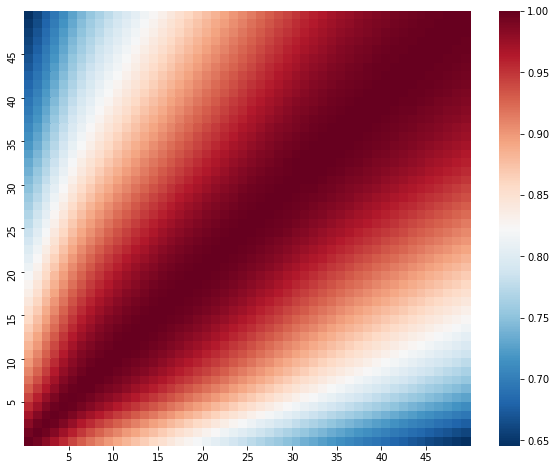

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35,40,45],[5,10,15,20,25,30,35,40,45]);
plt.yticks([5,10,15,20,25,30,35,40,45],[45,40,35,30,25,20,15,10,5]);

plt.savefig('functional_similarity.png')

In [ ]:
# Given model and test data, return true_labels and predictions.
def evaluate(test_dataloader, model):
    true_labels = []
    pred_labels = []
    
    for imgs, labels in iter(test_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model.module.forward(imgs)
        
        true_labels.extend(labels)
        pred_labels.extend(np.argmax(preds.detach().cpu().numpy(), axis=1))

    return np.array(true_labels), np.array(pred_labels)

In [ ]:
predictions = []
for i in tqdm(range(config['epochs'])):
    checkpoint = torch.load('/content/drive/MyDrive/deep-ensemble/smallCNN-'+str(i))
    model.load_state_dict(checkpoint['state_dict'])
    # get predictions for model
    _, preds = evaluate(testloader, model)

    predictions.append(preds)

100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


In [ ]:
empty_arr = np.zeros(shape=(config['epochs'],config['epochs']))
for i in tqdm(range(config['epochs'])):
    preds1 = predictions[i]
    for j in range(i, config['epochs']):
        preds2 = predictions[j]
        dissimilarity_score = 1-np.sum(np.equal(preds1, preds2))/10000 
        empty_arr[i][j] = dissimilarity_score
        if i is not j:
            empty_arr[j][i] = dissimilarity_score

dissimilarity_coeff = empty_arr[::-1]

100%|██████████| 50/50 [00:00<00:00, 951.81it/s]


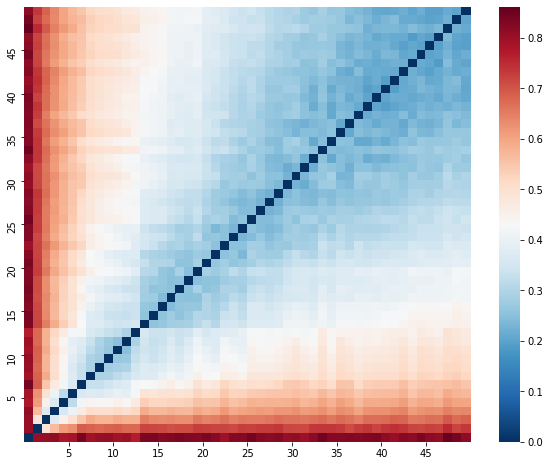

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(dissimilarity_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35,40,45],[5,10,15,20,25,30,35,40,45]);
plt.yticks([5,10,15,20,25,30,35,40,45],[45,40,35,30,25,20,15,10,5]);
plt.savefig('prediction_disagreement.png')

In [ ]:
wandb.init(project='deep-ensemble-loss-landscape', id='smallcnn_same_model_investigations')
wandb.log({'prediction_disagreement': wandb.Image('prediction_disagreement.png')})
wandb.log({'functional_similarity': wandb.Image('functional_similarity.png')})

In [ ]:
y_train_random = y_train.copy()

In [ ]:
np.random.shuffle(y_train_random)

In [ ]:
class model_dnn_2(nn.Module):
    def __init__(self, width=200):
        super(model_dnn_2, self).__init__()
        # self.fc1 = nn.Linear(784,width, bias=False)
        # torch.nn.init.kaiming_normal_(self.fc1.weight)
        # self.fc2 = nn.Linear(width,10, bias=False)
        # torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc1 = nn.Linear(784,width)
        self.fc2 = nn.Linear(width,10)
    def forward(self, x):
        x = x.contiguous()
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
lr = 0.001
width = 200
model = model_dnn_2(width=width)
model_init = copy.deepcopy(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=80, gamma=0.1)
classifier = PyTorchClassifier(model=model, clip_values=(0, 1), loss=criterion, optimizer=optimizer, input_shape=(1,28,28), nb_classes=10)

In [ ]:
dist = []
Loss = []
for i in range(5000):
    classifier.fit(x_train, y_train_random, batch_size=128, nb_epochs=1)
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
    train_pred = classifier.predict(x_train)
    trainacc = np.sum(np.argmax(train_pred, axis=1) == y_train_random) / len(y_train_random)
    loss = criterion(torch.tensor(predictions),torch.tensor(y_test))
    Loss.append(loss)
    trainloss = criterion(torch.tensor(train_pred),torch.tensor(y_train_random))
    # distance = torch.norm(model.fc1.weight - model_init.fc1.weight,dim=1).sum() / width
    # dist.append(distance)
    print('t: {}, Accuracy on benign test examples: {}%, loss:{}, trainacc:{}, trainloss:{}'.format(i, accuracy * 100, loss, trainacc, trainloss))




t: 0, Accuracy on benign test examples: 10.93%, loss:2.6902177333831787, trainacc:0.5144166666666666, trainloss:1.5578445196151733
t: 1, Accuracy on benign test examples: 11.14%, loss:2.6789796352386475, trainacc:0.5205833333333333, trainloss:1.549575686454773
t: 2, Accuracy on benign test examples: 10.97%, loss:2.6890225410461426, trainacc:0.5254, trainloss:1.5451945066452026
t: 3, Accuracy on benign test examples: 10.26%, loss:2.700058937072754, trainacc:0.5288, trainloss:1.5406830310821533
t: 4, Accuracy on benign test examples: 10.299999999999999%, loss:2.6983938217163086, trainacc:0.52685, trainloss:1.5397459268569946
t: 5, Accuracy on benign test examples: 10.65%, loss:2.697230577468872, trainacc:0.5296166666666666, trainloss:1.5382484197616577
t: 6, Accuracy on benign test examples: 10.530000000000001%, loss:2.6812520027160645, trainacc:0.53225, trainloss:1.5351238250732422
t: 7, Accuracy on benign test examples: 10.99%, loss:2.674267053604126, trainacc:0.5324166666666666, train

In [ ]:
for i in range(100):
    classifier.fit(x_train, y_train, batch_size=128, nb_epochs=1)
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
    loss = criterion(torch.tensor(predictions),torch.tensor(y_test))
    Loss.append(loss)
    # distance = torch.norm(model.fc1.weight - model_init.fc1.weight,dim=1).sum() / width
    # dist.append(distance)
    print('t: {}, Accuracy on benign test examples: {}%, loss:{}'.format(i, accuracy * 100, loss))

t: 0, Accuracy on benign test examples: 89.48%, loss:0.33837100863456726
t: 1, Accuracy on benign test examples: 91.7%, loss:0.27195948362350464
t: 2, Accuracy on benign test examples: 92.66%, loss:0.241424560546875
t: 3, Accuracy on benign test examples: 93.30000000000001%, loss:0.22067219018936157
t: 4, Accuracy on benign test examples: 93.7%, loss:0.20474295318126678
t: 5, Accuracy on benign test examples: 94.06%, loss:0.19331300258636475
t: 6, Accuracy on benign test examples: 94.42%, loss:0.18669159710407257
t: 7, Accuracy on benign test examples: 94.54%, loss:0.178004190325737
t: 8, Accuracy on benign test examples: 94.76%, loss:0.17102694511413574
t: 9, Accuracy on benign test examples: 95.03%, loss:0.16411295533180237
t: 10, Accuracy on benign test examples: 95.22%, loss:0.1606104075908661
t: 11, Accuracy on benign test examples: 95.35%, loss:0.15500609576702118
t: 12, Accuracy on benign test examples: 95.37%, loss:0.15131190419197083
t: 13, Accuracy on benign test examples: 95

KeyboardInterrupt: ignored

In [ ]:
wrong2 = np.where((np.argmax(predictions, axis=1) == y_test)==False)

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([ 247.    ,  251.8485,  256.697 , ..., 9934.303 , 9939.1515,
        9944.    ]),
 <a list of 2000 Patch objects>)

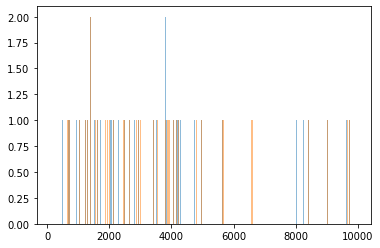

In [ ]:
plt.hist(wrong1, alpha=0.5,bins=2000)
plt.hist(wrong2, alpha=0.5,bins=2000)

In [ ]:
wrong1

(array([ 149,  247,  259,  321,  340,  445,  449,  495,  582,  619,  646,
         659,  684,  691,  707,  720,  947,  951,  956,  965, 1014, 1039,
        1044, 1112, 1178, 1181, 1194, 1226, 1232, 1242, 1247, 1260, 1299,
        1319, 1328, 1378, 1393, 1395, 1500, 1522, 1530, 1549, 1553, 1609,
        1621, 1681, 1709, 1717, 1754, 1790, 1878, 1901, 1940, 1941, 1987,
        2016, 2035, 2043, 2044, 2053, 2070, 2098, 2109, 2118, 2130, 2135,
        2182, 2185, 2189, 2224, 2266, 2272, 2293, 2299, 2369, 2387, 2406,
        2488, 2597, 2607, 2648, 2654, 2730, 2810, 2877, 2896, 2921, 2939,
        2953, 3073, 3117, 3384, 3405, 3422, 3503, 3520, 3558, 3559, 3597,
        3718, 3757, 3767, 3780, 3796, 3808, 3811, 3838, 3853, 3893, 3906,
        3941, 3985, 4065, 4078, 4102, 4163, 4176, 4199, 4201, 4224, 4248,
        4289, 4497, 4536, 4601, 4740, 4761, 4807, 4823, 4880, 4956, 4966,
        5331, 5457, 5600, 5642, 5734, 5749, 5926, 5936, 5937, 5955, 5972,
        5973, 6023, 6045, 6046, 6059, 

In [ ]:
wrong2

(array([ 247,  321,  340,  381,  445,  449,  495,  582,  619,  646,  659,
         684,  720,  740,  947,  951,  956,  965, 1014, 1039, 1112, 1156,
        1181, 1182, 1194, 1224, 1226, 1232, 1242, 1247, 1260, 1299, 1319,
        1393, 1395, 1414, 1444, 1500, 1522, 1530, 1549, 1553, 1609, 1621,
        1681, 1709, 1754, 1790, 1878, 1901, 1941, 1952, 1984, 1987, 2004,
        2016, 2035, 2044, 2053, 2098, 2109, 2118, 2130, 2135, 2182, 2189,
        2224, 2266, 2272, 2293, 2387, 2406, 2414, 2447, 2454, 2488, 2582,
        2607, 2610, 2648, 2654, 2863, 2877, 2896, 2939, 2953, 3005, 3060,
        3073, 3117, 3384, 3422, 3503, 3520, 3549, 3558, 3597, 3727, 3780,
        3796, 3808, 3811, 3818, 3853, 3869, 3893, 3902, 3906, 3926, 3941,
        3976, 3985, 4065, 4075, 4078, 4163, 4176, 4199, 4224, 4248, 4289,
        4497, 4534, 4536, 4601, 4740, 4761, 4807, 4814, 4823, 4880, 4956,
        4966, 5331, 5457, 5600, 5642, 5676, 5734, 5749, 5757, 5887, 5936,
        5937, 5955, 5972, 5973, 6011, 

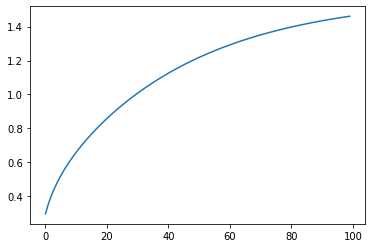

In [ ]:
plt.plot(dist)

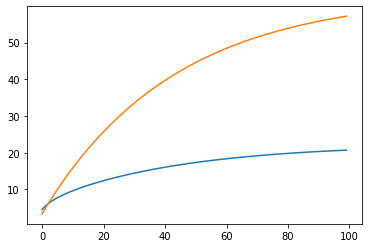

In [ ]:
plt.plot(dist200)
plt.plot(dist2000)

In [ ]:
dist200=dist

In [ ]:
model_init = copy.deepcopy(model).to(device)

In [ ]:
def Model():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

  x = keras.layers.Conv2D(16, (3,3), padding='same')(inputs)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(2, strides=2)(x)

  x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(2, strides=2)(x)

  x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(2, strides=2)(x)

  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  
  outputs = keras.layers.Dense(10, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
(x_train, y_train_onehot), (x_test, y_test_onehot), min_, max_ = load_dataset(str("cifar10"))
x_train = x_train.transpose(0, 3, 1, 2).astype("float32")
x_test = x_test.transpose(0, 3, 1, 2).astype("float32")
y_train_onehot = np.float32(y_train_onehot)
y_test_onehot = np.float32(y_test_onehot)
y_train = np.argmax(y_train_onehot, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)
CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [ ]:
class small_cnn(nn.Module):
    def __init__(self):
        super(small_cnn, self).__init__()
        self.conv_1 = nn.Conv2d(3, 16, kernel_size = 3, padding='same')
        self.conv_2 = nn.Conv2d(16, 32, kernel_size = 3, padding='same')
        self.conv_3 = nn.Conv2d(32, 32, kernel_size = 3, padding='same')
        self.fc_1 = nn.Linear(512,32)
        self.fc_2 = nn.Linear(32, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.globalpool = nn.AvgPool2d(2,2)
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = self.globalpool(F.relu(self.conv_3(x)))
        x = x.view(-1,512)
        x = F.relu(self.fc_1(x))
        x = nn.Dropout(p=0.1)(x)
        x = self.fc_2(x)
        return x

In [ ]:
bs = 128
T = 200
lr = 0.1

criterion = nn.CrossEntropyLoss()
cifar_mu = np.ones((3, 32, 32))
cifar_mu[0, :, :] = 0.4914
cifar_mu[1, :, :] = 0.4822
cifar_mu[2, :, :] = 0.4465

cifar_std = np.ones((3, 32, 32))
cifar_std[0, :, :] = 0.2471
cifar_std[1, :, :] = 0.2435
cifar_std[2, :, :] = 0.2616

model = small_cnn().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=80, gamma=0.1)
classifier = PyTorchClassifier(model=model, clip_values=(0, 1), loss=criterion, preprocessing=(cifar_mu, cifar_std),
                        optimizer=optimizer, input_shape=(3,32,32), nb_classes=10)

In [ ]:
dist = []
Loss = []
for i in range(50):
    classifier.fit(x_train, y_train, batch_size=128, nb_epochs=1)
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
    loss = criterion(torch.tensor(predictions),torch.tensor(y_test))
    Loss.append(loss)
    print('t: {}, Accuracy on benign test examples: {}%, loss:{}'.format(i, accuracy * 100, loss))


t: 0, Accuracy on benign test examples: 50.339999999999996%, loss:1.3801299333572388
t: 1, Accuracy on benign test examples: 55.989999999999995%, loss:1.2289142608642578
t: 2, Accuracy on benign test examples: 58.879999999999995%, loss:1.1782519817352295
t: 3, Accuracy on benign test examples: 60.68%, loss:1.1288642883300781
t: 4, Accuracy on benign test examples: 61.09%, loss:1.1354126930236816
t: 5, Accuracy on benign test examples: 59.12%, loss:1.1799143552780151
t: 6, Accuracy on benign test examples: 63.23%, loss:1.0800013542175293
t: 7, Accuracy on benign test examples: 63.4%, loss:1.062193512916565
t: 8, Accuracy on benign test examples: 62.89%, loss:1.0774003267288208
t: 9, Accuracy on benign test examples: 64.97%, loss:1.027919888496399
t: 10, Accuracy on benign test examples: 61.8%, loss:1.103049397468567
t: 11, Accuracy on benign test examples: 64.61%, loss:1.0405209064483643
t: 12, Accuracy on benign test examples: 62.370000000000005%, loss:1.1234543323516846
t: 13, Accurac

In [ ]:
wrong2 = np.where((np.argmax(predictions, axis=1) == y_test)==False)

(array([37., 32., 33., 33., 36., 33., 33., 36., 34., 28., 28., 28., 33.,
        34., 35., 32., 31., 29., 28., 39., 32., 37., 31., 36., 31., 36.,
        34., 36., 31., 24., 28., 33., 32., 39., 31., 31., 28., 36., 28.,
        35., 26., 24., 26., 33., 32., 23., 30., 34., 27., 32., 40., 36.,
        30., 37., 31., 41., 34., 23., 43., 34., 39., 38., 30., 35., 31.,
        33., 38., 32., 37., 47., 31., 32., 27., 28., 32., 28., 24., 31.,
        33., 33., 32., 30., 30., 40., 38., 29., 33., 38., 34., 30., 40.,
        21., 35., 35., 34., 29., 30., 39., 30., 29.]),
 array([   0.  ,   99.98,  199.96,  299.94,  399.92,  499.9 ,  599.88,
         699.86,  799.84,  899.82,  999.8 , 1099.78, 1199.76, 1299.74,
        1399.72, 1499.7 , 1599.68, 1699.66, 1799.64, 1899.62, 1999.6 ,
        2099.58, 2199.56, 2299.54, 2399.52, 2499.5 , 2599.48, 2699.46,
        2799.44, 2899.42, 2999.4 , 3099.38, 3199.36, 3299.34, 3399.32,
        3499.3 , 3599.28, 3699.26, 3799.24, 3899.22, 3999.2 , 4099.18,
        

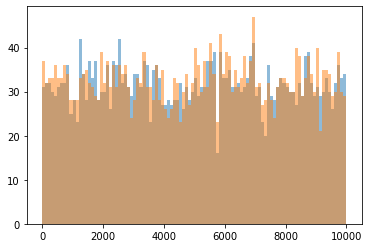

In [ ]:
plt.hist(wrong1[0], alpha=0.5, bins=100)
plt.hist(wrong2[0], alpha=0.5, bins=100)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [ ]:
cm = confusion_matrix(y_test, np.argmax(predictions,axis=1))

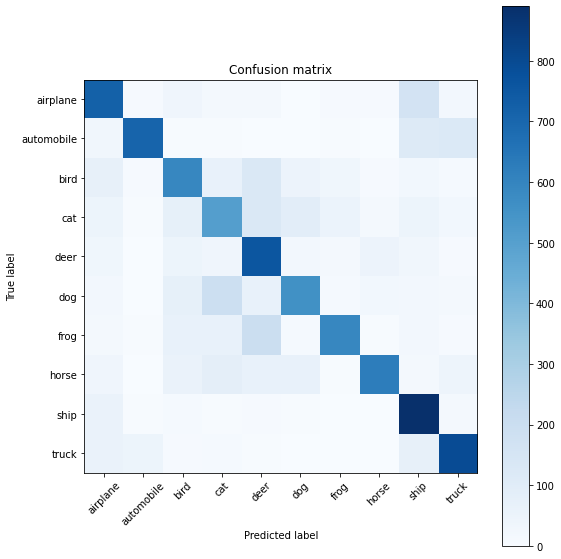

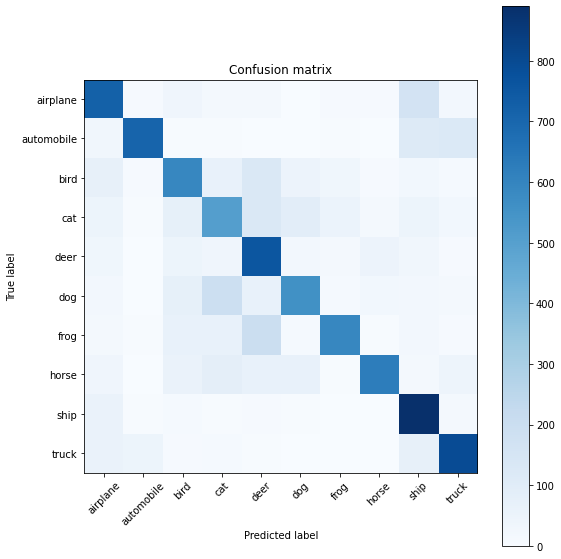

In [ ]:
plot_confusion_matrix(cm, CLASS_NAMES)

In [ ]:
class CIFAR10_dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = Image.fromarray(((self.data[index] * 255).round()).astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)
from art.data_generators import PyTorchDataGenerator

In [ ]:
bs = 128
T = 200
lr = 0.1

dp=0.4
subnet = 10
criterion = nn.CrossEntropyLoss()
cifar_mu = np.ones((3, 32, 32))
cifar_mu[0, :, :] = 0.4914
cifar_mu[1, :, :] = 0.4822
cifar_mu[2, :, :] = 0.4465

cifar_std = np.ones((3, 32, 32))
cifar_std[0, :, :] = 0.2471
cifar_std[1, :, :] = 0.2435
cifar_std[2, :, :] = 0.2616

train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()]
)

transform = transforms.Compose(
    [transforms.ToTensor()]
)


train_dataset = CIFAR10_dataset(x_train, y_train, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
train_datagen = PyTorchDataGenerator(iterator=train_dataloader, size=x_train.shape[0], batch_size=bs)


test_dataset = CIFAR10_dataset(x_test, y_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4)
test_datagen = PyTorchDataGenerator(iterator=test_dataloader, size=x_test.shape[0], batch_size=bs)

model = ResNet20(dp=dp, n_test=subnet).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=80, gamma=0.1)
# classifier = PyTorchRandomizedSmoothing(model=model, clip_values=(0, 1), loss=criterion, preprocessing=(cifar_mu, cifar_std),
#                         optimizer=optimizer, input_shape=(3,32,32), nb_classes=10, alpha=0.001, scale=0.12, sample_size=100)
classifier = PyTorchClassifier(model=model, clip_values=(0, 1), loss=criterion, preprocessing=(cifar_mu, cifar_std),
                        optimizer=optimizer, input_shape=(3,32,32), nb_classes=10)

NameError: ignored

10000

In [ ]:
norm = 2
eps = 0.5
attack = ProjectedGradientDescent(estimator=classifier, norm=norm, eps=0.5, eps_step=0.05, max_iter = 20, num_random_init=0, random_eps=True)

In [ ]:
for i in range(T):
    for (x,y) in train_datagen.iterator:
        classifier.fit(x.detach().cpu().numpy(), y.detach().cpu().numpy(), nb_epochs=1)
    # print("i:",i)
    testacc, advtestacc = 0, 0
    for (x,y) in test_datagen.iterator:
        x_adv = attack.generate(x)
        
        test_pred = classifier.predict(x)
        testacc += np.sum(np.argmax(test_pred, axis=1) == y.numpy()) / len(y)

        adv_test_pred = classifier.predict(x_adv)
        advtestacc += np.sum(np.argmax(adv_test_pred, axis=1) == y.numpy()) / len(y)

    print('i:{}, lr:{}, test acc:{}%, adv test acc:{}%'.format(i,scheduler.get_last_lr(), testacc / len(test_dataset) * 100, advtestacc / len(test_dataset) * 100))
    scheduler.step()


In [ ]:
print('i:{}, lr:{:3f}, test acc:{}%, adv test acc:{}%'.format(i,scheduler.get_last_lr()[0], testacc / len(test_dataset) * 100, advtestacc / len(test_dataset) * 100))

i:14, lr:0.100000, test acc:0.06226562499999999%, adv test acc:0.04%


In [ ]:
for i in range(T):
    for (x,y) in datagen.iterator:
        classifier.fit(x.detach().cpu().numpy(), y.detach().cpu().numpy(), nb_epochs=1)
    print("i:",i)
    if (i+1)%20==0:
        test_pred = classifier.predict(x_test)
        testacc = np.sum(np.argmax(test_pred, axis=1) == y_test) / len(y_test)

        print('i:{}, lr:{}, test acc:{}%'.format(i,scheduler.get_last_lr(), testacc * 100))
    scheduler.step()


In [ ]:
classifier = PyTorchClassifier(model=model, clip_values=(0, 1), loss=criterion, preprocessing=(cifar_mu, cifar_std),
                        optimizer=optimizer, input_shape=(3,32,32), nb_classes=10)